# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/1011rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/1012rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/1013rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/1011rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/1012rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/1013rep_25noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.291343        0.207863  0.048928  0.302099  0.019950   
       0.25   0.308718        0.193711  0.056356  0.249541  0.068583   
       0.50   0.308233        0.186568  0.061616  0.217983  0.097360   
       0.75   0.311193        0.186641  0.068531  0.197269  0.122639   
       1.00   0.321075        0.178206  0.079619  0.182288  0.133278   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.206924  0.010339  0.040686  0.049853  0.000000  
       0.25  0.207608  0.010071  0.039083  0.049049  0.000604  
       0.50  0.199143  0.009149  0.040052  0.046966  0.001534  
       0.75  0.204462  0.008039  0.038622  0.047867  0.002489  
       1.00  0.202481  0.006871  0.037479  0.048921  0.003725

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.305836        0.196759  0.050731  0.286435  0.020061   
       0.25   0.303703        0.202089  0.052885  0.255465  0.066426   
       0.50   0.311793        0.184340  0.061887  0.222849  0.098346   
       0.75   0.313444        0.187381  0.068866  0.190506  0.121461   
       1.00   0.318975        0.171801  0.076788  0.179830  0.133764   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.211093  0.009628  0.039375  0.047187  0.000000  
       0.25  0.199800  0.010320  0.038834  0.049022  0.000585  
       0.50  0.204837  0.009524  0.039356  0.049259  0.001450  
       0.75  0.206179  0.007658  0.037844  0.049887  0.002516  
       1.00  0.197891  0.006408  0.036259  0.049699  0.003649

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.295093        0.200419  0.050812  0.296802  0.019824   
       0.25   0.301041        0.190968  0.052564  0.248719  0.066876   
       0.50   0.312800        0.182655  0.063394  0.217174  0.100548   
       0.75   0.295345        0.188301  0.068033  0.202694  0.121627   
       1.00   0.303952        0.174693  0.076626  0.184061  0.136636   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.199706  0.010179  0.039041  0.053527  0.000000  
       0.25  0.211524  0.009714  0.039847  0.051595  0.000574  
       0.50  0.198104  0.009118  0.039831  0.049425  0.001507  
       0.75  0.215421  0.008061  0.038921  0.050256  0.002521  
       1.00  0.208213  0.006746  0.038622  0.048893  0.003674

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.297424        0.201680  0.050157  0.295112  0.019945   
         0.25   0.300192        0.194677  0.056548  0.250207  0.068294   
         0.50   0.299105        0.183105  0.069053  0.217981  0.100099   
         0.75   0.286732        0.185485  0.079197  0.195711  0.123435   
         1.00   0.285431        0.172543  0.091509  0.182604  0.136342   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.205907  0.010049  0.039701  0.050189  0.000000  
         0.25  0.206308  0.010039  0.039255  0.050087  0.000387  
         0.50  0.200683  0.009286  0.039745  0.049050  0.000989  
         0.75  0.208653  0.007979  0.038452  0.050208  0.001664  
         1.00  0.202782  0.006795  0.037419  0.050439  0.002452

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.895904e+01  4.006396e+01      37.084890  5.668387e+01   
         0.25  4.619542e+06  2.317008e+06  216095.640266  1.398457e+06   
         0.50  5.512627e+06  3.556799e+06  338556.940696  2.153234e+06   
         0.75  5.929421e+06  4.100638e+06  420146.407102  2.663142e+06   
         1.00  5.939704e+06  4.650100e+06  473950.002116  3.042015e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.526675  5.609052e+01  5.574226e+01      18.547885   
         0.25  473321.903047  2.255882e+06  2.681733e+06  434755.011449   
         0.50  734947.430038  3.745038e+06  3.244573e+06  640441.426523   
         0.75  898718.909951  4.746496e+06  3.532781e+06  777475.366456   
         1.00  975300.065584  5.461227e+06  3.825207e+06  842669.442039   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.455648  
         0.25     180672.234252  
         0.50     287738.019576  
         0.75     364499.225807  
         1.00     398095.750592

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


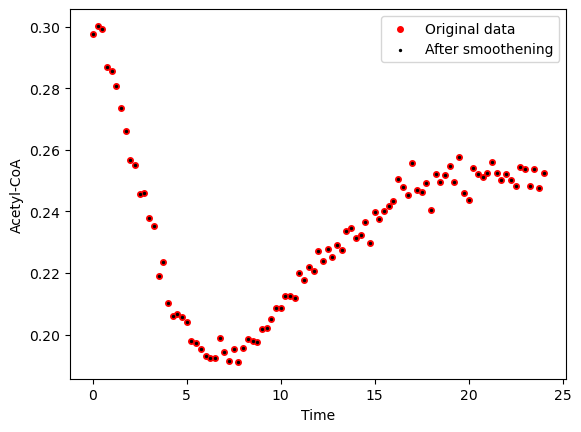

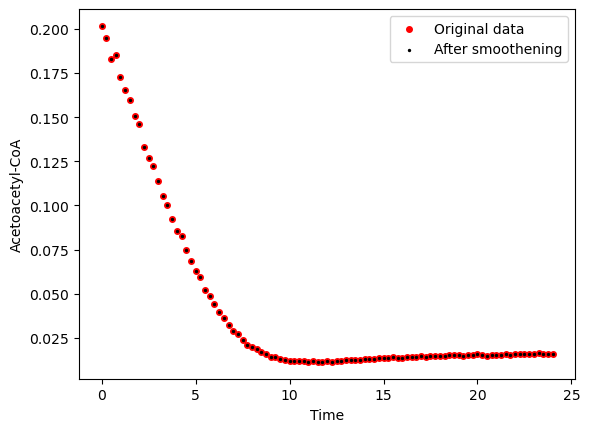

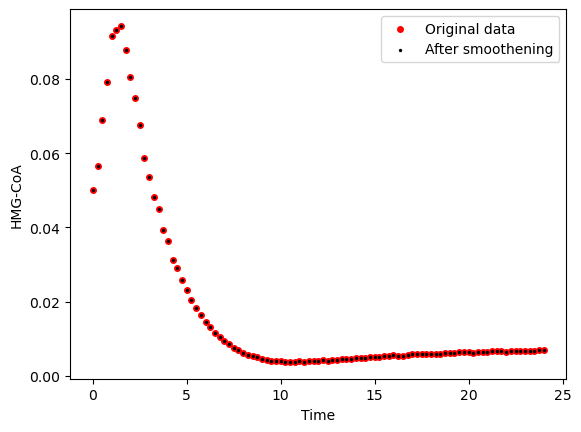

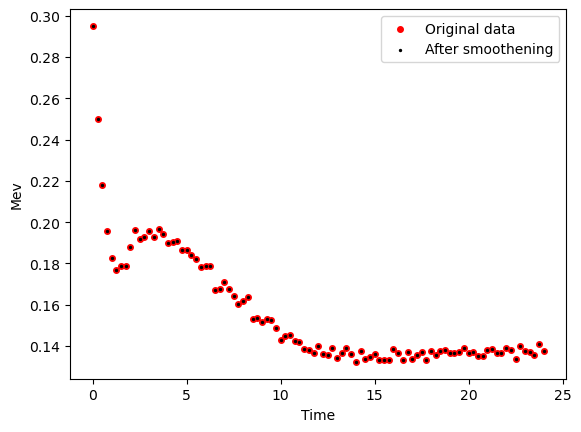

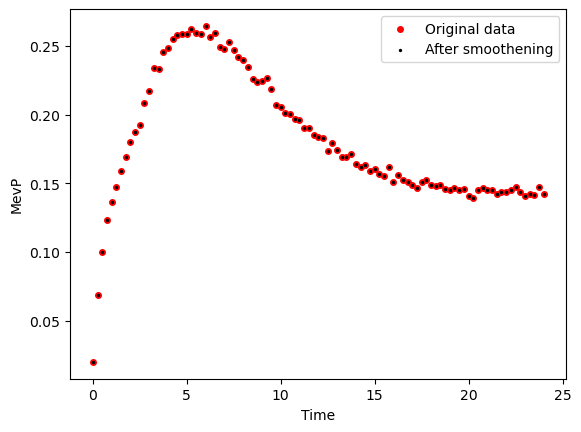

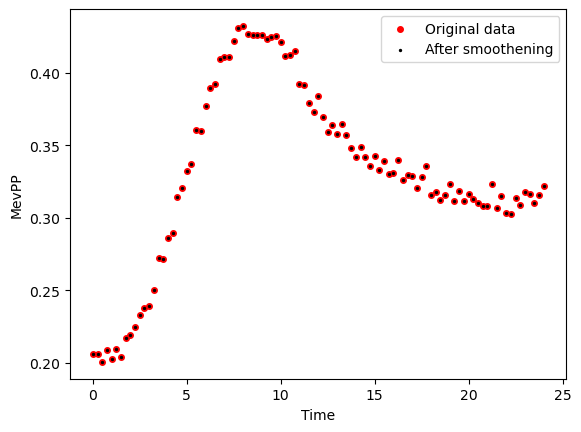

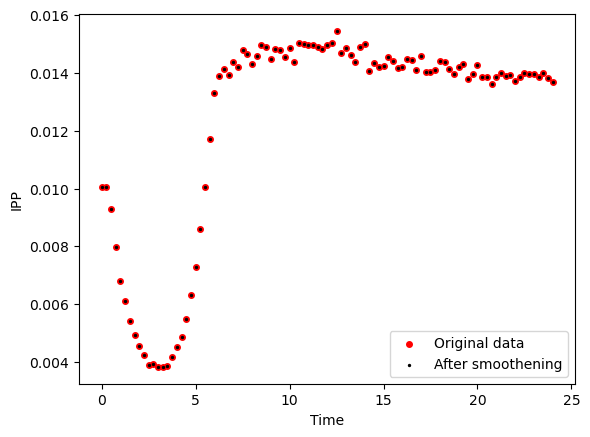

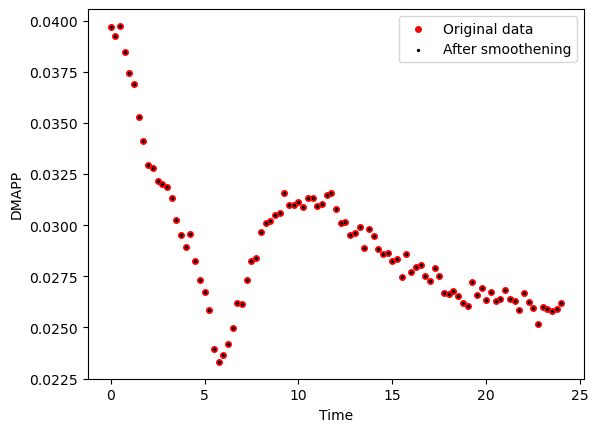

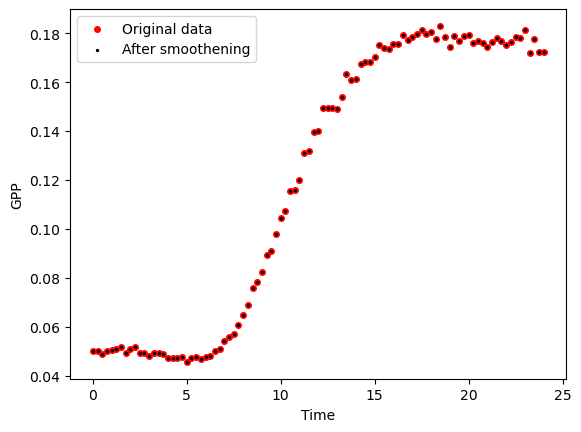

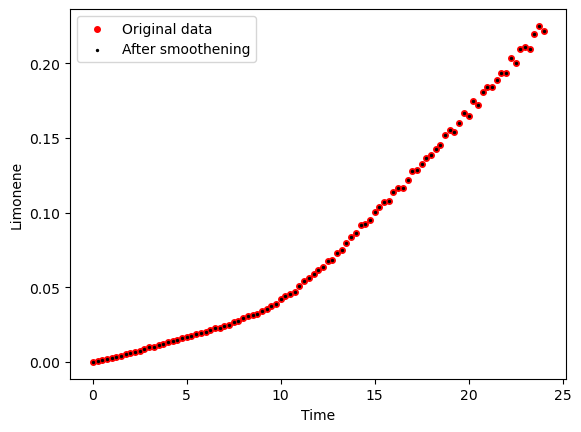

Strain Strain 2


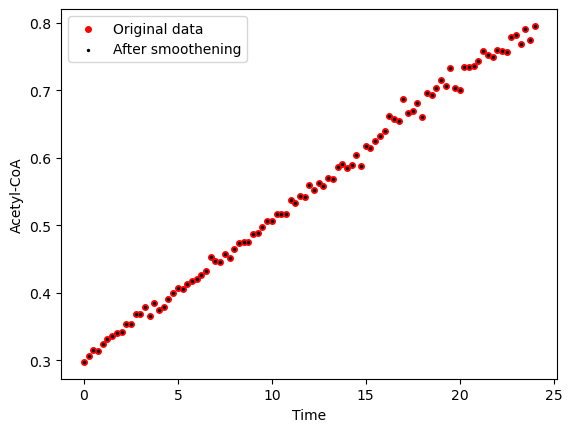

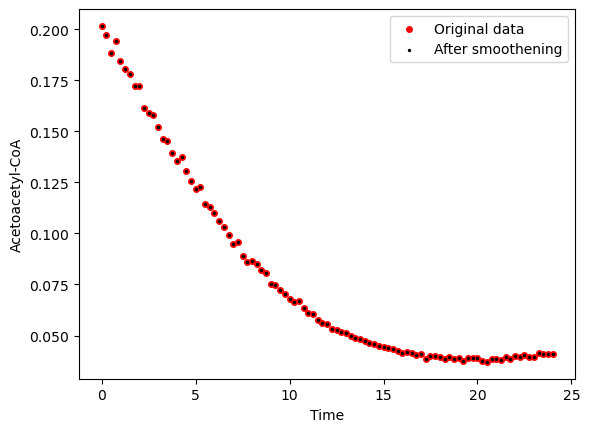

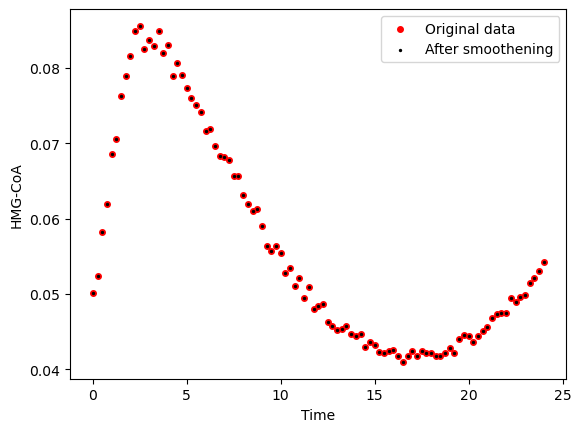

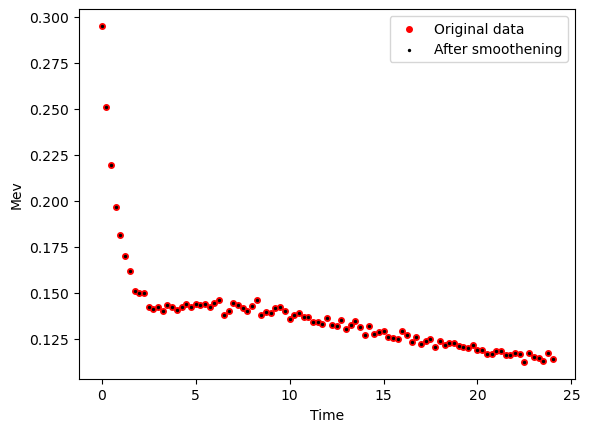

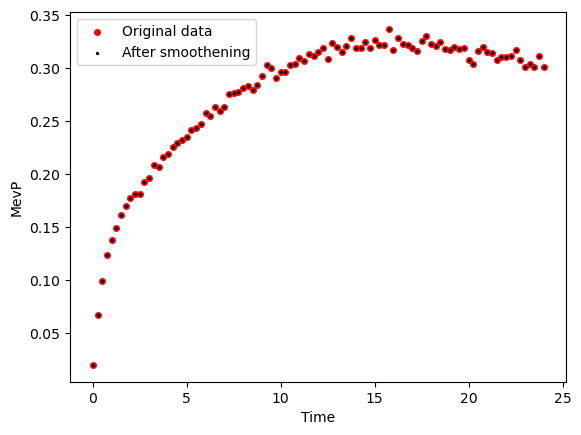

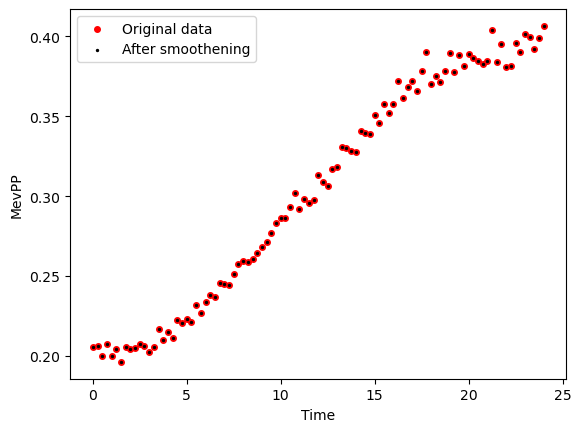

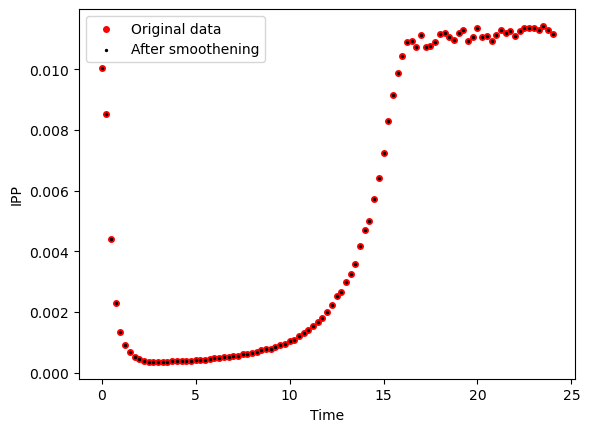

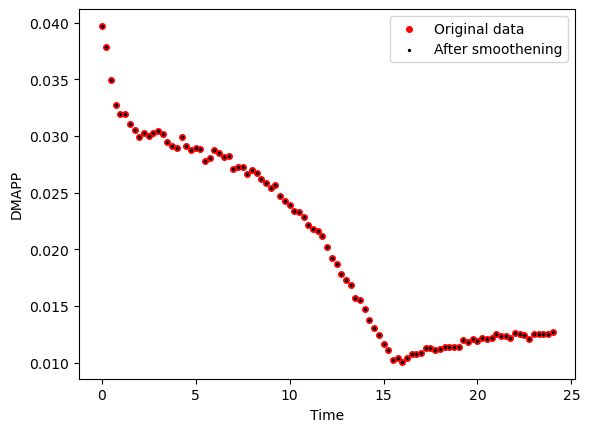

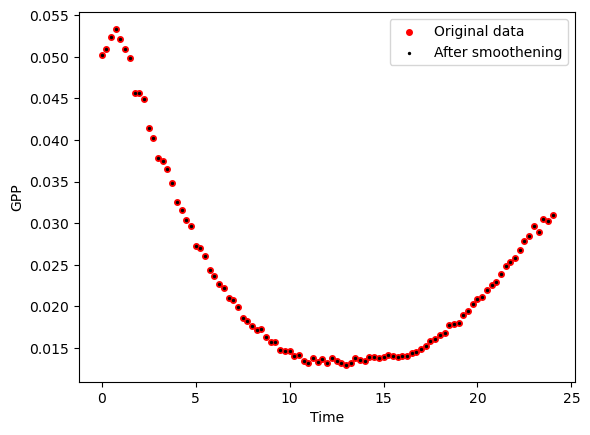

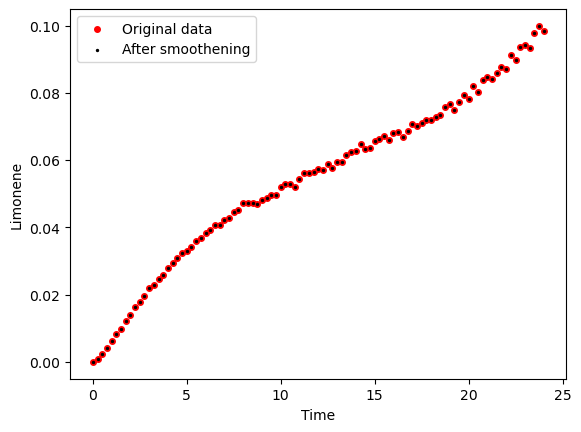

Strain Strain 3


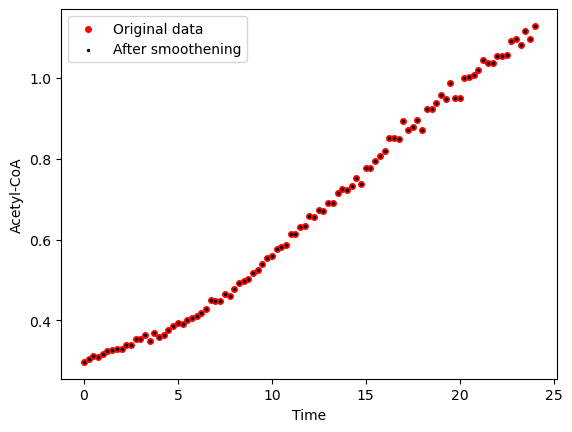

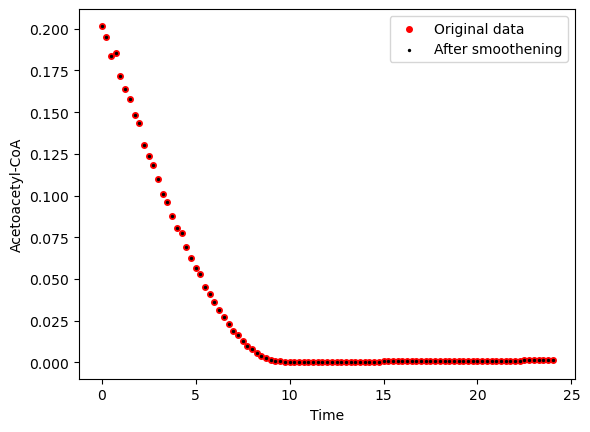

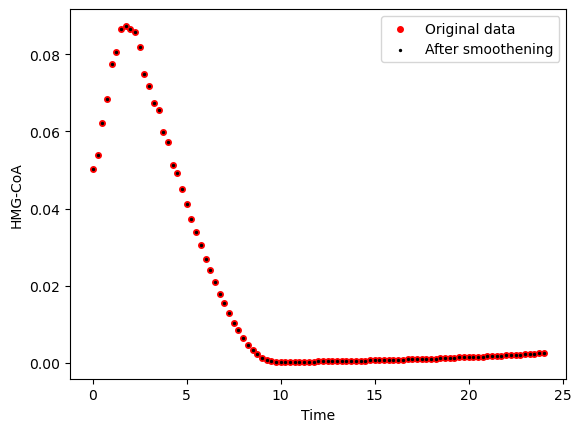

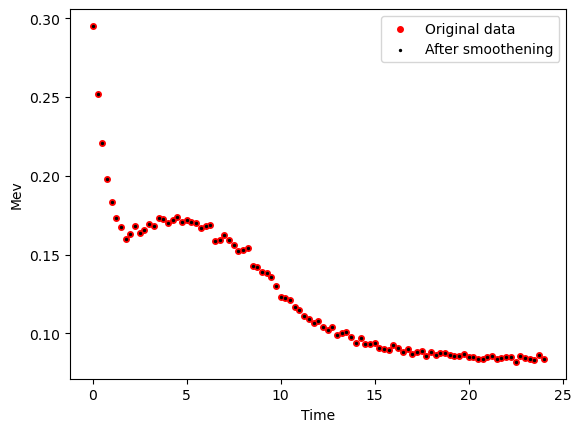

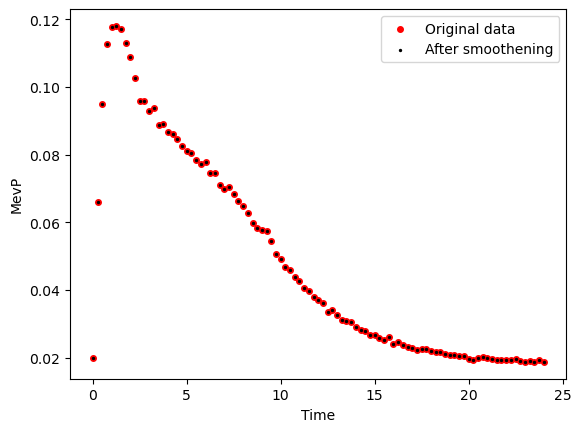

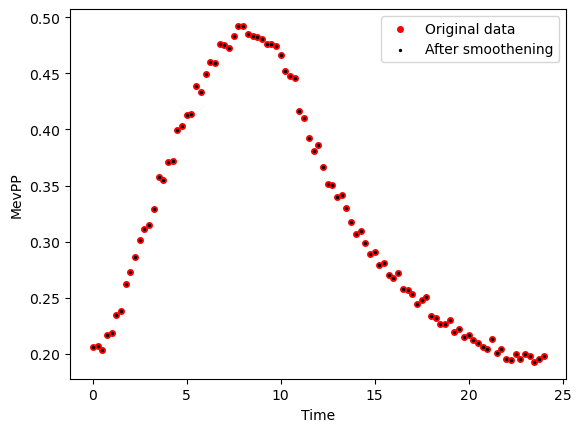

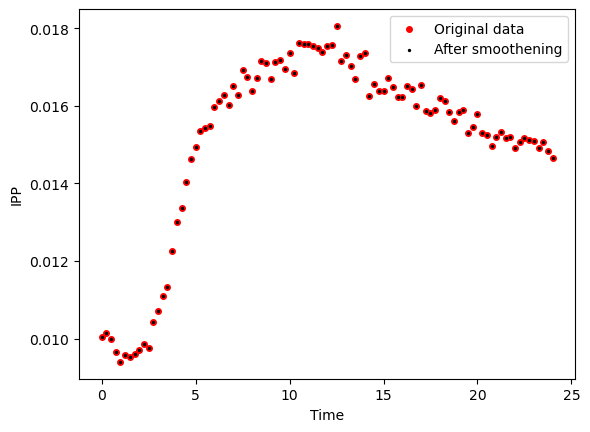

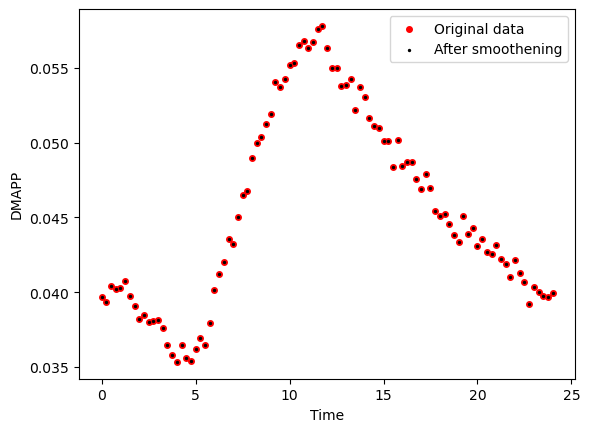

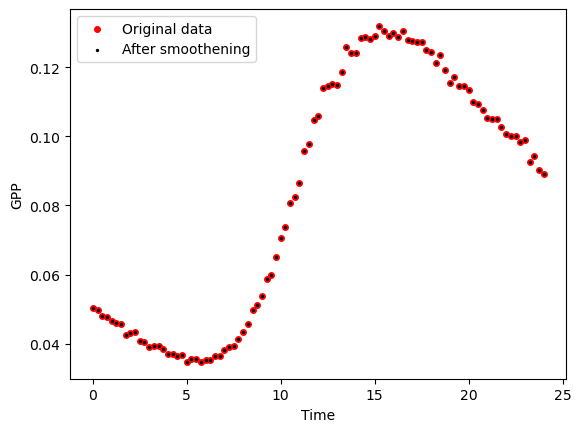

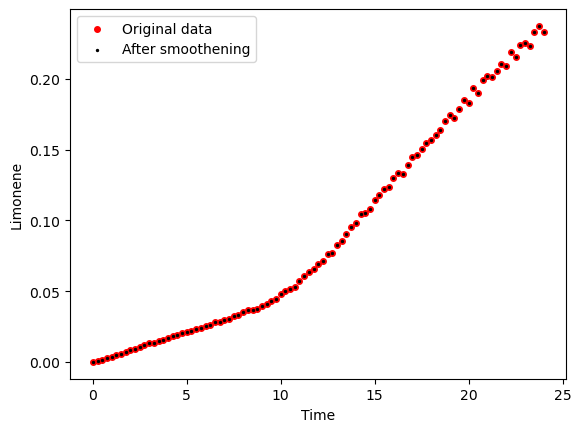

Strain WT


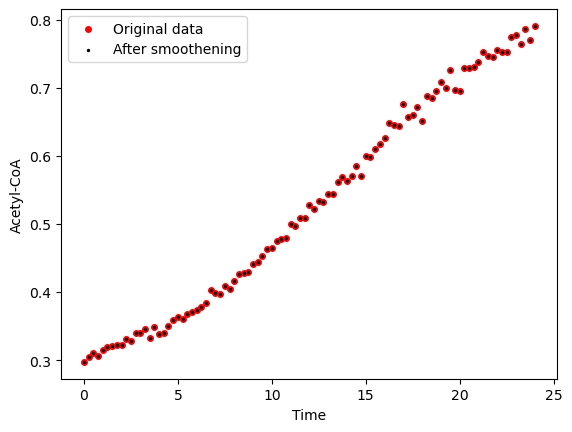

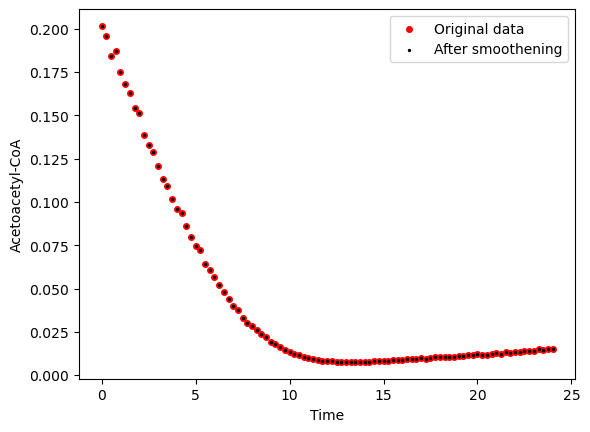

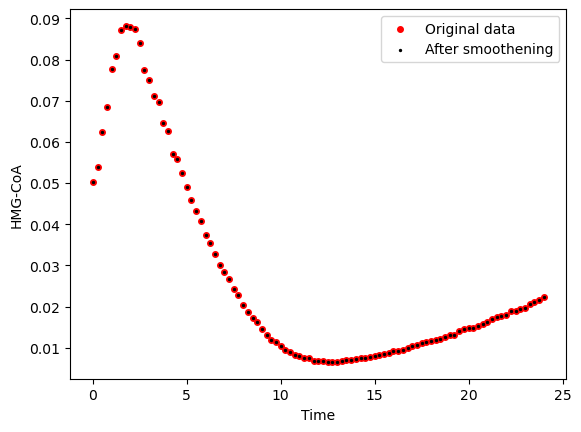

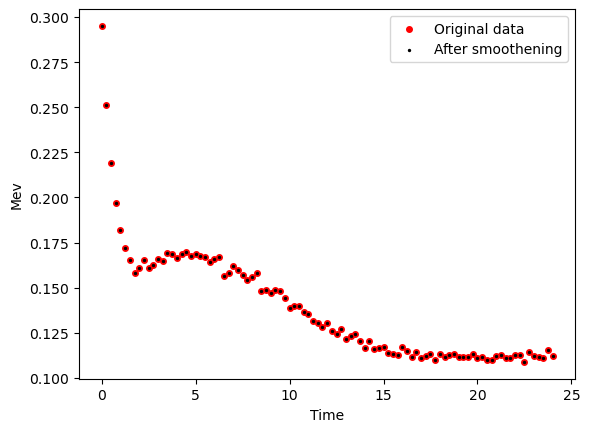

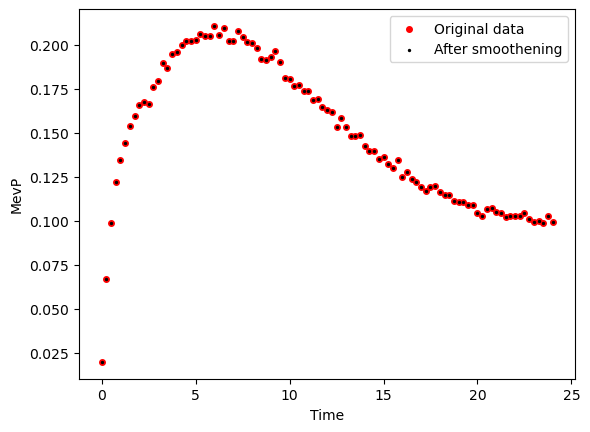

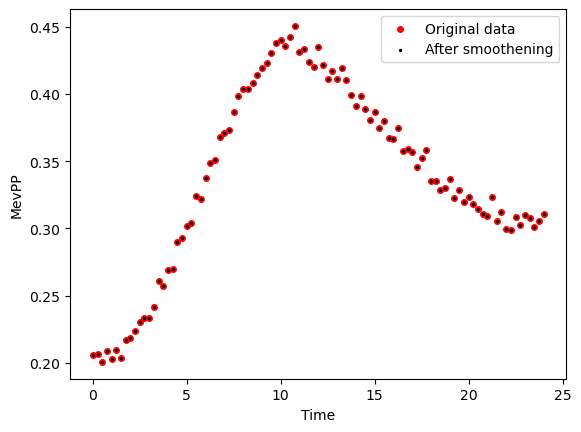

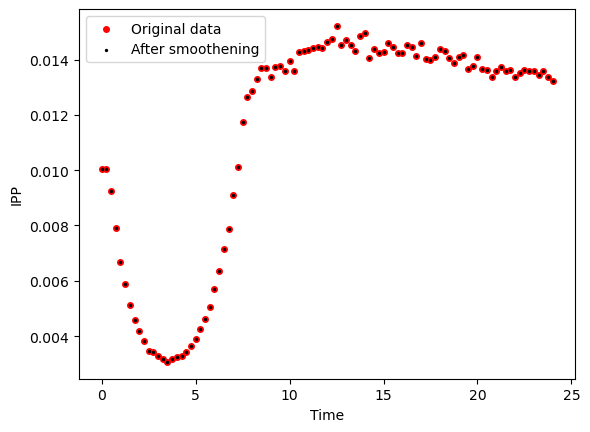

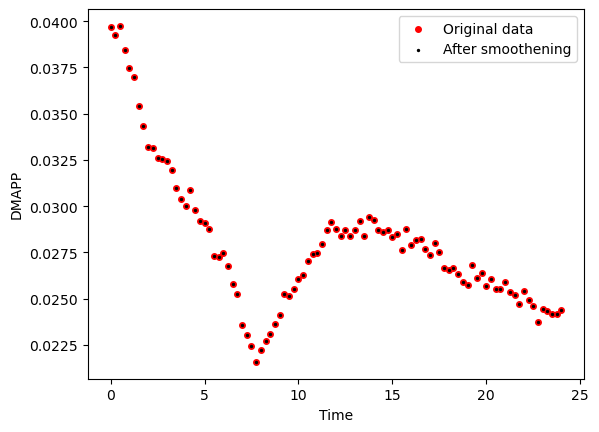

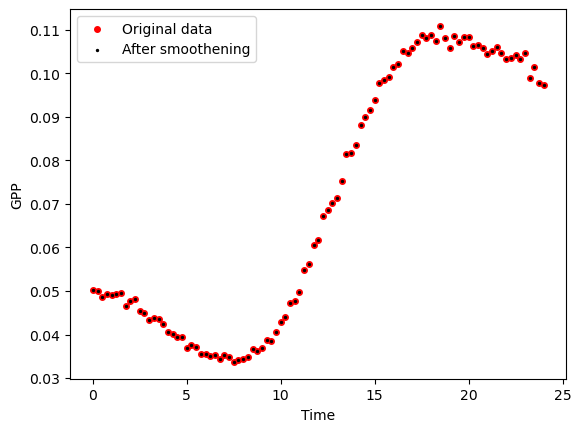

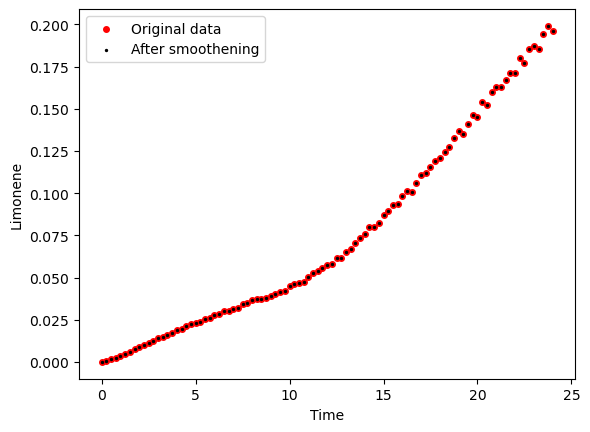

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


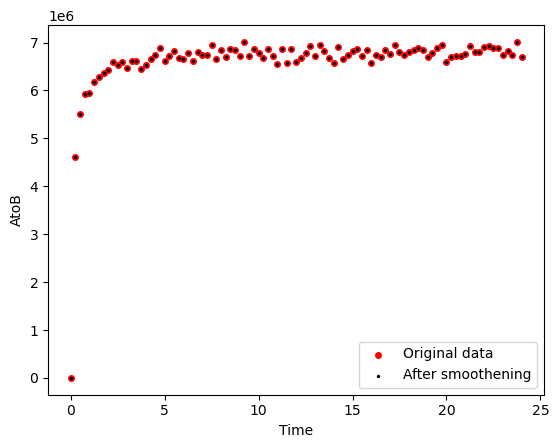

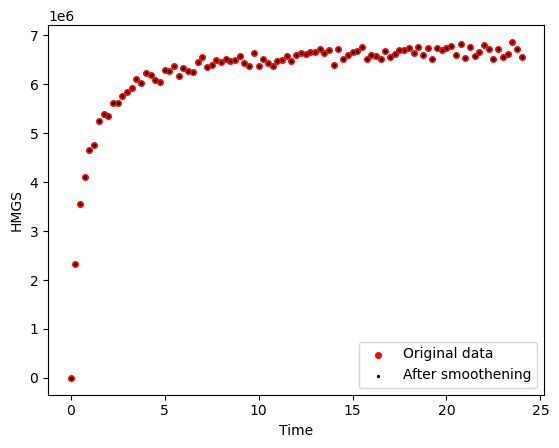

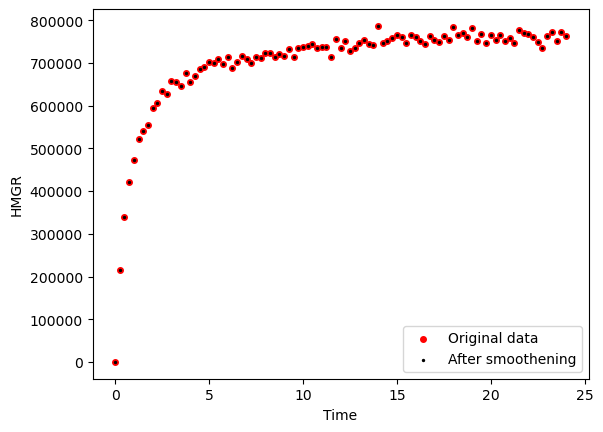

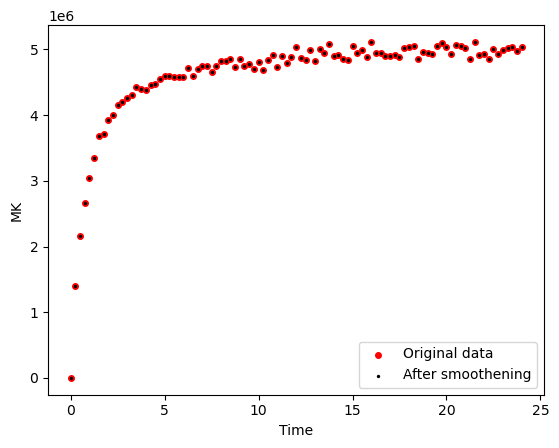

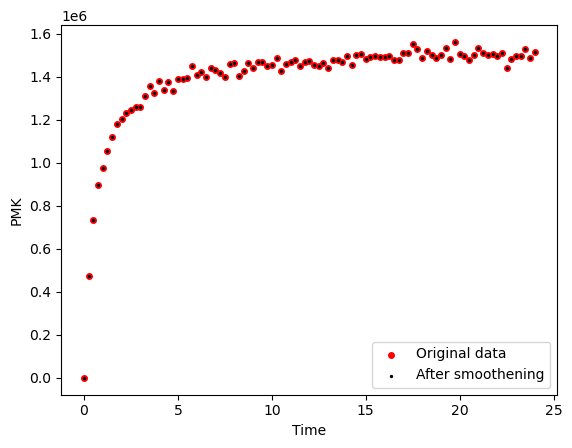

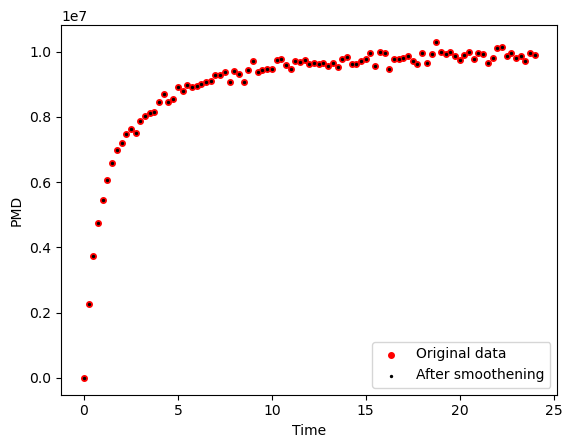

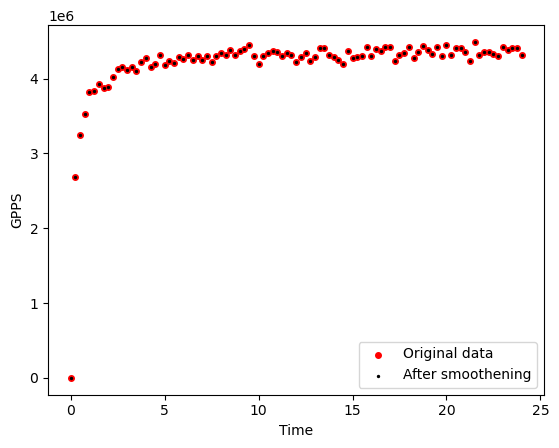

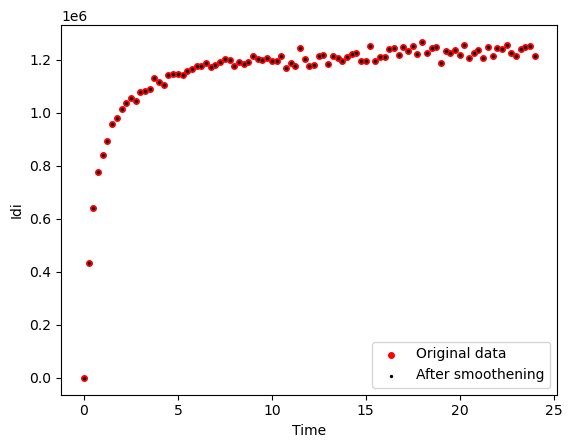

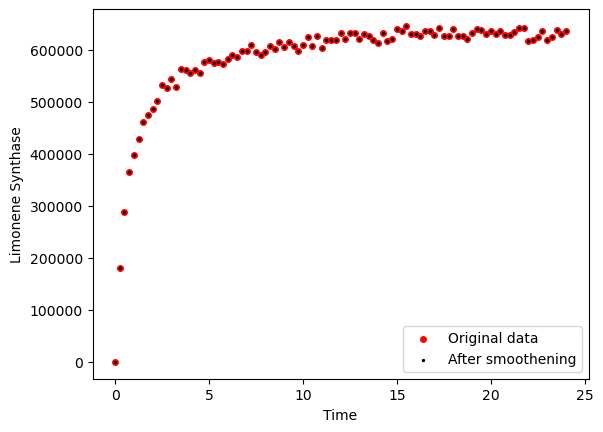

Strain Strain 2


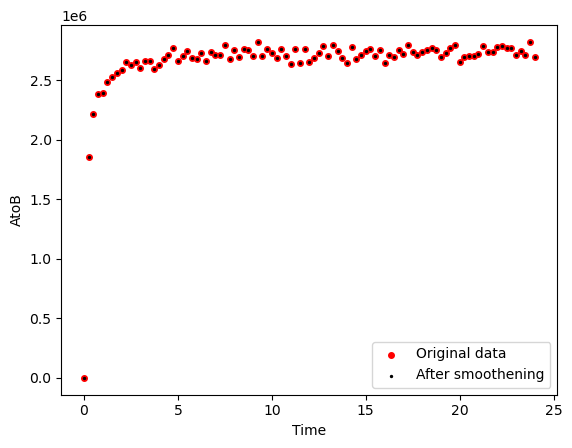

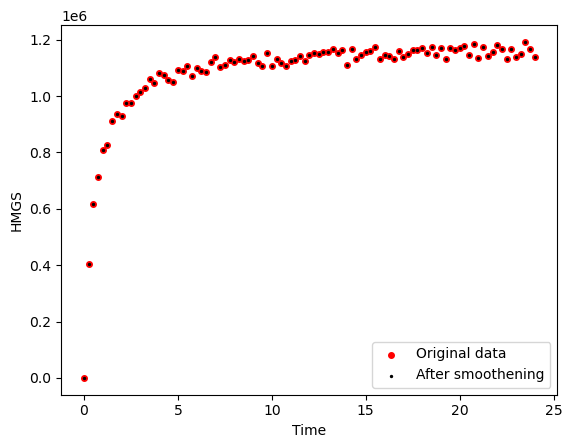

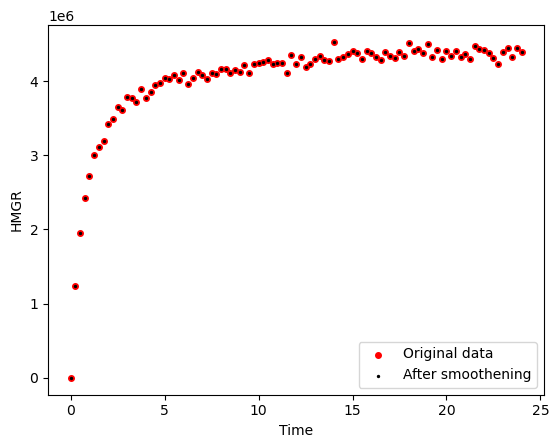

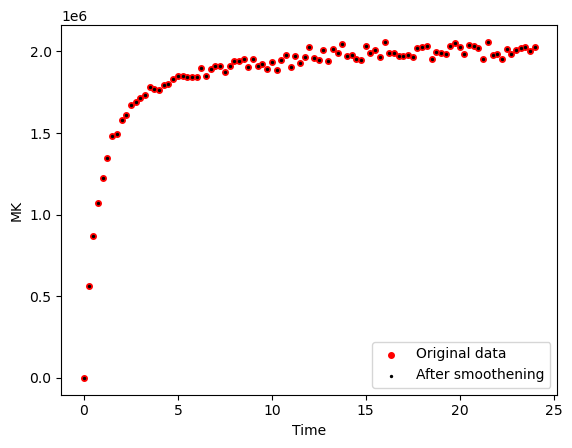

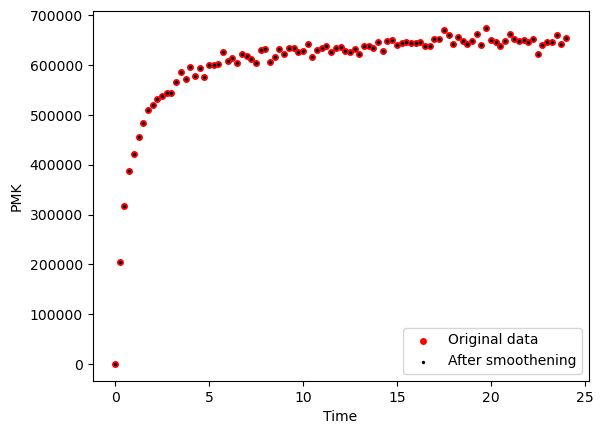

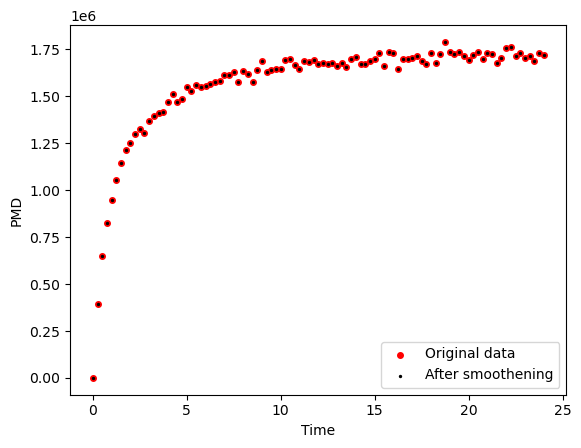

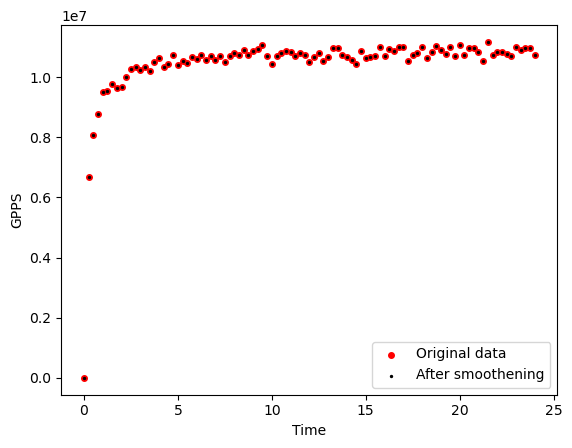

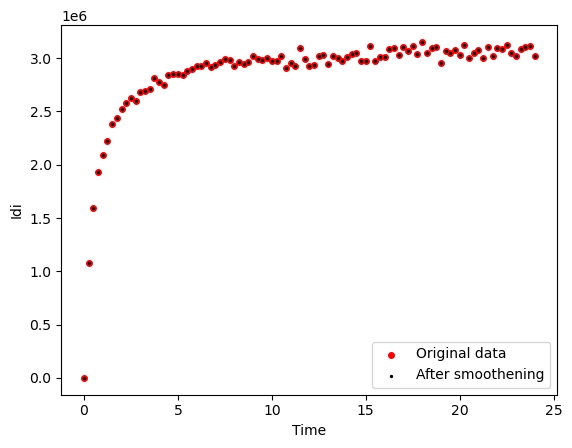

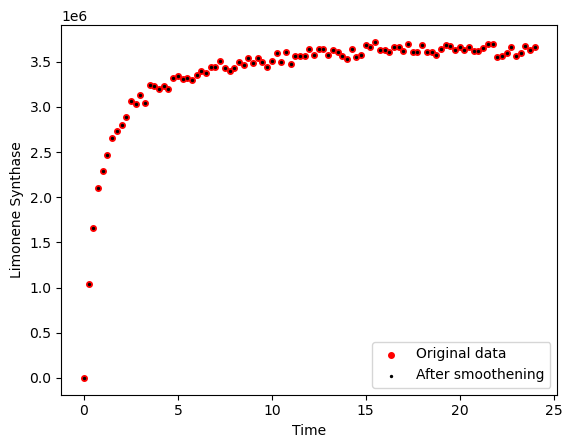

Strain Strain 3


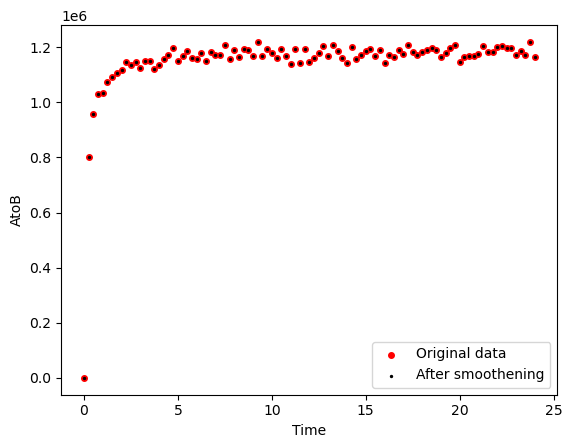

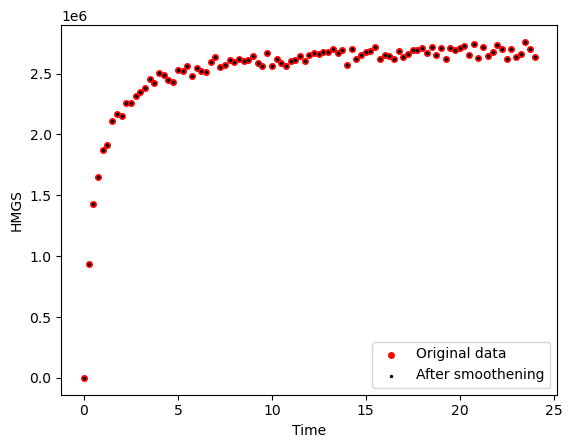

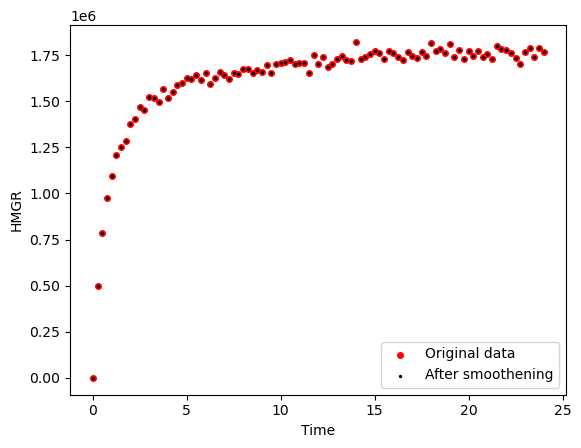

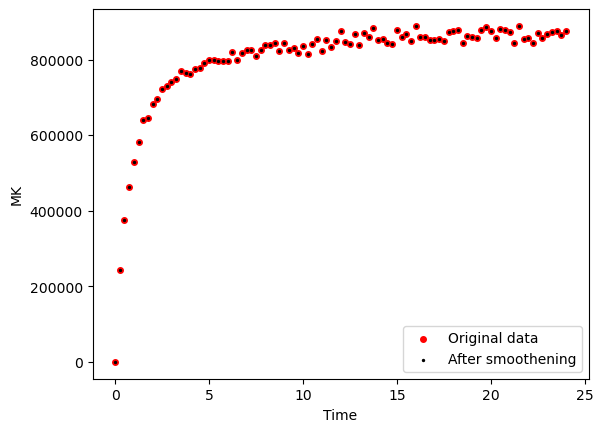

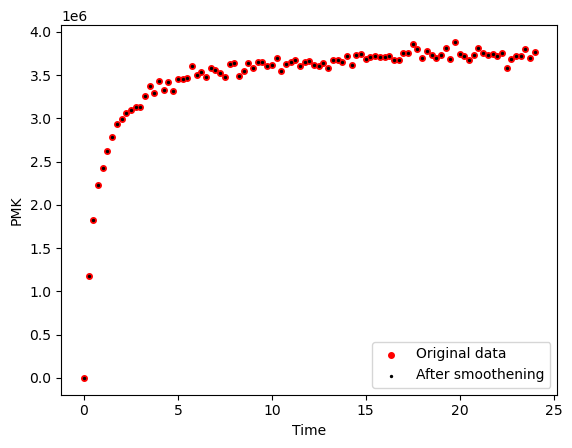

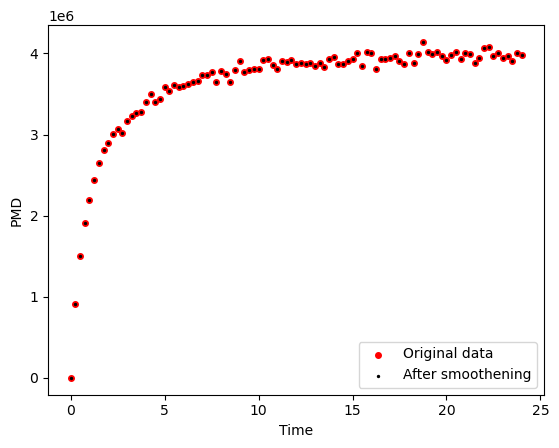

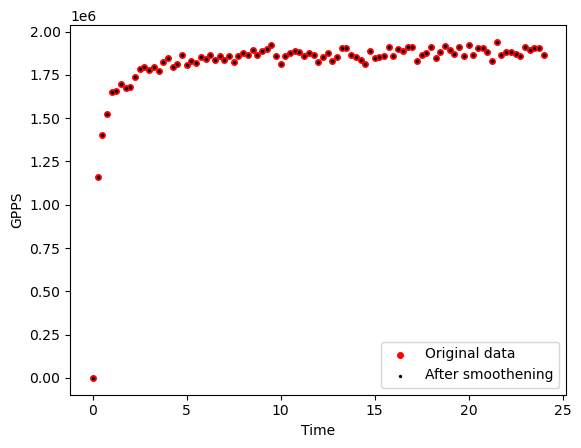

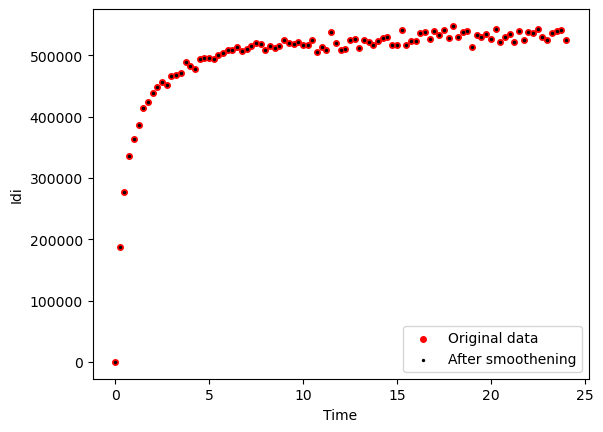

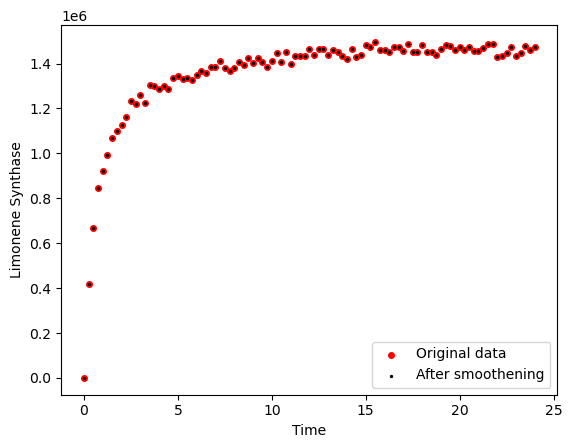

Strain WT


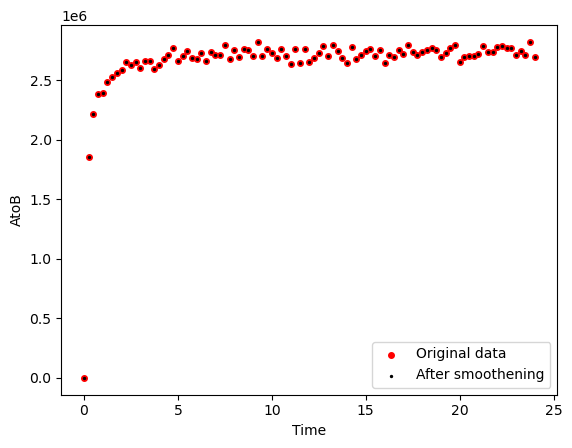

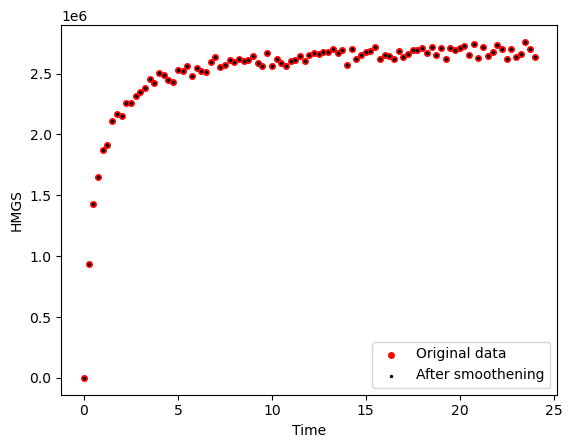

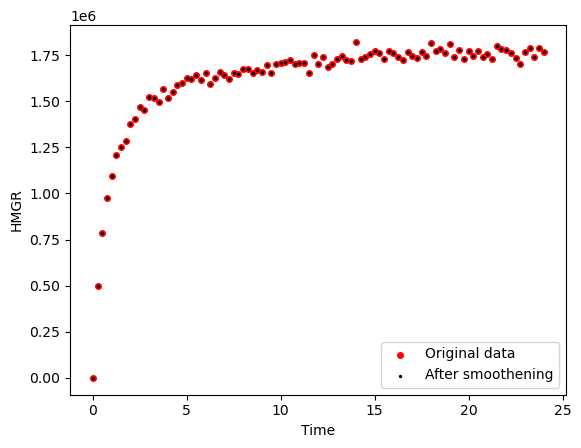

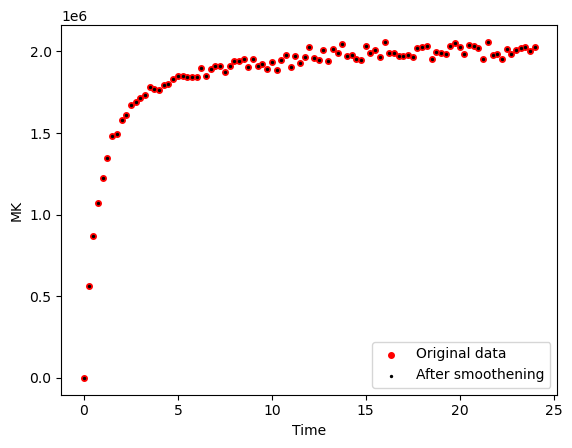

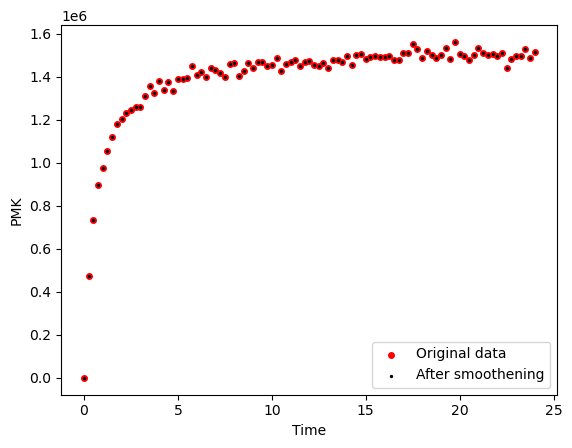

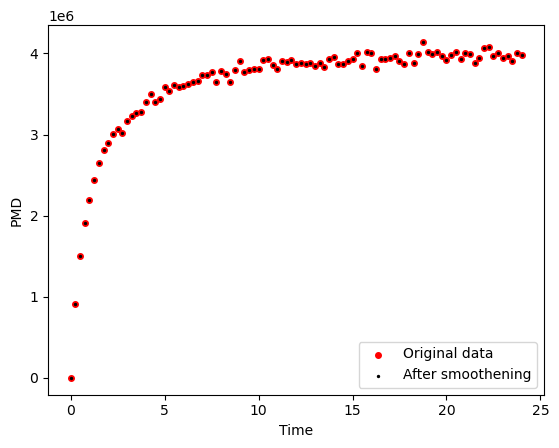

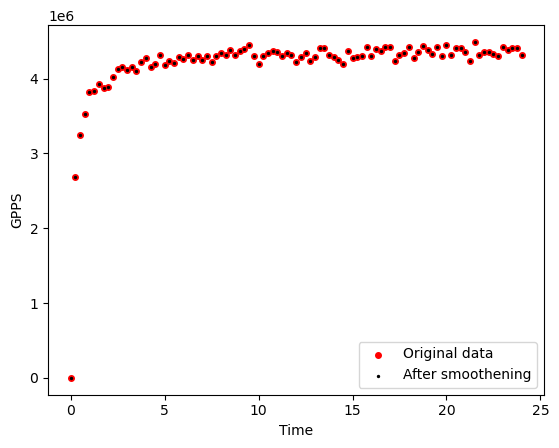

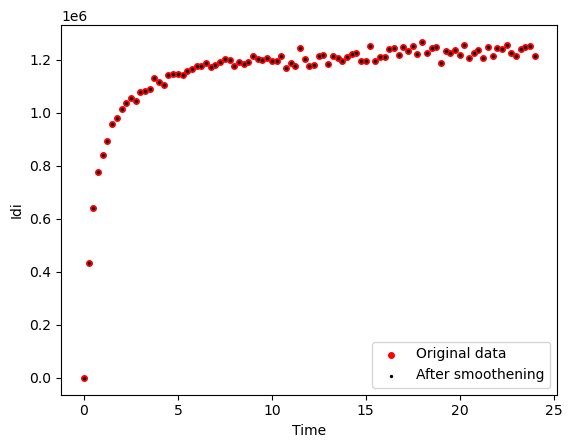

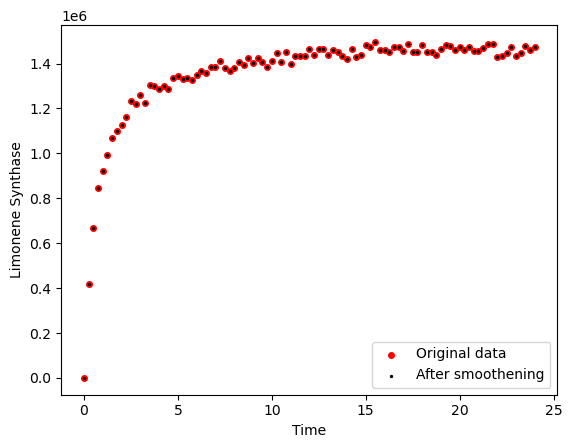

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.297424        0.201680  0.050157  0.295112  0.019945   
         0.25    0.300192        0.194677  0.056548  0.250207  0.068294   
         0.50    0.299105        0.183105  0.069053  0.217981  0.100099   
         0.75    0.286732        0.185485  0.079197  0.195711  0.123435   
         1.00    0.285431        0.172543  0.091509  0.182604  0.136342   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.776930        0.013964  0.019737  0.112279  0.099257   
         23.25   0.763973        0.014793  0.020571  0.111720  0.099873   
         23.50   0.785629        0.014680  0.021069  0.110822  0.099085   
         23.75   0.770307        0.014771  0.021598  0.115347  0.102618   
         24.00   0.790581        0.014852  0.022301  0.112320  0.099119   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.205907  0.010049  0.039701  0.050189  0.000000  ...   
         0.25   0.206308  0.010039  0.039255  0.050087  0.000387  ...   
         0.50   0.200683  0.009286  0.039745  0.049050  0.000989  ...   
         0.75   0.208653  0.007979  0.038452  0.050208  0.001664  ...   
         1.00   0.202782  0.006795  0.037419  0.050439  0.002452  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.310161  0.013573  0.024459  0.104682  0.187074  ...   
         23.25  0.307878  0.013429  0.024304  0.098845  0.185658  ...   
         23.50  0.301128  0.013576  0.024158  0.101544  0.194620  ...   
         23.75  0.305593  0.013375  0.024159  0.097823  0.199137  ...   
         24.00  0.310657  0.013222  0.024357  0.097198  0.196018  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.007219       -0.029358  0.031305 -0.195864  0.205861   
         0.25    -0.003880       -0.028173  0.036723 -0.153834  0.160517   
         0.50    -0.014979       -0.026987  0.042141 -0.111805  0.115174   
         0.75    -0.021182       -0.027670  0.038366 -0.072696  0.077477   
         1.00    -0.022935       -0.026846  0.025788 -0.038885  0.056447   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.022720        0.000965  0.002146  0.000695 -0.004907   
         23.25    0.000102        0.001073  0.002277  0.000437  0.000958   
         23.50    0.013455        0.000702  0.002462  0.001484  0.000988   
         23.75    0.030303       -0.000038  0.002331  0.001762 -0.001246   
         24.00    0.047151       -0.000777  0.002199  0.002040 -0.003479   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.002765 -0.000110  0.001233 -0.003019  0.001473  
         0.25  -0.002163 -0.001768 -0.000456 -0.001385  0.001972  
         0.50  -0.001562 -0.003427 -0.002146  0.000249  0.002472  
         0.75   0.003368 -0.004149 -0.002793  0.001312  0.002937  
         1.00   0.002859 -0.003838 -0.004189  0.002544  0.003087  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003786 -0.000115 -0.000130 -0.003994  0.013848  
         23.25 -0.001295 -0.000172  0.000202 -0.005690  0.013932  
         23.50 -0.000517 -0.000303 -0.000140 -0.006397  0.012547  
         23.75  0.014288 -0.000511  0.000349 -0.004109  0.008059  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

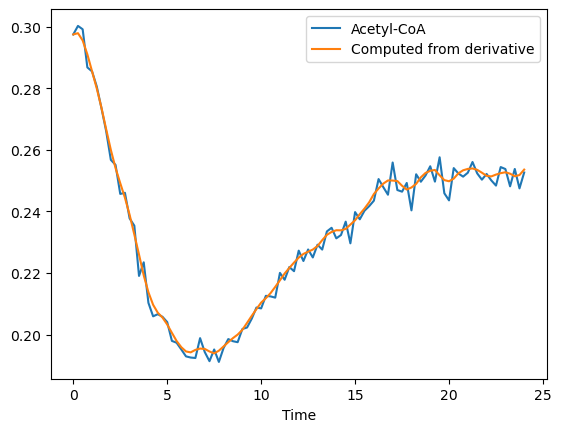

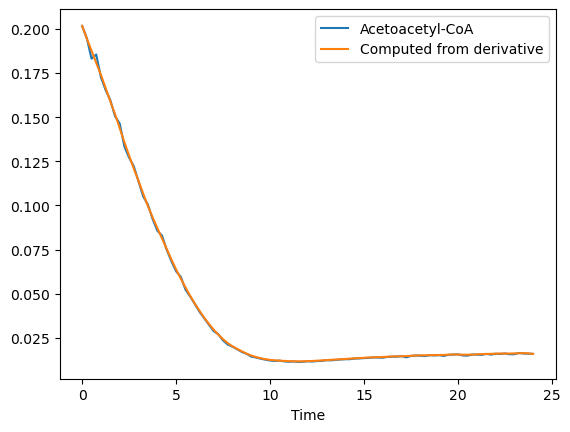

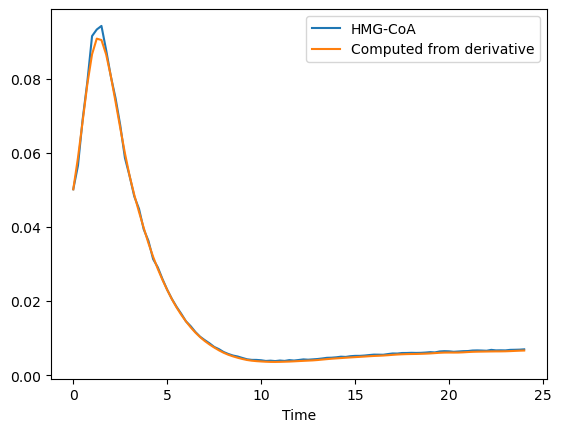

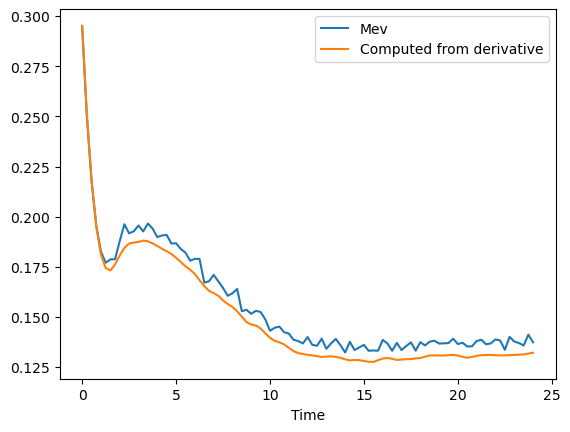

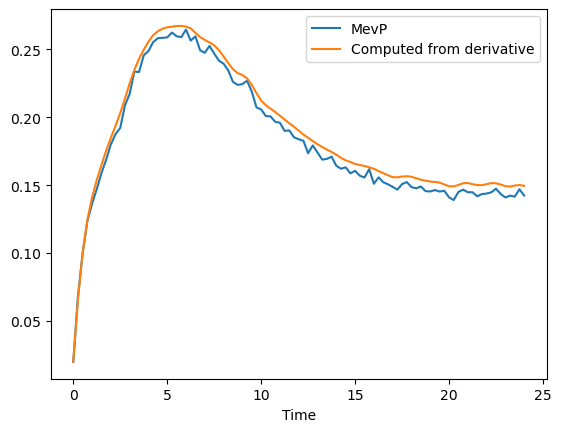

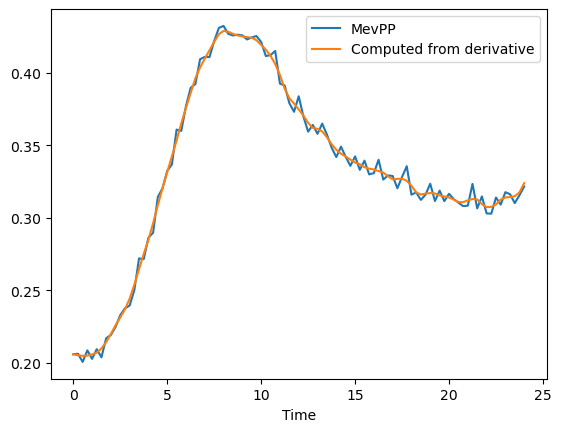

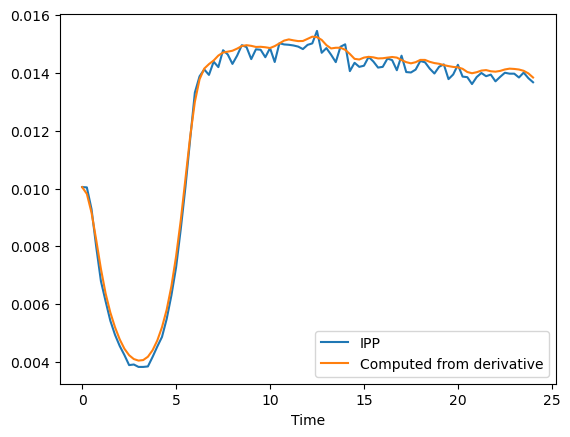

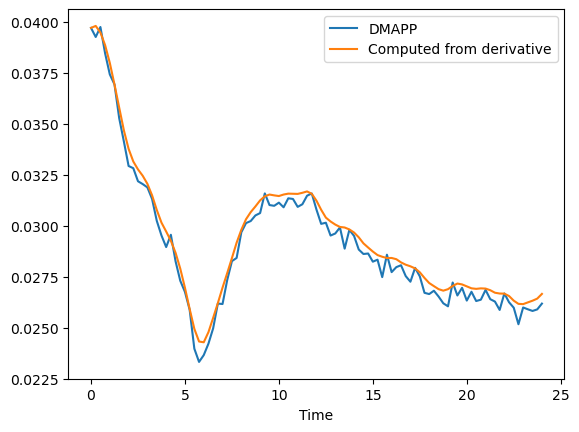

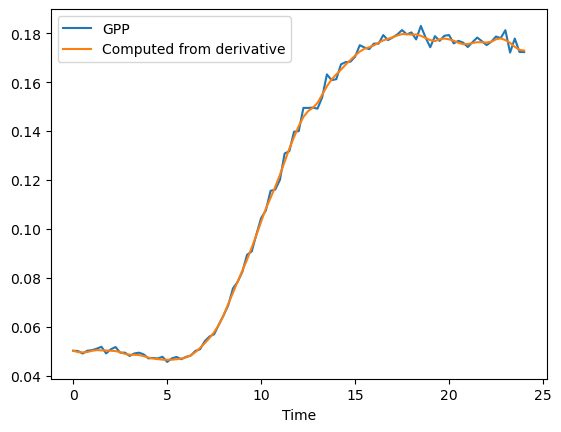

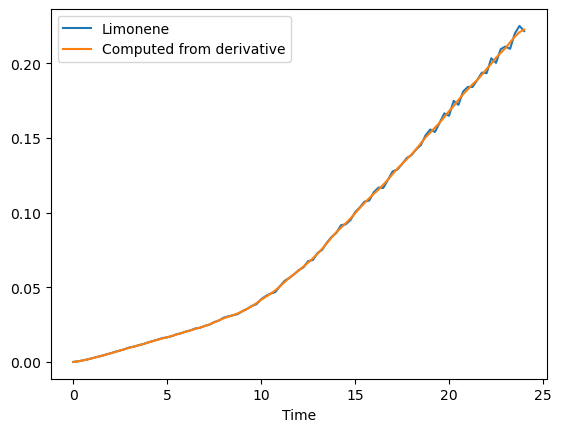

'Time profile from derivative vs. actual profile for Strain 2'

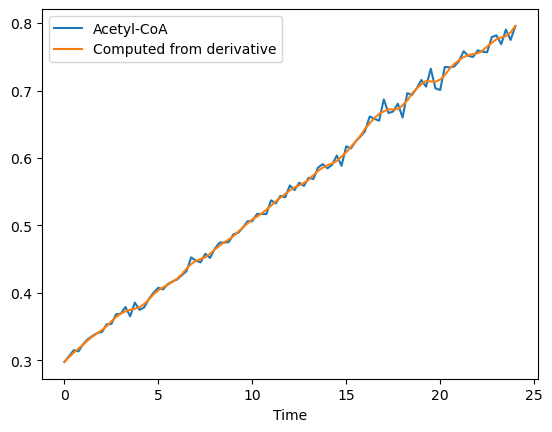

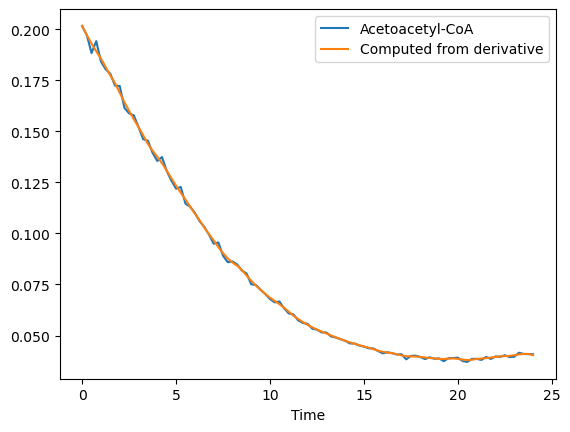

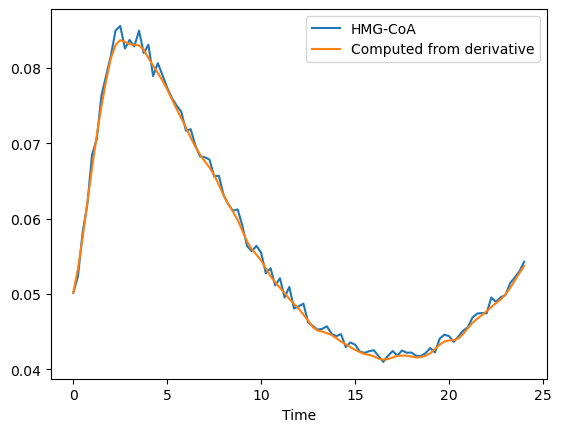

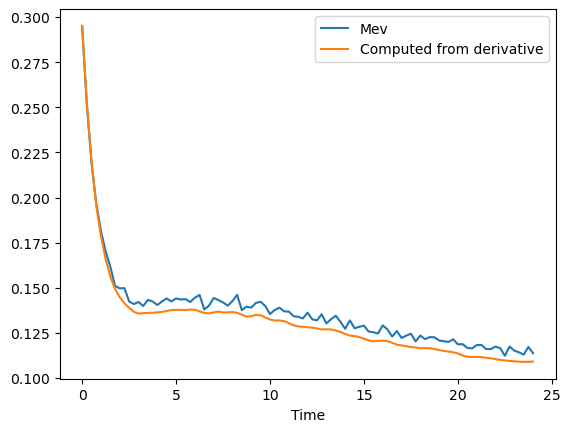

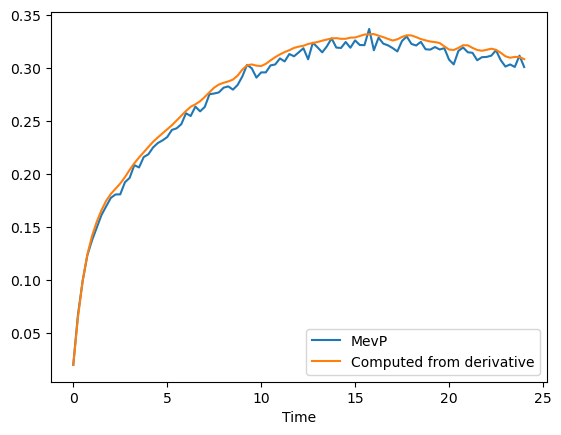

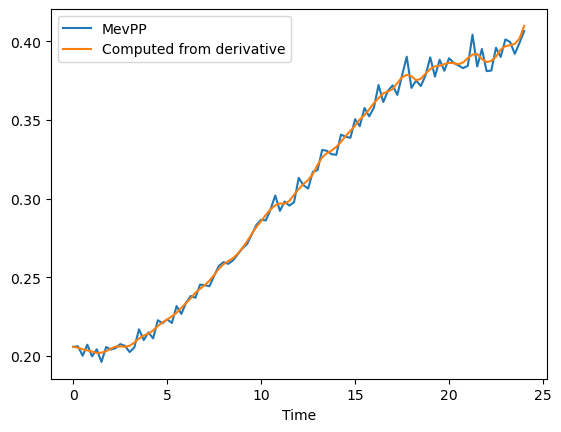

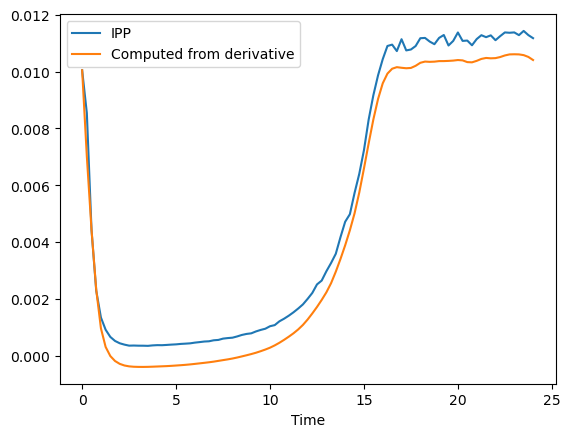

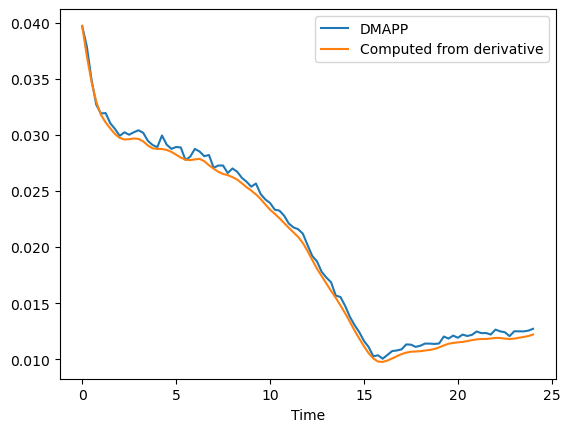

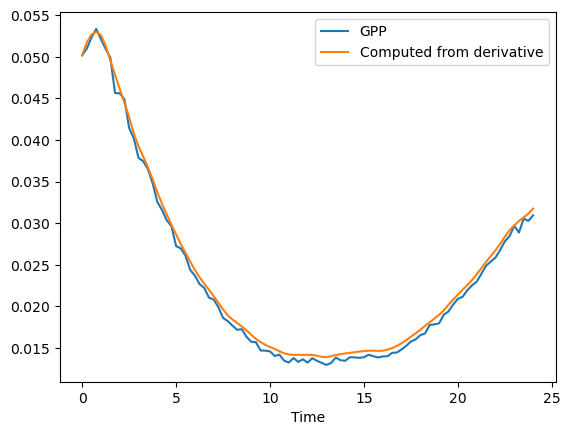

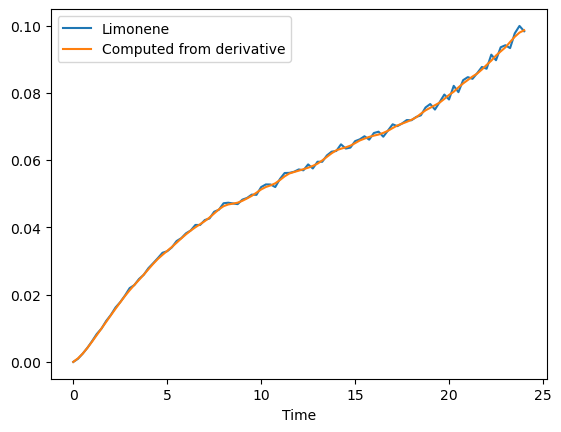

'Time profile from derivative vs. actual profile for Strain 3'

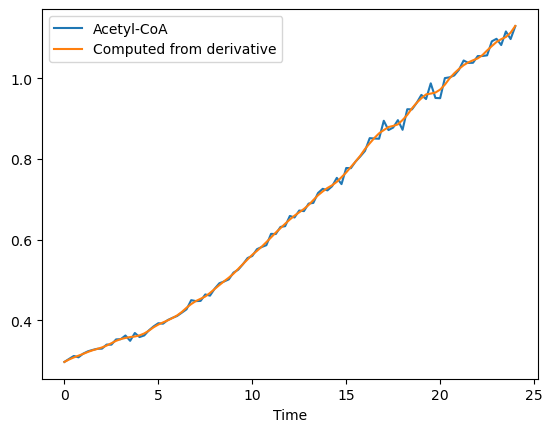

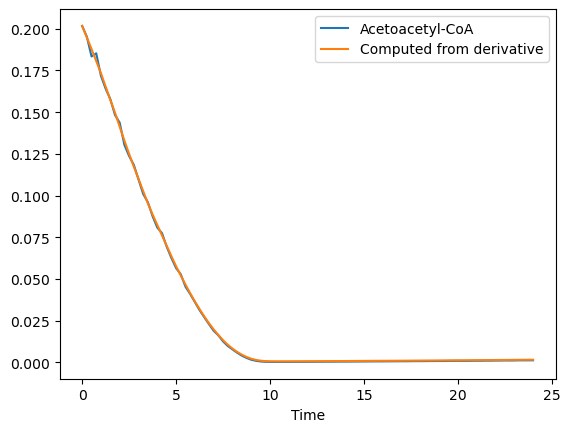

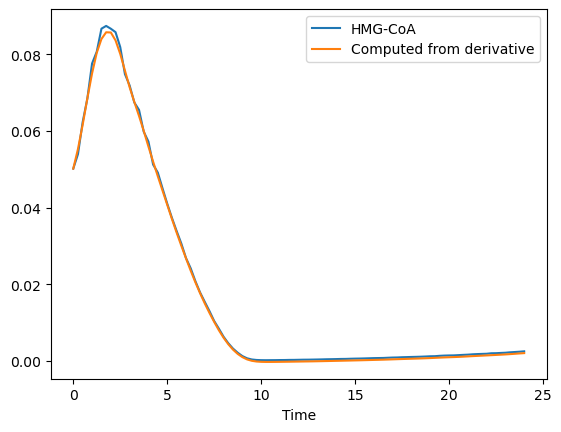

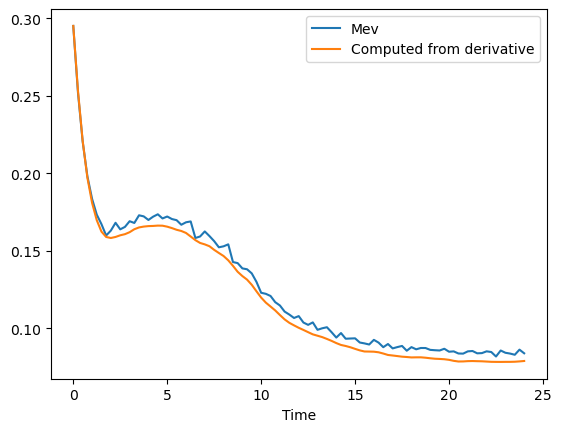

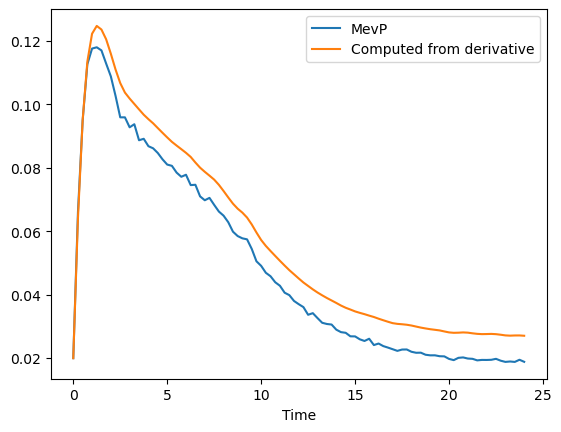

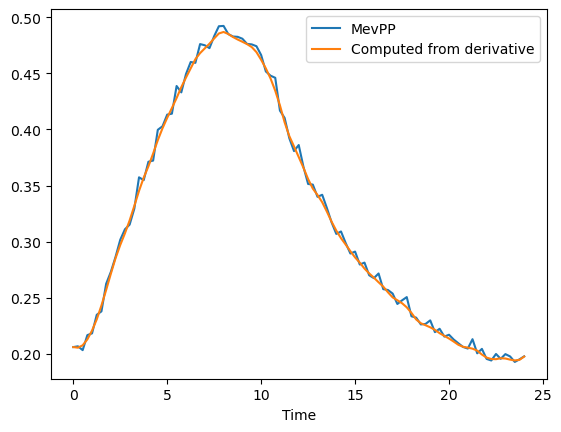

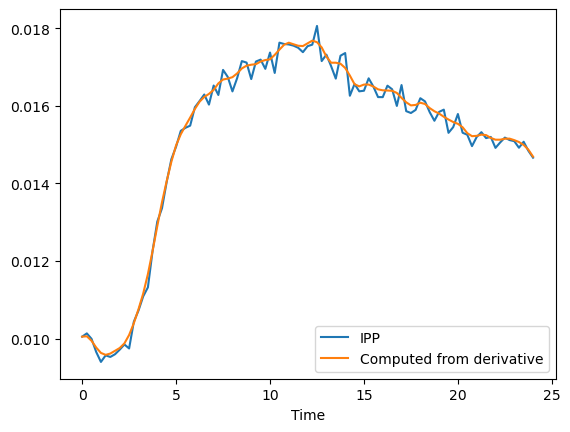

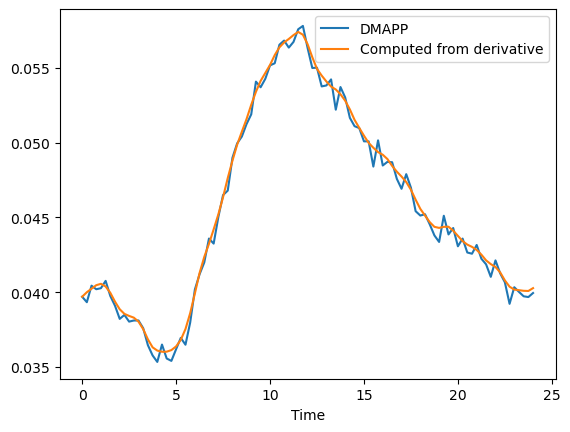

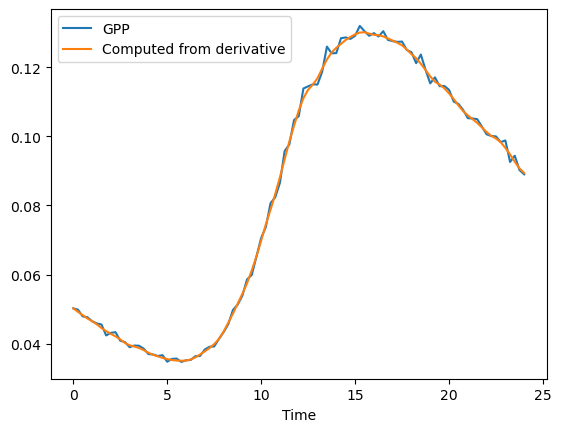

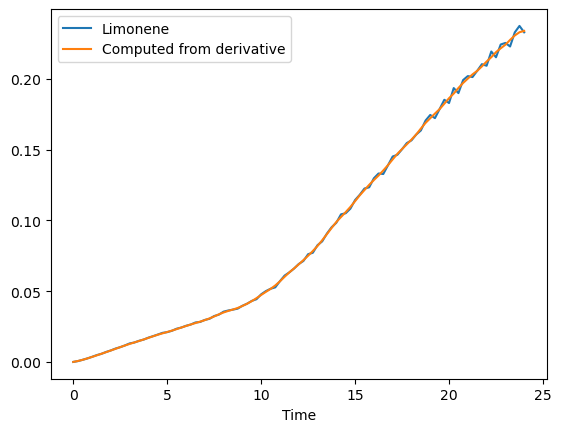

'Time profile from derivative vs. actual profile for WT'

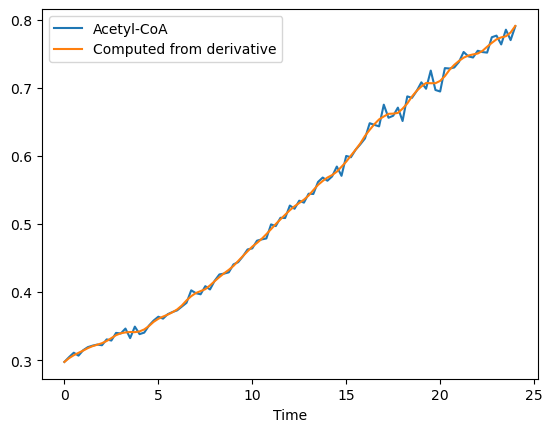

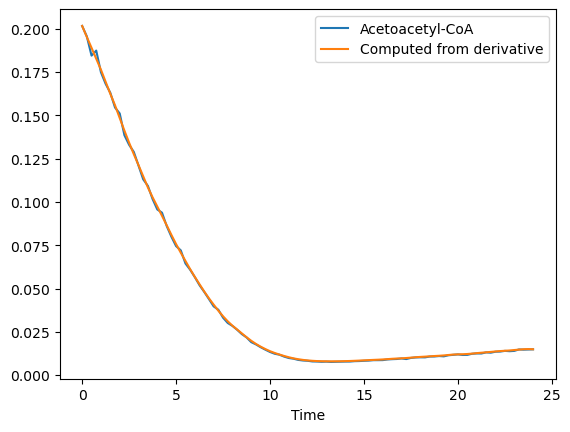

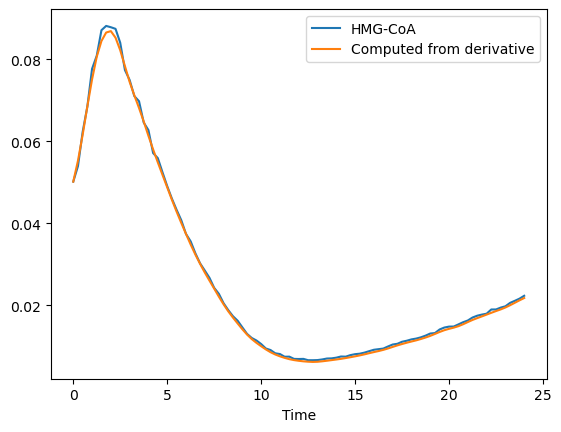

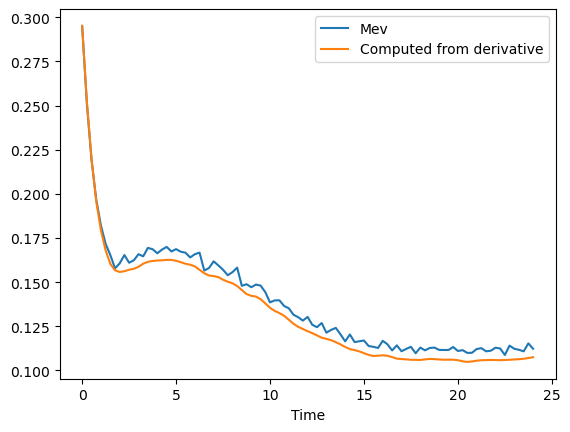

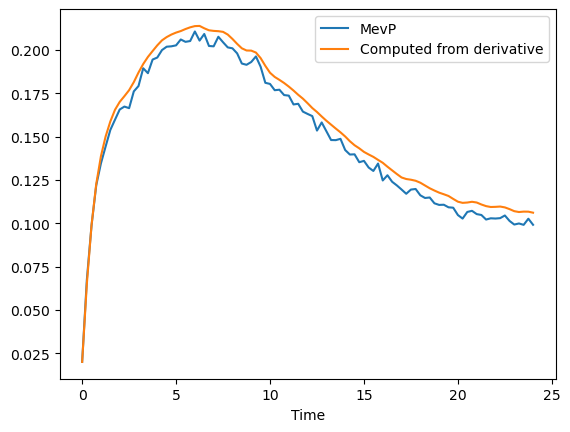

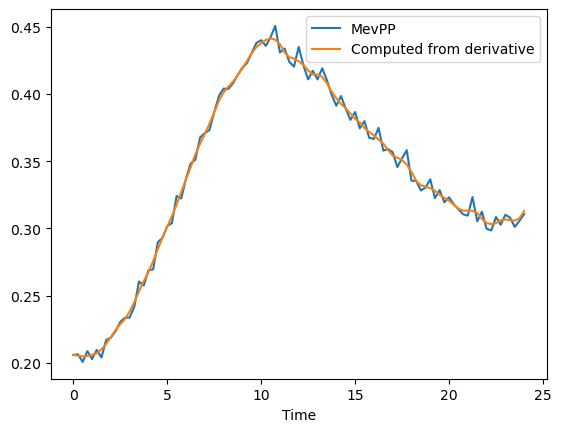

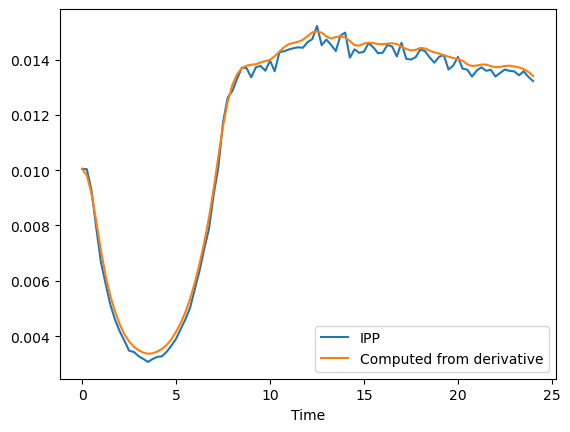

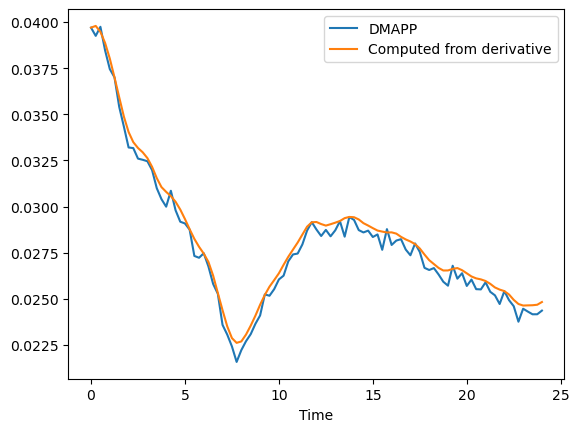

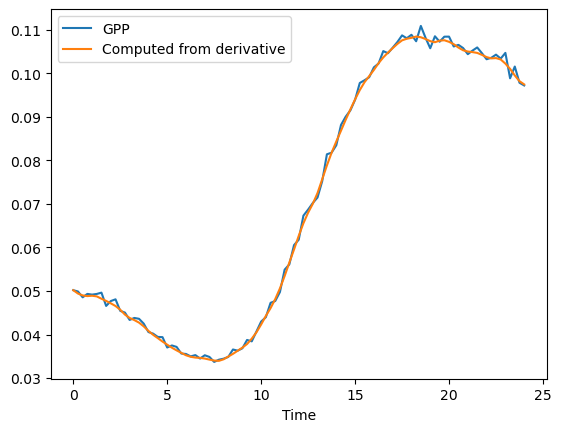

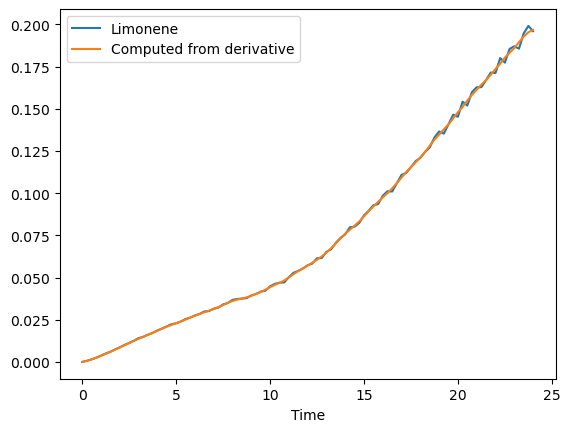

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.895904e+01  4.006396e+01  3.708489e+01  5.668387e+01   
         0.25   4.619542e+06  2.317008e+06  2.160956e+05  1.398457e+06   
         0.50   5.512627e+06  3.556799e+06  3.385569e+05  2.153234e+06   
         0.75   5.929421e+06  4.100638e+06  4.201464e+05  2.663142e+06   
         1.00   5.939704e+06  4.650100e+06  4.739500e+05  3.042015e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.713909e+06  2.632876e+06  1.768712e+06  2.006850e+06   
         23.25  2.748672e+06  2.663635e+06  1.787678e+06  2.019082e+06   
         23.50  2.713428e+06  2.759470e+06  1.739231e+06  2.027699e+06   
         23.75  2.820893e+06  2.699809e+06  1.789693e+06  2.003403e+06   
         24.00  2.690745e+06  2.634564e+06  1.765057e+06  2.028786e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.652667e+01  5.609052e+01  5.574226e+01  1.854788e+01   
         0.25   4.733219e+05  2.255882e+06  2.681733e+06  4.347550e+05   
         0.50   7.349474e+05  3.745038e+06  3.244573e+06  6.404414e+05   
         0.75   8.987189e+05  4.746496e+06  3.532781e+06  7.774754e+05   
         1.00   9.753001e+05  5.461227e+06  3.825207e+06  8.426694e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.494655e+06  3.940687e+06  4.425821e+06  1.213425e+06   
         23.25  1.497491e+06  3.971669e+06  4.379524e+06  1.241157e+06   
         23.50  1.528124e+06  3.910251e+06  4.408977e+06  1.247393e+06   
         23.75  1.486258e+06  4.001348e+06  4.414003e+06  1.251412e+06   
         24.00  1.515767e+06  3.977775e+06  4.322492e+06  1.216404e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.045565e+01   0.297424        0.201680  0.050157   
         0.25       1.806722e+05   0.300192        0.194677  0.056548   
         0.50       2.877380e+05   0.299105        0.183105  0.069053   
         0.75       3.644992e+05   0.286732        0.185485  0.079197   
         1.00       3.980958e+05   0.285431        0.172543  0.091509   
...                          ...        ...             ...       ...   
WT       23.00      1.432944e+06   0.776930        0.013964  0.019737   
         23.25      1.445567e+06   0.763973        0.014793  0.020571   
         23.50      1.477006e+06   0.785629        0.014680  0.021069   
         23.75      1.458479e+06   0.770307        0.014771  0.021598   
         24.00      1.473737e+06   0.790581        0.014852  0.022301   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.295112  0.019945  0.205907  0.010049  0.039701  0.050189   
         0.25   0.250207  0.068294  0.206308  0.010039  0.039255  0.050087   
         0.50   0.217981  0.100099  0.200683  0.009286  0.039745  0.049050   
         0.75   0.195711  0.123435  0.208653  0.007979  0.038452  0.050208   
         1.00   0.182604  0.136342  0.202782  0.006795  0.037419  0.050439   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112279  0.099257  0.310161  0.013573  0.024459  0.104682   
         23.25  0.111720  0.099873  0.307878  0.013429  0.024304  0.098845   
         23.50  0.110822  0.099085  0.301128  0.013576  0.024158 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.007219       -0.029358  0.031305 -0.195864  0.205861   
         0.25    -0.003880       -0.028173  0.036723 -0.153834  0.160517   
         0.50    -0.014979       -0.026987  0.042141 -0.111805  0.115174   
         0.75    -0.021182       -0.027670  0.038366 -0.072696  0.077477   
         1.00    -0.022935       -0.026846  0.025788 -0.038885  0.056447   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.022720        0.000965  0.002146  0.000695 -0.004907   
         23.25    0.000102        0.001073  0.002277  0.000437  0.000958   
         23.50    0.013455        0.000702  0.002462  0.001484  0.000988   
         23.75    0.030303       -0.000038  0.002331  0.001762 -0.001246   
         24.00    0.047151       -0.000777  0.002199  0.002040 -0.003479   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.002765 -0.000110  0.001233 -0.003019  0.001473  
         0.25  -0.002163 -0.001768 -0.000456 -0.001385  0.001972  
         0.50  -0.001562 -0.003427 -0.002146  0.000249  0.002472  
         0.75   0.003368 -0.004149 -0.002793  0.001312  0.002937  
         1.00   0.002859 -0.003838 -0.004189  0.002544  0.003087  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003786 -0.000115 -0.000130 -0.003994  0.013848  
         23.25 -0.001295 -0.000172  0.000202 -0.005690  0.013932  
         23.50 -0.000517 -0.000303 -0.000140 -0.006397  0.012547  
         23.75  0.014288 -0.000511  0.000349 -0.004109  0.008059  
         24.00  0.029092 -0.000720  0.000837 -0.001821  0.003571  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 | 1.360519E+189 |  6.552085E+87
     2 |      128 | 7.165178E+185 |  1.158300E+18
     3 |      192 | 4.569664E+183 |  1.300250E+05
     4 |      256 | 4.553991E+183 |  1.896929E+03
     5 |      320 |  2.641701E+71 |  5.191209E+02
     6 |      384 |  3.200576E+17 |  8.732737E+01
     7 |      448 |  2.989812E+03 |  4.681648E+01
     8 |      512 |  2.781834E+02 |  3.323806E+01
     9 |      576 |  2.461365E+02 |  2.837111E+01
    10 |      640 |  6.494334E+01 |  2.728291E+01
    11 |      704 |  2.863304E+01 |  2.630165E+01
    12 |      768 |  2.715339E+01 |  2.580729E+01
    13 |      832 |  2.601114E+01 |  2.490821E+01
    14 |      896 |  2.538032E+01 |  2.488941E+01
    15 |      960 |  2.510447E+01 |  2.484455E+01
    16 |     1024 |  2.489218E+01 |  2.469322E+01
    17 |     1088 |  2.474797E+01 |  2.455186E+01
    18 |     1152 |  2.464503E+01 |  2.454406E+01
    19 |     1216 |  2.45

   162 |    10368 |  1.560226E+01 |  1.560012E+01
   163 |    10432 |  1.560096E+01 |  1.559898E+01
   164 |    10496 |  1.559898E+01 |  1.559632E+01
   165 |    10560 |  1.559630E+01 |  1.559293E+01
   166 |    10624 |  1.559328E+01 |  1.558948E+01
   167 |    10688 |  1.559077E+01 |  1.558737E+01
   168 |    10752 |  1.558793E+01 |  1.558471E+01
   169 |    10816 |  1.558513E+01 |  1.558142E+01
   170 |    10880 |  1.558188E+01 |  1.557826E+01
   171 |    10944 |  1.557869E+01 |  1.557575E+01
   172 |    11008 |  1.557626E+01 |  1.557286E+01
   173 |    11072 |  1.557370E+01 |  1.556923E+01
   174 |    11136 |  1.557061E+01 |  1.556628E+01
   175 |    11200 |  1.556821E+01 |  1.556158E+01
   176 |    11264 |  1.556357E+01 |  1.555522E+01
   177 |    11328 |  1.555772E+01 |  1.555273E+01
   178 |    11392 |  1.555481E+01 |  1.555043E+01
   179 |    11456 |  1.555159E+01 |  1.554788E+01
   180 |    11520 |  1.554878E+01 |  1.554621E+01
   181 |    11584 |  1.554705E+01 |  1.554453E+01


   326 |    20864 |  1.400628E+01 |  1.399788E+01
   327 |    20928 |  1.399981E+01 |  1.399263E+01
   328 |    20992 |  1.399317E+01 |  1.398228E+01
   329 |    21056 |  1.398474E+01 |  1.397401E+01
   330 |    21120 |  1.397666E+01 |  1.396977E+01
   331 |    21184 |  1.397210E+01 |  1.396882E+01
   332 |    21248 |  1.397110E+01 |  1.396840E+01
   333 |    21312 |  1.396897E+01 |  1.396509E+01
   334 |    21376 |  1.396529E+01 |  1.396066E+01
   335 |    21440 |  1.396133E+01 |  1.395698E+01
   336 |    21504 |  1.395808E+01 |  1.395297E+01
   337 |    21568 |  1.395458E+01 |  1.395186E+01
   338 |    21632 |  1.395194E+01 |  1.394927E+01
   339 |    21696 |  1.394856E+01 |  1.394456E+01
   340 |    21760 |  1.394542E+01 |  1.394120E+01
   341 |    21824 |  1.394207E+01 |  1.393781E+01
   342 |    21888 |  1.393767E+01 |  1.393117E+01
   343 |    21952 |  1.393295E+01 |  1.392625E+01
   344 |    22016 |  1.392603E+01 |  1.391353E+01
   345 |    22080 |  1.391803E+01 |  1.390855E+01


   490 |    31360 |  1.217818E+01 |  1.217504E+01
   491 |    31424 |  1.217475E+01 |  1.217043E+01
   492 |    31488 |  1.217123E+01 |  1.216830E+01
   493 |    31552 |  1.216836E+01 |  1.216622E+01
   494 |    31616 |  1.216595E+01 |  1.216312E+01
   495 |    31680 |  1.216347E+01 |  1.216050E+01
   496 |    31744 |  1.216018E+01 |  1.215777E+01
   497 |    31808 |  1.215768E+01 |  1.215391E+01
   498 |    31872 |  1.215430E+01 |  1.214957E+01
   499 |    31936 |  1.214951E+01 |  1.214542E+01
   500 |    32000 |  1.214612E+01 |  1.214167E+01
   501 |    32064 |  1.213484E+01 |  1.212206E+01
   502 |    32128 |  1.212126E+01 |  1.210609E+01
   503 |    32192 |  1.210659E+01 |  1.209075E+01
   504 |    32256 |  1.209356E+01 |  1.207884E+01
   505 |    32320 |  1.208415E+01 |  1.207614E+01
   506 |    32384 |  1.206994E+01 |  1.205233E+01
   507 |    32448 |  1.205270E+01 |  1.203862E+01
   508 |    32512 |  1.204354E+01 |  1.203070E+01
   509 |    32576 |  1.203419E+01 |  1.202641E+01


   654 |    41856 |  1.137063E+01 |  1.136956E+01
   655 |    41920 |  1.136953E+01 |  1.136818E+01
   656 |    41984 |  1.136842E+01 |  1.136710E+01
   657 |    42048 |  1.136703E+01 |  1.136586E+01
   658 |    42112 |  1.136616E+01 |  1.136504E+01
   659 |    42176 |  1.136526E+01 |  1.136408E+01
   660 |    42240 |  1.136419E+01 |  1.136289E+01
   661 |    42304 |  1.136287E+01 |  1.136132E+01
   662 |    42368 |  1.136140E+01 |  1.135952E+01
   663 |    42432 |  1.135951E+01 |  1.135785E+01
   664 |    42496 |  1.135752E+01 |  1.135529E+01
   665 |    42560 |  1.135412E+01 |  1.134855E+01
   666 |    42624 |  1.134989E+01 |  1.134562E+01
   667 |    42688 |  1.134464E+01 |  1.133706E+01
   668 |    42752 |  1.133882E+01 |  1.133239E+01
   669 |    42816 |  1.133365E+01 |  1.132800E+01
   670 |    42880 |  1.132833E+01 |  1.132199E+01
   671 |    42944 |  1.132272E+01 |  1.131539E+01
   672 |    43008 |  1.131686E+01 |  1.131030E+01
   673 |    43072 |  1.131184E+01 |  1.130555E+01


   818 |    52352 |  1.086092E+01 |  1.085157E+01
   819 |    52416 |  1.085079E+01 |  1.083901E+01
   820 |    52480 |  1.084266E+01 |  1.083172E+01
   821 |    52544 |  1.083378E+01 |  1.082569E+01
   822 |    52608 |  1.082878E+01 |  1.082293E+01
   823 |    52672 |  1.082404E+01 |  1.081928E+01
   824 |    52736 |  1.082005E+01 |  1.081638E+01
   825 |    52800 |  1.081746E+01 |  1.081364E+01
   826 |    52864 |  1.081447E+01 |  1.080849E+01
   827 |    52928 |  1.080965E+01 |  1.079895E+01
   828 |    52992 |  1.080169E+01 |  1.079177E+01
   829 |    53056 |  1.079421E+01 |  1.078721E+01
   830 |    53120 |  1.077965E+01 |  1.074304E+01
   831 |    53184 |  1.075673E+01 |  1.072958E+01
   832 |    53248 |  1.073726E+01 |  1.072257E+01
   833 |    53312 |  1.072716E+01 |  1.071972E+01
   834 |    53376 |  1.072261E+01 |  1.071737E+01
   835 |    53440 |  1.071836E+01 |  1.071599E+01
   836 |    53504 |  1.071697E+01 |  1.071565E+01
   837 |    53568 |  1.071568E+01 |  1.071397E+01


   982 |    62848 |  1.050659E+01 |  1.050545E+01
   983 |    62912 |  1.050508E+01 |  1.050320E+01
   984 |    62976 |  1.050351E+01 |  1.050210E+01
   985 |    63040 |  1.050236E+01 |  1.050110E+01
   986 |    63104 |  1.050116E+01 |  1.050006E+01
   987 |    63168 |  1.050011E+01 |  1.049876E+01
   988 |    63232 |  1.049917E+01 |  1.049776E+01
   989 |    63296 |  1.049779E+01 |  1.049642E+01
   990 |    63360 |  1.049682E+01 |  1.049586E+01
   991 |    63424 |  1.049592E+01 |  1.049491E+01
   992 |    63488 |  1.049472E+01 |  1.049295E+01
   993 |    63552 |  1.049304E+01 |  1.049078E+01
   994 |    63616 |  1.049097E+01 |  1.048798E+01
   995 |    63680 |  1.048915E+01 |  1.048685E+01
   996 |    63744 |  1.048761E+01 |  1.048513E+01
   997 |    63808 |  1.048563E+01 |  1.048348E+01
   998 |    63872 |  1.048357E+01 |  1.048133E+01
   999 |    63936 |  1.048131E+01 |  1.047937E+01
  1000 |    64000 |  1.047926E+01 |  1.047669E+01
  1001 |    64064 |  1.047704E+01 |  1.047433E+01


  1146 |    73344 |  1.025792E+01 |  1.025721E+01
  1147 |    73408 |  1.025731E+01 |  1.025638E+01
  1148 |    73472 |  1.025637E+01 |  1.025555E+01
  1149 |    73536 |  1.025548E+01 |  1.025410E+01
  1150 |    73600 |  1.025425E+01 |  1.025312E+01
  1151 |    73664 |  1.025320E+01 |  1.025203E+01
  1152 |    73728 |  1.025231E+01 |  1.025111E+01
  1153 |    73792 |  1.025117E+01 |  1.024964E+01
  1154 |    73856 |  1.024990E+01 |  1.024853E+01
  1155 |    73920 |  1.024885E+01 |  1.024782E+01
  1156 |    73984 |  1.024788E+01 |  1.024693E+01
  1157 |    74048 |  1.024694E+01 |  1.024588E+01
  1158 |    74112 |  1.024602E+01 |  1.024504E+01
  1159 |    74176 |  1.024490E+01 |  1.024363E+01
  1160 |    74240 |  1.024366E+01 |  1.024209E+01
  1161 |    74304 |  1.024239E+01 |  1.024118E+01
  1162 |    74368 |  1.024144E+01 |  1.024069E+01
  1163 |    74432 |  1.024083E+01 |  1.024006E+01
  1164 |    74496 |  1.024026E+01 |  1.023971E+01
  1165 |    74560 |  1.023980E+01 |  1.023925E+01


  1310 |    83840 |  1.003763E+01 |  1.003701E+01
  1311 |    83904 |  1.003721E+01 |  1.003685E+01
  1312 |    83968 |  1.003670E+01 |  1.003590E+01
  1313 |    84032 |  1.003620E+01 |  1.003559E+01
  1314 |    84096 |  1.003576E+01 |  1.003541E+01
  1315 |    84160 |  1.003539E+01 |  1.003495E+01
  1316 |    84224 |  1.003498E+01 |  1.003460E+01
  1317 |    84288 |  1.003462E+01 |  1.003411E+01
  1318 |    84352 |  1.003399E+01 |  1.003328E+01
  1319 |    84416 |  1.003333E+01 |  1.003244E+01
  1320 |    84480 |  1.003238E+01 |  1.003120E+01
  1321 |    84544 |  1.003131E+01 |  1.002964E+01
  1322 |    84608 |  1.003000E+01 |  1.002840E+01
  1323 |    84672 |  1.002880E+01 |  1.002750E+01
  1324 |    84736 |  1.002804E+01 |  1.002720E+01
  1325 |    84800 |  1.002737E+01 |  1.002691E+01
  1326 |    84864 |  1.002697E+01 |  1.002660E+01
  1327 |    84928 |  1.002658E+01 |  1.002611E+01
  1328 |    84992 |  1.002607E+01 |  1.002539E+01
  1329 |    85056 |  1.002541E+01 |  1.002468E+01


  1474 |    94336 |  9.6799695462 |  9.6782767590
  1475 |    94400 |  9.6787972558 |  9.6771318635
  1476 |    94464 |  9.6775179639 |  9.6760924435
  1477 |    94528 |  9.6760162790 |  9.6746262321
  1478 |    94592 |  9.6749167490 |  9.6736765923
  1479 |    94656 |  9.6737470901 |  9.6726092350
  1480 |    94720 |  9.6728162998 |  9.6718390511
  1481 |    94784 |  9.6718913143 |  9.6707627542
  1482 |    94848 |  9.6708367844 |  9.6698953888
  1483 |    94912 |  9.6699808779 |  9.6693724521
  1484 |    94976 |  9.6694870123 |  9.6686187952
  1485 |    95040 |  9.6685327953 |  9.6671878655
  1486 |    95104 |  9.6671312736 |  9.6654521007
  1487 |    95168 |  9.6655531485 |  9.6641247674
  1488 |    95232 |  9.6646607880 |  9.6635929308
  1489 |    95296 |  9.6637462213 |  9.6625872556
  1490 |    95360 |  9.6623860177 |  9.6606596124
  1491 |    95424 |  9.6606913631 |  9.6589357266
  1492 |    95488 |  9.6590155447 |  9.6572173018
  1493 |    95552 |  9.6572839507 |  9.6550439661


  1638 |   104832 |  9.4444022724 |  9.4425426695
  1639 |   104896 |  9.4429478830 |  9.4411522277
  1640 |   104960 |  9.4411148783 |  9.4389924235
  1641 |   105024 |  9.4391807017 |  9.4369442363
  1642 |   105088 |  9.4374564874 |  9.4354415411
  1643 |   105152 |  9.4353749986 |  9.4330595923
  1644 |   105216 |  9.4336954351 |  9.4304121664
  1645 |   105280 |  9.4299973395 |  9.4265283205
  1646 |   105344 |  9.4270831347 |  9.4241393230
  1647 |   105408 |  9.4241176735 |  9.4208610024
  1648 |   105472 |  9.4211436148 |  9.4191828110
  1649 |   105536 |  9.4200656711 |  9.4182900410
  1650 |   105600 |  9.4187099431 |  9.4173478330
  1651 |   105664 |  9.4174824627 |  9.4162234795
  1652 |   105728 |  9.4164489258 |  9.4152842227
  1653 |   105792 |  9.4154420593 |  9.4144005084
  1654 |   105856 |  9.4145041132 |  9.4129455820
  1655 |   105920 |  9.4132123056 |  9.4113437425
  1656 |   105984 |  9.4113686687 |  9.4095017552
  1657 |   106048 |  9.4096451407 |  9.4077942488


  1802 |   115328 |  9.1466069115 |  9.1462569921
  1803 |   115392 |  9.1463190981 |  9.1458549159
  1804 |   115456 |  9.1458148213 |  9.1453011397
  1805 |   115520 |  9.1453888282 |  9.1448059454
  1806 |   115584 |  9.1448516831 |  9.1439783845
  1807 |   115648 |  9.1440473232 |  9.1430158158
  1808 |   115712 |  9.1431475309 |  9.1419580817
  1809 |   115776 |  9.1421794648 |  9.1409497542
  1810 |   115840 |  9.1409856363 |  9.1401488292
  1811 |   115904 |  9.1402692911 |  9.1393685108
  1812 |   115968 |  9.1394253316 |  9.1387421449
  1813 |   116032 |  9.1385474919 |  9.1374991843
  1814 |   116096 |  9.1372590049 |  9.1359939513
  1815 |   116160 |  9.1363546695 |  9.1352793595
  1816 |   116224 |  9.1354301717 |  9.1344190799
  1817 |   116288 |  9.1348165073 |  9.1335624644
  1818 |   116352 |  9.1334653752 |  9.1324462510
  1819 |   116416 |  9.1328507875 |  9.1321654947
  1820 |   116480 |  9.1322733485 |  9.1315311950
  1821 |   116544 |  9.1317177502 |  9.1310933697


  1966 |   125824 |  8.8650030441 |  8.8591346445
  1967 |   125888 |  8.8596406536 |  8.8541074032
  1968 |   125952 |  8.8543190214 |  8.8489960959
  1969 |   126016 |  8.8497522752 |  8.8449305012
  1970 |   126080 |  8.8456793964 |  8.8421261057
  1971 |   126144 |  8.8432212322 |  8.8395601250
  1972 |   126208 |  8.8396430157 |  8.8349773575
  1973 |   126272 |  8.8358180397 |  8.8307081739
  1974 |   126336 |  8.8311129875 |  8.8246120242
  1975 |   126400 |  8.8255710176 |  8.8211196528
  1976 |   126464 |  8.8215136968 |  8.8177597252
  1977 |   126528 |  8.8170671648 |  8.8113248913
  1978 |   126592 |  8.8119864912 |  8.8058160160
  1979 |   126656 |  8.8075077530 |  8.8019107763
  1980 |   126720 |  8.8028177135 |  8.7977276728
  1981 |   126784 |  8.7978593486 |  8.7924940270
  1982 |   126848 |  8.7931165882 |  8.7875932696
  1983 |   126912 |  8.7870301349 |  8.7800394970
  1984 |   126976 |  8.7811199540 |  8.7733309276
  1985 |   127040 |  8.7738090632 |  8.7670111154


  2130 |   136320 |  8.5720485777 |  8.5715165462
  2131 |   136384 |  8.5714870054 |  8.5707437606
  2132 |   136448 |  8.5706176799 |  8.5693813822
  2133 |   136512 |  8.5697179677 |  8.5685597077
  2134 |   136576 |  8.5686923951 |  8.5677160689
  2135 |   136640 |  8.5675450256 |  8.5660032695
  2136 |   136704 |  8.5656379436 |  8.5639839646
  2137 |   136768 |  8.5641190169 |  8.5621757696
  2138 |   136832 |  8.5624837349 |  8.5610302021
  2139 |   136896 |  8.5607953875 |  8.5592596579
  2140 |   136960 |  8.5592533759 |  8.5572224653
  2141 |   137024 |  8.5573294634 |  8.5556433360
  2142 |   137088 |  8.5557476979 |  8.5540232466
  2143 |   137152 |  8.5541732122 |  8.5516439243
  2144 |   137216 |  8.5522960076 |  8.5494082244
  2145 |   137280 |  8.5497598396 |  8.5466974324
  2146 |   137344 |  8.5474957495 |  8.5454882687
  2147 |   137408 |  8.5456891596 |  8.5441796397
  2148 |   137472 |  8.5442712313 |  8.5423923096
  2149 |   137536 |  8.5427333231 |  8.5406381770


  2294 |   146816 |  8.3855196741 |  8.3810902451
  2295 |   146880 |  8.3812767491 |  8.3750571940
  2296 |   146944 |  8.3761120108 |  8.3703086239
  2297 |   147008 |  8.3723820562 |  8.3679573333
  2298 |   147072 |  8.3691354822 |  8.3660653279
  2299 |   147136 |  8.3657336923 |  8.3624036822
  2300 |   147200 |  8.3625576023 |  8.3588621958
  2301 |   147264 |  8.3594230679 |  8.3549003569
  2302 |   147328 |  8.3566705355 |  8.3533464665
  2303 |   147392 |  8.3543094651 |  8.3509190427
  2304 |   147456 |  8.3515988014 |  8.3478563837
  2305 |   147520 |  8.3492236253 |  8.3468032851
  2306 |   147584 |  8.3474886255 |  8.3439012447
  2307 |   147648 |  8.3441272121 |  8.3408762995
  2308 |   147712 |  8.3415731507 |  8.3386320872
  2309 |   147776 |  8.3381245106 |  8.3356148059
  2310 |   147840 |  8.3359436607 |  8.3336378552
  2311 |   147904 |  8.3341137262 |  8.3323413431
  2312 |   147968 |  8.3323023608 |  8.3306320442
  2313 |   148032 |  8.3307852851 |  8.3287079341


  2458 |   157312 |  8.1489884364 |  8.1481738747
  2459 |   157376 |  8.1479512493 |  8.1470503290
  2460 |   157440 |  8.1470149758 |  8.1461301384
  2461 |   157504 |  8.1461004510 |  8.1450617949
  2462 |   157568 |  8.1454389469 |  8.1446611436
  2463 |   157632 |  8.1447308572 |  8.1438438015
  2464 |   157696 |  8.1439771894 |  8.1432817119
  2465 |   157760 |  8.1430701493 |  8.1422526662
  2466 |   157824 |  8.1419793493 |  8.1405804723
  2467 |   157888 |  8.1407960021 |  8.1394429022
  2468 |   157952 |  8.1399633689 |  8.1390190747
  2469 |   158016 |  8.1391818924 |  8.1384123275
  2470 |   158080 |  8.1385231936 |  8.1377798802
  2471 |   158144 |  8.1379102074 |  8.1375112892
  2472 |   158208 |  8.1375721897 |  8.1372883190
  2473 |   158272 |  8.1373096955 |  8.1370252603
  2474 |   158336 |  8.1369985142 |  8.1366602458
  2475 |   158400 |  8.1367189056 |  8.1364888954
  2476 |   158464 |  8.1364965884 |  8.1362206089
  2477 |   158528 |  8.1362390543 |  8.1358861628


  2622 |   167808 |  7.9307779581 |  7.9262699756
  2623 |   167872 |  7.9272802377 |  7.9233490270
  2624 |   167936 |  7.9238792822 |  7.9221484182
  2625 |   168000 |  7.9224036718 |  7.9208636006
  2626 |   168064 |  7.9207719054 |  7.9192639751
  2627 |   168128 |  7.9193151056 |  7.9177572066
  2628 |   168192 |  7.9180056714 |  7.9163214099
  2629 |   168256 |  7.9166046762 |  7.9150209330
  2630 |   168320 |  7.9146332631 |  7.9124900980
  2631 |   168384 |  7.9133058392 |  7.9116477138
  2632 |   168448 |  7.9118502294 |  7.9104913913
  2633 |   168512 |  7.9110131816 |  7.9093064829
  2634 |   168576 |  7.9094277146 |  7.9077933317
  2635 |   168640 |  7.9080298669 |  7.9065177422
  2636 |   168704 |  7.9066951289 |  7.9055422653
  2637 |   168768 |  7.9059083903 |  7.9048865401
  2638 |   168832 |  7.9049463816 |  7.9037413877
  2639 |   168896 |  7.9040490484 |  7.9028378927
  2640 |   168960 |  7.9029703488 |  7.9018849008
  2641 |   169024 |  7.9020888384 |  7.9008683706


  2786 |   178304 |  7.7767577853 |  7.7750955806
  2787 |   178368 |  7.7752585932 |  7.7734366274
  2788 |   178432 |  7.7732079047 |  7.7704830057
  2789 |   178496 |  7.7710240279 |  7.7691849989
  2790 |   178560 |  7.7692902952 |  7.7679802896
  2791 |   178624 |  7.7680606320 |  7.7668978986
  2792 |   178688 |  7.7669254676 |  7.7648846239
  2793 |   178752 |  7.7655099156 |  7.7637557199
  2794 |   178816 |  7.7640909062 |  7.7630833064
  2795 |   178880 |  7.7627273615 |  7.7607145149
  2796 |   178944 |  7.7608663480 |  7.7587810643
  2797 |   179008 |  7.7593388415 |  7.7579968221
  2798 |   179072 |  7.7580925045 |  7.7564887418
  2799 |   179136 |  7.7562399458 |  7.7547168507
  2800 |   179200 |  7.7548727888 |  7.7536152817
  2801 |   179264 |  7.7538634898 |  7.7527672784
  2802 |   179328 |  7.7527140859 |  7.7513180618
  2803 |   179392 |  7.7517331517 |  7.7508168867
  2804 |   179456 |  7.7511102661 |  7.7502349500
  2805 |   179520 |  7.7501056752 |  7.7492452286


  2950 |   188800 |  7.2686828243 |  7.2683270318
  2951 |   188864 |  7.2682996387 |  7.2678576104
  2952 |   188928 |  7.2679281897 |  7.2672627629
  2953 |   188992 |  7.2674118164 |  7.2667215870
  2954 |   189056 |  7.2668596341 |  7.2660741674
  2955 |   189120 |  7.2662179564 |  7.2657424675
  2956 |   189184 |  7.2656724122 |  7.2649920610
  2957 |   189248 |  7.2651412002 |  7.2644950903
  2958 |   189312 |  7.2645853087 |  7.2640128486
  2959 |   189376 |  7.2640680060 |  7.2636298309
  2960 |   189440 |  7.2637090484 |  7.2632784145
  2961 |   189504 |  7.2633569241 |  7.2629498393
  2962 |   189568 |  7.2629677813 |  7.2624730266
  2963 |   189632 |  7.2624808555 |  7.2620726846
  2964 |   189696 |  7.2620383227 |  7.2613865605
  2965 |   189760 |  7.2615306456 |  7.2609938814
  2966 |   189824 |  7.2610285717 |  7.2604332805
  2967 |   189888 |  7.2603941087 |  7.2596094240
  2968 |   189952 |  7.2597338256 |  7.2589883257
  2969 |   190016 |  7.2591289083 |  7.2586521166


  3114 |   199296 |  7.1582315595 |  7.1576386806
  3115 |   199360 |  7.1575002913 |  7.1564935719
  3116 |   199424 |  7.1564864142 |  7.1555697401
  3117 |   199488 |  7.1554778967 |  7.1544780689
  3118 |   199552 |  7.1545294140 |  7.1534525305
  3119 |   199616 |  7.1535214702 |  7.1524412219
  3120 |   199680 |  7.1526551414 |  7.1515274542
  3121 |   199744 |  7.1515563016 |  7.1504318385
  3122 |   199808 |  7.1503355424 |  7.1487931955
  3123 |   199872 |  7.1487503716 |  7.1473710520
  3124 |   199936 |  7.1472543075 |  7.1462177711
  3125 |   200000 |  7.1464558295 |  7.1454468378
  3126 |   200064 |  7.1453945451 |  7.1443269609
  3127 |   200128 |  7.1444808332 |  7.1436760603
  3128 |   200192 |  7.1437906880 |  7.1430757400
  3129 |   200256 |  7.1430083023 |  7.1423008411
  3130 |   200320 |  7.1423160869 |  7.1413701995
  3131 |   200384 |  7.1416297357 |  7.1405352126
  3132 |   200448 |  7.1403899122 |  7.1387635424
  3133 |   200512 |  7.1390800709 |  7.1373425326


  3278 |   209792 |  6.8654563497 |  6.8641874857
  3279 |   209856 |  6.8643995921 |  6.8633187570
  3280 |   209920 |  6.8633030335 |  6.8618477976
  3281 |   209984 |  6.8621196882 |  6.8610455546
  3282 |   210048 |  6.8610661064 |  6.8602656033
  3283 |   210112 |  6.8601690727 |  6.8594385396
  3284 |   210176 |  6.8595111032 |  6.8587538526
  3285 |   210240 |  6.8588899474 |  6.8582638948
  3286 |   210304 |  6.8583256180 |  6.8578794412
  3287 |   210368 |  6.8579162203 |  6.8574602168
  3288 |   210432 |  6.8575572896 |  6.8571363433
  3289 |   210496 |  6.8571605570 |  6.8568493114
  3290 |   210560 |  6.8569409663 |  6.8566138610
  3291 |   210624 |  6.8566519561 |  6.8563716708
  3292 |   210688 |  6.8563672270 |  6.8560027170
  3293 |   210752 |  6.8558752892 |  6.8552302279
  3294 |   210816 |  6.8550292785 |  6.8538998005
  3295 |   210880 |  6.8537711778 |  6.8517313283
  3296 |   210944 |  6.8514082919 |  6.8491443132
  3297 |   211008 |  6.8497617108 |  6.8469177543


  3442 |   220288 |  6.3949065952 |  6.3890650957
  3443 |   220352 |  6.3899979484 |  6.3856059628
  3444 |   220416 |  6.3872751029 |  6.3843771960
  3445 |   220480 |  6.3847164253 |  6.3818916235
  3446 |   220544 |  6.3824905028 |  6.3807201442
  3447 |   220608 |  6.3809976250 |  6.3783660530
  3448 |   220672 |  6.3785347537 |  6.3754576822
  3449 |   220736 |  6.3758163269 |  6.3732997832
  3450 |   220800 |  6.3736024888 |  6.3719684330
  3451 |   220864 |  6.3722593711 |  6.3709582966
  3452 |   220928 |  6.3711642701 |  6.3701412114
  3453 |   220992 |  6.3701723067 |  6.3693516910
  3454 |   221056 |  6.3694439180 |  6.3685893092
  3455 |   221120 |  6.3686253484 |  6.3677728269
  3456 |   221184 |  6.3679599219 |  6.3672312287
  3457 |   221248 |  6.3671492610 |  6.3658411424
  3458 |   221312 |  6.3657377623 |  6.3644365197
  3459 |   221376 |  6.3643453826 |  6.3630367576
  3460 |   221440 |  6.3629376725 |  6.3616414371
  3461 |   221504 |  6.3616198266 |  6.3606089123


  3606 |   230784 |  5.6938445837 |  5.6909215875
  3607 |   230848 |  5.6914532920 |  5.6882737882
  3608 |   230912 |  5.6887000663 |  5.6847066325
  3609 |   230976 |  5.6855168701 |  5.6807259425
  3610 |   231040 |  5.6808113731 |  5.6751791887
  3611 |   231104 |  5.6766622471 |  5.6723345193
  3612 |   231168 |  5.6726993334 |  5.6686291162
  3613 |   231232 |  5.6690383447 |  5.6602053446
  3614 |   231296 |  5.6629031092 |  5.6545770867
  3615 |   231360 |  5.6554662915 |  5.6451571650
  3616 |   231424 |  5.6484810073 |  5.6397061142
  3617 |   231488 |  5.6416896139 |  5.6321227100
  3618 |   231552 |  5.6315829139 |  5.6202354950
  3619 |   231616 |  5.6217796479 |  5.6117139850
  3620 |   231680 |  5.6123191493 |  5.6029112643
  3621 |   231744 |  5.6044109006 |  5.5954565999
  3622 |   231808 |  5.5948504817 |  5.5859038541
  3623 |   231872 |  5.5890634649 |  5.5817088755
  3624 |   231936 |  5.5835638583 |  5.5778886029
  3625 |   232000 |  5.5796965738 |  5.5761336422


  3770 |   241280 |  4.7668016567 |  4.7602959056
  3771 |   241344 |  4.7562994321 |  4.7402271934
  3772 |   241408 |  4.7436194453 |  4.7290253138
  3773 |   241472 |  4.7277467772 |  4.7134062040
  3774 |   241536 |  4.7147606813 |  4.7050841196
  3775 |   241600 |  4.7047527991 |  4.6967886795
  3776 |   241664 |  4.6991825985 |  4.6929799376
  3777 |   241728 |  4.6937126207 |  4.6873616769
  3778 |   241792 |  4.6889913680 |  4.6832093541
  3779 |   241856 |  4.6838429382 |  4.6780095906
  3780 |   241920 |  4.6787098747 |  4.6722281244
  3781 |   241984 |  4.6734122685 |  4.6657547038
  3782 |   242048 |  4.6657990459 |  4.6559268723
  3783 |   242112 |  4.6535798622 |  4.6388578073
  3784 |   242176 |  4.6406120341 |  4.6289027981
  3785 |   242240 |  4.6309116579 |  4.6201658050
  3786 |   242304 |  4.6185193328 |  4.6047673833
  3787 |   242368 |  4.6071826505 |  4.5941313305
  3788 |   242432 |  4.5963868757 |  4.5822081695
  3789 |   242496 |  4.5832245097 |  4.5629233953


  3934 |   251776 |  3.9546361895 |  3.9524169121
  3935 |   251840 |  3.9525520678 |  3.9494648647
  3936 |   251904 |  3.9496890839 |  3.9456715802
  3937 |   251968 |  3.9467834692 |  3.9438913891
  3938 |   252032 |  3.9441969379 |  3.9423264127
  3939 |   252096 |  3.9425175251 |  3.9416183943
  3940 |   252160 |  3.9417529447 |  3.9409654599
  3941 |   252224 |  3.9410013288 |  3.9399500870
  3942 |   252288 |  3.9399592875 |  3.9386390173
  3943 |   252352 |  3.9384940949 |  3.9368884754
  3944 |   252416 |  3.9370192292 |  3.9349420268
  3945 |   252480 |  3.9354141370 |  3.9337593874
  3946 |   252544 |  3.9340178705 |  3.9322835954
  3947 |   252608 |  3.9329340231 |  3.9315984605
  3948 |   252672 |  3.9317960330 |  3.9308769755
  3949 |   252736 |  3.9307107907 |  3.9295510819
  3950 |   252800 |  3.9298225855 |  3.9289012632
  3951 |   252864 |  3.9290174130 |  3.9282499282
  3952 |   252928 |  3.9282884590 |  3.9275175813
  3953 |   252992 |  3.9273794435 |  3.9266496508


  4098 |   262272 |  3.7971838867 |  3.7966892430
  4099 |   262336 |  3.7966912523 |  3.7961922067
  4100 |   262400 |  3.7959763043 |  3.7951194831
  4101 |   262464 |  3.7950576748 |  3.7938694019
  4102 |   262528 |  3.7938003795 |  3.7925220980
  4103 |   262592 |  3.7921579331 |  3.7898789659
  4104 |   262656 |  3.7899277756 |  3.7878659871
  4105 |   262720 |  3.7875645978 |  3.7855034618
  4106 |   262784 |  3.7854578554 |  3.7837549520
  4107 |   262848 |  3.7840947078 |  3.7829274336
  4108 |   262912 |  3.7826752447 |  3.7813478168
  4109 |   262976 |  3.7815303227 |  3.7803451700
  4110 |   263040 |  3.7806259687 |  3.7791589684
  4111 |   263104 |  3.7796020487 |  3.7783404574
  4112 |   263168 |  3.7785243208 |  3.7772107628
  4113 |   263232 |  3.7774948030 |  3.7766030219
  4114 |   263296 |  3.7768794531 |  3.7761829508
  4115 |   263360 |  3.7762270155 |  3.7753024369
  4116 |   263424 |  3.7754778714 |  3.7747177627
  4117 |   263488 |  3.7748707965 |  3.7742722356


  4262 |   272768 |  3.6887716378 |  3.6884769584
  4263 |   272832 |  3.6883807951 |  3.6880932576
  4264 |   272896 |  3.6881213342 |  3.6877761507
  4265 |   272960 |  3.6877886212 |  3.6875019397
  4266 |   273024 |  3.6875461153 |  3.6871699966
  4267 |   273088 |  3.6872231482 |  3.6868795981
  4268 |   273152 |  3.6869244562 |  3.6867024348
  4269 |   273216 |  3.6867459343 |  3.6865268999
  4270 |   273280 |  3.6865496944 |  3.6862993329
  4271 |   273344 |  3.6862797111 |  3.6858861376
  4272 |   273408 |  3.6859218167 |  3.6854845894
  4273 |   273472 |  3.6855818192 |  3.6851969213
  4274 |   273536 |  3.6853102190 |  3.6849396263
  4275 |   273600 |  3.6849261090 |  3.6846331662
  4276 |   273664 |  3.6846346200 |  3.6843255459
  4277 |   273728 |  3.6844113619 |  3.6841233406
  4278 |   273792 |  3.6840968391 |  3.6836958594
  4279 |   273856 |  3.6837566278 |  3.6832794730
  4280 |   273920 |  3.6831528182 |  3.6823040179
  4281 |   273984 |  3.6825225199 |  3.6816505866


  4426 |   283264 |  3.5579249100 |  3.5577718203
  4427 |   283328 |  3.5577858407 |  3.5576788717
  4428 |   283392 |  3.5576842974 |  3.5575417480
  4429 |   283456 |  3.5575354202 |  3.5573515073
  4430 |   283520 |  3.5573630119 |  3.5571649809
  4431 |   283584 |  3.5571531889 |  3.5568870370
  4432 |   283648 |  3.5568425020 |  3.5565165173
  4433 |   283712 |  3.5566076604 |  3.5563153153
  4434 |   283776 |  3.5563015575 |  3.5559250992
  4435 |   283840 |  3.5559783555 |  3.5555649905
  4436 |   283904 |  3.5555716272 |  3.5550855225
  4437 |   283968 |  3.5551441787 |  3.5546957507
  4438 |   284032 |  3.5546430859 |  3.5542217051
  4439 |   284096 |  3.5542477652 |  3.5538612391
  4440 |   284160 |  3.5539192542 |  3.5534741076
  4441 |   284224 |  3.5535403852 |  3.5529946345
  4442 |   284288 |  3.5529750919 |  3.5523149601
  4443 |   284352 |  3.5523844267 |  3.5518891695
  4444 |   284416 |  3.5520644124 |  3.5514403182
  4445 |   284480 |  3.5514027445 |  3.5506720096


  4590 |   293760 |  3.4771320818 |  3.4769711118
  4591 |   293824 |  3.4769913051 |  3.4768509334
  4592 |   293888 |  3.4769102442 |  3.4767892969
  4593 |   293952 |  3.4767874973 |  3.4766899011
  4594 |   294016 |  3.4766981235 |  3.4766203421
  4595 |   294080 |  3.4766247881 |  3.4764971787
  4596 |   294144 |  3.4764989730 |  3.4763447138
  4597 |   294208 |  3.4763658716 |  3.4762495027
  4598 |   294272 |  3.4762583029 |  3.4761152182
  4599 |   294336 |  3.4761038135 |  3.4759361133
  4600 |   294400 |  3.4759940179 |  3.4758223015
  4601 |   294464 |  3.4758342567 |  3.4755536557
  4602 |   294528 |  3.4755986975 |  3.4753384404
  4603 |   294592 |  3.4753770328 |  3.4750754398
  4604 |   294656 |  3.4750484238 |  3.4746234587
  4605 |   294720 |  3.4746256056 |  3.4742342692
  4606 |   294784 |  3.4742524390 |  3.4739178754
  4607 |   294848 |  3.4739057636 |  3.4735030071
  4608 |   294912 |  3.4735607536 |  3.4731735112
  4609 |   294976 |  3.4732526078 |  3.4729578056


  4754 |   304256 |  3.4344251680 |  3.4337401453
  4755 |   304320 |  3.4339452491 |  3.4334274365
  4756 |   304384 |  3.4335790798 |  3.4329574007
  4757 |   304448 |  3.4331522335 |  3.4326997369
  4758 |   304512 |  3.4327503617 |  3.4324207207
  4759 |   304576 |  3.4325215570 |  3.4322331460
  4760 |   304640 |  3.4323420921 |  3.4320704100
  4761 |   304704 |  3.4320843522 |  3.4316099642
  4762 |   304768 |  3.4316357170 |  3.4311711123
  4763 |   304832 |  3.4311065839 |  3.4304786319
  4764 |   304896 |  3.4305375991 |  3.4298113464
  4765 |   304960 |  3.4298779405 |  3.4293745823
  4766 |   305024 |  3.4295299733 |  3.4289396608
  4767 |   305088 |  3.4290416701 |  3.4284201853
  4768 |   305152 |  3.4286016382 |  3.4282340327
  4769 |   305216 |  3.4282443140 |  3.4277760911
  4770 |   305280 |  3.4278283806 |  3.4273399244
  4771 |   305344 |  3.4271195072 |  3.4261106468
  4772 |   305408 |  3.4263690179 |  3.4258120837
  4773 |   305472 |  3.4259152117 |  3.4253778405


  4918 |   314752 |  3.3612750878 |  3.3609274241
  4919 |   314816 |  3.3609807424 |  3.3606356532
  4920 |   314880 |  3.3606141959 |  3.3600640225
  4921 |   314944 |  3.3600262989 |  3.3594941824
  4922 |   315008 |  3.3594956309 |  3.3589746885
  4923 |   315072 |  3.3590252106 |  3.3584139257
  4924 |   315136 |  3.3584750672 |  3.3577217905
  4925 |   315200 |  3.3577287503 |  3.3566108484
  4926 |   315264 |  3.3567866543 |  3.3557704699
  4927 |   315328 |  3.3558880408 |  3.3552972476
  4928 |   315392 |  3.3553017610 |  3.3547791720
  4929 |   315456 |  3.3547340893 |  3.3543355514
  4930 |   315520 |  3.3543313346 |  3.3537999632
  4931 |   315584 |  3.3537571213 |  3.3532341586
  4932 |   315648 |  3.3532957553 |  3.3526788920
  4933 |   315712 |  3.3527614547 |  3.3524383234
  4934 |   315776 |  3.3524270188 |  3.3520379048
  4935 |   315840 |  3.3521064288 |  3.3517690596
  4936 |   315904 |  3.3515826689 |  3.3507285904
  4937 |   315968 |  3.3510081769 |  3.3503856924


  5082 |   325248 |  3.3181557454 |  3.3180644019
  5083 |   325312 |  3.3180525711 |  3.3179332065
  5084 |   325376 |  3.3179669612 |  3.3178858835
  5085 |   325440 |  3.3178742719 |  3.3177434441
  5086 |   325504 |  3.3177495488 |  3.3175843385
  5087 |   325568 |  3.3176073591 |  3.3174722188
  5088 |   325632 |  3.3175074363 |  3.3174009670
  5089 |   325696 |  3.3174114712 |  3.3173606268
  5090 |   325760 |  3.3173465666 |  3.3172830770
  5091 |   325824 |  3.3172929281 |  3.3172237849
  5092 |   325888 |  3.3172110125 |  3.3171264480
  5093 |   325952 |  3.3171146252 |  3.3169985569
  5094 |   326016 |  3.3169892395 |  3.3168494791
  5095 |   326080 |  3.3168433643 |  3.3166829109
  5096 |   326144 |  3.3166513123 |  3.3162627162
  5097 |   326208 |  3.3163241036 |  3.3157494236
  5098 |   326272 |  3.3158684744 |  3.3152975995
  5099 |   326336 |  3.3153219143 |  3.3147417736
  5100 |   326400 |  3.3148123167 |  3.3143682223
  5101 |   326464 |  3.3144025342 |  3.3138798300


  5246 |   335744 |  3.2628716628 |  3.2626894173
  5247 |   335808 |  3.2626945207 |  3.2624499039
  5248 |   335872 |  3.2624847588 |  3.2622217392
  5249 |   335936 |  3.2622623654 |  3.2620259466
  5250 |   336000 |  3.2620524003 |  3.2617768916
  5251 |   336064 |  3.2618539609 |  3.2616768353
  5252 |   336128 |  3.2617122360 |  3.2614670021
  5253 |   336192 |  3.2615007764 |  3.2612691798
  5254 |   336256 |  3.2613207901 |  3.2610669600
  5255 |   336320 |  3.2610453760 |  3.2607760492
  5256 |   336384 |  3.2608195529 |  3.2606063144
  5257 |   336448 |  3.2606492918 |  3.2604481905
  5258 |   336512 |  3.2604430589 |  3.2601998581
  5259 |   336576 |  3.2602620393 |  3.2600253453
  5260 |   336640 |  3.2599686174 |  3.2596744460
  5261 |   336704 |  3.2597022239 |  3.2593311079
  5262 |   336768 |  3.2593665622 |  3.2589976976
  5263 |   336832 |  3.2589662537 |  3.2584567916
  5264 |   336896 |  3.2585216428 |  3.2581371207
  5265 |   336960 |  3.2582367777 |  3.2578076905


  5410 |   346240 |  3.2361354842 |  3.2357899887
  5411 |   346304 |  3.2357867117 |  3.2353353145
  5412 |   346368 |  3.2352848491 |  3.2348410104
  5413 |   346432 |  3.2348236060 |  3.2343022187
  5414 |   346496 |  3.2343181272 |  3.2335485203
  5415 |   346560 |  3.2335468280 |  3.2325397232
  5416 |   346624 |  3.2327882857 |  3.2319705107
  5417 |   346688 |  3.2321795154 |  3.2315107011
  5418 |   346752 |  3.2317873438 |  3.2313718462
  5419 |   346816 |  3.2315177288 |  3.2311862935
  5420 |   346880 |  3.2312505535 |  3.2310109988
  5421 |   346944 |  3.2309190346 |  3.2306331464
  5422 |   347008 |  3.2306713608 |  3.2304475399
  5423 |   347072 |  3.2304847123 |  3.2302423845
  5424 |   347136 |  3.2302802469 |  3.2300326057
  5425 |   347200 |  3.2300689037 |  3.2297748306
  5426 |   347264 |  3.2298127651 |  3.2294753153
  5427 |   347328 |  3.2295310791 |  3.2291940895
  5428 |   347392 |  3.2292469040 |  3.2289419155
  5429 |   347456 |  3.2290020500 |  3.2287821588


  5574 |   356736 |  3.1950290153 |  3.1949468486
  5575 |   356800 |  3.1949634518 |  3.1948762639
  5576 |   356864 |  3.1949107489 |  3.1948340117
  5577 |   356928 |  3.1948401743 |  3.1947251201
  5578 |   356992 |  3.1947435535 |  3.1946642266
  5579 |   357056 |  3.1946601456 |  3.1945991335
  5580 |   357120 |  3.1946120696 |  3.1945654218
  5581 |   357184 |  3.1945752381 |  3.1945281154
  5582 |   357248 |  3.1945370628 |  3.1944971057
  5583 |   357312 |  3.1945018488 |  3.1944473138
  5584 |   357376 |  3.1944572623 |  3.1944196518
  5585 |   357440 |  3.1944151937 |  3.1943691123
  5586 |   357504 |  3.1943697000 |  3.1943098108
  5587 |   357568 |  3.1943204605 |  3.1942430782
  5588 |   357632 |  3.1942521232 |  3.1941502586
  5589 |   357696 |  3.1941606694 |  3.1940644800
  5590 |   357760 |  3.1940784878 |  3.1940083573
  5591 |   357824 |  3.1940031352 |  3.1939155265
  5592 |   357888 |  3.1939255667 |  3.1938555114
  5593 |   357952 |  3.1938537692 |  3.1937807344


  5738 |   367232 |  3.1677909313 |  3.1675792353
  5739 |   367296 |  3.1676565801 |  3.1674349305
  5740 |   367360 |  3.1674843835 |  3.1672222681
  5741 |   367424 |  3.1672713056 |  3.1669938903
  5742 |   367488 |  3.1670337484 |  3.1668568886
  5743 |   367552 |  3.1668688395 |  3.1667111112
  5744 |   367616 |  3.1667297689 |  3.1665465574
  5745 |   367680 |  3.1666063818 |  3.1664889490
  5746 |   367744 |  3.1665277954 |  3.1664345565
  5747 |   367808 |  3.1664399711 |  3.1663275446
  5748 |   367872 |  3.1663726648 |  3.1662653059
  5749 |   367936 |  3.1662790233 |  3.1661734114
  5750 |   368000 |  3.1661743235 |  3.1660831213
  5751 |   368064 |  3.1660894841 |  3.1660208494
  5752 |   368128 |  3.1660255839 |  3.1659449192
  5753 |   368192 |  3.1659523249 |  3.1658485959
  5754 |   368256 |  3.1658728848 |  3.1657975903
  5755 |   368320 |  3.1658097839 |  3.1657180510
  5756 |   368384 |  3.1657355057 |  3.1656385342
  5757 |   368448 |  3.1656869730 |  3.1655937687


  5902 |   377728 |  3.1486511188 |  3.1485632802
  5903 |   377792 |  3.1485563413 |  3.1484703435
  5904 |   377856 |  3.1484825745 |  3.1484146453
  5905 |   377920 |  3.1484228743 |  3.1483642587
  5906 |   377984 |  3.1483615509 |  3.1482794811
  5907 |   378048 |  3.1482688502 |  3.1481847615
  5908 |   378112 |  3.1481802448 |  3.1480324652
  5909 |   378176 |  3.1480311090 |  3.1478269225
  5910 |   378240 |  3.1478399652 |  3.1476142911
  5911 |   378304 |  3.1476658483 |  3.1474056179
  5912 |   378368 |  3.1473986690 |  3.1471549154
  5913 |   378432 |  3.1471405104 |  3.1469375065
  5914 |   378496 |  3.1469512014 |  3.1467795165
  5915 |   378560 |  3.1468423132 |  3.1467272945
  5916 |   378624 |  3.1467286740 |  3.1466653759
  5917 |   378688 |  3.1466679446 |  3.1466090226
  5918 |   378752 |  3.1466201735 |  3.1465832093
  5919 |   378816 |  3.1465867182 |  3.1465519365
  5920 |   378880 |  3.1465537549 |  3.1465123101
  5921 |   378944 |  3.1464984818 |  3.1464409215


  6066 |   388224 |  3.1295446222 |  3.1288721333
  6067 |   388288 |  3.1290532463 |  3.1285762694
  6068 |   388352 |  3.1286145868 |  3.1281727629
  6069 |   388416 |  3.1282341660 |  3.1278851977
  6070 |   388480 |  3.1279341345 |  3.1275443581
  6071 |   388544 |  3.1275953109 |  3.1271372332
  6072 |   388608 |  3.1272135765 |  3.1268107243
  6073 |   388672 |  3.1269130514 |  3.1265338040
  6074 |   388736 |  3.1265140166 |  3.1261976519
  6075 |   388800 |  3.1262364573 |  3.1259920526
  6076 |   388864 |  3.1260198287 |  3.1258459330
  6077 |   388928 |  3.1258400514 |  3.1257212143
  6078 |   388992 |  3.1257287507 |  3.1255646932
  6079 |   389056 |  3.1255478688 |  3.1252213552
  6080 |   389120 |  3.1251983564 |  3.1249318997
  6081 |   389184 |  3.1249973248 |  3.1248042926
  6082 |   389248 |  3.1248539870 |  3.1247025954
  6083 |   389312 |  3.1247439984 |  3.1245914995
  6084 |   389376 |  3.1245976975 |  3.1244745769
  6085 |   389440 |  3.1244919445 |  3.1243776044


  6230 |   398720 |  3.1146872800 |  3.1145133372
  6231 |   398784 |  3.1145588251 |  3.1144234051
  6232 |   398848 |  3.1144528761 |  3.1143686631
  6233 |   398912 |  3.1143885765 |  3.1143316641
  6234 |   398976 |  3.1143463889 |  3.1142932908
  6235 |   399040 |  3.1143117546 |  3.1142546506
  6236 |   399104 |  3.1142601090 |  3.1142064503
  6237 |   399168 |  3.1142135686 |  3.1141681360
  6238 |   399232 |  3.1141754091 |  3.1141286996
  6239 |   399296 |  3.1141294700 |  3.1140788650
  6240 |   399360 |  3.1140730856 |  3.1140031481
  6241 |   399424 |  3.1140044864 |  3.1139190078
  6242 |   399488 |  3.1139281115 |  3.1138178292
  6243 |   399552 |  3.1137915614 |  3.1135809168
  6244 |   399616 |  3.1136375096 |  3.1134561480
  6245 |   399680 |  3.1134294875 |  3.1131855209
  6246 |   399744 |  3.1131353819 |  3.1126879792
  6247 |   399808 |  3.1125588356 |  3.1118130851
  6248 |   399872 |  3.1120413941 |  3.1115039612
  6249 |   399936 |  3.1115427559 |  3.1110243559


  6394 |   409216 |  3.0966033941 |  3.0963607572
  6395 |   409280 |  3.0963464520 |  3.0960816979
  6396 |   409344 |  3.0961227993 |  3.0959561310
  6397 |   409408 |  3.0960053088 |  3.0957873025
  6398 |   409472 |  3.0957793542 |  3.0955411046
  6399 |   409536 |  3.0956034898 |  3.0953778319
  6400 |   409600 |  3.0954181189 |  3.0952271875
  6401 |   409664 |  3.0952236014 |  3.0949510983
  6402 |   409728 |  3.0950011926 |  3.0947435256
  6403 |   409792 |  3.0947341268 |  3.0945539155
  6404 |   409856 |  3.0945662074 |  3.0943601016
  6405 |   409920 |  3.0943739323 |  3.0942155324
  6406 |   409984 |  3.0942486622 |  3.0941184991
  6407 |   410048 |  3.0941409284 |  3.0940677433
  6408 |   410112 |  3.0940833420 |  3.0940248308
  6409 |   410176 |  3.0940468642 |  3.0940072267
  6410 |   410240 |  3.0940213257 |  3.0939847217
  6411 |   410304 |  3.0939795568 |  3.0939355979
  6412 |   410368 |  3.0939447964 |  3.0939101034
  6413 |   410432 |  3.0939094373 |  3.0938647240


  6558 |   419712 |  3.0826111385 |  3.0825905818
  6559 |   419776 |  3.0825953182 |  3.0825761965
  6560 |   419840 |  3.0825726459 |  3.0825536321
  6561 |   419904 |  3.0825597597 |  3.0825458616
  6562 |   419968 |  3.0825471048 |  3.0825369002
  6563 |   420032 |  3.0825384080 |  3.0825289624
  6564 |   420096 |  3.0825292504 |  3.0825225326
  6565 |   420160 |  3.0825238373 |  3.0825128841
  6566 |   420224 |  3.0825119089 |  3.0824987069
  6567 |   420288 |  3.0825003400 |  3.0824897153
  6568 |   420352 |  3.0824907203 |  3.0824828177
  6569 |   420416 |  3.0824837198 |  3.0824744734
  6570 |   420480 |  3.0824761184 |  3.0824635875
  6571 |   420544 |  3.0824653746 |  3.0824560337
  6572 |   420608 |  3.0824560876 |  3.0824453540
  6573 |   420672 |  3.0824467403 |  3.0824351388
  6574 |   420736 |  3.0824353300 |  3.0824204508
  6575 |   420800 |  3.0824209733 |  3.0824058920
  6576 |   420864 |  3.0824060893 |  3.0823840838
  6577 |   420928 |  3.0823868287 |  3.0823669175


  6722 |   430208 |  3.0735040288 |  3.0734732062
  6723 |   430272 |  3.0734819223 |  3.0734546589
  6724 |   430336 |  3.0734553183 |  3.0734283780
  6725 |   430400 |  3.0734275739 |  3.0733996598
  6726 |   430464 |  3.0734019545 |  3.0733694187
  6727 |   430528 |  3.0733706698 |  3.0733399281
  6728 |   430592 |  3.0733403161 |  3.0733000924
  6729 |   430656 |  3.0733039364 |  3.0732740979
  6730 |   430720 |  3.0732688201 |  3.0732342861
  6731 |   430784 |  3.0732380141 |  3.0731922708
  6732 |   430848 |  3.0731900869 |  3.0731513292
  6733 |   430912 |  3.0731500427 |  3.0730948065
  6734 |   430976 |  3.0731013712 |  3.0730334026
  6735 |   431040 |  3.0730400335 |  3.0729683547
  6736 |   431104 |  3.0729583975 |  3.0728779972
  6737 |   431168 |  3.0728898576 |  3.0728253681
  6738 |   431232 |  3.0728239198 |  3.0727584746
  6739 |   431296 |  3.0727492528 |  3.0726351002
  6740 |   431360 |  3.0726504400 |  3.0725373567
  6741 |   431424 |  3.0725537606 |  3.0724656922


  6886 |   440704 |  3.0636917360 |  3.0636699699
  6887 |   440768 |  3.0636718503 |  3.0636507981
  6888 |   440832 |  3.0636525532 |  3.0636332235
  6889 |   440896 |  3.0636367975 |  3.0636140009
  6890 |   440960 |  3.0636126699 |  3.0635961468
  6891 |   441024 |  3.0635950952 |  3.0635674164
  6892 |   441088 |  3.0635674596 |  3.0635390524
  6893 |   441152 |  3.0635369105 |  3.0635062899
  6894 |   441216 |  3.0635128334 |  3.0634824823
  6895 |   441280 |  3.0634892458 |  3.0634674042
  6896 |   441344 |  3.0634648005 |  3.0634488716
  6897 |   441408 |  3.0634540083 |  3.0634411593
  6898 |   441472 |  3.0634407656 |  3.0634284439
  6899 |   441536 |  3.0634304436 |  3.0634175045
  6900 |   441600 |  3.0634216502 |  3.0634002060
  6901 |   441664 |  3.0634033372 |  3.0633751529
  6902 |   441728 |  3.0633743497 |  3.0633417887
  6903 |   441792 |  3.0633472519 |  3.0633123877
  6904 |   441856 |  3.0633171162 |  3.0632707688
  6905 |   441920 |  3.0632674125 |  3.0631995500


  7050 |   451200 |  3.0573544360 |  3.0573149620
  7051 |   451264 |  3.0573145405 |  3.0572673310
  7052 |   451328 |  3.0572800526 |  3.0572369458
  7053 |   451392 |  3.0572513255 |  3.0572196354
  7054 |   451456 |  3.0572258420 |  3.0571982177
  7055 |   451520 |  3.0572062972 |  3.0571849948
  7056 |   451584 |  3.0571892056 |  3.0571685946
  7057 |   451648 |  3.0571655176 |  3.0571443247
  7058 |   451712 |  3.0571485028 |  3.0571301580
  7059 |   451776 |  3.0571324700 |  3.0571166249
  7060 |   451840 |  3.0571159375 |  3.0571025099
  7061 |   451904 |  3.0570992938 |  3.0570776254
  7062 |   451968 |  3.0570807498 |  3.0570603708
  7063 |   452032 |  3.0570638534 |  3.0570451457
  7064 |   452096 |  3.0570459652 |  3.0570262389
  7065 |   452160 |  3.0570288917 |  3.0570108588
  7066 |   452224 |  3.0570139548 |  3.0569930674
  7067 |   452288 |  3.0569950310 |  3.0569675235
  7068 |   452352 |  3.0569682780 |  3.0569396638
  7069 |   452416 |  3.0569471258 |  3.0569328927


  7214 |   461696 |  3.0518810796 |  3.0518372101
  7215 |   461760 |  3.0518392517 |  3.0517901508
  7216 |   461824 |  3.0517985102 |  3.0517497206
  7217 |   461888 |  3.0517493826 |  3.0516953121
  7218 |   461952 |  3.0517101946 |  3.0516635376
  7219 |   462016 |  3.0516794164 |  3.0516390413
  7220 |   462080 |  3.0516484998 |  3.0515948833
  7221 |   462144 |  3.0515923765 |  3.0515323443
  7222 |   462208 |  3.0515432480 |  3.0514749889
  7223 |   462272 |  3.0514949275 |  3.0514294197
  7224 |   462336 |  3.0514459540 |  3.0513842483
  7225 |   462400 |  3.0513771195 |  3.0512923345
  7226 |   462464 |  3.0513042125 |  3.0512121562
  7227 |   462528 |  3.0512272173 |  3.0511279637
  7228 |   462592 |  3.0511651841 |  3.0511087550
  7229 |   462656 |  3.0511138331 |  3.0510636279
  7230 |   462720 |  3.0510782330 |  3.0510349471
  7231 |   462784 |  3.0510471585 |  3.0510204683
  7232 |   462848 |  3.0510234643 |  3.0509987474
  7233 |   462912 |  3.0509996723 |  3.0509713774


  7378 |   472192 |  3.0443375166 |  3.0442232646
  7379 |   472256 |  3.0442317369 |  3.0441418925
  7380 |   472320 |  3.0441488346 |  3.0440905194
  7381 |   472384 |  3.0440971500 |  3.0440377020
  7382 |   472448 |  3.0440471305 |  3.0439836897
  7383 |   472512 |  3.0440039192 |  3.0439403456
  7384 |   472576 |  3.0439486269 |  3.0438726768
  7385 |   472640 |  3.0438744086 |  3.0438029296
  7386 |   472704 |  3.0438142233 |  3.0437508186
  7387 |   472768 |  3.0437561358 |  3.0436985778
  7388 |   472832 |  3.0437138101 |  3.0436740863
  7389 |   472896 |  3.0436870694 |  3.0436529269
  7390 |   472960 |  3.0436619976 |  3.0436376542
  7391 |   473024 |  3.0436318505 |  3.0435854737
  7392 |   473088 |  3.0435848111 |  3.0435085412
  7393 |   473152 |  3.0435202702 |  3.0434413641
  7394 |   473216 |  3.0434462065 |  3.0433627159
  7395 |   473280 |  3.0433708285 |  3.0433018236
  7396 |   473344 |  3.0433174292 |  3.0432502915
  7397 |   473408 |  3.0432709370 |  3.0432132221


  7542 |   482688 |  3.0384887967 |  3.0384770916
  7543 |   482752 |  3.0384788735 |  3.0384718075
  7544 |   482816 |  3.0384729488 |  3.0384645273
  7545 |   482880 |  3.0384629676 |  3.0384516452
  7546 |   482944 |  3.0384536691 |  3.0384441517
  7547 |   483008 |  3.0384439706 |  3.0384351836
  7548 |   483072 |  3.0384384061 |  3.0384297645
  7549 |   483136 |  3.0384304997 |  3.0384186313
  7550 |   483200 |  3.0384214558 |  3.0384071462
  7551 |   483264 |  3.0384076799 |  3.0383921416
  7552 |   483328 |  3.0383953937 |  3.0383841086
  7553 |   483392 |  3.0383814166 |  3.0383633028
  7554 |   483456 |  3.0383666931 |  3.0383523380
  7555 |   483520 |  3.0383550426 |  3.0383432206
  7556 |   483584 |  3.0383446547 |  3.0383256533
  7557 |   483648 |  3.0383304677 |  3.0383133062
  7558 |   483712 |  3.0383155177 |  3.0383001147
  7559 |   483776 |  3.0382996274 |  3.0382818869
  7560 |   483840 |  3.0382839499 |  3.0382692809
  7561 |   483904 |  3.0382699943 |  3.0382506557


  7706 |   493184 |  3.0352318014 |  3.0351596619
  7707 |   493248 |  3.0351574875 |  3.0350723983
  7708 |   493312 |  3.0350985325 |  3.0350098598
  7709 |   493376 |  3.0350259078 |  3.0349572783
  7710 |   493440 |  3.0349707660 |  3.0349241788
  7711 |   493504 |  3.0349390425 |  3.0348970150
  7712 |   493568 |  3.0349002203 |  3.0348630408
  7713 |   493632 |  3.0348698205 |  3.0348270975
  7714 |   493696 |  3.0348429465 |  3.0348179374
  7715 |   493760 |  3.0348171927 |  3.0347906458
  7716 |   493824 |  3.0347908669 |  3.0347668213
  7717 |   493888 |  3.0347666458 |  3.0347331072
  7718 |   493952 |  3.0347387152 |  3.0347116466
  7719 |   494016 |  3.0347138032 |  3.0346692711
  7720 |   494080 |  3.0346691066 |  3.0346301563
  7721 |   494144 |  3.0346271846 |  3.0345858560
  7722 |   494208 |  3.0345885556 |  3.0345490392
  7723 |   494272 |  3.0345509453 |  3.0345116991
  7724 |   494336 |  3.0345097212 |  3.0344683117
  7725 |   494400 |  3.0344803211 |  3.0344400055


  7870 |   503680 |  3.0286140838 |  3.0285536728
  7871 |   503744 |  3.0285636642 |  3.0285116965
  7872 |   503808 |  3.0285287461 |  3.0284914701
  7873 |   503872 |  3.0285011628 |  3.0284473269
  7874 |   503936 |  3.0284573081 |  3.0284174190
  7875 |   504000 |  3.0284303072 |  3.0284000909
  7876 |   504064 |  3.0284068490 |  3.0283831586
  7877 |   504128 |  3.0283736200 |  3.0283431449
  7878 |   504192 |  3.0283485974 |  3.0283233404
  7879 |   504256 |  3.0283256690 |  3.0283069342
  7880 |   504320 |  3.0283121098 |  3.0283003402
  7881 |   504384 |  3.0282993492 |  3.0282825681
  7882 |   504448 |  3.0282851477 |  3.0282710793
  7883 |   504512 |  3.0282738052 |  3.0282572007
  7884 |   504576 |  3.0282572669 |  3.0282383562
  7885 |   504640 |  3.0282387999 |  3.0282165264
  7886 |   504704 |  3.0282226926 |  3.0282034238
  7887 |   504768 |  3.0281994044 |  3.0281740720
  7888 |   504832 |  3.0281741574 |  3.0281479050
  7889 |   504896 |  3.0281538988 |  3.0281304895


  8034 |   514176 |  3.0259967337 |  3.0259803485
  8035 |   514240 |  3.0259809706 |  3.0259705203
  8036 |   514304 |  3.0259718476 |  3.0259640277
  8037 |   514368 |  3.0259647402 |  3.0259551024
  8038 |   514432 |  3.0259583755 |  3.0259505690
  8039 |   514496 |  3.0259509833 |  3.0259421247
  8040 |   514560 |  3.0259423880 |  3.0259346840
  8041 |   514624 |  3.0259345362 |  3.0259233220
  8042 |   514688 |  3.0259261760 |  3.0259060058
  8043 |   514752 |  3.0259090504 |  3.0258929486
  8044 |   514816 |  3.0258933521 |  3.0258647292
  8045 |   514880 |  3.0258666506 |  3.0258297459
  8046 |   514944 |  3.0258316081 |  3.0257956335
  8047 |   515008 |  3.0258001575 |  3.0257670206
  8048 |   515072 |  3.0257730121 |  3.0257487729
  8049 |   515136 |  3.0257490424 |  3.0257223925
  8050 |   515200 |  3.0257207883 |  3.0256789337
  8051 |   515264 |  3.0256717819 |  3.0256199352
  8052 |   515328 |  3.0256257115 |  3.0255776102
  8053 |   515392 |  3.0255708323 |  3.0254880644


  8198 |   524672 |  3.0217882171 |  3.0217598592
  8199 |   524736 |  3.0217579177 |  3.0217239555
  8200 |   524800 |  3.0217117102 |  3.0216539603
  8201 |   524864 |  3.0216566276 |  3.0215844051
  8202 |   524928 |  3.0215920156 |  3.0215275766
  8203 |   524992 |  3.0215204405 |  3.0214133781
  8204 |   525056 |  3.0214045925 |  3.0213083831
  8205 |   525120 |  3.0213188847 |  3.0212233126
  8206 |   525184 |  3.0212478549 |  3.0211813319
  8207 |   525248 |  3.0211869450 |  3.0211304124
  8208 |   525312 |  3.0211528500 |  3.0211118697
  8209 |   525376 |  3.0211230138 |  3.0210880409
  8210 |   525440 |  3.0210933589 |  3.0210660551
  8211 |   525504 |  3.0210721890 |  3.0210482971
  8212 |   525568 |  3.0210524138 |  3.0210342311
  8213 |   525632 |  3.0210360019 |  3.0210183979
  8214 |   525696 |  3.0210180848 |  3.0210006509
  8215 |   525760 |  3.0210035250 |  3.0209854555
  8216 |   525824 |  3.0209878631 |  3.0209661338
  8217 |   525888 |  3.0209623596 |  3.0209326063


  8362 |   535168 |  3.0185575765 |  3.0185482671
  8363 |   535232 |  3.0185490906 |  3.0185395595
  8364 |   535296 |  3.0185423589 |  3.0185294546
  8365 |   535360 |  3.0185299177 |  3.0185156089
  8366 |   535424 |  3.0185152880 |  3.0184986848
  8367 |   535488 |  3.0185020344 |  3.0184853802
  8368 |   535552 |  3.0184885498 |  3.0184733497
  8369 |   535616 |  3.0184777374 |  3.0184589227
  8370 |   535680 |  3.0184640198 |  3.0184480061
  8371 |   535744 |  3.0184519099 |  3.0184397128
  8372 |   535808 |  3.0184425813 |  3.0184316886
  8373 |   535872 |  3.0184325144 |  3.0184212153
  8374 |   535936 |  3.0184221603 |  3.0184161547
  8375 |   536000 |  3.0184179943 |  3.0184134652
  8376 |   536064 |  3.0184122429 |  3.0184030421
  8377 |   536128 |  3.0184004270 |  3.0183901577
  8378 |   536192 |  3.0183918651 |  3.0183800626
  8379 |   536256 |  3.0183826813 |  3.0183710904
  8380 |   536320 |  3.0183692683 |  3.0183565319
  8381 |   536384 |  3.0183586468 |  3.0183467558


  8526 |   545664 |  3.0144867825 |  3.0144584803
  8527 |   545728 |  3.0144675466 |  3.0144402292
  8528 |   545792 |  3.0144405186 |  3.0144159718
  8529 |   545856 |  3.0144119990 |  3.0143770229
  8530 |   545920 |  3.0143781697 |  3.0143150170
  8531 |   545984 |  3.0143290333 |  3.0142642036
  8532 |   546048 |  3.0142685057 |  3.0142052689
  8533 |   546112 |  3.0142238938 |  3.0141474763
  8534 |   546176 |  3.0141593575 |  3.0140745404
  8535 |   546240 |  3.0140932863 |  3.0140334255
  8536 |   546304 |  3.0140335204 |  3.0139840087
  8537 |   546368 |  3.0139883402 |  3.0139488379
  8538 |   546432 |  3.0139663449 |  3.0139374230
  8539 |   546496 |  3.0139442093 |  3.0139106178
  8540 |   546560 |  3.0139138726 |  3.0138880655
  8541 |   546624 |  3.0138952430 |  3.0138556277
  8542 |   546688 |  3.0138634524 |  3.0138390083
  8543 |   546752 |  3.0138395358 |  3.0138048271
  8544 |   546816 |  3.0138202788 |  3.0137952984
  8545 |   546880 |  3.0137966313 |  3.0137794572


  8690 |   556160 |  3.0098616845 |  3.0098472155
  8691 |   556224 |  3.0098481732 |  3.0098327342
  8692 |   556288 |  3.0098310196 |  3.0098123879
  8693 |   556352 |  3.0098189617 |  3.0098038926
  8694 |   556416 |  3.0098072597 |  3.0097869397
  8695 |   556480 |  3.0097895556 |  3.0097658432
  8696 |   556544 |  3.0097664293 |  3.0097375739
  8697 |   556608 |  3.0097403761 |  3.0097043007
  8698 |   556672 |  3.0097056593 |  3.0096717008
  8699 |   556736 |  3.0096766973 |  3.0096413046
  8700 |   556800 |  3.0096450311 |  3.0096110532
  8701 |   556864 |  3.0096143265 |  3.0095946909
  8702 |   556928 |  3.0095986926 |  3.0095867785
  8703 |   556992 |  3.0095885565 |  3.0095828224
  8704 |   557056 |  3.0095821963 |  3.0095743327
  8705 |   557120 |  3.0095762703 |  3.0095683417
  8706 |   557184 |  3.0095700083 |  3.0095646398
  8707 |   557248 |  3.0095654108 |  3.0095608404
  8708 |   557312 |  3.0095594631 |  3.0095529169
  8709 |   557376 |  3.0095543607 |  3.0095492641


  8854 |   566656 |  3.0067633846 |  3.0067518041
  8855 |   566720 |  3.0067538589 |  3.0067458729
  8856 |   566784 |  3.0067460857 |  3.0067393794
  8857 |   566848 |  3.0067401459 |  3.0067341196
  8858 |   566912 |  3.0067335464 |  3.0067265248
  8859 |   566976 |  3.0067288313 |  3.0067193018
  8860 |   567040 |  3.0067202816 |  3.0067078502
  8861 |   567104 |  3.0067067456 |  3.0066860277
  8862 |   567168 |  3.0066879312 |  3.0066624543
  8863 |   567232 |  3.0066673083 |  3.0066452641
  8864 |   567296 |  3.0066492651 |  3.0066257320
  8865 |   567360 |  3.0066265366 |  3.0065902530
  8866 |   567424 |  3.0065982464 |  3.0065709716
  8867 |   567488 |  3.0065767533 |  3.0065535345
  8868 |   567552 |  3.0065529027 |  3.0065240872
  8869 |   567616 |  3.0065307406 |  3.0065062754
  8870 |   567680 |  3.0065048295 |  3.0064682398
  8871 |   567744 |  3.0064725916 |  3.0064318260
  8872 |   567808 |  3.0064401706 |  3.0063959084
  8873 |   567872 |  3.0064079410 |  3.0063729839


  9018 |   577152 |  3.0041426645 |  3.0040944669
  9019 |   577216 |  3.0041038595 |  3.0040731170
  9020 |   577280 |  3.0040771779 |  3.0040370441
  9021 |   577344 |  3.0040479868 |  3.0040036545
  9022 |   577408 |  3.0040032809 |  3.0039472074
  9023 |   577472 |  3.0039633246 |  3.0039081153
  9024 |   577536 |  3.0039086744 |  3.0038432159
  9025 |   577600 |  3.0038581284 |  3.0038122256
  9026 |   577664 |  3.0038294524 |  3.0037998538
  9027 |   577728 |  3.0038047500 |  3.0037891883
  9028 |   577792 |  3.0037916013 |  3.0037825401
  9029 |   577856 |  3.0037818290 |  3.0037659283
  9030 |   577920 |  3.0037698462 |  3.0037554304
  9031 |   577984 |  3.0037542487 |  3.0037348059
  9032 |   578048 |  3.0037414345 |  3.0037249381
  9033 |   578112 |  3.0037273220 |  3.0037171586
  9034 |   578176 |  3.0037186485 |  3.0037088092
  9035 |   578240 |  3.0037109697 |  3.0037039751
  9036 |   578304 |  3.0037074617 |  3.0037014795
  9037 |   578368 |  3.0037012823 |  3.0036940820


  9182 |   587648 |  3.0012345271 |  3.0012316614
  9183 |   587712 |  3.0012310393 |  3.0012273503
  9184 |   587776 |  3.0012280451 |  3.0012235485
  9185 |   587840 |  3.0012244280 |  3.0012216955
  9186 |   587904 |  3.0012223862 |  3.0012188167
  9187 |   587968 |  3.0012184517 |  3.0012146707
  9188 |   588032 |  3.0012143126 |  3.0012090480
  9189 |   588096 |  3.0012094431 |  3.0012025746
  9190 |   588160 |  3.0011992361 |  3.0011899026
  9191 |   588224 |  3.0011928294 |  3.0011844893
  9192 |   588288 |  3.0011840085 |  3.0011768492
  9193 |   588352 |  3.0011777454 |  3.0011704013
  9194 |   588416 |  3.0011718188 |  3.0011648086
  9195 |   588480 |  3.0011672444 |  3.0011605195
  9196 |   588544 |  3.0011599340 |  3.0011491908
  9197 |   588608 |  3.0011501867 |  3.0011403888
  9198 |   588672 |  3.0011392098 |  3.0011193512
  9199 |   588736 |  3.0011230778 |  3.0011061367
  9200 |   588800 |  3.0011053540 |  3.0010940033
  9201 |   588864 |  3.0010921776 |  3.0010697301


  9346 |   598144 |  2.9890671984 |  2.9890609155
  9347 |   598208 |  2.9890619774 |  2.9890570914
  9348 |   598272 |  2.9890577619 |  2.9890520844
  9349 |   598336 |  2.9890518898 |  2.9890460124
  9350 |   598400 |  2.9890446975 |  2.9890372318
  9351 |   598464 |  2.9890383747 |  2.9890300312
  9352 |   598528 |  2.9890301429 |  2.9890192969
  9353 |   598592 |  2.9890178079 |  2.9890024503
  9354 |   598656 |  2.9890006595 |  2.9889852139
  9355 |   598720 |  2.9889869158 |  2.9889673292
  9356 |   598784 |  2.9889617004 |  2.9889344450
  9357 |   598848 |  2.9889357666 |  2.9889153040
  9358 |   598912 |  2.9889162602 |  2.9888921811
  9359 |   598976 |  2.9888907896 |  2.9888598994
  9360 |   599040 |  2.9888642283 |  2.9888343521
  9361 |   599104 |  2.9888421516 |  2.9888084473
  9362 |   599168 |  2.9888222873 |  2.9887946156
  9363 |   599232 |  2.9887999529 |  2.9887748372
  9364 |   599296 |  2.9887787882 |  2.9887540967
  9365 |   599360 |  2.9887505498 |  2.9887240367


  9510 |   608640 |  2.9855185141 |  2.9855065059
  9511 |   608704 |  2.9855080054 |  2.9854987639
  9512 |   608768 |  2.9854983775 |  2.9854886430
  9513 |   608832 |  2.9854886935 |  2.9854726329
  9514 |   608896 |  2.9854739197 |  2.9854615081
  9515 |   608960 |  2.9854628167 |  2.9854503234
  9516 |   609024 |  2.9854514368 |  2.9854396021
  9517 |   609088 |  2.9854397961 |  2.9854306390
  9518 |   609152 |  2.9854316407 |  2.9854189084
  9519 |   609216 |  2.9854194229 |  2.9854038075
  9520 |   609280 |  2.9854043890 |  2.9853847643
  9521 |   609344 |  2.9853757664 |  2.9853418111
  9522 |   609408 |  2.9853431452 |  2.9852946422
  9523 |   609472 |  2.9853035781 |  2.9852585415
  9524 |   609536 |  2.9852671056 |  2.9852345358
  9525 |   609600 |  2.9852456534 |  2.9852209931
  9526 |   609664 |  2.9852287345 |  2.9852055981
  9527 |   609728 |  2.9852135979 |  2.9851994699
  9528 |   609792 |  2.9852038088 |  2.9851918266
  9529 |   609856 |  2.9851918428 |  2.9851827460


  9674 |   619136 |  2.9824378922 |  2.9824325196
  9675 |   619200 |  2.9824326841 |  2.9824246955
  9676 |   619264 |  2.9824252552 |  2.9824177559
  9677 |   619328 |  2.9824185579 |  2.9824130446
  9678 |   619392 |  2.9824138726 |  2.9824077657
  9679 |   619456 |  2.9824083715 |  2.9824025991
  9680 |   619520 |  2.9824039134 |  2.9823979645
  9681 |   619584 |  2.9823982071 |  2.9823908828
  9682 |   619648 |  2.9823918391 |  2.9823828751
  9683 |   619712 |  2.9823834895 |  2.9823766876
  9684 |   619776 |  2.9823764059 |  2.9823666295
  9685 |   619840 |  2.9823668558 |  2.9823586548
  9686 |   619904 |  2.9823564579 |  2.9823420235
  9687 |   619968 |  2.9823456323 |  2.9823345110
  9688 |   620032 |  2.9823346382 |  2.9823253841
  9689 |   620096 |  2.9823247872 |  2.9823151832
  9690 |   620160 |  2.9823143508 |  2.9823017967
  9691 |   620224 |  2.9823036824 |  2.9822908059
  9692 |   620288 |  2.9822912193 |  2.9822775375
  9693 |   620352 |  2.9822785602 |  2.9822597362


  9838 |   629632 |  2.9792992481 |  2.9792898850
  9839 |   629696 |  2.9792925389 |  2.9792870729
  9840 |   629760 |  2.9792872123 |  2.9792823095
  9841 |   629824 |  2.9792828077 |  2.9792783014
  9842 |   629888 |  2.9792791581 |  2.9792749871
  9843 |   629952 |  2.9792749144 |  2.9792693095
  9844 |   630016 |  2.9792707173 |  2.9792656804
  9845 |   630080 |  2.9792656255 |  2.9792571403
  9846 |   630144 |  2.9792583362 |  2.9792493168
  9847 |   630208 |  2.9792491939 |  2.9792386964
  9848 |   630272 |  2.9792391470 |  2.9792292762
  9849 |   630336 |  2.9792294458 |  2.9792174808
  9850 |   630400 |  2.9792181244 |  2.9792006384
  9851 |   630464 |  2.9792028953 |  2.9791874321
  9852 |   630528 |  2.9791891626 |  2.9791746135
  9853 |   630592 |  2.9791722421 |  2.9791540487
  9854 |   630656 |  2.9791515973 |  2.9791277113
  9855 |   630720 |  2.9791347883 |  2.9791197758
  9856 |   630784 |  2.9791210397 |  2.9791103483
  9857 |   630848 |  2.9791126005 |  2.9790997514


 10002 |   640128 |  2.9766261460 |  2.9766205942
 10003 |   640192 |  2.9766213377 |  2.9766138654
 10004 |   640256 |  2.9766133586 |  2.9766044685
 10005 |   640320 |  2.9766073146 |  2.9765996909
 10006 |   640384 |  2.9765996592 |  2.9765922097
 10007 |   640448 |  2.9765933321 |  2.9765821801
 10008 |   640512 |  2.9765844086 |  2.9765717925
 10009 |   640576 |  2.9765735132 |  2.9765581393
 10010 |   640640 |  2.9765601684 |  2.9765417764
 10011 |   640704 |  2.9765456277 |  2.9765271515
 10012 |   640768 |  2.9765248643 |  2.9764996620
 10013 |   640832 |  2.9765059230 |  2.9764706832
 10014 |   640896 |  2.9764706337 |  2.9764261058
 10015 |   640960 |  2.9764271892 |  2.9763722011
 10016 |   641024 |  2.9763803149 |  2.9763206049
 10017 |   641088 |  2.9763390680 |  2.9762770689
 10018 |   641152 |  2.9762881360 |  2.9762276339
 10019 |   641216 |  2.9762341811 |  2.9761583422
 10020 |   641280 |  2.9761595691 |  2.9761003774
 10021 |   641344 |  2.9761019231 |  2.9760418381


 10166 |   650624 |  2.9727147984 |  2.9727090611
 10167 |   650688 |  2.9727098330 |  2.9727043529
 10168 |   650752 |  2.9727057384 |  2.9727016458
 10169 |   650816 |  2.9727022764 |  2.9726980593
 10170 |   650880 |  2.9726987925 |  2.9726940836
 10171 |   650944 |  2.9726948747 |  2.9726891325
 10172 |   651008 |  2.9726888641 |  2.9726818146
 10173 |   651072 |  2.9726836084 |  2.9726729809
 10174 |   651136 |  2.9726729511 |  2.9726595646
 10175 |   651200 |  2.9726581720 |  2.9726428391
 10176 |   651264 |  2.9726461560 |  2.9726350860
 10177 |   651328 |  2.9726378165 |  2.9726297056
 10178 |   651392 |  2.9726294789 |  2.9726217362
 10179 |   651456 |  2.9726221686 |  2.9726103571
 10180 |   651520 |  2.9726122732 |  2.9726027559
 10181 |   651584 |  2.9726049257 |  2.9725979513
 10182 |   651648 |  2.9726000364 |  2.9725936348
 10183 |   651712 |  2.9725945960 |  2.9725880411
 10184 |   651776 |  2.9725885705 |  2.9725824376
 10185 |   651840 |  2.9725820474 |  2.9725729194


 10330 |   661120 |  2.9709129831 |  2.9709077531
 10331 |   661184 |  2.9709081894 |  2.9709016077
 10332 |   661248 |  2.9709038146 |  2.9708984432
 10333 |   661312 |  2.9708973737 |  2.9708916422
 10334 |   661376 |  2.9708940582 |  2.9708878220
 10335 |   661440 |  2.9708890653 |  2.9708840444
 10336 |   661504 |  2.9708845260 |  2.9708813299
 10337 |   661568 |  2.9708818098 |  2.9708797637
 10338 |   661632 |  2.9708798728 |  2.9708780363
 10339 |   661696 |  2.9708782227 |  2.9708766016
 10340 |   661760 |  2.9708763446 |  2.9708745445
 10341 |   661824 |  2.9708749192 |  2.9708731791
 10342 |   661888 |  2.9708735081 |  2.9708709394
 10343 |   661952 |  2.9708713893 |  2.9708695344
 10344 |   662016 |  2.9708692838 |  2.9708671690
 10345 |   662080 |  2.9708666988 |  2.9708633888
 10346 |   662144 |  2.9708635264 |  2.9708602972
 10347 |   662208 |  2.9708602071 |  2.9708558910
 10348 |   662272 |  2.9708546706 |  2.9708483847
 10349 |   662336 |  2.9708477351 |  2.9708361264


 10494 |   671616 |  2.9685907906 |  2.9685824163
 10495 |   671680 |  2.9685842353 |  2.9685766743
 10496 |   671744 |  2.9685771251 |  2.9685679765
 10497 |   671808 |  2.9685684386 |  2.9685598103
 10498 |   671872 |  2.9685605367 |  2.9685556452
 10499 |   671936 |  2.9685551517 |  2.9685517927
 10500 |   672000 |  2.9685517895 |  2.9685458976
 10501 |   672064 |  2.9685433493 |  2.9685334438
 10502 |   672128 |  2.9685341986 |  2.9685269065
 10503 |   672192 |  2.9685273726 |  2.9685206965
 10504 |   672256 |  2.9685228549 |  2.9685179204
 10505 |   672320 |  2.9685182783 |  2.9685150828
 10506 |   672384 |  2.9685151725 |  2.9685109317
 10507 |   672448 |  2.9685122157 |  2.9685080933
 10508 |   672512 |  2.9685089164 |  2.9685050035
 10509 |   672576 |  2.9685062308 |  2.9685035788
 10510 |   672640 |  2.9685038518 |  2.9685013044
 10511 |   672704 |  2.9685014455 |  2.9684985855
 10512 |   672768 |  2.9684981983 |  2.9684949650
 10513 |   672832 |  2.9684946831 |  2.9684905711


 10658 |   682112 |  2.9658481301 |  2.9658393225
 10659 |   682176 |  2.9658368178 |  2.9658240238
 10660 |   682240 |  2.9658247195 |  2.9658127559
 10661 |   682304 |  2.9658132724 |  2.9658063355
 10662 |   682368 |  2.9658078464 |  2.9658037263
 10663 |   682432 |  2.9658047075 |  2.9658017355
 10664 |   682496 |  2.9658023956 |  2.9658000905
 10665 |   682560 |  2.9658004732 |  2.9657985044
 10666 |   682624 |  2.9657986871 |  2.9657969818
 10667 |   682688 |  2.9657962834 |  2.9657935709
 10668 |   682752 |  2.9657932547 |  2.9657897605
 10669 |   682816 |  2.9657894992 |  2.9657851243
 10670 |   682880 |  2.9657839352 |  2.9657780077
 10671 |   682944 |  2.9657766652 |  2.9657687548
 10672 |   683008 |  2.9657674523 |  2.9657571654
 10673 |   683072 |  2.9657590975 |  2.9657513471
 10674 |   683136 |  2.9657521201 |  2.9657434318
 10675 |   683200 |  2.9657428845 |  2.9657333325
 10676 |   683264 |  2.9657313047 |  2.9657198623
 10677 |   683328 |  2.9657216126 |  2.9657096051


 10822 |   692608 |  2.9642434803 |  2.9642170385
 10823 |   692672 |  2.9642208116 |  2.9641943606
 10824 |   692736 |  2.9641978699 |  2.9641694495
 10825 |   692800 |  2.9641699554 |  2.9641434601
 10826 |   692864 |  2.9641498508 |  2.9641217349
 10827 |   692928 |  2.9641250438 |  2.9641048134
 10828 |   692992 |  2.9641047659 |  2.9640797084
 10829 |   693056 |  2.9640841844 |  2.9640542057
 10830 |   693120 |  2.9640646392 |  2.9640443236
 10831 |   693184 |  2.9640517390 |  2.9640349097
 10832 |   693248 |  2.9640378212 |  2.9640124126
 10833 |   693312 |  2.9640218609 |  2.9639992766
 10834 |   693376 |  2.9640081339 |  2.9639890016
 10835 |   693440 |  2.9639897836 |  2.9639806339
 10836 |   693504 |  2.9639812189 |  2.9639738374
 10837 |   693568 |  2.9639736093 |  2.9639659883
 10838 |   693632 |  2.9639684461 |  2.9639632384
 10839 |   693696 |  2.9639625725 |  2.9639549475
 10840 |   693760 |  2.9639565410 |  2.9639509564
 10841 |   693824 |  2.9639513729 |  2.9639477942


 10986 |   703104 |  2.9624855446 |  2.9624751367
 10987 |   703168 |  2.9624767198 |  2.9624661126
 10988 |   703232 |  2.9624674627 |  2.9624612303
 10989 |   703296 |  2.9624619362 |  2.9624527142
 10990 |   703360 |  2.9624524550 |  2.9624411891
 10991 |   703424 |  2.9624429323 |  2.9624351876
 10992 |   703488 |  2.9624378754 |  2.9624297548
 10993 |   703552 |  2.9624313525 |  2.9624246200
 10994 |   703616 |  2.9624264173 |  2.9624219849
 10995 |   703680 |  2.9624229878 |  2.9624194958
 10996 |   703744 |  2.9624201509 |  2.9624184543
 10997 |   703808 |  2.9624181231 |  2.9624154353
 10998 |   703872 |  2.9624160199 |  2.9624139740
 10999 |   703936 |  2.9624138374 |  2.9624102738
 11000 |   704000 |  2.9624106270 |  2.9624064498
 11001 |   704064 |  2.9624065550 |  2.9624015336
 11002 |   704128 |  2.9624011361 |  2.9623953214
 11003 |   704192 |  2.9623958075 |  2.9623894816
 11004 |   704256 |  2.9623910617 |  2.9623850588
 11005 |   704320 |  2.9623854994 |  2.9623788044


 11150 |   713600 |  2.9601628628 |  2.9600556545
 11151 |   713664 |  2.9600929445 |  2.9600060929
 11152 |   713728 |  2.9600315008 |  2.9599689913
 11153 |   713792 |  2.9599922987 |  2.9599182468
 11154 |   713856 |  2.9599395552 |  2.9598666458
 11155 |   713920 |  2.9598719674 |  2.9597824616
 11156 |   713984 |  2.9597784444 |  2.9597030925
 11157 |   714048 |  2.9597038783 |  2.9596166356
 11158 |   714112 |  2.9596396202 |  2.9595730713
 11159 |   714176 |  2.9595863137 |  2.9595170031
 11160 |   714240 |  2.9595323309 |  2.9594940108
 11161 |   714304 |  2.9595035806 |  2.9594870513
 11162 |   714368 |  2.9594903778 |  2.9594773547
 11163 |   714432 |  2.9594804519 |  2.9594721007
 11164 |   714496 |  2.9594745967 |  2.9594683630
 11165 |   714560 |  2.9594696433 |  2.9594646502
 11166 |   714624 |  2.9594658980 |  2.9594606697
 11167 |   714688 |  2.9594600463 |  2.9594542013
 11168 |   714752 |  2.9594536734 |  2.9594471336
 11169 |   714816 |  2.9594483068 |  2.9594431091


 11314 |   724096 |  2.9576276341 |  2.9576132476
 11315 |   724160 |  2.9576174854 |  2.9576042887
 11316 |   724224 |  2.9576055109 |  2.9575884704
 11317 |   724288 |  2.9575893628 |  2.9575747711
 11318 |   724352 |  2.9575762217 |  2.9575635529
 11319 |   724416 |  2.9575646680 |  2.9575557959
 11320 |   724480 |  2.9575551812 |  2.9575420151
 11321 |   724544 |  2.9575431264 |  2.9575265768
 11322 |   724608 |  2.9575307310 |  2.9575156992
 11323 |   724672 |  2.9575192019 |  2.9575107310
 11324 |   724736 |  2.9575127952 |  2.9575079688
 11325 |   724800 |  2.9575086013 |  2.9575037060
 11326 |   724864 |  2.9575056946 |  2.9575016205
 11327 |   724928 |  2.9575024649 |  2.9575000467
 11328 |   724992 |  2.9574997484 |  2.9574961958
 11329 |   725056 |  2.9574955207 |  2.9574916865
 11330 |   725120 |  2.9574926605 |  2.9574899925
 11331 |   725184 |  2.9574902656 |  2.9574876196
 11332 |   725248 |  2.9574880291 |  2.9574855282
 11333 |   725312 |  2.9574850412 |  2.9574820711


 11478 |   734592 |  2.9561496664 |  2.9561489718
 11479 |   734656 |  2.9561490889 |  2.9561483616
 11480 |   734720 |  2.9561484997 |  2.9561478404
 11481 |   734784 |  2.9561479173 |  2.9561472686
 11482 |   734848 |  2.9561473535 |  2.9561469370
 11483 |   734912 |  2.9561468602 |  2.9561459711
 11484 |   734976 |  2.9561460212 |  2.9561450159
 11485 |   735040 |  2.9561444884 |  2.9561426905
 11486 |   735104 |  2.9561428007 |  2.9561403152
 11487 |   735168 |  2.9561387030 |  2.9561348497
 11488 |   735232 |  2.9561350942 |  2.9561305384
 11489 |   735296 |  2.9561297483 |  2.9561261927
 11490 |   735360 |  2.9561264420 |  2.9561210287
 11491 |   735424 |  2.9561195449 |  2.9561089166
 11492 |   735488 |  2.9561102520 |  2.9561015671
 11493 |   735552 |  2.9560998392 |  2.9560896458
 11494 |   735616 |  2.9560900360 |  2.9560815475
 11495 |   735680 |  2.9560830659 |  2.9560715691
 11496 |   735744 |  2.9560725954 |  2.9560623762
 11497 |   735808 |  2.9560649090 |  2.9560518046


 11642 |   745088 |  2.9553093717 |  2.9552992565
 11643 |   745152 |  2.9553029655 |  2.9552939864
 11644 |   745216 |  2.9552961382 |  2.9552880776
 11645 |   745280 |  2.9552894797 |  2.9552836483
 11646 |   745344 |  2.9552850501 |  2.9552802349
 11647 |   745408 |  2.9552803441 |  2.9552759915
 11648 |   745472 |  2.9552764690 |  2.9552711067
 11649 |   745536 |  2.9552716717 |  2.9552661280
 11650 |   745600 |  2.9552666136 |  2.9552602566
 11651 |   745664 |  2.9552595086 |  2.9552508314
 11652 |   745728 |  2.9552527211 |  2.9552429324
 11653 |   745792 |  2.9552457442 |  2.9552394378
 11654 |   745856 |  2.9552388863 |  2.9552308832
 11655 |   745920 |  2.9552317384 |  2.9552266239
 11656 |   745984 |  2.9552282648 |  2.9552240888
 11657 |   746048 |  2.9552240637 |  2.9552197661
 11658 |   746112 |  2.9552202805 |  2.9552161346
 11659 |   746176 |  2.9552158819 |  2.9552106165
 11660 |   746240 |  2.9552106105 |  2.9552046828
 11661 |   746304 |  2.9552024926 |  2.9551965227


 11806 |   755584 |  2.9545326017 |  2.9545219173
 11807 |   755648 |  2.9545234272 |  2.9545118882
 11808 |   755712 |  2.9545147608 |  2.9545038085
 11809 |   755776 |  2.9545040813 |  2.9544929220
 11810 |   755840 |  2.9544905619 |  2.9544789293
 11811 |   755904 |  2.9544755124 |  2.9544595249
 11812 |   755968 |  2.9544573753 |  2.9544303916
 11813 |   756032 |  2.9544343979 |  2.9544078702
 11814 |   756096 |  2.9544065780 |  2.9543821253
 11815 |   756160 |  2.9543865062 |  2.9543654219
 11816 |   756224 |  2.9543658417 |  2.9543430568
 11817 |   756288 |  2.9543468970 |  2.9543289455
 11818 |   756352 |  2.9543303564 |  2.9543221568
 11819 |   756416 |  2.9543213842 |  2.9543135501
 11820 |   756480 |  2.9543141430 |  2.9543053248
 11821 |   756544 |  2.9543080790 |  2.9543014967
 11822 |   756608 |  2.9543026950 |  2.9542973388
 11823 |   756672 |  2.9542976221 |  2.9542919590
 11824 |   756736 |  2.9542920709 |  2.9542882239
 11825 |   756800 |  2.9542884916 |  2.9542856035


 11970 |   766080 |  2.9532506396 |  2.9532364958
 11971 |   766144 |  2.9532350786 |  2.9532146155
 11972 |   766208 |  2.9532147711 |  2.9531936552
 11973 |   766272 |  2.9531976112 |  2.9531752628
 11974 |   766336 |  2.9531780527 |  2.9531503331
 11975 |   766400 |  2.9531490635 |  2.9531216623
 11976 |   766464 |  2.9531274306 |  2.9531055495
 11977 |   766528 |  2.9531054645 |  2.9530861738
 11978 |   766592 |  2.9530868756 |  2.9530713446
 11979 |   766656 |  2.9530713553 |  2.9530519241
 11980 |   766720 |  2.9530559774 |  2.9530353239
 11981 |   766784 |  2.9530379487 |  2.9530066510
 11982 |   766848 |  2.9530170651 |  2.9529995119
 11983 |   766912 |  2.9530034780 |  2.9529951173
 11984 |   766976 |  2.9529970487 |  2.9529913178
 11985 |   767040 |  2.9529908789 |  2.9529861662
 11986 |   767104 |  2.9529857769 |  2.9529791412
 11987 |   767168 |  2.9529791989 |  2.9529735851
 11988 |   767232 |  2.9529736557 |  2.9529663200
 11989 |   767296 |  2.9529674692 |  2.9529624030


 12134 |   776576 |  2.9516302707 |  2.9516261369
 12135 |   776640 |  2.9516268995 |  2.9516220600
 12136 |   776704 |  2.9516220396 |  2.9516143840
 12137 |   776768 |  2.9516138166 |  2.9516036289
 12138 |   776832 |  2.9516037109 |  2.9515960927
 12139 |   776896 |  2.9515975675 |  2.9515899441
 12140 |   776960 |  2.9515930200 |  2.9515857418
 12141 |   777024 |  2.9515856028 |  2.9515768610
 12142 |   777088 |  2.9515756176 |  2.9515620027
 12143 |   777152 |  2.9515591506 |  2.9515389149
 12144 |   777216 |  2.9515402570 |  2.9515195033
 12145 |   777280 |  2.9515226509 |  2.9515008806
 12146 |   777344 |  2.9515075472 |  2.9514908970
 12147 |   777408 |  2.9514930074 |  2.9514807041
 12148 |   777472 |  2.9514828844 |  2.9514715059
 12149 |   777536 |  2.9514664904 |  2.9514402046
 12150 |   777600 |  2.9514429309 |  2.9514284272
 12151 |   777664 |  2.9514322665 |  2.9514236103
 12152 |   777728 |  2.9514267195 |  2.9514205721
 12153 |   777792 |  2.9514225583 |  2.9514170680


 12298 |   787072 |  2.9502243623 |  2.9502166285
 12299 |   787136 |  2.9502189894 |  2.9502101237
 12300 |   787200 |  2.9502110469 |  2.9502042103
 12301 |   787264 |  2.9502059870 |  2.9501993527
 12302 |   787328 |  2.9502009606 |  2.9501921228
 12303 |   787392 |  2.9501933040 |  2.9501882896
 12304 |   787456 |  2.9501894164 |  2.9501863302
 12305 |   787520 |  2.9501865814 |  2.9501851262
 12306 |   787584 |  2.9501851750 |  2.9501835935
 12307 |   787648 |  2.9501834957 |  2.9501817641
 12308 |   787712 |  2.9501816836 |  2.9501802739
 12309 |   787776 |  2.9501802635 |  2.9501788538
 12310 |   787840 |  2.9501785547 |  2.9501763241
 12311 |   787904 |  2.9501766755 |  2.9501750339
 12312 |   787968 |  2.9501749958 |  2.9501726263
 12313 |   788032 |  2.9501728505 |  2.9501707988
 12314 |   788096 |  2.9501710070 |  2.9501693433
 12315 |   788160 |  2.9501689540 |  2.9501670055
 12316 |   788224 |  2.9501675284 |  2.9501659219
 12317 |   788288 |  2.9501659219 |  2.9501648018


 12462 |   797568 |  2.9487361103 |  2.9487193829
 12463 |   797632 |  2.9487231385 |  2.9487077694
 12464 |   797696 |  2.9487072021 |  2.9486939633
 12465 |   797760 |  2.9486972710 |  2.9486866754
 12466 |   797824 |  2.9486898417 |  2.9486790981
 12467 |   797888 |  2.9486832751 |  2.9486703791
 12468 |   797952 |  2.9486718051 |  2.9486544170
 12469 |   798016 |  2.9486591948 |  2.9486478248
 12470 |   798080 |  2.9486506808 |  2.9486413432
 12471 |   798144 |  2.9486414351 |  2.9486343655
 12472 |   798208 |  2.9486342309 |  2.9486273238
 12473 |   798272 |  2.9486274309 |  2.9486194309
 12474 |   798336 |  2.9486199512 |  2.9486146170
 12475 |   798400 |  2.9486167280 |  2.9486127231
 12476 |   798464 |  2.9486134586 |  2.9486109663
 12477 |   798528 |  2.9486116457 |  2.9486092242
 12478 |   798592 |  2.9486093111 |  2.9486068309
 12479 |   798656 |  2.9486072223 |  2.9486044563
 12480 |   798720 |  2.9486046295 |  2.9486007922
 12481 |   798784 |  2.9486016543 |  2.9485979549


 12626 |   808064 |  2.9476651941 |  2.9476574698
 12627 |   808128 |  2.9476581815 |  2.9476497641
 12628 |   808192 |  2.9476520915 |  2.9476469474
 12629 |   808256 |  2.9476480161 |  2.9476429108
 12630 |   808320 |  2.9476432010 |  2.9476353144
 12631 |   808384 |  2.9476339159 |  2.9476195343
 12632 |   808448 |  2.9476229890 |  2.9476077754
 12633 |   808512 |  2.9476051908 |  2.9475856918
 12634 |   808576 |  2.9475870371 |  2.9475587548
 12635 |   808640 |  2.9475699301 |  2.9475453247
 12636 |   808704 |  2.9475489996 |  2.9475335989
 12637 |   808768 |  2.9475363027 |  2.9475232634
 12638 |   808832 |  2.9475237564 |  2.9475116476
 12639 |   808896 |  2.9475144438 |  2.9474989414
 12640 |   808960 |  2.9475049451 |  2.9474963772
 12641 |   809024 |  2.9474971608 |  2.9474889419
 12642 |   809088 |  2.9474913244 |  2.9474822923
 12643 |   809152 |  2.9474845981 |  2.9474789744
 12644 |   809216 |  2.9474794089 |  2.9474745530
 12645 |   809280 |  2.9474744007 |  2.9474694036


 12790 |   818560 |  2.9455793195 |  2.9455768299
 12791 |   818624 |  2.9455767915 |  2.9455737530
 12792 |   818688 |  2.9455735723 |  2.9455698518
 12793 |   818752 |  2.9455701975 |  2.9455665375
 12794 |   818816 |  2.9455670001 |  2.9455632613
 12795 |   818880 |  2.9455634915 |  2.9455596019
 12796 |   818944 |  2.9455594810 |  2.9455560009
 12797 |   819008 |  2.9455560998 |  2.9455514922
 12798 |   819072 |  2.9455513840 |  2.9455464924
 12799 |   819136 |  2.9455476949 |  2.9455443326
 12800 |   819200 |  2.9455451244 |  2.9455422143
 12801 |   819264 |  2.9455426365 |  2.9455401486
 12802 |   819328 |  2.9455411305 |  2.9455388941
 12803 |   819392 |  2.9455394894 |  2.9455377696
 12804 |   819456 |  2.9455380192 |  2.9455364812
 12805 |   819520 |  2.9455362324 |  2.9455336134
 12806 |   819584 |  2.9455335906 |  2.9455302964
 12807 |   819648 |  2.9455309987 |  2.9455285322
 12808 |   819712 |  2.9455290377 |  2.9455273618
 12809 |   819776 |  2.9455272702 |  2.9455237205


 12954 |   829056 |  2.9448088743 |  2.9448065984
 12955 |   829120 |  2.9448071173 |  2.9448055256
 12956 |   829184 |  2.9448058257 |  2.9448045427
 12957 |   829248 |  2.9448043647 |  2.9448020933
 12958 |   829312 |  2.9448024586 |  2.9448001260
 12959 |   829376 |  2.9448003762 |  2.9447982933
 12960 |   829440 |  2.9447986200 |  2.9447968019
 12961 |   829504 |  2.9447972659 |  2.9447954181
 12962 |   829568 |  2.9447952851 |  2.9447932324
 12963 |   829632 |  2.9447926919 |  2.9447906127
 12964 |   829696 |  2.9447911327 |  2.9447887008
 12965 |   829760 |  2.9447882552 |  2.9447845239
 12966 |   829824 |  2.9447835692 |  2.9447766071
 12967 |   829888 |  2.9447775614 |  2.9447707063
 12968 |   829952 |  2.9447692025 |  2.9447591763
 12969 |   830016 |  2.9447601289 |  2.9447526094
 12970 |   830080 |  2.9447539790 |  2.9447475305
 12971 |   830144 |  2.9447478850 |  2.9447399266
 12972 |   830208 |  2.9447412755 |  2.9447337031
 12973 |   830272 |  2.9447326854 |  2.9447237645


 13118 |   839552 |  2.9435437363 |  2.9435379030
 13119 |   839616 |  2.9435391506 |  2.9435329269
 13120 |   839680 |  2.9435325803 |  2.9435254529
 13121 |   839744 |  2.9435265258 |  2.9435201607
 13122 |   839808 |  2.9435203920 |  2.9435162403
 13123 |   839872 |  2.9435174273 |  2.9435125067
 13124 |   839936 |  2.9435131398 |  2.9435065981
 13125 |   840000 |  2.9435071588 |  2.9435016880
 13126 |   840064 |  2.9435021373 |  2.9434957819
 13127 |   840128 |  2.9434973491 |  2.9434930513
 13128 |   840192 |  2.9434938199 |  2.9434901087
 13129 |   840256 |  2.9434906186 |  2.9434866911
 13130 |   840320 |  2.9434863996 |  2.9434827520
 13131 |   840384 |  2.9434836725 |  2.9434808325
 13132 |   840448 |  2.9434806066 |  2.9434756919
 13133 |   840512 |  2.9434753933 |  2.9434695838
 13134 |   840576 |  2.9434695603 |  2.9434648140
 13135 |   840640 |  2.9434650038 |  2.9434584527
 13136 |   840704 |  2.9434586721 |  2.9434477599
 13137 |   840768 |  2.9434470933 |  2.9434386853


 13282 |   850048 |  2.9417876447 |  2.9417865625
 13283 |   850112 |  2.9417865878 |  2.9417848349
 13284 |   850176 |  2.9417852296 |  2.9417834975
 13285 |   850240 |  2.9417835091 |  2.9417815867
 13286 |   850304 |  2.9417807416 |  2.9417780992
 13287 |   850368 |  2.9417776764 |  2.9417743549
 13288 |   850432 |  2.9417733595 |  2.9417685381
 13289 |   850496 |  2.9417687006 |  2.9417629178
 13290 |   850560 |  2.9417645176 |  2.9417598978
 13291 |   850624 |  2.9417580205 |  2.9417502108
 13292 |   850688 |  2.9417513553 |  2.9417421560
 13293 |   850752 |  2.9417428472 |  2.9417327556
 13294 |   850816 |  2.9417344606 |  2.9417236628
 13295 |   850880 |  2.9417256220 |  2.9417193652
 13296 |   850944 |  2.9417176523 |  2.9417070755
 13297 |   851008 |  2.9417094589 |  2.9416997285
 13298 |   851072 |  2.9417024551 |  2.9416951603
 13299 |   851136 |  2.9416953393 |  2.9416832343
 13300 |   851200 |  2.9416818410 |  2.9416673254
 13301 |   851264 |  2.9416703490 |  2.9416560870


 13446 |   860544 |  2.9412012200 |  2.9411994074
 13447 |   860608 |  2.9411998653 |  2.9411978627
 13448 |   860672 |  2.9411975937 |  2.9411948916
 13449 |   860736 |  2.9411944820 |  2.9411909999
 13450 |   860800 |  2.9411911130 |  2.9411879822
 13451 |   860864 |  2.9411886790 |  2.9411855275
 13452 |   860928 |  2.9411861992 |  2.9411839261
 13453 |   860992 |  2.9411838558 |  2.9411796022
 13454 |   861056 |  2.9411799650 |  2.9411764515
 13455 |   861120 |  2.9411770562 |  2.9411731175
 13456 |   861184 |  2.9411739826 |  2.9411706001
 13457 |   861248 |  2.9411707933 |  2.9411678539
 13458 |   861312 |  2.9411673780 |  2.9411629087
 13459 |   861376 |  2.9411643142 |  2.9411607147
 13460 |   861440 |  2.9411616677 |  2.9411578888
 13461 |   861504 |  2.9411584530 |  2.9411547462
 13462 |   861568 |  2.9411551613 |  2.9411516738
 13463 |   861632 |  2.9411516856 |  2.9411481521
 13464 |   861696 |  2.9411489938 |  2.9411467458
 13465 |   861760 |  2.9411461241 |  2.9411434552


 13610 |   871040 |  2.9404993904 |  2.9404972424
 13611 |   871104 |  2.9404976585 |  2.9404954875
 13612 |   871168 |  2.9404959378 |  2.9404939817
 13613 |   871232 |  2.9404944579 |  2.9404927225
 13614 |   871296 |  2.9404931525 |  2.9404917729
 13615 |   871360 |  2.9404915559 |  2.9404900780
 13616 |   871424 |  2.9404904978 |  2.9404892013
 13617 |   871488 |  2.9404891291 |  2.9404878413
 13618 |   871552 |  2.9404874329 |  2.9404856572
 13619 |   871616 |  2.9404860147 |  2.9404844165
 13620 |   871680 |  2.9404845361 |  2.9404829264
 13621 |   871744 |  2.9404829127 |  2.9404805875
 13622 |   871808 |  2.9404789339 |  2.9404730580
 13623 |   871872 |  2.9404734058 |  2.9404681243
 13624 |   871936 |  2.9404675981 |  2.9404594508
 13625 |   872000 |  2.9404614046 |  2.9404529720
 13626 |   872064 |  2.9404541661 |  2.9404466822
 13627 |   872128 |  2.9404488315 |  2.9404413755
 13628 |   872192 |  2.9404434155 |  2.9404366633
 13629 |   872256 |  2.9404369666 |  2.9404303470


 13774 |   881536 |  2.9398731553 |  2.9398593982
 13775 |   881600 |  2.9398582992 |  2.9398396125
 13776 |   881664 |  2.9398427266 |  2.9398267181
 13777 |   881728 |  2.9398287554 |  2.9398160956
 13778 |   881792 |  2.9398145441 |  2.9398042943
 13779 |   881856 |  2.9398059319 |  2.9397976393
 13780 |   881920 |  2.9397954893 |  2.9397840766
 13781 |   881984 |  2.9397868752 |  2.9397730950
 13782 |   882048 |  2.9397729298 |  2.9397589321
 13783 |   882112 |  2.9397590041 |  2.9397456401
 13784 |   882176 |  2.9397438524 |  2.9397209579
 13785 |   882240 |  2.9397230657 |  2.9397032984
 13786 |   882304 |  2.9397055809 |  2.9396902015
 13787 |   882368 |  2.9396942233 |  2.9396752431
 13788 |   882432 |  2.9396778566 |  2.9396589661
 13789 |   882496 |  2.9396629809 |  2.9396442285
 13790 |   882560 |  2.9396459639 |  2.9396283756
 13791 |   882624 |  2.9396304348 |  2.9396159363
 13792 |   882688 |  2.9396180241 |  2.9396070660
 13793 |   882752 |  2.9396084853 |  2.9395958126


 13938 |   892032 |  2.9373120179 |  2.9373091712
 13939 |   892096 |  2.9373091460 |  2.9373069423
 13940 |   892160 |  2.9373069292 |  2.9373049621
 13941 |   892224 |  2.9373054278 |  2.9373035934
 13942 |   892288 |  2.9373037610 |  2.9373016698
 13943 |   892352 |  2.9373023248 |  2.9373002889
 13944 |   892416 |  2.9373003142 |  2.9372982688
 13945 |   892480 |  2.9372988017 |  2.9372976394
 13946 |   892544 |  2.9372976279 |  2.9372963211
 13947 |   892608 |  2.9372964209 |  2.9372957903
 13948 |   892672 |  2.9372958861 |  2.9372952105
 13949 |   892736 |  2.9372952337 |  2.9372944247
 13950 |   892800 |  2.9372946300 |  2.9372941634
 13951 |   892864 |  2.9372942561 |  2.9372937428
 13952 |   892928 |  2.9372937999 |  2.9372931492
 13953 |   892992 |  2.9372930825 |  2.9372921902
 13954 |   893056 |  2.9372924874 |  2.9372916323
 13955 |   893120 |  2.9372917704 |  2.9372906300
 13956 |   893184 |  2.9372906937 |  2.9372896319
 13957 |   893248 |  2.9372898278 |  2.9372889816


 14102 |   902528 |  2.9359493737 |  2.9359444261
 14103 |   902592 |  2.9359454790 |  2.9359402002
 14104 |   902656 |  2.9359388725 |  2.9359296191
 14105 |   902720 |  2.9359315892 |  2.9359253298
 14106 |   902784 |  2.9359257792 |  2.9359201655
 14107 |   902848 |  2.9359200173 |  2.9359123347
 14108 |   902912 |  2.9359133516 |  2.9359041740
 14109 |   902976 |  2.9359037158 |  2.9358916020
 14110 |   903040 |  2.9358954093 |  2.9358864016
 14111 |   903104 |  2.9358886056 |  2.9358787519
 14112 |   903168 |  2.9358780887 |  2.9358628349
 14113 |   903232 |  2.9358628415 |  2.9358465764
 14114 |   903296 |  2.9358508538 |  2.9358414046
 14115 |   903360 |  2.9358413756 |  2.9358323904
 14116 |   903424 |  2.9358345251 |  2.9358280644
 14117 |   903488 |  2.9358291899 |  2.9358229623
 14118 |   903552 |  2.9358233761 |  2.9358169520
 14119 |   903616 |  2.9358174794 |  2.9358127599
 14120 |   903680 |  2.9358142331 |  2.9358106289
 14121 |   903744 |  2.9358108300 |  2.9358079456


 14266 |   913024 |  2.9341333613 |  2.9341309071
 14267 |   913088 |  2.9341314030 |  2.9341296004
 14268 |   913152 |  2.9341302853 |  2.9341292110
 14269 |   913216 |  2.9341295345 |  2.9341287855
 14270 |   913280 |  2.9341287777 |  2.9341280875
 14271 |   913344 |  2.9341280735 |  2.9341272563
 14272 |   913408 |  2.9341273465 |  2.9341262194
 14273 |   913472 |  2.9341261804 |  2.9341247967
 14274 |   913536 |  2.9341249391 |  2.9341226447
 14275 |   913600 |  2.9341225621 |  2.9341198337
 14276 |   913664 |  2.9341197345 |  2.9341164811
 14277 |   913728 |  2.9341167870 |  2.9341138892
 14278 |   913792 |  2.9341135724 |  2.9341101959
 14279 |   913856 |  2.9341114892 |  2.9341083244
 14280 |   913920 |  2.9341085015 |  2.9341042375
 14281 |   913984 |  2.9341042395 |  2.9340995527
 14282 |   914048 |  2.9340993198 |  2.9340915559
 14283 |   914112 |  2.9340896366 |  2.9340754689
 14284 |   914176 |  2.9340727340 |  2.9340489393
 14285 |   914240 |  2.9340586210 |  2.9340395018


 14430 |   923520 |  2.9326559451 |  2.9326493069
 14431 |   923584 |  2.9326507558 |  2.9326443363
 14432 |   923648 |  2.9326444878 |  2.9326383425
 14433 |   923712 |  2.9326389901 |  2.9326335675
 14434 |   923776 |  2.9326342042 |  2.9326268458
 14435 |   923840 |  2.9326279734 |  2.9326232398
 14436 |   923904 |  2.9326222149 |  2.9326171747
 14437 |   923968 |  2.9326185156 |  2.9326133629
 14438 |   924032 |  2.9326131669 |  2.9326047896
 14439 |   924096 |  2.9326068645 |  2.9325994985
 14440 |   924160 |  2.9325994672 |  2.9325924189
 14441 |   924224 |  2.9325932656 |  2.9325870344
 14442 |   924288 |  2.9325882952 |  2.9325837766
 14443 |   924352 |  2.9325844739 |  2.9325810679
 14444 |   924416 |  2.9325822242 |  2.9325792600
 14445 |   924480 |  2.9325798416 |  2.9325775573
 14446 |   924544 |  2.9325771875 |  2.9325750756
 14447 |   924608 |  2.9325752843 |  2.9325737586
 14448 |   924672 |  2.9325739080 |  2.9325723719
 14449 |   924736 |  2.9325724279 |  2.9325709260


 14594 |   934016 |  2.9311131715 |  2.9310094314
 14595 |   934080 |  2.9310263434 |  2.9309513371
 14596 |   934144 |  2.9309693024 |  2.9308678218
 14597 |   934208 |  2.9308858341 |  2.9308104964
 14598 |   934272 |  2.9308224819 |  2.9307768152
 14599 |   934336 |  2.9307773356 |  2.9307246561
 14600 |   934400 |  2.9307355613 |  2.9306945070
 14601 |   934464 |  2.9307032936 |  2.9306846117
 14602 |   934528 |  2.9306869402 |  2.9306620444
 14603 |   934592 |  2.9306710069 |  2.9306472402
 14604 |   934656 |  2.9306473444 |  2.9306062477
 14605 |   934720 |  2.9306132144 |  2.9305725030
 14606 |   934784 |  2.9305789444 |  2.9305406783
 14607 |   934848 |  2.9305462650 |  2.9304977560
 14608 |   934912 |  2.9305089933 |  2.9304637237
 14609 |   934976 |  2.9304726119 |  2.9304370369
 14610 |   935040 |  2.9304504763 |  2.9304215878
 14611 |   935104 |  2.9304318333 |  2.9304057655
 14612 |   935168 |  2.9304090442 |  2.9303804798
 14613 |   935232 |  2.9303913990 |  2.9303717974


 14758 |   944512 |  2.9294265406 |  2.9294245720
 14759 |   944576 |  2.9294250253 |  2.9294234397
 14760 |   944640 |  2.9294238327 |  2.9294221603
 14761 |   944704 |  2.9294226962 |  2.9294207039
 14762 |   944768 |  2.9294213467 |  2.9294198500
 14763 |   944832 |  2.9294201989 |  2.9294188312
 14764 |   944896 |  2.9294189203 |  2.9294174974
 14765 |   944960 |  2.9294174355 |  2.9294150601
 14766 |   945024 |  2.9294157178 |  2.9294135468
 14767 |   945088 |  2.9294138750 |  2.9294123207
 14768 |   945152 |  2.9294126943 |  2.9294111727
 14769 |   945216 |  2.9294113559 |  2.9294104898
 14770 |   945280 |  2.9294107261 |  2.9294101722
 14771 |   945344 |  2.9294100839 |  2.9294091276
 14772 |   945408 |  2.9294090989 |  2.9294080164
 14773 |   945472 |  2.9294082652 |  2.9294073365
 14774 |   945536 |  2.9294072911 |  2.9294059777
 14775 |   945600 |  2.9294060005 |  2.9294044094
 14776 |   945664 |  2.9294043230 |  2.9294027641
 14777 |   945728 |  2.9294031661 |  2.9294020540


 14922 |   955008 |  2.9269476668 |  2.9269441192
 14923 |   955072 |  2.9269450118 |  2.9269426564
 14924 |   955136 |  2.9269423898 |  2.9269409544
 14925 |   955200 |  2.9269409269 |  2.9269386088
 14926 |   955264 |  2.9269386020 |  2.9269365667
 14927 |   955328 |  2.9269370562 |  2.9269352796
 14928 |   955392 |  2.9269354490 |  2.9269330149
 14929 |   955456 |  2.9269329799 |  2.9269290617
 14930 |   955520 |  2.9269300487 |  2.9269273771
 14931 |   955584 |  2.9269277316 |  2.9269235517
 14932 |   955648 |  2.9269248124 |  2.9269205990
 14933 |   955712 |  2.9269218321 |  2.9269188091
 14934 |   955776 |  2.9269195831 |  2.9269175914
 14935 |   955840 |  2.9269181785 |  2.9269165427
 14936 |   955904 |  2.9269172591 |  2.9269157888
 14937 |   955968 |  2.9269145956 |  2.9269102460
 14938 |   956032 |  2.9269102258 |  2.9269042822
 14939 |   956096 |  2.9269056308 |  2.9268996553
 14940 |   956160 |  2.9268998108 |  2.9268940969
 14941 |   956224 |  2.9268949512 |  2.9268882993


 15086 |   965504 |  2.9260061760 |  2.9260041454
 15087 |   965568 |  2.9260043111 |  2.9260020173
 15088 |   965632 |  2.9260029665 |  2.9260014174
 15089 |   965696 |  2.9260018064 |  2.9260000156
 15090 |   965760 |  2.9260000832 |  2.9259981921
 15091 |   965824 |  2.9259983360 |  2.9259957267
 15092 |   965888 |  2.9259957981 |  2.9259933540
 15093 |   965952 |  2.9259934263 |  2.9259907949
 15094 |   966016 |  2.9259911433 |  2.9259884945
 15095 |   966080 |  2.9259891479 |  2.9259867053
 15096 |   966144 |  2.9259870251 |  2.9259849419
 15097 |   966208 |  2.9259852059 |  2.9259827481
 15098 |   966272 |  2.9259823527 |  2.9259790422
 15099 |   966336 |  2.9259783199 |  2.9259744249
 15100 |   966400 |  2.9259753386 |  2.9259719429
 15101 |   966464 |  2.9259721154 |  2.9259695349
 15102 |   966528 |  2.9259699672 |  2.9259677029
 15103 |   966592 |  2.9259682603 |  2.9259659999
 15104 |   966656 |  2.9259664289 |  2.9259640381
 15105 |   966720 |  2.9259649231 |  2.9259632133


 15250 |   976000 |  2.9241785070 |  2.9241716448
 15251 |   976064 |  2.9241740296 |  2.9241691330
 15252 |   976128 |  2.9241704363 |  2.9241671775
 15253 |   976192 |  2.9241671964 |  2.9241653053
 15254 |   976256 |  2.9241653954 |  2.9241632596
 15255 |   976320 |  2.9241635459 |  2.9241617739
 15256 |   976384 |  2.9241616268 |  2.9241600672
 15257 |   976448 |  2.9241596206 |  2.9241576564
 15258 |   976512 |  2.9241580445 |  2.9241561007
 15259 |   976576 |  2.9241561275 |  2.9241543297
 15260 |   976640 |  2.9241547361 |  2.9241531535
 15261 |   976704 |  2.9241528578 |  2.9241504556
 15262 |   976768 |  2.9241503978 |  2.9241472240
 15263 |   976832 |  2.9241466148 |  2.9241428405
 15264 |   976896 |  2.9241435821 |  2.9241403554
 15265 |   976960 |  2.9241388199 |  2.9241326038
 15266 |   977024 |  2.9241341974 |  2.9241292167
 15267 |   977088 |  2.9241303033 |  2.9241256408
 15268 |   977152 |  2.9241248430 |  2.9241189925
 15269 |   977216 |  2.9241199603 |  2.9241120621


 15414 |   986496 |  2.9234311696 |  2.9234265937
 15415 |   986560 |  2.9234248905 |  2.9234178249
 15416 |   986624 |  2.9234186411 |  2.9234130443
 15417 |   986688 |  2.9234122648 |  2.9234043111
 15418 |   986752 |  2.9234058640 |  2.9233972041
 15419 |   986816 |  2.9233960595 |  2.9233862146
 15420 |   986880 |  2.9233876952 |  2.9233786374
 15421 |   986944 |  2.9233808337 |  2.9233733159
 15422 |   987008 |  2.9233743410 |  2.9233669658
 15423 |   987072 |  2.9233674682 |  2.9233610917
 15424 |   987136 |  2.9233628007 |  2.9233576653
 15425 |   987200 |  2.9233569623 |  2.9233474135
 15426 |   987264 |  2.9233491816 |  2.9233424393
 15427 |   987328 |  2.9233434478 |  2.9233369069
 15428 |   987392 |  2.9233377411 |  2.9233309900
 15429 |   987456 |  2.9233318032 |  2.9233259805
 15430 |   987520 |  2.9233281037 |  2.9233244700
 15431 |   987584 |  2.9233253304 |  2.9233221122
 15432 |   987648 |  2.9233215816 |  2.9233179694
 15433 |   987712 |  2.9233188802 |  2.9233160917


 15578 |   996992 |  2.9226325758 |  2.9225988289
 15579 |   997056 |  2.9226032093 |  2.9225753983
 15580 |   997120 |  2.9225719030 |  2.9225278088
 15581 |   997184 |  2.9225427701 |  2.9225016145
 15582 |   997248 |  2.9225057645 |  2.9224759127
 15583 |   997312 |  2.9224762805 |  2.9224407375
 15584 |   997376 |  2.9224442067 |  2.9224053436
 15585 |   997440 |  2.9224079064 |  2.9223773566
 15586 |   997504 |  2.9223753759 |  2.9223448415
 15587 |   997568 |  2.9223500932 |  2.9223291735
 15588 |   997632 |  2.9223312611 |  2.9223136297
 15589 |   997696 |  2.9223179494 |  2.9223088817
 15590 |   997760 |  2.9223107461 |  2.9223010219
 15591 |   997824 |  2.9223012882 |  2.9222874340
 15592 |   997888 |  2.9222903474 |  2.9222784158
 15593 |   997952 |  2.9222793228 |  2.9222646309
 15594 |   998016 |  2.9222662039 |  2.9222518710
 15595 |   998080 |  2.9222497328 |  2.9222362123
 15596 |   998144 |  2.9222384501 |  2.9222258309
 15597 |   998208 |  2.9222274094 |  2.9222173231


 15742 |  1007488 |  2.9207326393 |  2.9207287378
 15743 |  1007552 |  2.9207295813 |  2.9207252458
 15744 |  1007616 |  2.9207253565 |  2.9207210302
 15745 |  1007680 |  2.9207223057 |  2.9207196827
 15746 |  1007744 |  2.9207195476 |  2.9207172807
 15747 |  1007808 |  2.9207171578 |  2.9207150975
 15748 |  1007872 |  2.9207157738 |  2.9207143419
 15749 |  1007936 |  2.9207148453 |  2.9207135944
 15750 |  1008000 |  2.9207137518 |  2.9207127892
 15751 |  1008064 |  2.9207127804 |  2.9207116525
 15752 |  1008128 |  2.9207119335 |  2.9207099735
 15753 |  1008192 |  2.9207101467 |  2.9207070015
 15754 |  1008256 |  2.9207066484 |  2.9207023823
 15755 |  1008320 |  2.9207036447 |  2.9207004221
 15756 |  1008384 |  2.9207011577 |  2.9206969193
 15757 |  1008448 |  2.9206970873 |  2.9206941401
 15758 |  1008512 |  2.9206945457 |  2.9206908790
 15759 |  1008576 |  2.9206906719 |  2.9206861745
 15760 |  1008640 |  2.9206870748 |  2.9206841972
 15761 |  1008704 |  2.9206840891 |  2.9206798249


 15906 |  1017984 |  2.9199883593 |  2.9199792039
 15907 |  1018048 |  2.9199817630 |  2.9199711813
 15908 |  1018112 |  2.9199700844 |  2.9199585103
 15909 |  1018176 |  2.9199598270 |  2.9199507153
 15910 |  1018240 |  2.9199506494 |  2.9199425425
 15911 |  1018304 |  2.9199439985 |  2.9199368519
 15912 |  1018368 |  2.9199377842 |  2.9199324645
 15913 |  1018432 |  2.9199337323 |  2.9199283920
 15914 |  1018496 |  2.9199279454 |  2.9199216972
 15915 |  1018560 |  2.9199224934 |  2.9199172433
 15916 |  1018624 |  2.9199180860 |  2.9199146626
 15917 |  1018688 |  2.9199148213 |  2.9199116589
 15918 |  1018752 |  2.9199121764 |  2.9199100517
 15919 |  1018816 |  2.9199101125 |  2.9199080696
 15920 |  1018880 |  2.9199083718 |  2.9199063198
 15921 |  1018944 |  2.9199068947 |  2.9199052639
 15922 |  1019008 |  2.9199055586 |  2.9199037199
 15923 |  1019072 |  2.9199036494 |  2.9199010008
 15924 |  1019136 |  2.9199009091 |  2.9198976722
 15925 |  1019200 |  2.9198976304 |  2.9198916643


 16070 |  1028480 |  2.9183319779 |  2.9183262493
 16071 |  1028544 |  2.9183273461 |  2.9183227836
 16072 |  1028608 |  2.9183230185 |  2.9183162522
 16073 |  1028672 |  2.9183175932 |  2.9183129401
 16074 |  1028736 |  2.9183146365 |  2.9183115479
 16075 |  1028800 |  2.9183122400 |  2.9183092251
 16076 |  1028864 |  2.9183102914 |  2.9183064271
 16077 |  1028928 |  2.9183073141 |  2.9183046213
 16078 |  1028992 |  2.9183047727 |  2.9183029221
 16079 |  1029056 |  2.9183029074 |  2.9183008979
 16080 |  1029120 |  2.9183013622 |  2.9182993755
 16081 |  1029184 |  2.9182995260 |  2.9182979390
 16082 |  1029248 |  2.9182979596 |  2.9182963221
 16083 |  1029312 |  2.9182965978 |  2.9182955175
 16084 |  1029376 |  2.9182955561 |  2.9182943631
 16085 |  1029440 |  2.9182943693 |  2.9182928213
 16086 |  1029504 |  2.9182929890 |  2.9182916165
 16087 |  1029568 |  2.9182914392 |  2.9182901274
 16088 |  1029632 |  2.9182902326 |  2.9182889271
 16089 |  1029696 |  2.9182892436 |  2.9182882957


 16234 |  1038976 |  2.9167857926 |  2.9167731810
 16235 |  1039040 |  2.9167732449 |  2.9167627978
 16236 |  1039104 |  2.9167627614 |  2.9167482930
 16237 |  1039168 |  2.9167502817 |  2.9167368827
 16238 |  1039232 |  2.9167359390 |  2.9167200492
 16239 |  1039296 |  2.9167235393 |  2.9167145424
 16240 |  1039360 |  2.9167163863 |  2.9167074151
 16241 |  1039424 |  2.9167099584 |  2.9167037778
 16242 |  1039488 |  2.9167029297 |  2.9166972620
 16243 |  1039552 |  2.9166981443 |  2.9166938795
 16244 |  1039616 |  2.9166938687 |  2.9166880314
 16245 |  1039680 |  2.9166901022 |  2.9166842118
 16246 |  1039744 |  2.9166848583 |  2.9166784102
 16247 |  1039808 |  2.9166800693 |  2.9166764266
 16248 |  1039872 |  2.9166771378 |  2.9166741094
 16249 |  1039936 |  2.9166742363 |  2.9166719900
 16250 |  1040000 |  2.9166725011 |  2.9166696699
 16251 |  1040064 |  2.9166700284 |  2.9166666608
 16252 |  1040128 |  2.9166672351 |  2.9166637307
 16253 |  1040192 |  2.9166640640 |  2.9166613671


 16398 |  1049472 |  2.9156056294 |  2.9155984597
 16399 |  1049536 |  2.9155991036 |  2.9155945370
 16400 |  1049600 |  2.9155948212 |  2.9155910071
 16401 |  1049664 |  2.9155920056 |  2.9155892366
 16402 |  1049728 |  2.9155896905 |  2.9155870895
 16403 |  1049792 |  2.9155877788 |  2.9155853842
 16404 |  1049856 |  2.9155851816 |  2.9155812581
 16405 |  1049920 |  2.9155817029 |  2.9155774595
 16406 |  1049984 |  2.9155780411 |  2.9155704328
 16407 |  1050048 |  2.9155729501 |  2.9155661387
 16408 |  1050112 |  2.9155662033 |  2.9155561303
 16409 |  1050176 |  2.9155591799 |  2.9155499693
 16410 |  1050240 |  2.9155512805 |  2.9155430378
 16411 |  1050304 |  2.9155422484 |  2.9155324821
 16412 |  1050368 |  2.9155332166 |  2.9155223320
 16413 |  1050432 |  2.9155252550 |  2.9155139717
 16414 |  1050496 |  2.9155151909 |  2.9155042477
 16415 |  1050560 |  2.9155073294 |  2.9154958704
 16416 |  1050624 |  2.9154989247 |  2.9154825621
 16417 |  1050688 |  2.9154800780 |  2.9154592781


 16562 |  1059968 |  2.9137692762 |  2.9137667249
 16563 |  1060032 |  2.9137662219 |  2.9137620680
 16564 |  1060096 |  2.9137626176 |  2.9137594952
 16565 |  1060160 |  2.9137597000 |  2.9137558076
 16566 |  1060224 |  2.9137556503 |  2.9137511163
 16567 |  1060288 |  2.9137505905 |  2.9137450079
 16568 |  1060352 |  2.9137460507 |  2.9137397672
 16569 |  1060416 |  2.9137401089 |  2.9137328674
 16570 |  1060480 |  2.9137321997 |  2.9137258194
 16571 |  1060544 |  2.9137260860 |  2.9137185475
 16572 |  1060608 |  2.9137189623 |  2.9137117695
 16573 |  1060672 |  2.9137124734 |  2.9137062231
 16574 |  1060736 |  2.9137066149 |  2.9137015815
 16575 |  1060800 |  2.9137016279 |  2.9136972247
 16576 |  1060864 |  2.9136966484 |  2.9136927060
 16577 |  1060928 |  2.9136940348 |  2.9136919994
 16578 |  1060992 |  2.9136923062 |  2.9136903448
 16579 |  1061056 |  2.9136906761 |  2.9136885361
 16580 |  1061120 |  2.9136884708 |  2.9136861161
 16581 |  1061184 |  2.9136866118 |  2.9136843923


 16726 |  1070464 |  2.9130780239 |  2.9130775256
 16727 |  1070528 |  2.9130777288 |  2.9130774099
 16728 |  1070592 |  2.9130775053 |  2.9130771705
 16729 |  1070656 |  2.9130772401 |  2.9130769048
 16730 |  1070720 |  2.9130769366 |  2.9130767022
 16731 |  1070784 |  2.9130767805 |  2.9130764855
 16732 |  1070848 |  2.9130765549 |  2.9130762090
 16733 |  1070912 |  2.9130762607 |  2.9130759537
 16734 |  1070976 |  2.9130759743 |  2.9130755698
 16735 |  1071040 |  2.9130756551 |  2.9130752433
 16736 |  1071104 |  2.9130753087 |  2.9130749366
 16737 |  1071168 |  2.9130749737 |  2.9130747309
 16738 |  1071232 |  2.9130747300 |  2.9130744805
 16739 |  1071296 |  2.9130744796 |  2.9130742037
 16740 |  1071360 |  2.9130741789 |  2.9130737570
 16741 |  1071424 |  2.9130737975 |  2.9130732694
 16742 |  1071488 |  2.9130732044 |  2.9130725650
 16743 |  1071552 |  2.9130725826 |  2.9130718367
 16744 |  1071616 |  2.9130718318 |  2.9130707404
 16745 |  1071680 |  2.9130708889 |  2.9130693991


 16890 |  1080960 |  2.9121276265 |  2.9121229834
 16891 |  1081024 |  2.9121224952 |  2.9121166453
 16892 |  1081088 |  2.9121168540 |  2.9121121555
 16893 |  1081152 |  2.9121128032 |  2.9121098355
 16894 |  1081216 |  2.9121100775 |  2.9121084596
 16895 |  1081280 |  2.9121083589 |  2.9121069278
 16896 |  1081344 |  2.9121071122 |  2.9121059614
 16897 |  1081408 |  2.9121061225 |  2.9121049130
 16898 |  1081472 |  2.9121047587 |  2.9121028338
 16899 |  1081536 |  2.9121027281 |  2.9121003567
 16900 |  1081600 |  2.9121001208 |  2.9120969579
 16901 |  1081664 |  2.9120971617 |  2.9120944131
 16902 |  1081728 |  2.9120954713 |  2.9120933463
 16903 |  1081792 |  2.9120932768 |  2.9120907149
 16904 |  1081856 |  2.9120910882 |  2.9120884601
 16905 |  1081920 |  2.9120886468 |  2.9120852397
 16906 |  1081984 |  2.9120856076 |  2.9120829094
 16907 |  1082048 |  2.9120830138 |  2.9120804313
 16908 |  1082112 |  2.9120806718 |  2.9120784773
 16909 |  1082176 |  2.9120781087 |  2.9120742684


 17054 |  1091456 |  2.9113810988 |  2.9113748980
 17055 |  1091520 |  2.9113756618 |  2.9113698837
 17056 |  1091584 |  2.9113710270 |  2.9113656573
 17057 |  1091648 |  2.9113664597 |  2.9113605505
 17058 |  1091712 |  2.9113613975 |  2.9113529561
 17059 |  1091776 |  2.9113526389 |  2.9113379618
 17060 |  1091840 |  2.9113420506 |  2.9113308019
 17061 |  1091904 |  2.9113319629 |  2.9113217211
 17062 |  1091968 |  2.9113250817 |  2.9113180267
 17063 |  1092032 |  2.9113172704 |  2.9113108570
 17064 |  1092096 |  2.9113125707 |  2.9113072998
 17065 |  1092160 |  2.9113066533 |  2.9113003610
 17066 |  1092224 |  2.9113010211 |  2.9112963438
 17067 |  1092288 |  2.9112962220 |  2.9112910562
 17068 |  1092352 |  2.9112901948 |  2.9112832651
 17069 |  1092416 |  2.9112843509 |  2.9112780245
 17070 |  1092480 |  2.9112787819 |  2.9112723858
 17071 |  1092544 |  2.9112742193 |  2.9112697682
 17072 |  1092608 |  2.9112713424 |  2.9112674318
 17073 |  1092672 |  2.9112680541 |  2.9112648634


 17218 |  1101952 |  2.9107699470 |  2.9107632418
 17219 |  1102016 |  2.9107631532 |  2.9107567980
 17220 |  1102080 |  2.9107579780 |  2.9107488823
 17221 |  1102144 |  2.9107467411 |  2.9107347587
 17222 |  1102208 |  2.9107341590 |  2.9107185827
 17223 |  1102272 |  2.9107198968 |  2.9106956787
 17224 |  1102336 |  2.9106950088 |  2.9106660194
 17225 |  1102400 |  2.9106708869 |  2.9106460258
 17226 |  1102464 |  2.9106436783 |  2.9106134184
 17227 |  1102528 |  2.9106147713 |  2.9105808458
 17228 |  1102592 |  2.9105807040 |  2.9105523049
 17229 |  1102656 |  2.9105568234 |  2.9105248662
 17230 |  1102720 |  2.9105226069 |  2.9104899151
 17231 |  1102784 |  2.9104970826 |  2.9104469813
 17232 |  1102848 |  2.9104515704 |  2.9104041511
 17233 |  1102912 |  2.9104060776 |  2.9103562380
 17234 |  1102976 |  2.9103627442 |  2.9103239452
 17235 |  1103040 |  2.9103320037 |  2.9102748410
 17236 |  1103104 |  2.9102809511 |  2.9102353461
 17237 |  1103168 |  2.9102346638 |  2.9101768789


 17382 |  1112448 |  2.9089311202 |  2.9089212679
 17383 |  1112512 |  2.9089196261 |  2.9089080651
 17384 |  1112576 |  2.9089095712 |  2.9088966220
 17385 |  1112640 |  2.9088977193 |  2.9088821279
 17386 |  1112704 |  2.9088859131 |  2.9088705457
 17387 |  1112768 |  2.9088731602 |  2.9088578110
 17388 |  1112832 |  2.9088580208 |  2.9088484996
 17389 |  1112896 |  2.9088515720 |  2.9088444450
 17390 |  1112960 |  2.9088440624 |  2.9088361630
 17391 |  1113024 |  2.9088357251 |  2.9088295500
 17392 |  1113088 |  2.9088296817 |  2.9088223035
 17393 |  1113152 |  2.9088228179 |  2.9088181534
 17394 |  1113216 |  2.9088188047 |  2.9088152286
 17395 |  1113280 |  2.9088166568 |  2.9088142143
 17396 |  1113344 |  2.9088144995 |  2.9088126901
 17397 |  1113408 |  2.9088128589 |  2.9088113204
 17398 |  1113472 |  2.9088116355 |  2.9088099991
 17399 |  1113536 |  2.9088101787 |  2.9088086690
 17400 |  1113600 |  2.9088086956 |  2.9088069322
 17401 |  1113664 |  2.9088072143 |  2.9088047006


 17546 |  1122944 |  2.9083937547 |  2.9083875197
 17547 |  1123008 |  2.9083892705 |  2.9083847501
 17548 |  1123072 |  2.9083854055 |  2.9083817458
 17549 |  1123136 |  2.9083824691 |  2.9083802657
 17550 |  1123200 |  2.9083803704 |  2.9083775806
 17551 |  1123264 |  2.9083782534 |  2.9083752017
 17552 |  1123328 |  2.9083754983 |  2.9083709187
 17553 |  1123392 |  2.9083718011 |  2.9083673956
 17554 |  1123456 |  2.9083666490 |  2.9083587671
 17555 |  1123520 |  2.9083586181 |  2.9083502400
 17556 |  1123584 |  2.9083517276 |  2.9083451033
 17557 |  1123648 |  2.9083453646 |  2.9083384694
 17558 |  1123712 |  2.9083391831 |  2.9083316522
 17559 |  1123776 |  2.9083317488 |  2.9083243532
 17560 |  1123840 |  2.9083256826 |  2.9083208045
 17561 |  1123904 |  2.9083182786 |  2.9083074408
 17562 |  1123968 |  2.9083093178 |  2.9083015746
 17563 |  1124032 |  2.9083017452 |  2.9082948245
 17564 |  1124096 |  2.9082970015 |  2.9082930736
 17565 |  1124160 |  2.9082936552 |  2.9082916753


 17710 |  1133440 |  2.9075163950 |  2.9075023546
 17711 |  1133504 |  2.9075075906 |  2.9074944956
 17712 |  1133568 |  2.9075011071 |  2.9074890525
 17713 |  1133632 |  2.9074927281 |  2.9074836835
 17714 |  1133696 |  2.9074845613 |  2.9074746140
 17715 |  1133760 |  2.9074763205 |  2.9074706583
 17716 |  1133824 |  2.9074717737 |  2.9074676508
 17717 |  1133888 |  2.9074682253 |  2.9074624988
 17718 |  1133952 |  2.9074642751 |  2.9074584448
 17719 |  1134016 |  2.9074601584 |  2.9074555671
 17720 |  1134080 |  2.9074556549 |  2.9074515528
 17721 |  1134144 |  2.9074520827 |  2.9074489879
 17722 |  1134208 |  2.9074488298 |  2.9074456539
 17723 |  1134272 |  2.9074461383 |  2.9074433543
 17724 |  1134336 |  2.9074435177 |  2.9074409597
 17725 |  1134400 |  2.9074416952 |  2.9074394755
 17726 |  1134464 |  2.9074385798 |  2.9074353993
 17727 |  1134528 |  2.9074354418 |  2.9074327661
 17728 |  1134592 |  2.9074333138 |  2.9074302556
 17729 |  1134656 |  2.9074304405 |  2.9074286123


 17874 |  1143936 |  2.9056468646 |  2.9056426734
 17875 |  1144000 |  2.9056432079 |  2.9056394492
 17876 |  1144064 |  2.9056394428 |  2.9056338579
 17877 |  1144128 |  2.9056345591 |  2.9056278049
 17878 |  1144192 |  2.9056270897 |  2.9056141084
 17879 |  1144256 |  2.9056151415 |  2.9056033158
 17880 |  1144320 |  2.9056057767 |  2.9055977423
 17881 |  1144384 |  2.9055971081 |  2.9055847881
 17882 |  1144448 |  2.9055877739 |  2.9055774059
 17883 |  1144512 |  2.9055797763 |  2.9055675355
 17884 |  1144576 |  2.9055716890 |  2.9055624201
 17885 |  1144640 |  2.9055656066 |  2.9055570838
 17886 |  1144704 |  2.9055556892 |  2.9055447640
 17887 |  1144768 |  2.9055461209 |  2.9055364459
 17888 |  1144832 |  2.9055373351 |  2.9055270349
 17889 |  1144896 |  2.9055296533 |  2.9055211855
 17890 |  1144960 |  2.9055218932 |  2.9055157528
 17891 |  1145024 |  2.9055181303 |  2.9055142493
 17892 |  1145088 |  2.9055148136 |  2.9055119029
 17893 |  1145152 |  2.9055119719 |  2.9055092522


 18038 |  1154432 |  2.9049199212 |  2.9049097446
 18039 |  1154496 |  2.9049103246 |  2.9049033179
 18040 |  1154560 |  2.9049063302 |  2.9049002876
 18041 |  1154624 |  2.9049006681 |  2.9048952617
 18042 |  1154688 |  2.9048943293 |  2.9048868026
 18043 |  1154752 |  2.9048870123 |  2.9048765119
 18044 |  1154816 |  2.9048766479 |  2.9048604020
 18045 |  1154880 |  2.9048620808 |  2.9048455027
 18046 |  1154944 |  2.9048449100 |  2.9048300340
 18047 |  1155008 |  2.9048284936 |  2.9048136693
 18048 |  1155072 |  2.9048142428 |  2.9047966886
 18049 |  1155136 |  2.9047939935 |  2.9047728181
 18050 |  1155200 |  2.9047709273 |  2.9047519211
 18051 |  1155264 |  2.9047481092 |  2.9047219422
 18052 |  1155328 |  2.9047261315 |  2.9046974284
 18053 |  1155392 |  2.9047067448 |  2.9046837917
 18054 |  1155456 |  2.9046908202 |  2.9046719153
 18055 |  1155520 |  2.9046761589 |  2.9046637759
 18056 |  1155584 |  2.9046668730 |  2.9046571411
 18057 |  1155648 |  2.9046592509 |  2.9046505835


 18202 |  1164928 |  2.9043611639 |  2.9043596950
 18203 |  1164992 |  2.9043596389 |  2.9043579603
 18204 |  1165056 |  2.9043579089 |  2.9043563183
 18205 |  1165120 |  2.9043564020 |  2.9043551118
 18206 |  1165184 |  2.9043550154 |  2.9043528586
 18207 |  1165248 |  2.9043531878 |  2.9043513533
 18208 |  1165312 |  2.9043516249 |  2.9043501638
 18209 |  1165376 |  2.9043500976 |  2.9043489419
 18210 |  1165440 |  2.9043487564 |  2.9043473736
 18211 |  1165504 |  2.9043477873 |  2.9043468776
 18212 |  1165568 |  2.9043470006 |  2.9043459998
 18213 |  1165632 |  2.9043461656 |  2.9043455229
 18214 |  1165696 |  2.9043455700 |  2.9043446736
 18215 |  1165760 |  2.9043447194 |  2.9043440494
 18216 |  1165824 |  2.9043440361 |  2.9043433035
 18217 |  1165888 |  2.9043432657 |  2.9043425305
 18218 |  1165952 |  2.9043426695 |  2.9043422228
 18219 |  1166016 |  2.9043422219 |  2.9043418835
 18220 |  1166080 |  2.9043419663 |  2.9043415826
 18221 |  1166144 |  2.9043416346 |  2.9043410396


 18366 |  1175424 |  2.9037243965 |  2.9036838965
 18367 |  1175488 |  2.9036900652 |  2.9036588559
 18368 |  1175552 |  2.9036594994 |  2.9036270632
 18369 |  1175616 |  2.9036223544 |  2.9035798692
 18370 |  1175680 |  2.9035857312 |  2.9035535380
 18371 |  1175744 |  2.9035585376 |  2.9035178643
 18372 |  1175808 |  2.9035296474 |  2.9035026946
 18373 |  1175872 |  2.9035105477 |  2.9034924584
 18374 |  1175936 |  2.9034975372 |  2.9034810903
 18375 |  1176000 |  2.9034823609 |  2.9034603076
 18376 |  1176064 |  2.9034682364 |  2.9034541798
 18377 |  1176128 |  2.9034579050 |  2.9034432150
 18378 |  1176192 |  2.9034455183 |  2.9034290834
 18379 |  1176256 |  2.9034326360 |  2.9034196044
 18380 |  1176320 |  2.9034188976 |  2.9034052583
 18381 |  1176384 |  2.9034082579 |  2.9033948977
 18382 |  1176448 |  2.9033982845 |  2.9033848761
 18383 |  1176512 |  2.9033839267 |  2.9033638275
 18384 |  1176576 |  2.9033670438 |  2.9033436135
 18385 |  1176640 |  2.9033502974 |  2.9033328486


 18530 |  1185920 |  2.9025678929 |  2.9025604951
 18531 |  1185984 |  2.9025619907 |  2.9025568746
 18532 |  1186048 |  2.9025587657 |  2.9025541011
 18533 |  1186112 |  2.9025559453 |  2.9025524667
 18534 |  1186176 |  2.9025530336 |  2.9025513542
 18535 |  1186240 |  2.9025512427 |  2.9025488305
 18536 |  1186304 |  2.9025496219 |  2.9025478075
 18537 |  1186368 |  2.9025481351 |  2.9025468983
 18538 |  1186432 |  2.9025469985 |  2.9025460993
 18539 |  1186496 |  2.9025461264 |  2.9025454573
 18540 |  1186560 |  2.9025454296 |  2.9025446318
 18541 |  1186624 |  2.9025445624 |  2.9025434530
 18542 |  1186688 |  2.9025436838 |  2.9025429465
 18543 |  1186752 |  2.9025429607 |  2.9025422634
 18544 |  1186816 |  2.9025422860 |  2.9025411787
 18545 |  1186880 |  2.9025413426 |  2.9025399294
 18546 |  1186944 |  2.9025399484 |  2.9025380270
 18547 |  1187008 |  2.9025373999 |  2.9025351613
 18548 |  1187072 |  2.9025351097 |  2.9025311780
 18549 |  1187136 |  2.9025312258 |  2.9025273637


 18694 |  1196416 |  2.9020165547 |  2.9020130436
 18695 |  1196480 |  2.9020137719 |  2.9020096042
 18696 |  1196544 |  2.9020082274 |  2.9020008480
 18697 |  1196608 |  2.9020019260 |  2.9019961901
 18698 |  1196672 |  2.9019974294 |  2.9019927393
 18699 |  1196736 |  2.9019930943 |  2.9019883639
 18700 |  1196800 |  2.9019890281 |  2.9019837477
 18701 |  1196864 |  2.9019841827 |  2.9019789607
 18702 |  1196928 |  2.9019796905 |  2.9019740242
 18703 |  1196992 |  2.9019737702 |  2.9019667629
 18704 |  1197056 |  2.9019675190 |  2.9019609070
 18705 |  1197120 |  2.9019597253 |  2.9019505684
 18706 |  1197184 |  2.9019539779 |  2.9019451459
 18707 |  1197248 |  2.9019463818 |  2.9019393899
 18708 |  1197312 |  2.9019393486 |  2.9019347929
 18709 |  1197376 |  2.9019342186 |  2.9019283081
 18710 |  1197440 |  2.9019275704 |  2.9019206792
 18711 |  1197504 |  2.9019218686 |  2.9019121925
 18712 |  1197568 |  2.9019136156 |  2.9019004839
 18713 |  1197632 |  2.9019001809 |  2.9018862181


 18858 |  1206912 |  2.9011833505 |  2.9011791811
 18859 |  1206976 |  2.9011792084 |  2.9011734827
 18860 |  1207040 |  2.9011740297 |  2.9011681474
 18861 |  1207104 |  2.9011679328 |  2.9011608874
 18862 |  1207168 |  2.9011623542 |  2.9011537073
 18863 |  1207232 |  2.9011534847 |  2.9011455522
 18864 |  1207296 |  2.9011471379 |  2.9011385946
 18865 |  1207360 |  2.9011408935 |  2.9011323297
 18866 |  1207424 |  2.9011319876 |  2.9011245677
 18867 |  1207488 |  2.9011249572 |  2.9011163317
 18868 |  1207552 |  2.9011193435 |  2.9011136364
 18869 |  1207616 |  2.9011154411 |  2.9011121119
 18870 |  1207680 |  2.9011119924 |  2.9011080343
 18871 |  1207744 |  2.9011086475 |  2.9011055312
 18872 |  1207808 |  2.9011062385 |  2.9011043927
 18873 |  1207872 |  2.9011037686 |  2.9011013188
 18874 |  1207936 |  2.9011018332 |  2.9010991757
 18875 |  1208000 |  2.9010997442 |  2.9010974907
 18876 |  1208064 |  2.9010974078 |  2.9010949030
 18877 |  1208128 |  2.9010952772 |  2.9010928339


 19022 |  1217408 |  2.8997992875 |  2.8997855129
 19023 |  1217472 |  2.8997873042 |  2.8997719520
 19024 |  1217536 |  2.8997770282 |  2.8997637011
 19025 |  1217600 |  2.8997645938 |  2.8997559110
 19026 |  1217664 |  2.8997524240 |  2.8997395303
 19027 |  1217728 |  2.8997381635 |  2.8997246909
 19028 |  1217792 |  2.8997241132 |  2.8997114276
 19029 |  1217856 |  2.8997109754 |  2.8996946840
 19030 |  1217920 |  2.8996930144 |  2.8996750894
 19031 |  1217984 |  2.8996743227 |  2.8996562397
 19032 |  1218048 |  2.8996605066 |  2.8996461217
 19033 |  1218112 |  2.8996484056 |  2.8996316992
 19034 |  1218176 |  2.8996283247 |  2.8996084936
 19035 |  1218240 |  2.8996130885 |  2.8995963427
 19036 |  1218304 |  2.8996009808 |  2.8995890676
 19037 |  1218368 |  2.8995908266 |  2.8995759699
 19038 |  1218432 |  2.8995774965 |  2.8995647689
 19039 |  1218496 |  2.8995680892 |  2.8995597276
 19040 |  1218560 |  2.8995618559 |  2.8995524938
 19041 |  1218624 |  2.8995534801 |  2.8995445017


 19186 |  1227904 |  2.8988686443 |  2.8988672664
 19187 |  1227968 |  2.8988669681 |  2.8988647111
 19188 |  1228032 |  2.8988644654 |  2.8988617848
 19189 |  1228096 |  2.8988628762 |  2.8988608949
 19190 |  1228160 |  2.8988614228 |  2.8988597471
 19191 |  1228224 |  2.8988601420 |  2.8988583836
 19192 |  1228288 |  2.8988583652 |  2.8988571653
 19193 |  1228352 |  2.8988572074 |  2.8988561009
 19194 |  1228416 |  2.8988563379 |  2.8988551300
 19195 |  1228480 |  2.8988554262 |  2.8988543685
 19196 |  1228544 |  2.8988541519 |  2.8988527784
 19197 |  1228608 |  2.8988529663 |  2.8988518691
 19198 |  1228672 |  2.8988522028 |  2.8988514101
 19199 |  1228736 |  2.8988512783 |  2.8988503031
 19200 |  1228800 |  2.8988506095 |  2.8988497082
 19201 |  1228864 |  2.8988498896 |  2.8988487493
 19202 |  1228928 |  2.8988490521 |  2.8988482075
 19203 |  1228992 |  2.8988479811 |  2.8988468340
 19204 |  1229056 |  2.8988467363 |  2.8988447827
 19205 |  1229120 |  2.8988453588 |  2.8988438646


 19350 |  1238400 |  2.8983571060 |  2.8983559435
 19351 |  1238464 |  2.8983561391 |  2.8983545089
 19352 |  1238528 |  2.8983547974 |  2.8983533297
 19353 |  1238592 |  2.8983535082 |  2.8983520554
 19354 |  1238656 |  2.8983523694 |  2.8983513859
 19355 |  1238720 |  2.8983517852 |  2.8983502907
 19356 |  1238784 |  2.8983503334 |  2.8983487032
 19357 |  1238848 |  2.8983489177 |  2.8983471835
 19358 |  1238912 |  2.8983475884 |  2.8983461273
 19359 |  1238976 |  2.8983456386 |  2.8983435272
 19360 |  1239040 |  2.8983440058 |  2.8983422358
 19361 |  1239104 |  2.8983420483 |  2.8983396934
 19362 |  1239168 |  2.8983399807 |  2.8983375192
 19363 |  1239232 |  2.8983383897 |  2.8983355482
 19364 |  1239296 |  2.8983363856 |  2.8983334518
 19365 |  1239360 |  2.8983339583 |  2.8983319782
 19366 |  1239424 |  2.8983319566 |  2.8983288570
 19367 |  1239488 |  2.8983292315 |  2.8983270728
 19368 |  1239552 |  2.8983269028 |  2.8983237328
 19369 |  1239616 |  2.8983241560 |  2.8983209303


 19514 |  1248896 |  2.8973579936 |  2.8973551613
 19515 |  1248960 |  2.8973550979 |  2.8973520559
 19516 |  1249024 |  2.8973525653 |  2.8973494370
 19517 |  1249088 |  2.8973495662 |  2.8973433180
 19518 |  1249152 |  2.8973443347 |  2.8973385721
 19519 |  1249216 |  2.8973393282 |  2.8973334190
 19520 |  1249280 |  2.8973343353 |  2.8973291239
 19521 |  1249344 |  2.8973296057 |  2.8973245939
 19522 |  1249408 |  2.8973246163 |  2.8973188172
 19523 |  1249472 |  2.8973193141 |  2.8973124515
 19524 |  1249536 |  2.8973142105 |  2.8973073728
 19525 |  1249600 |  2.8973094273 |  2.8973056293
 19526 |  1249664 |  2.8973034698 |  2.8972919164
 19527 |  1249728 |  2.8972918120 |  2.8972801740
 19528 |  1249792 |  2.8972815443 |  2.8972706935
 19529 |  1249856 |  2.8972719635 |  2.8972614936
 19530 |  1249920 |  2.8972652730 |  2.8972585555
 19531 |  1249984 |  2.8972591072 |  2.8972520928
 19532 |  1250048 |  2.8972530946 |  2.8972471893
 19533 |  1250112 |  2.8972480892 |  2.8972449190


 19678 |  1259392 |  2.8961917386 |  2.8961854572
 19679 |  1259456 |  2.8961854581 |  2.8961785366
 19680 |  1259520 |  2.8961799675 |  2.8961756951
 19681 |  1259584 |  2.8961755640 |  2.8961704987
 19682 |  1259648 |  2.8961715630 |  2.8961653614
 19683 |  1259712 |  2.8961670445 |  2.8961603520
 19684 |  1259776 |  2.8961608350 |  2.8961524197
 19685 |  1259840 |  2.8961530815 |  2.8961456482
 19686 |  1259904 |  2.8961469215 |  2.8961389580
 19687 |  1259968 |  2.8961385224 |  2.8961314932
 19688 |  1260032 |  2.8961321913 |  2.8961252282
 19689 |  1260096 |  2.8961262611 |  2.8961214602
 19690 |  1260160 |  2.8961220026 |  2.8961179081
 19691 |  1260224 |  2.8961179346 |  2.8961140914
 19692 |  1260288 |  2.8961153602 |  2.8961131345
 19693 |  1260352 |  2.8961139121 |  2.8961125799
 19694 |  1260416 |  2.8961129986 |  2.8961117229
 19695 |  1260480 |  2.8961116608 |  2.8961100091
 19696 |  1260544 |  2.8961102051 |  2.8961087675
 19697 |  1260608 |  2.8961089151 |  2.8961076045


 19842 |  1269888 |  2.8954976142 |  2.8954966877
 19843 |  1269952 |  2.8954965314 |  2.8954946506
 19844 |  1270016 |  2.8954950716 |  2.8954934704
 19845 |  1270080 |  2.8954929066 |  2.8954900337
 19846 |  1270144 |  2.8954903566 |  2.8954871330
 19847 |  1270208 |  2.8954876253 |  2.8954838007
 19848 |  1270272 |  2.8954843795 |  2.8954797150
 19849 |  1270336 |  2.8954804616 |  2.8954770404
 19850 |  1270400 |  2.8954773421 |  2.8954737174
 19851 |  1270464 |  2.8954741261 |  2.8954695109
 19852 |  1270528 |  2.8954694863 |  2.8954651446
 19853 |  1270592 |  2.8954644347 |  2.8954572046
 19854 |  1270656 |  2.8954587395 |  2.8954534288
 19855 |  1270720 |  2.8954549943 |  2.8954502027
 19856 |  1270784 |  2.8954499825 |  2.8954455304
 19857 |  1270848 |  2.8954455801 |  2.8954403631
 19858 |  1270912 |  2.8954404222 |  2.8954361575
 19859 |  1270976 |  2.8954367245 |  2.8954334794
 19860 |  1271040 |  2.8954327856 |  2.8954288218
 19861 |  1271104 |  2.8954292722 |  2.8954254787


 20006 |  1280384 |  2.8949393386 |  2.8949378949
 20007 |  1280448 |  2.8949381342 |  2.8949369576
 20008 |  1280512 |  2.8949370440 |  2.8949361707
 20009 |  1280576 |  2.8949358508 |  2.8949344068
 20010 |  1280640 |  2.8949346340 |  2.8949328507
 20011 |  1280704 |  2.8949330851 |  2.8949314378
 20012 |  1280768 |  2.8949318438 |  2.8949308130
 20013 |  1280832 |  2.8949310926 |  2.8949300725
 20014 |  1280896 |  2.8949301149 |  2.8949290848
 20015 |  1280960 |  2.8949290942 |  2.8949276034
 20016 |  1281024 |  2.8949278740 |  2.8949271436
 20017 |  1281088 |  2.8949269770 |  2.8949255770
 20018 |  1281152 |  2.8949256144 |  2.8949240031
 20019 |  1281216 |  2.8949244637 |  2.8949232713
 20020 |  1281280 |  2.8949234844 |  2.8949225727
 20021 |  1281344 |  2.8949226994 |  2.8949220129
 20022 |  1281408 |  2.8949220039 |  2.8949214920
 20023 |  1281472 |  2.8949215271 |  2.8949209246
 20024 |  1281536 |  2.8949208865 |  2.8949200562
 20025 |  1281600 |  2.8949200538 |  2.8949190579


 20170 |  1290880 |  2.8943562433 |  2.8943525919
 20171 |  1290944 |  2.8943526168 |  2.8943474358
 20172 |  1291008 |  2.8943480435 |  2.8943435684
 20173 |  1291072 |  2.8943444801 |  2.8943418660
 20174 |  1291136 |  2.8943427623 |  2.8943404153
 20175 |  1291200 |  2.8943410794 |  2.8943395259
 20176 |  1291264 |  2.8943398756 |  2.8943381382
 20177 |  1291328 |  2.8943375182 |  2.8943347057
 20178 |  1291392 |  2.8943341457 |  2.8943314610
 20179 |  1291456 |  2.8943313442 |  2.8943285027
 20180 |  1291520 |  2.8943291105 |  2.8943255667
 20181 |  1291584 |  2.8943253928 |  2.8943211832
 20182 |  1291648 |  2.8943223129 |  2.8943167581
 20183 |  1291712 |  2.8943154105 |  2.8943040683
 20184 |  1291776 |  2.8943071642 |  2.8942983496
 20185 |  1291840 |  2.8943007415 |  2.8942931954
 20186 |  1291904 |  2.8942958629 |  2.8942911116
 20187 |  1291968 |  2.8942912849 |  2.8942864577
 20188 |  1292032 |  2.8942879457 |  2.8942828597
 20189 |  1292096 |  2.8942832382 |  2.8942775974


 20334 |  1301376 |  2.8936694700 |  2.8936616550
 20335 |  1301440 |  2.8936641473 |  2.8936582520
 20336 |  1301504 |  2.8936590508 |  2.8936562430
 20337 |  1301568 |  2.8936560499 |  2.8936522541
 20338 |  1301632 |  2.8936531518 |  2.8936492787
 20339 |  1301696 |  2.8936500511 |  2.8936466386
 20340 |  1301760 |  2.8936471527 |  2.8936443425
 20341 |  1301824 |  2.8936449932 |  2.8936423491
 20342 |  1301888 |  2.8936432039 |  2.8936416817
 20343 |  1301952 |  2.8936421343 |  2.8936401550
 20344 |  1302016 |  2.8936406233 |  2.8936395583
 20345 |  1302080 |  2.8936393889 |  2.8936379238
 20346 |  1302144 |  2.8936383747 |  2.8936374792
 20347 |  1302208 |  2.8936374662 |  2.8936365981
 20348 |  1302272 |  2.8936368248 |  2.8936359440
 20349 |  1302336 |  2.8936362149 |  2.8936352717
 20350 |  1302400 |  2.8936353187 |  2.8936340854
 20351 |  1302464 |  2.8936342404 |  2.8936327755
 20352 |  1302528 |  2.8936325859 |  2.8936300244
 20353 |  1302592 |  2.8936305294 |  2.8936273790


 20498 |  1311872 |  2.8927476624 |  2.8927252395
 20499 |  1311936 |  2.8927344601 |  2.8927149722
 20500 |  1312000 |  2.8927180074 |  2.8927046801
 20501 |  1312064 |  2.8927061720 |  2.8926972844
 20502 |  1312128 |  2.8926977601 |  2.8926897399
 20503 |  1312192 |  2.8926920283 |  2.8926840712
 20504 |  1312256 |  2.8926867242 |  2.8926803973
 20505 |  1312320 |  2.8926799457 |  2.8926672913
 20506 |  1312384 |  2.8926694622 |  2.8926602208
 20507 |  1312448 |  2.8926620299 |  2.8926546760
 20508 |  1312512 |  2.8926552565 |  2.8926485873
 20509 |  1312576 |  2.8926484007 |  2.8926395440
 20510 |  1312640 |  2.8926404020 |  2.8926319880
 20511 |  1312704 |  2.8926349774 |  2.8926288386
 20512 |  1312768 |  2.8926302278 |  2.8926258031
 20513 |  1312832 |  2.8926270033 |  2.8926237455
 20514 |  1312896 |  2.8926240028 |  2.8926206207
 20515 |  1312960 |  2.8926215856 |  2.8926189165
 20516 |  1313024 |  2.8926196270 |  2.8926177960
 20517 |  1313088 |  2.8926173768 |  2.8926144799


 20662 |  1322368 |  2.8921671636 |  2.8921636140
 20663 |  1322432 |  2.8921634382 |  2.8921592789
 20664 |  1322496 |  2.8921599270 |  2.8921557161
 20665 |  1322560 |  2.8921562062 |  2.8921530680
 20666 |  1322624 |  2.8921528013 |  2.8921480464
 20667 |  1322688 |  2.8921484577 |  2.8921418755
 20668 |  1322752 |  2.8921420320 |  2.8921331884
 20669 |  1322816 |  2.8921331497 |  2.8921226105
 20670 |  1322880 |  2.8921250882 |  2.8921145747
 20671 |  1322944 |  2.8921147901 |  2.8921011311
 20672 |  1323008 |  2.8921048375 |  2.8920922840
 20673 |  1323072 |  2.8920920792 |  2.8920782030
 20674 |  1323136 |  2.8920817071 |  2.8920674905
 20675 |  1323200 |  2.8920704960 |  2.8920597928
 20676 |  1323264 |  2.8920628883 |  2.8920559426
 20677 |  1323328 |  2.8920536943 |  2.8920429984
 20678 |  1323392 |  2.8920443845 |  2.8920346875
 20679 |  1323456 |  2.8920351896 |  2.8920261463
 20680 |  1323520 |  2.8920264100 |  2.8920201896
 20681 |  1323584 |  2.8920211817 |  2.8920130620


 20826 |  1332864 |  2.8912891723 |  2.8912808154
 20827 |  1332928 |  2.8912812256 |  2.8912711610
 20828 |  1332992 |  2.8912702794 |  2.8912572576
 20829 |  1333056 |  2.8912590454 |  2.8912470985
 20830 |  1333120 |  2.8912449975 |  2.8912300254
 20831 |  1333184 |  2.8912257883 |  2.8912111995
 20832 |  1333248 |  2.8912122749 |  2.8911957469
 20833 |  1333312 |  2.8911983968 |  2.8911841104
 20834 |  1333376 |  2.8911838608 |  2.8911679100
 20835 |  1333440 |  2.8911720617 |  2.8911569313
 20836 |  1333504 |  2.8911604240 |  2.8911518881
 20837 |  1333568 |  2.8911539680 |  2.8911431383
 20838 |  1333632 |  2.8911451414 |  2.8911280965
 20839 |  1333696 |  2.8911330554 |  2.8911197674
 20840 |  1333760 |  2.8911224803 |  2.8911064403
 20841 |  1333824 |  2.8911094963 |  2.8910895629
 20842 |  1333888 |  2.8910934972 |  2.8910751075
 20843 |  1333952 |  2.8910785474 |  2.8910573306
 20844 |  1334016 |  2.8910556092 |  2.8910285643
 20845 |  1334080 |  2.8910282853 |  2.8909952808


 20990 |  1343360 |  2.8897981783 |  2.8897854042
 20991 |  1343424 |  2.8897863330 |  2.8897772948
 20992 |  1343488 |  2.8897792582 |  2.8897713361
 20993 |  1343552 |  2.8897690596 |  2.8897606735
 20994 |  1343616 |  2.8897616327 |  2.8897521241
 20995 |  1343680 |  2.8897526551 |  2.8897447650
 20996 |  1343744 |  2.8897467504 |  2.8897398779
 20997 |  1343808 |  2.8897417705 |  2.8897365683
 20998 |  1343872 |  2.8897378829 |  2.8897329243
 20999 |  1343936 |  2.8897331616 |  2.8897278225
 21000 |  1344000 |  2.8897285393 |  2.8897233854
 21001 |  1344064 |  2.8897240894 |  2.8897196049
 21002 |  1344128 |  2.8897210617 |  2.8897178731
 21003 |  1344192 |  2.8897188462 |  2.8897169451
 21004 |  1344256 |  2.8897169170 |  2.8897146519
 21005 |  1344320 |  2.8897143627 |  2.8897118164
 21006 |  1344384 |  2.8897119974 |  2.8897090297
 21007 |  1344448 |  2.8897091646 |  2.8897044423
 21008 |  1344512 |  2.8897044765 |  2.8896981392
 21009 |  1344576 |  2.8896984828 |  2.8896917588


 21154 |  1353856 |  2.8884981543 |  2.8884978955
 21155 |  1353920 |  2.8884980116 |  2.8884977586
 21156 |  1353984 |  2.8884976584 |  2.8884972225
 21157 |  1354048 |  2.8884972915 |  2.8884968484
 21158 |  1354112 |  2.8884968616 |  2.8884961950
 21159 |  1354176 |  2.8884963021 |  2.8884953559
 21160 |  1354240 |  2.8884954914 |  2.8884945176
 21161 |  1354304 |  2.8884944386 |  2.8884931926
 21162 |  1354368 |  2.8884934158 |  2.8884922333
 21163 |  1354432 |  2.8884924864 |  2.8884907395
 21164 |  1354496 |  2.8884908294 |  2.8884887567
 21165 |  1354560 |  2.8884892186 |  2.8884875789
 21166 |  1354624 |  2.8884877838 |  2.8884865769
 21167 |  1354688 |  2.8884870026 |  2.8884856199
 21168 |  1354752 |  2.8884852815 |  2.8884829989
 21169 |  1354816 |  2.8884829331 |  2.8884800577
 21170 |  1354880 |  2.8884804047 |  2.8884781409
 21171 |  1354944 |  2.8884788502 |  2.8884767160
 21172 |  1355008 |  2.8884767914 |  2.8884742898
 21173 |  1355072 |  2.8884749009 |  2.8884733177


 21318 |  1364352 |  2.8876059660 |  2.8876036144
 21319 |  1364416 |  2.8876037421 |  2.8876021991
 21320 |  1364480 |  2.8876021446 |  2.8876007960
 21321 |  1364544 |  2.8876010199 |  2.8875996818
 21322 |  1364608 |  2.8875998609 |  2.8875988958
 21323 |  1364672 |  2.8875989934 |  2.8875981012
 21324 |  1364736 |  2.8875983158 |  2.8875975134
 21325 |  1364800 |  2.8875975092 |  2.8875963201
 21326 |  1364864 |  2.8875964779 |  2.8875952516
 21327 |  1364928 |  2.8875949882 |  2.8875936118
 21328 |  1364992 |  2.8875935684 |  2.8875918234
 21329 |  1365056 |  2.8875919878 |  2.8875899286
 21330 |  1365120 |  2.8875900058 |  2.8875873899
 21331 |  1365184 |  2.8875882960 |  2.8875862339
 21332 |  1365248 |  2.8875868174 |  2.8875856826
 21333 |  1365312 |  2.8875859079 |  2.8875845219
 21334 |  1365376 |  2.8875846325 |  2.8875836806
 21335 |  1365440 |  2.8875836458 |  2.8875826375
 21336 |  1365504 |  2.8875825799 |  2.8875810334
 21337 |  1365568 |  2.8875805502 |  2.8875778326


 21482 |  1374848 |  2.8870259538 |  2.8870216320
 21483 |  1374912 |  2.8870227103 |  2.8870194501
 21484 |  1374976 |  2.8870195835 |  2.8870165595
 21485 |  1375040 |  2.8870165334 |  2.8870127781
 21486 |  1375104 |  2.8870129017 |  2.8870082133
 21487 |  1375168 |  2.8870096814 |  2.8870059881
 21488 |  1375232 |  2.8870055547 |  2.8869993814
 21489 |  1375296 |  2.8869996219 |  2.8869953594
 21490 |  1375360 |  2.8869959446 |  2.8869910181
 21491 |  1375424 |  2.8869902924 |  2.8869856363
 21492 |  1375488 |  2.8869863294 |  2.8869829481
 21493 |  1375552 |  2.8869830455 |  2.8869805475
 21494 |  1375616 |  2.8869811309 |  2.8869780799
 21495 |  1375680 |  2.8869774928 |  2.8869733016
 21496 |  1375744 |  2.8869738133 |  2.8869707544
 21497 |  1375808 |  2.8869706004 |  2.8869668519
 21498 |  1375872 |  2.8869667305 |  2.8869637913
 21499 |  1375936 |  2.8869640315 |  2.8869609118
 21500 |  1376000 |  2.8869611295 |  2.8869570157
 21501 |  1376064 |  2.8869575811 |  2.8869542742


 21646 |  1385344 |  2.8865513654 |  2.8865506129
 21647 |  1385408 |  2.8865506205 |  2.8865498735
 21648 |  1385472 |  2.8865498650 |  2.8865490048
 21649 |  1385536 |  2.8865490078 |  2.8865476686
 21650 |  1385600 |  2.8865475704 |  2.8865459957
 21651 |  1385664 |  2.8865460337 |  2.8865446176
 21652 |  1385728 |  2.8865445863 |  2.8865431323
 21653 |  1385792 |  2.8865432074 |  2.8865421079
 21654 |  1385856 |  2.8865420496 |  2.8865406955
 21655 |  1385920 |  2.8865411452 |  2.8865398575
 21656 |  1385984 |  2.8865397770 |  2.8865379831
 21657 |  1386048 |  2.8865381866 |  2.8865362291
 21658 |  1386112 |  2.8865364996 |  2.8865346088
 21659 |  1386176 |  2.8865348079 |  2.8865325525
 21660 |  1386240 |  2.8865333182 |  2.8865318117
 21661 |  1386304 |  2.8865322610 |  2.8865307637
 21662 |  1386368 |  2.8865309782 |  2.8865299538
 21663 |  1386432 |  2.8865299602 |  2.8865288460
 21664 |  1386496 |  2.8865293002 |  2.8865285713
 21665 |  1386560 |  2.8865284349 |  2.8865272624


 21810 |  1395840 |  2.8862248202 |  2.8862244126
 21811 |  1395904 |  2.8862245105 |  2.8862241873
 21812 |  1395968 |  2.8862241991 |  2.8862238116
 21813 |  1396032 |  2.8862238767 |  2.8862232980
 21814 |  1396096 |  2.8862233765 |  2.8862228221
 21815 |  1396160 |  2.8862228291 |  2.8862221802
 21816 |  1396224 |  2.8862221385 |  2.8862214194
 21817 |  1396288 |  2.8862213124 |  2.8862201960
 21818 |  1396352 |  2.8862200895 |  2.8862189555
 21819 |  1396416 |  2.8862193914 |  2.8862180768
 21820 |  1396480 |  2.8862183125 |  2.8862173168
 21821 |  1396544 |  2.8862173205 |  2.8862160196
 21822 |  1396608 |  2.8862161771 |  2.8862152981
 21823 |  1396672 |  2.8862153241 |  2.8862146650
 21824 |  1396736 |  2.8862148458 |  2.8862142747
 21825 |  1396800 |  2.8862143988 |  2.8862135941
 21826 |  1396864 |  2.8862137259 |  2.8862130734
 21827 |  1396928 |  2.8862130658 |  2.8862124154
 21828 |  1396992 |  2.8862124472 |  2.8862114954
 21829 |  1397056 |  2.8862117078 |  2.8862111223


 21974 |  1406336 |  2.8857158281 |  2.8857125352
 21975 |  1406400 |  2.8857127254 |  2.8857081532
 21976 |  1406464 |  2.8857086858 |  2.8857054428
 21977 |  1406528 |  2.8857059842 |  2.8857031099
 21978 |  1406592 |  2.8857027040 |  2.8856981739
 21979 |  1406656 |  2.8856990292 |  2.8856956658
 21980 |  1406720 |  2.8856965397 |  2.8856932320
 21981 |  1406784 |  2.8856937441 |  2.8856914484
 21982 |  1406848 |  2.8856920810 |  2.8856905716
 21983 |  1406912 |  2.8856900352 |  2.8856881774
 21984 |  1406976 |  2.8856884957 |  2.8856866397
 21985 |  1407040 |  2.8856859023 |  2.8856821066
 21986 |  1407104 |  2.8856828894 |  2.8856808073
 21987 |  1407168 |  2.8856810076 |  2.8856796195
 21988 |  1407232 |  2.8856796030 |  2.8856776676
 21989 |  1407296 |  2.8856778504 |  2.8856757091
 21990 |  1407360 |  2.8856761264 |  2.8856744092
 21991 |  1407424 |  2.8856749554 |  2.8856733334
 21992 |  1407488 |  2.8856733514 |  2.8856716473
 21993 |  1407552 |  2.8856720236 |  2.8856706078


 22138 |  1416832 |  2.8852930908 |  2.8852830345
 22139 |  1416896 |  2.8852812976 |  2.8852681954
 22140 |  1416960 |  2.8852691343 |  2.8852586807
 22141 |  1417024 |  2.8852615698 |  2.8852553146
 22142 |  1417088 |  2.8852560830 |  2.8852512123
 22143 |  1417152 |  2.8852513666 |  2.8852461260
 22144 |  1417216 |  2.8852466717 |  2.8852414396
 22145 |  1417280 |  2.8852417858 |  2.8852355978
 22146 |  1417344 |  2.8852369350 |  2.8852308969
 22147 |  1417408 |  2.8852319044 |  2.8852254047
 22148 |  1417472 |  2.8852251626 |  2.8852162221
 22149 |  1417536 |  2.8852187737 |  2.8852127969
 22150 |  1417600 |  2.8852151961 |  2.8852091507
 22151 |  1417664 |  2.8852097112 |  2.8852037352
 22152 |  1417728 |  2.8852052301 |  2.8851994520
 22153 |  1417792 |  2.8851996174 |  2.8851923772
 22154 |  1417856 |  2.8851918393 |  2.8851818353
 22155 |  1417920 |  2.8851823352 |  2.8851710098
 22156 |  1417984 |  2.8851737420 |  2.8851670056
 22157 |  1418048 |  2.8851652565 |  2.8851530378


 22302 |  1427328 |  2.8846624544 |  2.8846604750
 22303 |  1427392 |  2.8846609139 |  2.8846584915
 22304 |  1427456 |  2.8846583419 |  2.8846561543
 22305 |  1427520 |  2.8846565601 |  2.8846551481
 22306 |  1427584 |  2.8846553260 |  2.8846537948
 22307 |  1427648 |  2.8846538219 |  2.8846515921
 22308 |  1427712 |  2.8846513957 |  2.8846480039
 22309 |  1427776 |  2.8846478202 |  2.8846448249
 22310 |  1427840 |  2.8846453748 |  2.8846428437
 22311 |  1427904 |  2.8846429900 |  2.8846410658
 22312 |  1427968 |  2.8846414173 |  2.8846397332
 22313 |  1428032 |  2.8846397602 |  2.8846379951
 22314 |  1428096 |  2.8846384314 |  2.8846370502
 22315 |  1428160 |  2.8846372396 |  2.8846359498
 22316 |  1428224 |  2.8846362449 |  2.8846351043
 22317 |  1428288 |  2.8846354415 |  2.8846346655
 22318 |  1428352 |  2.8846347130 |  2.8846341296
 22319 |  1428416 |  2.8846341669 |  2.8846338072
 22320 |  1428480 |  2.8846339216 |  2.8846336967
 22321 |  1428544 |  2.8846336959 |  2.8846335205


 22466 |  1437824 |  2.8839730323 |  2.8839669500
 22467 |  1437888 |  2.8839695162 |  2.8839659971
 22468 |  1437952 |  2.8839659617 |  2.8839635992
 22469 |  1438016 |  2.8839640563 |  2.8839627538
 22470 |  1438080 |  2.8839630578 |  2.8839620528
 22471 |  1438144 |  2.8839623278 |  2.8839617931
 22472 |  1438208 |  2.8839619179 |  2.8839614353
 22473 |  1438272 |  2.8839614949 |  2.8839610452
 22474 |  1438336 |  2.8839611995 |  2.8839608920
 22475 |  1438400 |  2.8839608782 |  2.8839602227
 22476 |  1438464 |  2.8839602852 |  2.8839595185
 22477 |  1438528 |  2.8839596276 |  2.8839588715
 22478 |  1438592 |  2.8839589457 |  2.8839581900
 22479 |  1438656 |  2.8839580445 |  2.8839569263
 22480 |  1438720 |  2.8839570937 |  2.8839560421
 22481 |  1438784 |  2.8839562995 |  2.8839556305
 22482 |  1438848 |  2.8839557127 |  2.8839550679
 22483 |  1438912 |  2.8839552271 |  2.8839546796
 22484 |  1438976 |  2.8839547145 |  2.8839541661
 22485 |  1439040 |  2.8839542698 |  2.8839536944


 22630 |  1448320 |  2.8834001751 |  2.8833986833
 22631 |  1448384 |  2.8833988645 |  2.8833965686
 22632 |  1448448 |  2.8833967808 |  2.8833944478
 22633 |  1448512 |  2.8833941426 |  2.8833923149
 22634 |  1448576 |  2.8833923623 |  2.8833903304
 22635 |  1448640 |  2.8833907151 |  2.8833894162
 22636 |  1448704 |  2.8833894564 |  2.8833884656
 22637 |  1448768 |  2.8833885809 |  2.8833880551
 22638 |  1448832 |  2.8833882046 |  2.8833876212
 22639 |  1448896 |  2.8833877599 |  2.8833872501
 22640 |  1448960 |  2.8833873024 |  2.8833868346
 22641 |  1449024 |  2.8833869425 |  2.8833864991
 22642 |  1449088 |  2.8833865505 |  2.8833860907
 22643 |  1449152 |  2.8833860314 |  2.8833854210
 22644 |  1449216 |  2.8833854469 |  2.8833848213
 22645 |  1449280 |  2.8833848815 |  2.8833844598
 22646 |  1449344 |  2.8833845075 |  2.8833840876
 22647 |  1449408 |  2.8833841474 |  2.8833837534
 22648 |  1449472 |  2.8833838045 |  2.8833832987
 22649 |  1449536 |  2.8833833220 |  2.8833827527


 22794 |  1458816 |  2.8827469899 |  2.8827327158
 22795 |  1458880 |  2.8827362745 |  2.8827265967
 22796 |  1458944 |  2.8827275213 |  2.8827198444
 22797 |  1459008 |  2.8827215314 |  2.8827147168
 22798 |  1459072 |  2.8827160605 |  2.8827111747
 22799 |  1459136 |  2.8827126674 |  2.8827091791
 22800 |  1459200 |  2.8827092186 |  2.8827051154
 22801 |  1459264 |  2.8827056575 |  2.8827014750
 22802 |  1459328 |  2.8827026179 |  2.8826989762
 22803 |  1459392 |  2.8826994875 |  2.8826968787
 22804 |  1459456 |  2.8826975498 |  2.8826945544
 22805 |  1459520 |  2.8826951565 |  2.8826923800
 22806 |  1459584 |  2.8826921242 |  2.8826891828
 22807 |  1459648 |  2.8826900608 |  2.8826870139
 22808 |  1459712 |  2.8826869347 |  2.8826832345
 22809 |  1459776 |  2.8826843973 |  2.8826807728
 22810 |  1459840 |  2.8826812803 |  2.8826779809
 22811 |  1459904 |  2.8826790668 |  2.8826760171
 22812 |  1459968 |  2.8826743618 |  2.8826676193
 22813 |  1460032 |  2.8826693241 |  2.8826656714


 22958 |  1469312 |  2.8824101696 |  2.8824049977
 22959 |  1469376 |  2.8824043763 |  2.8823963681
 22960 |  1469440 |  2.8823970866 |  2.8823897123
 22961 |  1469504 |  2.8823912844 |  2.8823846705
 22962 |  1469568 |  2.8823833535 |  2.8823707052
 22963 |  1469632 |  2.8823705420 |  2.8823597520
 22964 |  1469696 |  2.8823600775 |  2.8823499310
 22965 |  1469760 |  2.8823512537 |  2.8823404321
 22966 |  1469824 |  2.8823405982 |  2.8823303420
 22967 |  1469888 |  2.8823317145 |  2.8823242040
 22968 |  1469952 |  2.8823250365 |  2.8823198627
 22969 |  1470016 |  2.8823194940 |  2.8823145976
 22970 |  1470080 |  2.8823149973 |  2.8823113550
 22971 |  1470144 |  2.8823112274 |  2.8823069199
 22972 |  1470208 |  2.8823066869 |  2.8823022431
 22973 |  1470272 |  2.8823033775 |  2.8822995641
 22974 |  1470336 |  2.8822994780 |  2.8822950777
 22975 |  1470400 |  2.8822937041 |  2.8822866254
 22976 |  1470464 |  2.8822878075 |  2.8822798023
 22977 |  1470528 |  2.8822816435 |  2.8822760486


 23122 |  1479808 |  2.8814838144 |  2.8814789745
 23123 |  1479872 |  2.8814789674 |  2.8814752065
 23124 |  1479936 |  2.8814764100 |  2.8814735608
 23125 |  1480000 |  2.8814741580 |  2.8814717311
 23126 |  1480064 |  2.8814726044 |  2.8814704970
 23127 |  1480128 |  2.8814708924 |  2.8814695703
 23128 |  1480192 |  2.8814698678 |  2.8814686511
 23129 |  1480256 |  2.8814687925 |  2.8814672194
 23130 |  1480320 |  2.8814675005 |  2.8814662784
 23131 |  1480384 |  2.8814662561 |  2.8814651642
 23132 |  1480448 |  2.8814654581 |  2.8814647020
 23133 |  1480512 |  2.8814648476 |  2.8814642184
 23134 |  1480576 |  2.8814643297 |  2.8814634713
 23135 |  1480640 |  2.8814634358 |  2.8814624457
 23136 |  1480704 |  2.8814627912 |  2.8814618759
 23137 |  1480768 |  2.8814615955 |  2.8814596452
 23138 |  1480832 |  2.8814603111 |  2.8814587453
 23139 |  1480896 |  2.8814580190 |  2.8814560127
 23140 |  1480960 |  2.8814556269 |  2.8814536411
 23141 |  1481024 |  2.8814536980 |  2.8814510198


 23286 |  1490304 |  2.8808641310 |  2.8808518895
 23287 |  1490368 |  2.8808507334 |  2.8808393915
 23288 |  1490432 |  2.8808363193 |  2.8808174026
 23289 |  1490496 |  2.8808225245 |  2.8808111339
 23290 |  1490560 |  2.8808110924 |  2.8807953877
 23291 |  1490624 |  2.8807972873 |  2.8807819025
 23292 |  1490688 |  2.8807844159 |  2.8807700188
 23293 |  1490752 |  2.8807698542 |  2.8807469224
 23294 |  1490816 |  2.8807513899 |  2.8807381397
 23295 |  1490880 |  2.8807374321 |  2.8807228658
 23296 |  1490944 |  2.8807242690 |  2.8807152312
 23297 |  1491008 |  2.8807169270 |  2.8807060179
 23298 |  1491072 |  2.8807087690 |  2.8807019615
 23299 |  1491136 |  2.8807040332 |  2.8806965964
 23300 |  1491200 |  2.8806987849 |  2.8806925744
 23301 |  1491264 |  2.8806943745 |  2.8806904992
 23302 |  1491328 |  2.8806917418 |  2.8806894364
 23303 |  1491392 |  2.8806893558 |  2.8806879107
 23304 |  1491456 |  2.8806883385 |  2.8806876137
 23305 |  1491520 |  2.8806876324 |  2.8806868800


 23450 |  1500800 |  2.8804132593 |  2.8804086870
 23451 |  1500864 |  2.8804095556 |  2.8804061726
 23452 |  1500928 |  2.8804070085 |  2.8804047505
 23453 |  1500992 |  2.8804042816 |  2.8804005360
 23454 |  1501056 |  2.8804013778 |  2.8803972707
 23455 |  1501120 |  2.8803982183 |  2.8803960273
 23456 |  1501184 |  2.8803966014 |  2.8803946946
 23457 |  1501248 |  2.8803949196 |  2.8803925773
 23458 |  1501312 |  2.8803925774 |  2.8803897293
 23459 |  1501376 |  2.8803899328 |  2.8803869968
 23460 |  1501440 |  2.8803878155 |  2.8803855491
 23461 |  1501504 |  2.8803857733 |  2.8803845689
 23462 |  1501568 |  2.8803848180 |  2.8803838967
 23463 |  1501632 |  2.8803836952 |  2.8803821783
 23464 |  1501696 |  2.8803823756 |  2.8803805015
 23465 |  1501760 |  2.8803799565 |  2.8803765319
 23466 |  1501824 |  2.8803768245 |  2.8803739685
 23467 |  1501888 |  2.8803741399 |  2.8803709457
 23468 |  1501952 |  2.8803701992 |  2.8803653307
 23469 |  1502016 |  2.8803662713 |  2.8803604874


 23614 |  1511296 |  2.8793146994 |  2.8791971672
 23615 |  1511360 |  2.8792144140 |  2.8791124003
 23616 |  1511424 |  2.8791386357 |  2.8790547728
 23617 |  1511488 |  2.8790786992 |  2.8790323486
 23618 |  1511552 |  2.8790418633 |  2.8790072531
 23619 |  1511616 |  2.8790172330 |  2.8789936889
 23620 |  1511680 |  2.8789969560 |  2.8789817028
 23621 |  1511744 |  2.8789859924 |  2.8789779161
 23622 |  1511808 |  2.8789812013 |  2.8789725868
 23623 |  1511872 |  2.8789731475 |  2.8789662920
 23624 |  1511936 |  2.8789659820 |  2.8789572281
 23625 |  1512000 |  2.8789579746 |  2.8789519303
 23626 |  1512064 |  2.8789527466 |  2.8789452133
 23627 |  1512128 |  2.8789463239 |  2.8789381783
 23628 |  1512192 |  2.8789405053 |  2.8789328062
 23629 |  1512256 |  2.8789326018 |  2.8789249609
 23630 |  1512320 |  2.8789256597 |  2.8789172242
 23631 |  1512384 |  2.8789179332 |  2.8789100125
 23632 |  1512448 |  2.8789113405 |  2.8789026019
 23633 |  1512512 |  2.8789048409 |  2.8788985679


 23778 |  1521792 |  2.8780328532 |  2.8780311491
 23779 |  1521856 |  2.8780314915 |  2.8780297997
 23780 |  1521920 |  2.8780213704 |  2.8780029592
 23781 |  1521984 |  2.8780083349 |  2.8779978249
 23782 |  1522048 |  2.8780001415 |  2.8779885487
 23783 |  1522112 |  2.8779902771 |  2.8779781702
 23784 |  1522176 |  2.8779802478 |  2.8779701658
 23785 |  1522240 |  2.8779696466 |  2.8779526093
 23786 |  1522304 |  2.8779508386 |  2.8779285566
 23787 |  1522368 |  2.8779312791 |  2.8779095304
 23788 |  1522432 |  2.8779106694 |  2.8778893358
 23789 |  1522496 |  2.8778895278 |  2.8778748122
 23790 |  1522560 |  2.8778745939 |  2.8778574559
 23791 |  1522624 |  2.8778520945 |  2.8778343966
 23792 |  1522688 |  2.8778377612 |  2.8778284586
 23793 |  1522752 |  2.8778298225 |  2.8778221700
 23794 |  1522816 |  2.8778247323 |  2.8778197001
 23795 |  1522880 |  2.8778221817 |  2.8778182739
 23796 |  1522944 |  2.8778184938 |  2.8778163067
 23797 |  1523008 |  2.8778166130 |  2.8778144804


 23942 |  1532288 |  2.8774073383 |  2.8774063624
 23943 |  1532352 |  2.8774064501 |  2.8774052609
 23944 |  1532416 |  2.8774055451 |  2.8774045792
 23945 |  1532480 |  2.8774044587 |  2.8774033556
 23946 |  1532544 |  2.8774035086 |  2.8774027053
 23947 |  1532608 |  2.8774027161 |  2.8774016752
 23948 |  1532672 |  2.8774016861 |  2.8774005666
 23949 |  1532736 |  2.8774004916 |  2.8773987597
 23950 |  1532800 |  2.8773991633 |  2.8773978330
 23951 |  1532864 |  2.8773978136 |  2.8773957486
 23952 |  1532928 |  2.8773957599 |  2.8773927181
 23953 |  1532992 |  2.8773929886 |  2.8773887361
 23954 |  1533056 |  2.8773895545 |  2.8773857930
 23955 |  1533120 |  2.8773869230 |  2.8773833689
 23956 |  1533184 |  2.8773838574 |  2.8773796281
 23957 |  1533248 |  2.8773806259 |  2.8773769907
 23958 |  1533312 |  2.8773767822 |  2.8773715043
 23959 |  1533376 |  2.8773733053 |  2.8773688156
 23960 |  1533440 |  2.8773689798 |  2.8773627754
 23961 |  1533504 |  2.8773631744 |  2.8773544466


 24106 |  1542784 |  2.8592825523 |  2.8592674222
 24107 |  1542848 |  2.8592714582 |  2.8592614637
 24108 |  1542912 |  2.8592626895 |  2.8592503200
 24109 |  1542976 |  2.8592542286 |  2.8592461771
 24110 |  1543040 |  2.8592481421 |  2.8592431165
 24111 |  1543104 |  2.8592446154 |  2.8592407230
 24112 |  1543168 |  2.8592419226 |  2.8592383249
 24113 |  1543232 |  2.8592389955 |  2.8592350878
 24114 |  1543296 |  2.8592366981 |  2.8592318289
 24115 |  1543360 |  2.8592327151 |  2.8592294651
 24116 |  1543424 |  2.8592301089 |  2.8592272569
 24117 |  1543488 |  2.8592270879 |  2.8592245536
 24118 |  1543552 |  2.8592247620 |  2.8592219685
 24119 |  1543616 |  2.8592219803 |  2.8592180974
 24120 |  1543680 |  2.8592189919 |  2.8592155721
 24121 |  1543744 |  2.8592149099 |  2.8592083720
 24122 |  1543808 |  2.8592093164 |  2.8592005790
 24123 |  1543872 |  2.8592018707 |  2.8591963260
 24124 |  1543936 |  2.8591978391 |  2.8591914037
 24125 |  1544000 |  2.8591915775 |  2.8591847783


 24270 |  1553280 |  2.8583626603 |  2.8583621471
 24271 |  1553344 |  2.8583622008 |  2.8583616991
 24272 |  1553408 |  2.8583617880 |  2.8583613586
 24273 |  1553472 |  2.8583613023 |  2.8583606277
 24274 |  1553536 |  2.8583607075 |  2.8583602827
 24275 |  1553600 |  2.8583602650 |  2.8583596658
 24276 |  1553664 |  2.8583598104 |  2.8583591712
 24277 |  1553728 |  2.8583592063 |  2.8583585351
 24278 |  1553792 |  2.8583585934 |  2.8583577923
 24279 |  1553856 |  2.8583574719 |  2.8583557603
 24280 |  1553920 |  2.8583562517 |  2.8583548085
 24281 |  1553984 |  2.8583549278 |  2.8583532162
 24282 |  1554048 |  2.8583532004 |  2.8583517464
 24283 |  1554112 |  2.8583516647 |  2.8583497893
 24284 |  1554176 |  2.8583503926 |  2.8583489475
 24285 |  1554240 |  2.8583489449 |  2.8583474842
 24286 |  1554304 |  2.8583476920 |  2.8583465404
 24287 |  1554368 |  2.8583464251 |  2.8583439489
 24288 |  1554432 |  2.8583441099 |  2.8583416006
 24289 |  1554496 |  2.8583413976 |  2.8583370691


 24434 |  1563776 |  2.8573690512 |  2.8573661051
 24435 |  1563840 |  2.8573667836 |  2.8573651736
 24436 |  1563904 |  2.8573653041 |  2.8573629799
 24437 |  1563968 |  2.8573634450 |  2.8573604984
 24438 |  1564032 |  2.8573613916 |  2.8573595931
 24439 |  1564096 |  2.8573599332 |  2.8573583811
 24440 |  1564160 |  2.8573587253 |  2.8573576868
 24441 |  1564224 |  2.8573577274 |  2.8573566869
 24442 |  1564288 |  2.8573568420 |  2.8573561535
 24443 |  1564352 |  2.8573560818 |  2.8573551879
 24444 |  1564416 |  2.8573554055 |  2.8573541819
 24445 |  1564480 |  2.8573545728 |  2.8573533767
 24446 |  1564544 |  2.8573534913 |  2.8573520244
 24447 |  1564608 |  2.8573519946 |  2.8573501986
 24448 |  1564672 |  2.8573503595 |  2.8573478934
 24449 |  1564736 |  2.8573479330 |  2.8573456153
 24450 |  1564800 |  2.8573449249 |  2.8573417513
 24451 |  1564864 |  2.8573415447 |  2.8573386718
 24452 |  1564928 |  2.8573386268 |  2.8573358539
 24453 |  1564992 |  2.8573366669 |  2.8573341454


 24598 |  1574272 |  2.8568836879 |  2.8568817198
 24599 |  1574336 |  2.8568817485 |  2.8568796846
 24600 |  1574400 |  2.8568797024 |  2.8568779131
 24601 |  1574464 |  2.8568774572 |  2.8568743286
 24602 |  1574528 |  2.8568744115 |  2.8568715306
 24603 |  1574592 |  2.8568720523 |  2.8568696925
 24604 |  1574656 |  2.8568694339 |  2.8568672574
 24605 |  1574720 |  2.8568669342 |  2.8568642895
 24606 |  1574784 |  2.8568633787 |  2.8568596068
 24607 |  1574848 |  2.8568595456 |  2.8568548210
 24608 |  1574912 |  2.8568554004 |  2.8568510015
 24609 |  1574976 |  2.8568518509 |  2.8568492010
 24610 |  1575040 |  2.8568489399 |  2.8568455343
 24611 |  1575104 |  2.8568458458 |  2.8568426098
 24612 |  1575168 |  2.8568427575 |  2.8568409490
 24613 |  1575232 |  2.8568413360 |  2.8568394835
 24614 |  1575296 |  2.8568394594 |  2.8568366427
 24615 |  1575360 |  2.8568367020 |  2.8568332530
 24616 |  1575424 |  2.8568334988 |  2.8568299210
 24617 |  1575488 |  2.8568305459 |  2.8568271534


 24762 |  1584768 |  2.8560782074 |  2.8560706820
 24763 |  1584832 |  2.8560727671 |  2.8560662882
 24764 |  1584896 |  2.8560674981 |  2.8560620245
 24765 |  1584960 |  2.8560628539 |  2.8560597303
 24766 |  1585024 |  2.8560599204 |  2.8560572837
 24767 |  1585088 |  2.8560573255 |  2.8560538650
 24768 |  1585152 |  2.8560549192 |  2.8560531625
 24769 |  1585216 |  2.8560535026 |  2.8560519975
 24770 |  1585280 |  2.8560517363 |  2.8560488957
 24771 |  1585344 |  2.8560490145 |  2.8560470505
 24772 |  1585408 |  2.8560470354 |  2.8560447549
 24773 |  1585472 |  2.8560454361 |  2.8560434578
 24774 |  1585536 |  2.8560434639 |  2.8560411463
 24775 |  1585600 |  2.8560411419 |  2.8560394208
 24776 |  1585664 |  2.8560394282 |  2.8560372278
 24777 |  1585728 |  2.8560373920 |  2.8560349203
 24778 |  1585792 |  2.8560348529 |  2.8560319136
 24779 |  1585856 |  2.8560319033 |  2.8560285475
 24780 |  1585920 |  2.8560289096 |  2.8560262574
 24781 |  1585984 |  2.8560264552 |  2.8560233219


 24926 |  1595264 |  2.8554982211 |  2.8554944772
 24927 |  1595328 |  2.8554956549 |  2.8554916838
 24928 |  1595392 |  2.8554923985 |  2.8554897438
 24929 |  1595456 |  2.8554893468 |  2.8554869888
 24930 |  1595520 |  2.8554876342 |  2.8554855948
 24931 |  1595584 |  2.8554860776 |  2.8554845127
 24932 |  1595648 |  2.8554840998 |  2.8554820129
 24933 |  1595712 |  2.8554823536 |  2.8554805472
 24934 |  1595776 |  2.8554801021 |  2.8554776031
 24935 |  1595840 |  2.8554778316 |  2.8554747706
 24936 |  1595904 |  2.8554751348 |  2.8554720523
 24937 |  1595968 |  2.8554710659 |  2.8554665088
 24938 |  1596032 |  2.8554679248 |  2.8554636047
 24939 |  1596096 |  2.8554651414 |  2.8554609290
 24940 |  1596160 |  2.8554608008 |  2.8554546416
 24941 |  1596224 |  2.8554545110 |  2.8554489291
 24942 |  1596288 |  2.8554477204 |  2.8554405466
 24943 |  1596352 |  2.8554422573 |  2.8554365039
 24944 |  1596416 |  2.8554333744 |  2.8554196808
 24945 |  1596480 |  2.8554199374 |  2.8554029926


 25090 |  1605760 |  2.8544878277 |  2.8544868103
 25091 |  1605824 |  2.8544868204 |  2.8544855121
 25092 |  1605888 |  2.8544858105 |  2.8544846769
 25093 |  1605952 |  2.8544843616 |  2.8544824500
 25094 |  1606016 |  2.8544822912 |  2.8544797654
 25095 |  1606080 |  2.8544805438 |  2.8544773772
 25096 |  1606144 |  2.8544779024 |  2.8544749214
 25097 |  1606208 |  2.8544751234 |  2.8544717346
 25098 |  1606272 |  2.8544717595 |  2.8544672470
 25099 |  1606336 |  2.8544682258 |  2.8544630072
 25100 |  1606400 |  2.8544634815 |  2.8544589248
 25101 |  1606464 |  2.8544603247 |  2.8544554750
 25102 |  1606528 |  2.8544550592 |  2.8544479202
 25103 |  1606592 |  2.8544478022 |  2.8544387134
 25104 |  1606656 |  2.8544382884 |  2.8544230447
 25105 |  1606720 |  2.8544244159 |  2.8544103248
 25106 |  1606784 |  2.8544105030 |  2.8543951635
 25107 |  1606848 |  2.8543942752 |  2.8543778367
 25108 |  1606912 |  2.8543773498 |  2.8543603702
 25109 |  1606976 |  2.8543636783 |  2.8543484113


 25254 |  1616256 |  2.8538488858 |  2.8538448897
 25255 |  1616320 |  2.8538446552 |  2.8538400549
 25256 |  1616384 |  2.8538418475 |  2.8538380162
 25257 |  1616448 |  2.8538385169 |  2.8538356713
 25258 |  1616512 |  2.8538351757 |  2.8538299211
 25259 |  1616576 |  2.8538301025 |  2.8538233048
 25260 |  1616640 |  2.8538260353 |  2.8538197386
 25261 |  1616704 |  2.8538211268 |  2.8538159436
 25262 |  1616768 |  2.8538178425 |  2.8538139799
 25263 |  1616832 |  2.8538148714 |  2.8538124742
 25264 |  1616896 |  2.8538129539 |  2.8538111969
 25265 |  1616960 |  2.8538113442 |  2.8538096556
 25266 |  1617024 |  2.8538097012 |  2.8538079033
 25267 |  1617088 |  2.8538084752 |  2.8538074428
 25268 |  1617152 |  2.8538075513 |  2.8538066137
 25269 |  1617216 |  2.8538068361 |  2.8538059827
 25270 |  1617280 |  2.8538061574 |  2.8538053750
 25271 |  1617344 |  2.8538054372 |  2.8538047132
 25272 |  1617408 |  2.8538048248 |  2.8538040746
 25273 |  1617472 |  2.8538041559 |  2.8538034961


 25418 |  1626752 |  2.8533695177 |  2.8533689443
 25419 |  1626816 |  2.8533690394 |  2.8533685765
 25420 |  1626880 |  2.8533686868 |  2.8533682650
 25421 |  1626944 |  2.8533682610 |  2.8533677181
 25422 |  1627008 |  2.8533677370 |  2.8533670408
 25423 |  1627072 |  2.8533672522 |  2.8533665336
 25424 |  1627136 |  2.8533667882 |  2.8533660497
 25425 |  1627200 |  2.8533662951 |  2.8533654584
 25426 |  1627264 |  2.8533657872 |  2.8533650795
 25427 |  1627328 |  2.8533651811 |  2.8533647536
 25428 |  1627392 |  2.8533649309 |  2.8533644117
 25429 |  1627456 |  2.8533644721 |  2.8533641342
 25430 |  1627520 |  2.8533641882 |  2.8533638693
 25431 |  1627584 |  2.8533638815 |  2.8533635160
 25432 |  1627648 |  2.8533635957 |  2.8533629456
 25433 |  1627712 |  2.8533628177 |  2.8533618741
 25434 |  1627776 |  2.8533617812 |  2.8533602153
 25435 |  1627840 |  2.8533605022 |  2.8533589470
 25436 |  1627904 |  2.8533585789 |  2.8533566723
 25437 |  1627968 |  2.8533569051 |  2.8533547241


 25582 |  1637248 |  2.8531528461 |  2.8531522014
 25583 |  1637312 |  2.8531520351 |  2.8531507626
 25584 |  1637376 |  2.8531510569 |  2.8531498625
 25585 |  1637440 |  2.8531499921 |  2.8531488694
 25586 |  1637504 |  2.8531489278 |  2.8531480111
 25587 |  1637568 |  2.8531479916 |  2.8531464834
 25588 |  1637632 |  2.8531466776 |  2.8531453727
 25589 |  1637696 |  2.8531455018 |  2.8531444351
 25590 |  1637760 |  2.8531444078 |  2.8531431670
 25591 |  1637824 |  2.8531433289 |  2.8531421846
 25592 |  1637888 |  2.8531424713 |  2.8531415022
 25593 |  1637952 |  2.8531415524 |  2.8531398925
 25594 |  1638016 |  2.8531400752 |  2.8531383660
 25595 |  1638080 |  2.8531385240 |  2.8531372027
 25596 |  1638144 |  2.8531371820 |  2.8531354377
 25597 |  1638208 |  2.8531356500 |  2.8531338919
 25598 |  1638272 |  2.8531339491 |  2.8531321965
 25599 |  1638336 |  2.8531315287 |  2.8531283211
 25600 |  1638400 |  2.8531287591 |  2.8531264669
 25601 |  1638464 |  2.8531271396 |  2.8531257842


 25746 |  1647744 |  2.8529440683 |  2.8529422563
 25747 |  1647808 |  2.8529423129 |  2.8529408366
 25748 |  1647872 |  2.8529411175 |  2.8529396099
 25749 |  1647936 |  2.8529399207 |  2.8529381160
 25750 |  1648000 |  2.8529383556 |  2.8529365053
 25751 |  1648064 |  2.8529371854 |  2.8529355975
 25752 |  1648128 |  2.8529356369 |  2.8529339704
 25753 |  1648192 |  2.8529344680 |  2.8529334170
 25754 |  1648256 |  2.8529333101 |  2.8529319364
 25755 |  1648320 |  2.8529320713 |  2.8529307003
 25756 |  1648384 |  2.8529308150 |  2.8529293696
 25757 |  1648448 |  2.8529297451 |  2.8529287638
 25758 |  1648512 |  2.8529289640 |  2.8529282105
 25759 |  1648576 |  2.8529283964 |  2.8529276942
 25760 |  1648640 |  2.8529276157 |  2.8529270704
 25761 |  1648704 |  2.8529271280 |  2.8529261790
 25762 |  1648768 |  2.8529264212 |  2.8529257163
 25763 |  1648832 |  2.8529257387 |  2.8529249865
 25764 |  1648896 |  2.8529249089 |  2.8529240505
 25765 |  1648960 |  2.8529243426 |  2.8529237688


 25910 |  1658240 |  2.8527284556 |  2.8527274916
 25911 |  1658304 |  2.8527276166 |  2.8527267004
 25912 |  1658368 |  2.8527268745 |  2.8527258547
 25913 |  1658432 |  2.8527259641 |  2.8527250302
 25914 |  1658496 |  2.8527250716 |  2.8527241286
 25915 |  1658560 |  2.8527243259 |  2.8527234880
 25916 |  1658624 |  2.8527234876 |  2.8527224934
 25917 |  1658688 |  2.8527227189 |  2.8527216109
 25918 |  1658752 |  2.8527215825 |  2.8527201091
 25919 |  1658816 |  2.8527205449 |  2.8527190061
 25920 |  1658880 |  2.8527193369 |  2.8527184307
 25921 |  1658944 |  2.8527187283 |  2.8527182323
 25922 |  1659008 |  2.8527180062 |  2.8527171299
 25923 |  1659072 |  2.8527171935 |  2.8527163431
 25924 |  1659136 |  2.8527164153 |  2.8527155503
 25925 |  1659200 |  2.8527157489 |  2.8527147708
 25926 |  1659264 |  2.8527143933 |  2.8527131157
 25927 |  1659328 |  2.8527131140 |  2.8527116813
 25928 |  1659392 |  2.8527115381 |  2.8527096367
 25929 |  1659456 |  2.8527094634 |  2.8527060235


 26074 |  1668736 |  2.8524943966 |  2.8524939940
 26075 |  1668800 |  2.8524940408 |  2.8524935905
 26076 |  1668864 |  2.8524935958 |  2.8524931588
 26077 |  1668928 |  2.8524931801 |  2.8524926468
 26078 |  1668992 |  2.8524926854 |  2.8524923370
 26079 |  1669056 |  2.8524922940 |  2.8524920017
 26080 |  1669120 |  2.8524920355 |  2.8524916529
 26081 |  1669184 |  2.8524916831 |  2.8524912904
 26082 |  1669248 |  2.8524913611 |  2.8524909006
 26083 |  1669312 |  2.8524908844 |  2.8524904508
 26084 |  1669376 |  2.8524903774 |  2.8524897818
 26085 |  1669440 |  2.8524897606 |  2.8524888213
 26086 |  1669504 |  2.8524890852 |  2.8524882261
 26087 |  1669568 |  2.8524884533 |  2.8524878440
 26088 |  1669632 |  2.8524878510 |  2.8524871657
 26089 |  1669696 |  2.8524872431 |  2.8524864302
 26090 |  1669760 |  2.8524865438 |  2.8524858948
 26091 |  1669824 |  2.8524857288 |  2.8524850142
 26092 |  1669888 |  2.8524851423 |  2.8524845424
 26093 |  1669952 |  2.8524845450 |  2.8524838347


 26238 |  1679232 |  2.8522161581 |  2.8522065964
 26239 |  1679296 |  2.8522087369 |  2.8521996867
 26240 |  1679360 |  2.8522019173 |  2.8521934083
 26241 |  1679424 |  2.8521906323 |  2.8521817851
 26242 |  1679488 |  2.8521814184 |  2.8521731025
 26243 |  1679552 |  2.8521761332 |  2.8521700317
 26244 |  1679616 |  2.8521542392 |  2.8521321433
 26245 |  1679680 |  2.8521403429 |  2.8521234007
 26246 |  1679744 |  2.8521243969 |  2.8521129903
 26247 |  1679808 |  2.8521122906 |  2.8521009955
 26248 |  1679872 |  2.8521032489 |  2.8520947796
 26249 |  1679936 |  2.8520968741 |  2.8520882885
 26250 |  1680000 |  2.8520911669 |  2.8520840994
 26251 |  1680064 |  2.8520856036 |  2.8520757913
 26252 |  1680128 |  2.8520754234 |  2.8520644406
 26253 |  1680192 |  2.8520661437 |  2.8520586043
 26254 |  1680256 |  2.8520602924 |  2.8520525520
 26255 |  1680320 |  2.8520522176 |  2.8520472313
 26256 |  1680384 |  2.8520483229 |  2.8520445454
 26257 |  1680448 |  2.8520454464 |  2.8520431300


 26402 |  1689728 |  2.8515962653 |  2.8515917986
 26403 |  1689792 |  2.8515905551 |  2.8515843089
 26404 |  1689856 |  2.8515863254 |  2.8515814815
 26405 |  1689920 |  2.8515821678 |  2.8515767043
 26406 |  1689984 |  2.8515758796 |  2.8515682542
 26407 |  1690048 |  2.8515686476 |  2.8515581994
 26408 |  1690112 |  2.8515608890 |  2.8515536386
 26409 |  1690176 |  2.8515500153 |  2.8515394734
 26410 |  1690240 |  2.8515397763 |  2.8515254602
 26411 |  1690304 |  2.8515190798 |  2.8514875328
 26412 |  1690368 |  2.8514930047 |  2.8514613851
 26413 |  1690432 |  2.8514651978 |  2.8514317953
 26414 |  1690496 |  2.8514367591 |  2.8513950513
 26415 |  1690560 |  2.8513844261 |  2.8512971718
 26416 |  1690624 |  2.8512803796 |  2.8511367383
 26417 |  1690688 |  2.8511719496 |  2.8510774594
 26418 |  1690752 |  2.8510683781 |  2.8509828398
 26419 |  1690816 |  2.8509961270 |  2.8509423710
 26420 |  1690880 |  2.8509549888 |  2.8509170784
 26421 |  1690944 |  2.8509277397 |  2.8509045179


 26566 |  1700224 |  2.8501628561 |  2.8501586685
 26567 |  1700288 |  2.8501589065 |  2.8501545462
 26568 |  1700352 |  2.8501544640 |  2.8501491634
 26569 |  1700416 |  2.8501497264 |  2.8501455931
 26570 |  1700480 |  2.8501464128 |  2.8501437937
 26571 |  1700544 |  2.8501427328 |  2.8501362753
 26572 |  1700608 |  2.8501362721 |  2.8501296466
 26573 |  1700672 |  2.8501298098 |  2.8501252348
 26574 |  1700736 |  2.8501263604 |  2.8501221911
 26575 |  1700800 |  2.8501229727 |  2.8501209151
 26576 |  1700864 |  2.8501204571 |  2.8501180170
 26577 |  1700928 |  2.8501185404 |  2.8501166544
 26578 |  1700992 |  2.8501169637 |  2.8501156446
 26579 |  1701056 |  2.8501158847 |  2.8501151345
 26580 |  1701120 |  2.8501152639 |  2.8501146990
 26581 |  1701184 |  2.8501148175 |  2.8501143871
 26582 |  1701248 |  2.8501144695 |  2.8501140316
 26583 |  1701312 |  2.8501141103 |  2.8501136173
 26584 |  1701376 |  2.8501137796 |  2.8501133309
 26585 |  1701440 |  2.8501133106 |  2.8501125841


 26730 |  1710720 |  2.8496588809 |  2.8496573725
 26731 |  1710784 |  2.8496576419 |  2.8496559726
 26732 |  1710848 |  2.8496565425 |  2.8496550225
 26733 |  1710912 |  2.8496552016 |  2.8496538241
 26734 |  1710976 |  2.8496535817 |  2.8496515197
 26735 |  1711040 |  2.8496519719 |  2.8496502988
 26736 |  1711104 |  2.8496507150 |  2.8496487160
 26737 |  1711168 |  2.8496494378 |  2.8496476731
 26738 |  1711232 |  2.8496476829 |  2.8496456506
 26739 |  1711296 |  2.8496462660 |  2.8496449414
 26740 |  1711360 |  2.8496450671 |  2.8496438027
 26741 |  1711424 |  2.8496435185 |  2.8496416681
 26742 |  1711488 |  2.8496421792 |  2.8496408608
 26743 |  1711552 |  2.8496407591 |  2.8496391857
 26744 |  1711616 |  2.8496390916 |  2.8496369417
 26745 |  1711680 |  2.8496370655 |  2.8496341840
 26746 |  1711744 |  2.8496337385 |  2.8496297541
 26747 |  1711808 |  2.8496299950 |  2.8496263844
 26748 |  1711872 |  2.8496256857 |  2.8496214074
 26749 |  1711936 |  2.8496212139 |  2.8496148696


 26894 |  1721216 |  2.8487694860 |  2.8487682398
 26895 |  1721280 |  2.8487683258 |  2.8487665522
 26896 |  1721344 |  2.8487664567 |  2.8487643259
 26897 |  1721408 |  2.8487643048 |  2.8487623546
 26898 |  1721472 |  2.8487614225 |  2.8487576317
 26899 |  1721536 |  2.8487578056 |  2.8487547639
 26900 |  1721600 |  2.8487543454 |  2.8487487280
 26901 |  1721664 |  2.8487486247 |  2.8487410313
 26902 |  1721728 |  2.8487416775 |  2.8487320586
 26903 |  1721792 |  2.8487336128 |  2.8487237320
 26904 |  1721856 |  2.8487261155 |  2.8487192737
 26905 |  1721920 |  2.8487189838 |  2.8487141422
 26906 |  1721984 |  2.8487091773 |  2.8486902105
 26907 |  1722048 |  2.8486895912 |  2.8486671631
 26908 |  1722112 |  2.8486687565 |  2.8486502454
 26909 |  1722176 |  2.8486506373 |  2.8486201516
 26910 |  1722240 |  2.8486232328 |  2.8486011498
 26911 |  1722304 |  2.8486056473 |  2.8485911141
 26912 |  1722368 |  2.8485933535 |  2.8485787973
 26913 |  1722432 |  2.8485831917 |  2.8485735736


 27058 |  1731712 |  2.8482799294 |  2.8482748003
 27059 |  1731776 |  2.8482762128 |  2.8482717203
 27060 |  1731840 |  2.8482731536 |  2.8482705202
 27061 |  1731904 |  2.8482708325 |  2.8482689704
 27062 |  1731968 |  2.8482693480 |  2.8482675205
 27063 |  1732032 |  2.8482682748 |  2.8482664741
 27064 |  1732096 |  2.8482666989 |  2.8482651074
 27065 |  1732160 |  2.8482653997 |  2.8482640577
 27066 |  1732224 |  2.8482644909 |  2.8482633296
 27067 |  1732288 |  2.8482636073 |  2.8482626181
 27068 |  1732352 |  2.8482627398 |  2.8482621455
 27069 |  1732416 |  2.8482622690 |  2.8482617815
 27070 |  1732480 |  2.8482618424 |  2.8482612946
 27071 |  1732544 |  2.8482613374 |  2.8482608219
 27072 |  1732608 |  2.8482608638 |  2.8482603531
 27073 |  1732672 |  2.8482604879 |  2.8482598463
 27074 |  1732736 |  2.8482600984 |  2.8482596395
 27075 |  1732800 |  2.8482597306 |  2.8482594149
 27076 |  1732864 |  2.8482593756 |  2.8482587778
 27077 |  1732928 |  2.8482588700 |  2.8482582061


 27222 |  1742208 |  2.8474543662 |  2.8474493524
 27223 |  1742272 |  2.8474501516 |  2.8474461754
 27224 |  1742336 |  2.8474464840 |  2.8474418678
 27225 |  1742400 |  2.8474416225 |  2.8474352249
 27226 |  1742464 |  2.8474370652 |  2.8474312338
 27227 |  1742528 |  2.8474329395 |  2.8474268810
 27228 |  1742592 |  2.8474265908 |  2.8474189415
 27229 |  1742656 |  2.8474192640 |  2.8474095543
 27230 |  1742720 |  2.8474109088 |  2.8474013698
 27231 |  1742784 |  2.8474006957 |  2.8473812501
 27232 |  1742848 |  2.8473856585 |  2.8473716074
 27233 |  1742912 |  2.8473741548 |  2.8473590863
 27234 |  1742976 |  2.8473594598 |  2.8473446709
 27235 |  1743040 |  2.8473433391 |  2.8473202252
 27236 |  1743104 |  2.8473229870 |  2.8473086888
 27237 |  1743168 |  2.8473089503 |  2.8472990663
 27238 |  1743232 |  2.8472995993 |  2.8472904727
 27239 |  1743296 |  2.8472937430 |  2.8472855365
 27240 |  1743360 |  2.8472874026 |  2.8472811425
 27241 |  1743424 |  2.8472813395 |  2.8472728914


 27386 |  1752704 |  2.8468014101 |  2.8467805192
 27387 |  1752768 |  2.8467839601 |  2.8467623779
 27388 |  1752832 |  2.8467661488 |  2.8467462746
 27389 |  1752896 |  2.8467477959 |  2.8467288844
 27390 |  1752960 |  2.8467308035 |  2.8467046599
 27391 |  1753024 |  2.8467094727 |  2.8466891399
 27392 |  1753088 |  2.8466904651 |  2.8466644795
 27393 |  1753152 |  2.8466624699 |  2.8466362595
 27394 |  1753216 |  2.8466390629 |  2.8466104916
 27395 |  1753280 |  2.8466132110 |  2.8465909609
 27396 |  1753344 |  2.8465969653 |  2.8465796276
 27397 |  1753408 |  2.8465826977 |  2.8465694393
 27398 |  1753472 |  2.8465672398 |  2.8465515572
 27399 |  1753536 |  2.8465494824 |  2.8465281906
 27400 |  1753600 |  2.8465340712 |  2.8465129548
 27401 |  1753664 |  2.8465175157 |  2.8464998925
 27402 |  1753728 |  2.8465052897 |  2.8464877065
 27403 |  1753792 |  2.8464874993 |  2.8464648971
 27404 |  1753856 |  2.8464697640 |  2.8464491533
 27405 |  1753920 |  2.8464526367 |  2.8464386950


 27550 |  1763200 |  2.8455971452 |  2.8455948304
 27551 |  1763264 |  2.8455954457 |  2.8455929977
 27552 |  1763328 |  2.8455929684 |  2.8455904696
 27553 |  1763392 |  2.8455899309 |  2.8455863106
 27554 |  1763456 |  2.8455868471 |  2.8455830995
 27555 |  1763520 |  2.8455833572 |  2.8455794531
 27556 |  1763584 |  2.8455797354 |  2.8455764986
 27557 |  1763648 |  2.8455773339 |  2.8455735057
 27558 |  1763712 |  2.8455733305 |  2.8455680669
 27559 |  1763776 |  2.8455691788 |  2.8455635875
 27560 |  1763840 |  2.8455645682 |  2.8455599389
 27561 |  1763904 |  2.8455603070 |  2.8455548704
 27562 |  1763968 |  2.8455552076 |  2.8455503543
 27563 |  1764032 |  2.8455505041 |  2.8455449731
 27564 |  1764096 |  2.8455460012 |  2.8455420847
 27565 |  1764160 |  2.8455417136 |  2.8455354499
 27566 |  1764224 |  2.8455360180 |  2.8455256406
 27567 |  1764288 |  2.8455271848 |  2.8455157024
 27568 |  1764352 |  2.8455173292 |  2.8455050467
 27569 |  1764416 |  2.8455034977 |  2.8454868322


 27714 |  1773696 |  2.8451066526 |  2.8451062555
 27715 |  1773760 |  2.8451061519 |  2.8451056304
 27716 |  1773824 |  2.8451056385 |  2.8451050553
 27717 |  1773888 |  2.8451051532 |  2.8451046839
 27718 |  1773952 |  2.8451048136 |  2.8451042901
 27719 |  1774016 |  2.8451042386 |  2.8451036211
 27720 |  1774080 |  2.8451037003 |  2.8451032574
 27721 |  1774144 |  2.8451033984 |  2.8451031153
 27722 |  1774208 |  2.8451031772 |  2.8451030058
 27723 |  1774272 |  2.8451029778 |  2.8451027353
 27724 |  1774336 |  2.8451027564 |  2.8451024435
 27725 |  1774400 |  2.8451024826 |  2.8451021128
 27726 |  1774464 |  2.8451021935 |  2.8451019055
 27727 |  1774528 |  2.8451019018 |  2.8451015608
 27728 |  1774592 |  2.8451015426 |  2.8451009706
 27729 |  1774656 |  2.8451011753 |  2.8451007188
 27730 |  1774720 |  2.8451008008 |  2.8451003309
 27731 |  1774784 |  2.8451003765 |  2.8450998639
 27732 |  1774848 |  2.8451000782 |  2.8450996674
 27733 |  1774912 |  2.8450997549 |  2.8450994534


 27878 |  1784192 |  2.8450123658 |  2.8450115397
 27879 |  1784256 |  2.8450114792 |  2.8450106224
 27880 |  1784320 |  2.8450105977 |  2.8450095240
 27881 |  1784384 |  2.8450093230 |  2.8450074935
 27882 |  1784448 |  2.8450069779 |  2.8450046066
 27883 |  1784512 |  2.8450045777 |  2.8450026889
 27884 |  1784576 |  2.8450032443 |  2.8450016817
 27885 |  1784640 |  2.8450020774 |  2.8450006054
 27886 |  1784704 |  2.8450009639 |  2.8449993984
 27887 |  1784768 |  2.8449997638 |  2.8449984218
 27888 |  1784832 |  2.8449984580 |  2.8449966486
 27889 |  1784896 |  2.8449970289 |  2.8449955359
 27890 |  1784960 |  2.8449953975 |  2.8449930581
 27891 |  1785024 |  2.8449933569 |  2.8449909526
 27892 |  1785088 |  2.8449904853 |  2.8449854791
 27893 |  1785152 |  2.8449865875 |  2.8449824630
 27894 |  1785216 |  2.8449821195 |  2.8449769030
 27895 |  1785280 |  2.8449759451 |  2.8449703714
 27896 |  1785344 |  2.8449702939 |  2.8449631202
 27897 |  1785408 |  2.8449644527 |  2.8449562836


 28042 |  1794688 |  2.8446590178 |  2.8446586801
 28043 |  1794752 |  2.8446586954 |  2.8446584101
 28044 |  1794816 |  2.8446584031 |  2.8446580842
 28045 |  1794880 |  2.8446581245 |  2.8446578957
 28046 |  1794944 |  2.8446579145 |  2.8446575133
 28047 |  1795008 |  2.8446575486 |  2.8446571141
 28048 |  1795072 |  2.8446572889 |  2.8446570269
 28049 |  1795136 |  2.8446570859 |  2.8446568951
 28050 |  1795200 |  2.8446569356 |  2.8446567577
 28051 |  1795264 |  2.8446567783 |  2.8446565535
 28052 |  1795328 |  2.8446566168 |  2.8446564487
 28053 |  1795392 |  2.8446564462 |  2.8446562644
 28054 |  1795456 |  2.8446562961 |  2.8446561599
 28055 |  1795520 |  2.8446561818 |  2.8446560400
 28056 |  1795584 |  2.8446560428 |  2.8446559075
 28057 |  1795648 |  2.8446558276 |  2.8446555262
 28058 |  1795712 |  2.8446555735 |  2.8446552185
 28059 |  1795776 |  2.8446551017 |  2.8446544554
 28060 |  1795840 |  2.8446546361 |  2.8446540520
 28061 |  1795904 |  2.8446541367 |  2.8446533105


 28206 |  1805184 |  2.8434433371 |  2.8434393403
 28207 |  1805248 |  2.8434395670 |  2.8434349962
 28208 |  1805312 |  2.8434359709 |  2.8434327097
 28209 |  1805376 |  2.8434334031 |  2.8434305701
 28210 |  1805440 |  2.8434315993 |  2.8434281812
 28211 |  1805504 |  2.8434291286 |  2.8434256751
 28212 |  1805568 |  2.8434257751 |  2.8434222378
 28213 |  1805632 |  2.8434227061 |  2.8434190073
 28214 |  1805696 |  2.8434194364 |  2.8434146546
 28215 |  1805760 |  2.8434160014 |  2.8434124145
 28216 |  1805824 |  2.8434128791 |  2.8434088418
 28217 |  1805888 |  2.8434094303 |  2.8434049824
 28218 |  1805952 |  2.8434057560 |  2.8434001199
 28219 |  1806016 |  2.8433991773 |  2.8433924069
 28220 |  1806080 |  2.8433932911 |  2.8433858987
 28221 |  1806144 |  2.8433869712 |  2.8433761292
 28222 |  1806208 |  2.8433788178 |  2.8433683606
 28223 |  1806272 |  2.8433693815 |  2.8433566500
 28224 |  1806336 |  2.8433571769 |  2.8433439495
 28225 |  1806400 |  2.8433456016 |  2.8433330483


 28370 |  1815680 |  2.8427502416 |  2.8427494249
 28371 |  1815744 |  2.8427494556 |  2.8427486639
 28372 |  1815808 |  2.8427486387 |  2.8427474742
 28373 |  1815872 |  2.8427475684 |  2.8427463492
 28374 |  1815936 |  2.8427464822 |  2.8427452929
 28375 |  1816000 |  2.8427455517 |  2.8427445806
 28376 |  1816064 |  2.8427448224 |  2.8427440344
 28377 |  1816128 |  2.8427440668 |  2.8427428691
 28378 |  1816192 |  2.8427430828 |  2.8427419284
 28379 |  1816256 |  2.8427420199 |  2.8427409431
 28380 |  1816320 |  2.8427405869 |  2.8427387502
 28381 |  1816384 |  2.8427389973 |  2.8427369578
 28382 |  1816448 |  2.8427366716 |  2.8427343559
 28383 |  1816512 |  2.8427348870 |  2.8427327850
 28384 |  1816576 |  2.8427329793 |  2.8427306624
 28385 |  1816640 |  2.8427309581 |  2.8427296689
 28386 |  1816704 |  2.8427299512 |  2.8427277778
 28387 |  1816768 |  2.8427275027 |  2.8427239686
 28388 |  1816832 |  2.8427239898 |  2.8427195128
 28389 |  1816896 |  2.8427195841 |  2.8427141565


 28534 |  1826176 |  2.8422316980 |  2.8422257858
 28535 |  1826240 |  2.8422271065 |  2.8422213923
 28536 |  1826304 |  2.8422229188 |  2.8422196793
 28537 |  1826368 |  2.8422203259 |  2.8422167742
 28538 |  1826432 |  2.8422173503 |  2.8422147827
 28539 |  1826496 |  2.8422155001 |  2.8422132545
 28540 |  1826560 |  2.8422136900 |  2.8422121240
 28541 |  1826624 |  2.8422125347 |  2.8422111108
 28542 |  1826688 |  2.8422112525 |  2.8422098238
 28543 |  1826752 |  2.8422102398 |  2.8422089102
 28544 |  1826816 |  2.8422091684 |  2.8422082869
 28545 |  1826880 |  2.8422084596 |  2.8422071100
 28546 |  1826944 |  2.8422073606 |  2.8422062951
 28547 |  1827008 |  2.8422064383 |  2.8422058001
 28548 |  1827072 |  2.8422055488 |  2.8422042443
 28549 |  1827136 |  2.8422044576 |  2.8422032363
 28550 |  1827200 |  2.8422033689 |  2.8422026165
 28551 |  1827264 |  2.8422026580 |  2.8422019813
 28552 |  1827328 |  2.8422019545 |  2.8422010181
 28553 |  1827392 |  2.8422011529 |  2.8422001098


 28698 |  1836672 |  2.8411186770 |  2.8411037123
 28699 |  1836736 |  2.8411046207 |  2.8410915706
 28700 |  1836800 |  2.8410916790 |  2.8410792876
 28701 |  1836864 |  2.8410804308 |  2.8410664842
 28702 |  1836928 |  2.8410705600 |  2.8410569818
 28703 |  1836992 |  2.8410602730 |  2.8410502212
 28704 |  1837056 |  2.8410513598 |  2.8410417603
 28705 |  1837120 |  2.8410443204 |  2.8410396578
 28706 |  1837184 |  2.8410398984 |  2.8410360438
 28707 |  1837248 |  2.8410375476 |  2.8410340495
 28708 |  1837312 |  2.8410349313 |  2.8410327408
 28709 |  1837376 |  2.8410332396 |  2.8410316515
 28710 |  1837440 |  2.8410320222 |  2.8410302784
 28711 |  1837504 |  2.8410303638 |  2.8410294166
 28712 |  1837568 |  2.8410296292 |  2.8410289755
 28713 |  1837632 |  2.8410290351 |  2.8410282426
 28714 |  1837696 |  2.8410284168 |  2.8410275796
 28715 |  1837760 |  2.8410278321 |  2.8410270732
 28716 |  1837824 |  2.8410269703 |  2.8410261627
 28717 |  1837888 |  2.8410261307 |  2.8410249857


 28862 |  1847168 |  2.8404776788 |  2.8404747730
 28863 |  1847232 |  2.8404742621 |  2.8404700361
 28864 |  1847296 |  2.8404709745 |  2.8404685082
 28865 |  1847360 |  2.8404694563 |  2.8404676184
 28866 |  1847424 |  2.8404681923 |  2.8404663927
 28867 |  1847488 |  2.8404665185 |  2.8404647953
 28868 |  1847552 |  2.8404647779 |  2.8404631154
 28869 |  1847616 |  2.8404634405 |  2.8404616722
 28870 |  1847680 |  2.8404619975 |  2.8404600353
 28871 |  1847744 |  2.8404599783 |  2.8404581481
 28872 |  1847808 |  2.8404586279 |  2.8404570182
 28873 |  1847872 |  2.8404569948 |  2.8404556763
 28874 |  1847936 |  2.8404558405 |  2.8404546467
 28875 |  1848000 |  2.8404543878 |  2.8404527486
 28876 |  1848064 |  2.8404520246 |  2.8404483321
 28877 |  1848128 |  2.8404485985 |  2.8404437372
 28878 |  1848192 |  2.8404436551 |  2.8404392634
 28879 |  1848256 |  2.8404395356 |  2.8404340565
 28880 |  1848320 |  2.8404349311 |  2.8404297750
 28881 |  1848384 |  2.8404302946 |  2.8404265416


 29026 |  1857664 |  2.8397587476 |  2.8397557417
 29027 |  1857728 |  2.8397559957 |  2.8397543178
 29028 |  1857792 |  2.8397543755 |  2.8397522828
 29029 |  1857856 |  2.8397526691 |  2.8397510826
 29030 |  1857920 |  2.8397512700 |  2.8397499414
 29031 |  1857984 |  2.8397502042 |  2.8397494757
 29032 |  1858048 |  2.8397496274 |  2.8397490966
 29033 |  1858112 |  2.8397491035 |  2.8397486435
 29034 |  1858176 |  2.8397486731 |  2.8397480476
 29035 |  1858240 |  2.8397482596 |  2.8397477052
 29036 |  1858304 |  2.8397477507 |  2.8397472121
 29037 |  1858368 |  2.8397471315 |  2.8397461088
 29038 |  1858432 |  2.8397461782 |  2.8397453591
 29039 |  1858496 |  2.8397452901 |  2.8397443193
 29040 |  1858560 |  2.8397444813 |  2.8397439830
 29041 |  1858624 |  2.8397439950 |  2.8397433655
 29042 |  1858688 |  2.8397431795 |  2.8397418220
 29043 |  1858752 |  2.8397417164 |  2.8397392071
 29044 |  1858816 |  2.8397398855 |  2.8397370480
 29045 |  1858880 |  2.8397372245 |  2.8397341100


 29190 |  1868160 |  2.8391084713 |  2.8390843921
 29191 |  1868224 |  2.8390833235 |  2.8390571445
 29192 |  1868288 |  2.8390616973 |  2.8390256654
 29193 |  1868352 |  2.8390228095 |  2.8389549245
 29194 |  1868416 |  2.8389584950 |  2.8389052673
 29195 |  1868480 |  2.8389085625 |  2.8388513732
 29196 |  1868544 |  2.8388554636 |  2.8388009180
 29197 |  1868608 |  2.8388167486 |  2.8387748719
 29198 |  1868672 |  2.8387787573 |  2.8387457325
 29199 |  1868736 |  2.8387421946 |  2.8387058848
 29200 |  1868800 |  2.8387180106 |  2.8386908009
 29201 |  1868864 |  2.8386910046 |  2.8386576935
 29202 |  1868928 |  2.8386651576 |  2.8386272462
 29203 |  1868992 |  2.8386302225 |  2.8385914316
 29204 |  1869056 |  2.8385913948 |  2.8385503367
 29205 |  1869120 |  2.8385622294 |  2.8385200729
 29206 |  1869184 |  2.8385250684 |  2.8384943525
 29207 |  1869248 |  2.8384936930 |  2.8384502771
 29208 |  1869312 |  2.8384530344 |  2.8383996275
 29209 |  1869376 |  2.8383920621 |  2.8383130428


 29354 |  1878656 |  2.8373581750 |  2.8373535533
 29355 |  1878720 |  2.8373535843 |  2.8373497968
 29356 |  1878784 |  2.8373503400 |  2.8373467685
 29357 |  1878848 |  2.8373474966 |  2.8373433534
 29358 |  1878912 |  2.8373437099 |  2.8373406671
 29359 |  1878976 |  2.8373418499 |  2.8373387931
 29360 |  1879040 |  2.8373396551 |  2.8373376341
 29361 |  1879104 |  2.8373380866 |  2.8373368726
 29362 |  1879168 |  2.8373366788 |  2.8373348746
 29363 |  1879232 |  2.8373349238 |  2.8373332456
 29364 |  1879296 |  2.8373335649 |  2.8373319689
 29365 |  1879360 |  2.8373321965 |  2.8373305110
 29366 |  1879424 |  2.8373305725 |  2.8373289581
 29367 |  1879488 |  2.8373286920 |  2.8373267529
 29368 |  1879552 |  2.8373269734 |  2.8373251736
 29369 |  1879616 |  2.8373254076 |  2.8373234462
 29370 |  1879680 |  2.8373234810 |  2.8373216259
 29371 |  1879744 |  2.8373218413 |  2.8373204037
 29372 |  1879808 |  2.8373209260 |  2.8373199550
 29373 |  1879872 |  2.8373199600 |  2.8373191521


 29518 |  1889152 |  2.8370560405 |  2.8370544030
 29519 |  1889216 |  2.8370548731 |  2.8370538009
 29520 |  1889280 |  2.8370540095 |  2.8370531186
 29521 |  1889344 |  2.8370531182 |  2.8370524380
 29522 |  1889408 |  2.8370522810 |  2.8370513362
 29523 |  1889472 |  2.8370512961 |  2.8370500112
 29524 |  1889536 |  2.8370503292 |  2.8370494077
 29525 |  1889600 |  2.8370496743 |  2.8370485355
 29526 |  1889664 |  2.8370483024 |  2.8370461963
 29527 |  1889728 |  2.8370467836 |  2.8370441162
 29528 |  1889792 |  2.8370443604 |  2.8370403837
 29529 |  1889856 |  2.8370410395 |  2.8370372920
 29530 |  1889920 |  2.8370373007 |  2.8370321803
 29531 |  1889984 |  2.8370320205 |  2.8370274009
 29532 |  1890048 |  2.8370269715 |  2.8370208089
 29533 |  1890112 |  2.8370208733 |  2.8370129748
 29534 |  1890176 |  2.8370140122 |  2.8370082469
 29535 |  1890240 |  2.8370091977 |  2.8370024730
 29536 |  1890304 |  2.8370044876 |  2.8369989460
 29537 |  1890368 |  2.8369994327 |  2.8369930487


 29682 |  1899648 |  2.8366893383 |  2.8366850731
 29683 |  1899712 |  2.8366860873 |  2.8366840204
 29684 |  1899776 |  2.8366846291 |  2.8366828689
 29685 |  1899840 |  2.8366829195 |  2.8366811517
 29686 |  1899904 |  2.8366811353 |  2.8366794638
 29687 |  1899968 |  2.8366794148 |  2.8366777567
 29688 |  1900032 |  2.8366783454 |  2.8366769169
 29689 |  1900096 |  2.8366771538 |  2.8366755488
 29690 |  1900160 |  2.8366757368 |  2.8366746156
 29691 |  1900224 |  2.8366748728 |  2.8366739360
 29692 |  1900288 |  2.8366741307 |  2.8366736030
 29693 |  1900352 |  2.8366736646 |  2.8366731458
 29694 |  1900416 |  2.8366731742 |  2.8366726181
 29695 |  1900480 |  2.8366726323 |  2.8366718918
 29696 |  1900544 |  2.8366718660 |  2.8366713893
 29697 |  1900608 |  2.8366714517 |  2.8366710407
 29698 |  1900672 |  2.8366710013 |  2.8366703350
 29699 |  1900736 |  2.8366704284 |  2.8366699060
 29700 |  1900800 |  2.8366698268 |  2.8366691469
 29701 |  1900864 |  2.8366691849 |  2.8366686859


 29846 |  1910144 |  2.8364540303 |  2.8364497584
 29847 |  1910208 |  2.8364504852 |  2.8364460318
 29848 |  1910272 |  2.8364469309 |  2.8364436351
 29849 |  1910336 |  2.8364446146 |  2.8364416603
 29850 |  1910400 |  2.8364416702 |  2.8364387073
 29851 |  1910464 |  2.8364394298 |  2.8364365951
 29852 |  1910528 |  2.8364354996 |  2.8364316638
 29853 |  1910592 |  2.8364318500 |  2.8364253399
 29854 |  1910656 |  2.8364256711 |  2.8364195857
 29855 |  1910720 |  2.8364195702 |  2.8364134146
 29856 |  1910784 |  2.8364142609 |  2.8364071898
 29857 |  1910848 |  2.8364072498 |  2.8364011653
 29858 |  1910912 |  2.8364001952 |  2.8363913282
 29859 |  1910976 |  2.8363925637 |  2.8363855323
 29860 |  1911040 |  2.8363862668 |  2.8363784072
 29861 |  1911104 |  2.8363793234 |  2.8363704132
 29862 |  1911168 |  2.8363742306 |  2.8363664442
 29863 |  1911232 |  2.8363669629 |  2.8363509471
 29864 |  1911296 |  2.8363539667 |  2.8363391986
 29865 |  1911360 |  2.8363441551 |  2.8363310303


 30010 |  1920640 |  2.8360515453 |  2.8360482731
 30011 |  1920704 |  2.8360489215 |  2.8360444167
 30012 |  1920768 |  2.8360431621 |  2.8360370070
 30013 |  1920832 |  2.8360371061 |  2.8360292881
 30014 |  1920896 |  2.8360299326 |  2.8360226268
 30015 |  1920960 |  2.8360248490 |  2.8360194089
 30016 |  1921024 |  2.8360201975 |  2.8360155365
 30017 |  1921088 |  2.8360173117 |  2.8360124594
 30018 |  1921152 |  2.8360136132 |  2.8360100921
 30019 |  1921216 |  2.8360102660 |  2.8360067911
 30020 |  1921280 |  2.8360078569 |  2.8360054380
 30021 |  1921344 |  2.8360060724 |  2.8360033125
 30022 |  1921408 |  2.8360041081 |  2.8360018938
 30023 |  1921472 |  2.8360022123 |  2.8359995263
 30024 |  1921536 |  2.8360001538 |  2.8359988748
 30025 |  1921600 |  2.8359990195 |  2.8359981761
 30026 |  1921664 |  2.8359981651 |  2.8359970964
 30027 |  1921728 |  2.8359974106 |  2.8359965251
 30028 |  1921792 |  2.8359967348 |  2.8359958273
 30029 |  1921856 |  2.8359961352 |  2.8359954047


 30174 |  1931136 |  2.8356724978 |  2.8356721770
 30175 |  1931200 |  2.8356722658 |  2.8356719208
 30176 |  1931264 |  2.8356719398 |  2.8356716037
 30177 |  1931328 |  2.8356716656 |  2.8356714086
 30178 |  1931392 |  2.8356713964 |  2.8356708369
 30179 |  1931456 |  2.8356709236 |  2.8356703576
 30180 |  1931520 |  2.8356704806 |  2.8356701200
 30181 |  1931584 |  2.8356701168 |  2.8356695188
 30182 |  1931648 |  2.8356695985 |  2.8356688645
 30183 |  1931712 |  2.8356690361 |  2.8356686756
 30184 |  1931776 |  2.8356686233 |  2.8356682031
 30185 |  1931840 |  2.8356675087 |  2.8356663927
 30186 |  1931904 |  2.8356661865 |  2.8356643504
 30187 |  1931968 |  2.8356643971 |  2.8356622089
 30188 |  1932032 |  2.8356626405 |  2.8356602214
 30189 |  1932096 |  2.8356610448 |  2.8356590568
 30190 |  1932160 |  2.8356595883 |  2.8356579873
 30191 |  1932224 |  2.8356579620 |  2.8356547895
 30192 |  1932288 |  2.8356542773 |  2.8356512597
 30193 |  1932352 |  2.8356513585 |  2.8356482470


 30338 |  1941632 |  2.8354574300 |  2.8354572449
 30339 |  1941696 |  2.8354572807 |  2.8354570428
 30340 |  1941760 |  2.8354569594 |  2.8354564347
 30341 |  1941824 |  2.8354564752 |  2.8354558912
 30342 |  1941888 |  2.8354559253 |  2.8354553286
 30343 |  1941952 |  2.8354554645 |  2.8354548773
 30344 |  1942016 |  2.8354548547 |  2.8354542243
 30345 |  1942080 |  2.8354537732 |  2.8354517764
 30346 |  1942144 |  2.8354518605 |  2.8354498351
 30347 |  1942208 |  2.8354497633 |  2.8354473911
 30348 |  1942272 |  2.8354476509 |  2.8354452874
 30349 |  1942336 |  2.8354455639 |  2.8354439528
 30350 |  1942400 |  2.8354444931 |  2.8354430361
 30351 |  1942464 |  2.8354430562 |  2.8354414590
 30352 |  1942528 |  2.8354410197 |  2.8354390171
 30353 |  1942592 |  2.8354380051 |  2.8354344949
 30354 |  1942656 |  2.8354354648 |  2.8354328163
 30355 |  1942720 |  2.8354327533 |  2.8354306779
 30356 |  1942784 |  2.8354304504 |  2.8354267520
 30357 |  1942848 |  2.8354263082 |  2.8354221874


 30502 |  1952128 |  2.8353078903 |  2.8353070222
 30503 |  1952192 |  2.8353068413 |  2.8353054729
 30504 |  1952256 |  2.8353054607 |  2.8353036249
 30505 |  1952320 |  2.8353039632 |  2.8353024154
 30506 |  1952384 |  2.8353028770 |  2.8353013937
 30507 |  1952448 |  2.8353012414 |  2.8352997848
 30508 |  1952512 |  2.8352994657 |  2.8352979437
 30509 |  1952576 |  2.8352980084 |  2.8352958912
 30510 |  1952640 |  2.8352956648 |  2.8352926468
 30511 |  1952704 |  2.8352928523 |  2.8352877772
 30512 |  1952768 |  2.8352882319 |  2.8352835608
 30513 |  1952832 |  2.8352840150 |  2.8352791357
 30514 |  1952896 |  2.8352802597 |  2.8352760205
 30515 |  1952960 |  2.8352746095 |  2.8352701695
 30516 |  1953024 |  2.8352711726 |  2.8352668209
 30517 |  1953088 |  2.8352668184 |  2.8352624759
 30518 |  1953152 |  2.8352627994 |  2.8352580201
 30519 |  1953216 |  2.8352582341 |  2.8352514607
 30520 |  1953280 |  2.8352530364 |  2.8352490395
 30521 |  1953344 |  2.8352502386 |  2.8352468924


 30666 |  1962624 |  2.8350349209 |  2.8350321852
 30667 |  1962688 |  2.8350322009 |  2.8350291161
 30668 |  1962752 |  2.8350289064 |  2.8350247383
 30669 |  1962816 |  2.8350255012 |  2.8350219301
 30670 |  1962880 |  2.8350225369 |  2.8350187616
 30671 |  1962944 |  2.8350182926 |  2.8350148065
 30672 |  1963008 |  2.8350156444 |  2.8350109281
 30673 |  1963072 |  2.8350110290 |  2.8350040486
 30674 |  1963136 |  2.8350057953 |  2.8350009799
 30675 |  1963200 |  2.8350017702 |  2.8349992736
 30676 |  1963264 |  2.8349984131 |  2.8349955080
 30677 |  1963328 |  2.8349959512 |  2.8349933497
 30678 |  1963392 |  2.8349937801 |  2.8349915330
 30679 |  1963456 |  2.8349917374 |  2.8349897622
 30680 |  1963520 |  2.8349898236 |  2.8349876042
 30681 |  1963584 |  2.8349876763 |  2.8349845490
 30682 |  1963648 |  2.8349848982 |  2.8349827485
 30683 |  1963712 |  2.8349824978 |  2.8349795217
 30684 |  1963776 |  2.8349792340 |  2.8349752417
 30685 |  1963840 |  2.8349757467 |  2.8349703374


 30830 |  1973120 |  2.8342092063 |  2.8342086296
 30831 |  1973184 |  2.8342085235 |  2.8342076660
 30832 |  1973248 |  2.8342075478 |  2.8342065232
 30833 |  1973312 |  2.8342066425 |  2.8342056877
 30834 |  1973376 |  2.8342056752 |  2.8342045669
 30835 |  1973440 |  2.8342045602 |  2.8342030378
 30836 |  1973504 |  2.8342031967 |  2.8342018960
 30837 |  1973568 |  2.8342020777 |  2.8342009812
 30838 |  1973632 |  2.8342014123 |  2.8342003771
 30839 |  1973696 |  2.8342004749 |  2.8341992770
 30840 |  1973760 |  2.8341993150 |  2.8341978142
 30841 |  1973824 |  2.8341978779 |  2.8341961846
 30842 |  1973888 |  2.8341962664 |  2.8341942480
 30843 |  1973952 |  2.8341942284 |  2.8341922387
 30844 |  1974016 |  2.8341922708 |  2.8341887236
 30845 |  1974080 |  2.8341871851 |  2.8341817829
 30846 |  1974144 |  2.8341830743 |  2.8341794598
 30847 |  1974208 |  2.8341791246 |  2.8341743101
 30848 |  1974272 |  2.8341744913 |  2.8341687988
 30849 |  1974336 |  2.8341699983 |  2.8341649546


 30994 |  1983616 |  2.8338376863 |  2.8338370737
 30995 |  1983680 |  2.8338370295 |  2.8338361514
 30996 |  1983744 |  2.8338360179 |  2.8338345919
 30997 |  1983808 |  2.8338346371 |  2.8338329452
 30998 |  1983872 |  2.8338329450 |  2.8338310271
 30999 |  1983936 |  2.8338309490 |  2.8338283871
 31000 |  1984000 |  2.8338289117 |  2.8338263607
 31001 |  1984064 |  2.8338264702 |  2.8338222930
 31002 |  1984128 |  2.8338229242 |  2.8338184259
 31003 |  1984192 |  2.8338173233 |  2.8338078591
 31004 |  1984256 |  2.8338091550 |  2.8338019672
 31005 |  1984320 |  2.8338044907 |  2.8337994577
 31006 |  1984384 |  2.8338004682 |  2.8337937591
 31007 |  1984448 |  2.8337934299 |  2.8337880211
 31008 |  1984512 |  2.8337864247 |  2.8337790026
 31009 |  1984576 |  2.8337787475 |  2.8337700751
 31010 |  1984640 |  2.8337703227 |  2.8337603546
 31011 |  1984704 |  2.8337627922 |  2.8337531178
 31012 |  1984768 |  2.8337521719 |  2.8337424742
 31013 |  1984832 |  2.8337416509 |  2.8337275566


 31158 |  1994112 |  2.8334525960 |  2.8334517451
 31159 |  1994176 |  2.8334517743 |  2.8334509172
 31160 |  1994240 |  2.8334509814 |  2.8334503052
 31161 |  1994304 |  2.8334503343 |  2.8334496593
 31162 |  1994368 |  2.8334495497 |  2.8334484429
 31163 |  1994432 |  2.8334483273 |  2.8334468402
 31164 |  1994496 |  2.8334469736 |  2.8334446983
 31165 |  1994560 |  2.8334445649 |  2.8334410433
 31166 |  1994624 |  2.8334417185 |  2.8334385833
 31167 |  1994688 |  2.8334377726 |  2.8334331305
 31168 |  1994752 |  2.8334339499 |  2.8334299018
 31169 |  1994816 |  2.8334297593 |  2.8334238054
 31170 |  1994880 |  2.8334244604 |  2.8334170147
 31171 |  1994944 |  2.8334186120 |  2.8334123196
 31172 |  1995008 |  2.8334131167 |  2.8334066989
 31173 |  1995072 |  2.8334090803 |  2.8334032815
 31174 |  1995136 |  2.8334034000 |  2.8333978859
 31175 |  1995200 |  2.8333996919 |  2.8333948750
 31176 |  1995264 |  2.8333959270 |  2.8333919072
 31177 |  1995328 |  2.8333930596 |  2.8333911301


 31322 |  2004608 |  2.8332557287 |  2.8332502661
 31323 |  2004672 |  2.8332519187 |  2.8332482995
 31324 |  2004736 |  2.8332480235 |  2.8332437334
 31325 |  2004800 |  2.8332444956 |  2.8332399821
 31326 |  2004864 |  2.8332407965 |  2.8332373037
 31327 |  2004928 |  2.8332375601 |  2.8332352030
 31328 |  2004992 |  2.8332362401 |  2.8332338308
 31329 |  2005056 |  2.8332339987 |  2.8332312461
 31330 |  2005120 |  2.8332315897 |  2.8332298166
 31331 |  2005184 |  2.8332301427 |  2.8332287723
 31332 |  2005248 |  2.8332289379 |  2.8332276014
 31333 |  2005312 |  2.8332277198 |  2.8332265064
 31334 |  2005376 |  2.8332265895 |  2.8332253353
 31335 |  2005440 |  2.8332256730 |  2.8332240219
 31336 |  2005504 |  2.8332245255 |  2.8332230776
 31337 |  2005568 |  2.8332235103 |  2.8332224760
 31338 |  2005632 |  2.8332226529 |  2.8332215209
 31339 |  2005696 |  2.8332213518 |  2.8332199967
 31340 |  2005760 |  2.8332204203 |  2.8332191073
 31341 |  2005824 |  2.8332191275 |  2.8332177161


 31486 |  2015104 |  2.8327821251 |  2.8327810441
 31487 |  2015168 |  2.8327812227 |  2.8327803726
 31488 |  2015232 |  2.8327804606 |  2.8327799020
 31489 |  2015296 |  2.8327798724 |  2.8327793244
 31490 |  2015360 |  2.8327792479 |  2.8327782436
 31491 |  2015424 |  2.8327784415 |  2.8327776968
 31492 |  2015488 |  2.8327777974 |  2.8327773973
 31493 |  2015552 |  2.8327774481 |  2.8327770907
 31494 |  2015616 |  2.8327771306 |  2.8327767415
 31495 |  2015680 |  2.8327766377 |  2.8327759934
 31496 |  2015744 |  2.8327761875 |  2.8327754631
 31497 |  2015808 |  2.8327755583 |  2.8327750421
 31498 |  2015872 |  2.8327750849 |  2.8327746887
 31499 |  2015936 |  2.8327747453 |  2.8327742787
 31500 |  2016000 |  2.8327740910 |  2.8327734760
 31501 |  2016064 |  2.8327735834 |  2.8327729356
 31502 |  2016128 |  2.8327731351 |  2.8327726347
 31503 |  2016192 |  2.8327727280 |  2.8327723567
 31504 |  2016256 |  2.8327723581 |  2.8327719067
 31505 |  2016320 |  2.8327719430 |  2.8327716610


 31650 |  2025600 |  2.8326860096 |  2.8326854530
 31651 |  2025664 |  2.8326855651 |  2.8326850262
 31652 |  2025728 |  2.8326851070 |  2.8326846144
 31653 |  2025792 |  2.8326847202 |  2.8326842734
 31654 |  2025856 |  2.8326843736 |  2.8326838848
 31655 |  2025920 |  2.8326839853 |  2.8326834831
 31656 |  2025984 |  2.8326834825 |  2.8326829832
 31657 |  2026048 |  2.8326830108 |  2.8326825366
 31658 |  2026112 |  2.8326827252 |  2.8326822278
 31659 |  2026176 |  2.8326821688 |  2.8326813850
 31660 |  2026240 |  2.8326812440 |  2.8326804947
 31661 |  2026304 |  2.8326805736 |  2.8326800010
 31662 |  2026368 |  2.8326800646 |  2.8326793864
 31663 |  2026432 |  2.8326794027 |  2.8326787170
 31664 |  2026496 |  2.8326783842 |  2.8326767874
 31665 |  2026560 |  2.8326770403 |  2.8326754233
 31666 |  2026624 |  2.8326753440 |  2.8326733468
 31667 |  2026688 |  2.8326728917 |  2.8326693552
 31668 |  2026752 |  2.8326699997 |  2.8326673222
 31669 |  2026816 |  2.8326682445 |  2.8326653289


 31814 |  2036096 |  2.8322477376 |  2.8322376047
 31815 |  2036160 |  2.8322418910 |  2.8322319393
 31816 |  2036224 |  2.8322332257 |  2.8322267615
 31817 |  2036288 |  2.8322262418 |  2.8322211473
 31818 |  2036352 |  2.8322217722 |  2.8322175291
 31819 |  2036416 |  2.8322185215 |  2.8322158038
 31820 |  2036480 |  2.8322159881 |  2.8322127970
 31821 |  2036544 |  2.8322128123 |  2.8322086052
 31822 |  2036608 |  2.8322080756 |  2.8322037393
 31823 |  2036672 |  2.8322038608 |  2.8321996792
 31824 |  2036736 |  2.8321991710 |  2.8321934393
 31825 |  2036800 |  2.8321950223 |  2.8321914184
 31826 |  2036864 |  2.8321917685 |  2.8321885349
 31827 |  2036928 |  2.8321890768 |  2.8321867605
 31828 |  2036992 |  2.8321868906 |  2.8321840205
 31829 |  2037056 |  2.8321850151 |  2.8321818786
 31830 |  2037120 |  2.8321822010 |  2.8321792594
 31831 |  2037184 |  2.8321786805 |  2.8321757802
 31832 |  2037248 |  2.8321758676 |  2.8321734422
 31833 |  2037312 |  2.8321738311 |  2.8321719027


 31978 |  2046592 |  2.8317617354 |  2.8317605652
 31979 |  2046656 |  2.8317608315 |  2.8317596374
 31980 |  2046720 |  2.8317595289 |  2.8317578845
 31981 |  2046784 |  2.8317582085 |  2.8317567959
 31982 |  2046848 |  2.8317571042 |  2.8317559706
 31983 |  2046912 |  2.8317563052 |  2.8317549046
 31984 |  2046976 |  2.8317545524 |  2.8317528300
 31985 |  2047040 |  2.8317531559 |  2.8317520221
 31986 |  2047104 |  2.8317521443 |  2.8317509857
 31987 |  2047168 |  2.8317512146 |  2.8317499477
 31988 |  2047232 |  2.8317501724 |  2.8317491292
 31989 |  2047296 |  2.8317492021 |  2.8317476443
 31990 |  2047360 |  2.8317478194 |  2.8317464998
 31991 |  2047424 |  2.8317467006 |  2.8317455594
 31992 |  2047488 |  2.8317458719 |  2.8317447901
 31993 |  2047552 |  2.8317446920 |  2.8317434342
 31994 |  2047616 |  2.8317435825 |  2.8317424952
 31995 |  2047680 |  2.8317419683 |  2.8317399145
 31996 |  2047744 |  2.8317399826 |  2.8317372476
 31997 |  2047808 |  2.8317375479 |  2.8317354135


 32142 |  2057088 |  2.8314567692 |  2.8314562388
 32143 |  2057152 |  2.8314563427 |  2.8314559290
 32144 |  2057216 |  2.8314560061 |  2.8314555853
 32145 |  2057280 |  2.8314556215 |  2.8314552564
 32146 |  2057344 |  2.8314552991 |  2.8314549629
 32147 |  2057408 |  2.8314550528 |  2.8314548116
 32148 |  2057472 |  2.8314548625 |  2.8314546223
 32149 |  2057536 |  2.8314546468 |  2.8314544420
 32150 |  2057600 |  2.8314544445 |  2.8314542614
 32151 |  2057664 |  2.8314541829 |  2.8314538857
 32152 |  2057728 |  2.8314539525 |  2.8314537484
 32153 |  2057792 |  2.8314537743 |  2.8314535669
 32154 |  2057856 |  2.8314535678 |  2.8314533093
 32155 |  2057920 |  2.8314533620 |  2.8314530944
 32156 |  2057984 |  2.8314530891 |  2.8314526950
 32157 |  2058048 |  2.8314526995 |  2.8314522340
 32158 |  2058112 |  2.8314523205 |  2.8314519446
 32159 |  2058176 |  2.8314520399 |  2.8314517041
 32160 |  2058240 |  2.8314517213 |  2.8314513053
 32161 |  2058304 |  2.8314512923 |  2.8314507232


 32306 |  2067584 |  2.8311505300 |  2.8311479098
 32307 |  2067648 |  2.8311481730 |  2.8311455304
 32308 |  2067712 |  2.8311464675 |  2.8311448562
 32309 |  2067776 |  2.8311447303 |  2.8311427605
 32310 |  2067840 |  2.8311429703 |  2.8311415817
 32311 |  2067904 |  2.8311417142 |  2.8311400563
 32312 |  2067968 |  2.8311404264 |  2.8311386728
 32313 |  2068032 |  2.8311382405 |  2.8311358396
 32314 |  2068096 |  2.8311351502 |  2.8311316183
 32315 |  2068160 |  2.8311311644 |  2.8311267819
 32316 |  2068224 |  2.8311272725 |  2.8311227456
 32317 |  2068288 |  2.8311234906 |  2.8311195536
 32318 |  2068352 |  2.8311206591 |  2.8311176990
 32319 |  2068416 |  2.8311180161 |  2.8311136811
 32320 |  2068480 |  2.8311131929 |  2.8311085665
 32321 |  2068544 |  2.8311098631 |  2.8311060403
 32322 |  2068608 |  2.8311066976 |  2.8311035622
 32323 |  2068672 |  2.8311040786 |  2.8311022553
 32324 |  2068736 |  2.8311017505 |  2.8310996770
 32325 |  2068800 |  2.8311000515 |  2.8310980397


 32470 |  2078080 |  2.8308024163 |  2.8307915383
 32471 |  2078144 |  2.8307920157 |  2.8307813535
 32472 |  2078208 |  2.8307832504 |  2.8307777421
 32473 |  2078272 |  2.8307770303 |  2.8307705357
 32474 |  2078336 |  2.8307711658 |  2.8307615205
 32475 |  2078400 |  2.8307631474 |  2.8307551954
 32476 |  2078464 |  2.8307562581 |  2.8307510891
 32477 |  2078528 |  2.8307525452 |  2.8307481969
 32478 |  2078592 |  2.8307485040 |  2.8307434754
 32479 |  2078656 |  2.8307439402 |  2.8307395944
 32480 |  2078720 |  2.8307401249 |  2.8307344386
 32481 |  2078784 |  2.8307359192 |  2.8307328942
 32482 |  2078848 |  2.8307332829 |  2.8307285472
 32483 |  2078912 |  2.8307297613 |  2.8307261220
 32484 |  2078976 |  2.8307263842 |  2.8307221650
 32485 |  2079040 |  2.8307209448 |  2.8307123892
 32486 |  2079104 |  2.8307136887 |  2.8307059211
 32487 |  2079168 |  2.8307070788 |  2.8307018921
 32488 |  2079232 |  2.8307017727 |  2.8306938818
 32489 |  2079296 |  2.8306956985 |  2.8306864542


 32634 |  2088576 |  2.8304916895 |  2.8304912694
 32635 |  2088640 |  2.8304912455 |  2.8304907711
 32636 |  2088704 |  2.8304907799 |  2.8304901455
 32637 |  2088768 |  2.8304903257 |  2.8304898699
 32638 |  2088832 |  2.8304900299 |  2.8304897283
 32639 |  2088896 |  2.8304897488 |  2.8304892638
 32640 |  2088960 |  2.8304893005 |  2.8304888531
 32641 |  2089024 |  2.8304889396 |  2.8304886593
 32642 |  2089088 |  2.8304886197 |  2.8304882523
 32643 |  2089152 |  2.8304883110 |  2.8304880153
 32644 |  2089216 |  2.8304880144 |  2.8304877941
 32645 |  2089280 |  2.8304878161 |  2.8304876760
 32646 |  2089344 |  2.8304876943 |  2.8304875774
 32647 |  2089408 |  2.8304875545 |  2.8304873653
 32648 |  2089472 |  2.8304873622 |  2.8304871152
 32649 |  2089536 |  2.8304871177 |  2.8304869414
 32650 |  2089600 |  2.8304869448 |  2.8304868181
 32651 |  2089664 |  2.8304868323 |  2.8304867381
 32652 |  2089728 |  2.8304867263 |  2.8304865629
 32653 |  2089792 |  2.8304865319 |  2.8304863048


 32798 |  2099072 |  2.8303267983 |  2.8303236146
 32799 |  2099136 |  2.8303231008 |  2.8303190531
 32800 |  2099200 |  2.8303197667 |  2.8303167763
 32801 |  2099264 |  2.8303163572 |  2.8303120891
 32802 |  2099328 |  2.8303132507 |  2.8303112804
 32803 |  2099392 |  2.8303114558 |  2.8303101162
 32804 |  2099456 |  2.8303103532 |  2.8303091374
 32805 |  2099520 |  2.8303097207 |  2.8303086528
 32806 |  2099584 |  2.8303088121 |  2.8303073809
 32807 |  2099648 |  2.8303078893 |  2.8303066406
 32808 |  2099712 |  2.8303068435 |  2.8303057941
 32809 |  2099776 |  2.8303057164 |  2.8303046869
 32810 |  2099840 |  2.8303047084 |  2.8303038278
 32811 |  2099904 |  2.8303039223 |  2.8303030383
 32812 |  2099968 |  2.8303032749 |  2.8303026873
 32813 |  2100032 |  2.8303027050 |  2.8303022262
 32814 |  2100096 |  2.8303023592 |  2.8303020574
 32815 |  2100160 |  2.8303017192 |  2.8303003514
 32816 |  2100224 |  2.8303008013 |  2.8302998738
 32817 |  2100288 |  2.8303001736 |  2.8302993187


 32962 |  2109568 |  2.8301222978 |  2.8301212718
 32963 |  2109632 |  2.8301213318 |  2.8301200212
 32964 |  2109696 |  2.8301196942 |  2.8301183440
 32965 |  2109760 |  2.8301178733 |  2.8301153057
 32966 |  2109824 |  2.8301157247 |  2.8301130674
 32967 |  2109888 |  2.8301125377 |  2.8301089046
 32968 |  2109952 |  2.8301086124 |  2.8301056002
 32969 |  2110016 |  2.8301060479 |  2.8301031859
 32970 |  2110080 |  2.8301037995 |  2.8301019237
 32971 |  2110144 |  2.8301019044 |  2.8300990756
 32972 |  2110208 |  2.8300996033 |  2.8300967892
 32973 |  2110272 |  2.8300975197 |  2.8300951674
 32974 |  2110336 |  2.8300951518 |  2.8300922968
 32975 |  2110400 |  2.8300925838 |  2.8300893871
 32976 |  2110464 |  2.8300899203 |  2.8300860771
 32977 |  2110528 |  2.8300872159 |  2.8300830470
 32978 |  2110592 |  2.8300828547 |  2.8300792424
 32979 |  2110656 |  2.8300793922 |  2.8300763219
 32980 |  2110720 |  2.8300769474 |  2.8300742061
 32981 |  2110784 |  2.8300741630 |  2.8300709413


 33126 |  2120064 |  2.8296525628 |  2.8296479074
 33127 |  2120128 |  2.8296485402 |  2.8296435534
 33128 |  2120192 |  2.8296433555 |  2.8296388875
 33129 |  2120256 |  2.8296399920 |  2.8296362268
 33130 |  2120320 |  2.8296360876 |  2.8296326743
 33131 |  2120384 |  2.8296323098 |  2.8296251234
 33132 |  2120448 |  2.8296268035 |  2.8296211129
 33133 |  2120512 |  2.8296219750 |  2.8296175499
 33134 |  2120576 |  2.8296178208 |  2.8296126735
 33135 |  2120640 |  2.8296126703 |  2.8296075098
 33136 |  2120704 |  2.8296092963 |  2.8296060373
 33137 |  2120768 |  2.8296067116 |  2.8296037380
 33138 |  2120832 |  2.8296038432 |  2.8296006160
 33139 |  2120896 |  2.8296013541 |  2.8295968285
 33140 |  2120960 |  2.8295958509 |  2.8295894423
 33141 |  2121024 |  2.8295898948 |  2.8295844918
 33142 |  2121088 |  2.8295851563 |  2.8295798355
 33143 |  2121152 |  2.8295781478 |  2.8295724717
 33144 |  2121216 |  2.8295737944 |  2.8295691992
 33145 |  2121280 |  2.8295707886 |  2.8295664952


 33290 |  2130560 |  2.8291426958 |  2.8291402699
 33291 |  2130624 |  2.8291409397 |  2.8291387822
 33292 |  2130688 |  2.8291391727 |  2.8291378990
 33293 |  2130752 |  2.8291380828 |  2.8291367270
 33294 |  2130816 |  2.8291370913 |  2.8291359612
 33295 |  2130880 |  2.8291360379 |  2.8291349163
 33296 |  2130944 |  2.8291352710 |  2.8291342318
 33297 |  2131008 |  2.8291340442 |  2.8291332752
 33298 |  2131072 |  2.8291334176 |  2.8291325200
 33299 |  2131136 |  2.8291327222 |  2.8291323351
 33300 |  2131200 |  2.8291324779 |  2.8291320650
 33301 |  2131264 |  2.8291321442 |  2.8291317578
 33302 |  2131328 |  2.8291318439 |  2.8291314843
 33303 |  2131392 |  2.8291315740 |  2.8291313063
 33304 |  2131456 |  2.8291313599 |  2.8291311203
 33305 |  2131520 |  2.8291311075 |  2.8291308506
 33306 |  2131584 |  2.8291307739 |  2.8291301137
 33307 |  2131648 |  2.8291301437 |  2.8291295652
 33308 |  2131712 |  2.8291296289 |  2.8291290573
 33309 |  2131776 |  2.8291290727 |  2.8291285407


 33454 |  2141056 |  2.8287574628 |  2.8287549856
 33455 |  2141120 |  2.8287556690 |  2.8287534514
 33456 |  2141184 |  2.8287542061 |  2.8287528353
 33457 |  2141248 |  2.8287530030 |  2.8287516391
 33458 |  2141312 |  2.8287519445 |  2.8287505714
 33459 |  2141376 |  2.8287508843 |  2.8287494599
 33460 |  2141440 |  2.8287497042 |  2.8287484385
 33461 |  2141504 |  2.8287486680 |  2.8287476728
 33462 |  2141568 |  2.8287478095 |  2.8287467235
 33463 |  2141632 |  2.8287468924 |  2.8287457126
 33464 |  2141696 |  2.8287461237 |  2.8287451230
 33465 |  2141760 |  2.8287452411 |  2.8287441649
 33466 |  2141824 |  2.8287442584 |  2.8287432354
 33467 |  2141888 |  2.8287430512 |  2.8287416199
 33468 |  2141952 |  2.8287408302 |  2.8287381596
 33469 |  2142016 |  2.8287390227 |  2.8287362719
 33470 |  2142080 |  2.8287368681 |  2.8287345694
 33471 |  2142144 |  2.8287349359 |  2.8287333344
 33472 |  2142208 |  2.8287330411 |  2.8287302745
 33473 |  2142272 |  2.8287311891 |  2.8287288579


 33618 |  2151552 |  2.8285281876 |  2.8285278022
 33619 |  2151616 |  2.8285278805 |  2.8285275297
 33620 |  2151680 |  2.8285275756 |  2.8285272845
 33621 |  2151744 |  2.8285272971 |  2.8285269817
 33622 |  2151808 |  2.8285269346 |  2.8285263833
 33623 |  2151872 |  2.8285264038 |  2.8285257025
 33624 |  2151936 |  2.8285258886 |  2.8285253241
 33625 |  2152000 |  2.8285251672 |  2.8285244729
 33626 |  2152064 |  2.8285246732 |  2.8285242861
 33627 |  2152128 |  2.8285244186 |  2.8285240620
 33628 |  2152192 |  2.8285239940 |  2.8285233041
 33629 |  2152256 |  2.8285235737 |  2.8285231446
 33630 |  2152320 |  2.8285229944 |  2.8285222960
 33631 |  2152384 |  2.8285222052 |  2.8285208485
 33632 |  2152448 |  2.8285210622 |  2.8285200812
 33633 |  2152512 |  2.8285201099 |  2.8285190252
 33634 |  2152576 |  2.8285190633 |  2.8285182051
 33635 |  2152640 |  2.8285182395 |  2.8285172563
 33636 |  2152704 |  2.8285174366 |  2.8285163334
 33637 |  2152768 |  2.8285162431 |  2.8285150570


 33782 |  2162048 |  2.8284642809 |  2.8284601223
 33783 |  2162112 |  2.8284614673 |  2.8284567108
 33784 |  2162176 |  2.8284569520 |  2.8284530515
 33785 |  2162240 |  2.8284537699 |  2.8284517308
 33786 |  2162304 |  2.8284517242 |  2.8284496185
 33787 |  2162368 |  2.8284494937 |  2.8284468605
 33788 |  2162432 |  2.8284471509 |  2.8284449256
 33789 |  2162496 |  2.8284450340 |  2.8284429265
 33790 |  2162560 |  2.8284432866 |  2.8284411417
 33791 |  2162624 |  2.8284408966 |  2.8284382178
 33792 |  2162688 |  2.8284369156 |  2.8284316869
 33793 |  2162752 |  2.8284317340 |  2.8284256172
 33794 |  2162816 |  2.8284266844 |  2.8284206403
 33795 |  2162880 |  2.8284212804 |  2.8284155102
 33796 |  2162944 |  2.8284161881 |  2.8284130750
 33797 |  2163008 |  2.8284132360 |  2.8284097840
 33798 |  2163072 |  2.8284112050 |  2.8284087466
 33799 |  2163136 |  2.8284089973 |  2.8284066783
 33800 |  2163200 |  2.8284066746 |  2.8284042532
 33801 |  2163264 |  2.8284047123 |  2.8284017213


 33946 |  2172544 |  2.8281832783 |  2.8281824178
 33947 |  2172608 |  2.8281823777 |  2.8281816823
 33948 |  2172672 |  2.8281817453 |  2.8281810841
 33949 |  2172736 |  2.8281811910 |  2.8281807225
 33950 |  2172800 |  2.8281808021 |  2.8281803240
 33951 |  2172864 |  2.8281803669 |  2.8281799182
 33952 |  2172928 |  2.8281798329 |  2.8281789525
 33953 |  2172992 |  2.8281790455 |  2.8281778018
 33954 |  2173056 |  2.8281778324 |  2.8281763033
 33955 |  2173120 |  2.8281764225 |  2.8281746546
 33956 |  2173184 |  2.8281750500 |  2.8281733525
 33957 |  2173248 |  2.8281735948 |  2.8281719869
 33958 |  2173312 |  2.8281720496 |  2.8281704916
 33959 |  2173376 |  2.8281703085 |  2.8281679886
 33960 |  2173440 |  2.8281684375 |  2.8281666668
 33961 |  2173504 |  2.8281671560 |  2.8281652780
 33962 |  2173568 |  2.8281649293 |  2.8281622438
 33963 |  2173632 |  2.8281626072 |  2.8281607701
 33964 |  2173696 |  2.8281606658 |  2.8281580411
 33965 |  2173760 |  2.8281573580 |  2.8281527873


 34110 |  2183040 |  2.8279262874 |  2.8279258032
 34111 |  2183104 |  2.8279259659 |  2.8279254893
 34112 |  2183168 |  2.8279255100 |  2.8279251862
 34113 |  2183232 |  2.8279252026 |  2.8279249778
 34114 |  2183296 |  2.8279249854 |  2.8279246331
 34115 |  2183360 |  2.8279247061 |  2.8279243794
 34116 |  2183424 |  2.8279243322 |  2.8279239992
 34117 |  2183488 |  2.8279240096 |  2.8279234623
 34118 |  2183552 |  2.8279235342 |  2.8279230672
 34119 |  2183616 |  2.8279230977 |  2.8279227021
 34120 |  2183680 |  2.8279226870 |  2.8279221916
 34121 |  2183744 |  2.8279221448 |  2.8279213772
 34122 |  2183808 |  2.8279215629 |  2.8279210318
 34123 |  2183872 |  2.8279212114 |  2.8279208275
 34124 |  2183936 |  2.8279209356 |  2.8279206629
 34125 |  2184000 |  2.8279207094 |  2.8279204695
 34126 |  2184064 |  2.8279205143 |  2.8279203212
 34127 |  2184128 |  2.8279202493 |  2.8279200130
 34128 |  2184192 |  2.8279200042 |  2.8279196829
 34129 |  2184256 |  2.8279197056 |  2.8279195131


 34274 |  2193536 |  2.8277346277 |  2.8277325984
 34275 |  2193600 |  2.8277326867 |  2.8277304644
 34276 |  2193664 |  2.8277311078 |  2.8277298492
 34277 |  2193728 |  2.8277302454 |  2.8277289653
 34278 |  2193792 |  2.8277285339 |  2.8277272441
 34279 |  2193856 |  2.8277272886 |  2.8277255872
 34280 |  2193920 |  2.8277256164 |  2.8277231278
 34281 |  2193984 |  2.8277227710 |  2.8277194410
 34282 |  2194048 |  2.8277184836 |  2.8277132877
 34283 |  2194112 |  2.8277129127 |  2.8277042741
 34284 |  2194176 |  2.8277032100 |  2.8276910876
 34285 |  2194240 |  2.8276893147 |  2.8276712268
 34286 |  2194304 |  2.8276688608 |  2.8276369295
 34287 |  2194368 |  2.8276423412 |  2.8276153074
 34288 |  2194432 |  2.8276180951 |  2.8275990490
 34289 |  2194496 |  2.8275881624 |  2.8275486089
 34290 |  2194560 |  2.8275517975 |  2.8275180613
 34291 |  2194624 |  2.8275227570 |  2.8275003397
 34292 |  2194688 |  2.8275085364 |  2.8274889881
 34293 |  2194752 |  2.8274934881 |  2.8274771153


 34438 |  2204032 |  2.8265350249 |  2.8265263823
 34439 |  2204096 |  2.8265240162 |  2.8265110354
 34440 |  2204160 |  2.8265117785 |  2.8264972543
 34441 |  2204224 |  2.8265001871 |  2.8264888284
 34442 |  2204288 |  2.8264930878 |  2.8264854779
 34443 |  2204352 |  2.8264882772 |  2.8264833873
 34444 |  2204416 |  2.8264838851 |  2.8264791227
 34445 |  2204480 |  2.8264788578 |  2.8264711077
 34446 |  2204544 |  2.8264711776 |  2.8264609824
 34447 |  2204608 |  2.8264628854 |  2.8264559250
 34448 |  2204672 |  2.8264577294 |  2.8264524615
 34449 |  2204736 |  2.8264520459 |  2.8264456761
 34450 |  2204800 |  2.8264461246 |  2.8264377633
 34451 |  2204864 |  2.8264388030 |  2.8264323398
 34452 |  2204928 |  2.8264329150 |  2.8264218773
 34453 |  2204992 |  2.8264226000 |  2.8264136065
 34454 |  2205056 |  2.8264132709 |  2.8264002947
 34455 |  2205120 |  2.8263981757 |  2.8263806121
 34456 |  2205184 |  2.8263804363 |  2.8263612172
 34457 |  2205248 |  2.8263643108 |  2.8263430975


 34602 |  2214528 |  2.8251876728 |  2.8251818501
 34603 |  2214592 |  2.8251813142 |  2.8251745164
 34604 |  2214656 |  2.8251755564 |  2.8251711615
 34605 |  2214720 |  2.8251717772 |  2.8251672347
 34606 |  2214784 |  2.8251677495 |  2.8251645353
 34607 |  2214848 |  2.8251641450 |  2.8251615933
 34608 |  2214912 |  2.8251619822 |  2.8251602993
 34609 |  2214976 |  2.8251605344 |  2.8251584096
 34610 |  2215040 |  2.8251587370 |  2.8251566769
 34611 |  2215104 |  2.8251570685 |  2.8251553225
 34612 |  2215168 |  2.8251551768 |  2.8251536629
 34613 |  2215232 |  2.8251536855 |  2.8251525932
 34614 |  2215296 |  2.8251526508 |  2.8251515035
 34615 |  2215360 |  2.8251515394 |  2.8251499305
 34616 |  2215424 |  2.8251500281 |  2.8251479819
 34617 |  2215488 |  2.8251482562 |  2.8251464512
 34618 |  2215552 |  2.8251467408 |  2.8251451560
 34619 |  2215616 |  2.8251451112 |  2.8251425752
 34620 |  2215680 |  2.8251420335 |  2.8251384275
 34621 |  2215744 |  2.8251389885 |  2.8251346440


 34766 |  2225024 |  2.8243008857 |  2.8242927683
 34767 |  2225088 |  2.8242950453 |  2.8242892243
 34768 |  2225152 |  2.8242908633 |  2.8242848762
 34769 |  2225216 |  2.8242848343 |  2.8242781231
 34770 |  2225280 |  2.8242799472 |  2.8242738557
 34771 |  2225344 |  2.8242749835 |  2.8242674594
 34772 |  2225408 |  2.8242694349 |  2.8242631222
 34773 |  2225472 |  2.8242640015 |  2.8242575195
 34774 |  2225536 |  2.8242592648 |  2.8242543190
 34775 |  2225600 |  2.8242552350 |  2.8242502836
 34776 |  2225664 |  2.8242510928 |  2.8242467605
 34777 |  2225728 |  2.8242472664 |  2.8242434254
 34778 |  2225792 |  2.8242447954 |  2.8242421401
 34779 |  2225856 |  2.8242426876 |  2.8242406422
 34780 |  2225920 |  2.8242407143 |  2.8242387489
 34781 |  2225984 |  2.8242389806 |  2.8242372034
 34782 |  2226048 |  2.8242371677 |  2.8242350632
 34783 |  2226112 |  2.8242355926 |  2.8242337198
 34784 |  2226176 |  2.8242336672 |  2.8242322239
 34785 |  2226240 |  2.8242324801 |  2.8242311876


 34930 |  2235520 |  2.8240062564 |  2.8240014817
 34931 |  2235584 |  2.8240023624 |  2.8239978660
 34932 |  2235648 |  2.8239981426 |  2.8239925506
 34933 |  2235712 |  2.8239919422 |  2.8239865910
 34934 |  2235776 |  2.8239868942 |  2.8239820777
 34935 |  2235840 |  2.8239826969 |  2.8239784259
 34936 |  2235904 |  2.8239787231 |  2.8239738730
 34937 |  2235968 |  2.8239751922 |  2.8239707362
 34938 |  2236032 |  2.8239712565 |  2.8239673646
 34939 |  2236096 |  2.8239668226 |  2.8239612208
 34940 |  2236160 |  2.8239615156 |  2.8239539324
 34941 |  2236224 |  2.8239551853 |  2.8239480330
 34942 |  2236288 |  2.8239486615 |  2.8239400788
 34943 |  2236352 |  2.8239390513 |  2.8239242268
 34944 |  2236416 |  2.8239246111 |  2.8239103047
 34945 |  2236480 |  2.8239127447 |  2.8238966538
 34946 |  2236544 |  2.8238981285 |  2.8238769426
 34947 |  2236608 |  2.8238824848 |  2.8238669910
 34948 |  2236672 |  2.8238702358 |  2.8238577859
 34949 |  2236736 |  2.8238607431 |  2.8238511193


 35094 |  2246016 |  2.8229930986 |  2.8229842879
 35095 |  2246080 |  2.8229870664 |  2.8229800006
 35096 |  2246144 |  2.8229790843 |  2.8229730470
 35097 |  2246208 |  2.8229739190 |  2.8229694121
 35098 |  2246272 |  2.8229705407 |  2.8229673889
 35099 |  2246336 |  2.8229682163 |  2.8229646196
 35100 |  2246400 |  2.8229657549 |  2.8229625480
 35101 |  2246464 |  2.8229633030 |  2.8229601354
 35102 |  2246528 |  2.8229601798 |  2.8229572511
 35103 |  2246592 |  2.8229581795 |  2.8229560655
 35104 |  2246656 |  2.8229565262 |  2.8229540410
 35105 |  2246720 |  2.8229545212 |  2.8229518552
 35106 |  2246784 |  2.8229516021 |  2.8229476320
 35107 |  2246848 |  2.8229473419 |  2.8229437232
 35108 |  2246912 |  2.8229441568 |  2.8229405401
 35109 |  2246976 |  2.8229407376 |  2.8229353569
 35110 |  2247040 |  2.8229363067 |  2.8229302299
 35111 |  2247104 |  2.8229310138 |  2.8229237535
 35112 |  2247168 |  2.8229255967 |  2.8229211750
 35113 |  2247232 |  2.8229218983 |  2.8229181036


 35258 |  2256512 |  2.8225352867 |  2.8225346876
 35259 |  2256576 |  2.8225347196 |  2.8225339301
 35260 |  2256640 |  2.8225340338 |  2.8225332559
 35261 |  2256704 |  2.8225334725 |  2.8225328300
 35262 |  2256768 |  2.8225329791 |  2.8225325016
 35263 |  2256832 |  2.8225326822 |  2.8225321383
 35264 |  2256896 |  2.8225322617 |  2.8225318730
 35265 |  2256960 |  2.8225319417 |  2.8225313756
 35266 |  2257024 |  2.8225314872 |  2.8225309788
 35267 |  2257088 |  2.8225309689 |  2.8225303916
 35268 |  2257152 |  2.8225304551 |  2.8225299343
 35269 |  2257216 |  2.8225298870 |  2.8225292563
 35270 |  2257280 |  2.8225294966 |  2.8225291540
 35271 |  2257344 |  2.8225291532 |  2.8225287644
 35272 |  2257408 |  2.8225287516 |  2.8225281786
 35273 |  2257472 |  2.8225281095 |  2.8225270815
 35274 |  2257536 |  2.8225270723 |  2.8225260188
 35275 |  2257600 |  2.8225260943 |  2.8225248043
 35276 |  2257664 |  2.8225251195 |  2.8225242531
 35277 |  2257728 |  2.8225244934 |  2.8225237758


 35422 |  2267008 |  2.8222310177 |  2.8222305222
 35423 |  2267072 |  2.8222305072 |  2.8222299097
 35424 |  2267136 |  2.8222299795 |  2.8222294227
 35425 |  2267200 |  2.8222294491 |  2.8222288018
 35426 |  2267264 |  2.8222287205 |  2.8222280135
 35427 |  2267328 |  2.8222280247 |  2.8222268249
 35428 |  2267392 |  2.8222268598 |  2.8222254597
 35429 |  2267456 |  2.8222257237 |  2.8222245947
 35430 |  2267520 |  2.8222248573 |  2.8222237383
 35431 |  2267584 |  2.8222238055 |  2.8222221957
 35432 |  2267648 |  2.8222220635 |  2.8222200251
 35433 |  2267712 |  2.8222197628 |  2.8222172298
 35434 |  2267776 |  2.8222172526 |  2.8222139378
 35435 |  2267840 |  2.8222151129 |  2.8222126636
 35436 |  2267904 |  2.8222133223 |  2.8222102786
 35437 |  2267968 |  2.8222105579 |  2.8222069818
 35438 |  2268032 |  2.8222078947 |  2.8222032244
 35439 |  2268096 |  2.8222027375 |  2.8221970503
 35440 |  2268160 |  2.8221948029 |  2.8221852289
 35441 |  2268224 |  2.8221859894 |  2.8221711016


 35586 |  2277504 |  2.8219384658 |  2.8219383287
 35587 |  2277568 |  2.8219382879 |  2.8219380951
 35588 |  2277632 |  2.8219381019 |  2.8219379370
 35589 |  2277696 |  2.8219379957 |  2.8219378728
 35590 |  2277760 |  2.8219378481 |  2.8219376800
 35591 |  2277824 |  2.8219376866 |  2.8219375284
 35592 |  2277888 |  2.8219375830 |  2.8219374582
 35593 |  2277952 |  2.8219374806 |  2.8219373761
 35594 |  2278016 |  2.8219374078 |  2.8219373148
 35595 |  2278080 |  2.8219373169 |  2.8219372147
 35596 |  2278144 |  2.8219372021 |  2.8219370432
 35597 |  2278208 |  2.8219370539 |  2.8219368107
 35598 |  2278272 |  2.8219368616 |  2.8219366315
 35599 |  2278336 |  2.8219366657 |  2.8219364069
 35600 |  2278400 |  2.8219364528 |  2.8219362662
 35601 |  2278464 |  2.8219362478 |  2.8219360129
 35602 |  2278528 |  2.8219361094 |  2.8219359610
 35603 |  2278592 |  2.8219359869 |  2.8219357618
 35604 |  2278656 |  2.8219358030 |  2.8219356320
 35605 |  2278720 |  2.8219356388 |  2.8219354694


 35750 |  2288000 |  2.8217049059 |  2.8217042326
 35751 |  2288064 |  2.8217044047 |  2.8217040209
 35752 |  2288128 |  2.8217040563 |  2.8217037451
 35753 |  2288192 |  2.8217037422 |  2.8217033948
 35754 |  2288256 |  2.8217033774 |  2.8217029606
 35755 |  2288320 |  2.8217030119 |  2.8217026286
 35756 |  2288384 |  2.8217027296 |  2.8217024912
 35757 |  2288448 |  2.8217025075 |  2.8217022607
 35758 |  2288512 |  2.8217023231 |  2.8217020767
 35759 |  2288576 |  2.8217021642 |  2.8217020090
 35760 |  2288640 |  2.8217019825 |  2.8217017805
 35761 |  2288704 |  2.8217017599 |  2.8217013903
 35762 |  2288768 |  2.8217014091 |  2.8217009422
 35763 |  2288832 |  2.8217009509 |  2.8217004944
 35764 |  2288896 |  2.8217003260 |  2.8216996416
 35765 |  2288960 |  2.8216996288 |  2.8216988508
 35766 |  2289024 |  2.8216989742 |  2.8216982860
 35767 |  2289088 |  2.8216981827 |  2.8216971185
 35768 |  2289152 |  2.8216972885 |  2.8216959176
 35769 |  2289216 |  2.8216959995 |  2.8216945634


 35914 |  2298496 |  2.8213996916 |  2.8213975137
 35915 |  2298560 |  2.8213984341 |  2.8213964854
 35916 |  2298624 |  2.8213953250 |  2.8213916811
 35917 |  2298688 |  2.8213916304 |  2.8213885278
 35918 |  2298752 |  2.8213894180 |  2.8213874876
 35919 |  2298816 |  2.8213878674 |  2.8213869053
 35920 |  2298880 |  2.8213870115 |  2.8213861533
 35921 |  2298944 |  2.8213863061 |  2.8213853514
 35922 |  2299008 |  2.8213854189 |  2.8213844515
 35923 |  2299072 |  2.8213844872 |  2.8213837022
 35924 |  2299136 |  2.8213837905 |  2.8213831581
 35925 |  2299200 |  2.8213831672 |  2.8213825891
 35926 |  2299264 |  2.8213828110 |  2.8213823770
 35927 |  2299328 |  2.8213825151 |  2.8213822510
 35928 |  2299392 |  2.8213823856 |  2.8213820811
 35929 |  2299456 |  2.8213821322 |  2.8213819204
 35930 |  2299520 |  2.8213819727 |  2.8213818654
 35931 |  2299584 |  2.8213818319 |  2.8213816536
 35932 |  2299648 |  2.8213816770 |  2.8213813675
 35933 |  2299712 |  2.8213814400 |  2.8213811547


 36078 |  2308992 |  2.8212786184 |  2.8212783648
 36079 |  2309056 |  2.8212783977 |  2.8212780837
 36080 |  2309120 |  2.8212780811 |  2.8212776913
 36081 |  2309184 |  2.8212776152 |  2.8212770494
 36082 |  2309248 |  2.8212770785 |  2.8212763937
 36083 |  2309312 |  2.8212763425 |  2.8212754972
 36084 |  2309376 |  2.8212755698 |  2.8212747155
 36085 |  2309440 |  2.8212747175 |  2.8212736069
 36086 |  2309504 |  2.8212734971 |  2.8212724604
 36087 |  2309568 |  2.8212726980 |  2.8212719939
 36088 |  2309632 |  2.8212722158 |  2.8212716784
 36089 |  2309696 |  2.8212717513 |  2.8212712476
 36090 |  2309760 |  2.8212707765 |  2.8212695142
 36091 |  2309824 |  2.8212694933 |  2.8212679572
 36092 |  2309888 |  2.8212681008 |  2.8212667115
 36093 |  2309952 |  2.8212670374 |  2.8212656779
 36094 |  2310016 |  2.8212659938 |  2.8212646176
 36095 |  2310080 |  2.8212646874 |  2.8212632077
 36096 |  2310144 |  2.8212633127 |  2.8212615823
 36097 |  2310208 |  2.8212615518 |  2.8212582592


 36242 |  2319488 |  2.8204356071 |  2.8204349819
 36243 |  2319552 |  2.8204349877 |  2.8204344413
 36244 |  2319616 |  2.8204346092 |  2.8204341136
 36245 |  2319680 |  2.8204342476 |  2.8204339061
 36246 |  2319744 |  2.8204340049 |  2.8204337692
 36247 |  2319808 |  2.8204337110 |  2.8204334326
 36248 |  2319872 |  2.8204334980 |  2.8204333496
 36249 |  2319936 |  2.8204333400 |  2.8204331837
 36250 |  2320000 |  2.8204331568 |  2.8204329529
 36251 |  2320064 |  2.8204329925 |  2.8204328172
 36252 |  2320128 |  2.8204327982 |  2.8204325402
 36253 |  2320192 |  2.8204324628 |  2.8204319916
 36254 |  2320256 |  2.8204320458 |  2.8204316837
 36255 |  2320320 |  2.8204316453 |  2.8204309439
 36256 |  2320384 |  2.8204310617 |  2.8204301515
 36257 |  2320448 |  2.8204300026 |  2.8204287838
 36258 |  2320512 |  2.8204289563 |  2.8204281223
 36259 |  2320576 |  2.8204282221 |  2.8204275012
 36260 |  2320640 |  2.8204274018 |  2.8204266056
 36261 |  2320704 |  2.8204266441 |  2.8204256343


 36406 |  2329984 |  2.8201028087 |  2.8201024417
 36407 |  2330048 |  2.8201023617 |  2.8201018806
 36408 |  2330112 |  2.8201019508 |  2.8201015564
 36409 |  2330176 |  2.8201016717 |  2.8201014398
 36410 |  2330240 |  2.8201014858 |  2.8201012991
 36411 |  2330304 |  2.8201012960 |  2.8201009728
 36412 |  2330368 |  2.8201010669 |  2.8201006486
 36413 |  2330432 |  2.8201006017 |  2.8201001264
 36414 |  2330496 |  2.8201001564 |  2.8200997104
 36415 |  2330560 |  2.8200997555 |  2.8200993494
 36416 |  2330624 |  2.8200993488 |  2.8200989185
 36417 |  2330688 |  2.8200989492 |  2.8200984126
 36418 |  2330752 |  2.8200985786 |  2.8200980743
 36419 |  2330816 |  2.8200979453 |  2.8200972314
 36420 |  2330880 |  2.8200970664 |  2.8200959950
 36421 |  2330944 |  2.8200962008 |  2.8200952660
 36422 |  2331008 |  2.8200954098 |  2.8200947376
 36423 |  2331072 |  2.8200947674 |  2.8200940838
 36424 |  2331136 |  2.8200939172 |  2.8200923229
 36425 |  2331200 |  2.8200922436 |  2.8200906004


 36570 |  2340480 |  2.8198388867 |  2.8198388401
 36571 |  2340544 |  2.8198388485 |  2.8198388095
 36572 |  2340608 |  2.8198388078 |  2.8198387757
 36573 |  2340672 |  2.8198387837 |  2.8198387568
 36574 |  2340736 |  2.8198387681 |  2.8198387456
 36575 |  2340800 |  2.8198387495 |  2.8198387285
 36576 |  2340864 |  2.8198387161 |  2.8198386754
 36577 |  2340928 |  2.8198386797 |  2.8198386252
 36578 |  2340992 |  2.8198386200 |  2.8198385531
 36579 |  2341056 |  2.8198385523 |  2.8198384414
 36580 |  2341120 |  2.8198384249 |  2.8198382798
 36581 |  2341184 |  2.8198382838 |  2.8198381838
 36582 |  2341248 |  2.8198382130 |  2.8198381300
 36583 |  2341312 |  2.8198381335 |  2.8198380516
 36584 |  2341376 |  2.8198380646 |  2.8198379795
 36585 |  2341440 |  2.8198379858 |  2.8198379168
 36586 |  2341504 |  2.8198379307 |  2.8198378949
 36587 |  2341568 |  2.8198379025 |  2.8198378635
 36588 |  2341632 |  2.8198378714 |  2.8198378349
 36589 |  2341696 |  2.8198378348 |  2.8198377808


 36734 |  2350976 |  2.8197653509 |  2.8197649671
 36735 |  2351040 |  2.8197649552 |  2.8197644859
 36736 |  2351104 |  2.8197645273 |  2.8197640670
 36737 |  2351168 |  2.8197642104 |  2.8197638068
 36738 |  2351232 |  2.8197637916 |  2.8197632865
 36739 |  2351296 |  2.8197633952 |  2.8197629345
 36740 |  2351360 |  2.8197630386 |  2.8197625703
 36741 |  2351424 |  2.8197625817 |  2.8197620792
 36742 |  2351488 |  2.8197622747 |  2.8197618252
 36743 |  2351552 |  2.8197619679 |  2.8197615312
 36744 |  2351616 |  2.8197616096 |  2.8197610975
 36745 |  2351680 |  2.8197610649 |  2.8197605943
 36746 |  2351744 |  2.8197605848 |  2.8197601011
 36747 |  2351808 |  2.8197598747 |  2.8197589434
 36748 |  2351872 |  2.8197588069 |  2.8197573770
 36749 |  2351936 |  2.8197575636 |  2.8197562415
 36750 |  2352000 |  2.8197562800 |  2.8197548115
 36751 |  2352064 |  2.8197548237 |  2.8197528824
 36752 |  2352128 |  2.8197533075 |  2.8197518451
 36753 |  2352192 |  2.8197516404 |  2.8197491754


 36898 |  2361472 |  2.8192521296 |  2.8192339841
 36899 |  2361536 |  2.8192338261 |  2.8192109650
 36900 |  2361600 |  2.8192185338 |  2.8192030727
 36901 |  2361664 |  2.8192084266 |  2.8191934108
 36902 |  2361728 |  2.8191981995 |  2.8191786109
 36903 |  2361792 |  2.8191751862 |  2.8191442526
 36904 |  2361856 |  2.8191430855 |  2.8191021890
 36905 |  2361920 |  2.8191093158 |  2.8190723755
 36906 |  2361984 |  2.8190804557 |  2.8190548818
 36907 |  2362048 |  2.8190627324 |  2.8190419684
 36908 |  2362112 |  2.8190466317 |  2.8190281050
 36909 |  2362176 |  2.8190299955 |  2.8190126104
 36910 |  2362240 |  2.8190171335 |  2.8190033963
 36911 |  2362304 |  2.8190056508 |  2.8189964138
 36912 |  2362368 |  2.8189977517 |  2.8189897753
 36913 |  2362432 |  2.8189890272 |  2.8189745010
 36914 |  2362496 |  2.8189771092 |  2.8189652611
 36915 |  2362560 |  2.8189685725 |  2.8189583658
 36916 |  2362624 |  2.8189613694 |  2.8189541078
 36917 |  2362688 |  2.8189552351 |  2.8189512155


 37062 |  2371968 |  2.8188109004 |  2.8188108308
 37063 |  2372032 |  2.8188108465 |  2.8188107584
 37064 |  2372096 |  2.8188107531 |  2.8188105963
 37065 |  2372160 |  2.8188106105 |  2.8188104712
 37066 |  2372224 |  2.8188104775 |  2.8188103489
 37067 |  2372288 |  2.8188103458 |  2.8188101913
 37068 |  2372352 |  2.8188101988 |  2.8188100686
 37069 |  2372416 |  2.8188100365 |  2.8188098547
 37070 |  2372480 |  2.8188098694 |  2.8188097013
 37071 |  2372544 |  2.8188097034 |  2.8188094651
 37072 |  2372608 |  2.8188094891 |  2.8188092490
 37073 |  2372672 |  2.8188092735 |  2.8188090303
 37074 |  2372736 |  2.8188090556 |  2.8188088580
 37075 |  2372800 |  2.8188088664 |  2.8188087201
 37076 |  2372864 |  2.8188087372 |  2.8188085571
 37077 |  2372928 |  2.8188086110 |  2.8188084445
 37078 |  2372992 |  2.8188084508 |  2.8188082480
 37079 |  2373056 |  2.8188082466 |  2.8188079075
 37080 |  2373120 |  2.8188079970 |  2.8188076945
 37081 |  2373184 |  2.8188077669 |  2.8188075464


 37226 |  2382464 |  2.8185042690 |  2.8184974468
 37227 |  2382528 |  2.8184987885 |  2.8184927913
 37228 |  2382592 |  2.8184942798 |  2.8184915116
 37229 |  2382656 |  2.8184917759 |  2.8184904405
 37230 |  2382720 |  2.8184906175 |  2.8184897265
 37231 |  2382784 |  2.8184898776 |  2.8184890125
 37232 |  2382848 |  2.8184890005 |  2.8184881809
 37233 |  2382912 |  2.8184880580 |  2.8184872460
 37234 |  2382976 |  2.8184874003 |  2.8184866434
 37235 |  2383040 |  2.8184866046 |  2.8184858355
 37236 |  2383104 |  2.8184862123 |  2.8184857456
 37237 |  2383168 |  2.8184859502 |  2.8184855744
 37238 |  2383232 |  2.8184856175 |  2.8184852935
 37239 |  2383296 |  2.8184854419 |  2.8184851525
 37240 |  2383360 |  2.8184849759 |  2.8184846605
 37241 |  2383424 |  2.8184846430 |  2.8184840622
 37242 |  2383488 |  2.8184841249 |  2.8184836471
 37243 |  2383552 |  2.8184837181 |  2.8184831431
 37244 |  2383616 |  2.8184831962 |  2.8184827759
 37245 |  2383680 |  2.8184828530 |  2.8184824301


 37390 |  2392960 |  2.8184203321 |  2.8184200068
 37391 |  2393024 |  2.8184200912 |  2.8184198051
 37392 |  2393088 |  2.8184198635 |  2.8184194891
 37393 |  2393152 |  2.8184195475 |  2.8184191654
 37394 |  2393216 |  2.8184191733 |  2.8184186937
 37395 |  2393280 |  2.8184186888 |  2.8184181612
 37396 |  2393344 |  2.8184182982 |  2.8184178216
 37397 |  2393408 |  2.8184178129 |  2.8184173474
 37398 |  2393472 |  2.8184173391 |  2.8184168830
 37399 |  2393536 |  2.8184168124 |  2.8184162488
 37400 |  2393600 |  2.8184163228 |  2.8184156426
 37401 |  2393664 |  2.8184155319 |  2.8184144788
 37402 |  2393728 |  2.8184147301 |  2.8184139936
 37403 |  2393792 |  2.8184140922 |  2.8184133590
 37404 |  2393856 |  2.8184134272 |  2.8184128968
 37405 |  2393920 |  2.8184130314 |  2.8184125238
 37406 |  2393984 |  2.8184125930 |  2.8184123118
 37407 |  2394048 |  2.8184123920 |  2.8184122021
 37408 |  2394112 |  2.8184122055 |  2.8184120031
 37409 |  2394176 |  2.8184120115 |  2.8184117864


 37554 |  2403456 |  2.8180814731 |  2.8180757294
 37555 |  2403520 |  2.8180754455 |  2.8180681900
 37556 |  2403584 |  2.8180698171 |  2.8180629170
 37557 |  2403648 |  2.8180651473 |  2.8180609259
 37558 |  2403712 |  2.8180616962 |  2.8180578669
 37559 |  2403776 |  2.8180585563 |  2.8180560879
 37560 |  2403840 |  2.8180571429 |  2.8180549255
 37561 |  2403904 |  2.8180551980 |  2.8180523096
 37562 |  2403968 |  2.8180531639 |  2.8180510077
 37563 |  2404032 |  2.8180518895 |  2.8180499558
 37564 |  2404096 |  2.8180501527 |  2.8180482299
 37565 |  2404160 |  2.8180482322 |  2.8180460107
 37566 |  2404224 |  2.8180462657 |  2.8180439949
 37567 |  2404288 |  2.8180442133 |  2.8180424132
 37568 |  2404352 |  2.8180432346 |  2.8180417749
 37569 |  2404416 |  2.8180422346 |  2.8180408317
 37570 |  2404480 |  2.8180410917 |  2.8180394284
 37571 |  2404544 |  2.8180398990 |  2.8180387231
 37572 |  2404608 |  2.8180388349 |  2.8180379675
 37573 |  2404672 |  2.8180380820 |  2.8180373863


 37718 |  2413952 |  2.8177546813 |  2.8177528755
 37719 |  2414016 |  2.8177530386 |  2.8177515396
 37720 |  2414080 |  2.8177519360 |  2.8177510413
 37721 |  2414144 |  2.8177513800 |  2.8177503996
 37722 |  2414208 |  2.8177504177 |  2.8177491028
 37723 |  2414272 |  2.8177492889 |  2.8177480298
 37724 |  2414336 |  2.8177484419 |  2.8177470910
 37725 |  2414400 |  2.8177473890 |  2.8177463240
 37726 |  2414464 |  2.8177464459 |  2.8177454188
 37727 |  2414528 |  2.8177456888 |  2.8177449768
 37728 |  2414592 |  2.8177450673 |  2.8177444840
 37729 |  2414656 |  2.8177446484 |  2.8177441494
 37730 |  2414720 |  2.8177441638 |  2.8177437209
 37731 |  2414784 |  2.8177437913 |  2.8177432137
 37732 |  2414848 |  2.8177433527 |  2.8177429678
 37733 |  2414912 |  2.8177429692 |  2.8177425970
 37734 |  2414976 |  2.8177426091 |  2.8177420999
 37735 |  2415040 |  2.8177421587 |  2.8177415364
 37736 |  2415104 |  2.8177414685 |  2.8177404570
 37737 |  2415168 |  2.8177402790 |  2.8177390020


 37882 |  2424448 |  2.8175304161 |  2.8175302875
 37883 |  2424512 |  2.8175302801 |  2.8175301655
 37884 |  2424576 |  2.8175301842 |  2.8175300707
 37885 |  2424640 |  2.8175300558 |  2.8175298667
 37886 |  2424704 |  2.8175298746 |  2.8175296152
 37887 |  2424768 |  2.8175296478 |  2.8175294095
 37888 |  2424832 |  2.8175294576 |  2.8175292053
 37889 |  2424896 |  2.8175292930 |  2.8175290549
 37890 |  2424960 |  2.8175290845 |  2.8175288702
 37891 |  2425024 |  2.8175288780 |  2.8175286219
 37892 |  2425088 |  2.8175285590 |  2.8175280312
 37893 |  2425152 |  2.8175281549 |  2.8175277573
 37894 |  2425216 |  2.8175277154 |  2.8175272763
 37895 |  2425280 |  2.8175273500 |  2.8175269124
 37896 |  2425344 |  2.8175268922 |  2.8175264262
 37897 |  2425408 |  2.8175263544 |  2.8175256349
 37898 |  2425472 |  2.8175256972 |  2.8175248262
 37899 |  2425536 |  2.8175247664 |  2.8175237885
 37900 |  2425600 |  2.8175240714 |  2.8175235959
 37901 |  2425664 |  2.8175236091 |  2.8175230157


 38046 |  2434944 |  2.8172714053 |  2.8172649393
 38047 |  2435008 |  2.8172664681 |  2.8172599911
 38048 |  2435072 |  2.8172613058 |  2.8172561116
 38049 |  2435136 |  2.8172577171 |  2.8172529999
 38050 |  2435200 |  2.8172544531 |  2.8172507038
 38051 |  2435264 |  2.8172506520 |  2.8172479877
 38052 |  2435328 |  2.8172490899 |  2.8172468946
 38053 |  2435392 |  2.8172467975 |  2.8172438536
 38054 |  2435456 |  2.8172446952 |  2.8172408319
 38055 |  2435520 |  2.8172420381 |  2.8172377630
 38056 |  2435584 |  2.8172390780 |  2.8172349717
 38057 |  2435648 |  2.8172369735 |  2.8172341314
 38058 |  2435712 |  2.8172336641 |  2.8172305347
 38059 |  2435776 |  2.8172314091 |  2.8172295195
 38060 |  2435840 |  2.8172300069 |  2.8172281533
 38061 |  2435904 |  2.8172283072 |  2.8172264083
 38062 |  2435968 |  2.8172260389 |  2.8172228982
 38063 |  2436032 |  2.8172224807 |  2.8172190158
 38064 |  2436096 |  2.8172198876 |  2.8172164030
 38065 |  2436160 |  2.8172153281 |  2.8172094740


 38210 |  2445440 |  2.8169582220 |  2.8169578320
 38211 |  2445504 |  2.8169578263 |  2.8169572208
 38212 |  2445568 |  2.8169573066 |  2.8169566155
 38213 |  2445632 |  2.8169567003 |  2.8169557084
 38214 |  2445696 |  2.8169559036 |  2.8169552104
 38215 |  2445760 |  2.8169552557 |  2.8169544283
 38216 |  2445824 |  2.8169544000 |  2.8169530858
 38217 |  2445888 |  2.8169533194 |  2.8169521323
 38218 |  2445952 |  2.8169524468 |  2.8169513571
 38219 |  2446016 |  2.8169515476 |  2.8169501665
 38220 |  2446080 |  2.8169502720 |  2.8169480077
 38221 |  2446144 |  2.8169480409 |  2.8169457397
 38222 |  2446208 |  2.8169461790 |  2.8169430722
 38223 |  2446272 |  2.8169434209 |  2.8169403755
 38224 |  2446336 |  2.8169410538 |  2.8169377110
 38225 |  2446400 |  2.8169380577 |  2.8169348438
 38226 |  2446464 |  2.8169355667 |  2.8169325759
 38227 |  2446528 |  2.8169324080 |  2.8169297991
 38228 |  2446592 |  2.8169302570 |  2.8169283713
 38229 |  2446656 |  2.8169286953 |  2.8169268473


 38374 |  2455936 |  2.8166799077 |  2.8166786983
 38375 |  2456000 |  2.8166789060 |  2.8166777668
 38376 |  2456064 |  2.8166780660 |  2.8166766032
 38377 |  2456128 |  2.8166760057 |  2.8166726263
 38378 |  2456192 |  2.8166723832 |  2.8166673942
 38379 |  2456256 |  2.8166667758 |  2.8166591964
 38380 |  2456320 |  2.8166598492 |  2.8166527997
 38381 |  2456384 |  2.8166542589 |  2.8166501250
 38382 |  2456448 |  2.8166512109 |  2.8166477683
 38383 |  2456512 |  2.8166480598 |  2.8166440491
 38384 |  2456576 |  2.8166433178 |  2.8166379522
 38385 |  2456640 |  2.8166387224 |  2.8166317645
 38386 |  2456704 |  2.8166316578 |  2.8166252062
 38387 |  2456768 |  2.8166248210 |  2.8166161851
 38388 |  2456832 |  2.8166161796 |  2.8166051669
 38389 |  2456896 |  2.8166037577 |  2.8165905752
 38390 |  2456960 |  2.8165893296 |  2.8165699022
 38391 |  2457024 |  2.8165701510 |  2.8165504257
 38392 |  2457088 |  2.8165577506 |  2.8165409751
 38393 |  2457152 |  2.8165446700 |  2.8165245983


 38538 |  2466432 |  2.8163114994 |  2.8163112926
 38539 |  2466496 |  2.8163112876 |  2.8163109145
 38540 |  2466560 |  2.8163109178 |  2.8163106068
 38541 |  2466624 |  2.8163106653 |  2.8163104101
 38542 |  2466688 |  2.8163104339 |  2.8163101083
 38543 |  2466752 |  2.8163101620 |  2.8163098865
 38544 |  2466816 |  2.8163097463 |  2.8163092566
 38545 |  2466880 |  2.8163093383 |  2.8163088546
 38546 |  2466944 |  2.8163089848 |  2.8163086661
 38547 |  2467008 |  2.8163086231 |  2.8163082141
 38548 |  2467072 |  2.8163082349 |  2.8163078744
 38549 |  2467136 |  2.8163078568 |  2.8163071971
 38550 |  2467200 |  2.8163070221 |  2.8163056559
 38551 |  2467264 |  2.8163056455 |  2.8163034530
 38552 |  2467328 |  2.8163034852 |  2.8163011108
 38553 |  2467392 |  2.8163012964 |  2.8162991562
 38554 |  2467456 |  2.8162994916 |  2.8162978208
 38555 |  2467520 |  2.8162971780 |  2.8162934410
 38556 |  2467584 |  2.8162940517 |  2.8162909339
 38557 |  2467648 |  2.8162913936 |  2.8162872805


 38702 |  2476928 |  2.8161240215 |  2.8161238030
 38703 |  2476992 |  2.8161237787 |  2.8161233763
 38704 |  2477056 |  2.8161234406 |  2.8161231519
 38705 |  2477120 |  2.8161231729 |  2.8161229185
 38706 |  2477184 |  2.8161229314 |  2.8161226129
 38707 |  2477248 |  2.8161226754 |  2.8161224093
 38708 |  2477312 |  2.8161224979 |  2.8161222091
 38709 |  2477376 |  2.8161222301 |  2.8161219816
 38710 |  2477440 |  2.8161219870 |  2.8161216142
 38711 |  2477504 |  2.8161217081 |  2.8161212735
 38712 |  2477568 |  2.8161212976 |  2.8161207420
 38713 |  2477632 |  2.8161207761 |  2.8161201146
 38714 |  2477696 |  2.8161201795 |  2.8161193460
 38715 |  2477760 |  2.8161193731 |  2.8161180455
 38716 |  2477824 |  2.8161183106 |  2.8161173224
 38717 |  2477888 |  2.8161172776 |  2.8161164622
 38718 |  2477952 |  2.8161166841 |  2.8161158090
 38719 |  2478016 |  2.8161158903 |  2.8161152085
 38720 |  2478080 |  2.8161153266 |  2.8161148244
 38721 |  2478144 |  2.8161147947 |  2.8161138356


 38866 |  2487424 |  2.8156647384 |  2.8156590968
 38867 |  2487488 |  2.8156612154 |  2.8156539451
 38868 |  2487552 |  2.8156555006 |  2.8156500762
 38869 |  2487616 |  2.8156507461 |  2.8156447204
 38870 |  2487680 |  2.8156467565 |  2.8156418193
 38871 |  2487744 |  2.8156433561 |  2.8156400224
 38872 |  2487808 |  2.8156411460 |  2.8156392948
 38873 |  2487872 |  2.8156401123 |  2.8156389391
 38874 |  2487936 |  2.8156387676 |  2.8156379727
 38875 |  2488000 |  2.8156380994 |  2.8156374706
 38876 |  2488064 |  2.8156376606 |  2.8156370599
 38877 |  2488128 |  2.8156372039 |  2.8156365275
 38878 |  2488192 |  2.8156365003 |  2.8156357376
 38879 |  2488256 |  2.8156357149 |  2.8156348012
 38880 |  2488320 |  2.8156349090 |  2.8156343145
 38881 |  2488384 |  2.8156344421 |  2.8156338693
 38882 |  2488448 |  2.8156339406 |  2.8156335022
 38883 |  2488512 |  2.8156335842 |  2.8156331043
 38884 |  2488576 |  2.8156331047 |  2.8156326595
 38885 |  2488640 |  2.8156328168 |  2.8156323791


 39030 |  2497920 |  2.8145500831 |  2.8144530457
 39031 |  2497984 |  2.8144480954 |  2.8143067066
 39032 |  2498048 |  2.8142971721 |  2.8141466261
 39033 |  2498112 |  2.8141541822 |  2.8140198248
 39034 |  2498176 |  2.8140417729 |  2.8138964581
 39035 |  2498240 |  2.8139256828 |  2.8138201507
 39036 |  2498304 |  2.8138291795 |  2.8136968670
 39037 |  2498368 |  2.8137253784 |  2.8135895388
 39038 |  2498432 |  2.8136039724 |  2.8134913273
 39039 |  2498496 |  2.8134878586 |  2.8133607645
 39040 |  2498560 |  2.8133736675 |  2.8132938093
 39041 |  2498624 |  2.8132782384 |  2.8131402064
 39042 |  2498688 |  2.8131698937 |  2.8130756697
 39043 |  2498752 |  2.8130694934 |  2.8129608657
 39044 |  2498816 |  2.8129755143 |  2.8128822135
 39045 |  2498880 |  2.8128686628 |  2.8127955750
 39046 |  2498944 |  2.8128006764 |  2.8127626635
 39047 |  2499008 |  2.8127633782 |  2.8127329123
 39048 |  2499072 |  2.8127348778 |  2.8126938636
 39049 |  2499136 |  2.8127001602 |  2.8126596216


 39194 |  2508416 |  2.8108689348 |  2.8108661475
 39195 |  2508480 |  2.8108667041 |  2.8108648752
 39196 |  2508544 |  2.8108651199 |  2.8108634128
 39197 |  2508608 |  2.8108636548 |  2.8108624039
 39198 |  2508672 |  2.8108626646 |  2.8108613591
 39199 |  2508736 |  2.8108616814 |  2.8108607735
 39200 |  2508800 |  2.8108608098 |  2.8108596558
 39201 |  2508864 |  2.8108596845 |  2.8108576451
 39202 |  2508928 |  2.8108583362 |  2.8108568838
 39203 |  2508992 |  2.8108569981 |  2.8108552516
 39204 |  2509056 |  2.8108555448 |  2.8108539344
 39205 |  2509120 |  2.8108544132 |  2.8108531189
 39206 |  2509184 |  2.8108532862 |  2.8108521185
 39207 |  2509248 |  2.8108520465 |  2.8108510646
 39208 |  2509312 |  2.8108511034 |  2.8108501947
 39209 |  2509376 |  2.8108501512 |  2.8108490694
 39210 |  2509440 |  2.8108491805 |  2.8108481888
 39211 |  2509504 |  2.8108483872 |  2.8108471630
 39212 |  2509568 |  2.8108472743 |  2.8108460914
 39213 |  2509632 |  2.8108462881 |  2.8108453779


 39358 |  2518912 |  2.8105331343 |  2.8105327386
 39359 |  2518976 |  2.8105327862 |  2.8105324211
 39360 |  2519040 |  2.8105324084 |  2.8105320811
 39361 |  2519104 |  2.8105322080 |  2.8105319699
 39362 |  2519168 |  2.8105319842 |  2.8105317487
 39363 |  2519232 |  2.8105316922 |  2.8105314759
 39364 |  2519296 |  2.8105315090 |  2.8105313370
 39365 |  2519360 |  2.8105313877 |  2.8105312992
 39366 |  2519424 |  2.8105313075 |  2.8105312116
 39367 |  2519488 |  2.8105312000 |  2.8105310371
 39368 |  2519552 |  2.8105311026 |  2.8105309604
 39369 |  2519616 |  2.8105309772 |  2.8105308206
 39370 |  2519680 |  2.8105308500 |  2.8105306866
 39371 |  2519744 |  2.8105306974 |  2.8105305098
 39372 |  2519808 |  2.8105304977 |  2.8105302573
 39373 |  2519872 |  2.8105302323 |  2.8105299300
 39374 |  2519936 |  2.8105299563 |  2.8105297011
 39375 |  2520000 |  2.8105296905 |  2.8105293016
 39376 |  2520064 |  2.8105291839 |  2.8105285115
 39377 |  2520128 |  2.8105284180 |  2.8105273422


 39522 |  2529408 |  2.7942249092 |  2.7942183065
 39523 |  2529472 |  2.7942194296 |  2.7942135063
 39524 |  2529536 |  2.7942131650 |  2.7942071696
 39525 |  2529600 |  2.7942073948 |  2.7942011814
 39526 |  2529664 |  2.7942014369 |  2.7941938637
 39527 |  2529728 |  2.7941943993 |  2.7941864490
 39528 |  2529792 |  2.7941868835 |  2.7941786446
 39529 |  2529856 |  2.7941787641 |  2.7941707474
 39530 |  2529920 |  2.7941717876 |  2.7941640697
 39531 |  2529984 |  2.7941659616 |  2.7941595828
 39532 |  2530048 |  2.7941599368 |  2.7941545972
 39533 |  2530112 |  2.7941541856 |  2.7941484453
 39534 |  2530176 |  2.7941493917 |  2.7941456031
 39535 |  2530240 |  2.7941450607 |  2.7941391278
 39536 |  2530304 |  2.7941382817 |  2.7941323060
 39537 |  2530368 |  2.7941337030 |  2.7941287100
 39538 |  2530432 |  2.7941287391 |  2.7941217439
 39539 |  2530496 |  2.7941225635 |  2.7941174872
 39540 |  2530560 |  2.7941178847 |  2.7941106984
 39541 |  2530624 |  2.7941127620 |  2.7941077125


 39686 |  2539904 |  2.7937880788 |  2.7937869937
 39687 |  2539968 |  2.7937870989 |  2.7937857398
 39688 |  2540032 |  2.7937862613 |  2.7937851080
 39689 |  2540096 |  2.7937851357 |  2.7937839961
 39690 |  2540160 |  2.7937844458 |  2.7937836445
 39691 |  2540224 |  2.7937837260 |  2.7937830104
 39692 |  2540288 |  2.7937831621 |  2.7937826858
 39693 |  2540352 |  2.7937825928 |  2.7937818967
 39694 |  2540416 |  2.7937819112 |  2.7937809989
 39695 |  2540480 |  2.7937807338 |  2.7937794955
 39696 |  2540544 |  2.7937796354 |  2.7937785489
 39697 |  2540608 |  2.7937785506 |  2.7937771854
 39698 |  2540672 |  2.7937774063 |  2.7937761882
 39699 |  2540736 |  2.7937764930 |  2.7937751304
 39700 |  2540800 |  2.7937752369 |  2.7937738341
 39701 |  2540864 |  2.7937739802 |  2.7937723813
 39702 |  2540928 |  2.7937726629 |  2.7937713055
 39703 |  2540992 |  2.7937714790 |  2.7937700096
 39704 |  2541056 |  2.7937698402 |  2.7937683632
 39705 |  2541120 |  2.7937687244 |  2.7937667208


 39850 |  2550400 |  2.7935885095 |  2.7935866910
 39851 |  2550464 |  2.7935869870 |  2.7935854865
 39852 |  2550528 |  2.7935856266 |  2.7935840439
 39853 |  2550592 |  2.7935845754 |  2.7935830774
 39854 |  2550656 |  2.7935831021 |  2.7935813453
 39855 |  2550720 |  2.7935818724 |  2.7935809414
 39856 |  2550784 |  2.7935811478 |  2.7935808047
 39857 |  2550848 |  2.7935807948 |  2.7935805873
 39858 |  2550912 |  2.7935806623 |  2.7935805391
 39859 |  2550976 |  2.7935805094 |  2.7935802134
 39860 |  2551040 |  2.7935802511 |  2.7935799616
 39861 |  2551104 |  2.7935800089 |  2.7935798650
 39862 |  2551168 |  2.7935798996 |  2.7935797442
 39863 |  2551232 |  2.7935797203 |  2.7935794577
 39864 |  2551296 |  2.7935794264 |  2.7935790464
 39865 |  2551360 |  2.7935790695 |  2.7935787148
 39866 |  2551424 |  2.7935787054 |  2.7935783908
 39867 |  2551488 |  2.7935784627 |  2.7935781183
 39868 |  2551552 |  2.7935781870 |  2.7935778544
 39869 |  2551616 |  2.7935779134 |  2.7935777096


 40014 |  2560896 |  2.7935221220 |  2.7935206389
 40015 |  2560960 |  2.7935210884 |  2.7935198809
 40016 |  2561024 |  2.7935200399 |  2.7935183024
 40017 |  2561088 |  2.7935188814 |  2.7935178212
 40018 |  2561152 |  2.7935179514 |  2.7935167204
 40019 |  2561216 |  2.7935168275 |  2.7935143228
 40020 |  2561280 |  2.7935146154 |  2.7935127073
 40021 |  2561344 |  2.7935124457 |  2.7935101565
 40022 |  2561408 |  2.7935105067 |  2.7935091297
 40023 |  2561472 |  2.7935094318 |  2.7935080310
 40024 |  2561536 |  2.7935081853 |  2.7935068036
 40025 |  2561600 |  2.7935067520 |  2.7935051626
 40026 |  2561664 |  2.7935047748 |  2.7935011962
 40027 |  2561728 |  2.7935010245 |  2.7934977050
 40028 |  2561792 |  2.7934976804 |  2.7934930931
 40029 |  2561856 |  2.7934924232 |  2.7934862123
 40030 |  2561920 |  2.7934852353 |  2.7934773157
 40031 |  2561984 |  2.7934762380 |  2.7934661363
 40032 |  2562048 |  2.7934676826 |  2.7934564025
 40033 |  2562112 |  2.7934561523 |  2.7934432117


 40178 |  2571392 |  2.7926786695 |  2.7926780234
 40179 |  2571456 |  2.7926781097 |  2.7926772693
 40180 |  2571520 |  2.7926773807 |  2.7926763591
 40181 |  2571584 |  2.7926767290 |  2.7926759512
 40182 |  2571648 |  2.7926762039 |  2.7926755369
 40183 |  2571712 |  2.7926758226 |  2.7926754243
 40184 |  2571776 |  2.7926754830 |  2.7926752358
 40185 |  2571840 |  2.7926752888 |  2.7926750190
 40186 |  2571904 |  2.7926750576 |  2.7926747742
 40187 |  2571968 |  2.7926748329 |  2.7926745541
 40188 |  2572032 |  2.7926745669 |  2.7926743518
 40189 |  2572096 |  2.7926744264 |  2.7926742335
 40190 |  2572160 |  2.7926742485 |  2.7926740481
 40191 |  2572224 |  2.7926740929 |  2.7926739695
 40192 |  2572288 |  2.7926740030 |  2.7926739195
 40193 |  2572352 |  2.7926739526 |  2.7926739125
 40194 |  2572416 |  2.7926738877 |  2.7926737776
 40195 |  2572480 |  2.7926738091 |  2.7926737481
 40196 |  2572544 |  2.7926737518 |  2.7926737161
 40197 |  2572608 |  2.7926737169 |  2.7926736635


 40342 |  2581888 |  2.7925779439 |  2.7925772964
 40343 |  2581952 |  2.7925774410 |  2.7925770107
 40344 |  2582016 |  2.7925770889 |  2.7925768475
 40345 |  2582080 |  2.7925768467 |  2.7925766317
 40346 |  2582144 |  2.7925765839 |  2.7925762419
 40347 |  2582208 |  2.7925763492 |  2.7925760706
 40348 |  2582272 |  2.7925760090 |  2.7925756200
 40349 |  2582336 |  2.7925756661 |  2.7925753544
 40350 |  2582400 |  2.7925754282 |  2.7925752296
 40351 |  2582464 |  2.7925752656 |  2.7925750736
 40352 |  2582528 |  2.7925750911 |  2.7925749032
 40353 |  2582592 |  2.7925749272 |  2.7925748000
 40354 |  2582656 |  2.7925747847 |  2.7925745925
 40355 |  2582720 |  2.7925746056 |  2.7925743028
 40356 |  2582784 |  2.7925742431 |  2.7925737164
 40357 |  2582848 |  2.7925737406 |  2.7925731222
 40358 |  2582912 |  2.7925732890 |  2.7925728039
 40359 |  2582976 |  2.7925728562 |  2.7925720994
 40360 |  2583040 |  2.7925719954 |  2.7925714035
 40361 |  2583104 |  2.7925715766 |  2.7925710907


 40506 |  2592384 |  2.7924558614 |  2.7924547325
 40507 |  2592448 |  2.7924547119 |  2.7924533943
 40508 |  2592512 |  2.7924536312 |  2.7924522417
 40509 |  2592576 |  2.7924523906 |  2.7924511772
 40510 |  2592640 |  2.7924515043 |  2.7924504544
 40511 |  2592704 |  2.7924505706 |  2.7924495487
 40512 |  2592768 |  2.7924498731 |  2.7924487166
 40513 |  2592832 |  2.7924487369 |  2.7924477923
 40514 |  2592896 |  2.7924479979 |  2.7924471768
 40515 |  2592960 |  2.7924470829 |  2.7924461692
 40516 |  2593024 |  2.7924461692 |  2.7924449309
 40517 |  2593088 |  2.7924448891 |  2.7924430526
 40518 |  2593152 |  2.7924434844 |  2.7924415575
 40519 |  2593216 |  2.7924417751 |  2.7924401162
 40520 |  2593280 |  2.7924406247 |  2.7924390550
 40521 |  2593344 |  2.7924391184 |  2.7924377176
 40522 |  2593408 |  2.7924375885 |  2.7924356275
 40523 |  2593472 |  2.7924356283 |  2.7924335186
 40524 |  2593536 |  2.7924340565 |  2.7924329552
 40525 |  2593600 |  2.7924331838 |  2.7924316261


 40670 |  2602880 |  2.7923063905 |  2.7923058374
 40671 |  2602944 |  2.7923060198 |  2.7923056320
 40672 |  2603008 |  2.7923057829 |  2.7923054284
 40673 |  2603072 |  2.7923055362 |  2.7923051529
 40674 |  2603136 |  2.7923051610 |  2.7923048272
 40675 |  2603200 |  2.7923048603 |  2.7923044564
 40676 |  2603264 |  2.7923046307 |  2.7923043557
 40677 |  2603328 |  2.7923042732 |  2.7923038347
 40678 |  2603392 |  2.7923039697 |  2.7923037436
 40679 |  2603456 |  2.7923038202 |  2.7923036108
 40680 |  2603520 |  2.7923036384 |  2.7923034327
 40681 |  2603584 |  2.7923034871 |  2.7923032565
 40682 |  2603648 |  2.7923033371 |  2.7923032249
 40683 |  2603712 |  2.7923031969 |  2.7923030020
 40684 |  2603776 |  2.7923030215 |  2.7923028382
 40685 |  2603840 |  2.7923028482 |  2.7923026873
 40686 |  2603904 |  2.7923026934 |  2.7923025069
 40687 |  2603968 |  2.7923025349 |  2.7923023875
 40688 |  2604032 |  2.7923023891 |  2.7923022473
 40689 |  2604096 |  2.7923022653 |  2.7923021261


 40834 |  2613376 |  2.7922167615 |  2.7922163826
 40835 |  2613440 |  2.7922162978 |  2.7922158108
 40836 |  2613504 |  2.7922158531 |  2.7922153766
 40837 |  2613568 |  2.7922154376 |  2.7922150624
 40838 |  2613632 |  2.7922150473 |  2.7922146353
 40839 |  2613696 |  2.7922145780 |  2.7922140803
 40840 |  2613760 |  2.7922139343 |  2.7922132998
 40841 |  2613824 |  2.7922133903 |  2.7922126901
 40842 |  2613888 |  2.7922128790 |  2.7922123021
 40843 |  2613952 |  2.7922120576 |  2.7922111012
 40844 |  2614016 |  2.7922113141 |  2.7922105376
 40845 |  2614080 |  2.7922105904 |  2.7922097822
 40846 |  2614144 |  2.7922098816 |  2.7922092357
 40847 |  2614208 |  2.7922093388 |  2.7922083961
 40848 |  2614272 |  2.7922084228 |  2.7922076078
 40849 |  2614336 |  2.7922079131 |  2.7922074630
 40850 |  2614400 |  2.7922074812 |  2.7922070922
 40851 |  2614464 |  2.7922071162 |  2.7922069726
 40852 |  2614528 |  2.7922070130 |  2.7922068795
 40853 |  2614592 |  2.7922069297 |  2.7922067874


 40998 |  2623872 |  2.7921614545 |  2.7921576372
 40999 |  2623936 |  2.7921581662 |  2.7921538789
 41000 |  2624000 |  2.7921545883 |  2.7921505320
 41001 |  2624064 |  2.7921509847 |  2.7921478095
 41002 |  2624128 |  2.7921477453 |  2.7921442885
 41003 |  2624192 |  2.7921452456 |  2.7921431177
 41004 |  2624256 |  2.7921431593 |  2.7921410864
 41005 |  2624320 |  2.7921412258 |  2.7921389263
 41006 |  2624384 |  2.7921394011 |  2.7921376517
 41007 |  2624448 |  2.7921381317 |  2.7921366268
 41008 |  2624512 |  2.7921369955 |  2.7921352379
 41009 |  2624576 |  2.7921354853 |  2.7921333134
 41010 |  2624640 |  2.7921340224 |  2.7921322102
 41011 |  2624704 |  2.7921323503 |  2.7921310071
 41012 |  2624768 |  2.7921312634 |  2.7921299250
 41013 |  2624832 |  2.7921301932 |  2.7921290240
 41014 |  2624896 |  2.7921289655 |  2.7921273562
 41015 |  2624960 |  2.7921277099 |  2.7921266365
 41016 |  2625024 |  2.7921268074 |  2.7921256812
 41017 |  2625088 |  2.7921258146 |  2.7921243844


 41162 |  2634368 |  2.7920502039 |  2.7920499956
 41163 |  2634432 |  2.7920500074 |  2.7920498159
 41164 |  2634496 |  2.7920498295 |  2.7920496107
 41165 |  2634560 |  2.7920496412 |  2.7920493909
 41166 |  2634624 |  2.7920493883 |  2.7920491496
 41167 |  2634688 |  2.7920489321 |  2.7920483523
 41168 |  2634752 |  2.7920483785 |  2.7920475874
 41169 |  2634816 |  2.7920475969 |  2.7920468762
 41170 |  2634880 |  2.7920470277 |  2.7920466435
 41171 |  2634944 |  2.7920467085 |  2.7920464674
 41172 |  2635008 |  2.7920465368 |  2.7920462128
 41173 |  2635072 |  2.7920461653 |  2.7920458169
 41174 |  2635136 |  2.7920456318 |  2.7920446807
 41175 |  2635200 |  2.7920447710 |  2.7920436104
 41176 |  2635264 |  2.7920440077 |  2.7920429843
 41177 |  2635328 |  2.7920431543 |  2.7920423702
 41178 |  2635392 |  2.7920426219 |  2.7920419010
 41179 |  2635456 |  2.7920421093 |  2.7920415611
 41180 |  2635520 |  2.7920416662 |  2.7920412376
 41181 |  2635584 |  2.7920413170 |  2.7920408754


 41326 |  2644864 |  2.7919409341 |  2.7919408616
 41327 |  2644928 |  2.7919408899 |  2.7919408274
 41328 |  2644992 |  2.7919408373 |  2.7919407710
 41329 |  2645056 |  2.7919407774 |  2.7919407103
 41330 |  2645120 |  2.7919407062 |  2.7919406212
 41331 |  2645184 |  2.7919406106 |  2.7919404654
 41332 |  2645248 |  2.7919404828 |  2.7919403191
 41333 |  2645312 |  2.7919403456 |  2.7919401930
 41334 |  2645376 |  2.7919401790 |  2.7919400154
 41335 |  2645440 |  2.7919400224 |  2.7919398988
 41336 |  2645504 |  2.7919399057 |  2.7919398105
 41337 |  2645568 |  2.7919398232 |  2.7919397331
 41338 |  2645632 |  2.7919397440 |  2.7919396380
 41339 |  2645696 |  2.7919396518 |  2.7919395621
 41340 |  2645760 |  2.7919395384 |  2.7919393247
 41341 |  2645824 |  2.7919392867 |  2.7919390609
 41342 |  2645888 |  2.7919391074 |  2.7919389377
 41343 |  2645952 |  2.7919390002 |  2.7919388746
 41344 |  2646016 |  2.7919388123 |  2.7919384968
 41345 |  2646080 |  2.7919385194 |  2.7919382446


 41490 |  2655360 |  2.7918766854 |  2.7918764069
 41491 |  2655424 |  2.7918764100 |  2.7918760369
 41492 |  2655488 |  2.7918759594 |  2.7918754157
 41493 |  2655552 |  2.7918755285 |  2.7918750738
 41494 |  2655616 |  2.7918751732 |  2.7918747730
 41495 |  2655680 |  2.7918748444 |  2.7918743371
 41496 |  2655744 |  2.7918744036 |  2.7918740832
 41497 |  2655808 |  2.7918740967 |  2.7918736426
 41498 |  2655872 |  2.7918736409 |  2.7918731745
 41499 |  2655936 |  2.7918732430 |  2.7918728496
 41500 |  2656000 |  2.7918728700 |  2.7918724610
 41501 |  2656064 |  2.7918725040 |  2.7918720720
 41502 |  2656128 |  2.7918720659 |  2.7918715543
 41503 |  2656192 |  2.7918716911 |  2.7918713737
 41504 |  2656256 |  2.7918714095 |  2.7918707684
 41505 |  2656320 |  2.7918709851 |  2.7918705857
 41506 |  2656384 |  2.7918705348 |  2.7918699641
 41507 |  2656448 |  2.7918700642 |  2.7918695286
 41508 |  2656512 |  2.7918696468 |  2.7918693670
 41509 |  2656576 |  2.7918692648 |  2.7918686928


 41654 |  2665856 |  2.7917992797 |  2.7917984494
 41655 |  2665920 |  2.7917987084 |  2.7917979925
 41656 |  2665984 |  2.7917979863 |  2.7917969488
 41657 |  2666048 |  2.7917969925 |  2.7917957202
 41658 |  2666112 |  2.7917960064 |  2.7917949583
 41659 |  2666176 |  2.7917949656 |  2.7917936550
 41660 |  2666240 |  2.7917937440 |  2.7917926886
 41661 |  2666304 |  2.7917925615 |  2.7917917468
 41662 |  2666368 |  2.7917919970 |  2.7917915139
 41663 |  2666432 |  2.7917914454 |  2.7917907181
 41664 |  2666496 |  2.7917908277 |  2.7917900904
 41665 |  2666560 |  2.7917902317 |  2.7917896804
 41666 |  2666624 |  2.7917896768 |  2.7917888227
 41667 |  2666688 |  2.7917887680 |  2.7917875484
 41668 |  2666752 |  2.7917874246 |  2.7917852662
 41669 |  2666816 |  2.7917856308 |  2.7917840241
 41670 |  2666880 |  2.7917842799 |  2.7917832310
 41671 |  2666944 |  2.7917834489 |  2.7917826211
 41672 |  2667008 |  2.7917826304 |  2.7917819207
 41673 |  2667072 |  2.7917820442 |  2.7917813448


 41818 |  2676352 |  2.7917233632 |  2.7917221694
 41819 |  2676416 |  2.7917222199 |  2.7917204520
 41820 |  2676480 |  2.7917204549 |  2.7917188415
 41821 |  2676544 |  2.7917192115 |  2.7917174781
 41822 |  2676608 |  2.7917177865 |  2.7917164297
 41823 |  2676672 |  2.7917164462 |  2.7917149597
 41824 |  2676736 |  2.7917148479 |  2.7917128546
 41825 |  2676800 |  2.7917131754 |  2.7917112216
 41826 |  2676864 |  2.7917111630 |  2.7917098802
 41827 |  2676928 |  2.7917098680 |  2.7917089389
 41828 |  2676992 |  2.7917092091 |  2.7917083259
 41829 |  2677056 |  2.7917084880 |  2.7917079214
 41830 |  2677120 |  2.7917079772 |  2.7917075137
 41831 |  2677184 |  2.7917075640 |  2.7917072358
 41832 |  2677248 |  2.7917072991 |  2.7917069074
 41833 |  2677312 |  2.7917069967 |  2.7917065723
 41834 |  2677376 |  2.7917066919 |  2.7917062878
 41835 |  2677440 |  2.7917063433 |  2.7917059971
 41836 |  2677504 |  2.7917060540 |  2.7917057327
 41837 |  2677568 |  2.7917057761 |  2.7917053408


 41982 |  2686848 |  2.7916142342 |  2.7916136391
 41983 |  2686912 |  2.7916137661 |  2.7916133528
 41984 |  2686976 |  2.7916134653 |  2.7916132609
 41985 |  2687040 |  2.7916132207 |  2.7916129885
 41986 |  2687104 |  2.7916130395 |  2.7916127939
 41987 |  2687168 |  2.7916128618 |  2.7916126627
 41988 |  2687232 |  2.7916126634 |  2.7916124477
 41989 |  2687296 |  2.7916125168 |  2.7916122984
 41990 |  2687360 |  2.7916123233 |  2.7916121071
 41991 |  2687424 |  2.7916121259 |  2.7916119273
 41992 |  2687488 |  2.7916119752 |  2.7916118462
 41993 |  2687552 |  2.7916118721 |  2.7916117753
 41994 |  2687616 |  2.7916117841 |  2.7916117042
 41995 |  2687680 |  2.7916117350 |  2.7916116910
 41996 |  2687744 |  2.7916116990 |  2.7916116560
 41997 |  2687808 |  2.7916116483 |  2.7916115443
 41998 |  2687872 |  2.7916115399 |  2.7916114142
 41999 |  2687936 |  2.7916114466 |  2.7916113356
 42000 |  2688000 |  2.7916113642 |  2.7916112513
 42001 |  2688064 |  2.7916112633 |  2.7916111193


 42146 |  2697344 |  2.7915316168 |  2.7915315752
 42147 |  2697408 |  2.7915315721 |  2.7915315070
 42148 |  2697472 |  2.7915314992 |  2.7915314012
 42149 |  2697536 |  2.7915313917 |  2.7915312945
 42150 |  2697600 |  2.7915312960 |  2.7915312142
 42151 |  2697664 |  2.7915312117 |  2.7915311123
 42152 |  2697728 |  2.7915311388 |  2.7915310527
 42153 |  2697792 |  2.7915310490 |  2.7915309604
 42154 |  2697856 |  2.7915309629 |  2.7915308561
 42155 |  2697920 |  2.7915308668 |  2.7915307864
 42156 |  2697984 |  2.7915307939 |  2.7915306969
 42157 |  2698048 |  2.7915306901 |  2.7915305965
 42158 |  2698112 |  2.7915305874 |  2.7915304811
 42159 |  2698176 |  2.7915305082 |  2.7915304328
 42160 |  2698240 |  2.7915304243 |  2.7915302321
 42161 |  2698304 |  2.7915301654 |  2.7915297238
 42162 |  2698368 |  2.7915298440 |  2.7915294297
 42163 |  2698432 |  2.7915293811 |  2.7915288186
 42164 |  2698496 |  2.7915288712 |  2.7915281233
 42165 |  2698560 |  2.7915282376 |  2.7915274630


 42310 |  2707840 |  2.7914751469 |  2.7914698014
 42311 |  2707904 |  2.7914709501 |  2.7914651567
 42312 |  2707968 |  2.7914666619 |  2.7914625930
 42313 |  2708032 |  2.7914634440 |  2.7914604360
 42314 |  2708096 |  2.7914612778 |  2.7914587656
 42315 |  2708160 |  2.7914597443 |  2.7914577295
 42316 |  2708224 |  2.7914575636 |  2.7914555257
 42317 |  2708288 |  2.7914556515 |  2.7914531961
 42318 |  2708352 |  2.7914536015 |  2.7914514016
 42319 |  2708416 |  2.7914519696 |  2.7914500163
 42320 |  2708480 |  2.7914506890 |  2.7914481090
 42321 |  2708544 |  2.7914483813 |  2.7914455953
 42322 |  2708608 |  2.7914463793 |  2.7914446348
 42323 |  2708672 |  2.7914446192 |  2.7914415389
 42324 |  2708736 |  2.7914424550 |  2.7914401104
 42325 |  2708800 |  2.7914400194 |  2.7914372537
 42326 |  2708864 |  2.7914378725 |  2.7914360273
 42327 |  2708928 |  2.7914355962 |  2.7914326624
 42328 |  2708992 |  2.7914324364 |  2.7914288506
 42329 |  2709056 |  2.7914292150 |  2.7914231230


 42474 |  2718336 |  2.7912719103 |  2.7912712484
 42475 |  2718400 |  2.7912712842 |  2.7912705249
 42476 |  2718464 |  2.7912706514 |  2.7912699009
 42477 |  2718528 |  2.7912698363 |  2.7912686776
 42478 |  2718592 |  2.7912689041 |  2.7912675751
 42479 |  2718656 |  2.7912677968 |  2.7912664525
 42480 |  2718720 |  2.7912661517 |  2.7912640068
 42481 |  2718784 |  2.7912642324 |  2.7912623372
 42482 |  2718848 |  2.7912627158 |  2.7912602124
 42483 |  2718912 |  2.7912599258 |  2.7912567558
 42484 |  2718976 |  2.7912567273 |  2.7912520981
 42485 |  2719040 |  2.7912513385 |  2.7912477422
 42486 |  2719104 |  2.7912474357 |  2.7912427793
 42487 |  2719168 |  2.7912437372 |  2.7912389458
 42488 |  2719232 |  2.7912388949 |  2.7912331010
 42489 |  2719296 |  2.7912351839 |  2.7912294488
 42490 |  2719360 |  2.7912300185 |  2.7912241870
 42491 |  2719424 |  2.7912245885 |  2.7912207520
 42492 |  2719488 |  2.7912204317 |  2.7912148736
 42493 |  2719552 |  2.7912156147 |  2.7912102558


 42638 |  2728832 |  2.7910884093 |  2.7910878881
 42639 |  2728896 |  2.7910877690 |  2.7910871043
 42640 |  2728960 |  2.7910871307 |  2.7910864601
 42641 |  2729024 |  2.7910865186 |  2.7910859432
 42642 |  2729088 |  2.7910861348 |  2.7910856317
 42643 |  2729152 |  2.7910857151 |  2.7910851819
 42644 |  2729216 |  2.7910853310 |  2.7910848605
 42645 |  2729280 |  2.7910849094 |  2.7910843685
 42646 |  2729344 |  2.7910844628 |  2.7910840211
 42647 |  2729408 |  2.7910838147 |  2.7910827894
 42648 |  2729472 |  2.7910827788 |  2.7910814254
 42649 |  2729536 |  2.7910814137 |  2.7910797699
 42650 |  2729600 |  2.7910796979 |  2.7910780925
 42651 |  2729664 |  2.7910777635 |  2.7910753237
 42652 |  2729728 |  2.7910755685 |  2.7910725210
 42653 |  2729792 |  2.7910724551 |  2.7910689695
 42654 |  2729856 |  2.7910693310 |  2.7910668866
 42655 |  2729920 |  2.7910674472 |  2.7910656412
 42656 |  2729984 |  2.7910654073 |  2.7910632332
 42657 |  2730048 |  2.7910629567 |  2.7910604780


 42802 |  2739328 |  2.7908246417 |  2.7908244313
 42803 |  2739392 |  2.7908244413 |  2.7908242223
 42804 |  2739456 |  2.7908242385 |  2.7908240405
 42805 |  2739520 |  2.7908240722 |  2.7908238849
 42806 |  2739584 |  2.7908238852 |  2.7908237061
 42807 |  2739648 |  2.7908237091 |  2.7908235725
 42808 |  2739712 |  2.7908236017 |  2.7908234977
 42809 |  2739776 |  2.7908235323 |  2.7908234296
 42810 |  2739840 |  2.7908234364 |  2.7908233147
 42811 |  2739904 |  2.7908233468 |  2.7908232144
 42812 |  2739968 |  2.7908231962 |  2.7908230657
 42813 |  2740032 |  2.7908230747 |  2.7908229407
 42814 |  2740096 |  2.7908229591 |  2.7908228296
 42815 |  2740160 |  2.7908228296 |  2.7908227040
 42816 |  2740224 |  2.7908227234 |  2.7908225674
 42817 |  2740288 |  2.7908225871 |  2.7908223835
 42818 |  2740352 |  2.7908223605 |  2.7908219230
 42819 |  2740416 |  2.7908218744 |  2.7908212549
 42820 |  2740480 |  2.7908211955 |  2.7908202731
 42821 |  2740544 |  2.7908204946 |  2.7908198917


 42966 |  2749824 |  2.7907285608 |  2.7907267021
 42967 |  2749888 |  2.7907269043 |  2.7907258181
 42968 |  2749952 |  2.7907259351 |  2.7907249544
 42969 |  2750016 |  2.7907250389 |  2.7907240222
 42970 |  2750080 |  2.7907242039 |  2.7907236590
 42971 |  2750144 |  2.7907236848 |  2.7907230537
 42972 |  2750208 |  2.7907231156 |  2.7907226105
 42973 |  2750272 |  2.7907228052 |  2.7907224151
 42974 |  2750336 |  2.7907225025 |  2.7907220047
 42975 |  2750400 |  2.7907221705 |  2.7907217299
 42976 |  2750464 |  2.7907217913 |  2.7907215124
 42977 |  2750528 |  2.7907215492 |  2.7907213063
 42978 |  2750592 |  2.7907213350 |  2.7907210013
 42979 |  2750656 |  2.7907210628 |  2.7907207943
 42980 |  2750720 |  2.7907208208 |  2.7907206212
 42981 |  2750784 |  2.7907206717 |  2.7907205155
 42982 |  2750848 |  2.7907205722 |  2.7907203916
 42983 |  2750912 |  2.7907204180 |  2.7907202702
 42984 |  2750976 |  2.7907202702 |  2.7907201671
 42985 |  2751040 |  2.7907201778 |  2.7907200894


 43130 |  2760320 |  2.7905317154 |  2.7905315479
 43131 |  2760384 |  2.7905315868 |  2.7905314683
 43132 |  2760448 |  2.7905315032 |  2.7905313979
 43133 |  2760512 |  2.7905314258 |  2.7905313554
 43134 |  2760576 |  2.7905313772 |  2.7905313263
 43135 |  2760640 |  2.7905313361 |  2.7905312707
 43136 |  2760704 |  2.7905312606 |  2.7905311233
 43137 |  2760768 |  2.7905311571 |  2.7905310596
 43138 |  2760832 |  2.7905310803 |  2.7905310230
 43139 |  2760896 |  2.7905310304 |  2.7905309685
 43140 |  2760960 |  2.7905309783 |  2.7905309213
 43141 |  2761024 |  2.7905309138 |  2.7905308521
 43142 |  2761088 |  2.7905308593 |  2.7905307717
 43143 |  2761152 |  2.7905307828 |  2.7905307234
 43144 |  2761216 |  2.7905307269 |  2.7905306621
 43145 |  2761280 |  2.7905306682 |  2.7905305873
 43146 |  2761344 |  2.7905305803 |  2.7905305128
 43147 |  2761408 |  2.7905305061 |  2.7905304348
 43148 |  2761472 |  2.7905304427 |  2.7905303768
 43149 |  2761536 |  2.7905303607 |  2.7905302760


 43294 |  2770816 |  2.7903680621 |  2.7903669827
 43295 |  2770880 |  2.7903671251 |  2.7903661294
 43296 |  2770944 |  2.7903660516 |  2.7903648119
 43297 |  2771008 |  2.7903650941 |  2.7903643920
 43298 |  2771072 |  2.7903645716 |  2.7903641139
 43299 |  2771136 |  2.7903642299 |  2.7903639544
 43300 |  2771200 |  2.7903640502 |  2.7903637740
 43301 |  2771264 |  2.7903637436 |  2.7903633042
 43302 |  2771328 |  2.7903632229 |  2.7903626837
 43303 |  2771392 |  2.7903628665 |  2.7903624686
 43304 |  2771456 |  2.7903625161 |  2.7903621466
 43305 |  2771520 |  2.7903622283 |  2.7903618387
 43306 |  2771584 |  2.7903618113 |  2.7903614114
 43307 |  2771648 |  2.7903615559 |  2.7903610953
 43308 |  2771712 |  2.7903612082 |  2.7903608189
 43309 |  2771776 |  2.7903608879 |  2.7903605319
 43310 |  2771840 |  2.7903605665 |  2.7903603309
 43311 |  2771904 |  2.7903603250 |  2.7903601184
 43312 |  2771968 |  2.7903601700 |  2.7903599629
 43313 |  2772032 |  2.7903600432 |  2.7903598566


 43458 |  2781312 |  2.7902438077 |  2.7902431143
 43459 |  2781376 |  2.7902432922 |  2.7902425835
 43460 |  2781440 |  2.7902426162 |  2.7902420308
 43461 |  2781504 |  2.7902422414 |  2.7902418169
 43462 |  2781568 |  2.7902418801 |  2.7902415991
 43463 |  2781632 |  2.7902416458 |  2.7902414934
 43464 |  2781696 |  2.7902415331 |  2.7902413680
 43465 |  2781760 |  2.7902414298 |  2.7902412622
 43466 |  2781824 |  2.7902412961 |  2.7902411899
 43467 |  2781888 |  2.7902412076 |  2.7902411174
 43468 |  2781952 |  2.7902411490 |  2.7902410829
 43469 |  2782016 |  2.7902410940 |  2.7902410447
 43470 |  2782080 |  2.7902410321 |  2.7902409553
 43471 |  2782144 |  2.7902409377 |  2.7902408218
 43472 |  2782208 |  2.7902408173 |  2.7902406737
 43473 |  2782272 |  2.7902406640 |  2.7902405421
 43474 |  2782336 |  2.7902405476 |  2.7902404324
 43475 |  2782400 |  2.7902404205 |  2.7902402405
 43476 |  2782464 |  2.7902402822 |  2.7902401365
 43477 |  2782528 |  2.7902401644 |  2.7902400346


 43622 |  2791808 |  2.7901883075 |  2.7901878766
 43623 |  2791872 |  2.7901878955 |  2.7901875413
 43624 |  2791936 |  2.7901876029 |  2.7901873243
 43625 |  2792000 |  2.7901873421 |  2.7901870496
 43626 |  2792064 |  2.7901871107 |  2.7901868977
 43627 |  2792128 |  2.7901869553 |  2.7901867547
 43628 |  2792192 |  2.7901867995 |  2.7901866436
 43629 |  2792256 |  2.7901867002 |  2.7901865783
 43630 |  2792320 |  2.7901865873 |  2.7901864546
 43631 |  2792384 |  2.7901864582 |  2.7901862899
 43632 |  2792448 |  2.7901863349 |  2.7901861647
 43633 |  2792512 |  2.7901861572 |  2.7901859693
 43634 |  2792576 |  2.7901860009 |  2.7901858748
 43635 |  2792640 |  2.7901859060 |  2.7901858229
 43636 |  2792704 |  2.7901857962 |  2.7901856578
 43637 |  2792768 |  2.7901856987 |  2.7901855744
 43638 |  2792832 |  2.7901855913 |  2.7901854315
 43639 |  2792896 |  2.7901854723 |  2.7901853561
 43640 |  2792960 |  2.7901853923 |  2.7901851852
 43641 |  2793024 |  2.7901851779 |  2.7901849352


 43786 |  2802304 |  2.7901168686 |  2.7901153210
 43787 |  2802368 |  2.7901155717 |  2.7901143787
 43788 |  2802432 |  2.7901146808 |  2.7901131525
 43789 |  2802496 |  2.7901131768 |  2.7901116164
 43790 |  2802560 |  2.7901113455 |  2.7901096508
 43791 |  2802624 |  2.7901093582 |  2.7901065711
 43792 |  2802688 |  2.7901068148 |  2.7901034520
 43793 |  2802752 |  2.7901027747 |  2.7900971031
 43794 |  2802816 |  2.7900982505 |  2.7900941676
 43795 |  2802880 |  2.7900949220 |  2.7900915999
 43796 |  2802944 |  2.7900926893 |  2.7900904301
 43797 |  2803008 |  2.7900908486 |  2.7900890597
 43798 |  2803072 |  2.7900895085 |  2.7900879980
 43799 |  2803136 |  2.7900879035 |  2.7900866419
 43800 |  2803200 |  2.7900866116 |  2.7900848613
 43801 |  2803264 |  2.7900851166 |  2.7900839012
 43802 |  2803328 |  2.7900839691 |  2.7900830012
 43803 |  2803392 |  2.7900831166 |  2.7900819476
 43804 |  2803456 |  2.7900819061 |  2.7900804972
 43805 |  2803520 |  2.7900808222 |  2.7900796070


 43950 |  2812800 |  2.7899947179 |  2.7899923446
 43951 |  2812864 |  2.7899921922 |  2.7899896493
 43952 |  2812928 |  2.7899899422 |  2.7899867098
 43953 |  2812992 |  2.7899871438 |  2.7899855400
 43954 |  2813056 |  2.7899854868 |  2.7899836342
 43955 |  2813120 |  2.7899836804 |  2.7899817483
 43956 |  2813184 |  2.7899822825 |  2.7899805933
 43957 |  2813248 |  2.7899809854 |  2.7899793827
 43958 |  2813312 |  2.7899793102 |  2.7899781198
 43959 |  2813376 |  2.7899784008 |  2.7899776050
 43960 |  2813440 |  2.7899779243 |  2.7899773313
 43961 |  2813504 |  2.7899773235 |  2.7899762184
 43962 |  2813568 |  2.7899766787 |  2.7899758298
 43963 |  2813632 |  2.7899761543 |  2.7899753666
 43964 |  2813696 |  2.7899754434 |  2.7899746726
 43965 |  2813760 |  2.7899745600 |  2.7899735465
 43966 |  2813824 |  2.7899735751 |  2.7899729360
 43967 |  2813888 |  2.7899730529 |  2.7899724104
 43968 |  2813952 |  2.7899724982 |  2.7899719821
 43969 |  2814016 |  2.7899720032 |  2.7899715038


 44114 |  2823296 |  2.7888387796 |  2.7888360934
 44115 |  2823360 |  2.7888353823 |  2.7888299927
 44116 |  2823424 |  2.7888298999 |  2.7888213953
 44117 |  2823488 |  2.7888211804 |  2.7888107848
 44118 |  2823552 |  2.7888126666 |  2.7888043112
 44119 |  2823616 |  2.7888061880 |  2.7887996355
 44120 |  2823680 |  2.7888003394 |  2.7887928807
 44121 |  2823744 |  2.7887937214 |  2.7887841432
 44122 |  2823808 |  2.7887850170 |  2.7887758653
 44123 |  2823872 |  2.7887787563 |  2.7887676973
 44124 |  2823936 |  2.7887653503 |  2.7887490043
 44125 |  2824000 |  2.7887542288 |  2.7887403722
 44126 |  2824064 |  2.7887391758 |  2.7887198542
 44127 |  2824128 |  2.7887227242 |  2.7887038141
 44128 |  2824192 |  2.7887079892 |  2.7886979979
 44129 |  2824256 |  2.7886977161 |  2.7886861895
 44130 |  2824320 |  2.7886851823 |  2.7886708563
 44131 |  2824384 |  2.7886727738 |  2.7886626384
 44132 |  2824448 |  2.7886650514 |  2.7886595930
 44133 |  2824512 |  2.7886598926 |  2.7886544090


 44278 |  2833792 |  2.7880120870 |  2.7880102470
 44279 |  2833856 |  2.7880108666 |  2.7880100586
 44280 |  2833920 |  2.7880101481 |  2.7880096505
 44281 |  2833984 |  2.7880098477 |  2.7880093998
 44282 |  2834048 |  2.7880095032 |  2.7880092395
 44283 |  2834112 |  2.7880093286 |  2.7880090331
 44284 |  2834176 |  2.7880090701 |  2.7880085797
 44285 |  2834240 |  2.7880086904 |  2.7880080745
 44286 |  2834304 |  2.7880081900 |  2.7880076739
 44287 |  2834368 |  2.7880076214 |  2.7880068120
 44288 |  2834432 |  2.7880067878 |  2.7880058519
 44289 |  2834496 |  2.7880060698 |  2.7880049317
 44290 |  2834560 |  2.7880052941 |  2.7880046216
 44291 |  2834624 |  2.7880047248 |  2.7880039977
 44292 |  2834688 |  2.7880038525 |  2.7880023309
 44293 |  2834752 |  2.7880021608 |  2.7880007119
 44294 |  2834816 |  2.7880009039 |  2.7879986251
 44295 |  2834880 |  2.7879991883 |  2.7879975790
 44296 |  2834944 |  2.7879975325 |  2.7879955127
 44297 |  2835008 |  2.7879961133 |  2.7879942466


 44442 |  2844288 |  2.7879311790 |  2.7879310115
 44443 |  2844352 |  2.7879309620 |  2.7879307367
 44444 |  2844416 |  2.7879306914 |  2.7879304611
 44445 |  2844480 |  2.7879304925 |  2.7879301899
 44446 |  2844544 |  2.7879302083 |  2.7879297417
 44447 |  2844608 |  2.7879297859 |  2.7879293778
 44448 |  2844672 |  2.7879293982 |  2.7879289388
 44449 |  2844736 |  2.7879290280 |  2.7879286969
 44450 |  2844800 |  2.7879287683 |  2.7879283985
 44451 |  2844864 |  2.7879283917 |  2.7879278077
 44452 |  2844928 |  2.7879278833 |  2.7879272147
 44453 |  2844992 |  2.7879273647 |  2.7879269205
 44454 |  2845056 |  2.7879269452 |  2.7879265621
 44455 |  2845120 |  2.7879266389 |  2.7879263074
 44456 |  2845184 |  2.7879263202 |  2.7879258354
 44457 |  2845248 |  2.7879259205 |  2.7879255515
 44458 |  2845312 |  2.7879255902 |  2.7879250258
 44459 |  2845376 |  2.7879251151 |  2.7879245416
 44460 |  2845440 |  2.7879245964 |  2.7879238499
 44461 |  2845504 |  2.7879239000 |  2.7879233420


 44606 |  2854784 |  2.7878501239 |  2.7878496677
 44607 |  2854848 |  2.7878496338 |  2.7878490959
 44608 |  2854912 |  2.7878492546 |  2.7878486616
 44609 |  2854976 |  2.7878485698 |  2.7878477145
 44610 |  2855040 |  2.7878478901 |  2.7878470304
 44611 |  2855104 |  2.7878470739 |  2.7878461236
 44612 |  2855168 |  2.7878462213 |  2.7878453915
 44613 |  2855232 |  2.7878454616 |  2.7878447283
 44614 |  2855296 |  2.7878448142 |  2.7878440725
 44615 |  2855360 |  2.7878436799 |  2.7878424004
 44616 |  2855424 |  2.7878426506 |  2.7878416965
 44617 |  2855488 |  2.7878417239 |  2.7878407471
 44618 |  2855552 |  2.7878406959 |  2.7878393451
 44619 |  2855616 |  2.7878394001 |  2.7878375880
 44620 |  2855680 |  2.7878376512 |  2.7878355692
 44621 |  2855744 |  2.7878359272 |  2.7878336802
 44622 |  2855808 |  2.7878336496 |  2.7878317251
 44623 |  2855872 |  2.7878310419 |  2.7878276610
 44624 |  2855936 |  2.7878283390 |  2.7878261877
 44625 |  2856000 |  2.7878269502 |  2.7878256968


 44770 |  2865280 |  2.7877733575 |  2.7877720213
 44771 |  2865344 |  2.7877723006 |  2.7877712807
 44772 |  2865408 |  2.7877717072 |  2.7877711003
 44773 |  2865472 |  2.7877713189 |  2.7877707535
 44774 |  2865536 |  2.7877709876 |  2.7877704440
 44775 |  2865600 |  2.7877706112 |  2.7877699374
 44776 |  2865664 |  2.7877701659 |  2.7877696655
 44777 |  2865728 |  2.7877697404 |  2.7877692549
 44778 |  2865792 |  2.7877693259 |  2.7877688957
 44779 |  2865856 |  2.7877690102 |  2.7877687319
 44780 |  2865920 |  2.7877688100 |  2.7877686002
 44781 |  2865984 |  2.7877686171 |  2.7877685002
 44782 |  2866048 |  2.7877685291 |  2.7877684372
 44783 |  2866112 |  2.7877684549 |  2.7877683758
 44784 |  2866176 |  2.7877683772 |  2.7877682839
 44785 |  2866240 |  2.7877683190 |  2.7877682197
 44786 |  2866304 |  2.7877682451 |  2.7877681630
 44787 |  2866368 |  2.7877681793 |  2.7877681306
 44788 |  2866432 |  2.7877681391 |  2.7877681130
 44789 |  2866496 |  2.7877681149 |  2.7877680861


 44934 |  2875776 |  2.7877353867 |  2.7877352764
 44935 |  2875840 |  2.7877352718 |  2.7877351269
 44936 |  2875904 |  2.7877351593 |  2.7877350242
 44937 |  2875968 |  2.7877350530 |  2.7877349447
 44938 |  2876032 |  2.7877349612 |  2.7877348713
 44939 |  2876096 |  2.7877348836 |  2.7877348020
 44940 |  2876160 |  2.7877348314 |  2.7877347700
 44941 |  2876224 |  2.7877347841 |  2.7877347619
 44942 |  2876288 |  2.7877347667 |  2.7877347416
 44943 |  2876352 |  2.7877347398 |  2.7877347123
 44944 |  2876416 |  2.7877347136 |  2.7877346781
 44945 |  2876480 |  2.7877346846 |  2.7877346522
 44946 |  2876544 |  2.7877346539 |  2.7877346112
 44947 |  2876608 |  2.7877346020 |  2.7877345387
 44948 |  2876672 |  2.7877345199 |  2.7877344155
 44949 |  2876736 |  2.7877344010 |  2.7877342676
 44950 |  2876800 |  2.7877342994 |  2.7877341768
 44951 |  2876864 |  2.7877341663 |  2.7877340187
 44952 |  2876928 |  2.7877340518 |  2.7877339169
 44953 |  2876992 |  2.7877339300 |  2.7877337878


 45098 |  2886272 |  2.7877013548 |  2.7877011699
 45099 |  2886336 |  2.7877012356 |  2.7877010212
 45100 |  2886400 |  2.7877010134 |  2.7877006807
 45101 |  2886464 |  2.7877005802 |  2.7877000148
 45102 |  2886528 |  2.7877001111 |  2.7876995706
 45103 |  2886592 |  2.7876996901 |  2.7876990062
 45104 |  2886656 |  2.7876990339 |  2.7876981233
 45105 |  2886720 |  2.7876983197 |  2.7876975133
 45106 |  2886784 |  2.7876976389 |  2.7876969413
 45107 |  2886848 |  2.7876968561 |  2.7876959521
 45108 |  2886912 |  2.7876960062 |  2.7876948549
 45109 |  2886976 |  2.7876951388 |  2.7876940315
 45110 |  2887040 |  2.7876938393 |  2.7876922207
 45111 |  2887104 |  2.7876925066 |  2.7876912765
 45112 |  2887168 |  2.7876915735 |  2.7876903107
 45113 |  2887232 |  2.7876905690 |  2.7876893591
 45114 |  2887296 |  2.7876894214 |  2.7876877103
 45115 |  2887360 |  2.7876878662 |  2.7876864199
 45116 |  2887424 |  2.7876868046 |  2.7876857056
 45117 |  2887488 |  2.7876859483 |  2.7876850452


 45262 |  2896768 |  2.7875084689 |  2.7875082854
 45263 |  2896832 |  2.7875083071 |  2.7875080914
 45264 |  2896896 |  2.7875081330 |  2.7875078889
 45265 |  2896960 |  2.7875079075 |  2.7875076088
 45266 |  2897024 |  2.7875076892 |  2.7875074242
 45267 |  2897088 |  2.7875074679 |  2.7875072582
 45268 |  2897152 |  2.7875071725 |  2.7875067813
 45269 |  2897216 |  2.7875068929 |  2.7875065406
 45270 |  2897280 |  2.7875065680 |  2.7875063093
 45271 |  2897344 |  2.7875063841 |  2.7875062651
 45272 |  2897408 |  2.7875063054 |  2.7875061977
 45273 |  2897472 |  2.7875062303 |  2.7875060273
 45274 |  2897536 |  2.7875060869 |  2.7875059291
 45275 |  2897600 |  2.7875059928 |  2.7875058542
 45276 |  2897664 |  2.7875059139 |  2.7875057543
 45277 |  2897728 |  2.7875057479 |  2.7875055619
 45278 |  2897792 |  2.7875055666 |  2.7875053582
 45279 |  2897856 |  2.7875053841 |  2.7875051175
 45280 |  2897920 |  2.7875051418 |  2.7875048493
 45281 |  2897984 |  2.7875049366 |  2.7875047543


 45426 |  2907264 |  2.7874881107 |  2.7874879888
 45427 |  2907328 |  2.7874880073 |  2.7874878989
 45428 |  2907392 |  2.7874878813 |  2.7874877792
 45429 |  2907456 |  2.7874877703 |  2.7874876691
 45430 |  2907520 |  2.7874877132 |  2.7874876479
 45431 |  2907584 |  2.7874876744 |  2.7874876376
 45432 |  2907648 |  2.7874876455 |  2.7874876122
 45433 |  2907712 |  2.7874876113 |  2.7874875812
 45434 |  2907776 |  2.7874875710 |  2.7874875004
 45435 |  2907840 |  2.7874875085 |  2.7874874271
 45436 |  2907904 |  2.7874874413 |  2.7874873728
 45437 |  2907968 |  2.7874873880 |  2.7874872912
 45438 |  2908032 |  2.7874872612 |  2.7874871129
 45439 |  2908096 |  2.7874871280 |  2.7874869759
 45440 |  2908160 |  2.7874869835 |  2.7874867383
 45441 |  2908224 |  2.7874868220 |  2.7874866684
 45442 |  2908288 |  2.7874867087 |  2.7874865635
 45443 |  2908352 |  2.7874865933 |  2.7874865374
 45444 |  2908416 |  2.7874865550 |  2.7874865097
 45445 |  2908480 |  2.7874865213 |  2.7874864696


 45590 |  2917760 |  2.7874674050 |  2.7874668851
 45591 |  2917824 |  2.7874668518 |  2.7874663765
 45592 |  2917888 |  2.7874662706 |  2.7874655215
 45593 |  2917952 |  2.7874655555 |  2.7874646576
 45594 |  2918016 |  2.7874649038 |  2.7874641310
 45595 |  2918080 |  2.7874642078 |  2.7874634725
 45596 |  2918144 |  2.7874634361 |  2.7874625117
 45597 |  2918208 |  2.7874626556 |  2.7874615883
 45598 |  2918272 |  2.7874614103 |  2.7874595610
 45599 |  2918336 |  2.7874600732 |  2.7874586788
 45600 |  2918400 |  2.7874588451 |  2.7874578263
 45601 |  2918464 |  2.7874580095 |  2.7874572166
 45602 |  2918528 |  2.7874574024 |  2.7874565943
 45603 |  2918592 |  2.7874565535 |  2.7874553885
 45604 |  2918656 |  2.7874552871 |  2.7874542042
 45605 |  2918720 |  2.7874540851 |  2.7874528146
 45606 |  2918784 |  2.7874530788 |  2.7874521433
 45607 |  2918848 |  2.7874524069 |  2.7874517388
 45608 |  2918912 |  2.7874518969 |  2.7874512218
 45609 |  2918976 |  2.7874514749 |  2.7874509826


 45754 |  2928256 |  2.7874195109 |  2.7874171206
 45755 |  2928320 |  2.7874173831 |  2.7874150697
 45756 |  2928384 |  2.7874157916 |  2.7874140104
 45757 |  2928448 |  2.7874144042 |  2.7874133451
 45758 |  2928512 |  2.7874137115 |  2.7874129446
 45759 |  2928576 |  2.7874131934 |  2.7874124366
 45760 |  2928640 |  2.7874124070 |  2.7874115222
 45761 |  2928704 |  2.7874116349 |  2.7874110897
 45762 |  2928768 |  2.7874109513 |  2.7874102686
 45763 |  2928832 |  2.7874104423 |  2.7874099673
 45764 |  2928896 |  2.7874101427 |  2.7874097737
 45765 |  2928960 |  2.7874098778 |  2.7874095790
 45766 |  2929024 |  2.7874096470 |  2.7874094710
 45767 |  2929088 |  2.7874093744 |  2.7874089306
 45768 |  2929152 |  2.7874089757 |  2.7874085683
 45769 |  2929216 |  2.7874086448 |  2.7874083496
 45770 |  2929280 |  2.7874084123 |  2.7874081873
 45771 |  2929344 |  2.7874082298 |  2.7874080476
 45772 |  2929408 |  2.7874080626 |  2.7874078320
 45773 |  2929472 |  2.7874078530 |  2.7874076880


 45918 |  2938752 |  2.7873306791 |  2.7873272226
 45919 |  2938816 |  2.7873281341 |  2.7873236837
 45920 |  2938880 |  2.7873247712 |  2.7873198964
 45921 |  2938944 |  2.7873208552 |  2.7873174826
 45922 |  2939008 |  2.7873173342 |  2.7873121739
 45923 |  2939072 |  2.7873125222 |  2.7873074327
 45924 |  2939136 |  2.7873083466 |  2.7873040315
 45925 |  2939200 |  2.7873036658 |  2.7872972330
 45926 |  2939264 |  2.7872978159 |  2.7872917669
 45927 |  2939328 |  2.7872916899 |  2.7872862894
 45928 |  2939392 |  2.7872858030 |  2.7872768758
 45929 |  2939456 |  2.7872777471 |  2.7872702449
 45930 |  2939520 |  2.7872701838 |  2.7872639797
 45931 |  2939584 |  2.7872623096 |  2.7872553073
 45932 |  2939648 |  2.7872562954 |  2.7872501951
 45933 |  2939712 |  2.7872513750 |  2.7872464868
 45934 |  2939776 |  2.7872477104 |  2.7872443309
 45935 |  2939840 |  2.7872452307 |  2.7872418166
 45936 |  2939904 |  2.7872429862 |  2.7872409740
 45937 |  2939968 |  2.7872412156 |  2.7872389074


 46082 |  2949248 |  2.7871209128 |  2.7871192484
 46083 |  2949312 |  2.7871196098 |  2.7871176851
 46084 |  2949376 |  2.7871177756 |  2.7871155555
 46085 |  2949440 |  2.7871154378 |  2.7871134839
 46086 |  2949504 |  2.7871144876 |  2.7871132539
 46087 |  2949568 |  2.7871136872 |  2.7871126064
 46088 |  2949632 |  2.7871127808 |  2.7871112243
 46089 |  2949696 |  2.7871114060 |  2.7871100875
 46090 |  2949760 |  2.7871102092 |  2.7871091790
 46091 |  2949824 |  2.7871093362 |  2.7871085391
 46092 |  2949888 |  2.7871088168 |  2.7871082376
 46093 |  2949952 |  2.7871081794 |  2.7871069618
 46094 |  2950016 |  2.7871071498 |  2.7871059749
 46095 |  2950080 |  2.7871060009 |  2.7871047102
 46096 |  2950144 |  2.7871049533 |  2.7871034307
 46097 |  2950208 |  2.7871036272 |  2.7871017758
 46098 |  2950272 |  2.7871023952 |  2.7871008032
 46099 |  2950336 |  2.7871009252 |  2.7870997832
 46100 |  2950400 |  2.7870999929 |  2.7870992359
 46101 |  2950464 |  2.7870991499 |  2.7870979570


 46246 |  2959744 |  2.7870360613 |  2.7870356101
 46247 |  2959808 |  2.7870356202 |  2.7870352870
 46248 |  2959872 |  2.7870353648 |  2.7870350238
 46249 |  2959936 |  2.7870350681 |  2.7870347008
 46250 |  2960000 |  2.7870347883 |  2.7870345846
 46251 |  2960064 |  2.7870346304 |  2.7870344335
 46252 |  2960128 |  2.7870344248 |  2.7870342489
 46253 |  2960192 |  2.7870342786 |  2.7870340905
 46254 |  2960256 |  2.7870341062 |  2.7870339069
 46255 |  2960320 |  2.7870339718 |  2.7870338065
 46256 |  2960384 |  2.7870338491 |  2.7870337220
 46257 |  2960448 |  2.7870337368 |  2.7870335408
 46258 |  2960512 |  2.7870334894 |  2.7870331353
 46259 |  2960576 |  2.7870332038 |  2.7870330147
 46260 |  2960640 |  2.7870329954 |  2.7870328144
 46261 |  2960704 |  2.7870327099 |  2.7870322563
 46262 |  2960768 |  2.7870322076 |  2.7870315234
 46263 |  2960832 |  2.7870316155 |  2.7870308435
 46264 |  2960896 |  2.7870308718 |  2.7870302155
 46265 |  2960960 |  2.7870302596 |  2.7870292886


 46410 |  2970240 |  2.7869761282 |  2.7869760730
 46411 |  2970304 |  2.7869760726 |  2.7869760109
 46412 |  2970368 |  2.7869759960 |  2.7869759190
 46413 |  2970432 |  2.7869759157 |  2.7869758539
 46414 |  2970496 |  2.7869758797 |  2.7869758324
 46415 |  2970560 |  2.7869758419 |  2.7869758173
 46416 |  2970624 |  2.7869758265 |  2.7869758106
 46417 |  2970688 |  2.7869758149 |  2.7869758022
 46418 |  2970752 |  2.7869758055 |  2.7869757948
 46419 |  2970816 |  2.7869757968 |  2.7869757831
 46420 |  2970880 |  2.7869757840 |  2.7869757725
 46421 |  2970944 |  2.7869757734 |  2.7869757627
 46422 |  2971008 |  2.7869757639 |  2.7869757453
 46423 |  2971072 |  2.7869757470 |  2.7869757309
 46424 |  2971136 |  2.7869757286 |  2.7869757052
 46425 |  2971200 |  2.7869757100 |  2.7869756844
 46426 |  2971264 |  2.7869756883 |  2.7869756683
 46427 |  2971328 |  2.7869756667 |  2.7869756476
 46428 |  2971392 |  2.7869756424 |  2.7869756126
 46429 |  2971456 |  2.7869756088 |  2.7869755529


 46574 |  2980736 |  2.7867609018 |  2.7867523620
 46575 |  2980800 |  2.7867525750 |  2.7867459363
 46576 |  2980864 |  2.7867470260 |  2.7867413324
 46577 |  2980928 |  2.7867402668 |  2.7867322421
 46578 |  2980992 |  2.7867353908 |  2.7867290231
 46579 |  2981056 |  2.7867306869 |  2.7867240680
 46580 |  2981120 |  2.7867260948 |  2.7867205259
 46581 |  2981184 |  2.7867210563 |  2.7867168224
 46582 |  2981248 |  2.7867179479 |  2.7867144545
 46583 |  2981312 |  2.7867154624 |  2.7867134207
 46584 |  2981376 |  2.7867143185 |  2.7867127878
 46585 |  2981440 |  2.7867125419 |  2.7867112374
 46586 |  2981504 |  2.7867118336 |  2.7867106091
 46587 |  2981568 |  2.7867108614 |  2.7867100016
 46588 |  2981632 |  2.7867099144 |  2.7867087476
 46589 |  2981696 |  2.7867088856 |  2.7867080508
 46590 |  2981760 |  2.7867082087 |  2.7867075832
 46591 |  2981824 |  2.7867075029 |  2.7867065738
 46592 |  2981888 |  2.7867066005 |  2.7867055961
 46593 |  2981952 |  2.7867056620 |  2.7867048471


 46738 |  2991232 |  2.7866565372 |  2.7866563030
 46739 |  2991296 |  2.7866563452 |  2.7866561508
 46740 |  2991360 |  2.7866562017 |  2.7866560206
 46741 |  2991424 |  2.7866560365 |  2.7866559019
 46742 |  2991488 |  2.7866559104 |  2.7866558022
 46743 |  2991552 |  2.7866558252 |  2.7866557616
 46744 |  2991616 |  2.7866557674 |  2.7866556994
 46745 |  2991680 |  2.7866557033 |  2.7866556210
 46746 |  2991744 |  2.7866556112 |  2.7866554786
 46747 |  2991808 |  2.7866555199 |  2.7866554343
 46748 |  2991872 |  2.7866554232 |  2.7866553041
 46749 |  2991936 |  2.7866553054 |  2.7866552042
 46750 |  2992000 |  2.7866552183 |  2.7866551101
 46751 |  2992064 |  2.7866550676 |  2.7866549181
 46752 |  2992128 |  2.7866549448 |  2.7866547864
 46753 |  2992192 |  2.7866548286 |  2.7866547320
 46754 |  2992256 |  2.7866547671 |  2.7866547210
 46755 |  2992320 |  2.7866547331 |  2.7866546903
 46756 |  2992384 |  2.7866546971 |  2.7866546691
 46757 |  2992448 |  2.7866546725 |  2.7866546444


 46902 |  3001728 |  2.7865787832 |  2.7865752759
 46903 |  3001792 |  2.7865764057 |  2.7865743381
 46904 |  3001856 |  2.7865746817 |  2.7865729137
 46905 |  3001920 |  2.7865731950 |  2.7865716248
 46906 |  3001984 |  2.7865717308 |  2.7865701532
 46907 |  3002048 |  2.7865703645 |  2.7865687499
 46908 |  3002112 |  2.7865692248 |  2.7865682033
 46909 |  3002176 |  2.7865683749 |  2.7865674075
 46910 |  3002240 |  2.7865673684 |  2.7865660937
 46911 |  3002304 |  2.7865664719 |  2.7865654478
 46912 |  3002368 |  2.7865656488 |  2.7865648389
 46913 |  3002432 |  2.7865649711 |  2.7865642446
 46914 |  3002496 |  2.7865644483 |  2.7865635193
 46915 |  3002560 |  2.7865636136 |  2.7865625775
 46916 |  3002624 |  2.7865627702 |  2.7865618131
 46917 |  3002688 |  2.7865621870 |  2.7865614754
 46918 |  3002752 |  2.7865614229 |  2.7865605263
 46919 |  3002816 |  2.7865606901 |  2.7865596336
 46920 |  3002880 |  2.7865597345 |  2.7865586139
 46921 |  3002944 |  2.7865588661 |  2.7865579212


 47066 |  3012224 |  2.7865120802 |  2.7865115048
 47067 |  3012288 |  2.7865114617 |  2.7865104869
 47068 |  3012352 |  2.7865106222 |  2.7865097677
 47069 |  3012416 |  2.7865099100 |  2.7865092115
 47070 |  3012480 |  2.7865091730 |  2.7865086604
 47071 |  3012544 |  2.7865086759 |  2.7865082608
 47072 |  3012608 |  2.7865082440 |  2.7865077477
 47073 |  3012672 |  2.7865078296 |  2.7865071976
 47074 |  3012736 |  2.7865073082 |  2.7865066586
 47075 |  3012800 |  2.7865068310 |  2.7865065163
 47076 |  3012864 |  2.7865066128 |  2.7865063942
 47077 |  3012928 |  2.7865064306 |  2.7865061684
 47078 |  3012992 |  2.7865061966 |  2.7865059211
 47079 |  3013056 |  2.7865059572 |  2.7865056544
 47080 |  3013120 |  2.7865057301 |  2.7865054600
 47081 |  3013184 |  2.7865054477 |  2.7865052249
 47082 |  3013248 |  2.7865052216 |  2.7865050363
 47083 |  3013312 |  2.7865050756 |  2.7865048476
 47084 |  3013376 |  2.7865048446 |  2.7865045921
 47085 |  3013440 |  2.7865046372 |  2.7865044190


 47230 |  3022720 |  2.7862839574 |  2.7862825274
 47231 |  3022784 |  2.7862827415 |  2.7862811780
 47232 |  3022848 |  2.7862814484 |  2.7862799697
 47233 |  3022912 |  2.7862800745 |  2.7862792109
 47234 |  3022976 |  2.7862793137 |  2.7862781269
 47235 |  3023040 |  2.7862782211 |  2.7862773141
 47236 |  3023104 |  2.7862769087 |  2.7862751239
 47237 |  3023168 |  2.7862756365 |  2.7862739225
 47238 |  3023232 |  2.7862740135 |  2.7862718156
 47239 |  3023296 |  2.7862726231 |  2.7862710872
 47240 |  3023360 |  2.7862713680 |  2.7862700187
 47241 |  3023424 |  2.7862702170 |  2.7862691740
 47242 |  3023488 |  2.7862692901 |  2.7862681374
 47243 |  3023552 |  2.7862683055 |  2.7862675245
 47244 |  3023616 |  2.7862675530 |  2.7862667655
 47245 |  3023680 |  2.7862668571 |  2.7862662393
 47246 |  3023744 |  2.7862663891 |  2.7862658886
 47247 |  3023808 |  2.7862659648 |  2.7862655464
 47248 |  3023872 |  2.7862653974 |  2.7862647770
 47249 |  3023936 |  2.7862649072 |  2.7862643712


 47394 |  3033216 |  2.7861956277 |  2.7861948570
 47395 |  3033280 |  2.7861948490 |  2.7861940459
 47396 |  3033344 |  2.7861939519 |  2.7861927442
 47397 |  3033408 |  2.7861927929 |  2.7861902942
 47398 |  3033472 |  2.7861903379 |  2.7861876123
 47399 |  3033536 |  2.7861874590 |  2.7861846740
 47400 |  3033600 |  2.7861846877 |  2.7861821709
 47401 |  3033664 |  2.7861826171 |  2.7861799043
 47402 |  3033728 |  2.7861801151 |  2.7861767132
 47403 |  3033792 |  2.7861774550 |  2.7861738214
 47404 |  3033856 |  2.7861742939 |  2.7861699475
 47405 |  3033920 |  2.7861709156 |  2.7861678946
 47406 |  3033984 |  2.7861685695 |  2.7861674804
 47407 |  3034048 |  2.7861678874 |  2.7861669548
 47408 |  3034112 |  2.7861672399 |  2.7861666454
 47409 |  3034176 |  2.7861667496 |  2.7861660739
 47410 |  3034240 |  2.7861661528 |  2.7861656597
 47411 |  3034304 |  2.7861657705 |  2.7861652854
 47412 |  3034368 |  2.7861652194 |  2.7861645155
 47413 |  3034432 |  2.7861643707 |  2.7861632762


 47558 |  3043712 |  2.7860567059 |  2.7860566086
 47559 |  3043776 |  2.7860566297 |  2.7860565541
 47560 |  3043840 |  2.7860565721 |  2.7860565048
 47561 |  3043904 |  2.7860565104 |  2.7860564268
 47562 |  3043968 |  2.7860564291 |  2.7860563416
 47563 |  3044032 |  2.7860563495 |  2.7860563026
 47564 |  3044096 |  2.7860563150 |  2.7860562600
 47565 |  3044160 |  2.7860562604 |  2.7860562023
 47566 |  3044224 |  2.7860562175 |  2.7860561594
 47567 |  3044288 |  2.7860561568 |  2.7860560626
 47568 |  3044352 |  2.7860560743 |  2.7860560062
 47569 |  3044416 |  2.7860560063 |  2.7860559092
 47570 |  3044480 |  2.7860559445 |  2.7860558419
 47571 |  3044544 |  2.7860558391 |  2.7860556960
 47572 |  3044608 |  2.7860557249 |  2.7860555362
 47573 |  3044672 |  2.7860555533 |  2.7860553497
 47574 |  3044736 |  2.7860553956 |  2.7860552469
 47575 |  3044800 |  2.7860552938 |  2.7860551981
 47576 |  3044864 |  2.7860552276 |  2.7860551393
 47577 |  3044928 |  2.7860551450 |  2.7860550568


 47722 |  3054208 |  2.7859257519 |  2.7859256265
 47723 |  3054272 |  2.7859256465 |  2.7859255268
 47724 |  3054336 |  2.7859255298 |  2.7859253964
 47725 |  3054400 |  2.7859254094 |  2.7859252701
 47726 |  3054464 |  2.7859252819 |  2.7859251356
 47727 |  3054528 |  2.7859251486 |  2.7859249953
 47728 |  3054592 |  2.7859250118 |  2.7859249129
 47729 |  3054656 |  2.7859249158 |  2.7859248108
 47730 |  3054720 |  2.7859248263 |  2.7859247334
 47731 |  3054784 |  2.7859247434 |  2.7859246903
 47732 |  3054848 |  2.7859246937 |  2.7859246251
 47733 |  3054912 |  2.7859246309 |  2.7859245817
 47734 |  3054976 |  2.7859245816 |  2.7859245310
 47735 |  3055040 |  2.7859245471 |  2.7859245151
 47736 |  3055104 |  2.7859245204 |  2.7859244962
 47737 |  3055168 |  2.7859245010 |  2.7859244841
 47738 |  3055232 |  2.7859244900 |  2.7859244748
 47739 |  3055296 |  2.7859244789 |  2.7859244639
 47740 |  3055360 |  2.7859244653 |  2.7859244459
 47741 |  3055424 |  2.7859244409 |  2.7859244117


 47886 |  3064704 |  2.7858953509 |  2.7858951999
 47887 |  3064768 |  2.7858952023 |  2.7858950544
 47888 |  3064832 |  2.7858951116 |  2.7858950040
 47889 |  3064896 |  2.7858950251 |  2.7858949201
 47890 |  3064960 |  2.7858949412 |  2.7858948546
 47891 |  3065024 |  2.7858948532 |  2.7858947693
 47892 |  3065088 |  2.7858947815 |  2.7858947012
 47893 |  3065152 |  2.7858947172 |  2.7858946378
 47894 |  3065216 |  2.7858946576 |  2.7858946168
 47895 |  3065280 |  2.7858946180 |  2.7858945667
 47896 |  3065344 |  2.7858945683 |  2.7858945189
 47897 |  3065408 |  2.7858945304 |  2.7858945046
 47898 |  3065472 |  2.7858945096 |  2.7858944908
 47899 |  3065536 |  2.7858944932 |  2.7858944694
 47900 |  3065600 |  2.7858944627 |  2.7858944233
 47901 |  3065664 |  2.7858944327 |  2.7858943893
 47902 |  3065728 |  2.7858943948 |  2.7858943364
 47903 |  3065792 |  2.7858943299 |  2.7858942438
 47904 |  3065856 |  2.7858942522 |  2.7858941642
 47905 |  3065920 |  2.7858941641 |  2.7858940913


 48050 |  3075200 |  2.7854943311 |  2.7854925683
 48051 |  3075264 |  2.7854924440 |  2.7854903051
 48052 |  3075328 |  2.7854907011 |  2.7854890497
 48053 |  3075392 |  2.7854893242 |  2.7854883632
 48054 |  3075456 |  2.7854885249 |  2.7854880003
 48055 |  3075520 |  2.7854877483 |  2.7854870994
 48056 |  3075584 |  2.7854868528 |  2.7854856458
 48057 |  3075648 |  2.7854857692 |  2.7854840396
 48058 |  3075712 |  2.7854842051 |  2.7854827819
 48059 |  3075776 |  2.7854831956 |  2.7854823802
 48060 |  3075840 |  2.7854824393 |  2.7854814263
 48061 |  3075904 |  2.7854813302 |  2.7854804150
 48062 |  3075968 |  2.7854803856 |  2.7854792051
 48063 |  3076032 |  2.7854794839 |  2.7854786788
 48064 |  3076096 |  2.7854788618 |  2.7854782050
 48065 |  3076160 |  2.7854782915 |  2.7854777515
 48066 |  3076224 |  2.7854778039 |  2.7854771270
 48067 |  3076288 |  2.7854773121 |  2.7854766377
 48068 |  3076352 |  2.7854766481 |  2.7854758930
 48069 |  3076416 |  2.7854760215 |  2.7854754297


 48214 |  3085696 |  2.7854501209 |  2.7854500783
 48215 |  3085760 |  2.7854500793 |  2.7854500270
 48216 |  3085824 |  2.7854500323 |  2.7854499865
 48217 |  3085888 |  2.7854499846 |  2.7854499290
 48218 |  3085952 |  2.7854499217 |  2.7854498520
 48219 |  3086016 |  2.7854498404 |  2.7854497598
 48220 |  3086080 |  2.7854497804 |  2.7854497265
 48221 |  3086144 |  2.7854497282 |  2.7854496593
 48222 |  3086208 |  2.7854496677 |  2.7854496045
 48223 |  3086272 |  2.7854496094 |  2.7854495392
 48224 |  3086336 |  2.7854495319 |  2.7854494338
 48225 |  3086400 |  2.7854493968 |  2.7854491411
 48226 |  3086464 |  2.7854491219 |  2.7854487350
 48227 |  3086528 |  2.7854486945 |  2.7854482612
 48228 |  3086592 |  2.7854482953 |  2.7854478689
 48229 |  3086656 |  2.7854479003 |  2.7854473871
 48230 |  3086720 |  2.7854474794 |  2.7854470047
 48231 |  3086784 |  2.7854471677 |  2.7854468371
 48232 |  3086848 |  2.7854469229 |  2.7854465790
 48233 |  3086912 |  2.7854466767 |  2.7854464603


 48378 |  3096192 |  2.7854054785 |  2.7854051921
 48379 |  3096256 |  2.7854051718 |  2.7854048570
 48380 |  3096320 |  2.7854048847 |  2.7854045646
 48381 |  3096384 |  2.7854045814 |  2.7854043668
 48382 |  3096448 |  2.7854043875 |  2.7854041711
 48383 |  3096512 |  2.7854042078 |  2.7854039726
 48384 |  3096576 |  2.7854039678 |  2.7854036788
 48385 |  3096640 |  2.7854037374 |  2.7854035444
 48386 |  3096704 |  2.7854034967 |  2.7854032926
 48387 |  3096768 |  2.7854032242 |  2.7854028203
 48388 |  3096832 |  2.7854028309 |  2.7854023847
 48389 |  3096896 |  2.7854025163 |  2.7854022002
 48390 |  3096960 |  2.7854021973 |  2.7854018252
 48391 |  3097024 |  2.7854018584 |  2.7854015727
 48392 |  3097088 |  2.7854015661 |  2.7854012958
 48393 |  3097152 |  2.7854013480 |  2.7854011003
 48394 |  3097216 |  2.7854010659 |  2.7854006751
 48395 |  3097280 |  2.7854007312 |  2.7854004481
 48396 |  3097344 |  2.7854004973 |  2.7854003112
 48397 |  3097408 |  2.7854003868 |  2.7854002563


 48542 |  3106688 |  2.7853265185 |  2.7853260982
 48543 |  3106752 |  2.7853261906 |  2.7853258244
 48544 |  3106816 |  2.7853258867 |  2.7853256445
 48545 |  3106880 |  2.7853256282 |  2.7853253740
 48546 |  3106944 |  2.7853253628 |  2.7853250261
 48547 |  3107008 |  2.7853250560 |  2.7853247136
 48548 |  3107072 |  2.7853247103 |  2.7853243300
 48549 |  3107136 |  2.7853243848 |  2.7853238846
 48550 |  3107200 |  2.7853240053 |  2.7853234642
 48551 |  3107264 |  2.7853234963 |  2.7853227680
 48552 |  3107328 |  2.7853227999 |  2.7853221677
 48553 |  3107392 |  2.7853223081 |  2.7853216929
 48554 |  3107456 |  2.7853219225 |  2.7853215273
 48555 |  3107520 |  2.7853214971 |  2.7853211076
 48556 |  3107584 |  2.7853211871 |  2.7853208477
 48557 |  3107648 |  2.7853209226 |  2.7853206347
 48558 |  3107712 |  2.7853206319 |  2.7853203935
 48559 |  3107776 |  2.7853203270 |  2.7853199320
 48560 |  3107840 |  2.7853198839 |  2.7853193057
 48561 |  3107904 |  2.7853193248 |  2.7853186675


 48706 |  3117184 |  2.7852765518 |  2.7852765204
 48707 |  3117248 |  2.7852765275 |  2.7852764960
 48708 |  3117312 |  2.7852765029 |  2.7852764770
 48709 |  3117376 |  2.7852764775 |  2.7852764396
 48710 |  3117440 |  2.7852764418 |  2.7852763973
 48711 |  3117504 |  2.7852764035 |  2.7852763735
 48712 |  3117568 |  2.7852763877 |  2.7852763677
 48713 |  3117632 |  2.7852763728 |  2.7852763620
 48714 |  3117696 |  2.7852763622 |  2.7852763531
 48715 |  3117760 |  2.7852763530 |  2.7852763444
 48716 |  3117824 |  2.7852763452 |  2.7852763374
 48717 |  3117888 |  2.7852763388 |  2.7852763319
 48718 |  3117952 |  2.7852763323 |  2.7852763233
 48719 |  3118016 |  2.7852763242 |  2.7852763155
 48720 |  3118080 |  2.7852763176 |  2.7852763109
 48721 |  3118144 |  2.7852763109 |  2.7852763021
 48722 |  3118208 |  2.7852763030 |  2.7852762887
 48723 |  3118272 |  2.7852762903 |  2.7852762719
 48724 |  3118336 |  2.7852762670 |  2.7852762370
 48725 |  3118400 |  2.7852762397 |  2.7852761994


 48870 |  3127680 |  2.7850652227 |  2.7850639750
 48871 |  3127744 |  2.7850639906 |  2.7850629605
 48872 |  3127808 |  2.7850630323 |  2.7850615484
 48873 |  3127872 |  2.7850617342 |  2.7850609364
 48874 |  3127936 |  2.7850611544 |  2.7850604179
 48875 |  3128000 |  2.7850606987 |  2.7850598696
 48876 |  3128064 |  2.7850600532 |  2.7850592353
 48877 |  3128128 |  2.7850592685 |  2.7850584842
 48878 |  3128192 |  2.7850585413 |  2.7850573944
 48879 |  3128256 |  2.7850578350 |  2.7850566819
 48880 |  3128320 |  2.7850568415 |  2.7850552277
 48881 |  3128384 |  2.7850554059 |  2.7850537861
 48882 |  3128448 |  2.7850543832 |  2.7850528171
 48883 |  3128512 |  2.7850528175 |  2.7850510828
 48884 |  3128576 |  2.7850515578 |  2.7850494028
 48885 |  3128640 |  2.7850496913 |  2.7850479756
 48886 |  3128704 |  2.7850483805 |  2.7850466762
 48887 |  3128768 |  2.7850470389 |  2.7850458643
 48888 |  3128832 |  2.7850459588 |  2.7850449506
 48889 |  3128896 |  2.7850449896 |  2.7850438734


 49034 |  3138176 |  2.7849874444 |  2.7849874369
 49035 |  3138240 |  2.7849874383 |  2.7849874285
 49036 |  3138304 |  2.7849874291 |  2.7849874132
 49037 |  3138368 |  2.7849874140 |  2.7849873927
 49038 |  3138432 |  2.7849873978 |  2.7849873721
 49039 |  3138496 |  2.7849873674 |  2.7849873299
 49040 |  3138560 |  2.7849873331 |  2.7849872925
 49041 |  3138624 |  2.7849872970 |  2.7849872527
 49042 |  3138688 |  2.7849872645 |  2.7849872332
 49043 |  3138752 |  2.7849872371 |  2.7849872221
 49044 |  3138816 |  2.7849872246 |  2.7849872060
 49045 |  3138880 |  2.7849872067 |  2.7849871806
 49046 |  3138944 |  2.7849871822 |  2.7849871640
 49047 |  3139008 |  2.7849871690 |  2.7849871464
 49048 |  3139072 |  2.7849871480 |  2.7849871167
 49049 |  3139136 |  2.7849871220 |  2.7849870898
 49050 |  3139200 |  2.7849870823 |  2.7849870425
 49051 |  3139264 |  2.7849870394 |  2.7849869913
 49052 |  3139328 |  2.7849869976 |  2.7849869313
 49053 |  3139392 |  2.7849869421 |  2.7849868606


 49198 |  3148672 |  2.7849291389 |  2.7849290734
 49199 |  3148736 |  2.7849290843 |  2.7849290173
 49200 |  3148800 |  2.7849290259 |  2.7849289087
 49201 |  3148864 |  2.7849289179 |  2.7849288194
 49202 |  3148928 |  2.7849288326 |  2.7849287072
 49203 |  3148992 |  2.7849286940 |  2.7849285007
 49204 |  3149056 |  2.7849285273 |  2.7849283680
 49205 |  3149120 |  2.7849283784 |  2.7849282139
 49206 |  3149184 |  2.7849282234 |  2.7849280564
 49207 |  3149248 |  2.7849280355 |  2.7849278066
 49208 |  3149312 |  2.7849276548 |  2.7849271454
 49209 |  3149376 |  2.7849271831 |  2.7849266474
 49210 |  3149440 |  2.7849264588 |  2.7849256928
 49211 |  3149504 |  2.7849258991 |  2.7849253478
 49212 |  3149568 |  2.7849254435 |  2.7849248968
 49213 |  3149632 |  2.7849249066 |  2.7849244450
 49214 |  3149696 |  2.7849244759 |  2.7849239954
 49215 |  3149760 |  2.7849239939 |  2.7849234486
 49216 |  3149824 |  2.7849235588 |  2.7849230515
 49217 |  3149888 |  2.7849231519 |  2.7849225114


 49362 |  3159168 |  2.7848474460 |  2.7848471546
 49363 |  3159232 |  2.7848471556 |  2.7848467461
 49364 |  3159296 |  2.7848467853 |  2.7848462867
 49365 |  3159360 |  2.7848463009 |  2.7848457776
 49366 |  3159424 |  2.7848459272 |  2.7848455290
 49367 |  3159488 |  2.7848455602 |  2.7848449638
 49368 |  3159552 |  2.7848450308 |  2.7848444906
 49369 |  3159616 |  2.7848445964 |  2.7848439586
 49370 |  3159680 |  2.7848439500 |  2.7848432703
 49371 |  3159744 |  2.7848433710 |  2.7848429638
 49372 |  3159808 |  2.7848429953 |  2.7848426677
 49373 |  3159872 |  2.7848427762 |  2.7848424745
 49374 |  3159936 |  2.7848425426 |  2.7848421644
 49375 |  3160000 |  2.7848422186 |  2.7848417612
 49376 |  3160064 |  2.7848418736 |  2.7848412462
 49377 |  3160128 |  2.7848413505 |  2.7848407175
 49378 |  3160192 |  2.7848406370 |  2.7848396637
 49379 |  3160256 |  2.7848398459 |  2.7848392020
 49380 |  3160320 |  2.7848392016 |  2.7848380774
 49381 |  3160384 |  2.7848382393 |  2.7848374708


 49526 |  3169664 |  2.7845469033 |  2.7845465441
 49527 |  3169728 |  2.7845465654 |  2.7845460952
 49528 |  3169792 |  2.7845461300 |  2.7845457691
 49529 |  3169856 |  2.7845458279 |  2.7845455399
 49530 |  3169920 |  2.7845456070 |  2.7845452643
 49531 |  3169984 |  2.7845453435 |  2.7845451309
 49532 |  3170048 |  2.7845451564 |  2.7845449419
 49533 |  3170112 |  2.7845450038 |  2.7845448566
 49534 |  3170176 |  2.7845448822 |  2.7845447688
 49535 |  3170240 |  2.7845447635 |  2.7845446754
 49536 |  3170304 |  2.7845446829 |  2.7845445916
 49537 |  3170368 |  2.7845446063 |  2.7845445253
 49538 |  3170432 |  2.7845445031 |  2.7845443892
 49539 |  3170496 |  2.7845443687 |  2.7845441857
 49540 |  3170560 |  2.7845442454 |  2.7845441336
 49541 |  3170624 |  2.7845441601 |  2.7845440420
 49542 |  3170688 |  2.7845440784 |  2.7845439250
 49543 |  3170752 |  2.7845439463 |  2.7845438612
 49544 |  3170816 |  2.7845438792 |  2.7845438217
 49545 |  3170880 |  2.7845438325 |  2.7845437676


 49690 |  3180160 |  2.7844707416 |  2.7844700848
 49691 |  3180224 |  2.7844700719 |  2.7844692602
 49692 |  3180288 |  2.7844694160 |  2.7844684706
 49693 |  3180352 |  2.7844685683 |  2.7844674675
 49694 |  3180416 |  2.7844675401 |  2.7844664939
 49695 |  3180480 |  2.7844666552 |  2.7844659875
 49696 |  3180544 |  2.7844660032 |  2.7844652888
 49697 |  3180608 |  2.7844654493 |  2.7844649898
 49698 |  3180672 |  2.7844650407 |  2.7844646314
 49699 |  3180736 |  2.7844647462 |  2.7844644584
 49700 |  3180800 |  2.7844644728 |  2.7844640471
 49701 |  3180864 |  2.7844641447 |  2.7844638829
 49702 |  3180928 |  2.7844639532 |  2.7844636626
 49703 |  3180992 |  2.7844637288 |  2.7844634769
 49704 |  3181056 |  2.7844635679 |  2.7844633066
 49705 |  3181120 |  2.7844633506 |  2.7844629673
 49706 |  3181184 |  2.7844630018 |  2.7844625436
 49707 |  3181248 |  2.7844624418 |  2.7844618602
 49708 |  3181312 |  2.7844618546 |  2.7844614481
 49709 |  3181376 |  2.7844614841 |  2.7844611352


 49854 |  3190656 |  2.7844363626 |  2.7844360890
 49855 |  3190720 |  2.7844360947 |  2.7844358739
 49856 |  3190784 |  2.7844358984 |  2.7844356815
 49857 |  3190848 |  2.7844356437 |  2.7844353733
 49858 |  3190912 |  2.7844353582 |  2.7844351173
 49859 |  3190976 |  2.7844350289 |  2.7844345518
 49860 |  3191040 |  2.7844344038 |  2.7844337506
 49861 |  3191104 |  2.7844338635 |  2.7844331104
 49862 |  3191168 |  2.7844328892 |  2.7844315400
 49863 |  3191232 |  2.7844317855 |  2.7844302608
 49864 |  3191296 |  2.7844305532 |  2.7844292739
 49865 |  3191360 |  2.7844292840 |  2.7844279752
 49866 |  3191424 |  2.7844275342 |  2.7844252699
 49867 |  3191488 |  2.7844255971 |  2.7844225706
 49868 |  3191552 |  2.7844230578 |  2.7844205537
 49869 |  3191616 |  2.7844212549 |  2.7844186281
 49870 |  3191680 |  2.7844180058 |  2.7844133139
 49871 |  3191744 |  2.7844137535 |  2.7844100226
 49872 |  3191808 |  2.7844097057 |  2.7844065157
 49873 |  3191872 |  2.7844065764 |  2.7844037087


 50018 |  3201152 |  2.7843525368 |  2.7843524652
 50019 |  3201216 |  2.7843524585 |  2.7843523543
 50020 |  3201280 |  2.7843523699 |  2.7843522456
 50021 |  3201344 |  2.7843522632 |  2.7843521765
 50022 |  3201408 |  2.7843522106 |  2.7843521622
 50023 |  3201472 |  2.7843521746 |  2.7843521409
 50024 |  3201536 |  2.7843521297 |  2.7843520769
 50025 |  3201600 |  2.7843520895 |  2.7843520317
 50026 |  3201664 |  2.7843520384 |  2.7843519699
 50027 |  3201728 |  2.7843519876 |  2.7843519318
 50028 |  3201792 |  2.7843519320 |  2.7843518550
 50029 |  3201856 |  2.7843518604 |  2.7843517726
 50030 |  3201920 |  2.7843517840 |  2.7843516954
 50031 |  3201984 |  2.7843517065 |  2.7843516176
 50032 |  3202048 |  2.7843516035 |  2.7843514793
 50033 |  3202112 |  2.7843514254 |  2.7843512396
 50034 |  3202176 |  2.7843512713 |  2.7843511514
 50035 |  3202240 |  2.7843511851 |  2.7843511138
 50036 |  3202304 |  2.7843511239 |  2.7843510700
 50037 |  3202368 |  2.7843510842 |  2.7843510461


 50182 |  3211648 |  2.7843294302 |  2.7843293708
 50183 |  3211712 |  2.7843293772 |  2.7843293369
 50184 |  3211776 |  2.7843293390 |  2.7843292898
 50185 |  3211840 |  2.7843292992 |  2.7843292410
 50186 |  3211904 |  2.7843292496 |  2.7843291740
 50187 |  3211968 |  2.7843291636 |  2.7843290655
 50188 |  3212032 |  2.7843290789 |  2.7843289576
 50189 |  3212096 |  2.7843289771 |  2.7843288034
 50190 |  3212160 |  2.7843287897 |  2.7843285934
 50191 |  3212224 |  2.7843286169 |  2.7843284544
 50192 |  3212288 |  2.7843284990 |  2.7843283783
 50193 |  3212352 |  2.7843283970 |  2.7843282947
 50194 |  3212416 |  2.7843282826 |  2.7843281377
 50195 |  3212480 |  2.7843281381 |  2.7843279344
 50196 |  3212544 |  2.7843279066 |  2.7843276343
 50197 |  3212608 |  2.7843276077 |  2.7843273797
 50198 |  3212672 |  2.7843273698 |  2.7843270918
 50199 |  3212736 |  2.7843271887 |  2.7843268767
 50200 |  3212800 |  2.7843269835 |  2.7843268099
 50201 |  3212864 |  2.7843268405 |  2.7843267116


 50346 |  3222144 |  2.7842842686 |  2.7842787569
 50347 |  3222208 |  2.7842792420 |  2.7842731749
 50348 |  3222272 |  2.7842744762 |  2.7842706708
 50349 |  3222336 |  2.7842705384 |  2.7842665106
 50350 |  3222400 |  2.7842670711 |  2.7842645213
 50351 |  3222464 |  2.7842645179 |  2.7842613973
 50352 |  3222528 |  2.7842608442 |  2.7842561476
 50353 |  3222592 |  2.7842567086 |  2.7842521093
 50354 |  3222656 |  2.7842526279 |  2.7842480453
 50355 |  3222720 |  2.7842495295 |  2.7842463246
 50356 |  3222784 |  2.7842467344 |  2.7842440564
 50357 |  3222848 |  2.7842450100 |  2.7842429320
 50358 |  3222912 |  2.7842433385 |  2.7842422294
 50359 |  3222976 |  2.7842424354 |  2.7842416997
 50360 |  3223040 |  2.7842418307 |  2.7842412606
 50361 |  3223104 |  2.7842414935 |  2.7842409658
 50362 |  3223168 |  2.7842411350 |  2.7842406046
 50363 |  3223232 |  2.7842407346 |  2.7842403999
 50364 |  3223296 |  2.7842404440 |  2.7842401148
 50365 |  3223360 |  2.7842401582 |  2.7842398461


 50510 |  3232640 |  2.7841821608 |  2.7841819649
 50511 |  3232704 |  2.7841820063 |  2.7841818731
 50512 |  3232768 |  2.7841819425 |  2.7841818478
 50513 |  3232832 |  2.7841818589 |  2.7841817784
 50514 |  3232896 |  2.7841817789 |  2.7841816861
 50515 |  3232960 |  2.7841816760 |  2.7841815151
 50516 |  3233024 |  2.7841815042 |  2.7841812480
 50517 |  3233088 |  2.7841812332 |  2.7841808884
 50518 |  3233152 |  2.7841808882 |  2.7841802975
 50519 |  3233216 |  2.7841801897 |  2.7841792851
 50520 |  3233280 |  2.7841792897 |  2.7841780125
 50521 |  3233344 |  2.7841781481 |  2.7841765747
 50522 |  3233408 |  2.7841768887 |  2.7841746572
 50523 |  3233472 |  2.7841748796 |  2.7841722323
 50524 |  3233536 |  2.7841727174 |  2.7841712677
 50525 |  3233600 |  2.7841717618 |  2.7841695130
 50526 |  3233664 |  2.7841698338 |  2.7841670124
 50527 |  3233728 |  2.7841675539 |  2.7841647841
 50528 |  3233792 |  2.7841646844 |  2.7841621828
 50529 |  3233856 |  2.7841626095 |  2.7841599353


 50674 |  3243136 |  2.7840543010 |  2.7840538279
 50675 |  3243200 |  2.7840538909 |  2.7840532821
 50676 |  3243264 |  2.7840535059 |  2.7840532213
 50677 |  3243328 |  2.7840532794 |  2.7840531561
 50678 |  3243392 |  2.7840531869 |  2.7840530477
 50679 |  3243456 |  2.7840530744 |  2.7840529802
 50680 |  3243520 |  2.7840529960 |  2.7840528926
 50681 |  3243584 |  2.7840529075 |  2.7840528311
 50682 |  3243648 |  2.7840528443 |  2.7840527874
 50683 |  3243712 |  2.7840527929 |  2.7840527311
 50684 |  3243776 |  2.7840527286 |  2.7840526649
 50685 |  3243840 |  2.7840526812 |  2.7840526424
 50686 |  3243904 |  2.7840526520 |  2.7840526107
 50687 |  3243968 |  2.7840526258 |  2.7840525974
 50688 |  3244032 |  2.7840525960 |  2.7840525532
 50689 |  3244096 |  2.7840525637 |  2.7840525220
 50690 |  3244160 |  2.7840525326 |  2.7840524806
 50691 |  3244224 |  2.7840524830 |  2.7840524105
 50692 |  3244288 |  2.7840524203 |  2.7840523134
 50693 |  3244352 |  2.7840523323 |  2.7840522041


 50838 |  3253632 |  2.7839461302 |  2.7839459546
 50839 |  3253696 |  2.7839459161 |  2.7839455656
 50840 |  3253760 |  2.7839456258 |  2.7839454174
 50841 |  3253824 |  2.7839454813 |  2.7839454037
 50842 |  3253888 |  2.7839454149 |  2.7839453192
 50843 |  3253952 |  2.7839453518 |  2.7839452731
 50844 |  3254016 |  2.7839452946 |  2.7839451955
 50845 |  3254080 |  2.7839452198 |  2.7839451381
 50846 |  3254144 |  2.7839451157 |  2.7839449984
 50847 |  3254208 |  2.7839450303 |  2.7839448957
 50848 |  3254272 |  2.7839448702 |  2.7839446396
 50849 |  3254336 |  2.7839446986 |  2.7839444763
 50850 |  3254400 |  2.7839445030 |  2.7839443595
 50851 |  3254464 |  2.7839443914 |  2.7839443160
 50852 |  3254528 |  2.7839443337 |  2.7839442736
 50853 |  3254592 |  2.7839442718 |  2.7839442361
 50854 |  3254656 |  2.7839442361 |  2.7839441998
 50855 |  3254720 |  2.7839442041 |  2.7839441604
 50856 |  3254784 |  2.7839441623 |  2.7839441100
 50857 |  3254848 |  2.7839441289 |  2.7839440744


 51002 |  3264128 |  2.7838863223 |  2.7838860087
 51003 |  3264192 |  2.7838859798 |  2.7838856779
 51004 |  3264256 |  2.7838856774 |  2.7838852615
 51005 |  3264320 |  2.7838854078 |  2.7838850690
 51006 |  3264384 |  2.7838851173 |  2.7838848292
 51007 |  3264448 |  2.7838849015 |  2.7838846952
 51008 |  3264512 |  2.7838847261 |  2.7838844568
 51009 |  3264576 |  2.7838845183 |  2.7838843457
 51010 |  3264640 |  2.7838843530 |  2.7838842451
 51011 |  3264704 |  2.7838842551 |  2.7838841385
 51012 |  3264768 |  2.7838841540 |  2.7838840192
 51013 |  3264832 |  2.7838840279 |  2.7838838801
 51014 |  3264896 |  2.7838839047 |  2.7838838217
 51015 |  3264960 |  2.7838838375 |  2.7838837619
 51016 |  3265024 |  2.7838837721 |  2.7838837343
 51017 |  3265088 |  2.7838837204 |  2.7838836689
 51018 |  3265152 |  2.7838836796 |  2.7838836463
 51019 |  3265216 |  2.7838836564 |  2.7838836221
 51020 |  3265280 |  2.7838836254 |  2.7838835961
 51021 |  3265344 |  2.7838836019 |  2.7838835704


 51166 |  3274624 |  2.7838543550 |  2.7838538179
 51167 |  3274688 |  2.7838539450 |  2.7838535826
 51168 |  3274752 |  2.7838536043 |  2.7838531354
 51169 |  3274816 |  2.7838530522 |  2.7838521341
 51170 |  3274880 |  2.7838520780 |  2.7838509118
 51171 |  3274944 |  2.7838508980 |  2.7838494519
 51172 |  3275008 |  2.7838496593 |  2.7838474989
 51173 |  3275072 |  2.7838465504 |  2.7838431304
 51174 |  3275136 |  2.7838431965 |  2.7838388474
 51175 |  3275200 |  2.7838397074 |  2.7838357726
 51176 |  3275264 |  2.7838354288 |  2.7838313922
 51177 |  3275328 |  2.7838322856 |  2.7838272785
 51178 |  3275392 |  2.7838277174 |  2.7838211954
 51179 |  3275456 |  2.7838209758 |  2.7838130401
 51180 |  3275520 |  2.7838126648 |  2.7838056833
 51181 |  3275584 |  2.7838054000 |  2.7837975277
 51182 |  3275648 |  2.7837976765 |  2.7837877146
 51183 |  3275712 |  2.7837891231 |  2.7837768513
 51184 |  3275776 |  2.7837814179 |  2.7837726594
 51185 |  3275840 |  2.7837727841 |  2.7837639589


 51330 |  3285120 |  2.7833027710 |  2.7833004882
 51331 |  3285184 |  2.7833009479 |  2.7832990014
 51332 |  3285248 |  2.7832994387 |  2.7832970681
 51333 |  3285312 |  2.7832979236 |  2.7832960438
 51334 |  3285376 |  2.7832965796 |  2.7832953237
 51335 |  3285440 |  2.7832953555 |  2.7832945137
 51336 |  3285504 |  2.7832943187 |  2.7832935360
 51337 |  3285568 |  2.7832936783 |  2.7832931890
 51338 |  3285632 |  2.7832931527 |  2.7832928798
 51339 |  3285696 |  2.7832928845 |  2.7832925819
 51340 |  3285760 |  2.7832926705 |  2.7832924352
 51341 |  3285824 |  2.7832924009 |  2.7832921931
 51342 |  3285888 |  2.7832922249 |  2.7832920539
 51343 |  3285952 |  2.7832920959 |  2.7832919262
 51344 |  3286016 |  2.7832920000 |  2.7832918789
 51345 |  3286080 |  2.7832918864 |  2.7832917617
 51346 |  3286144 |  2.7832917901 |  2.7832916651
 51347 |  3286208 |  2.7832917005 |  2.7832915678
 51348 |  3286272 |  2.7832916069 |  2.7832915154
 51349 |  3286336 |  2.7832915521 |  2.7832914883


 51494 |  3295616 |  2.7832449809 |  2.7832446230
 51495 |  3295680 |  2.7832446881 |  2.7832443750
 51496 |  3295744 |  2.7832444120 |  2.7832440806
 51497 |  3295808 |  2.7832442004 |  2.7832438753
 51498 |  3295872 |  2.7832439013 |  2.7832436964
 51499 |  3295936 |  2.7832437003 |  2.7832434651
 51500 |  3296000 |  2.7832435200 |  2.7832434095
 51501 |  3296064 |  2.7832434071 |  2.7832432048
 51502 |  3296128 |  2.7832432208 |  2.7832429522
 51503 |  3296192 |  2.7832429840 |  2.7832427798
 51504 |  3296256 |  2.7832428222 |  2.7832426398
 51505 |  3296320 |  2.7832426500 |  2.7832425138
 51506 |  3296384 |  2.7832425281 |  2.7832423464
 51507 |  3296448 |  2.7832423229 |  2.7832419662
 51508 |  3296512 |  2.7832419866 |  2.7832415676
 51509 |  3296576 |  2.7832416095 |  2.7832411918
 51510 |  3296640 |  2.7832412887 |  2.7832409582
 51511 |  3296704 |  2.7832410283 |  2.7832407269
 51512 |  3296768 |  2.7832405630 |  2.7832399545
 51513 |  3296832 |  2.7832400303 |  2.7832393195


 51658 |  3306112 |  2.7831513950 |  2.7831513655
 51659 |  3306176 |  2.7831513645 |  2.7831513294
 51660 |  3306240 |  2.7831513329 |  2.7831512950
 51661 |  3306304 |  2.7831512938 |  2.7831512475
 51662 |  3306368 |  2.7831512524 |  2.7831511750
 51663 |  3306432 |  2.7831511571 |  2.7831509885
 51664 |  3306496 |  2.7831509848 |  2.7831508105
 51665 |  3306560 |  2.7831507662 |  2.7831505044
 51666 |  3306624 |  2.7831505581 |  2.7831503087
 51667 |  3306688 |  2.7831503325 |  2.7831500926
 51668 |  3306752 |  2.7831501504 |  2.7831499808
 51669 |  3306816 |  2.7831499764 |  2.7831498664
 51670 |  3306880 |  2.7831498740 |  2.7831496939
 51671 |  3306944 |  2.7831496339 |  2.7831493874
 51672 |  3307008 |  2.7831493533 |  2.7831490000
 51673 |  3307072 |  2.7831490011 |  2.7831487066
 51674 |  3307136 |  2.7831487369 |  2.7831484604
 51675 |  3307200 |  2.7831484936 |  2.7831482880
 51676 |  3307264 |  2.7831483315 |  2.7831480809
 51677 |  3307328 |  2.7831481795 |  2.7831479718


 51822 |  3316608 |  2.7831115588 |  2.7831107933
 51823 |  3316672 |  2.7831109398 |  2.7831101524
 51824 |  3316736 |  2.7831102990 |  2.7831092645
 51825 |  3316800 |  2.7831094387 |  2.7831088347
 51826 |  3316864 |  2.7831090162 |  2.7831085131
 51827 |  3316928 |  2.7831086291 |  2.7831082775
 51828 |  3316992 |  2.7831082509 |  2.7831080086
 51829 |  3317056 |  2.7831080490 |  2.7831078546
 51830 |  3317120 |  2.7831078764 |  2.7831076495
 51831 |  3317184 |  2.7831076833 |  2.7831075310
 51832 |  3317248 |  2.7831075603 |  2.7831073947
 51833 |  3317312 |  2.7831074001 |  2.7831071835
 51834 |  3317376 |  2.7831072022 |  2.7831069789
 51835 |  3317440 |  2.7831069420 |  2.7831066441
 51836 |  3317504 |  2.7831066454 |  2.7831061825
 51837 |  3317568 |  2.7831062506 |  2.7831059317
 51838 |  3317632 |  2.7831059490 |  2.7831057771
 51839 |  3317696 |  2.7831057852 |  2.7831055964
 51840 |  3317760 |  2.7831055897 |  2.7831054096
 51841 |  3317824 |  2.7831054216 |  2.7831052595


 51986 |  3327104 |  2.7830980428 |  2.7830978003
 51987 |  3327168 |  2.7830978556 |  2.7830975817
 51988 |  3327232 |  2.7830976689 |  2.7830974383
 51989 |  3327296 |  2.7830974644 |  2.7830971697
 51990 |  3327360 |  2.7830971703 |  2.7830968551
 51991 |  3327424 |  2.7830969103 |  2.7830967603
 51992 |  3327488 |  2.7830967903 |  2.7830966654
 51993 |  3327552 |  2.7830966612 |  2.7830964964
 51994 |  3327616 |  2.7830965088 |  2.7830962906
 51995 |  3327680 |  2.7830963158 |  2.7830960770
 51996 |  3327744 |  2.7830961621 |  2.7830960248
 51997 |  3327808 |  2.7830960330 |  2.7830958385
 51998 |  3327872 |  2.7830958849 |  2.7830956439
 51999 |  3327936 |  2.7830957382 |  2.7830955501
 52000 |  3328000 |  2.7830955451 |  2.7830953126
 52001 |  3328064 |  2.7830953702 |  2.7830951909
 52002 |  3328128 |  2.7830952149 |  2.7830950474
 52003 |  3328192 |  2.7830950541 |  2.7830949306
 52004 |  3328256 |  2.7830949808 |  2.7830948689
 52005 |  3328320 |  2.7830948897 |  2.7830947791


 52150 |  3337600 |  2.7830808308 |  2.7830807262
 52151 |  3337664 |  2.7830807525 |  2.7830806765
 52152 |  3337728 |  2.7830806851 |  2.7830805757
 52153 |  3337792 |  2.7830805717 |  2.7830804288
 52154 |  3337856 |  2.7830804741 |  2.7830803590
 52155 |  3337920 |  2.7830803715 |  2.7830802570
 52156 |  3337984 |  2.7830802921 |  2.7830801744
 52157 |  3338048 |  2.7830802102 |  2.7830800925
 52158 |  3338112 |  2.7830801341 |  2.7830800408
 52159 |  3338176 |  2.7830800319 |  2.7830798978
 52160 |  3338240 |  2.7830799123 |  2.7830797304
 52161 |  3338304 |  2.7830797692 |  2.7830795618
 52162 |  3338368 |  2.7830795557 |  2.7830792603
 52163 |  3338432 |  2.7830792364 |  2.7830788708
 52164 |  3338496 |  2.7830789244 |  2.7830786699
 52165 |  3338560 |  2.7830786346 |  2.7830782945
 52166 |  3338624 |  2.7830782888 |  2.7830779019
 52167 |  3338688 |  2.7830779573 |  2.7830776043
 52168 |  3338752 |  2.7830776254 |  2.7830772070
 52169 |  3338816 |  2.7830773317 |  2.7830770525


 52314 |  3348096 |  2.7830390885 |  2.7830377233
 52315 |  3348160 |  2.7830367303 |  2.7830321956
 52316 |  3348224 |  2.7830315628 |  2.7830245595
 52317 |  3348288 |  2.7830250253 |  2.7830160699
 52318 |  3348352 |  2.7830166172 |  2.7830074832
 52319 |  3348416 |  2.7830079795 |  2.7829983318
 52320 |  3348480 |  2.7829999719 |  2.7829938020
 52321 |  3348544 |  2.7829941625 |  2.7829886066
 52322 |  3348608 |  2.7829899812 |  2.7829841665
 52323 |  3348672 |  2.7829828442 |  2.7829752979
 52324 |  3348736 |  2.7829766659 |  2.7829721367
 52325 |  3348800 |  2.7829734628 |  2.7829704392
 52326 |  3348864 |  2.7829713869 |  2.7829688739
 52327 |  3348928 |  2.7829692792 |  2.7829675047
 52328 |  3348992 |  2.7829675772 |  2.7829655521
 52329 |  3349056 |  2.7829662067 |  2.7829644695
 52330 |  3349120 |  2.7829651169 |  2.7829639195
 52331 |  3349184 |  2.7829639936 |  2.7829627950
 52332 |  3349248 |  2.7829628166 |  2.7829619894
 52333 |  3349312 |  2.7829620199 |  2.7829611772


 52478 |  3358592 |  2.7829443546 |  2.7829440563
 52479 |  3358656 |  2.7829440854 |  2.7829437768
 52480 |  3358720 |  2.7829438485 |  2.7829434746
 52481 |  3358784 |  2.7829435119 |  2.7829430982
 52482 |  3358848 |  2.7829431699 |  2.7829428205
 52483 |  3358912 |  2.7829428055 |  2.7829421003
 52484 |  3358976 |  2.7829420541 |  2.7829413880
 52485 |  3359040 |  2.7829413982 |  2.7829406777
 52486 |  3359104 |  2.7829406848 |  2.7829398583
 52487 |  3359168 |  2.7829399071 |  2.7829392547
 52488 |  3359232 |  2.7829393296 |  2.7829384105
 52489 |  3359296 |  2.7829385990 |  2.7829378492
 52490 |  3359360 |  2.7829380275 |  2.7829373502
 52491 |  3359424 |  2.7829374299 |  2.7829369214
 52492 |  3359488 |  2.7829370909 |  2.7829367750
 52493 |  3359552 |  2.7829368246 |  2.7829365422
 52494 |  3359616 |  2.7829366083 |  2.7829363924
 52495 |  3359680 |  2.7829364015 |  2.7829361166
 52496 |  3359744 |  2.7829361223 |  2.7829359344
 52497 |  3359808 |  2.7829359535 |  2.7829358429


 52642 |  3369088 |  2.7828609770 |  2.7828600441
 52643 |  3369152 |  2.7828600056 |  2.7828590779
 52644 |  3369216 |  2.7828591565 |  2.7828583305
 52645 |  3369280 |  2.7828578392 |  2.7828559130
 52646 |  3369344 |  2.7828558300 |  2.7828543080
 52647 |  3369408 |  2.7828545770 |  2.7828532919
 52648 |  3369472 |  2.7828534290 |  2.7828519972
 52649 |  3369536 |  2.7828522965 |  2.7828504895
 52650 |  3369600 |  2.7828502694 |  2.7828480546
 52651 |  3369664 |  2.7828479550 |  2.7828458275
 52652 |  3369728 |  2.7828450598 |  2.7828416436
 52653 |  3369792 |  2.7828425310 |  2.7828407015
 52654 |  3369856 |  2.7828412441 |  2.7828396001
 52655 |  3369920 |  2.7828392399 |  2.7828365111
 52656 |  3369984 |  2.7828369228 |  2.7828336694
 52657 |  3370048 |  2.7828341472 |  2.7828310219
 52658 |  3370112 |  2.7828314504 |  2.7828288680
 52659 |  3370176 |  2.7828296520 |  2.7828281497
 52660 |  3370240 |  2.7828286697 |  2.7828275067
 52661 |  3370304 |  2.7828277677 |  2.7828265574


 52806 |  3379584 |  2.7826162398 |  2.7826161240
 52807 |  3379648 |  2.7826161401 |  2.7826160241
 52808 |  3379712 |  2.7826160139 |  2.7826157890
 52809 |  3379776 |  2.7826158629 |  2.7826156947
 52810 |  3379840 |  2.7826157303 |  2.7826156094
 52811 |  3379904 |  2.7826156317 |  2.7826154819
 52812 |  3379968 |  2.7826155086 |  2.7826153555
 52813 |  3380032 |  2.7826153326 |  2.7826151809
 52814 |  3380096 |  2.7826152048 |  2.7826150412
 52815 |  3380160 |  2.7826150663 |  2.7826149293
 52816 |  3380224 |  2.7826149744 |  2.7826148696
 52817 |  3380288 |  2.7826148562 |  2.7826147515
 52818 |  3380352 |  2.7826147634 |  2.7826146668
 52819 |  3380416 |  2.7826146535 |  2.7826145136
 52820 |  3380480 |  2.7826145549 |  2.7826144654
 52821 |  3380544 |  2.7826144690 |  2.7826143536
 52822 |  3380608 |  2.7826143621 |  2.7826142252
 52823 |  3380672 |  2.7826142516 |  2.7826141020
 52824 |  3380736 |  2.7826141335 |  2.7826139350
 52825 |  3380800 |  2.7826138531 |  2.7826135143


 52970 |  3390080 |  2.7825925043 |  2.7825924363
 52971 |  3390144 |  2.7825924080 |  2.7825922537
 52972 |  3390208 |  2.7825922630 |  2.7825920721
 52973 |  3390272 |  2.7825920802 |  2.7825917954
 52974 |  3390336 |  2.7825918097 |  2.7825914113
 52975 |  3390400 |  2.7825913506 |  2.7825908262
 52976 |  3390464 |  2.7825909007 |  2.7825904370
 52977 |  3390528 |  2.7825905652 |  2.7825902712
 52978 |  3390592 |  2.7825903232 |  2.7825900723
 52979 |  3390656 |  2.7825899216 |  2.7825895370
 52980 |  3390720 |  2.7825895841 |  2.7825891506
 52981 |  3390784 |  2.7825891617 |  2.7825887124
 52982 |  3390848 |  2.7825885991 |  2.7825877708
 52983 |  3390912 |  2.7825879305 |  2.7825871197
 52984 |  3390976 |  2.7825872316 |  2.7825864509
 52985 |  3391040 |  2.7825865847 |  2.7825857094
 52986 |  3391104 |  2.7825856616 |  2.7825846037
 52987 |  3391168 |  2.7825845176 |  2.7825834540
 52988 |  3391232 |  2.7825838082 |  2.7825828728
 52989 |  3391296 |  2.7825829441 |  2.7825819596


 53134 |  3400576 |  2.7824690942 |  2.7824683767
 53135 |  3400640 |  2.7824686948 |  2.7824680148
 53136 |  3400704 |  2.7824681144 |  2.7824674711
 53137 |  3400768 |  2.7824674649 |  2.7824665475
 53138 |  3400832 |  2.7824665594 |  2.7824652327
 53139 |  3400896 |  2.7824654362 |  2.7824639182
 53140 |  3400960 |  2.7824637948 |  2.7824614800
 53141 |  3401024 |  2.7824614237 |  2.7824593084
 53142 |  3401088 |  2.7824595740 |  2.7824571062
 53143 |  3401152 |  2.7824575949 |  2.7824548156
 53144 |  3401216 |  2.7824546337 |  2.7824519354
 53145 |  3401280 |  2.7824528799 |  2.7824501728
 53146 |  3401344 |  2.7824502386 |  2.7824467135
 53147 |  3401408 |  2.7824471754 |  2.7824440727
 53148 |  3401472 |  2.7824439385 |  2.7824406546
 53149 |  3401536 |  2.7824417935 |  2.7824397982
 53150 |  3401600 |  2.7824401236 |  2.7824380379
 53151 |  3401664 |  2.7824374796 |  2.7824348136
 53152 |  3401728 |  2.7824349486 |  2.7824330117
 53153 |  3401792 |  2.7824332806 |  2.7824319808


 53298 |  3411072 |  2.7823647019 |  2.7823634714
 53299 |  3411136 |  2.7823635264 |  2.7823622276
 53300 |  3411200 |  2.7823620623 |  2.7823605143
 53301 |  3411264 |  2.7823604288 |  2.7823583792
 53302 |  3411328 |  2.7823587184 |  2.7823561203
 53303 |  3411392 |  2.7823567931 |  2.7823533839
 53304 |  3411456 |  2.7823532740 |  2.7823490310
 53305 |  3411520 |  2.7823499508 |  2.7823450529
 53306 |  3411584 |  2.7823456233 |  2.7823423554
 53307 |  3411648 |  2.7823429660 |  2.7823401057
 53308 |  3411712 |  2.7823395521 |  2.7823356997
 53309 |  3411776 |  2.7823368363 |  2.7823335645
 53310 |  3411840 |  2.7823335523 |  2.7823295531
 53311 |  3411904 |  2.7823288836 |  2.7823229826
 53312 |  3411968 |  2.7823242772 |  2.7823181986
 53313 |  3412032 |  2.7823180809 |  2.7823065233
 53314 |  3412096 |  2.7823076543 |  2.7822980511
 53315 |  3412160 |  2.7822984772 |  2.7822876168
 53316 |  3412224 |  2.7822892961 |  2.7822814106
 53317 |  3412288 |  2.7822823982 |  2.7822758107


 53462 |  3421568 |  2.7821794287 |  2.7821792203
 53463 |  3421632 |  2.7821792165 |  2.7821789875
 53464 |  3421696 |  2.7821789541 |  2.7821786393
 53465 |  3421760 |  2.7821787122 |  2.7821783127
 53466 |  3421824 |  2.7821783880 |  2.7821780176
 53467 |  3421888 |  2.7821780783 |  2.7821777597
 53468 |  3421952 |  2.7821777251 |  2.7821774073
 53469 |  3422016 |  2.7821773724 |  2.7821771133
 53470 |  3422080 |  2.7821770899 |  2.7821768027
 53471 |  3422144 |  2.7821768766 |  2.7821766000
 53472 |  3422208 |  2.7821766481 |  2.7821763502
 53473 |  3422272 |  2.7821763962 |  2.7821760912
 53474 |  3422336 |  2.7821761548 |  2.7821758835
 53475 |  3422400 |  2.7821757360 |  2.7821750758
 53476 |  3422464 |  2.7821751583 |  2.7821746235
 53477 |  3422528 |  2.7821746145 |  2.7821738283
 53478 |  3422592 |  2.7821737056 |  2.7821727870
 53479 |  3422656 |  2.7821727891 |  2.7821720263
 53480 |  3422720 |  2.7821718205 |  2.7821709091
 53481 |  3422784 |  2.7821709920 |  2.7821698572


 53626 |  3432064 |  2.7821081791 |  2.7821080660
 53627 |  3432128 |  2.7821080997 |  2.7821080138
 53628 |  3432192 |  2.7821080054 |  2.7821079144
 53629 |  3432256 |  2.7821079228 |  2.7821078218
 53630 |  3432320 |  2.7821078490 |  2.7821077338
 53631 |  3432384 |  2.7821077507 |  2.7821075898
 53632 |  3432448 |  2.7821076228 |  2.7821074428
 53633 |  3432512 |  2.7821073808 |  2.7821069302
 53634 |  3432576 |  2.7821070155 |  2.7821066161
 53635 |  3432640 |  2.7821067181 |  2.7821063997
 53636 |  3432704 |  2.7821064349 |  2.7821059709
 53637 |  3432768 |  2.7821060612 |  2.7821056442
 53638 |  3432832 |  2.7821055119 |  2.7821048128
 53639 |  3432896 |  2.7821048984 |  2.7821041250
 53640 |  3432960 |  2.7821041835 |  2.7821033710
 53641 |  3433024 |  2.7821034698 |  2.7821026018
 53642 |  3433088 |  2.7821028487 |  2.7821019887
 53643 |  3433152 |  2.7821021525 |  2.7821011677
 53644 |  3433216 |  2.7821012845 |  2.7821005508
 53645 |  3433280 |  2.7821005391 |  2.7820996797


 53790 |  3442560 |  2.7820230509 |  2.7820230363
 53791 |  3442624 |  2.7820230361 |  2.7820230212
 53792 |  3442688 |  2.7820230210 |  2.7820229913
 53793 |  3442752 |  2.7820229888 |  2.7820229384
 53794 |  3442816 |  2.7820229496 |  2.7820228948
 53795 |  3442880 |  2.7820228969 |  2.7820228387
 53796 |  3442944 |  2.7820228440 |  2.7820227773
 53797 |  3443008 |  2.7820227639 |  2.7820226849
 53798 |  3443072 |  2.7820226865 |  2.7820225965
 53799 |  3443136 |  2.7820226238 |  2.7820225433
 53800 |  3443200 |  2.7820225653 |  2.7820225185
 53801 |  3443264 |  2.7820225324 |  2.7820224994
 53802 |  3443328 |  2.7820225083 |  2.7820224879
 53803 |  3443392 |  2.7820224930 |  2.7820224763
 53804 |  3443456 |  2.7820224781 |  2.7820224610
 53805 |  3443520 |  2.7820224637 |  2.7820224470
 53806 |  3443584 |  2.7820224461 |  2.7820224213
 53807 |  3443648 |  2.7820224161 |  2.7820223575
 53808 |  3443712 |  2.7820223603 |  2.7820222905
 53809 |  3443776 |  2.7820222752 |  2.7820221364


 53954 |  3453056 |  2.7820075032 |  2.7820074837
 53955 |  3453120 |  2.7820074837 |  2.7820074586
 53956 |  3453184 |  2.7820074587 |  2.7820074293
 53957 |  3453248 |  2.7820074302 |  2.7820073997
 53958 |  3453312 |  2.7820073942 |  2.7820073515
 53959 |  3453376 |  2.7820073447 |  2.7820072899
 53960 |  3453440 |  2.7820072935 |  2.7820072181
 53961 |  3453504 |  2.7820072328 |  2.7820071489
 53962 |  3453568 |  2.7820071261 |  2.7820069836
 53963 |  3453632 |  2.7820069594 |  2.7820068114
 53964 |  3453696 |  2.7820068377 |  2.7820066528
 53965 |  3453760 |  2.7820066738 |  2.7820064417
 53966 |  3453824 |  2.7820064122 |  2.7820061903
 53967 |  3453888 |  2.7820062222 |  2.7820058727
 53968 |  3453952 |  2.7820059308 |  2.7820055758
 53969 |  3454016 |  2.7820055660 |  2.7820052617
 53970 |  3454080 |  2.7820053379 |  2.7820051621
 53971 |  3454144 |  2.7820050940 |  2.7820047426
 53972 |  3454208 |  2.7820048738 |  2.7820046448
 53973 |  3454272 |  2.7820046153 |  2.7820043299


 54118 |  3463552 |  2.7819589500 |  2.7819587114
 54119 |  3463616 |  2.7819587503 |  2.7819585710
 54120 |  3463680 |  2.7819585556 |  2.7819583699
 54121 |  3463744 |  2.7819584134 |  2.7819582303
 54122 |  3463808 |  2.7819582475 |  2.7819580686
 54123 |  3463872 |  2.7819581001 |  2.7819579612
 54124 |  3463936 |  2.7819579041 |  2.7819576828
 54125 |  3464000 |  2.7819575972 |  2.7819571211
 54126 |  3464064 |  2.7819571946 |  2.7819566772
 54127 |  3464128 |  2.7819566921 |  2.7819561485
 54128 |  3464192 |  2.7819559978 |  2.7819554017
 54129 |  3464256 |  2.7819554329 |  2.7819548094
 54130 |  3464320 |  2.7819549387 |  2.7819546307
 54131 |  3464384 |  2.7819546906 |  2.7819545108
 54132 |  3464448 |  2.7819544044 |  2.7819540702
 54133 |  3464512 |  2.7819541401 |  2.7819538775
 54134 |  3464576 |  2.7819538292 |  2.7819535538
 54135 |  3464640 |  2.7819535893 |  2.7819534059
 54136 |  3464704 |  2.7819534189 |  2.7819532054
 54137 |  3464768 |  2.7819532172 |  2.7819529408


 54282 |  3474048 |  2.7819350761 |  2.7819345238
 54283 |  3474112 |  2.7819345216 |  2.7819340816
 54284 |  3474176 |  2.7819342536 |  2.7819340061
 54285 |  3474240 |  2.7819341216 |  2.7819339920
 54286 |  3474304 |  2.7819340772 |  2.7819338776
 54287 |  3474368 |  2.7819339295 |  2.7819337196
 54288 |  3474432 |  2.7819338079 |  2.7819335537
 54289 |  3474496 |  2.7819336065 |  2.7819333642
 54290 |  3474560 |  2.7819334452 |  2.7819332288
 54291 |  3474624 |  2.7819332716 |  2.7819330525
 54292 |  3474688 |  2.7819331280 |  2.7819328981
 54293 |  3474752 |  2.7819328804 |  2.7819326247
 54294 |  3474816 |  2.7819326644 |  2.7819323900
 54295 |  3474880 |  2.7819323876 |  2.7819321723
 54296 |  3474944 |  2.7819321773 |  2.7819320247
 54297 |  3475008 |  2.7819320491 |  2.7819318925
 54298 |  3475072 |  2.7819319217 |  2.7819318323
 54299 |  3475136 |  2.7819317996 |  2.7819316356
 54300 |  3475200 |  2.7819316551 |  2.7819314208
 54301 |  3475264 |  2.7819314394 |  2.7819312351


 54446 |  3484544 |  2.7819040857 |  2.7819040769
 54447 |  3484608 |  2.7819040786 |  2.7819040689
 54448 |  3484672 |  2.7819040692 |  2.7819040578
 54449 |  3484736 |  2.7819040577 |  2.7819040445
 54450 |  3484800 |  2.7819040442 |  2.7819040353
 54451 |  3484864 |  2.7819040379 |  2.7819040292
 54452 |  3484928 |  2.7819040272 |  2.7819040120
 54453 |  3484992 |  2.7819040073 |  2.7819039775
 54454 |  3485056 |  2.7819039806 |  2.7819039460
 54455 |  3485120 |  2.7819039474 |  2.7819038968
 54456 |  3485184 |  2.7819038904 |  2.7819038152
 54457 |  3485248 |  2.7819037871 |  2.7819036741
 54458 |  3485312 |  2.7819036671 |  2.7819035678
 54459 |  3485376 |  2.7819035666 |  2.7819034575
 54460 |  3485440 |  2.7819034600 |  2.7819033536
 54461 |  3485504 |  2.7819033810 |  2.7819032825
 54462 |  3485568 |  2.7819032969 |  2.7819032195
 54463 |  3485632 |  2.7819032356 |  2.7819031832
 54464 |  3485696 |  2.7819031882 |  2.7819031526
 54465 |  3485760 |  2.7819031700 |  2.7819031364


 54610 |  3495040 |  2.7818877978 |  2.7818876900
 54611 |  3495104 |  2.7818876837 |  2.7818875141
 54612 |  3495168 |  2.7818875161 |  2.7818873568
 54613 |  3495232 |  2.7818873901 |  2.7818873000
 54614 |  3495296 |  2.7818873010 |  2.7818872285
 54615 |  3495360 |  2.7818872121 |  2.7818871043
 54616 |  3495424 |  2.7818870858 |  2.7818869569
 54617 |  3495488 |  2.7818869793 |  2.7818868595
 54618 |  3495552 |  2.7818868632 |  2.7818867444
 54619 |  3495616 |  2.7818867728 |  2.7818866337
 54620 |  3495680 |  2.7818866490 |  2.7818864163
 54621 |  3495744 |  2.7818864147 |  2.7818861447
 54622 |  3495808 |  2.7818862144 |  2.7818859562
 54623 |  3495872 |  2.7818859465 |  2.7818856938
 54624 |  3495936 |  2.7818857538 |  2.7818854882
 54625 |  3496000 |  2.7818855316 |  2.7818851608
 54626 |  3496064 |  2.7818852020 |  2.7818845659
 54627 |  3496128 |  2.7818847043 |  2.7818842009
 54628 |  3496192 |  2.7818843957 |  2.7818839658
 54629 |  3496256 |  2.7818840886 |  2.7818837466


 54774 |  3505536 |  2.7818683065 |  2.7818681343
 54775 |  3505600 |  2.7818681691 |  2.7818680908
 54776 |  3505664 |  2.7818681019 |  2.7818680619
 54777 |  3505728 |  2.7818680691 |  2.7818680390
 54778 |  3505792 |  2.7818680523 |  2.7818680246
 54779 |  3505856 |  2.7818680232 |  2.7818679952
 54780 |  3505920 |  2.7818679908 |  2.7818679461
 54781 |  3505984 |  2.7818679532 |  2.7818678905
 54782 |  3506048 |  2.7818678834 |  2.7818677801
 54783 |  3506112 |  2.7818677690 |  2.7818676442
 54784 |  3506176 |  2.7818676300 |  2.7818673732
 54785 |  3506240 |  2.7818673778 |  2.7818671012
 54786 |  3506304 |  2.7818671701 |  2.7818669548
 54787 |  3506368 |  2.7818669797 |  2.7818668627
 54788 |  3506432 |  2.7818668633 |  2.7818667683
 54789 |  3506496 |  2.7818668002 |  2.7818667303
 54790 |  3506560 |  2.7818667146 |  2.7818665593
 54791 |  3506624 |  2.7818665574 |  2.7818663534
 54792 |  3506688 |  2.7818663247 |  2.7818660570
 54793 |  3506752 |  2.7818660045 |  2.7818656367


 54938 |  3516032 |  2.7818083841 |  2.7818083741
 54939 |  3516096 |  2.7818083740 |  2.7818083616
 54940 |  3516160 |  2.7818083643 |  2.7818083570
 54941 |  3516224 |  2.7818083540 |  2.7818083430
 54942 |  3516288 |  2.7818083423 |  2.7818083281
 54943 |  3516352 |  2.7818083289 |  2.7818083082
 54944 |  3516416 |  2.7818083054 |  2.7818082805
 54945 |  3516480 |  2.7818082870 |  2.7818082586
 54946 |  3516544 |  2.7818082651 |  2.7818082416
 54947 |  3516608 |  2.7818082347 |  2.7818081919
 54948 |  3516672 |  2.7818081828 |  2.7818080804
 54949 |  3516736 |  2.7818080797 |  2.7818079228
 54950 |  3516800 |  2.7818079606 |  2.7818078256
 54951 |  3516864 |  2.7818078134 |  2.7818077189
 54952 |  3516928 |  2.7818077363 |  2.7818076883
 54953 |  3516992 |  2.7818076948 |  2.7818076378
 54954 |  3517056 |  2.7818076540 |  2.7818076044
 54955 |  3517120 |  2.7818076062 |  2.7818075507
 54956 |  3517184 |  2.7818075284 |  2.7818074453
 54957 |  3517248 |  2.7818074620 |  2.7818074142


 55102 |  3526528 |  2.7812534630 |  2.7812532788
 55103 |  3526592 |  2.7812533335 |  2.7812531753
 55104 |  3526656 |  2.7812531802 |  2.7812530423
 55105 |  3526720 |  2.7812530423 |  2.7812528811
 55106 |  3526784 |  2.7812528947 |  2.7812527170
 55107 |  3526848 |  2.7812527599 |  2.7812526226
 55108 |  3526912 |  2.7812526577 |  2.7812525623
 55109 |  3526976 |  2.7812525755 |  2.7812524310
 55110 |  3527040 |  2.7812524276 |  2.7812522562
 55111 |  3527104 |  2.7812522549 |  2.7812519885
 55112 |  3527168 |  2.7812520330 |  2.7812517954
 55113 |  3527232 |  2.7812518174 |  2.7812515553
 55114 |  3527296 |  2.7812516065 |  2.7812513408
 55115 |  3527360 |  2.7812513557 |  2.7812511236
 55116 |  3527424 |  2.7812511689 |  2.7812510004
 55117 |  3527488 |  2.7812510263 |  2.7812508704
 55118 |  3527552 |  2.7812508702 |  2.7812507037
 55119 |  3527616 |  2.7812506161 |  2.7812503483
 55120 |  3527680 |  2.7812503864 |  2.7812502070
 55121 |  3527744 |  2.7812501876 |  2.7812500157


 55266 |  3537024 |  2.7811871651 |  2.7811868932
 55267 |  3537088 |  2.7811869587 |  2.7811867663
 55268 |  3537152 |  2.7811868082 |  2.7811866230
 55269 |  3537216 |  2.7811866614 |  2.7811864825
 55270 |  3537280 |  2.7811865162 |  2.7811862776
 55271 |  3537344 |  2.7811862268 |  2.7811859792
 55272 |  3537408 |  2.7811860167 |  2.7811858467
 55273 |  3537472 |  2.7811858779 |  2.7811856966
 55274 |  3537536 |  2.7811856750 |  2.7811854487
 55275 |  3537600 |  2.7811854903 |  2.7811852613
 55276 |  3537664 |  2.7811853188 |  2.7811851176
 55277 |  3537728 |  2.7811850607 |  2.7811848879
 55278 |  3537792 |  2.7811848620 |  2.7811846409
 55279 |  3537856 |  2.7811846618 |  2.7811844241
 55280 |  3537920 |  2.7811844353 |  2.7811839794
 55281 |  3537984 |  2.7811839502 |  2.7811834251
 55282 |  3538048 |  2.7811835178 |  2.7811829628
 55283 |  3538112 |  2.7811829311 |  2.7811822173
 55284 |  3538176 |  2.7811820411 |  2.7811809186
 55285 |  3538240 |  2.7811809217 |  2.7811798434


 55430 |  3547520 |  2.7811471800 |  2.7811469819
 55431 |  3547584 |  2.7811470655 |  2.7811468909
 55432 |  3547648 |  2.7811468819 |  2.7811466691
 55433 |  3547712 |  2.7811466956 |  2.7811465313
 55434 |  3547776 |  2.7811465418 |  2.7811462585
 55435 |  3547840 |  2.7811463426 |  2.7811461554
 55436 |  3547904 |  2.7811461960 |  2.7811459871
 55437 |  3547968 |  2.7811460255 |  2.7811458100
 55438 |  3548032 |  2.7811457966 |  2.7811455028
 55439 |  3548096 |  2.7811455277 |  2.7811452063
 55440 |  3548160 |  2.7811452713 |  2.7811448622
 55441 |  3548224 |  2.7811449199 |  2.7811444525
 55442 |  3548288 |  2.7811444992 |  2.7811441774
 55443 |  3548352 |  2.7811441835 |  2.7811438447
 55444 |  3548416 |  2.7811438489 |  2.7811435144
 55445 |  3548480 |  2.7811436235 |  2.7811433017
 55446 |  3548544 |  2.7811432853 |  2.7811428273
 55447 |  3548608 |  2.7811428300 |  2.7811424630
 55448 |  3548672 |  2.7811425528 |  2.7811423320
 55449 |  3548736 |  2.7811423519 |  2.7811420975


 55594 |  3558016 |  2.7810389054 |  2.7810388259
 55595 |  3558080 |  2.7810388203 |  2.7810387068
 55596 |  3558144 |  2.7810387289 |  2.7810386320
 55597 |  3558208 |  2.7810386484 |  2.7810385488
 55598 |  3558272 |  2.7810385546 |  2.7810384551
 55599 |  3558336 |  2.7810384839 |  2.7810384118
 55600 |  3558400 |  2.7810384085 |  2.7810383184
 55601 |  3558464 |  2.7810383257 |  2.7810382609
 55602 |  3558528 |  2.7810382540 |  2.7810381805
 55603 |  3558592 |  2.7810381485 |  2.7810380141
 55604 |  3558656 |  2.7810380176 |  2.7810378660
 55605 |  3558720 |  2.7810379066 |  2.7810377591
 55606 |  3558784 |  2.7810377857 |  2.7810376478
 55607 |  3558848 |  2.7810376410 |  2.7810373779
 55608 |  3558912 |  2.7810373841 |  2.7810371143
 55609 |  3558976 |  2.7810371122 |  2.7810367259
 55610 |  3559040 |  2.7810368406 |  2.7810364500
 55611 |  3559104 |  2.7810364936 |  2.7810361276
 55612 |  3559168 |  2.7810361416 |  2.7810356697
 55613 |  3559232 |  2.7810356179 |  2.7810351299


 55758 |  3568512 |  2.7809908245 |  2.7809898845
 55759 |  3568576 |  2.7809900508 |  2.7809891633
 55760 |  3568640 |  2.7809892925 |  2.7809885540
 55761 |  3568704 |  2.7809884952 |  2.7809877963
 55762 |  3568768 |  2.7809880211 |  2.7809874224
 55763 |  3568832 |  2.7809874942 |  2.7809870296
 55764 |  3568896 |  2.7809871702 |  2.7809869539
 55765 |  3568960 |  2.7809869994 |  2.7809868430
 55766 |  3569024 |  2.7809868698 |  2.7809867133
 55767 |  3569088 |  2.7809867510 |  2.7809866227
 55768 |  3569152 |  2.7809864935 |  2.7809862177
 55769 |  3569216 |  2.7809861890 |  2.7809857652
 55770 |  3569280 |  2.7809857948 |  2.7809854842
 55771 |  3569344 |  2.7809855397 |  2.7809853263
 55772 |  3569408 |  2.7809853676 |  2.7809852615
 55773 |  3569472 |  2.7809852606 |  2.7809851233
 55774 |  3569536 |  2.7809851015 |  2.7809849275
 55775 |  3569600 |  2.7809849742 |  2.7809848785
 55776 |  3569664 |  2.7809848707 |  2.7809847902
 55777 |  3569728 |  2.7809847484 |  2.7809846302


 55922 |  3579008 |  2.7809554111 |  2.7809553746
 55923 |  3579072 |  2.7809553859 |  2.7809553553
 55924 |  3579136 |  2.7809553538 |  2.7809553194
 55925 |  3579200 |  2.7809553163 |  2.7809552655
 55926 |  3579264 |  2.7809552716 |  2.7809552135
 55927 |  3579328 |  2.7809552124 |  2.7809551177
 55928 |  3579392 |  2.7809551213 |  2.7809550002
 55929 |  3579456 |  2.7809549641 |  2.7809547803
 55930 |  3579520 |  2.7809548109 |  2.7809546190
 55931 |  3579584 |  2.7809546163 |  2.7809544539
 55932 |  3579648 |  2.7809544525 |  2.7809542787
 55933 |  3579712 |  2.7809542505 |  2.7809539751
 55934 |  3579776 |  2.7809540360 |  2.7809538320
 55935 |  3579840 |  2.7809538415 |  2.7809536927
 55936 |  3579904 |  2.7809537364 |  2.7809536496
 55937 |  3579968 |  2.7809536678 |  2.7809536007
 55938 |  3580032 |  2.7809536091 |  2.7809535415
 55939 |  3580096 |  2.7809535557 |  2.7809535018
 55940 |  3580160 |  2.7809534952 |  2.7809534158
 55941 |  3580224 |  2.7809534266 |  2.7809533662


 56086 |  3589504 |  2.7808543615 |  2.7808535153
 56087 |  3589568 |  2.7808534836 |  2.7808522740
 56088 |  3589632 |  2.7808527039 |  2.7808513092
 56089 |  3589696 |  2.7808518251 |  2.7808505376
 56090 |  3589760 |  2.7808505567 |  2.7808492191
 56091 |  3589824 |  2.7808495559 |  2.7808484398
 56092 |  3589888 |  2.7808486512 |  2.7808479070
 56093 |  3589952 |  2.7808479792 |  2.7808473220
 56094 |  3590016 |  2.7808475302 |  2.7808468583
 56095 |  3590080 |  2.7808467031 |  2.7808457219
 56096 |  3590144 |  2.7808459035 |  2.7808446717
 56097 |  3590208 |  2.7808448140 |  2.7808437006
 56098 |  3590272 |  2.7808439551 |  2.7808429188
 56099 |  3590336 |  2.7808431144 |  2.7808422979
 56100 |  3590400 |  2.7808419057 |  2.7808408707
 56101 |  3590464 |  2.7808409953 |  2.7808393763
 56102 |  3590528 |  2.7808392667 |  2.7808374173
 56103 |  3590592 |  2.7808378540 |  2.7808361991
 56104 |  3590656 |  2.7808366875 |  2.7808343278
 56105 |  3590720 |  2.7808345962 |  2.7808327337


 56250 |  3600000 |  2.7807806430 |  2.7807806075
 56251 |  3600064 |  2.7807806152 |  2.7807805719
 56252 |  3600128 |  2.7807805766 |  2.7807805473
 56253 |  3600192 |  2.7807805530 |  2.7807805219
 56254 |  3600256 |  2.7807805293 |  2.7807804981
 56255 |  3600320 |  2.7807804862 |  2.7807804354
 56256 |  3600384 |  2.7807804336 |  2.7807803881
 56257 |  3600448 |  2.7807803907 |  2.7807803437
 56258 |  3600512 |  2.7807803521 |  2.7807803216
 56259 |  3600576 |  2.7807803252 |  2.7807803012
 56260 |  3600640 |  2.7807803066 |  2.7807802900
 56261 |  3600704 |  2.7807802948 |  2.7807802840
 56262 |  3600768 |  2.7807802868 |  2.7807802784
 56263 |  3600832 |  2.7807802785 |  2.7807802716
 56264 |  3600896 |  2.7807802720 |  2.7807802649
 56265 |  3600960 |  2.7807802657 |  2.7807802587
 56266 |  3601024 |  2.7807802604 |  2.7807802540
 56267 |  3601088 |  2.7807802522 |  2.7807802456
 56268 |  3601152 |  2.7807802475 |  2.7807802416
 56269 |  3601216 |  2.7807802427 |  2.7807802373


 56414 |  3610496 |  2.7807751337 |  2.7807751196
 56415 |  3610560 |  2.7807751204 |  2.7807751083
 56416 |  3610624 |  2.7807751097 |  2.7807751005
 56417 |  3610688 |  2.7807751029 |  2.7807750956
 56418 |  3610752 |  2.7807750958 |  2.7807750868
 56419 |  3610816 |  2.7807750883 |  2.7807750811
 56420 |  3610880 |  2.7807750819 |  2.7807750747
 56421 |  3610944 |  2.7807750743 |  2.7807750660
 56422 |  3611008 |  2.7807750662 |  2.7807750541
 56423 |  3611072 |  2.7807750558 |  2.7807750390
 56424 |  3611136 |  2.7807750364 |  2.7807750119
 56425 |  3611200 |  2.7807750127 |  2.7807749792
 56426 |  3611264 |  2.7807749826 |  2.7807749316
 56427 |  3611328 |  2.7807749395 |  2.7807748905
 56428 |  3611392 |  2.7807748945 |  2.7807748481
 56429 |  3611456 |  2.7807748626 |  2.7807748163
 56430 |  3611520 |  2.7807748216 |  2.7807747847
 56431 |  3611584 |  2.7807747922 |  2.7807747490
 56432 |  3611648 |  2.7807747561 |  2.7807747103
 56433 |  3611712 |  2.7807747168 |  2.7807746752


 56578 |  3620992 |  2.7807517462 |  2.7807497313
 56579 |  3621056 |  2.7807502829 |  2.7807487582
 56580 |  3621120 |  2.7807488574 |  2.7807472903
 56581 |  3621184 |  2.7807465396 |  2.7807436727
 56582 |  3621248 |  2.7807441780 |  2.7807411188
 56583 |  3621312 |  2.7807421278 |  2.7807399159
 56584 |  3621376 |  2.7807402629 |  2.7807380337
 56585 |  3621440 |  2.7807384732 |  2.7807371534
 56586 |  3621504 |  2.7807372426 |  2.7807357808
 56587 |  3621568 |  2.7807362853 |  2.7807351121
 56588 |  3621632 |  2.7807356831 |  2.7807347222
 56589 |  3621696 |  2.7807350936 |  2.7807340340
 56590 |  3621760 |  2.7807331328 |  2.7807303166
 56591 |  3621824 |  2.7807303963 |  2.7807282583
 56592 |  3621888 |  2.7807280331 |  2.7807252721
 56593 |  3621952 |  2.7807255049 |  2.7807228348
 56594 |  3622016 |  2.7807226584 |  2.7807194764
 56595 |  3622080 |  2.7807197986 |  2.7807166156
 56596 |  3622144 |  2.7807171457 |  2.7807144131
 56597 |  3622208 |  2.7807150201 |  2.7807119536


 56742 |  3631488 |  2.7806601645 |  2.7806601258
 56743 |  3631552 |  2.7806601314 |  2.7806600975
 56744 |  3631616 |  2.7806601048 |  2.7806600662
 56745 |  3631680 |  2.7806600641 |  2.7806600239
 56746 |  3631744 |  2.7806600211 |  2.7806599610
 56747 |  3631808 |  2.7806599378 |  2.7806597820
 56748 |  3631872 |  2.7806597444 |  2.7806595424
 56749 |  3631936 |  2.7806595826 |  2.7806594204
 56750 |  3632000 |  2.7806594621 |  2.7806592972
 56751 |  3632064 |  2.7806593415 |  2.7806592319
 56752 |  3632128 |  2.7806592272 |  2.7806591422
 56753 |  3632192 |  2.7806591342 |  2.7806589883
 56754 |  3632256 |  2.7806590183 |  2.7806589078
 56755 |  3632320 |  2.7806589287 |  2.7806588387
 56756 |  3632384 |  2.7806588539 |  2.7806587183
 56757 |  3632448 |  2.7806587297 |  2.7806585857
 56758 |  3632512 |  2.7806585894 |  2.7806584273
 56759 |  3632576 |  2.7806584895 |  2.7806582823
 56760 |  3632640 |  2.7806583445 |  2.7806581506
 56761 |  3632704 |  2.7806582378 |  2.7806580371


 56906 |  3641984 |  2.7806413888 |  2.7806408768
 56907 |  3642048 |  2.7806409628 |  2.7806405018
 56908 |  3642112 |  2.7806405037 |  2.7806400005
 56909 |  3642176 |  2.7806400475 |  2.7806395789
 56910 |  3642240 |  2.7806397395 |  2.7806393682
 56911 |  3642304 |  2.7806390555 |  2.7806380429
 56912 |  3642368 |  2.7806378488 |  2.7806366501
 56913 |  3642432 |  2.7806370335 |  2.7806362443
 56914 |  3642496 |  2.7806362187 |  2.7806355552
 56915 |  3642560 |  2.7806354100 |  2.7806346592
 56916 |  3642624 |  2.7806348970 |  2.7806344991
 56917 |  3642688 |  2.7806346327 |  2.7806342730
 56918 |  3642752 |  2.7806342432 |  2.7806338969
 56919 |  3642816 |  2.7806340139 |  2.7806338164
 56920 |  3642880 |  2.7806338401 |  2.7806336394
 56921 |  3642944 |  2.7806336904 |  2.7806335704
 56922 |  3643008 |  2.7806335989 |  2.7806335421
 56923 |  3643072 |  2.7806335525 |  2.7806335000
 56924 |  3643136 |  2.7806335146 |  2.7806334828
 56925 |  3643200 |  2.7806334787 |  2.7806334423


 57070 |  3652480 |  2.7805877193 |  2.7805873542
 57071 |  3652544 |  2.7805874599 |  2.7805871730
 57072 |  3652608 |  2.7805871060 |  2.7805868141
 57073 |  3652672 |  2.7805868478 |  2.7805866252
 57074 |  3652736 |  2.7805866008 |  2.7805862399
 57075 |  3652800 |  2.7805863158 |  2.7805860366
 57076 |  3652864 |  2.7805860951 |  2.7805858090
 57077 |  3652928 |  2.7805858878 |  2.7805856915
 57078 |  3652992 |  2.7805857202 |  2.7805855488
 57079 |  3653056 |  2.7805855517 |  2.7805853529
 57080 |  3653120 |  2.7805853469 |  2.7805850981
 57081 |  3653184 |  2.7805850555 |  2.7805847488
 57082 |  3653248 |  2.7805847965 |  2.7805844424
 57083 |  3653312 |  2.7805845220 |  2.7805842099
 57084 |  3653376 |  2.7805842655 |  2.7805839206
 57085 |  3653440 |  2.7805839570 |  2.7805836330
 57086 |  3653504 |  2.7805836559 |  2.7805832491
 57087 |  3653568 |  2.7805832657 |  2.7805827275
 57088 |  3653632 |  2.7805829363 |  2.7805824555
 57089 |  3653696 |  2.7805823458 |  2.7805818459


 57234 |  3662976 |  2.7805287954 |  2.7805284432
 57235 |  3663040 |  2.7805285309 |  2.7805282650
 57236 |  3663104 |  2.7805283313 |  2.7805280489
 57237 |  3663168 |  2.7805280206 |  2.7805276587
 57238 |  3663232 |  2.7805276918 |  2.7805272861
 57239 |  3663296 |  2.7805272982 |  2.7805268428
 57240 |  3663360 |  2.7805268632 |  2.7805264443
 57241 |  3663424 |  2.7805265121 |  2.7805259296
 57242 |  3663488 |  2.7805260716 |  2.7805254606
 57243 |  3663552 |  2.7805252873 |  2.7805245979
 57244 |  3663616 |  2.7805245414 |  2.7805235144
 57245 |  3663680 |  2.7805236660 |  2.7805229457
 57246 |  3663744 |  2.7805231756 |  2.7805225635
 57247 |  3663808 |  2.7805225331 |  2.7805218999
 57248 |  3663872 |  2.7805218906 |  2.7805212679
 57249 |  3663936 |  2.7805214124 |  2.7805207041
 57250 |  3664000 |  2.7805208732 |  2.7805203238
 57251 |  3664064 |  2.7805204434 |  2.7805198051
 57252 |  3664128 |  2.7805198204 |  2.7805191934
 57253 |  3664192 |  2.7805192236 |  2.7805183890


 57398 |  3673472 |  2.7804262326 |  2.7804261536
 57399 |  3673536 |  2.7804261757 |  2.7804261283
 57400 |  3673600 |  2.7804261101 |  2.7804260302
 57401 |  3673664 |  2.7804260187 |  2.7804259219
 57402 |  3673728 |  2.7804259235 |  2.7804257738
 57403 |  3673792 |  2.7804257714 |  2.7804255162
 57404 |  3673856 |  2.7804254384 |  2.7804250246
 57405 |  3673920 |  2.7804250232 |  2.7804246530
 57406 |  3673984 |  2.7804246889 |  2.7804243132
 57407 |  3674048 |  2.7804243950 |  2.7804240824
 57408 |  3674112 |  2.7804241961 |  2.7804239494
 57409 |  3674176 |  2.7804160894 |  2.7804067785
 57410 |  3674240 |  2.7804076873 |  2.7804003676
 57411 |  3674304 |  2.7804040388 |  2.7803994488
 57412 |  3674368 |  2.7803998214 |  2.7803974606
 57413 |  3674432 |  2.7803969184 |  2.7803948906
 57414 |  3674496 |  2.7803956462 |  2.7803944614
 57415 |  3674560 |  2.7803949079 |  2.7803937218
 57416 |  3674624 |  2.7803939300 |  2.7803932750
 57417 |  3674688 |  2.7803933084 |  2.7803926961


 57562 |  3683968 |  2.7801963420 |  2.7801963279
 57563 |  3684032 |  2.7801963316 |  2.7801963196
 57564 |  3684096 |  2.7801963238 |  2.7801963161
 57565 |  3684160 |  2.7801963171 |  2.7801963079
 57566 |  3684224 |  2.7801963095 |  2.7801963053
 57567 |  3684288 |  2.7801963040 |  2.7801962979
 57568 |  3684352 |  2.7801962980 |  2.7801962912
 57569 |  3684416 |  2.7801962933 |  2.7801962859
 57570 |  3684480 |  2.7801962863 |  2.7801962784
 57571 |  3684544 |  2.7801962788 |  2.7801962668
 57572 |  3684608 |  2.7801962681 |  2.7801962528
 57573 |  3684672 |  2.7801962513 |  2.7801962333
 57574 |  3684736 |  2.7801962293 |  2.7801962013
 57575 |  3684800 |  2.7801962083 |  2.7801961769
 57576 |  3684864 |  2.7801961819 |  2.7801961606
 57577 |  3684928 |  2.7801961696 |  2.7801961560
 57578 |  3684992 |  2.7801961613 |  2.7801961537
 57579 |  3685056 |  2.7801961547 |  2.7801961481
 57580 |  3685120 |  2.7801961497 |  2.7801961387
 57581 |  3685184 |  2.7801961391 |  2.7801961249


 57726 |  3694464 |  2.7801888241 |  2.7801886975
 57727 |  3694528 |  2.7801886801 |  2.7801885546
 57728 |  3694592 |  2.7801885827 |  2.7801884619
 57729 |  3694656 |  2.7801884414 |  2.7801883294
 57730 |  3694720 |  2.7801883498 |  2.7801882717
 57731 |  3694784 |  2.7801883015 |  2.7801882412
 57732 |  3694848 |  2.7801882483 |  2.7801881790
 57733 |  3694912 |  2.7801881947 |  2.7801881007
 57734 |  3694976 |  2.7801880788 |  2.7801879396
 57735 |  3695040 |  2.7801879270 |  2.7801877368
 57736 |  3695104 |  2.7801877679 |  2.7801875104
 57737 |  3695168 |  2.7801875947 |  2.7801874013
 57738 |  3695232 |  2.7801874205 |  2.7801872794
 57739 |  3695296 |  2.7801873498 |  2.7801872138
 57740 |  3695360 |  2.7801872484 |  2.7801871172
 57741 |  3695424 |  2.7801871213 |  2.7801870323
 57742 |  3695488 |  2.7801870583 |  2.7801869758
 57743 |  3695552 |  2.7801869923 |  2.7801868937
 57744 |  3695616 |  2.7801868856 |  2.7801867879
 57745 |  3695680 |  2.7801868240 |  2.7801867343


 57890 |  3704960 |  2.7801795972 |  2.7801794582
 57891 |  3705024 |  2.7801794616 |  2.7801793479
 57892 |  3705088 |  2.7801793324 |  2.7801791783
 57893 |  3705152 |  2.7801791953 |  2.7801790261
 57894 |  3705216 |  2.7801790692 |  2.7801789270
 57895 |  3705280 |  2.7801789821 |  2.7801788747
 57896 |  3705344 |  2.7801788809 |  2.7801787829
 57897 |  3705408 |  2.7801788264 |  2.7801787406
 57898 |  3705472 |  2.7801787815 |  2.7801787138
 57899 |  3705536 |  2.7801787473 |  2.7801786670
 57900 |  3705600 |  2.7801786777 |  2.7801785714
 57901 |  3705664 |  2.7801785893 |  2.7801785343
 57902 |  3705728 |  2.7801785388 |  2.7801784801
 57903 |  3705792 |  2.7801784839 |  2.7801784230
 57904 |  3705856 |  2.7801784293 |  2.7801783862
 57905 |  3705920 |  2.7801783899 |  2.7801783523
 57906 |  3705984 |  2.7801783627 |  2.7801783370
 57907 |  3706048 |  2.7801783417 |  2.7801783232
 57908 |  3706112 |  2.7801783309 |  2.7801783129
 57909 |  3706176 |  2.7801783088 |  2.7801782816


 58054 |  3715456 |  2.7801692166 |  2.7801690689
 58055 |  3715520 |  2.7801690976 |  2.7801689894
 58056 |  3715584 |  2.7801690165 |  2.7801689542
 58057 |  3715648 |  2.7801689629 |  2.7801689097
 58058 |  3715712 |  2.7801689111 |  2.7801687935
 58059 |  3715776 |  2.7801687671 |  2.7801685513
 58060 |  3715840 |  2.7801685813 |  2.7801682807
 58061 |  3715904 |  2.7801683184 |  2.7801679426
 58062 |  3715968 |  2.7801680564 |  2.7801676268
 58063 |  3716032 |  2.7801677054 |  2.7801670224
 58064 |  3716096 |  2.7801669824 |  2.7801663262
 58065 |  3716160 |  2.7801664697 |  2.7801661119
 58066 |  3716224 |  2.7801661947 |  2.7801657398
 58067 |  3716288 |  2.7801658354 |  2.7801654339
 58068 |  3716352 |  2.7801653299 |  2.7801648367
 58069 |  3716416 |  2.7801648595 |  2.7801643819
 58070 |  3716480 |  2.7801644055 |  2.7801638678
 58071 |  3716544 |  2.7801639661 |  2.7801634655
 58072 |  3716608 |  2.7801635920 |  2.7801631646
 58073 |  3716672 |  2.7801632776 |  2.7801628832


 58218 |  3725952 |  2.7801319150 |  2.7801311897
 58219 |  3726016 |  2.7801312816 |  2.7801305235
 58220 |  3726080 |  2.7801306123 |  2.7801301862
 58221 |  3726144 |  2.7801301495 |  2.7801297808
 58222 |  3726208 |  2.7801298106 |  2.7801291461
 58223 |  3726272 |  2.7801291851 |  2.7801286752
 58224 |  3726336 |  2.7801287040 |  2.7801280780
 58225 |  3726400 |  2.7801281177 |  2.7801273294
 58226 |  3726464 |  2.7801273438 |  2.7801267232
 58227 |  3726528 |  2.7801268269 |  2.7801264486
 58228 |  3726592 |  2.7801265384 |  2.7801261250
 58229 |  3726656 |  2.7801259971 |  2.7801252981
 58230 |  3726720 |  2.7801252882 |  2.7801246527
 58231 |  3726784 |  2.7801247132 |  2.7801241512
 58232 |  3726848 |  2.7801242482 |  2.7801232258
 58233 |  3726912 |  2.7801233359 |  2.7801221186
 58234 |  3726976 |  2.7801220881 |  2.7801206197
 58235 |  3727040 |  2.7801205436 |  2.7801190573
 58236 |  3727104 |  2.7801192089 |  2.7801178193
 58237 |  3727168 |  2.7801180025 |  2.7801165689


 58382 |  3736448 |  2.7800520533 |  2.7800519703
 58383 |  3736512 |  2.7800520016 |  2.7800518959
 58384 |  3736576 |  2.7800518979 |  2.7800517900
 58385 |  3736640 |  2.7800518159 |  2.7800517277
 58386 |  3736704 |  2.7800517231 |  2.7800516589
 58387 |  3736768 |  2.7800516626 |  2.7800515769
 58388 |  3736832 |  2.7800515651 |  2.7800514108
 58389 |  3736896 |  2.7800514076 |  2.7800512351
 58390 |  3736960 |  2.7800512521 |  2.7800510175
 58391 |  3737024 |  2.7800509667 |  2.7800506703
 58392 |  3737088 |  2.7800507321 |  2.7800503331
 58393 |  3737152 |  2.7800503785 |  2.7800501113
 58394 |  3737216 |  2.7800501648 |  2.7800499645
 58395 |  3737280 |  2.7800498875 |  2.7800496205
 58396 |  3737344 |  2.7800496058 |  2.7800493678
 58397 |  3737408 |  2.7800494185 |  2.7800492161
 58398 |  3737472 |  2.7800491796 |  2.7800489636
 58399 |  3737536 |  2.7800488853 |  2.7800485329
 58400 |  3737600 |  2.7800486419 |  2.7800482469
 58401 |  3737664 |  2.7800482243 |  2.7800477357


 58546 |  3746944 |  2.7799859192 |  2.7799858473
 58547 |  3747008 |  2.7799858477 |  2.7799857779
 58548 |  3747072 |  2.7799857924 |  2.7799857023
 58549 |  3747136 |  2.7799857117 |  2.7799856290
 58550 |  3747200 |  2.7799856104 |  2.7799854938
 58551 |  3747264 |  2.7799855381 |  2.7799854576
 58552 |  3747328 |  2.7799854813 |  2.7799854274
 58553 |  3747392 |  2.7799854304 |  2.7799853415
 58554 |  3747456 |  2.7799853014 |  2.7799851574
 58555 |  3747520 |  2.7799851667 |  2.7799850424
 58556 |  3747584 |  2.7799850677 |  2.7799849383
 58557 |  3747648 |  2.7799849374 |  2.7799848206
 58558 |  3747712 |  2.7799847943 |  2.7799845244
 58559 |  3747776 |  2.7799845571 |  2.7799843292
 58560 |  3747840 |  2.7799843735 |  2.7799841129
 58561 |  3747904 |  2.7799840614 |  2.7799838029
 58562 |  3747968 |  2.7799838167 |  2.7799835870
 58563 |  3748032 |  2.7799836610 |  2.7799835151
 58564 |  3748096 |  2.7799835351 |  2.7799834331
 58565 |  3748160 |  2.7799834226 |  2.7799833021


 58710 |  3757440 |  2.7799398629 |  2.7799393573
 58711 |  3757504 |  2.7799392698 |  2.7799387487
 58712 |  3757568 |  2.7799389077 |  2.7799386300
 58713 |  3757632 |  2.7799386838 |  2.7799384949
 58714 |  3757696 |  2.7799385259 |  2.7799383178
 58715 |  3757760 |  2.7799383583 |  2.7799381358
 58716 |  3757824 |  2.7799381897 |  2.7799380635
 58717 |  3757888 |  2.7799380578 |  2.7799378618
 58718 |  3757952 |  2.7799378857 |  2.7799376743
 58719 |  3758016 |  2.7799377374 |  2.7799376108
 58720 |  3758080 |  2.7799376082 |  2.7799373354
 58721 |  3758144 |  2.7799373562 |  2.7799370397
 58722 |  3758208 |  2.7799370799 |  2.7799366513
 58723 |  3758272 |  2.7799365953 |  2.7799361478
 58724 |  3758336 |  2.7799361799 |  2.7799356712
 58725 |  3758400 |  2.7799356852 |  2.7799351857
 58726 |  3758464 |  2.7799352050 |  2.7799347535
 58727 |  3758528 |  2.7799348561 |  2.7799343252
 58728 |  3758592 |  2.7799344679 |  2.7799339447
 58729 |  3758656 |  2.7799340016 |  2.7799334136


 58874 |  3767936 |  2.7798933449 |  2.7798933305
 58875 |  3768000 |  2.7798933328 |  2.7798933194
 58876 |  3768064 |  2.7798933198 |  2.7798932985
 58877 |  3768128 |  2.7798932997 |  2.7798932747
 58878 |  3768192 |  2.7798932750 |  2.7798932345
 58879 |  3768256 |  2.7798932281 |  2.7798931716
 58880 |  3768320 |  2.7798931692 |  2.7798931000
 58881 |  3768384 |  2.7798931033 |  2.7798930407
 58882 |  3768448 |  2.7798930498 |  2.7798929786
 58883 |  3768512 |  2.7798929365 |  2.7798928346
 58884 |  3768576 |  2.7798928122 |  2.7798926929
 58885 |  3768640 |  2.7798927378 |  2.7798926861
 58886 |  3768704 |  2.7798926976 |  2.7798926813
 58887 |  3768768 |  2.7798926847 |  2.7798926734
 58888 |  3768832 |  2.7798926726 |  2.7798926594
 58889 |  3768896 |  2.7798926607 |  2.7798926445
 58890 |  3768960 |  2.7798926480 |  2.7798926287
 58891 |  3769024 |  2.7798926279 |  2.7798926047
 58892 |  3769088 |  2.7798926033 |  2.7798925654
 58893 |  3769152 |  2.7798925640 |  2.7798925193


 59038 |  3778432 |  2.7798753197 |  2.7798747919
 59039 |  3778496 |  2.7798748996 |  2.7798744179
 59040 |  3778560 |  2.7798744673 |  2.7798741725
 59041 |  3778624 |  2.7798742800 |  2.7798740590
 59042 |  3778688 |  2.7798740851 |  2.7798739105
 59043 |  3778752 |  2.7798739361 |  2.7798737700
 59044 |  3778816 |  2.7798737773 |  2.7798736718
 59045 |  3778880 |  2.7798736877 |  2.7798735922
 59046 |  3778944 |  2.7798736121 |  2.7798734939
 59047 |  3779008 |  2.7798735240 |  2.7798734131
 59048 |  3779072 |  2.7798734366 |  2.7798733586
 59049 |  3779136 |  2.7798733514 |  2.7798732204
 59050 |  3779200 |  2.7798732331 |  2.7798731252
 59051 |  3779264 |  2.7798731494 |  2.7798730705
 59052 |  3779328 |  2.7798730739 |  2.7798729816
 59053 |  3779392 |  2.7798730111 |  2.7798729318
 59054 |  3779456 |  2.7798729476 |  2.7798728718
 59055 |  3779520 |  2.7798728944 |  2.7798728479
 59056 |  3779584 |  2.7798728583 |  2.7798728171
 59057 |  3779648 |  2.7798728219 |  2.7798727679


 59202 |  3788928 |  2.7798578136 |  2.7798577796
 59203 |  3788992 |  2.7798577803 |  2.7798577441
 59204 |  3789056 |  2.7798577512 |  2.7798577176
 59205 |  3789120 |  2.7798577177 |  2.7798576773
 59206 |  3789184 |  2.7798576786 |  2.7798576418
 59207 |  3789248 |  2.7798576391 |  2.7798575979
 59208 |  3789312 |  2.7798576105 |  2.7798575886
 59209 |  3789376 |  2.7798575951 |  2.7798575788
 59210 |  3789440 |  2.7798575809 |  2.7798575689
 59211 |  3789504 |  2.7798575717 |  2.7798575665
 59212 |  3789568 |  2.7798575674 |  2.7798575630
 59213 |  3789632 |  2.7798575636 |  2.7798575600
 59214 |  3789696 |  2.7798575606 |  2.7798575565
 59215 |  3789760 |  2.7798575563 |  2.7798575517
 59216 |  3789824 |  2.7798575528 |  2.7798575482
 59217 |  3789888 |  2.7798575478 |  2.7798575412
 59218 |  3789952 |  2.7798575423 |  2.7798575368
 59219 |  3790016 |  2.7798575371 |  2.7798575297
 59220 |  3790080 |  2.7798575310 |  2.7798575251
 59221 |  3790144 |  2.7798575248 |  2.7798575149


 59366 |  3799424 |  2.7798307107 |  2.7798306919
 59367 |  3799488 |  2.7798306912 |  2.7798306705
 59368 |  3799552 |  2.7798306741 |  2.7798306489
 59369 |  3799616 |  2.7798306541 |  2.7798306214
 59370 |  3799680 |  2.7798306256 |  2.7798305827
 59371 |  3799744 |  2.7798305796 |  2.7798305125
 59372 |  3799808 |  2.7798305042 |  2.7798304151
 59373 |  3799872 |  2.7798304166 |  2.7798302940
 59374 |  3799936 |  2.7798302648 |  2.7798300042
 59375 |  3800000 |  2.7798300095 |  2.7798296756
 59376 |  3800064 |  2.7798297020 |  2.7798294255
 59377 |  3800128 |  2.7798294955 |  2.7798293583
 59378 |  3800192 |  2.7798293920 |  2.7798291991
 59379 |  3800256 |  2.7798291758 |  2.7798288827
 59380 |  3800320 |  2.7798289351 |  2.7798286491
 59381 |  3800384 |  2.7798286619 |  2.7798284394
 59382 |  3800448 |  2.7798284255 |  2.7798281448
 59383 |  3800512 |  2.7798281718 |  2.7798278886
 59384 |  3800576 |  2.7798277786 |  2.7798272555
 59385 |  3800640 |  2.7798271685 |  2.7798263207


 59530 |  3809920 |  2.7797466945 |  2.7797465988
 59531 |  3809984 |  2.7797466055 |  2.7797464806
 59532 |  3810048 |  2.7797464753 |  2.7797462581
 59533 |  3810112 |  2.7797463040 |  2.7797461149
 59534 |  3810176 |  2.7797461226 |  2.7797459547
 59535 |  3810240 |  2.7797459671 |  2.7797458412
 59536 |  3810304 |  2.7797458539 |  2.7797457574
 59537 |  3810368 |  2.7797457713 |  2.7797457262
 59538 |  3810432 |  2.7797457245 |  2.7797456679
 59539 |  3810496 |  2.7797456807 |  2.7797456207
 59540 |  3810560 |  2.7797456086 |  2.7797455239
 59541 |  3810624 |  2.7797455243 |  2.7797454646
 59542 |  3810688 |  2.7797454733 |  2.7797454222
 59543 |  3810752 |  2.7797454326 |  2.7797453715
 59544 |  3810816 |  2.7797453829 |  2.7797453354
 59545 |  3810880 |  2.7797453440 |  2.7797453080
 59546 |  3810944 |  2.7797453067 |  2.7797452630
 59547 |  3811008 |  2.7797452705 |  2.7797452344
 59548 |  3811072 |  2.7797452340 |  2.7797452045
 59549 |  3811136 |  2.7797452076 |  2.7797451824


 59694 |  3820416 |  2.7796312271 |  2.7796311487
 59695 |  3820480 |  2.7796311571 |  2.7796310748
 59696 |  3820544 |  2.7796310851 |  2.7796310084
 59697 |  3820608 |  2.7796310271 |  2.7796309566
 59698 |  3820672 |  2.7796309717 |  2.7796309095
 59699 |  3820736 |  2.7796309080 |  2.7796308169
 59700 |  3820800 |  2.7796308321 |  2.7796307534
 59701 |  3820864 |  2.7796307666 |  2.7796307075
 59702 |  3820928 |  2.7796307233 |  2.7796306358
 59703 |  3820992 |  2.7796306529 |  2.7796305983
 59704 |  3821056 |  2.7796305931 |  2.7796305418
 59705 |  3821120 |  2.7796305411 |  2.7796304750
 59706 |  3821184 |  2.7796304933 |  2.7796304010
 59707 |  3821248 |  2.7796303980 |  2.7796302817
 59708 |  3821312 |  2.7796303037 |  2.7796302214
 59709 |  3821376 |  2.7796302236 |  2.7796301118
 59710 |  3821440 |  2.7796301166 |  2.7796298968
 59711 |  3821504 |  2.7796298616 |  2.7796295975
 59712 |  3821568 |  2.7796295515 |  2.7796292175
 59713 |  3821632 |  2.7796291949 |  2.7796289134


 59858 |  3830912 |  2.7794370004 |  2.7794359675
 59859 |  3830976 |  2.7794360001 |  2.7794348485
 59860 |  3831040 |  2.7794350218 |  2.7794342948
 59861 |  3831104 |  2.7794344373 |  2.7794338741
 59862 |  3831168 |  2.7794340068 |  2.7794335819
 59863 |  3831232 |  2.7794337048 |  2.7794334811
 59864 |  3831296 |  2.7794334774 |  2.7794332099
 59865 |  3831360 |  2.7794332598 |  2.7794331212
 59866 |  3831424 |  2.7794331294 |  2.7794329167
 59867 |  3831488 |  2.7794329425 |  2.7794326894
 59868 |  3831552 |  2.7794327280 |  2.7794324261
 59869 |  3831616 |  2.7794324439 |  2.7794320997
 59870 |  3831680 |  2.7794320159 |  2.7794312943
 59871 |  3831744 |  2.7794309620 |  2.7794295602
 59872 |  3831808 |  2.7794297970 |  2.7794286863
 59873 |  3831872 |  2.7794289692 |  2.7794279786
 59874 |  3831936 |  2.7794279652 |  2.7794269190
 59875 |  3832000 |  2.7794268505 |  2.7794251987
 59876 |  3832064 |  2.7794250974 |  2.7794236246
 59877 |  3832128 |  2.7794232983 |  2.7794213355


 60022 |  3841408 |  2.7793794912 |  2.7793794724
 60023 |  3841472 |  2.7793794740 |  2.7793794519
 60024 |  3841536 |  2.7793794552 |  2.7793794387
 60025 |  3841600 |  2.7793794406 |  2.7793794251
 60026 |  3841664 |  2.7793794291 |  2.7793794133
 60027 |  3841728 |  2.7793794154 |  2.7793793971
 60028 |  3841792 |  2.7793785320 |  2.7793605270
 60029 |  3841856 |  2.7793687678 |  2.7793604603
 60030 |  3841920 |  2.7793631282 |  2.7793604077
 60031 |  3841984 |  2.7793609960 |  2.7793602557
 60032 |  3842048 |  2.7793604532 |  2.7793597975
 60033 |  3842112 |  2.7793597996 |  2.7793590525
 60034 |  3842176 |  2.7793588956 |  2.7793578098
 60035 |  3842240 |  2.7793580633 |  2.7793568713
 60036 |  3842304 |  2.7793569176 |  2.7793557867
 60037 |  3842368 |  2.7793559278 |  2.7793546427
 60038 |  3842432 |  2.7793549393 |  2.7793537517
 60039 |  3842496 |  2.7793534824 |  2.7793507212
 60040 |  3842560 |  2.7793505658 |  2.7793476182
 60041 |  3842624 |  2.7793478781 |  2.7793446673


 60186 |  3851904 |  2.7787182847 |  2.7787034336
 60187 |  3851968 |  2.7787072717 |  2.7786970240
 60188 |  3852032 |  2.7786970477 |  2.7786849168
 60189 |  3852096 |  2.7786861318 |  2.7786768916
 60190 |  3852160 |  2.7786763178 |  2.7786692820
 60191 |  3852224 |  2.7786709001 |  2.7786651295
 60192 |  3852288 |  2.7786653712 |  2.7786585432
 60193 |  3852352 |  2.7786604619 |  2.7786537509
 60194 |  3852416 |  2.7786547147 |  2.7786462609
 60195 |  3852480 |  2.7786479832 |  2.7786365529
 60196 |  3852544 |  2.7786406312 |  2.7786275628
 60197 |  3852608 |  2.7786299576 |  2.7786141130
 60198 |  3852672 |  2.7786179244 |  2.7786052734
 60199 |  3852736 |  2.7786071056 |  2.7785926979
 60200 |  3852800 |  2.7785937900 |  2.7785748962
 60201 |  3852864 |  2.7785770326 |  2.7785483320
 60202 |  3852928 |  2.7785545974 |  2.7785273520
 60203 |  3852992 |  2.7785344684 |  2.7785126091
 60204 |  3853056 |  2.7785141021 |  2.7784894239
 60205 |  3853120 |  2.7784949871 |  2.7784744554


 60350 |  3862400 |  2.7778126471 |  2.7778124898
 60351 |  3862464 |  2.7778125445 |  2.7778124541
 60352 |  3862528 |  2.7778124825 |  2.7778124092
 60353 |  3862592 |  2.7778124297 |  2.7778123734
 60354 |  3862656 |  2.7778123845 |  2.7778123538
 60355 |  3862720 |  2.7778123620 |  2.7778123492
 60356 |  3862784 |  2.7778123503 |  2.7778123335
 60357 |  3862848 |  2.7778123382 |  2.7778123162
 60358 |  3862912 |  2.7778123212 |  2.7778122997
 60359 |  3862976 |  2.7778122978 |  2.7778122749
 60360 |  3863040 |  2.7778122677 |  2.7778122337
 60361 |  3863104 |  2.7778122344 |  2.7778122134
 60362 |  3863168 |  2.7778122059 |  2.7778121780
 60363 |  3863232 |  2.7778121746 |  2.7778121314
 60364 |  3863296 |  2.7778121273 |  2.7778120544
 60365 |  3863360 |  2.7778120523 |  2.7778119865
 60366 |  3863424 |  2.7778119873 |  2.7778119186
 60367 |  3863488 |  2.7778119215 |  2.7778118348
 60368 |  3863552 |  2.7778118588 |  2.7778117964
 60369 |  3863616 |  2.7778117800 |  2.7778116671


 60514 |  3872896 |  2.7777741541 |  2.7777741200
 60515 |  3872960 |  2.7777741289 |  2.7777741031
 60516 |  3873024 |  2.7777741107 |  2.7777740712
 60517 |  3873088 |  2.7777740744 |  2.7777740432
 60518 |  3873152 |  2.7777740404 |  2.7777740082
 60519 |  3873216 |  2.7777739923 |  2.7777739257
 60520 |  3873280 |  2.7777739453 |  2.7777739023
 60521 |  3873344 |  2.7777739154 |  2.7777738777
 60522 |  3873408 |  2.7777738907 |  2.7777738412
 60523 |  3873472 |  2.7777738542 |  2.7777738006
 60524 |  3873536 |  2.7777738051 |  2.7777737495
 60525 |  3873600 |  2.7777737616 |  2.7777737025
 60526 |  3873664 |  2.7777737226 |  2.7777736751
 60527 |  3873728 |  2.7777736800 |  2.7777736183
 60528 |  3873792 |  2.7777736358 |  2.7777735808
 60529 |  3873856 |  2.7777735979 |  2.7777735593
 60530 |  3873920 |  2.7777735642 |  2.7777735170
 60531 |  3873984 |  2.7777735284 |  2.7777734721
 60532 |  3874048 |  2.7777734714 |  2.7777733897
 60533 |  3874112 |  2.7777733966 |  2.7777733165


 60678 |  3883392 |  2.7776051110 |  2.7776047303
 60679 |  3883456 |  2.7776048501 |  2.7776046337
 60680 |  3883520 |  2.7776045928 |  2.7776042950
 60681 |  3883584 |  2.7776043444 |  2.7776040122
 60682 |  3883648 |  2.7776039707 |  2.7776034925
 60683 |  3883712 |  2.7776036484 |  2.7776032358
 60684 |  3883776 |  2.7776033613 |  2.7776029447
 60685 |  3883840 |  2.7776030460 |  2.7776025684
 60686 |  3883904 |  2.7776024352 |  2.7776014212
 60687 |  3883968 |  2.7776016442 |  2.7776004826
 60688 |  3884032 |  2.7776006953 |  2.7775995390
 60689 |  3884096 |  2.7775992849 |  2.7775978043
 60690 |  3884160 |  2.7775981282 |  2.7775966839
 60691 |  3884224 |  2.7775964359 |  2.7775937213
 60692 |  3884288 |  2.7775938109 |  2.7775905981
 60693 |  3884352 |  2.7775913927 |  2.7775886317
 60694 |  3884416 |  2.7775888748 |  2.7775856071
 60695 |  3884480 |  2.7775860369 |  2.7775821373
 60696 |  3884544 |  2.7775826730 |  2.7775779664
 60697 |  3884608 |  2.7775789340 |  2.7775747495


 60842 |  3893888 |  2.7774811139 |  2.7774808935
 60843 |  3893952 |  2.7774808743 |  2.7774806192
 60844 |  3894016 |  2.7774805778 |  2.7774801882
 60845 |  3894080 |  2.7774802211 |  2.7774798654
 60846 |  3894144 |  2.7774800007 |  2.7774797043
 60847 |  3894208 |  2.7774797397 |  2.7774794379
 60848 |  3894272 |  2.7774794941 |  2.7774792708
 60849 |  3894336 |  2.7774792670 |  2.7774790798
 60850 |  3894400 |  2.7774791148 |  2.7774789269
 60851 |  3894464 |  2.7774789951 |  2.7774788537
 60852 |  3894528 |  2.7774789086 |  2.7774788062
 60853 |  3894592 |  2.7774788241 |  2.7774787323
 60854 |  3894656 |  2.7774787618 |  2.7774787146
 60855 |  3894720 |  2.7774787130 |  2.7774786770
 60856 |  3894784 |  2.7774786874 |  2.7774786539
 60857 |  3894848 |  2.7774786553 |  2.7774786304
 60858 |  3894912 |  2.7774786302 |  2.7774785966
 60859 |  3894976 |  2.7774786010 |  2.7774785555
 60860 |  3895040 |  2.7774785601 |  2.7774785251
 60861 |  3895104 |  2.7774785364 |  2.7774785148


 61006 |  3904384 |  2.7774039907 |  2.7774032320
 61007 |  3904448 |  2.7774033623 |  2.7774026247
 61008 |  3904512 |  2.7774027156 |  2.7774020380
 61009 |  3904576 |  2.7774021347 |  2.7774014919
 61010 |  3904640 |  2.7774015855 |  2.7774011739
 61011 |  3904704 |  2.7774010854 |  2.7774001950
 61012 |  3904768 |  2.7774003269 |  2.7773995799
 61013 |  3904832 |  2.7773994175 |  2.7773982149
 61014 |  3904896 |  2.7773984150 |  2.7773968794
 61015 |  3904960 |  2.7773972329 |  2.7773961167
 61016 |  3905024 |  2.7773966463 |  2.7773959327
 61017 |  3905088 |  2.7773961198 |  2.7773956604
 61018 |  3905152 |  2.7773957823 |  2.7773955438
 61019 |  3905216 |  2.7773955062 |  2.7773949118
 61020 |  3905280 |  2.7773949766 |  2.7773945584
 61021 |  3905344 |  2.7773947072 |  2.7773944106
 61022 |  3905408 |  2.7773944619 |  2.7773942591
 61023 |  3905472 |  2.7773942428 |  2.7773939533
 61024 |  3905536 |  2.7773939452 |  2.7773936608
 61025 |  3905600 |  2.7773936609 |  2.7773933832


 61170 |  3914880 |  2.7773750616 |  2.7773749527
 61171 |  3914944 |  2.7773749588 |  2.7773748626
 61172 |  3915008 |  2.7773748709 |  2.7773747232
 61173 |  3915072 |  2.7773747346 |  2.7773745744
 61174 |  3915136 |  2.7773745589 |  2.7773743873
 61175 |  3915200 |  2.7773744313 |  2.7773742965
 61176 |  3915264 |  2.7773742958 |  2.7773741443
 61177 |  3915328 |  2.7773741619 |  2.7773739977
 61178 |  3915392 |  2.7773740383 |  2.7773739295
 61179 |  3915456 |  2.7773739417 |  2.7773738340
 61180 |  3915520 |  2.7773738621 |  2.7773737394
 61181 |  3915584 |  2.7773736271 |  2.7773732715
 61182 |  3915648 |  2.7773733236 |  2.7773730440
 61183 |  3915712 |  2.7773729813 |  2.7773725987
 61184 |  3915776 |  2.7773725580 |  2.7773719344
 61185 |  3915840 |  2.7773721206 |  2.7773716608
 61186 |  3915904 |  2.7773717771 |  2.7773713146
 61187 |  3915968 |  2.7773714059 |  2.7773710943
 61188 |  3916032 |  2.7773711379 |  2.7773708287
 61189 |  3916096 |  2.7773708630 |  2.7773706605


 61334 |  3925376 |  2.7771753818 |  2.7771731017
 61335 |  3925440 |  2.7771738139 |  2.7771721333
 61336 |  3925504 |  2.7771723392 |  2.7771700316
 61337 |  3925568 |  2.7771703698 |  2.7771690389
 61338 |  3925632 |  2.7771688076 |  2.7771668745
 61339 |  3925696 |  2.7771673840 |  2.7771658813
 61340 |  3925760 |  2.7771658783 |  2.7771641447
 61341 |  3925824 |  2.7771644760 |  2.7771625840
 61342 |  3925888 |  2.7771625694 |  2.7771607526
 61343 |  3925952 |  2.7771606977 |  2.7771593230
 61344 |  3926016 |  2.7771592282 |  2.7771578440
 61345 |  3926080 |  2.7771580434 |  2.7771561885
 61346 |  3926144 |  2.7771560447 |  2.7771537325
 61347 |  3926208 |  2.7771542339 |  2.7771519486
 61348 |  3926272 |  2.7771523778 |  2.7771509061
 61349 |  3926336 |  2.7771505957 |  2.7771477138
 61350 |  3926400 |  2.7771482646 |  2.7771457543
 61351 |  3926464 |  2.7771460343 |  2.7771432005
 61352 |  3926528 |  2.7771438999 |  2.7771414685
 61353 |  3926592 |  2.7771417491 |  2.7771394903


 61498 |  3935872 |  2.7769838458 |  2.7769837484
 61499 |  3935936 |  2.7769837489 |  2.7769835972
 61500 |  3936000 |  2.7769836007 |  2.7769834886
 61501 |  3936064 |  2.7769835151 |  2.7769834561
 61502 |  3936128 |  2.7769834720 |  2.7769834060
 61503 |  3936192 |  2.7769833881 |  2.7769832685
 61504 |  3936256 |  2.7769832692 |  2.7769831375
 61505 |  3936320 |  2.7769831181 |  2.7769829245
 61506 |  3936384 |  2.7769829565 |  2.7769827419
 61507 |  3936448 |  2.7769827556 |  2.7769824646
 61508 |  3936512 |  2.7769824724 |  2.7769821948
 61509 |  3936576 |  2.7769822881 |  2.7769820984
 61510 |  3936640 |  2.7769821388 |  2.7769819800
 61511 |  3936704 |  2.7769820570 |  2.7769818847
 61512 |  3936768 |  2.7769819042 |  2.7769818102
 61513 |  3936832 |  2.7769818398 |  2.7769817977
 61514 |  3936896 |  2.7769818040 |  2.7769817535
 61515 |  3936960 |  2.7769817592 |  2.7769817073
 61516 |  3937024 |  2.7769816986 |  2.7769816146
 61517 |  3937088 |  2.7769816317 |  2.7769815805


 61662 |  3946368 |  2.7769681917 |  2.7769681271
 61663 |  3946432 |  2.7769681212 |  2.7769680585
 61664 |  3946496 |  2.7769680711 |  2.7769680245
 61665 |  3946560 |  2.7769680132 |  2.7769679529
 61666 |  3946624 |  2.7769679746 |  2.7769679245
 61667 |  3946688 |  2.7769679125 |  2.7769678219
 61668 |  3946752 |  2.7769678264 |  2.7769676934
 61669 |  3946816 |  2.7769676818 |  2.7769674814
 61670 |  3946880 |  2.7769674506 |  2.7769671043
 61671 |  3946944 |  2.7769670667 |  2.7769667334
 61672 |  3947008 |  2.7769667931 |  2.7769665214
 61673 |  3947072 |  2.7769665804 |  2.7769663553
 61674 |  3947136 |  2.7769663418 |  2.7769660295
 61675 |  3947200 |  2.7769659839 |  2.7769653923
 61676 |  3947264 |  2.7769654608 |  2.7769648532
 61677 |  3947328 |  2.7769645657 |  2.7769633282
 61678 |  3947392 |  2.7769634254 |  2.7769622351
 61679 |  3947456 |  2.7769625345 |  2.7769608380
 61680 |  3947520 |  2.7769611559 |  2.7769600924
 61681 |  3947584 |  2.7769602569 |  2.7769595692


 61826 |  3956864 |  2.7769370707 |  2.7769358874
 61827 |  3956928 |  2.7769362638 |  2.7769352763
 61828 |  3956992 |  2.7769353069 |  2.7769343415
 61829 |  3957056 |  2.7769341521 |  2.7769327858
 61830 |  3957120 |  2.7769330699 |  2.7769317489
 61831 |  3957184 |  2.7769319905 |  2.7769308353
 61832 |  3957248 |  2.7769309655 |  2.7769294703
 61833 |  3957312 |  2.7769294307 |  2.7769279041
 61834 |  3957376 |  2.7769282311 |  2.7769272911
 61835 |  3957440 |  2.7769274446 |  2.7769262195
 61836 |  3957504 |  2.7769263626 |  2.7769248632
 61837 |  3957568 |  2.7769249150 |  2.7769233392
 61838 |  3957632 |  2.7769236700 |  2.7769228854
 61839 |  3957696 |  2.7769231695 |  2.7769225330
 61840 |  3957760 |  2.7769227420 |  2.7769222751
 61841 |  3957824 |  2.7769222895 |  2.7769217270
 61842 |  3957888 |  2.7769219421 |  2.7769214949
 61843 |  3957952 |  2.7769215072 |  2.7769211607
 61844 |  3958016 |  2.7769211238 |  2.7769205261
 61845 |  3958080 |  2.7769206980 |  2.7769203417


 61990 |  3967360 |  2.7768166803 |  2.7768165500
 61991 |  3967424 |  2.7768165595 |  2.7768164320
 61992 |  3967488 |  2.7768163819 |  2.7768161469
 61993 |  3967552 |  2.7768161170 |  2.7768157643
 61994 |  3967616 |  2.7768158239 |  2.7768154828
 61995 |  3967680 |  2.7768155096 |  2.7768153842
 61996 |  3967744 |  2.7768154045 |  2.7768153369
 61997 |  3967808 |  2.7768153486 |  2.7768152442
 61998 |  3967872 |  2.7768152753 |  2.7768151805
 61999 |  3967936 |  2.7768152134 |  2.7768151250
 62000 |  3968000 |  2.7768151351 |  2.7768150601
 62001 |  3968064 |  2.7768150749 |  2.7768149810
 62002 |  3968128 |  2.7768149750 |  2.7768148257
 62003 |  3968192 |  2.7768148408 |  2.7768146553
 62004 |  3968256 |  2.7768145475 |  2.7768141627
 62005 |  3968320 |  2.7768141410 |  2.7768137187
 62006 |  3968384 |  2.7768137901 |  2.7768132568
 62007 |  3968448 |  2.7768134423 |  2.7768129557
 62008 |  3968512 |  2.7768130337 |  2.7768124693
 62009 |  3968576 |  2.7768125455 |  2.7768120979


 62154 |  3977856 |  2.7767663165 |  2.7767662905
 62155 |  3977920 |  2.7767662914 |  2.7767662542
 62156 |  3977984 |  2.7767662462 |  2.7767661890
 62157 |  3978048 |  2.7767661948 |  2.7767661380
 62158 |  3978112 |  2.7767661358 |  2.7767660682
 62159 |  3978176 |  2.7767660558 |  2.7767659839
 62160 |  3978240 |  2.7767659832 |  2.7767658905
 62161 |  3978304 |  2.7767658795 |  2.7767657942
 62162 |  3978368 |  2.7767658098 |  2.7767657506
 62163 |  3978432 |  2.7767657593 |  2.7767657063
 62164 |  3978496 |  2.7767657011 |  2.7767655830
 62165 |  3978560 |  2.7767655897 |  2.7767654168
 62166 |  3978624 |  2.7767653884 |  2.7767651679
 62167 |  3978688 |  2.7767652098 |  2.7767649679
 62168 |  3978752 |  2.7767649814 |  2.7767646142
 62169 |  3978816 |  2.7767645693 |  2.7767640900
 62170 |  3978880 |  2.7767642627 |  2.7767639139
 62171 |  3978944 |  2.7767639938 |  2.7767637338
 62172 |  3979008 |  2.7767637548 |  2.7767634346
 62173 |  3979072 |  2.7767634152 |  2.7767630657


 62318 |  3988352 |  2.7767289639 |  2.7767288908
 62319 |  3988416 |  2.7767289085 |  2.7767288381
 62320 |  3988480 |  2.7767288470 |  2.7767287776
 62321 |  3988544 |  2.7767287940 |  2.7767287092
 62322 |  3988608 |  2.7767287059 |  2.7767286062
 62323 |  3988672 |  2.7767286104 |  2.7767284843
 62324 |  3988736 |  2.7767284935 |  2.7767283742
 62325 |  3988800 |  2.7767283935 |  2.7767283167
 62326 |  3988864 |  2.7767283214 |  2.7767282764
 62327 |  3988928 |  2.7767282861 |  2.7767282367
 62328 |  3988992 |  2.7767281829 |  2.7767279731
 62329 |  3989056 |  2.7767279685 |  2.7767277132
 62330 |  3989120 |  2.7767276447 |  2.7767273796
 62331 |  3989184 |  2.7767274063 |  2.7767270613
 62332 |  3989248 |  2.7767271434 |  2.7767268891
 62333 |  3989312 |  2.7767269678 |  2.7767267949
 62334 |  3989376 |  2.7767267889 |  2.7767266614
 62335 |  3989440 |  2.7767266724 |  2.7767265473
 62336 |  3989504 |  2.7767265904 |  2.7767264424
 62337 |  3989568 |  2.7767264670 |  2.7767263028


 62482 |  3998848 |  2.7766832181 |  2.7766821333
 62483 |  3998912 |  2.7766822894 |  2.7766812938
 62484 |  3998976 |  2.7766815859 |  2.7766808133
 62485 |  3999040 |  2.7766808362 |  2.7766802469
 62486 |  3999104 |  2.7766802927 |  2.7766795242
 62487 |  3999168 |  2.7766796581 |  2.7766786203
 62488 |  3999232 |  2.7766785200 |  2.7766772321
 62489 |  3999296 |  2.7766774411 |  2.7766758548
 62490 |  3999360 |  2.7766764643 |  2.7766751052
 62491 |  3999424 |  2.7766750873 |  2.7766738163
 62492 |  3999488 |  2.7766739725 |  2.7766728226
 62493 |  3999552 |  2.7766730989 |  2.7766721430
 62494 |  3999616 |  2.7766724039 |  2.7766717719
 62495 |  3999680 |  2.7766719206 |  2.7766715703
 62496 |  3999744 |  2.7766716542 |  2.7766713684
 62497 |  3999808 |  2.7766713968 |  2.7766711395
 62498 |  3999872 |  2.7766711520 |  2.7766707881
 62499 |  3999936 |  2.7766708362 |  2.7766705450
 62500 |  4000000 |  2.7766706500 |  2.7766704510
 62501 |  4000064 |  2.7766704813 |  2.7766703681


 62646 |  4009344 |  2.7766087965 |  2.7766071580
 62647 |  4009408 |  2.7766078086 |  2.7766063340
 62648 |  4009472 |  2.7766067891 |  2.7766054406
 62649 |  4009536 |  2.7766058645 |  2.7766043572
 62650 |  4009600 |  2.7766047160 |  2.7766034423
 62651 |  4009664 |  2.7766037572 |  2.7766027590
 62652 |  4009728 |  2.7766028353 |  2.7766019590
 62653 |  4009792 |  2.7766021561 |  2.7766012226
 62654 |  4009856 |  2.7766014538 |  2.7766006350
 62655 |  4009920 |  2.7766006573 |  2.7765996727
 62656 |  4009984 |  2.7765999114 |  2.7765992633
 62657 |  4010048 |  2.7765994453 |  2.7765990676
 62658 |  4010112 |  2.7765990818 |  2.7765985346
 62659 |  4010176 |  2.7765986616 |  2.7765983253
 62660 |  4010240 |  2.7765982495 |  2.7765977672
 62661 |  4010304 |  2.7765977342 |  2.7765972561
 62662 |  4010368 |  2.7765972358 |  2.7765968760
 62663 |  4010432 |  2.7765969482 |  2.7765966046
 62664 |  4010496 |  2.7765967089 |  2.7765963976
 62665 |  4010560 |  2.7765964508 |  2.7765960613


 62810 |  4019840 |  2.7763810352 |  2.7763798341
 62811 |  4019904 |  2.7763801580 |  2.7763794008
 62812 |  4019968 |  2.7763793843 |  2.7763787521
 62813 |  4020032 |  2.7763786111 |  2.7763778473
 62814 |  4020096 |  2.7763780512 |  2.7763774423
 62815 |  4020160 |  2.7763775715 |  2.7763771553
 62816 |  4020224 |  2.7763771866 |  2.7763767599
 62817 |  4020288 |  2.7763767737 |  2.7763765125
 62818 |  4020352 |  2.7763765759 |  2.7763763377
 62819 |  4020416 |  2.7763763018 |  2.7763759131
 62820 |  4020480 |  2.7763759430 |  2.7763753935
 62821 |  4020544 |  2.7763755732 |  2.7763750927
 62822 |  4020608 |  2.7763751983 |  2.7763746135
 62823 |  4020672 |  2.7763746379 |  2.7763739867
 62824 |  4020736 |  2.7763740911 |  2.7763735378
 62825 |  4020800 |  2.7763736922 |  2.7763733435
 62826 |  4020864 |  2.7763733776 |  2.7763728922
 62827 |  4020928 |  2.7763729615 |  2.7763724802
 62828 |  4020992 |  2.7763725462 |  2.7763720129
 62829 |  4021056 |  2.7763721269 |  2.7763716291


 62974 |  4030336 |  2.7763350588 |  2.7763349883
 62975 |  4030400 |  2.7763349954 |  2.7763349333
 62976 |  4030464 |  2.7763349132 |  2.7763348177
 62977 |  4030528 |  2.7763348445 |  2.7763347441
 62978 |  4030592 |  2.7763347279 |  2.7763345663
 62979 |  4030656 |  2.7763346017 |  2.7763345023
 62980 |  4030720 |  2.7763345054 |  2.7763343796
 62981 |  4030784 |  2.7763343678 |  2.7763342113
 62982 |  4030848 |  2.7763342113 |  2.7763340189
 62983 |  4030912 |  2.7763340845 |  2.7763339524
 62984 |  4030976 |  2.7763339697 |  2.7763339129
 62985 |  4031040 |  2.7763339279 |  2.7763338587
 62986 |  4031104 |  2.7763338574 |  2.7763337381
 62987 |  4031168 |  2.7763337269 |  2.7763335487
 62988 |  4031232 |  2.7763335464 |  2.7763334098
 62989 |  4031296 |  2.7763334326 |  2.7763332295
 62990 |  4031360 |  2.7763332626 |  2.7763330487
 62991 |  4031424 |  2.7763330692 |  2.7763328484
 62992 |  4031488 |  2.7763328386 |  2.7763326828
 62993 |  4031552 |  2.7763327267 |  2.7763325845


 63138 |  4040832 |  2.7762884582 |  2.7762883260
 63139 |  4040896 |  2.7762883176 |  2.7762881278
 63140 |  4040960 |  2.7762881346 |  2.7762879813
 63141 |  4041024 |  2.7762880347 |  2.7762878952
 63142 |  4041088 |  2.7762879002 |  2.7762878264
 63143 |  4041152 |  2.7762878299 |  2.7762877525
 63144 |  4041216 |  2.7762877530 |  2.7762876574
 63145 |  4041280 |  2.7762876674 |  2.7762875526
 63146 |  4041344 |  2.7762875650 |  2.7762874306
 63147 |  4041408 |  2.7762874029 |  2.7762872250
 63148 |  4041472 |  2.7762872537 |  2.7762870663
 63149 |  4041536 |  2.7762870976 |  2.7762869589
 63150 |  4041600 |  2.7762870033 |  2.7762868543
 63151 |  4041664 |  2.7762868769 |  2.7762867914
 63152 |  4041728 |  2.7762867960 |  2.7762867138
 63153 |  4041792 |  2.7762867194 |  2.7762866282
 63154 |  4041856 |  2.7762866270 |  2.7762864573
 63155 |  4041920 |  2.7762864233 |  2.7762860599
 63156 |  4041984 |  2.7762860000 |  2.7762853697
 63157 |  4042048 |  2.7762851692 |  2.7762841036


 63302 |  4051328 |  2.7762370139 |  2.7762368872
 63303 |  4051392 |  2.7762369275 |  2.7762368076
 63304 |  4051456 |  2.7762368028 |  2.7762366731
 63305 |  4051520 |  2.7762366503 |  2.7762364693
 63306 |  4051584 |  2.7762364142 |  2.7762360078
 63307 |  4051648 |  2.7762360343 |  2.7762356848
 63308 |  4051712 |  2.7762357626 |  2.7762354811
 63309 |  4051776 |  2.7762355221 |  2.7762352751
 63310 |  4051840 |  2.7762353359 |  2.7762351027
 63311 |  4051904 |  2.7762351643 |  2.7762348701
 63312 |  4051968 |  2.7762349536 |  2.7762346338
 63313 |  4052032 |  2.7762346821 |  2.7762342011
 63314 |  4052096 |  2.7762341899 |  2.7762334711
 63315 |  4052160 |  2.7762335034 |  2.7762326729
 63316 |  4052224 |  2.7762328170 |  2.7762318100
 63317 |  4052288 |  2.7762317381 |  2.7762305359
 63318 |  4052352 |  2.7762305339 |  2.7762292205
 63319 |  4052416 |  2.7762292316 |  2.7762278503
 63320 |  4052480 |  2.7762275806 |  2.7762253511
 63321 |  4052544 |  2.7762256730 |  2.7762235507


 63466 |  4061824 |  2.7761916638 |  2.7761915778
 63467 |  4061888 |  2.7761915777 |  2.7761914607
 63468 |  4061952 |  2.7761915038 |  2.7761914347
 63469 |  4062016 |  2.7761914469 |  2.7761913873
 63470 |  4062080 |  2.7761913909 |  2.7761913256
 63471 |  4062144 |  2.7761913230 |  2.7761912599
 63472 |  4062208 |  2.7761912784 |  2.7761912403
 63473 |  4062272 |  2.7761912561 |  2.7761912264
 63474 |  4062336 |  2.7761912241 |  2.7761911881
 63475 |  4062400 |  2.7761911915 |  2.7761911476
 63476 |  4062464 |  2.7761911416 |  2.7761910732
 63477 |  4062528 |  2.7761910605 |  2.7761909556
 63478 |  4062592 |  2.7761909629 |  2.7761908508
 63479 |  4062656 |  2.7761908360 |  2.7761906939
 63480 |  4062720 |  2.7761907410 |  2.7761906185
 63481 |  4062784 |  2.7761906426 |  2.7761905303
 63482 |  4062848 |  2.7761905117 |  2.7761903180
 63483 |  4062912 |  2.7761903527 |  2.7761901998
 63484 |  4062976 |  2.7761901847 |  2.7761899891
 63485 |  4063040 |  2.7761899809 |  2.7761897700


 63630 |  4072320 |  2.7761014306 |  2.7761013772
 63631 |  4072384 |  2.7761013864 |  2.7761013459
 63632 |  4072448 |  2.7761013441 |  2.7761013060
 63633 |  4072512 |  2.7761013153 |  2.7761012914
 63634 |  4072576 |  2.7761012976 |  2.7761012779
 63635 |  4072640 |  2.7761012813 |  2.7761012627
 63636 |  4072704 |  2.7761012680 |  2.7761012552
 63637 |  4072768 |  2.7761012591 |  2.7761012516
 63638 |  4072832 |  2.7761012550 |  2.7761012446
 63639 |  4072896 |  2.7761012446 |  2.7761012375
 63640 |  4072960 |  2.7761012387 |  2.7761012337
 63641 |  4073024 |  2.7761012350 |  2.7761012303
 63642 |  4073088 |  2.7761012307 |  2.7761012266
 63643 |  4073152 |  2.7761012259 |  2.7761012206
 63644 |  4073216 |  2.7761012213 |  2.7761012171
 63645 |  4073280 |  2.7761012182 |  2.7761012145
 63646 |  4073344 |  2.7761012148 |  2.7761012112
 63647 |  4073408 |  2.7761012124 |  2.7761012099
 63648 |  4073472 |  2.7761012092 |  2.7761012033
 63649 |  4073536 |  2.7761012041 |  2.7761011979


 63794 |  4082816 |  2.7760389133 |  2.7760388450
 63795 |  4082880 |  2.7760388531 |  2.7760387986
 63796 |  4082944 |  2.7760388115 |  2.7760387573
 63797 |  4083008 |  2.7760387546 |  2.7760386984
 63798 |  4083072 |  2.7760387072 |  2.7760386363
 63799 |  4083136 |  2.7760386523 |  2.7760385811
 63800 |  4083200 |  2.7760385786 |  2.7760384748
 63801 |  4083264 |  2.7760384737 |  2.7760383527
 63802 |  4083328 |  2.7760383641 |  2.7760382455
 63803 |  4083392 |  2.7760382832 |  2.7760382088
 63804 |  4083456 |  2.7760382209 |  2.7760381593
 63805 |  4083520 |  2.7760381732 |  2.7760381018
 63806 |  4083584 |  2.7760380929 |  2.7760379800
 63807 |  4083648 |  2.7760379879 |  2.7760378378
 63808 |  4083712 |  2.7760378570 |  2.7760377698
 63809 |  4083776 |  2.7760377926 |  2.7760377187
 63810 |  4083840 |  2.7760377277 |  2.7760376622
 63811 |  4083904 |  2.7760376592 |  2.7760375781
 63812 |  4083968 |  2.7760375867 |  2.7760375110
 63813 |  4084032 |  2.7760375284 |  2.7760374185


 63958 |  4093312 |  2.7759898528 |  2.7759896773
 63959 |  4093376 |  2.7759896933 |  2.7759894554
 63960 |  4093440 |  2.7759895066 |  2.7759892835
 63961 |  4093504 |  2.7759892863 |  2.7759890177
 63962 |  4093568 |  2.7759889899 |  2.7759887353
 63963 |  4093632 |  2.7759887342 |  2.7759885268
 63964 |  4093696 |  2.7759885920 |  2.7759884400
 63965 |  4093760 |  2.7759884298 |  2.7759882204
 63966 |  4093824 |  2.7759882487 |  2.7759880932
 63967 |  4093888 |  2.7759880879 |  2.7759879523
 63968 |  4093952 |  2.7759879663 |  2.7759878869
 63969 |  4094016 |  2.7759879104 |  2.7759878373
 63970 |  4094080 |  2.7759878579 |  2.7759877905
 63971 |  4094144 |  2.7759877985 |  2.7759877225
 63972 |  4094208 |  2.7759877139 |  2.7759876256
 63973 |  4094272 |  2.7759876311 |  2.7759875363
 63974 |  4094336 |  2.7759875308 |  2.7759874336
 63975 |  4094400 |  2.7759874196 |  2.7759873054
 63976 |  4094464 |  2.7759873173 |  2.7759872480
 63977 |  4094528 |  2.7759872607 |  2.7759872205


 64122 |  4103808 |  2.7759639236 |  2.7759636915
 64123 |  4103872 |  2.7759637487 |  2.7759635634
 64124 |  4103936 |  2.7759635852 |  2.7759634042
 64125 |  4104000 |  2.7759634121 |  2.7759631809
 64126 |  4104064 |  2.7759632057 |  2.7759628522
 64127 |  4104128 |  2.7759629193 |  2.7759627251
 64128 |  4104192 |  2.7759627592 |  2.7759626377
 64129 |  4104256 |  2.7759626558 |  2.7759625780
 64130 |  4104320 |  2.7759625867 |  2.7759624936
 64131 |  4104384 |  2.7759624911 |  2.7759624091
 64132 |  4104448 |  2.7759624262 |  2.7759623311
 64133 |  4104512 |  2.7759623498 |  2.7759622187
 64134 |  4104576 |  2.7759622367 |  2.7759620614
 64135 |  4104640 |  2.7759621014 |  2.7759618958
 64136 |  4104704 |  2.7759618777 |  2.7759616270
 64137 |  4104768 |  2.7759616482 |  2.7759613556
 64138 |  4104832 |  2.7759614221 |  2.7759611804
 64139 |  4104896 |  2.7759611734 |  2.7759607430
 64140 |  4104960 |  2.7759607437 |  2.7759603600
 64141 |  4105024 |  2.7759603871 |  2.7759598928


 64286 |  4114304 |  2.7758476373 |  2.7758473196
 64287 |  4114368 |  2.7758474090 |  2.7758472968
 64288 |  4114432 |  2.7758473081 |  2.7758472279
 64289 |  4114496 |  2.7758472339 |  2.7758471886
 64290 |  4114560 |  2.7758471924 |  2.7758471518
 64291 |  4114624 |  2.7758471575 |  2.7758471059
 64292 |  4114688 |  2.7758471271 |  2.7758470783
 64293 |  4114752 |  2.7758470816 |  2.7758470331
 64294 |  4114816 |  2.7758470292 |  2.7758469621
 64295 |  4114880 |  2.7758469651 |  2.7758468951
 64296 |  4114944 |  2.7758468798 |  2.7758467982
 64297 |  4115008 |  2.7758468137 |  2.7758467260
 64298 |  4115072 |  2.7758467161 |  2.7758466360
 64299 |  4115136 |  2.7758466132 |  2.7758465059
 64300 |  4115200 |  2.7758464810 |  2.7758463568
 64301 |  4115264 |  2.7758463812 |  2.7758463079
 64302 |  4115328 |  2.7758463212 |  2.7758462636
 64303 |  4115392 |  2.7758462561 |  2.7758461881
 64304 |  4115456 |  2.7758461911 |  2.7758461163
 64305 |  4115520 |  2.7758461332 |  2.7758460726


 64450 |  4124800 |  2.7758313831 |  2.7758313693
 64451 |  4124864 |  2.7758313726 |  2.7758313605
 64452 |  4124928 |  2.7758313626 |  2.7758313512
 64453 |  4124992 |  2.7758313480 |  2.7758313354
 64454 |  4125056 |  2.7758313358 |  2.7758313201
 64455 |  4125120 |  2.7758313184 |  2.7758312964
 64456 |  4125184 |  2.7758312904 |  2.7758312500
 64457 |  4125248 |  2.7758312429 |  2.7758311946
 64458 |  4125312 |  2.7758311887 |  2.7758311291
 64459 |  4125376 |  2.7758311420 |  2.7758310981
 64460 |  4125440 |  2.7758311082 |  2.7758310760
 64461 |  4125504 |  2.7758310885 |  2.7758310674
 64462 |  4125568 |  2.7758310782 |  2.7758310584
 64463 |  4125632 |  2.7758310531 |  2.7758310296
 64464 |  4125696 |  2.7758310345 |  2.7758310148
 64465 |  4125760 |  2.7758310091 |  2.7758309696
 64466 |  4125824 |  2.7758309619 |  2.7758309054
 64467 |  4125888 |  2.7758308940 |  2.7758308355
 64468 |  4125952 |  2.7758308465 |  2.7758307906
 64469 |  4126016 |  2.7758308020 |  2.7758307626


 64614 |  4135296 |  2.7757593589 |  2.7757592564
 64615 |  4135360 |  2.7757592844 |  2.7757591866
 64616 |  4135424 |  2.7757591754 |  2.7757590503
 64617 |  4135488 |  2.7757590603 |  2.7757589500
 64618 |  4135552 |  2.7757589009 |  2.7757586926
 64619 |  4135616 |  2.7757587054 |  2.7757584979
 64620 |  4135680 |  2.7757584259 |  2.7757580117
 64621 |  4135744 |  2.7757579321 |  2.7757571397
 64622 |  4135808 |  2.7757573104 |  2.7757566258
 64623 |  4135872 |  2.7757568153 |  2.7757564523
 64624 |  4135936 |  2.7757564564 |  2.7757558810
 64625 |  4136000 |  2.7757560204 |  2.7757555784
 64626 |  4136064 |  2.7757556180 |  2.7757551252
 64627 |  4136128 |  2.7757551369 |  2.7757546253
 64628 |  4136192 |  2.7757548339 |  2.7757543928
 64629 |  4136256 |  2.7757545770 |  2.7757542530
 64630 |  4136320 |  2.7757543138 |  2.7757540287
 64631 |  4136384 |  2.7757541360 |  2.7757539713
 64632 |  4136448 |  2.7757539797 |  2.7757538441
 64633 |  4136512 |  2.7757538803 |  2.7757537416


 64778 |  4145792 |  2.7756393649 |  2.7756392318
 64779 |  4145856 |  2.7756392262 |  2.7756390580
 64780 |  4145920 |  2.7756390813 |  2.7756388961
 64781 |  4145984 |  2.7756389234 |  2.7756387115
 64782 |  4146048 |  2.7756387209 |  2.7756384864
 64783 |  4146112 |  2.7756384691 |  2.7756382276
 64784 |  4146176 |  2.7756382662 |  2.7756380701
 64785 |  4146240 |  2.7756380811 |  2.7756377128
 64786 |  4146304 |  2.7756377731 |  2.7756373219
 64787 |  4146368 |  2.7756374238 |  2.7756369696
 64788 |  4146432 |  2.7756371048 |  2.7756366373
 64789 |  4146496 |  2.7756365230 |  2.7756360472
 64790 |  4146560 |  2.7756360553 |  2.7756354310
 64791 |  4146624 |  2.7756353061 |  2.7756343341
 64792 |  4146688 |  2.7756344538 |  2.7756333051
 64793 |  4146752 |  2.7756334823 |  2.7756327446
 64794 |  4146816 |  2.7756324246 |  2.7756305775
 64795 |  4146880 |  2.7756306284 |  2.7756286232
 64796 |  4146944 |  2.7756292492 |  2.7756278886
 64797 |  4147008 |  2.7756283333 |  2.7756273247


 64942 |  4156288 |  2.7755206148 |  2.7755205712
 64943 |  4156352 |  2.7755205789 |  2.7755205335
 64944 |  4156416 |  2.7755205404 |  2.7755205025
 64945 |  4156480 |  2.7755205107 |  2.7755204803
 64946 |  4156544 |  2.7755204875 |  2.7755204692
 64947 |  4156608 |  2.7755204740 |  2.7755204510
 64948 |  4156672 |  2.7755204557 |  2.7755204320
 64949 |  4156736 |  2.7755204347 |  2.7755204067
 64950 |  4156800 |  2.7755204086 |  2.7755203741
 64951 |  4156864 |  2.7755203718 |  2.7755203275
 64952 |  4156928 |  2.7755203273 |  2.7755202721
 64953 |  4156992 |  2.7755202646 |  2.7755201811
 64954 |  4157056 |  2.7755201819 |  2.7755201109
 64955 |  4157120 |  2.7755201056 |  2.7755200337
 64956 |  4157184 |  2.7755200270 |  2.7755199156
 64957 |  4157248 |  2.7755199463 |  2.7755198603
 64958 |  4157312 |  2.7755198810 |  2.7755198069
 64959 |  4157376 |  2.7755197980 |  2.7755197226
 64960 |  4157440 |  2.7755197353 |  2.7755196513
 64961 |  4157504 |  2.7755196766 |  2.7755196083


 65106 |  4166784 |  2.7754904754 |  2.7754904454
 65107 |  4166848 |  2.7754904374 |  2.7754904057
 65108 |  4166912 |  2.7754903839 |  2.7754903026
 65109 |  4166976 |  2.7754903152 |  2.7754902376
 65110 |  4167040 |  2.7754902251 |  2.7754901419
 65111 |  4167104 |  2.7754901177 |  2.7754899957
 65112 |  4167168 |  2.7754899853 |  2.7754898153
 65113 |  4167232 |  2.7754898747 |  2.7754897338
 65114 |  4167296 |  2.7754897985 |  2.7754896991
 65115 |  4167360 |  2.7754897137 |  2.7754896082
 65116 |  4167424 |  2.7754895887 |  2.7754894052
 65117 |  4167488 |  2.7754893952 |  2.7754891670
 65118 |  4167552 |  2.7754892429 |  2.7754890216
 65119 |  4167616 |  2.7754890285 |  2.7754887266
 65120 |  4167680 |  2.7754887496 |  2.7754884313
 65121 |  4167744 |  2.7754884817 |  2.7754882710
 65122 |  4167808 |  2.7754883268 |  2.7754880943
 65123 |  4167872 |  2.7754881601 |  2.7754878758
 65124 |  4167936 |  2.7754879405 |  2.7754877362
 65125 |  4168000 |  2.7754877576 |  2.7754875755


 65270 |  4177280 |  2.7754650427 |  2.7754649481
 65271 |  4177344 |  2.7754649616 |  2.7754648761
 65272 |  4177408 |  2.7754648662 |  2.7754647424
 65273 |  4177472 |  2.7754647487 |  2.7754645982
 65274 |  4177536 |  2.7754646367 |  2.7754645273
 65275 |  4177600 |  2.7754645458 |  2.7754644750
 65276 |  4177664 |  2.7754644390 |  2.7754643066
 65277 |  4177728 |  2.7754642923 |  2.7754641772
 65278 |  4177792 |  2.7754642085 |  2.7754640964
 65279 |  4177856 |  2.7754641068 |  2.7754640248
 65280 |  4177920 |  2.7754640110 |  2.7754638943
 65281 |  4177984 |  2.7754639475 |  2.7754638575
 65282 |  4178048 |  2.7754638365 |  2.7754637211
 65283 |  4178112 |  2.7754636882 |  2.7754635246
 65284 |  4178176 |  2.7754635680 |  2.7754634366
 65285 |  4178240 |  2.7754634306 |  2.7754632917
 65286 |  4178304 |  2.7754633233 |  2.7754631741
 65287 |  4178368 |  2.7754632037 |  2.7754630024
 65288 |  4178432 |  2.7754630397 |  2.7754628304
 65289 |  4178496 |  2.7754628752 |  2.7754626485


 65434 |  4187776 |  2.7754320711 |  2.7754319782
 65435 |  4187840 |  2.7754319837 |  2.7754318901
 65436 |  4187904 |  2.7754319069 |  2.7754318374
 65437 |  4187968 |  2.7754318533 |  2.7754317975
 65438 |  4188032 |  2.7754318119 |  2.7754317575
 65439 |  4188096 |  2.7754317558 |  2.7754316837
 65440 |  4188160 |  2.7754316714 |  2.7754315822
 65441 |  4188224 |  2.7754315881 |  2.7754315072
 65442 |  4188288 |  2.7754315360 |  2.7754314259
 65443 |  4188352 |  2.7754313858 |  2.7754312312
 65444 |  4188416 |  2.7754312746 |  2.7754311261
 65445 |  4188480 |  2.7754311431 |  2.7754310433
 65446 |  4188544 |  2.7754310483 |  2.7754308864
 65447 |  4188608 |  2.7754308702 |  2.7754306997
 65448 |  4188672 |  2.7754306163 |  2.7754302509
 65449 |  4188736 |  2.7754302290 |  2.7754297834
 65450 |  4188800 |  2.7754297673 |  2.7754294077
 65451 |  4188864 |  2.7754294148 |  2.7754292041
 65452 |  4188928 |  2.7754292180 |  2.7754289687
 65453 |  4188992 |  2.7754290245 |  2.7754288783


 65598 |  4198272 |  2.7754216606 |  2.7754215620
 65599 |  4198336 |  2.7754215956 |  2.7754215109
 65600 |  4198400 |  2.7754215242 |  2.7754214445
 65601 |  4198464 |  2.7754214462 |  2.7754213765
 65602 |  4198528 |  2.7754213742 |  2.7754212928
 65603 |  4198592 |  2.7754212926 |  2.7754211835
 65604 |  4198656 |  2.7754211768 |  2.7754210049
 65605 |  4198720 |  2.7754209920 |  2.7754208516
 65606 |  4198784 |  2.7754208477 |  2.7754207223
 65607 |  4198848 |  2.7754207322 |  2.7754205996
 65608 |  4198912 |  2.7754206122 |  2.7754204603
 65609 |  4198976 |  2.7754204480 |  2.7754202372
 65610 |  4199040 |  2.7754201789 |  2.7754198741
 65611 |  4199104 |  2.7754196314 |  2.7754189190
 65612 |  4199168 |  2.7754189662 |  2.7754179454
 65613 |  4199232 |  2.7754181330 |  2.7754171790
 65614 |  4199296 |  2.7754172840 |  2.7754164038
 65615 |  4199360 |  2.7754165429 |  2.7754159374
 65616 |  4199424 |  2.7754158810 |  2.7754153742
 65617 |  4199488 |  2.7754154022 |  2.7754147320


 65762 |  4208768 |  2.7753916872 |  2.7753916647
 65763 |  4208832 |  2.7753916635 |  2.7753916368
 65764 |  4208896 |  2.7753916318 |  2.7753915875
 65765 |  4208960 |  2.7753915859 |  2.7753915309
 65766 |  4209024 |  2.7753915282 |  2.7753914617
 65767 |  4209088 |  2.7753914622 |  2.7753913811
 65768 |  4209152 |  2.7753913921 |  2.7753912997
 65769 |  4209216 |  2.7753913031 |  2.7753911945
 65770 |  4209280 |  2.7753912202 |  2.7753910864
 65771 |  4209344 |  2.7753911084 |  2.7753909979
 65772 |  4209408 |  2.7753909989 |  2.7753908982
 65773 |  4209472 |  2.7753909108 |  2.7753907902
 65774 |  4209536 |  2.7753907971 |  2.7753906634
 65775 |  4209600 |  2.7753906669 |  2.7753905439
 65776 |  4209664 |  2.7753905625 |  2.7753904786
 65777 |  4209728 |  2.7753905103 |  2.7753904650
 65778 |  4209792 |  2.7753904896 |  2.7753904456
 65779 |  4209856 |  2.7753904530 |  2.7753904133
 65780 |  4209920 |  2.7753904173 |  2.7753903575
 65781 |  4209984 |  2.7753903777 |  2.7753903230


 65926 |  4219264 |  2.7753404074 |  2.7753403804
 65927 |  4219328 |  2.7753403781 |  2.7753403445
 65928 |  4219392 |  2.7753403467 |  2.7753403114
 65929 |  4219456 |  2.7753403191 |  2.7753402818
 65930 |  4219520 |  2.7753402740 |  2.7753402234
 65931 |  4219584 |  2.7753402334 |  2.7753401936
 65932 |  4219648 |  2.7753402033 |  2.7753401724
 65933 |  4219712 |  2.7753401704 |  2.7753401325
 65934 |  4219776 |  2.7753401219 |  2.7753400654
 65935 |  4219840 |  2.7753400623 |  2.7753400131
 65936 |  4219904 |  2.7753400142 |  2.7753399520
 65937 |  4219968 |  2.7753399414 |  2.7753398274
 65938 |  4220032 |  2.7753398501 |  2.7753397713
 65939 |  4220096 |  2.7753397969 |  2.7753397319
 65940 |  4220160 |  2.7753397587 |  2.7753397242
 65941 |  4220224 |  2.7753397363 |  2.7753397197
 65942 |  4220288 |  2.7753397285 |  2.7753397105
 65943 |  4220352 |  2.7753397104 |  2.7753396863
 65944 |  4220416 |  2.7753396885 |  2.7753396723
 65945 |  4220480 |  2.7753396795 |  2.7753396621


 66090 |  4229760 |  2.7752679700 |  2.7752673980
 66091 |  4229824 |  2.7752673891 |  2.7752670238
 66092 |  4229888 |  2.7752671397 |  2.7752668443
 66093 |  4229952 |  2.7752668380 |  2.7752665510
 66094 |  4230016 |  2.7752666093 |  2.7752663854
 66095 |  4230080 |  2.7752664472 |  2.7752662127
 66096 |  4230144 |  2.7752662001 |  2.7752659281
 66097 |  4230208 |  2.7752660045 |  2.7752656812
 66098 |  4230272 |  2.7752657579 |  2.7752654630
 66099 |  4230336 |  2.7752653481 |  2.7752647880
 66100 |  4230400 |  2.7752648163 |  2.7752643672
 66101 |  4230464 |  2.7752643607 |  2.7752639150
 66102 |  4230528 |  2.7752639822 |  2.7752636330
 66103 |  4230592 |  2.7752637485 |  2.7752635241
 66104 |  4230656 |  2.7752635574 |  2.7752634261
 66105 |  4230720 |  2.7752634538 |  2.7752633434
 66106 |  4230784 |  2.7752633609 |  2.7752632676
 66107 |  4230848 |  2.7752632719 |  2.7752631194
 66108 |  4230912 |  2.7752631437 |  2.7752629773
 66109 |  4230976 |  2.7752630114 |  2.7752628944


 66254 |  4240256 |  2.7751584900 |  2.7751583434
 66255 |  4240320 |  2.7751583028 |  2.7751581051
 66256 |  4240384 |  2.7751581472 |  2.7751579387
 66257 |  4240448 |  2.7751580290 |  2.7751578738
 66258 |  4240512 |  2.7751579473 |  2.7751578115
 66259 |  4240576 |  2.7751578569 |  2.7751577788
 66260 |  4240640 |  2.7751577743 |  2.7751576578
 66261 |  4240704 |  2.7751577099 |  2.7751576269
 66262 |  4240768 |  2.7751576544 |  2.7751575894
 66263 |  4240832 |  2.7751576017 |  2.7751575739
 66264 |  4240896 |  2.7751575823 |  2.7751575606
 66265 |  4240960 |  2.7751575576 |  2.7751575320
 66266 |  4241024 |  2.7751575426 |  2.7751575258
 66267 |  4241088 |  2.7751575271 |  2.7751575130
 66268 |  4241152 |  2.7751575137 |  2.7751574915
 66269 |  4241216 |  2.7751574907 |  2.7751574576
 66270 |  4241280 |  2.7751574616 |  2.7751574356
 66271 |  4241344 |  2.7751574397 |  2.7751574103
 66272 |  4241408 |  2.7751574108 |  2.7751573735
 66273 |  4241472 |  2.7751573786 |  2.7751573277


 66418 |  4250752 |  2.7751432220 |  2.7751431480
 66419 |  4250816 |  2.7751431647 |  2.7751430710
 66420 |  4250880 |  2.7751430926 |  2.7751429864
 66421 |  4250944 |  2.7751430205 |  2.7751429097
 66422 |  4251008 |  2.7751429055 |  2.7751427449
 66423 |  4251072 |  2.7751427842 |  2.7751426330
 66424 |  4251136 |  2.7751426395 |  2.7751425417
 66425 |  4251200 |  2.7751425544 |  2.7751424660
 66426 |  4251264 |  2.7751424691 |  2.7751423595
 66427 |  4251328 |  2.7751423867 |  2.7751422869
 66428 |  4251392 |  2.7751422640 |  2.7751420446
 66429 |  4251456 |  2.7751420549 |  2.7751417351
 66430 |  4251520 |  2.7751418240 |  2.7751414321
 66431 |  4251584 |  2.7751415149 |  2.7751411602
 66432 |  4251648 |  2.7751412111 |  2.7751410250
 66433 |  4251712 |  2.7751410738 |  2.7751409281
 66434 |  4251776 |  2.7751409520 |  2.7751407612
 66435 |  4251840 |  2.7751407033 |  2.7751401955
 66436 |  4251904 |  2.7751401131 |  2.7751391076
 66437 |  4251968 |  2.7751391990 |  2.7751380487


 66582 |  4261248 |  2.7747167336 |  2.7747167019
 66583 |  4261312 |  2.7747167105 |  2.7747166852
 66584 |  4261376 |  2.7747166919 |  2.7747166746
 66585 |  4261440 |  2.7747166800 |  2.7747166645
 66586 |  4261504 |  2.7747166640 |  2.7747166437
 66587 |  4261568 |  2.7747166500 |  2.7747166380
 66588 |  4261632 |  2.7747166369 |  2.7747166171
 66589 |  4261696 |  2.7747166179 |  2.7747165996
 66590 |  4261760 |  2.7747166043 |  2.7747165813
 66591 |  4261824 |  2.7747165793 |  2.7747165520
 66592 |  4261888 |  2.7747165499 |  2.7747165201
 66593 |  4261952 |  2.7747165079 |  2.7747164764
 66594 |  4262016 |  2.7747164725 |  2.7747164351
 66595 |  4262080 |  2.7747164402 |  2.7747164012
 66596 |  4262144 |  2.7747164086 |  2.7747163542
 66597 |  4262208 |  2.7747163503 |  2.7747162397
 66598 |  4262272 |  2.7747162499 |  2.7747160943
 66599 |  4262336 |  2.7747161003 |  2.7747159424
 66600 |  4262400 |  2.7747159738 |  2.7747158353
 66601 |  4262464 |  2.7747158193 |  2.7747156396


 66746 |  4271744 |  2.7746889211 |  2.7746888637
 66747 |  4271808 |  2.7746888683 |  2.7746888122
 66748 |  4271872 |  2.7746888280 |  2.7746887863
 66749 |  4271936 |  2.7746888038 |  2.7746887821
 66750 |  4272000 |  2.7746887796 |  2.7746887638
 66751 |  4272064 |  2.7746887642 |  2.7746887507
 66752 |  4272128 |  2.7746887501 |  2.7746887325
 66753 |  4272192 |  2.7746887332 |  2.7746887098
 66754 |  4272256 |  2.7746886989 |  2.7746886288
 66755 |  4272320 |  2.7746886470 |  2.7746886060
 66756 |  4272384 |  2.7746886075 |  2.7746885645
 66757 |  4272448 |  2.7746885646 |  2.7746885078
 66758 |  4272512 |  2.7746885129 |  2.7746884512
 66759 |  4272576 |  2.7746884376 |  2.7746883119
 66760 |  4272640 |  2.7746883065 |  2.7746881668
 66761 |  4272704 |  2.7746881563 |  2.7746880185
 66762 |  4272768 |  2.7746880433 |  2.7746879070
 66763 |  4272832 |  2.7746878896 |  2.7746877656
 66764 |  4272896 |  2.7746878061 |  2.7746877161
 66765 |  4272960 |  2.7746877406 |  2.7746876617


 66910 |  4282240 |  2.7746714025 |  2.7746712715
 66911 |  4282304 |  2.7746712837 |  2.7746711128
 66912 |  4282368 |  2.7746711287 |  2.7746709902
 66913 |  4282432 |  2.7746709563 |  2.7746706935
 66914 |  4282496 |  2.7746707409 |  2.7746705281
 66915 |  4282560 |  2.7746705640 |  2.7746704821
 66916 |  4282624 |  2.7746705073 |  2.7746704359
 66917 |  4282688 |  2.7746704550 |  2.7746703840
 66918 |  4282752 |  2.7746704074 |  2.7746703177
 66919 |  4282816 |  2.7746703250 |  2.7746702324
 66920 |  4282880 |  2.7746702519 |  2.7746701886
 66921 |  4282944 |  2.7746702030 |  2.7746701391
 66922 |  4283008 |  2.7746701419 |  2.7746700531
 66923 |  4283072 |  2.7746700532 |  2.7746699221
 66924 |  4283136 |  2.7746699209 |  2.7746697978
 66925 |  4283200 |  2.7746698077 |  2.7746696678
 66926 |  4283264 |  2.7746697015 |  2.7746695905
 66927 |  4283328 |  2.7746696108 |  2.7746695202
 66928 |  4283392 |  2.7746695372 |  2.7746694752
 66929 |  4283456 |  2.7746694892 |  2.7746694459


 67074 |  4292736 |  2.7746562503 |  2.7746559577
 67075 |  4292800 |  2.7746559288 |  2.7746556390
 67076 |  4292864 |  2.7746556851 |  2.7746554372
 67077 |  4292928 |  2.7746554905 |  2.7746551389
 67078 |  4292992 |  2.7746551967 |  2.7746549232
 67079 |  4293056 |  2.7746550100 |  2.7746548666
 67080 |  4293120 |  2.7746548896 |  2.7746547094
 67081 |  4293184 |  2.7746547523 |  2.7746546142
 67082 |  4293248 |  2.7746546044 |  2.7746544254
 67083 |  4293312 |  2.7746544085 |  2.7746541909
 67084 |  4293376 |  2.7746542318 |  2.7746540375
 67085 |  4293440 |  2.7746540993 |  2.7746539054
 67086 |  4293504 |  2.7746539580 |  2.7746538184
 67087 |  4293568 |  2.7746537936 |  2.7746536071
 67088 |  4293632 |  2.7746536130 |  2.7746534609
 67089 |  4293696 |  2.7746534850 |  2.7746533433
 67090 |  4293760 |  2.7746533440 |  2.7746531620
 67091 |  4293824 |  2.7746531678 |  2.7746529414
 67092 |  4293888 |  2.7746530054 |  2.7746528206
 67093 |  4293952 |  2.7746528758 |  2.7746527355


 67238 |  4303232 |  2.7744616405 |  2.7744615471
 67239 |  4303296 |  2.7744615940 |  2.7744615394
 67240 |  4303360 |  2.7744615689 |  2.7744615229
 67241 |  4303424 |  2.7744615289 |  2.7744615074
 67242 |  4303488 |  2.7744615099 |  2.7744614876
 67243 |  4303552 |  2.7744614922 |  2.7744614761
 67244 |  4303616 |  2.7744614775 |  2.7744614585
 67245 |  4303680 |  2.7744614540 |  2.7744614307
 67246 |  4303744 |  2.7744614323 |  2.7744614039
 67247 |  4303808 |  2.7744614048 |  2.7744613798
 67248 |  4303872 |  2.7744613780 |  2.7744613374
 67249 |  4303936 |  2.7744613428 |  2.7744612964
 67250 |  4304000 |  2.7744612910 |  2.7744612280
 67251 |  4304064 |  2.7744612206 |  2.7744611494
 67252 |  4304128 |  2.7744611524 |  2.7744610847
 67253 |  4304192 |  2.7744610901 |  2.7744609961
 67254 |  4304256 |  2.7744610048 |  2.7744608927
 67255 |  4304320 |  2.7744608433 |  2.7744606597
 67256 |  4304384 |  2.7744607061 |  2.7744605780
 67257 |  4304448 |  2.7744605803 |  2.7744605071


 67402 |  4313728 |  2.7743307956 |  2.7743306743
 67403 |  4313792 |  2.7743307376 |  2.7743306094
 67404 |  4313856 |  2.7743306341 |  2.7743305706
 67405 |  4313920 |  2.7743305875 |  2.7743305440
 67406 |  4313984 |  2.7743305410 |  2.7743305057
 67407 |  4314048 |  2.7743305138 |  2.7743304753
 67408 |  4314112 |  2.7743304881 |  2.7743304584
 67409 |  4314176 |  2.7743304665 |  2.7743304419
 67410 |  4314240 |  2.7743304384 |  2.7743304012
 67411 |  4314304 |  2.7743304095 |  2.7743303806
 67412 |  4314368 |  2.7743303750 |  2.7743303278
 67413 |  4314432 |  2.7743303242 |  2.7743302695
 67414 |  4314496 |  2.7743302602 |  2.7743301611
 67415 |  4314560 |  2.7743301719 |  2.7743300563
 67416 |  4314624 |  2.7743300438 |  2.7743298269
 67417 |  4314688 |  2.7743298703 |  2.7743296218
 67418 |  4314752 |  2.7743296102 |  2.7743292596
 67419 |  4314816 |  2.7743293417 |  2.7743291570
 67420 |  4314880 |  2.7743292178 |  2.7743291214
 67421 |  4314944 |  2.7743291486 |  2.7743290079


 67566 |  4324224 |  2.7743224122 |  2.7743223879
 67567 |  4324288 |  2.7743223935 |  2.7743223715
 67568 |  4324352 |  2.7743223754 |  2.7743223592
 67569 |  4324416 |  2.7743223610 |  2.7743223382
 67570 |  4324480 |  2.7743223396 |  2.7743223135
 67571 |  4324544 |  2.7743223126 |  2.7743222781
 67572 |  4324608 |  2.7743222830 |  2.7743222505
 67573 |  4324672 |  2.7743222470 |  2.7743221948
 67574 |  4324736 |  2.7743221988 |  2.7743221455
 67575 |  4324800 |  2.7743221500 |  2.7743221052
 67576 |  4324864 |  2.7743221184 |  2.7743220854
 67577 |  4324928 |  2.7743220959 |  2.7743220664
 67578 |  4324992 |  2.7743220644 |  2.7743220353
 67579 |  4325056 |  2.7743220376 |  2.7743220037
 67580 |  4325120 |  2.7743219100 |  2.7743215218
 67581 |  4325184 |  2.7743216557 |  2.7743213952
 67582 |  4325248 |  2.7743214815 |  2.7743212973
 67583 |  4325312 |  2.7743213444 |  2.7743212231
 67584 |  4325376 |  2.7743212470 |  2.7743211521
 67585 |  4325440 |  2.7743211358 |  2.7743210031


 67730 |  4334720 |  2.7741577887 |  2.7741576915
 67731 |  4334784 |  2.7741576717 |  2.7741575119
 67732 |  4334848 |  2.7741575256 |  2.7741574267
 67733 |  4334912 |  2.7741574503 |  2.7741573715
 67734 |  4334976 |  2.7741573922 |  2.7741573178
 67735 |  4335040 |  2.7741573295 |  2.7741572674
 67736 |  4335104 |  2.7741572728 |  2.7741572298
 67737 |  4335168 |  2.7741572249 |  2.7741571727
 67738 |  4335232 |  2.7741571893 |  2.7741571394
 67739 |  4335296 |  2.7741571450 |  2.7741571109
 67740 |  4335360 |  2.7741571204 |  2.7741570978
 67741 |  4335424 |  2.7741570857 |  2.7741570394
 67742 |  4335488 |  2.7741570420 |  2.7741569870
 67743 |  4335552 |  2.7741569932 |  2.7741569302
 67744 |  4335616 |  2.7741569474 |  2.7741568946
 67745 |  4335680 |  2.7741569009 |  2.7741568402
 67746 |  4335744 |  2.7741568359 |  2.7741567351
 67747 |  4335808 |  2.7741567199 |  2.7741566192
 67748 |  4335872 |  2.7741566443 |  2.7741565371
 67749 |  4335936 |  2.7741565280 |  2.7741564088


 67894 |  4345216 |  2.7741321788 |  2.7741321756
 67895 |  4345280 |  2.7741321757 |  2.7741321716
 67896 |  4345344 |  2.7741321713 |  2.7741321646
 67897 |  4345408 |  2.7741321641 |  2.7741321559
 67898 |  4345472 |  2.7741321541 |  2.7741321435
 67899 |  4345536 |  2.7741321416 |  2.7741321274
 67900 |  4345600 |  2.7741321228 |  2.7741320976
 67901 |  4345664 |  2.7741320896 |  2.7741320488
 67902 |  4345728 |  2.7741320472 |  2.7741319926
 67903 |  4345792 |  2.7741319990 |  2.7741319567
 67904 |  4345856 |  2.7741319686 |  2.7741319520
 67905 |  4345920 |  2.7741319486 |  2.7741319242
 67906 |  4345984 |  2.7741319307 |  2.7741319188
 67907 |  4346048 |  2.7741319198 |  2.7741319092
 67908 |  4346112 |  2.7741319125 |  2.7741319028
 67909 |  4346176 |  2.7741319011 |  2.7741318900
 67910 |  4346240 |  2.7741318861 |  2.7741318664
 67911 |  4346304 |  2.7741318605 |  2.7741318273
 67912 |  4346368 |  2.7741318252 |  2.7741317692
 67913 |  4346432 |  2.7741317552 |  2.7741316520


 68058 |  4355712 |  2.7741138343 |  2.7741135836
 68059 |  4355776 |  2.7741136021 |  2.7741133997
 68060 |  4355840 |  2.7741134602 |  2.7741133281
 68061 |  4355904 |  2.7741133389 |  2.7741132461
 68062 |  4355968 |  2.7741132608 |  2.7741132016
 68063 |  4356032 |  2.7741132140 |  2.7741131798
 68064 |  4356096 |  2.7741131802 |  2.7741131169
 68065 |  4356160 |  2.7741130845 |  2.7741129541
 68066 |  4356224 |  2.7741129762 |  2.7741128680
 68067 |  4356288 |  2.7741128537 |  2.7741126982
 68068 |  4356352 |  2.7741126956 |  2.7741125083
 68069 |  4356416 |  2.7741125325 |  2.7741124010
 68070 |  4356480 |  2.7741124125 |  2.7741122818
 68071 |  4356544 |  2.7741123058 |  2.7741121937
 68072 |  4356608 |  2.7741122308 |  2.7741121312
 68073 |  4356672 |  2.7741121537 |  2.7741120252
 68074 |  4356736 |  2.7741119985 |  2.7741118149
 68075 |  4356800 |  2.7741117652 |  2.7741113922
 68076 |  4356864 |  2.7741113886 |  2.7741109439
 68077 |  4356928 |  2.7741110253 |  2.7741107238


 68222 |  4366208 |  2.7740549365 |  2.7740548699
 68223 |  4366272 |  2.7740548642 |  2.7740547986
 68224 |  4366336 |  2.7740548013 |  2.7740547374
 68225 |  4366400 |  2.7740547390 |  2.7740546866
 68226 |  4366464 |  2.7740546483 |  2.7740544884
 68227 |  4366528 |  2.7740545191 |  2.7740543377
 68228 |  4366592 |  2.7740543870 |  2.7740542076
 68229 |  4366656 |  2.7740542359 |  2.7740540951
 68230 |  4366720 |  2.7740541291 |  2.7740540264
 68231 |  4366784 |  2.7740540185 |  2.7740539098
 68232 |  4366848 |  2.7740539229 |  2.7740538155
 68233 |  4366912 |  2.7740538062 |  2.7740536836
 68234 |  4366976 |  2.7740536694 |  2.7740534935
 68235 |  4367040 |  2.7740535395 |  2.7740533797
 68236 |  4367104 |  2.7740533275 |  2.7740530330
 68237 |  4367168 |  2.7740531030 |  2.7740528657
 68238 |  4367232 |  2.7740529372 |  2.7740528165
 68239 |  4367296 |  2.7740528437 |  2.7740527973
 68240 |  4367360 |  2.7740528052 |  2.7740527752
 68241 |  4367424 |  2.7740527801 |  2.7740527539


 68386 |  4376704 |  2.7740473957 |  2.7740473835
 68387 |  4376768 |  2.7740473855 |  2.7740473765
 68388 |  4376832 |  2.7740473780 |  2.7740473694
 68389 |  4376896 |  2.7740473710 |  2.7740473633
 68390 |  4376960 |  2.7740473632 |  2.7740473537
 68391 |  4377024 |  2.7740473567 |  2.7740473509
 68392 |  4377088 |  2.7740473521 |  2.7740473467
 68393 |  4377152 |  2.7740473484 |  2.7740473430
 68394 |  4377216 |  2.7740473438 |  2.7740473397
 68395 |  4377280 |  2.7740473402 |  2.7740473361
 68396 |  4377344 |  2.7740473374 |  2.7740473336
 68397 |  4377408 |  2.7740473336 |  2.7740473284
 68398 |  4377472 |  2.7740473286 |  2.7740473220
 68399 |  4377536 |  2.7740473233 |  2.7740473180
 68400 |  4377600 |  2.7740473187 |  2.7740473131
 68401 |  4377664 |  2.7740473141 |  2.7740473090
 68402 |  4377728 |  2.7740473091 |  2.7740473029
 68403 |  4377792 |  2.7740473027 |  2.7740472955
 68404 |  4377856 |  2.7740472930 |  2.7740472839
 68405 |  4377920 |  2.7740472830 |  2.7740472711


 68550 |  4387200 |  2.7740435534 |  2.7740434821
 68551 |  4387264 |  2.7740435149 |  2.7740434659
 68552 |  4387328 |  2.7740434705 |  2.7740434476
 68553 |  4387392 |  2.7740434581 |  2.7740434421
 68554 |  4387456 |  2.7740434435 |  2.7740434244
 68555 |  4387520 |  2.7740434298 |  2.7740434062
 68556 |  4387584 |  2.7740434050 |  2.7740433738
 68557 |  4387648 |  2.7740433669 |  2.7740433177
 68558 |  4387712 |  2.7740433115 |  2.7740432491
 68559 |  4387776 |  2.7740432484 |  2.7740431493
 68560 |  4387840 |  2.7740431535 |  2.7740430414
 68561 |  4387904 |  2.7740430683 |  2.7740429777
 68562 |  4387968 |  2.7740430029 |  2.7740429536
 68563 |  4388032 |  2.7740429731 |  2.7740429327
 68564 |  4388096 |  2.7740429370 |  2.7740428999
 68565 |  4388160 |  2.7740428956 |  2.7740428217
 68566 |  4388224 |  2.7740428427 |  2.7740427785
 68567 |  4388288 |  2.7740427958 |  2.7740427433
 68568 |  4388352 |  2.7740427577 |  2.7740427261
 68569 |  4388416 |  2.7740427332 |  2.7740426909


 68714 |  4397696 |  2.7740336073 |  2.7740334656
 68715 |  4397760 |  2.7740334910 |  2.7740333956
 68716 |  4397824 |  2.7740333828 |  2.7740332366
 68717 |  4397888 |  2.7740332487 |  2.7740331178
 68718 |  4397952 |  2.7740331294 |  2.7740330364
 68719 |  4398016 |  2.7740330379 |  2.7740328981
 68720 |  4398080 |  2.7740329427 |  2.7740328544
 68721 |  4398144 |  2.7740328754 |  2.7740328145
 68722 |  4398208 |  2.7740328128 |  2.7740327255
 68723 |  4398272 |  2.7740326939 |  2.7740325644
 68724 |  4398336 |  2.7740325671 |  2.7740324474
 68725 |  4398400 |  2.7740324765 |  2.7740323884
 68726 |  4398464 |  2.7740323881 |  2.7740323046
 68727 |  4398528 |  2.7740323224 |  2.7740322610
 68728 |  4398592 |  2.7740322706 |  2.7740322017
 68729 |  4398656 |  2.7740322217 |  2.7740321642
 68730 |  4398720 |  2.7740321650 |  2.7740320708
 68731 |  4398784 |  2.7740320806 |  2.7740319738
 68732 |  4398848 |  2.7740319818 |  2.7740318306
 68733 |  4398912 |  2.7740318651 |  2.7740317173


 68878 |  4408192 |  2.7740171198 |  2.7740170528
 68879 |  4408256 |  2.7740170673 |  2.7740170078
 68880 |  4408320 |  2.7740170096 |  2.7740169734
 68881 |  4408384 |  2.7740169725 |  2.7740169343
 68882 |  4408448 |  2.7740169350 |  2.7740168934
 68883 |  4408512 |  2.7740169051 |  2.7740168773
 68884 |  4408576 |  2.7740168753 |  2.7740168468
 68885 |  4408640 |  2.7740168471 |  2.7740168103
 68886 |  4408704 |  2.7740167938 |  2.7740166962
 68887 |  4408768 |  2.7740166927 |  2.7740165881
 68888 |  4408832 |  2.7740165576 |  2.7740164071
 68889 |  4408896 |  2.7740164146 |  2.7740162728
 68890 |  4408960 |  2.7740162784 |  2.7740161505
 68891 |  4409024 |  2.7740161585 |  2.7740160067
 68892 |  4409088 |  2.7740160122 |  2.7740158682
 68893 |  4409152 |  2.7740158985 |  2.7740157627
 68894 |  4409216 |  2.7740157492 |  2.7740155966
 68895 |  4409280 |  2.7740156125 |  2.7740154723
 68896 |  4409344 |  2.7740154838 |  2.7740153464
 68897 |  4409408 |  2.7740153539 |  2.7740151888


 69042 |  4418688 |  2.7739853043 |  2.7739852384
 69043 |  4418752 |  2.7739852394 |  2.7739851593
 69044 |  4418816 |  2.7739851664 |  2.7739850833
 69045 |  4418880 |  2.7739850693 |  2.7739849756
 69046 |  4418944 |  2.7739849672 |  2.7739848565
 69047 |  4419008 |  2.7739849037 |  2.7739848242
 69048 |  4419072 |  2.7739848387 |  2.7739848076
 69049 |  4419136 |  2.7739848096 |  2.7739847875
 69050 |  4419200 |  2.7739847939 |  2.7739847759
 69051 |  4419264 |  2.7739847738 |  2.7739847487
 69052 |  4419328 |  2.7739847495 |  2.7739847234
 69053 |  4419392 |  2.7739847256 |  2.7739846878
 69054 |  4419456 |  2.7739846803 |  2.7739846252
 69055 |  4419520 |  2.7739846387 |  2.7739845959
 69056 |  4419584 |  2.7739845975 |  2.7739845435
 69057 |  4419648 |  2.7739845470 |  2.7739844759
 69058 |  4419712 |  2.7739844737 |  2.7739843968
 69059 |  4419776 |  2.7739844018 |  2.7739843112
 69060 |  4419840 |  2.7739842993 |  2.7739842104
 69061 |  4419904 |  2.7739842113 |  2.7739841473


 69206 |  4429184 |  2.7739690292 |  2.7739688801
 69207 |  4429248 |  2.7739689398 |  2.7739688212
 69208 |  4429312 |  2.7739687931 |  2.7739686281
 69209 |  4429376 |  2.7739686416 |  2.7739684793
 69210 |  4429440 |  2.7739685030 |  2.7739682928
 69211 |  4429504 |  2.7739683143 |  2.7739680716
 69212 |  4429568 |  2.7739680908 |  2.7739678798
 69213 |  4429632 |  2.7739679332 |  2.7739677278
 69214 |  4429696 |  2.7739677449 |  2.7739674966
 69215 |  4429760 |  2.7739674999 |  2.7739671639
 69216 |  4429824 |  2.7739671120 |  2.7739667292
 69217 |  4429888 |  2.7739667410 |  2.7739663675
 69218 |  4429952 |  2.7739664225 |  2.7739660633
 69219 |  4430016 |  2.7739659635 |  2.7739654525
 69220 |  4430080 |  2.7739653510 |  2.7739642334
 69221 |  4430144 |  2.7739643242 |  2.7739629391
 69222 |  4430208 |  2.7739627497 |  2.7739608399
 69223 |  4430272 |  2.7739612846 |  2.7739598951
 69224 |  4430336 |  2.7739602530 |  2.7739589485
 69225 |  4430400 |  2.7739592917 |  2.7739579273


 69370 |  4439680 |  2.7738589202 |  2.7738587776
 69371 |  4439744 |  2.7738588330 |  2.7738587499
 69372 |  4439808 |  2.7738587594 |  2.7738586937
 69373 |  4439872 |  2.7738586944 |  2.7738586326
 69374 |  4439936 |  2.7738586437 |  2.7738585844
 69375 |  4440000 |  2.7738585912 |  2.7738584891
 69376 |  4440064 |  2.7738585251 |  2.7738584388
 69377 |  4440128 |  2.7738584366 |  2.7738582881
 69378 |  4440192 |  2.7738582944 |  2.7738581387
 69379 |  4440256 |  2.7738581475 |  2.7738579813
 69380 |  4440320 |  2.7738580129 |  2.7738578711
 69381 |  4440384 |  2.7738579170 |  2.7738577480
 69382 |  4440448 |  2.7738577528 |  2.7738576290
 69383 |  4440512 |  2.7738576536 |  2.7738575388
 69384 |  4440576 |  2.7738575803 |  2.7738574645
 69385 |  4440640 |  2.7738574629 |  2.7738573855
 69386 |  4440704 |  2.7738573935 |  2.7738573222
 69387 |  4440768 |  2.7738573147 |  2.7738572250
 69388 |  4440832 |  2.7738572374 |  2.7738571280
 69389 |  4440896 |  2.7738571148 |  2.7738569742


 69534 |  4450176 |  2.7736725718 |  2.7736639828
 69535 |  4450240 |  2.7736632215 |  2.7736548176
 69536 |  4450304 |  2.7736564352 |  2.7736472405
 69537 |  4450368 |  2.7736488055 |  2.7736432306
 69538 |  4450432 |  2.7736449474 |  2.7736405645
 69539 |  4450496 |  2.7736424679 |  2.7736394083
 69540 |  4450560 |  2.7736406758 |  2.7736384300
 69541 |  4450624 |  2.7736384839 |  2.7736371489
 69542 |  4450688 |  2.7736373810 |  2.7736357305
 69543 |  4450752 |  2.7736361889 |  2.7736349914
 69544 |  4450816 |  2.7736353162 |  2.7736343118
 69545 |  4450880 |  2.7736346591 |  2.7736335408
 69546 |  4450944 |  2.7736336437 |  2.7736328831
 69547 |  4451008 |  2.7736329654 |  2.7736320141
 69548 |  4451072 |  2.7736321004 |  2.7736311192
 69549 |  4451136 |  2.7736312116 |  2.7736300812
 69550 |  4451200 |  2.7736304616 |  2.7736295875
 69551 |  4451264 |  2.7736298181 |  2.7736290145
 69552 |  4451328 |  2.7736291282 |  2.7736286338
 69553 |  4451392 |  2.7736287343 |  2.7736280697


 69698 |  4460672 |  2.7734458740 |  2.7734458001
 69699 |  4460736 |  2.7734458118 |  2.7734457463
 69700 |  4460800 |  2.7734457606 |  2.7734457081
 69701 |  4460864 |  2.7734457153 |  2.7734456455
 69702 |  4460928 |  2.7734456331 |  2.7734455052
 69703 |  4460992 |  2.7734454903 |  2.7734452940
 69704 |  4461056 |  2.7734453485 |  2.7734452398
 69705 |  4461120 |  2.7734452726 |  2.7734451979
 69706 |  4461184 |  2.7734451978 |  2.7734451045
 69707 |  4461248 |  2.7734451135 |  2.7734450131
 69708 |  4461312 |  2.7734450332 |  2.7734449474
 69709 |  4461376 |  2.7734449492 |  2.7734448250
 69710 |  4461440 |  2.7734448351 |  2.7734447186
 69711 |  4461504 |  2.7734447297 |  2.7734445910
 69712 |  4461568 |  2.7734446191 |  2.7734444703
 69713 |  4461632 |  2.7734444891 |  2.7734443607
 69714 |  4461696 |  2.7734444083 |  2.7734442588
 69715 |  4461760 |  2.7734442836 |  2.7734441027
 69716 |  4461824 |  2.7734441516 |  2.7734440460
 69717 |  4461888 |  2.7734440790 |  2.7734439854


 69862 |  4471168 |  2.7733991800 |  2.7733989191
 69863 |  4471232 |  2.7733989814 |  2.7733987774
 69864 |  4471296 |  2.7733988072 |  2.7733986473
 69865 |  4471360 |  2.7733986968 |  2.7733985878
 69866 |  4471424 |  2.7733986199 |  2.7733985138
 69867 |  4471488 |  2.7733985291 |  2.7733983519
 69868 |  4471552 |  2.7733983865 |  2.7733981461
 69869 |  4471616 |  2.7733981756 |  2.7733979143
 69870 |  4471680 |  2.7733978424 |  2.7733973567
 69871 |  4471744 |  2.7733974229 |  2.7733968175
 69872 |  4471808 |  2.7733968937 |  2.7733964210
 69873 |  4471872 |  2.7733962887 |  2.7733955229
 69874 |  4471936 |  2.7733955386 |  2.7733947491
 69875 |  4472000 |  2.7733948750 |  2.7733941034
 69876 |  4472064 |  2.7733941903 |  2.7733936241
 69877 |  4472128 |  2.7733936469 |  2.7733932573
 69878 |  4472192 |  2.7733932837 |  2.7733926986
 69879 |  4472256 |  2.7733927787 |  2.7733921285
 69880 |  4472320 |  2.7733918802 |  2.7733905707
 69881 |  4472384 |  2.7733903119 |  2.7733887991


 70026 |  4481664 |  2.7733066915 |  2.7733058130
 70027 |  4481728 |  2.7733061093 |  2.7733053898
 70028 |  4481792 |  2.7733053250 |  2.7733046276
 70029 |  4481856 |  2.7733049778 |  2.7733044489
 70030 |  4481920 |  2.7733045694 |  2.7733041077
 70031 |  4481984 |  2.7733042396 |  2.7733038733
 70032 |  4482048 |  2.7733039562 |  2.7733037066
 70033 |  4482112 |  2.7733037271 |  2.7733033825
 70034 |  4482176 |  2.7733035033 |  2.7733032463
 70035 |  4482240 |  2.7733032996 |  2.7733030733
 70036 |  4482304 |  2.7733031401 |  2.7733029917
 70037 |  4482368 |  2.7733029678 |  2.7733027495
 70038 |  4482432 |  2.7733027674 |  2.7733025821
 70039 |  4482496 |  2.7733026174 |  2.7733024714
 70040 |  4482560 |  2.7733025068 |  2.7733023725
 70041 |  4482624 |  2.7733024056 |  2.7733022791
 70042 |  4482688 |  2.7733023024 |  2.7733022137
 70043 |  4482752 |  2.7733022059 |  2.7733020876
 70044 |  4482816 |  2.7733020672 |  2.7733017708
 70045 |  4482880 |  2.7733017947 |  2.7733014817


 70190 |  4492160 |  2.7732723194 |  2.7732720518
 70191 |  4492224 |  2.7732720964 |  2.7732717383
 70192 |  4492288 |  2.7732718449 |  2.7732715528
 70193 |  4492352 |  2.7732716063 |  2.7732714384
 70194 |  4492416 |  2.7732714521 |  2.7732713214
 70195 |  4492480 |  2.7732713475 |  2.7732712603
 70196 |  4492544 |  2.7732712492 |  2.7732711254
 70197 |  4492608 |  2.7732711460 |  2.7732709285
 70198 |  4492672 |  2.7732709211 |  2.7732705904
 70199 |  4492736 |  2.7732705739 |  2.7732701843
 70200 |  4492800 |  2.7732702792 |  2.7732699863
 70201 |  4492864 |  2.7732700280 |  2.7732697861
 70202 |  4492928 |  2.7732698548 |  2.7732696536
 70203 |  4492992 |  2.7732696631 |  2.7732693251
 70204 |  4493056 |  2.7732692914 |  2.7732687589
 70205 |  4493120 |  2.7732688309 |  2.7732681933
 70206 |  4493184 |  2.7732682804 |  2.7732677425
 70207 |  4493248 |  2.7732677806 |  2.7732671667
 70208 |  4493312 |  2.7732671961 |  2.7732667318
 70209 |  4493376 |  2.7732668323 |  2.7732662730


 70354 |  4502656 |  2.7731855765 |  2.7731853948
 70355 |  4502720 |  2.7731853985 |  2.7731851855
 70356 |  4502784 |  2.7731852009 |  2.7731849654
 70357 |  4502848 |  2.7731850053 |  2.7731848059
 70358 |  4502912 |  2.7731848692 |  2.7731846893
 70359 |  4502976 |  2.7731846744 |  2.7731845146
 70360 |  4503040 |  2.7731844877 |  2.7731843036
 70361 |  4503104 |  2.7731843408 |  2.7731842020
 70362 |  4503168 |  2.7731842021 |  2.7731840147
 70363 |  4503232 |  2.7731840654 |  2.7731839523
 70364 |  4503296 |  2.7731839736 |  2.7731838066
 70365 |  4503360 |  2.7731838597 |  2.7731837411
 70366 |  4503424 |  2.7731837701 |  2.7731836846
 70367 |  4503488 |  2.7731837188 |  2.7731836455
 70368 |  4503552 |  2.7731836723 |  2.7731836225
 70369 |  4503616 |  2.7731836378 |  2.7731836131
 70370 |  4503680 |  2.7731836035 |  2.7731835791
 70371 |  4503744 |  2.7731835787 |  2.7731835614
 70372 |  4503808 |  2.7731835662 |  2.7731835544
 70373 |  4503872 |  2.7731835581 |  2.7731835516


 70518 |  4513152 |  2.7731722481 |  2.7731717973
 70519 |  4513216 |  2.7731717973 |  2.7731712846
 70520 |  4513280 |  2.7731714190 |  2.7731709347
 70521 |  4513344 |  2.7731708335 |  2.7731700702
 70522 |  4513408 |  2.7731703627 |  2.7731698561
 70523 |  4513472 |  2.7731700317 |  2.7731697240
 70524 |  4513536 |  2.7731697597 |  2.7731694855
 70525 |  4513600 |  2.7731695291 |  2.7731693389
 70526 |  4513664 |  2.7731693364 |  2.7731691069
 70527 |  4513728 |  2.7731691143 |  2.7731688076
 70528 |  4513792 |  2.7731687961 |  2.7731683899
 70529 |  4513856 |  2.7731682975 |  2.7731680338
 70530 |  4513920 |  2.7731680734 |  2.7731677503
 70531 |  4513984 |  2.7731677903 |  2.7731674213
 70532 |  4514048 |  2.7731674052 |  2.7731670176
 70533 |  4514112 |  2.7731671394 |  2.7731668034
 70534 |  4514176 |  2.7731668248 |  2.7731665989
 70535 |  4514240 |  2.7731665546 |  2.7731662618
 70536 |  4514304 |  2.7731663082 |  2.7731659692
 70537 |  4514368 |  2.7731660025 |  2.7731655644


 70682 |  4523648 |  2.7731130527 |  2.7731130281
 70683 |  4523712 |  2.7731130258 |  2.7731129835
 70684 |  4523776 |  2.7731129858 |  2.7731129394
 70685 |  4523840 |  2.7731129491 |  2.7731129016
 70686 |  4523904 |  2.7731129187 |  2.7731128572
 70687 |  4523968 |  2.7731128554 |  2.7731127814
 70688 |  4524032 |  2.7731127827 |  2.7731127239
 70689 |  4524096 |  2.7731127407 |  2.7731127031
 70690 |  4524160 |  2.7731127044 |  2.7731126624
 70691 |  4524224 |  2.7731126547 |  2.7731126019
 70692 |  4524288 |  2.7731126157 |  2.7731125870
 70693 |  4524352 |  2.7731125947 |  2.7731125619
 70694 |  4524416 |  2.7731125683 |  2.7731125316
 70695 |  4524480 |  2.7731125389 |  2.7731125165
 70696 |  4524544 |  2.7731125186 |  2.7731124938
 70697 |  4524608 |  2.7731125016 |  2.7731124856
 70698 |  4524672 |  2.7731124866 |  2.7731124734
 70699 |  4524736 |  2.7731124769 |  2.7731124650
 70700 |  4524800 |  2.7731124672 |  2.7731124573
 70701 |  4524864 |  2.7731124597 |  2.7731124498


 70846 |  4534144 |  2.7730895161 |  2.7730894810
 70847 |  4534208 |  2.7730894930 |  2.7730894566
 70848 |  4534272 |  2.7730894524 |  2.7730894172
 70849 |  4534336 |  2.7730894086 |  2.7730893739
 70850 |  4534400 |  2.7730893652 |  2.7730893126
 70851 |  4534464 |  2.7730893227 |  2.7730892781
 70852 |  4534528 |  2.7730892804 |  2.7730892445
 70853 |  4534592 |  2.7730892481 |  2.7730892104
 70854 |  4534656 |  2.7730892045 |  2.7730891348
 70855 |  4534720 |  2.7730891181 |  2.7730890121
 70856 |  4534784 |  2.7730889496 |  2.7730887442
 70857 |  4534848 |  2.7730887458 |  2.7730884273
 70858 |  4534912 |  2.7730883860 |  2.7730878690
 70859 |  4534976 |  2.7730879491 |  2.7730874865
 70860 |  4535040 |  2.7730876187 |  2.7730872344
 70861 |  4535104 |  2.7730873461 |  2.7730871281
 70862 |  4535168 |  2.7730871217 |  2.7730869430
 70863 |  4535232 |  2.7730869750 |  2.7730867521
 70864 |  4535296 |  2.7730867778 |  2.7730865410
 70865 |  4535360 |  2.7730865173 |  2.7730862471


 71010 |  4544640 |  2.7730714195 |  2.7730713946
 71011 |  4544704 |  2.7730713998 |  2.7730713838
 71012 |  4544768 |  2.7730713850 |  2.7730713759
 71013 |  4544832 |  2.7730713766 |  2.7730713645
 71014 |  4544896 |  2.7730713626 |  2.7730713456
 71015 |  4544960 |  2.7730713405 |  2.7730713232
 71016 |  4545024 |  2.7730713238 |  2.7730713055
 71017 |  4545088 |  2.7730713078 |  2.7730712898
 71018 |  4545152 |  2.7730712928 |  2.7730712789
 71019 |  4545216 |  2.7730712808 |  2.7730712623
 71020 |  4545280 |  2.7730712629 |  2.7730712463
 71021 |  4545344 |  2.7730712461 |  2.7730712279
 71022 |  4545408 |  2.7730712272 |  2.7730712002
 71023 |  4545472 |  2.7730712002 |  2.7730711726
 71024 |  4545536 |  2.7730711745 |  2.7730711406
 71025 |  4545600 |  2.7730711428 |  2.7730710918
 71026 |  4545664 |  2.7730710930 |  2.7730710176
 71027 |  4545728 |  2.7730710394 |  2.7730709771
 71028 |  4545792 |  2.7730709827 |  2.7730709284
 71029 |  4545856 |  2.7730709267 |  2.7730708252


 71174 |  4555136 |  2.7729930538 |  2.7729930221
 71175 |  4555200 |  2.7729930316 |  2.7729930064
 71176 |  4555264 |  2.7729930026 |  2.7729929613
 71177 |  4555328 |  2.7729929640 |  2.7729929288
 71178 |  4555392 |  2.7729929221 |  2.7729928754
 71179 |  4555456 |  2.7729928843 |  2.7729928372
 71180 |  4555520 |  2.7729928181 |  2.7729927234
 71181 |  4555584 |  2.7729927508 |  2.7729926663
 71182 |  4555648 |  2.7729926876 |  2.7729926502
 71183 |  4555712 |  2.7729926532 |  2.7729926129
 71184 |  4555776 |  2.7729926278 |  2.7729925902
 71185 |  4555840 |  2.7729926011 |  2.7729925613
 71186 |  4555904 |  2.7729925443 |  2.7729924773
 71187 |  4555968 |  2.7729924787 |  2.7729923948
 71188 |  4556032 |  2.7729924043 |  2.7729923262
 71189 |  4556096 |  2.7729923423 |  2.7729922757
 71190 |  4556160 |  2.7729922877 |  2.7729921828
 71191 |  4556224 |  2.7729921649 |  2.7729919560
 71192 |  4556288 |  2.7729919668 |  2.7729917756
 71193 |  4556352 |  2.7729918294 |  2.7729916840


 71338 |  4565632 |  2.7729458291 |  2.7729457450
 71339 |  4565696 |  2.7729457586 |  2.7729456740
 71340 |  4565760 |  2.7729456714 |  2.7729455553
 71341 |  4565824 |  2.7729455736 |  2.7729455097
 71342 |  4565888 |  2.7729455258 |  2.7729454999
 71343 |  4565952 |  2.7729455017 |  2.7729454803
 71344 |  4566016 |  2.7729454818 |  2.7729454550
 71345 |  4566080 |  2.7729454589 |  2.7729454292
 71346 |  4566144 |  2.7729454342 |  2.7729453955
 71347 |  4566208 |  2.7729453970 |  2.7729453394
 71348 |  4566272 |  2.7729453222 |  2.7729452460
 71349 |  4566336 |  2.7729452414 |  2.7729451552
 71350 |  4566400 |  2.7729451523 |  2.7729449985
 71351 |  4566464 |  2.7729449709 |  2.7729447102
 71352 |  4566528 |  2.7729447206 |  2.7729443865
 71353 |  4566592 |  2.7729442865 |  2.7729438793
 71354 |  4566656 |  2.7729439366 |  2.7729435724
 71355 |  4566720 |  2.7729436827 |  2.7729433880
 71356 |  4566784 |  2.7729434224 |  2.7729431638
 71357 |  4566848 |  2.7729432344 |  2.7729430807


 71502 |  4576128 |  2.7728585060 |  2.7728583622
 71503 |  4576192 |  2.7728583788 |  2.7728582131
 71504 |  4576256 |  2.7728582316 |  2.7728580540
 71505 |  4576320 |  2.7728580638 |  2.7728579057
 71506 |  4576384 |  2.7728579257 |  2.7728577719
 71507 |  4576448 |  2.7728578130 |  2.7728577258
 71508 |  4576512 |  2.7728576944 |  2.7728576191
 71509 |  4576576 |  2.7728576227 |  2.7728575305
 71510 |  4576640 |  2.7728575094 |  2.7728573892
 71511 |  4576704 |  2.7728574070 |  2.7728572829
 71512 |  4576768 |  2.7728573087 |  2.7728571906
 71513 |  4576832 |  2.7728571947 |  2.7728571096
 71514 |  4576896 |  2.7728571012 |  2.7728570059
 71515 |  4576960 |  2.7728570389 |  2.7728569515
 71516 |  4577024 |  2.7728569512 |  2.7728568501
 71517 |  4577088 |  2.7728568412 |  2.7728567038
 71518 |  4577152 |  2.7728567278 |  2.7728565479
 71519 |  4577216 |  2.7728565624 |  2.7728563652
 71520 |  4577280 |  2.7728564003 |  2.7728562423
 71521 |  4577344 |  2.7728562687 |  2.7728561347


 71666 |  4586624 |  2.7727907378 |  2.7727903510
 71667 |  4586688 |  2.7727904707 |  2.7727900950
 71668 |  4586752 |  2.7727899751 |  2.7727894857
 71669 |  4586816 |  2.7727894926 |  2.7727888396
 71670 |  4586880 |  2.7727888729 |  2.7727883476
 71671 |  4586944 |  2.7727883750 |  2.7727878507
 71672 |  4587008 |  2.7727880208 |  2.7727875886
 71673 |  4587072 |  2.7727875125 |  2.7727870195
 71674 |  4587136 |  2.7727869500 |  2.7727864419
 71675 |  4587200 |  2.7727865629 |  2.7727861163
 71676 |  4587264 |  2.7727861878 |  2.7727858923
 71677 |  4587328 |  2.7727858990 |  2.7727856206
 71678 |  4587392 |  2.7727856526 |  2.7727853930
 71679 |  4587456 |  2.7727854459 |  2.7727850603
 71680 |  4587520 |  2.7727851682 |  2.7727849429
 71681 |  4587584 |  2.7727849741 |  2.7727847883
 71682 |  4587648 |  2.7727848411 |  2.7727847299
 71683 |  4587712 |  2.7727847363 |  2.7727846394
 71684 |  4587776 |  2.7727846306 |  2.7727845173
 71685 |  4587840 |  2.7727845331 |  2.7727844200


 71830 |  4597120 |  2.7727476219 |  2.7727471476
 71831 |  4597184 |  2.7727472154 |  2.7727468659
 71832 |  4597248 |  2.7727409902 |  2.7727285965
 71833 |  4597312 |  2.7727321614 |  2.7727232454
 71834 |  4597376 |  2.7727228473 |  2.7727143310
 71835 |  4597440 |  2.7727138957 |  2.7727010484
 71836 |  4597504 |  2.7727029122 |  2.7726908821
 71837 |  4597568 |  2.7726935908 |  2.7726793467
 71838 |  4597632 |  2.7726821729 |  2.7726702966
 71839 |  4597696 |  2.7726725773 |  2.7726668274
 71840 |  4597760 |  2.7726679046 |  2.7726643000
 71841 |  4597824 |  2.7726659028 |  2.7726622803
 71842 |  4597888 |  2.7726626713 |  2.7726606055
 71843 |  4597952 |  2.7726610857 |  2.7726592014
 71844 |  4598016 |  2.7726594030 |  2.7726580909
 71845 |  4598080 |  2.7726584015 |  2.7726570434
 71846 |  4598144 |  2.7726573717 |  2.7726558341
 71847 |  4598208 |  2.7726561709 |  2.7726550419
 71848 |  4598272 |  2.7726553107 |  2.7726543620
 71849 |  4598336 |  2.7726545215 |  2.7726537923


 71994 |  4607616 |  2.7726261324 |  2.7726260620
 71995 |  4607680 |  2.7726260698 |  2.7726260225
 71996 |  4607744 |  2.7726260297 |  2.7726259741
 71997 |  4607808 |  2.7726259889 |  2.7726259458
 71998 |  4607872 |  2.7726259551 |  2.7726258978
 71999 |  4607936 |  2.7726259027 |  2.7726258499
 72000 |  4608000 |  2.7726258659 |  2.7726258294
 72001 |  4608064 |  2.7726258271 |  2.7726257784
 72002 |  4608128 |  2.7726257858 |  2.7726257385
 72003 |  4608192 |  2.7726257368 |  2.7726256976
 72004 |  4608256 |  2.7726257103 |  2.7726256782
 72005 |  4608320 |  2.7726256749 |  2.7726256392
 72006 |  4608384 |  2.7726256490 |  2.7726256183
 72007 |  4608448 |  2.7726256227 |  2.7726255933
 72008 |  4608512 |  2.7726255985 |  2.7726255642
 72009 |  4608576 |  2.7726255710 |  2.7726255433
 72010 |  4608640 |  2.7726255491 |  2.7726255284
 72011 |  4608704 |  2.7726255283 |  2.7726255044
 72012 |  4608768 |  2.7726255004 |  2.7726254766
 72013 |  4608832 |  2.7726254801 |  2.7726254617


 72158 |  4618112 |  2.7726187133 |  2.7726185646
 72159 |  4618176 |  2.7726185740 |  2.7726183469
 72160 |  4618240 |  2.7726183719 |  2.7726181156
 72161 |  4618304 |  2.7726182188 |  2.7726181037
 72162 |  4618368 |  2.7726181448 |  2.7726180944
 72163 |  4618432 |  2.7726181131 |  2.7726180778
 72164 |  4618496 |  2.7726180813 |  2.7726180517
 72165 |  4618560 |  2.7726180448 |  2.7726179899
 72166 |  4618624 |  2.7726180056 |  2.7726179536
 72167 |  4618688 |  2.7726179638 |  2.7726179135
 72168 |  4618752 |  2.7726179219 |  2.7726178720
 72169 |  4618816 |  2.7726178897 |  2.7726178582
 72170 |  4618880 |  2.7726178591 |  2.7726177760
 72171 |  4618944 |  2.7726177791 |  2.7726177122
 72172 |  4619008 |  2.7726177261 |  2.7726176708
 72173 |  4619072 |  2.7726176831 |  2.7726176521
 72174 |  4619136 |  2.7726176602 |  2.7726176421
 72175 |  4619200 |  2.7726176489 |  2.7726176381
 72176 |  4619264 |  2.7726176418 |  2.7726176321
 72177 |  4619328 |  2.7726176359 |  2.7726176281


 72322 |  4628608 |  2.7726098344 |  2.7726097505
 72323 |  4628672 |  2.7726097227 |  2.7726095548
 72324 |  4628736 |  2.7726095500 |  2.7726093244
 72325 |  4628800 |  2.7726093003 |  2.7726090287
 72326 |  4628864 |  2.7726090824 |  2.7726089002
 72327 |  4628928 |  2.7726089767 |  2.7726088480
 72328 |  4628992 |  2.7726088412 |  2.7726087146
 72329 |  4629056 |  2.7726086828 |  2.7726084767
 72330 |  4629120 |  2.7726085104 |  2.7726083924
 72331 |  4629184 |  2.7726083898 |  2.7726082426
 72332 |  4629248 |  2.7726082577 |  2.7726081062
 72333 |  4629312 |  2.7726081026 |  2.7726078842
 72334 |  4629376 |  2.7726079388 |  2.7726077404
 72335 |  4629440 |  2.7726077805 |  2.7726076795
 72336 |  4629504 |  2.7726077078 |  2.7726076679
 72337 |  4629568 |  2.7726076715 |  2.7726076297
 72338 |  4629632 |  2.7726076271 |  2.7726075712
 72339 |  4629696 |  2.7726075723 |  2.7726074883
 72340 |  4629760 |  2.7726074880 |  2.7726073864
 72341 |  4629824 |  2.7726073934 |  2.7726072938


 72486 |  4639104 |  2.7725643394 |  2.7725643089
 72487 |  4639168 |  2.7725643184 |  2.7725642964
 72488 |  4639232 |  2.7725643010 |  2.7725642855
 72489 |  4639296 |  2.7725642866 |  2.7725642705
 72490 |  4639360 |  2.7725642739 |  2.7725642561
 72491 |  4639424 |  2.7725642554 |  2.7725642406
 72492 |  4639488 |  2.7725642460 |  2.7725642336
 72493 |  4639552 |  2.7725642326 |  2.7725642147
 72494 |  4639616 |  2.7725642168 |  2.7725641985
 72495 |  4639680 |  2.7725641972 |  2.7725641739
 72496 |  4639744 |  2.7725641765 |  2.7725641574
 72497 |  4639808 |  2.7725641563 |  2.7725641346
 72498 |  4639872 |  2.7725641392 |  2.7725641262
 72499 |  4639936 |  2.7725641265 |  2.7725641114
 72500 |  4640000 |  2.7725641130 |  2.7725641013
 72501 |  4640064 |  2.7725641032 |  2.7725640907
 72502 |  4640128 |  2.7725640930 |  2.7725640826
 72503 |  4640192 |  2.7725640827 |  2.7725640754
 72504 |  4640256 |  2.7725640770 |  2.7725640710
 72505 |  4640320 |  2.7725640725 |  2.7725640674


 72650 |  4649600 |  2.7725404845 |  2.7725394916
 72651 |  4649664 |  2.7725394105 |  2.7725381485
 72652 |  4649728 |  2.7725384847 |  2.7725376286
 72653 |  4649792 |  2.7725377213 |  2.7725365870
 72654 |  4649856 |  2.7725370421 |  2.7725361942
 72655 |  4649920 |  2.7725363056 |  2.7725358559
 72656 |  4649984 |  2.7725358821 |  2.7725354379
 72657 |  4650048 |  2.7725355885 |  2.7725351352
 72658 |  4650112 |  2.7725352416 |  2.7725348742
 72659 |  4650176 |  2.7725349740 |  2.7725347748
 72660 |  4650240 |  2.7725348443 |  2.7725347467
 72661 |  4650304 |  2.7725347799 |  2.7725347067
 72662 |  4650368 |  2.7725347223 |  2.7725346817
 72663 |  4650432 |  2.7725346813 |  2.7725346533
 72664 |  4650496 |  2.7725346615 |  2.7725346299
 72665 |  4650560 |  2.7725346329 |  2.7725346089
 72666 |  4650624 |  2.7725346134 |  2.7725345972
 72667 |  4650688 |  2.7725346006 |  2.7725345894
 72668 |  4650752 |  2.7725345893 |  2.7725345756
 72669 |  4650816 |  2.7725345757 |  2.7725345570


 72814 |  4660096 |  2.7725174623 |  2.7725164996
 72815 |  4660160 |  2.7725168077 |  2.7725158131
 72816 |  4660224 |  2.7725159403 |  2.7725150353
 72817 |  4660288 |  2.7725147972 |  2.7725132443
 72818 |  4660352 |  2.7725133359 |  2.7725116748
 72819 |  4660416 |  2.7725120686 |  2.7725111155
 72820 |  4660480 |  2.7725112694 |  2.7725107372
 72821 |  4660544 |  2.7725107427 |  2.7725103898
 72822 |  4660608 |  2.7725104603 |  2.7725101593
 72823 |  4660672 |  2.7725102041 |  2.7725099338
 72824 |  4660736 |  2.7725100310 |  2.7725098152
 72825 |  4660800 |  2.7725098302 |  2.7725095479
 72826 |  4660864 |  2.7725095598 |  2.7725093024
 72827 |  4660928 |  2.7725092611 |  2.7725088208
 72828 |  4660992 |  2.7725088278 |  2.7725083216
 72829 |  4661056 |  2.7725082778 |  2.7725074630
 72830 |  4661120 |  2.7725076419 |  2.7725068370
 72831 |  4661184 |  2.7725068164 |  2.7725060924
 72832 |  4661248 |  2.7725062707 |  2.7725057651
 72833 |  4661312 |  2.7725058659 |  2.7725054118


 72978 |  4670592 |  2.7724900184 |  2.7724899827
 72979 |  4670656 |  2.7724899789 |  2.7724899488
 72980 |  4670720 |  2.7724899544 |  2.7724899228
 72981 |  4670784 |  2.7724899278 |  2.7724898821
 72982 |  4670848 |  2.7724898842 |  2.7724898191
 72983 |  4670912 |  2.7724898366 |  2.7724897759
 72984 |  4670976 |  2.7724897472 |  2.7724896312
 72985 |  4671040 |  2.7724896126 |  2.7724894205
 72986 |  4671104 |  2.7724894685 |  2.7724892916
 72987 |  4671168 |  2.7724892172 |  2.7724888241
 72988 |  4671232 |  2.7724889374 |  2.7724886931
 72989 |  4671296 |  2.7724887320 |  2.7724886696
 72990 |  4671360 |  2.7724887127 |  2.7724886513
 72991 |  4671424 |  2.7724886805 |  2.7724886325
 72992 |  4671488 |  2.7724886523 |  2.7724886112
 72993 |  4671552 |  2.7724886082 |  2.7724885756
 72994 |  4671616 |  2.7724885772 |  2.7724885326
 72995 |  4671680 |  2.7724885295 |  2.7724884710
 72996 |  4671744 |  2.7724884963 |  2.7724884453
 72997 |  4671808 |  2.7724884547 |  2.7724883969


 73142 |  4681088 |  2.7724303579 |  2.7724300620
 73143 |  4681152 |  2.7724300423 |  2.7724297038
 73144 |  4681216 |  2.7724297904 |  2.7724295811
 73145 |  4681280 |  2.7724296017 |  2.7724294560
 73146 |  4681344 |  2.7724294912 |  2.7724293929
 73147 |  4681408 |  2.7724294203 |  2.7724293583
 73148 |  4681472 |  2.7724293520 |  2.7724292612
 73149 |  4681536 |  2.7724292775 |  2.7724292026
 73150 |  4681600 |  2.7724292248 |  2.7724291731
 73151 |  4681664 |  2.7724291669 |  2.7724290922
 73152 |  4681728 |  2.7724291027 |  2.7724290017
 73153 |  4681792 |  2.7724289825 |  2.7724288147
 73154 |  4681856 |  2.7724288439 |  2.7724286770
 73155 |  4681920 |  2.7724286908 |  2.7724285160
 73156 |  4681984 |  2.7724285236 |  2.7724282924
 73157 |  4682048 |  2.7724283322 |  2.7724281485
 73158 |  4682112 |  2.7724281707 |  2.7724280206
 73159 |  4682176 |  2.7724280694 |  2.7724279550
 73160 |  4682240 |  2.7724279789 |  2.7724279080
 73161 |  4682304 |  2.7724279051 |  2.7724278216


 73306 |  4691584 |  2.7724108376 |  2.7724107961
 73307 |  4691648 |  2.7724108110 |  2.7724107863
 73308 |  4691712 |  2.7724107921 |  2.7724107847
 73309 |  4691776 |  2.7724107843 |  2.7724107771
 73310 |  4691840 |  2.7724107774 |  2.7724107660
 73311 |  4691904 |  2.7724107675 |  2.7724107581
 73312 |  4691968 |  2.7724107585 |  2.7724107477
 73313 |  4692032 |  2.7724107473 |  2.7724107359
 73314 |  4692096 |  2.7724107354 |  2.7724107187
 73315 |  4692160 |  2.7724107232 |  2.7724107112
 73316 |  4692224 |  2.7724107131 |  2.7724107023
 73317 |  4692288 |  2.7724106993 |  2.7724106875
 73318 |  4692352 |  2.7724106889 |  2.7724106726
 73319 |  4692416 |  2.7724106742 |  2.7724106607
 73320 |  4692480 |  2.7724106626 |  2.7724106538
 73321 |  4692544 |  2.7724106548 |  2.7724106456
 73322 |  4692608 |  2.7724106467 |  2.7724106361
 73323 |  4692672 |  2.7724106373 |  2.7724106281
 73324 |  4692736 |  2.7724106280 |  2.7724106176
 73325 |  4692800 |  2.7724106178 |  2.7724106021


 73470 |  4702080 |  2.7723636773 |  2.7723634275
 73471 |  4702144 |  2.7723634680 |  2.7723631937
 73472 |  4702208 |  2.7723630977 |  2.7723626888
 73473 |  4702272 |  2.7723627741 |  2.7723625035
 73474 |  4702336 |  2.7723625707 |  2.7723623285
 73475 |  4702400 |  2.7723623290 |  2.7723621239
 73476 |  4702464 |  2.7723621255 |  2.7723619544
 73477 |  4702528 |  2.7723620254 |  2.7723618325
 73478 |  4702592 |  2.7723618707 |  2.7723616596
 73479 |  4702656 |  2.7723617150 |  2.7723615356
 73480 |  4702720 |  2.7723615783 |  2.7723613969
 73481 |  4702784 |  2.7723613883 |  2.7723611397
 73482 |  4702848 |  2.7723612141 |  2.7723610361
 73483 |  4702912 |  2.7723610304 |  2.7723607337
 73484 |  4702976 |  2.7723607351 |  2.7723604688
 73485 |  4703040 |  2.7723604983 |  2.7723602130
 73486 |  4703104 |  2.7723603421 |  2.7723601695
 73487 |  4703168 |  2.7723602412 |  2.7723601190
 73488 |  4703232 |  2.7723601567 |  2.7723600802
 73489 |  4703296 |  2.7723601034 |  2.7723600562


 73634 |  4712576 |  2.7723500988 |  2.7723499663
 73635 |  4712640 |  2.7723500073 |  2.7723498941
 73636 |  4712704 |  2.7723499159 |  2.7723498248
 73637 |  4712768 |  2.7723498343 |  2.7723497577
 73638 |  4712832 |  2.7723497906 |  2.7723497130
 73639 |  4712896 |  2.7723497128 |  2.7723496091
 73640 |  4712960 |  2.7723496119 |  2.7723494907
 73641 |  4713024 |  2.7723494970 |  2.7723493609
 73642 |  4713088 |  2.7723493772 |  2.7723492866
 73643 |  4713152 |  2.7723493112 |  2.7723492577
 73644 |  4713216 |  2.7723492715 |  2.7723492286
 73645 |  4713280 |  2.7723492447 |  2.7723492131
 73646 |  4713344 |  2.7723492155 |  2.7723491775
 73647 |  4713408 |  2.7723491706 |  2.7723491188
 73648 |  4713472 |  2.7723491210 |  2.7723490616
 73649 |  4713536 |  2.7723490809 |  2.7723490263
 73650 |  4713600 |  2.7723490194 |  2.7723489262
 73651 |  4713664 |  2.7723489220 |  2.7723487777
 73652 |  4713728 |  2.7723487864 |  2.7723486306
 73653 |  4713792 |  2.7723486571 |  2.7723485564


 73798 |  4723072 |  2.7723386515 |  2.7723386021
 73799 |  4723136 |  2.7723385843 |  2.7723384921
 73800 |  4723200 |  2.7723385011 |  2.7723384078
 73801 |  4723264 |  2.7723384179 |  2.7723383304
 73802 |  4723328 |  2.7723383214 |  2.7723382319
 73803 |  4723392 |  2.7723382161 |  2.7723380916
 73804 |  4723456 |  2.7723380989 |  2.7723379786
 73805 |  4723520 |  2.7723379863 |  2.7723378905
 73806 |  4723584 |  2.7723378977 |  2.7723378057
 73807 |  4723648 |  2.7723378040 |  2.7723377050
 73808 |  4723712 |  2.7723377174 |  2.7723376071
 73809 |  4723776 |  2.7723376167 |  2.7723375390
 73810 |  4723840 |  2.7723375492 |  2.7723375022
 73811 |  4723904 |  2.7723375112 |  2.7723374715
 73812 |  4723968 |  2.7723374757 |  2.7723374173
 73813 |  4724032 |  2.7723374152 |  2.7723373129
 73814 |  4724096 |  2.7723373160 |  2.7723371820
 73815 |  4724160 |  2.7723371476 |  2.7723369546
 73816 |  4724224 |  2.7723369539 |  2.7723366147
 73817 |  4724288 |  2.7723367027 |  2.7723363671


 73962 |  4733568 |  2.7723282345 |  2.7723281604
 73963 |  4733632 |  2.7723281347 |  2.7723279958
 73964 |  4733696 |  2.7723280121 |  2.7723279083
 73965 |  4733760 |  2.7723279444 |  2.7723278828
 73966 |  4733824 |  2.7723278993 |  2.7723278332
 73967 |  4733888 |  2.7723278458 |  2.7723277917
 73968 |  4733952 |  2.7723277911 |  2.7723277290
 73969 |  4734016 |  2.7723277236 |  2.7723276473
 73970 |  4734080 |  2.7723276421 |  2.7723274786
 73971 |  4734144 |  2.7723274942 |  2.7723273010
 73972 |  4734208 |  2.7723273486 |  2.7723272508
 73973 |  4734272 |  2.7723272640 |  2.7723272079
 73974 |  4734336 |  2.7723271932 |  2.7723270804
 73975 |  4734400 |  2.7723270965 |  2.7723270053
 73976 |  4734464 |  2.7723269800 |  2.7723268364
 73977 |  4734528 |  2.7723268508 |  2.7723267147
 73978 |  4734592 |  2.7723267311 |  2.7723265747
 73979 |  4734656 |  2.7723265725 |  2.7723263496
 73980 |  4734720 |  2.7723263493 |  2.7723260703
 73981 |  4734784 |  2.7723261583 |  2.7723259264


 74126 |  4744064 |  2.7722645691 |  2.7722643412
 74127 |  4744128 |  2.7722643512 |  2.7722641171
 74128 |  4744192 |  2.7722641469 |  2.7722638880
 74129 |  4744256 |  2.7722639461 |  2.7722636710
 74130 |  4744320 |  2.7722637532 |  2.7722635627
 74131 |  4744384 |  2.7722636117 |  2.7722634351
 74132 |  4744448 |  2.7722634770 |  2.7722633906
 74133 |  4744512 |  2.7722633965 |  2.7722633236
 74134 |  4744576 |  2.7722633351 |  2.7722632546
 74135 |  4744640 |  2.7722632779 |  2.7722632270
 74136 |  4744704 |  2.7722632364 |  2.7722632104
 74137 |  4744768 |  2.7722632184 |  2.7722631999
 74138 |  4744832 |  2.7722631871 |  2.7722631480
 74139 |  4744896 |  2.7722631426 |  2.7722630871
 74140 |  4744960 |  2.7722631000 |  2.7722630617
 74141 |  4745024 |  2.7722630748 |  2.7722630475
 74142 |  4745088 |  2.7722630518 |  2.7722630368
 74143 |  4745152 |  2.7722630390 |  2.7722630240
 74144 |  4745216 |  2.7722630274 |  2.7722630111
 74145 |  4745280 |  2.7722630138 |  2.7722629978


 74290 |  4754560 |  2.7722342198 |  2.7722340053
 74291 |  4754624 |  2.7722340140 |  2.7722337022
 74292 |  4754688 |  2.7722337215 |  2.7722333356
 74293 |  4754752 |  2.7722333003 |  2.7722328706
 74294 |  4754816 |  2.7722329119 |  2.7722324885
 74295 |  4754880 |  2.7722326071 |  2.7722321920
 74296 |  4754944 |  2.7722322548 |  2.7722317462
 74297 |  4755008 |  2.7722318235 |  2.7722314500
 74298 |  4755072 |  2.7722314679 |  2.7722310457
 74299 |  4755136 |  2.7722311208 |  2.7722306586
 74300 |  4755200 |  2.7722306756 |  2.7722302162
 74301 |  4755264 |  2.7722302319 |  2.7722294785
 74302 |  4755328 |  2.7722295122 |  2.7722286762
 74303 |  4755392 |  2.7722286844 |  2.7722278344
 74304 |  4755456 |  2.7722279937 |  2.7722272119
 74305 |  4755520 |  2.7722273325 |  2.7722265319
 74306 |  4755584 |  2.7722265695 |  2.7722258104
 74307 |  4755648 |  2.7722258867 |  2.7722247916
 74308 |  4755712 |  2.7722246970 |  2.7722231225
 74309 |  4755776 |  2.7722230935 |  2.7722215582


 74454 |  4765056 |  2.7721786982 |  2.7721786723
 74455 |  4765120 |  2.7721786766 |  2.7721786409
 74456 |  4765184 |  2.7721786519 |  2.7721786302
 74457 |  4765248 |  2.7721786381 |  2.7721786235
 74458 |  4765312 |  2.7721786240 |  2.7721786114
 74459 |  4765376 |  2.7721786079 |  2.7721785855
 74460 |  4765440 |  2.7721785818 |  2.7721785278
 74461 |  4765504 |  2.7721785132 |  2.7721784137
 74462 |  4765568 |  2.7721784038 |  2.7721782876
 74463 |  4765632 |  2.7721783039 |  2.7721781336
 74464 |  4765696 |  2.7721781303 |  2.7721778719
 74465 |  4765760 |  2.7721779481 |  2.7721778068
 74466 |  4765824 |  2.7721778394 |  2.7721777457
 74467 |  4765888 |  2.7721777128 |  2.7721775496
 74468 |  4765952 |  2.7721775652 |  2.7721774438
 74469 |  4766016 |  2.7721774320 |  2.7721772591
 74470 |  4766080 |  2.7721771913 |  2.7721769015
 74471 |  4766144 |  2.7721769870 |  2.7721768533
 74472 |  4766208 |  2.7721768691 |  2.7721767507
 74473 |  4766272 |  2.7721767546 |  2.7721766224


 74618 |  4775552 |  2.7721589108 |  2.7721586400
 74619 |  4775616 |  2.7721586075 |  2.7721583931
 74620 |  4775680 |  2.7721584147 |  2.7721582640
 74621 |  4775744 |  2.7721582927 |  2.7721582027
 74622 |  4775808 |  2.7721581872 |  2.7721580732
 74623 |  4775872 |  2.7721580636 |  2.7721578911
 74624 |  4775936 |  2.7721579124 |  2.7721577480
 74625 |  4776000 |  2.7721577641 |  2.7721576263
 74626 |  4776064 |  2.7721576036 |  2.7721574789
 74627 |  4776128 |  2.7721574812 |  2.7721573273
 74628 |  4776192 |  2.7721573082 |  2.7721571122
 74629 |  4776256 |  2.7721571469 |  2.7721568998
 74630 |  4776320 |  2.7721569023 |  2.7721565689
 74631 |  4776384 |  2.7721565156 |  2.7721560611
 74632 |  4776448 |  2.7721560846 |  2.7721555013
 74633 |  4776512 |  2.7721555743 |  2.7721550800
 74634 |  4776576 |  2.7721550829 |  2.7721546320
 74635 |  4776640 |  2.7721545378 |  2.7721536831
 74636 |  4776704 |  2.7721538377 |  2.7721530406
 74637 |  4776768 |  2.7721532057 |  2.7721524675


 74782 |  4786048 |  2.7721243483 |  2.7721242000
 74783 |  4786112 |  2.7721241845 |  2.7721240349
 74784 |  4786176 |  2.7721240745 |  2.7721239391
 74785 |  4786240 |  2.7721239952 |  2.7721238919
 74786 |  4786304 |  2.7721239260 |  2.7721238524
 74787 |  4786368 |  2.7721238573 |  2.7721237509
 74788 |  4786432 |  2.7721237496 |  2.7721236560
 74789 |  4786496 |  2.7721236734 |  2.7721235929
 74790 |  4786560 |  2.7721235947 |  2.7721235034
 74791 |  4786624 |  2.7721235265 |  2.7721234728
 74792 |  4786688 |  2.7721234754 |  2.7721234187
 74793 |  4786752 |  2.7721234210 |  2.7721233498
 74794 |  4786816 |  2.7721233614 |  2.7721232942
 74795 |  4786880 |  2.7721232878 |  2.7721232019
 74796 |  4786944 |  2.7721232015 |  2.7721231025
 74797 |  4787008 |  2.7721231216 |  2.7721230055
 74798 |  4787072 |  2.7721230223 |  2.7721229226
 74799 |  4787136 |  2.7721229388 |  2.7721228394
 74800 |  4787200 |  2.7721228458 |  2.7721227284
 74801 |  4787264 |  2.7721227324 |  2.7721226206


 74946 |  4796544 |  2.7720694332 |  2.7720693353
 74947 |  4796608 |  2.7720693411 |  2.7720692480
 74948 |  4796672 |  2.7720692752 |  2.7720692167
 74949 |  4796736 |  2.7720692332 |  2.7720691924
 74950 |  4796800 |  2.7720692043 |  2.7720691672
 74951 |  4796864 |  2.7720691788 |  2.7720691531
 74952 |  4796928 |  2.7720691602 |  2.7720691317
 74953 |  4796992 |  2.7720691289 |  2.7720690825
 74954 |  4797056 |  2.7720690869 |  2.7720690150
 74955 |  4797120 |  2.7720690324 |  2.7720689557
 74956 |  4797184 |  2.7720689494 |  2.7720688514
 74957 |  4797248 |  2.7720688763 |  2.7720688120
 74958 |  4797312 |  2.7720688115 |  2.7720687319
 74959 |  4797376 |  2.7720687315 |  2.7720686576
 74960 |  4797440 |  2.7720686645 |  2.7720685731
 74961 |  4797504 |  2.7720685754 |  2.7720685026
 74962 |  4797568 |  2.7720684871 |  2.7720683826
 74963 |  4797632 |  2.7720684137 |  2.7720683495
 74964 |  4797696 |  2.7720683743 |  2.7720683260
 74965 |  4797760 |  2.7720683428 |  2.7720683042


 75110 |  4807040 |  2.7720460051 |  2.7720459672
 75111 |  4807104 |  2.7720459731 |  2.7720459392
 75112 |  4807168 |  2.7720459480 |  2.7720459317
 75113 |  4807232 |  2.7720459316 |  2.7720459128
 75114 |  4807296 |  2.7720459163 |  2.7720458958
 75115 |  4807360 |  2.7720459016 |  2.7720458838
 75116 |  4807424 |  2.7720458888 |  2.7720458713
 75117 |  4807488 |  2.7720458756 |  2.7720458619
 75118 |  4807552 |  2.7720458667 |  2.7720458578
 75119 |  4807616 |  2.7720458552 |  2.7720458372
 75120 |  4807680 |  2.7720458357 |  2.7720458109
 75121 |  4807744 |  2.7720457987 |  2.7720457500
 75122 |  4807808 |  2.7720457472 |  2.7720456779
 75123 |  4807872 |  2.7720456877 |  2.7720455949
 75124 |  4807936 |  2.7720455935 |  2.7720454757
 75125 |  4808000 |  2.7720454851 |  2.7720454167
 75126 |  4808064 |  2.7720454424 |  2.7720453919
 75127 |  4808128 |  2.7720454010 |  2.7720453739
 75128 |  4808192 |  2.7720453725 |  2.7720453417
 75129 |  4808256 |  2.7720453488 |  2.7720453188


 75274 |  4817536 |  2.7720381603 |  2.7720380923
 75275 |  4817600 |  2.7720380952 |  2.7720380380
 75276 |  4817664 |  2.7720380418 |  2.7720379931
 75277 |  4817728 |  2.7720380069 |  2.7720379828
 75278 |  4817792 |  2.7720379881 |  2.7720379714
 75279 |  4817856 |  2.7720379756 |  2.7720379506
 75280 |  4817920 |  2.7720379511 |  2.7720379152
 75281 |  4817984 |  2.7720379081 |  2.7720378633
 75282 |  4818048 |  2.7720378683 |  2.7720378338
 75283 |  4818112 |  2.7720378396 |  2.7720378076
 75284 |  4818176 |  2.7720378132 |  2.7720377694
 75285 |  4818240 |  2.7720377643 |  2.7720377015
 75286 |  4818304 |  2.7720377013 |  2.7720376299
 75287 |  4818368 |  2.7720376410 |  2.7720375770
 75288 |  4818432 |  2.7720375860 |  2.7720375285
 75289 |  4818496 |  2.7720375221 |  2.7720374406
 75290 |  4818560 |  2.7720374348 |  2.7720373730
 75291 |  4818624 |  2.7720373790 |  2.7720373138
 75292 |  4818688 |  2.7720373245 |  2.7720372720
 75293 |  4818752 |  2.7720372843 |  2.7720372560


 75438 |  4828032 |  2.7720230063 |  2.7720229775
 75439 |  4828096 |  2.7720229838 |  2.7720229673
 75440 |  4828160 |  2.7720229694 |  2.7720229472
 75441 |  4828224 |  2.7720229513 |  2.7720229300
 75442 |  4828288 |  2.7720229232 |  2.7720228765
 75443 |  4828352 |  2.7720228849 |  2.7720228329
 75444 |  4828416 |  2.7720228369 |  2.7720227710
 75445 |  4828480 |  2.7720227564 |  2.7720226601
 75446 |  4828544 |  2.7720226653 |  2.7720225772
 75447 |  4828608 |  2.7720225737 |  2.7720224817
 75448 |  4828672 |  2.7720224876 |  2.7720223862
 75449 |  4828736 |  2.7720223760 |  2.7720222482
 75450 |  4828800 |  2.7720222144 |  2.7720219760
 75451 |  4828864 |  2.7720219841 |  2.7720217231
 75452 |  4828928 |  2.7720218217 |  2.7720216322
 75453 |  4828992 |  2.7720216932 |  2.7720215788
 75454 |  4829056 |  2.7720215719 |  2.7720212371
 75455 |  4829120 |  2.7720210992 |  2.7720205258
 75456 |  4829184 |  2.7720204948 |  2.7720197787
 75457 |  4829248 |  2.7720199358 |  2.7720192839


 75602 |  4838528 |  2.7719961919 |  2.7719957173
 75603 |  4838592 |  2.7719958963 |  2.7719955282
 75604 |  4838656 |  2.7719956154 |  2.7719951760
 75605 |  4838720 |  2.7719951897 |  2.7719947390
 75606 |  4838784 |  2.7719948910 |  2.7719946182
 75607 |  4838848 |  2.7719946769 |  2.7719945056
 75608 |  4838912 |  2.7719944820 |  2.7719943509
 75609 |  4838976 |  2.7719943560 |  2.7719942538
 75610 |  4839040 |  2.7719942839 |  2.7719942028
 75611 |  4839104 |  2.7719942112 |  2.7719941331
 75612 |  4839168 |  2.7719941343 |  2.7719940532
 75613 |  4839232 |  2.7719940473 |  2.7719939613
 75614 |  4839296 |  2.7719939747 |  2.7719938793
 75615 |  4839360 |  2.7719939064 |  2.7719938429
 75616 |  4839424 |  2.7719938644 |  2.7719938237
 75617 |  4839488 |  2.7719938393 |  2.7719938198
 75618 |  4839552 |  2.7719938169 |  2.7719938027
 75619 |  4839616 |  2.7719938014 |  2.7719937797
 75620 |  4839680 |  2.7719937813 |  2.7719937626
 75621 |  4839744 |  2.7719937670 |  2.7719937508


 75766 |  4849024 |  2.7719736490 |  2.7719732434
 75767 |  4849088 |  2.7719732864 |  2.7719729166
 75768 |  4849152 |  2.7719729458 |  2.7719725200
 75769 |  4849216 |  2.7719725730 |  2.7719721472
 75770 |  4849280 |  2.7719721629 |  2.7719717900
 75771 |  4849344 |  2.7719718815 |  2.7719716158
 75772 |  4849408 |  2.7719716342 |  2.7719713809
 75773 |  4849472 |  2.7719714447 |  2.7719712074
 75774 |  4849536 |  2.7719711781 |  2.7719708620
 75775 |  4849600 |  2.7719708685 |  2.7719705088
 75776 |  4849664 |  2.7719705564 |  2.7719703052
 75777 |  4849728 |  2.7719702708 |  2.7719699175
 75778 |  4849792 |  2.7719699232 |  2.7719695064
 75779 |  4849856 |  2.7719695260 |  2.7719690854
 75780 |  4849920 |  2.7719690678 |  2.7719685253
 75781 |  4849984 |  2.7719686372 |  2.7719681166
 75782 |  4850048 |  2.7719680598 |  2.7719672449
 75783 |  4850112 |  2.7719671682 |  2.7719664695
 75784 |  4850176 |  2.7719664803 |  2.7719656613
 75785 |  4850240 |  2.7719659691 |  2.7719653718


 75930 |  4859520 |  2.7717723141 |  2.7717694539
 75931 |  4859584 |  2.7717705187 |  2.7717685387
 75932 |  4859648 |  2.7717689403 |  2.7717680303
 75933 |  4859712 |  2.7717680913 |  2.7717675788
 75934 |  4859776 |  2.7717677284 |  2.7717673286
 75935 |  4859840 |  2.7717673724 |  2.7717667980
 75936 |  4859904 |  2.7717668981 |  2.7717665345
 75937 |  4859968 |  2.7717665200 |  2.7717661400
 75938 |  4860032 |  2.7717662093 |  2.7717656688
 75939 |  4860096 |  2.7717657038 |  2.7717652308
 75940 |  4860160 |  2.7717653668 |  2.7717650289
 75941 |  4860224 |  2.7717649764 |  2.7717644493
 75942 |  4860288 |  2.7717645592 |  2.7717641284
 75943 |  4860352 |  2.7717641040 |  2.7717636319
 75944 |  4860416 |  2.7717638070 |  2.7717633561
 75945 |  4860480 |  2.7717634758 |  2.7717630703
 75946 |  4860544 |  2.7717629223 |  2.7717623340
 75947 |  4860608 |  2.7717624293 |  2.7717619673
 75948 |  4860672 |  2.7717619713 |  2.7717616268
 75949 |  4860736 |  2.7717617106 |  2.7717614438


 76094 |  4870016 |  2.7716850037 |  2.7716799118
 76095 |  4870080 |  2.7716820358 |  2.7716769989
 76096 |  4870144 |  2.7716779863 |  2.7716733557
 76097 |  4870208 |  2.7716748842 |  2.7716722086
 76098 |  4870272 |  2.7716726119 |  2.7716699388
 76099 |  4870336 |  2.7716703802 |  2.7716661928
 76100 |  4870400 |  2.7716677173 |  2.7716649441
 76101 |  4870464 |  2.7716656601 |  2.7716635814
 76102 |  4870528 |  2.7716635586 |  2.7716612414
 76103 |  4870592 |  2.7716614279 |  2.7716592286
 76104 |  4870656 |  2.7716597700 |  2.7716580027
 76105 |  4870720 |  2.7716586112 |  2.7716569701
 76106 |  4870784 |  2.7716573119 |  2.7716560257
 76107 |  4870848 |  2.7716561739 |  2.7716551068
 76108 |  4870912 |  2.7716551941 |  2.7716539836
 76109 |  4870976 |  2.7716543709 |  2.7716534031
 76110 |  4871040 |  2.7716535458 |  2.7716524129
 76111 |  4871104 |  2.7716524799 |  2.7716516988
 76112 |  4871168 |  2.7716519204 |  2.7716513295
 76113 |  4871232 |  2.7716514169 |  2.7716507083


 76258 |  4880512 |  2.7715691029 |  2.7715690535
 76259 |  4880576 |  2.7715690466 |  2.7715689782
 76260 |  4880640 |  2.7715689837 |  2.7715689046
 76261 |  4880704 |  2.7715689246 |  2.7715688623
 76262 |  4880768 |  2.7715688752 |  2.7715688072
 76263 |  4880832 |  2.7715688183 |  2.7715687678
 76264 |  4880896 |  2.7715687705 |  2.7715687008
 76265 |  4880960 |  2.7715686959 |  2.7715685482
 76266 |  4881024 |  2.7715685786 |  2.7715684294
 76267 |  4881088 |  2.7715684382 |  2.7715683135
 76268 |  4881152 |  2.7715683381 |  2.7715682444
 76269 |  4881216 |  2.7715682635 |  2.7715681883
 76270 |  4881280 |  2.7715682008 |  2.7715681559
 76271 |  4881344 |  2.7715681689 |  2.7715681097
 76272 |  4881408 |  2.7715680880 |  2.7715679700
 76273 |  4881472 |  2.7715679688 |  2.7715678132
 76274 |  4881536 |  2.7715677824 |  2.7715674829
 76275 |  4881600 |  2.7715675478 |  2.7715673523
 76276 |  4881664 |  2.7715673834 |  2.7715672241
 76277 |  4881728 |  2.7715672531 |  2.7715671084


 76422 |  4891008 |  2.7713206581 |  2.7713198747
 76423 |  4891072 |  2.7713200299 |  2.7713194220
 76424 |  4891136 |  2.7713195240 |  2.7713189018
 76425 |  4891200 |  2.7713189335 |  2.7713182183
 76426 |  4891264 |  2.7713184123 |  2.7713177742
 76427 |  4891328 |  2.7713179096 |  2.7713174615
 76428 |  4891392 |  2.7713176094 |  2.7713171923
 76429 |  4891456 |  2.7713172256 |  2.7713167555
 76430 |  4891520 |  2.7713167793 |  2.7713164070
 76431 |  4891584 |  2.7713164992 |  2.7713162017
 76432 |  4891648 |  2.7713162229 |  2.7713158750
 76433 |  4891712 |  2.7713158907 |  2.7713153529
 76434 |  4891776 |  2.7713154105 |  2.7713147838
 76435 |  4891840 |  2.7713148299 |  2.7713142673
 76436 |  4891904 |  2.7713143748 |  2.7713138996
 76437 |  4891968 |  2.7713139964 |  2.7713136062
 76438 |  4892032 |  2.7713137364 |  2.7713134488
 76439 |  4892096 |  2.7713133932 |  2.7713131100
 76440 |  4892160 |  2.7713131680 |  2.7713129247
 76441 |  4892224 |  2.7713129936 |  2.7713128444


 76586 |  4901504 |  2.7712384672 |  2.7712382631
 76587 |  4901568 |  2.7712383137 |  2.7712380920
 76588 |  4901632 |  2.7712381243 |  2.7712379506
 76589 |  4901696 |  2.7712379879 |  2.7712378683
 76590 |  4901760 |  2.7712378127 |  2.7712375874
 76591 |  4901824 |  2.7712375976 |  2.7712374003
 76592 |  4901888 |  2.7712373458 |  2.7712370591
 76593 |  4901952 |  2.7712370491 |  2.7712366516
 76594 |  4902016 |  2.7712365938 |  2.7712360794
 76595 |  4902080 |  2.7712361371 |  2.7712356945
 76596 |  4902144 |  2.7712358507 |  2.7712353721
 76597 |  4902208 |  2.7712355513 |  2.7712352328
 76598 |  4902272 |  2.7712352053 |  2.7712347948
 76599 |  4902336 |  2.7712345631 |  2.7712340074
 76600 |  4902400 |  2.7712340549 |  2.7712332918
 76601 |  4902464 |  2.7712332248 |  2.7712324176
 76602 |  4902528 |  2.7712325791 |  2.7712318551
 76603 |  4902592 |  2.7712319629 |  2.7712316012
 76604 |  4902656 |  2.7712317142 |  2.7712313153
 76605 |  4902720 |  2.7712313940 |  2.7712307760


 76750 |  4912000 |  2.7711985986 |  2.7711982422
 76751 |  4912064 |  2.7711983075 |  2.7711980808
 76752 |  4912128 |  2.7711980678 |  2.7711977254
 76753 |  4912192 |  2.7711977575 |  2.7711972487
 76754 |  4912256 |  2.7711972217 |  2.7711966822
 76755 |  4912320 |  2.7711968008 |  2.7711964763
 76756 |  4912384 |  2.7711965692 |  2.7711963198
 76757 |  4912448 |  2.7711962774 |  2.7711959688
 76758 |  4912512 |  2.7711958879 |  2.7711954027
 76759 |  4912576 |  2.7711954637 |  2.7711951362
 76760 |  4912640 |  2.7711951460 |  2.7711947496
 76761 |  4912704 |  2.7711948246 |  2.7711944453
 76762 |  4912768 |  2.7711944613 |  2.7711940964
 76763 |  4912832 |  2.7711942048 |  2.7711938969
 76764 |  4912896 |  2.7711939580 |  2.7711935989
 76765 |  4912960 |  2.7711936387 |  2.7711933306
 76766 |  4913024 |  2.7711933800 |  2.7711931475
 76767 |  4913088 |  2.7711931917 |  2.7711929186
 76768 |  4913152 |  2.7711929408 |  2.7711926748
 76769 |  4913216 |  2.7711926118 |  2.7711921900


 76914 |  4922496 |  2.7710206731 |  2.7710197538
 76915 |  4922560 |  2.7710199736 |  2.7710190848
 76916 |  4922624 |  2.7710191354 |  2.7710181192
 76917 |  4922688 |  2.7710185208 |  2.7710177396
 76918 |  4922752 |  2.7710180248 |  2.7710173862
 76919 |  4922816 |  2.7710175951 |  2.7710170750
 76920 |  4922880 |  2.7710172063 |  2.7710165644
 76921 |  4922944 |  2.7710167209 |  2.7710163539
 76922 |  4923008 |  2.7710164284 |  2.7710162364
 76923 |  4923072 |  2.7710161149 |  2.7710156674
 76924 |  4923136 |  2.7710155996 |  2.7710151106
 76925 |  4923200 |  2.7710152008 |  2.7710148177
 76926 |  4923264 |  2.7710147466 |  2.7710142358
 76927 |  4923328 |  2.7710141573 |  2.7710134820
 76928 |  4923392 |  2.7710135742 |  2.7710128389
 76929 |  4923456 |  2.7710130583 |  2.7710124005
 76930 |  4923520 |  2.7710125429 |  2.7710120414
 76931 |  4923584 |  2.7710121971 |  2.7710119145
 76932 |  4923648 |  2.7710118842 |  2.7710114783
 76933 |  4923712 |  2.7710115872 |  2.7710113268


 77078 |  4932992 |  2.7709842167 |  2.7709841616
 77079 |  4933056 |  2.7709841541 |  2.7709840886
 77080 |  4933120 |  2.7709841022 |  2.7709840546
 77081 |  4933184 |  2.7709840572 |  2.7709839977
 77082 |  4933248 |  2.7709840215 |  2.7709839703
 77083 |  4933312 |  2.7709839767 |  2.7709839161
 77084 |  4933376 |  2.7709839265 |  2.7709838722
 77085 |  4933440 |  2.7709838842 |  2.7709838375
 77086 |  4933504 |  2.7709838373 |  2.7709837771
 77087 |  4933568 |  2.7709837832 |  2.7709837383
 77088 |  4933632 |  2.7709837517 |  2.7709837146
 77089 |  4933696 |  2.7709837130 |  2.7709836789
 77090 |  4933760 |  2.7709836807 |  2.7709836458
 77091 |  4933824 |  2.7709836508 |  2.7709836230
 77092 |  4933888 |  2.7709836309 |  2.7709836049
 77093 |  4933952 |  2.7709836073 |  2.7709835840
 77094 |  4934016 |  2.7709835892 |  2.7709835616
 77095 |  4934080 |  2.7709835647 |  2.7709835154
 77096 |  4934144 |  2.7709834943 |  2.7709834202
 77097 |  4934208 |  2.7709834179 |  2.7709833422


 77242 |  4943488 |  2.7709522475 |  2.7709521289
 77243 |  4943552 |  2.7709521648 |  2.7709520886
 77244 |  4943616 |  2.7709520839 |  2.7709520273
 77245 |  4943680 |  2.7709520362 |  2.7709519645
 77246 |  4943744 |  2.7709519675 |  2.7709518820
 77247 |  4943808 |  2.7709518995 |  2.7709518045
 77248 |  4943872 |  2.7709518354 |  2.7709517662
 77249 |  4943936 |  2.7709517884 |  2.7709517275
 77250 |  4944000 |  2.7709517334 |  2.7709516648
 77251 |  4944064 |  2.7709516665 |  2.7709515890
 77252 |  4944128 |  2.7709516034 |  2.7709515419
 77253 |  4944192 |  2.7709515556 |  2.7709514881
 77254 |  4944256 |  2.7709514942 |  2.7709514223
 77255 |  4944320 |  2.7709514444 |  2.7709513731
 77256 |  4944384 |  2.7709513604 |  2.7709512751
 77257 |  4944448 |  2.7709512965 |  2.7709512528
 77258 |  4944512 |  2.7709512635 |  2.7709512460
 77259 |  4944576 |  2.7709512537 |  2.7709512320
 77260 |  4944640 |  2.7709512382 |  2.7709512145
 77261 |  4944704 |  2.7709512159 |  2.7709511934


 77406 |  4953984 |  2.7709418958 |  2.7709418823
 77407 |  4954048 |  2.7709418864 |  2.7709418790
 77408 |  4954112 |  2.7709418811 |  2.7709418740
 77409 |  4954176 |  2.7709418755 |  2.7709418695
 77410 |  4954240 |  2.7709418711 |  2.7709418668
 77411 |  4954304 |  2.7709418665 |  2.7709418630
 77412 |  4954368 |  2.7709418625 |  2.7709418571
 77413 |  4954432 |  2.7709418566 |  2.7709418498
 77414 |  4954496 |  2.7709418494 |  2.7709418436
 77415 |  4954560 |  2.7709418435 |  2.7709418377
 77416 |  4954624 |  2.7709418388 |  2.7709418344
 77417 |  4954688 |  2.7709418355 |  2.7709418312
 77418 |  4954752 |  2.7709418312 |  2.7709418243
 77419 |  4954816 |  2.7709418239 |  2.7709418137
 77420 |  4954880 |  2.7709418153 |  2.7709418056
 77421 |  4954944 |  2.7709418053 |  2.7709417916
 77422 |  4955008 |  2.7709417911 |  2.7709417738
 77423 |  4955072 |  2.7709417771 |  2.7709417616
 77424 |  4955136 |  2.7709417586 |  2.7709417409
 77425 |  4955200 |  2.7709417433 |  2.7709417197


 77570 |  4964480 |  2.7709101143 |  2.7709100400
 77571 |  4964544 |  2.7709099947 |  2.7709098281
 77572 |  4964608 |  2.7709098317 |  2.7709096245
 77573 |  4964672 |  2.7709096723 |  2.7709094827
 77574 |  4964736 |  2.7709095517 |  2.7709093751
 77575 |  4964800 |  2.7709094199 |  2.7709091867
 77576 |  4964864 |  2.7709092224 |  2.7709090987
 77577 |  4964928 |  2.7709091184 |  2.7709089842
 77578 |  4964992 |  2.7709090260 |  2.7709089157
 77579 |  4965056 |  2.7709089429 |  2.7709088261
 77580 |  4965120 |  2.7709088683 |  2.7709087879
 77581 |  4965184 |  2.7709088156 |  2.7709087755
 77582 |  4965248 |  2.7709087782 |  2.7709087456
 77583 |  4965312 |  2.7709087474 |  2.7709087076
 77584 |  4965376 |  2.7709087100 |  2.7709086719
 77585 |  4965440 |  2.7709086770 |  2.7709086477
 77586 |  4965504 |  2.7709086440 |  2.7709086095
 77587 |  4965568 |  2.7709086125 |  2.7709085894
 77588 |  4965632 |  2.7709085920 |  2.7709085635
 77589 |  4965696 |  2.7709085607 |  2.7709085342


 77734 |  4974976 |  2.7708962218 |  2.7708961638
 77735 |  4975040 |  2.7708961717 |  2.7708961117
 77736 |  4975104 |  2.7708961018 |  2.7708959924
 77737 |  4975168 |  2.7708959858 |  2.7708958565
 77738 |  4975232 |  2.7708958711 |  2.7708956995
 77739 |  4975296 |  2.7708957147 |  2.7708954725
 77740 |  4975360 |  2.7708955456 |  2.7708953050
 77741 |  4975424 |  2.7708953434 |  2.7708951810
 77742 |  4975488 |  2.7708952408 |  2.7708950728
 77743 |  4975552 |  2.7708950952 |  2.7708949244
 77744 |  4975616 |  2.7708949717 |  2.7708948130
 77745 |  4975680 |  2.7708948241 |  2.7708946343
 77746 |  4975744 |  2.7708945637 |  2.7708942047
 77747 |  4975808 |  2.7708942627 |  2.7708939116
 77748 |  4975872 |  2.7708940354 |  2.7708937843
 77749 |  4975936 |  2.7708938009 |  2.7708936237
 77750 |  4976000 |  2.7708936490 |  2.7708934994
 77751 |  4976064 |  2.7708935413 |  2.7708934221
 77752 |  4976128 |  2.7708934721 |  2.7708933716
 77753 |  4976192 |  2.7708933702 |  2.7708932562


 77898 |  4985472 |  2.7708500888 |  2.7708499753
 77899 |  4985536 |  2.7708499917 |  2.7708499072
 77900 |  4985600 |  2.7708499163 |  2.7708498687
 77901 |  4985664 |  2.7708498704 |  2.7708497938
 77902 |  4985728 |  2.7708498047 |  2.7708497244
 77903 |  4985792 |  2.7708497209 |  2.7708496289
 77904 |  4985856 |  2.7708496397 |  2.7708495524
 77905 |  4985920 |  2.7708495737 |  2.7708495414
 77906 |  4985984 |  2.7708495476 |  2.7708495284
 77907 |  4986048 |  2.7708495322 |  2.7708494862
 77908 |  4986112 |  2.7708494844 |  2.7708494278
 77909 |  4986176 |  2.7708494420 |  2.7708493785
 77910 |  4986240 |  2.7708493799 |  2.7708492968
 77911 |  4986304 |  2.7708493316 |  2.7708492647
 77912 |  4986368 |  2.7708492738 |  2.7708492238
 77913 |  4986432 |  2.7708492267 |  2.7708491473
 77914 |  4986496 |  2.7708491685 |  2.7708490972
 77915 |  4986560 |  2.7708491144 |  2.7708490478
 77916 |  4986624 |  2.7708490382 |  2.7708489523
 77917 |  4986688 |  2.7708489624 |  2.7708488793


 78062 |  4995968 |  2.7708224120 |  2.7708222810
 78063 |  4996032 |  2.7708223050 |  2.7708221519
 78064 |  4996096 |  2.7708221768 |  2.7708220548
 78065 |  4996160 |  2.7708220441 |  2.7708218381
 78066 |  4996224 |  2.7708218376 |  2.7708216014
 78067 |  4996288 |  2.7708215768 |  2.7708212927
 78068 |  4996352 |  2.7708213411 |  2.7708211282
 78069 |  4996416 |  2.7708211658 |  2.7708210057
 78070 |  4996480 |  2.7708210183 |  2.7708209360
 78071 |  4996544 |  2.7708209452 |  2.7708208846
 78072 |  4996608 |  2.7708209021 |  2.7708208225
 78073 |  4996672 |  2.7708208314 |  2.7708207760
 78074 |  4996736 |  2.7708207831 |  2.7708207296
 78075 |  4996800 |  2.7708207391 |  2.7708206930
 78076 |  4996864 |  2.7708207000 |  2.7708206583
 78077 |  4996928 |  2.7708206571 |  2.7708206136
 78078 |  4996992 |  2.7708206062 |  2.7708205473
 78079 |  4997056 |  2.7708205582 |  2.7708205036
 78080 |  4997120 |  2.7708205160 |  2.7708204561
 78081 |  4997184 |  2.7708204594 |  2.7708203967


 78226 |  5006464 |  2.7708099207 |  2.7708099118
 78227 |  5006528 |  2.7708099123 |  2.7708099070
 78228 |  5006592 |  2.7708099076 |  2.7708099027
 78229 |  5006656 |  2.7708099045 |  2.7708098991
 78230 |  5006720 |  2.7708099002 |  2.7708098956
 78231 |  5006784 |  2.7708098969 |  2.7708098946
 78232 |  5006848 |  2.7708098954 |  2.7708098942
 78233 |  5006912 |  2.7708098940 |  2.7708098920
 78234 |  5006976 |  2.7708098921 |  2.7708098894
 78235 |  5007040 |  2.7708098896 |  2.7708098871
 78236 |  5007104 |  2.7708098866 |  2.7708098834
 78237 |  5007168 |  2.7708098839 |  2.7708098814
 78238 |  5007232 |  2.7708098811 |  2.7708098771
 78239 |  5007296 |  2.7708098766 |  2.7708098728
 78240 |  5007360 |  2.7708098739 |  2.7708098705
 78241 |  5007424 |  2.7708098706 |  2.7708098673
 78242 |  5007488 |  2.7708098664 |  2.7708098606
 78243 |  5007552 |  2.7708098617 |  2.7708098580
 78244 |  5007616 |  2.7708098572 |  2.7708098533
 78245 |  5007680 |  2.7708098524 |  2.7708098474


 78390 |  5016960 |  2.7707931966 |  2.7707931841
 78391 |  5017024 |  2.7707931853 |  2.7707931746
 78392 |  5017088 |  2.7707931780 |  2.7707931685
 78393 |  5017152 |  2.7707931706 |  2.7707931646
 78394 |  5017216 |  2.7707931642 |  2.7707931573
 78395 |  5017280 |  2.7707931529 |  2.7707931380
 78396 |  5017344 |  2.7707931315 |  2.7707931026
 78397 |  5017408 |  2.7707930946 |  2.7707930366
 78398 |  5017472 |  2.7707930263 |  2.7707929339
 78399 |  5017536 |  2.7707929022 |  2.7707927068
 78400 |  5017600 |  2.7707926690 |  2.7707924460
 78401 |  5017664 |  2.7707925212 |  2.7707923730
 78402 |  5017728 |  2.7707924269 |  2.7707923553
 78403 |  5017792 |  2.7707923740 |  2.7707922742
 78404 |  5017856 |  2.7707922423 |  2.7707920814
 78405 |  5017920 |  2.7707921411 |  2.7707920365
 78406 |  5017984 |  2.7707920767 |  2.7707919933
 78407 |  5018048 |  2.7707920051 |  2.7707919081
 78408 |  5018112 |  2.7707919063 |  2.7707917481
 78409 |  5018176 |  2.7707917431 |  2.7707915284


 78554 |  5027456 |  2.7707778168 |  2.7707777709
 78555 |  5027520 |  2.7707777649 |  2.7707777197
 78556 |  5027584 |  2.7707776948 |  2.7707776171
 78557 |  5027648 |  2.7707776149 |  2.7707775080
 78558 |  5027712 |  2.7707775281 |  2.7707773903
 78559 |  5027776 |  2.7707774121 |  2.7707772894
 78560 |  5027840 |  2.7707772581 |  2.7707770847
 78561 |  5027904 |  2.7707771298 |  2.7707770288
 78562 |  5027968 |  2.7707770342 |  2.7707768823
 78563 |  5028032 |  2.7707769076 |  2.7707767845
 78564 |  5028096 |  2.7707768363 |  2.7707767173
 78565 |  5028160 |  2.7707767085 |  2.7707765399
 78566 |  5028224 |  2.7707765525 |  2.7707764035
 78567 |  5028288 |  2.7707764365 |  2.7707762747
 78568 |  5028352 |  2.7707763089 |  2.7707761446
 78569 |  5028416 |  2.7707760796 |  2.7707757991
 78570 |  5028480 |  2.7707758326 |  2.7707756360
 78571 |  5028544 |  2.7707756806 |  2.7707756100
 78572 |  5028608 |  2.7707756441 |  2.7707755547
 78573 |  5028672 |  2.7707755419 |  2.7707754253


 78718 |  5037952 |  2.7707583693 |  2.7707583076
 78719 |  5038016 |  2.7707583048 |  2.7707582419
 78720 |  5038080 |  2.7707582499 |  2.7707581692
 78721 |  5038144 |  2.7707581770 |  2.7707580880
 78722 |  5038208 |  2.7707581269 |  2.7707580624
 78723 |  5038272 |  2.7707580622 |  2.7707579996
 78724 |  5038336 |  2.7707580023 |  2.7707579232
 78725 |  5038400 |  2.7707579013 |  2.7707577127
 78726 |  5038464 |  2.7707576564 |  2.7707573518
 78727 |  5038528 |  2.7707574498 |  2.7707572453
 78728 |  5038592 |  2.7707573134 |  2.7707572097
 78729 |  5038656 |  2.7707572196 |  2.7707570471
 78730 |  5038720 |  2.7707570662 |  2.7707569197
 78731 |  5038784 |  2.7707569831 |  2.7707568376
 78732 |  5038848 |  2.7707569176 |  2.7707567928
 78733 |  5038912 |  2.7707567844 |  2.7707565348
 78734 |  5038976 |  2.7707565134 |  2.7707561540
 78735 |  5039040 |  2.7707562419 |  2.7707559937
 78736 |  5039104 |  2.7707560515 |  2.7707558565
 78737 |  5039168 |  2.7707558937 |  2.7707555971


 78882 |  5048448 |  2.7707488036 |  2.7707487889
 78883 |  5048512 |  2.7707487944 |  2.7707487821
 78884 |  5048576 |  2.7707487848 |  2.7707487703
 78885 |  5048640 |  2.7707487663 |  2.7707487396
 78886 |  5048704 |  2.7707487438 |  2.7707487262
 78887 |  5048768 |  2.7707487220 |  2.7707487072
 78888 |  5048832 |  2.7707487095 |  2.7707486919
 78889 |  5048896 |  2.7707486906 |  2.7707486718
 78890 |  5048960 |  2.7707486693 |  2.7707486532
 78891 |  5049024 |  2.7707486458 |  2.7707486179
 78892 |  5049088 |  2.7707486177 |  2.7707485865
 78893 |  5049152 |  2.7707485816 |  2.7707485370
 78894 |  5049216 |  2.7707485402 |  2.7707484952
 78895 |  5049280 |  2.7707485035 |  2.7707484487
 78896 |  5049344 |  2.7707484501 |  2.7707483841
 78897 |  5049408 |  2.7707483916 |  2.7707483060
 78898 |  5049472 |  2.7707482751 |  2.7707481492
 78899 |  5049536 |  2.7707481547 |  2.7707480335
 78900 |  5049600 |  2.7707480760 |  2.7707479968
 78901 |  5049664 |  2.7707480018 |  2.7707479078


 79046 |  5058944 |  2.7706590361 |  2.7706584709
 79047 |  5059008 |  2.7706583760 |  2.7706578390
 79048 |  5059072 |  2.7706580060 |  2.7706576107
 79049 |  5059136 |  2.7706576860 |  2.7706574374
 79050 |  5059200 |  2.7706574901 |  2.7706572319
 79051 |  5059264 |  2.7706572209 |  2.7706568704
 79052 |  5059328 |  2.7706569570 |  2.7706567242
 79053 |  5059392 |  2.7706567648 |  2.7706565031
 79054 |  5059456 |  2.7706565944 |  2.7706563842
 79055 |  5059520 |  2.7706564004 |  2.7706562562
 79056 |  5059584 |  2.7706562478 |  2.7706560802
 79057 |  5059648 |  2.7706561180 |  2.7706559942
 79058 |  5059712 |  2.7706560362 |  2.7706559132
 79059 |  5059776 |  2.7706559328 |  2.7706558169
 79060 |  5059840 |  2.7706558081 |  2.7706556530
 79061 |  5059904 |  2.7706556762 |  2.7706554639
 79062 |  5059968 |  2.7706554705 |  2.7706553359
 79063 |  5060032 |  2.7706553705 |  2.7706552722
 79064 |  5060096 |  2.7706552851 |  2.7706551983
 79065 |  5060160 |  2.7706552240 |  2.7706551577


 79210 |  5069440 |  2.7706267628 |  2.7706267516
 79211 |  5069504 |  2.7706267510 |  2.7706267411
 79212 |  5069568 |  2.7706267429 |  2.7706267359
 79213 |  5069632 |  2.7706267356 |  2.7706267282
 79214 |  5069696 |  2.7706267279 |  2.7706267185
 79215 |  5069760 |  2.7706267200 |  2.7706267115
 79216 |  5069824 |  2.7706267128 |  2.7706267010
 79217 |  5069888 |  2.7706266997 |  2.7706266854
 79218 |  5069952 |  2.7706266811 |  2.7706266567
 79219 |  5070016 |  2.7706266611 |  2.7706266339
 79220 |  5070080 |  2.7706266319 |  2.7706265985
 79221 |  5070144 |  2.7706265921 |  2.7706265423
 79222 |  5070208 |  2.7706265377 |  2.7706264549
 79223 |  5070272 |  2.7706264546 |  2.7706263539
 79224 |  5070336 |  2.7706263618 |  2.7706262398
 79225 |  5070400 |  2.7706262800 |  2.7706262000
 79226 |  5070464 |  2.7706261852 |  2.7706260939
 79227 |  5070528 |  2.7706261047 |  2.7706259995
 79228 |  5070592 |  2.7706260158 |  2.7706259193
 79229 |  5070656 |  2.7706259443 |  2.7706258631


 79374 |  5079936 |  2.7705753844 |  2.7705753334
 79375 |  5080000 |  2.7705753366 |  2.7705752556
 79376 |  5080064 |  2.7705752396 |  2.7705751149
 79377 |  5080128 |  2.7705751258 |  2.7705749991
 79378 |  5080192 |  2.7705750127 |  2.7705748492
 79379 |  5080256 |  2.7705748426 |  2.7705745332
 79380 |  5080320 |  2.7705746004 |  2.7705743538
 79381 |  5080384 |  2.7705744021 |  2.7705741707
 79382 |  5080448 |  2.7705742321 |  2.7705740311
 79383 |  5080512 |  2.7705740798 |  2.7705738561
 79384 |  5080576 |  2.7705739113 |  2.7705736572
 79385 |  5080640 |  2.7705736351 |  2.7705733005
 79386 |  5080704 |  2.7705733354 |  2.7705730786
 79387 |  5080768 |  2.7705731275 |  2.7705728861
 79388 |  5080832 |  2.7705729049 |  2.7705725794
 79389 |  5080896 |  2.7705726686 |  2.7705724427
 79390 |  5080960 |  2.7705724706 |  2.7705722601
 79391 |  5081024 |  2.7705722928 |  2.7705721440
 79392 |  5081088 |  2.7705721722 |  2.7705720313
 79393 |  5081152 |  2.7705720757 |  2.7705719578


 79538 |  5090432 |  2.7705636097 |  2.7705635523
 79539 |  5090496 |  2.7705635489 |  2.7705634987
 79540 |  5090560 |  2.7705635061 |  2.7705634617
 79541 |  5090624 |  2.7705634645 |  2.7705633925
 79542 |  5090688 |  2.7705634125 |  2.7705633594
 79543 |  5090752 |  2.7705633760 |  2.7705633462
 79544 |  5090816 |  2.7705633555 |  2.7705633318
 79545 |  5090880 |  2.7705633398 |  2.7705633109
 79546 |  5090944 |  2.7705633190 |  2.7705632919
 79547 |  5091008 |  2.7705632974 |  2.7705632818
 79548 |  5091072 |  2.7705632874 |  2.7705632748
 79549 |  5091136 |  2.7705632764 |  2.7705632644
 79550 |  5091200 |  2.7705632667 |  2.7705632563
 79551 |  5091264 |  2.7705632578 |  2.7705632470
 79552 |  5091328 |  2.7705632487 |  2.7705632379
 79553 |  5091392 |  2.7705632381 |  2.7705632251
 79554 |  5091456 |  2.7705632240 |  2.7705632051
 79555 |  5091520 |  2.7705632085 |  2.7705631885
 79556 |  5091584 |  2.7705631926 |  2.7705631773
 79557 |  5091648 |  2.7705631848 |  2.7705631726


 79702 |  5100928 |  2.7705589236 |  2.7705588971
 79703 |  5100992 |  2.7705589035 |  2.7705588922
 79704 |  5101056 |  2.7705588966 |  2.7705588889
 79705 |  5101120 |  2.7705588869 |  2.7705588767
 79706 |  5101184 |  2.7705588787 |  2.7705588704
 79707 |  5101248 |  2.7705588722 |  2.7705588639
 79708 |  5101312 |  2.7705588648 |  2.7705588576
 79709 |  5101376 |  2.7705588580 |  2.7705588507
 79710 |  5101440 |  2.7705588501 |  2.7705588420
 79711 |  5101504 |  2.7705588433 |  2.7705588382
 79712 |  5101568 |  2.7705588378 |  2.7705588305
 79713 |  5101632 |  2.7705588305 |  2.7705588198
 79714 |  5101696 |  2.7705588163 |  2.7705587982
 79715 |  5101760 |  2.7705588014 |  2.7705587797
 79716 |  5101824 |  2.7705587787 |  2.7705587580
 79717 |  5101888 |  2.7705587582 |  2.7705587287
 79718 |  5101952 |  2.7705587340 |  2.7705587051
 79719 |  5102016 |  2.7705587058 |  2.7705586671
 79720 |  5102080 |  2.7705586622 |  2.7705586168
 79721 |  5102144 |  2.7705586278 |  2.7705585785


 79866 |  5111424 |  2.7705530368 |  2.7705528944
 79867 |  5111488 |  2.7705529024 |  2.7705527283
 79868 |  5111552 |  2.7705527856 |  2.7705525472
 79869 |  5111616 |  2.7705524682 |  2.7705518902
 79870 |  5111680 |  2.7705520001 |  2.7705515478
 79871 |  5111744 |  2.7705515017 |  2.7705507782
 79872 |  5111808 |  2.7705508228 |  2.7705499172
 79873 |  5111872 |  2.7705499685 |  2.7705492513
 79874 |  5111936 |  2.7705493695 |  2.7705490430
 79875 |  5112000 |  2.7705490962 |  2.7705489245
 79876 |  5112064 |  2.7705489301 |  2.7705486460
 79877 |  5112128 |  2.7705486857 |  2.7705482630
 79878 |  5112192 |  2.7705483012 |  2.7705479405
 79879 |  5112256 |  2.7705480575 |  2.7705477695
 79880 |  5112320 |  2.7705479192 |  2.7705476470
 79881 |  5112384 |  2.7705476272 |  2.7705472020
 79882 |  5112448 |  2.7705472952 |  2.7705467777
 79883 |  5112512 |  2.7705467459 |  2.7705460686
 79884 |  5112576 |  2.7705461631 |  2.7705456550
 79885 |  5112640 |  2.7705456156 |  2.7705451531


 80030 |  5121920 |  2.7705287821 |  2.7705284337
 80031 |  5121984 |  2.7705285571 |  2.7705284046
 80032 |  5122048 |  2.7705284774 |  2.7705283381
 80033 |  5122112 |  2.7705283465 |  2.7705282165
 80034 |  5122176 |  2.7705282478 |  2.7705280571
 80035 |  5122240 |  2.7705281051 |  2.7705278428
 80036 |  5122304 |  2.7705279381 |  2.7705277363
 80037 |  5122368 |  2.7705277459 |  2.7705275001
 80038 |  5122432 |  2.7705275409 |  2.7705268100
 80039 |  5122496 |  2.7705269276 |  2.7705262060
 80040 |  5122560 |  2.7705263113 |  2.7705257179
 80041 |  5122624 |  2.7705258617 |  2.7705253703
 80042 |  5122688 |  2.7705254324 |  2.7705245987
 80043 |  5122752 |  2.7705247300 |  2.7705240551
 80044 |  5122816 |  2.7705241974 |  2.7705237619
 80045 |  5122880 |  2.7705237856 |  2.7705231675
 80046 |  5122944 |  2.7705233840 |  2.7705228909
 80047 |  5123008 |  2.7705230633 |  2.7705226054
 80048 |  5123072 |  2.7705225859 |  2.7705221083
 80049 |  5123136 |  2.7705222280 |  2.7705219218


 80194 |  5132416 |  2.7705108751 |  2.7705107054
 80195 |  5132480 |  2.7705107547 |  2.7705106825
 80196 |  5132544 |  2.7705107022 |  2.7705106481
 80197 |  5132608 |  2.7705106589 |  2.7705106182
 80198 |  5132672 |  2.7705106276 |  2.7705106014
 80199 |  5132736 |  2.7705106098 |  2.7705105912
 80200 |  5132800 |  2.7705105949 |  2.7705105760
 80201 |  5132864 |  2.7705105788 |  2.7705105668
 80202 |  5132928 |  2.7705105684 |  2.7705105565
 80203 |  5132992 |  2.7705105571 |  2.7705105399
 80204 |  5133056 |  2.7705105399 |  2.7705105113
 80205 |  5133120 |  2.7705105049 |  2.7705104661
 80206 |  5133184 |  2.7705104572 |  2.7705103993
 80207 |  5133248 |  2.7705104015 |  2.7705103482
 80208 |  5133312 |  2.7705103630 |  2.7705103251
 80209 |  5133376 |  2.7705103305 |  2.7705102982
 80210 |  5133440 |  2.7705103000 |  2.7705102680
 80211 |  5133504 |  2.7705102678 |  2.7705102445
 80212 |  5133568 |  2.7705102475 |  2.7705102236
 80213 |  5133632 |  2.7705102286 |  2.7705102123


 80358 |  5142912 |  2.7705015417 |  2.7705013801
 80359 |  5142976 |  2.7705013795 |  2.7705012269
 80360 |  5143040 |  2.7705012057 |  2.7705009674
 80361 |  5143104 |  2.7705010165 |  2.7705008087
 80362 |  5143168 |  2.7705007619 |  2.7705004949
 80363 |  5143232 |  2.7705005895 |  2.7705003915
 80364 |  5143296 |  2.7705003745 |  2.7705001321
 80365 |  5143360 |  2.7705001755 |  2.7704998991
 80366 |  5143424 |  2.7704999342 |  2.7704997284
 80367 |  5143488 |  2.7704997684 |  2.7704995144
 80368 |  5143552 |  2.7704994269 |  2.7704990007
 80369 |  5143616 |  2.7704990732 |  2.7704985504
 80370 |  5143680 |  2.7704986394 |  2.7704982817
 80371 |  5143744 |  2.7704982395 |  2.7704979613
 80372 |  5143808 |  2.7704979816 |  2.7704976762
 80373 |  5143872 |  2.7704977281 |  2.7704975375
 80374 |  5143936 |  2.7704975750 |  2.7704973749
 80375 |  5144000 |  2.7704974516 |  2.7704973189
 80376 |  5144064 |  2.7704973384 |  2.7704972265
 80377 |  5144128 |  2.7704972613 |  2.7704971955


 80522 |  5153408 |  2.7704870302 |  2.7704870053
 80523 |  5153472 |  2.7704870104 |  2.7704869880
 80524 |  5153536 |  2.7704869813 |  2.7704869471
 80525 |  5153600 |  2.7704869571 |  2.7704869271
 80526 |  5153664 |  2.7704869246 |  2.7704868833
 80527 |  5153728 |  2.7704868892 |  2.7704868593
 80528 |  5153792 |  2.7704868614 |  2.7704868240
 80529 |  5153856 |  2.7704868321 |  2.7704867950
 80530 |  5153920 |  2.7704868043 |  2.7704867804
 80531 |  5153984 |  2.7704867660 |  2.7704867225
 80532 |  5154048 |  2.7704867199 |  2.7704866374
 80533 |  5154112 |  2.7704866433 |  2.7704865443
 80534 |  5154176 |  2.7704865361 |  2.7704863823
 80535 |  5154240 |  2.7704864025 |  2.7704862571
 80536 |  5154304 |  2.7704862252 |  2.7704860008
 80537 |  5154368 |  2.7704860356 |  2.7704857564
 80538 |  5154432 |  2.7704857794 |  2.7704856045
 80539 |  5154496 |  2.7704855405 |  2.7704851677
 80540 |  5154560 |  2.7704852156 |  2.7704847962
 80541 |  5154624 |  2.7704849146 |  2.7704845290


 80686 |  5163904 |  2.7704155869 |  2.7704154944
 80687 |  5163968 |  2.7704155080 |  2.7704153883
 80688 |  5164032 |  2.7704153710 |  2.7704152393
 80689 |  5164096 |  2.7704152706 |  2.7704151585
 80690 |  5164160 |  2.7704151623 |  2.7704150143
 80691 |  5164224 |  2.7704150191 |  2.7704148759
 80692 |  5164288 |  2.7704148677 |  2.7704146838
 80693 |  5164352 |  2.7704147428 |  2.7704145391
 80694 |  5164416 |  2.7704145760 |  2.7704143714
 80695 |  5164480 |  2.7704143767 |  2.7704140759
 80696 |  5164544 |  2.7704140767 |  2.7704137125
 80697 |  5164608 |  2.7704137723 |  2.7704134708
 80698 |  5164672 |  2.7704134753 |  2.7704131343
 80699 |  5164736 |  2.7704131382 |  2.7704126492
 80700 |  5164800 |  2.7704128101 |  2.7704123290
 80701 |  5164864 |  2.7704124430 |  2.7704120477
 80702 |  5164928 |  2.7704120587 |  2.7704116520
 80703 |  5164992 |  2.7704115918 |  2.7704111549
 80704 |  5165056 |  2.7704111882 |  2.7704106273
 80705 |  5165120 |  2.7704107604 |  2.7704103001


 80850 |  5174400 |  2.7703427031 |  2.7703426690
 80851 |  5174464 |  2.7703426706 |  2.7703426202
 80852 |  5174528 |  2.7703426265 |  2.7703425809
 80853 |  5174592 |  2.7703425824 |  2.7703425226
 80854 |  5174656 |  2.7703425386 |  2.7703424891
 80855 |  5174720 |  2.7703425065 |  2.7703424812
 80856 |  5174784 |  2.7703424821 |  2.7703424436
 80857 |  5174848 |  2.7703424478 |  2.7703424025
 80858 |  5174912 |  2.7703424025 |  2.7703423582
 80859 |  5174976 |  2.7703423583 |  2.7703423136
 80860 |  5175040 |  2.7703423178 |  2.7703422714
 80861 |  5175104 |  2.7703422605 |  2.7703421947
 80862 |  5175168 |  2.7703422081 |  2.7703421616
 80863 |  5175232 |  2.7703421685 |  2.7703421139
 80864 |  5175296 |  2.7703421047 |  2.7703420361
 80865 |  5175360 |  2.7703420253 |  2.7703419088
 80866 |  5175424 |  2.7703419149 |  2.7703418506
 80867 |  5175488 |  2.7703418788 |  2.7703418341
 80868 |  5175552 |  2.7703418278 |  2.7703417526
 80869 |  5175616 |  2.7703417527 |  2.7703416368


 81014 |  5184896 |  2.7703255762 |  2.7703254772
 81015 |  5184960 |  2.7703254636 |  2.7703253747
 81016 |  5185024 |  2.7703253775 |  2.7703252657
 81017 |  5185088 |  2.7703252804 |  2.7703251124
 81018 |  5185152 |  2.7703250906 |  2.7703249126
 81019 |  5185216 |  2.7703249057 |  2.7703247435
 81020 |  5185280 |  2.7703247612 |  2.7703246029
 81021 |  5185344 |  2.7703245783 |  2.7703243793
 81022 |  5185408 |  2.7703244263 |  2.7703242045
 81023 |  5185472 |  2.7703240902 |  2.7703235876
 81024 |  5185536 |  2.7703237691 |  2.7703234147
 81025 |  5185600 |  2.7703235185 |  2.7703232964
 81026 |  5185664 |  2.7703233852 |  2.7703232155
 81027 |  5185728 |  2.7703232174 |  2.7703230878
 81028 |  5185792 |  2.7703230897 |  2.7703229068
 81029 |  5185856 |  2.7703229383 |  2.7703227706
 81030 |  5185920 |  2.7703227778 |  2.7703225112
 81031 |  5185984 |  2.7703225397 |  2.7703223253
 81032 |  5186048 |  2.7703223622 |  2.7703221507
 81033 |  5186112 |  2.7703220846 |  2.7703218396


 81178 |  5195392 |  2.7702793362 |  2.7702792894
 81179 |  5195456 |  2.7702793026 |  2.7702792704
 81180 |  5195520 |  2.7702792644 |  2.7702792246
 81181 |  5195584 |  2.7702792285 |  2.7702791961
 81182 |  5195648 |  2.7702792053 |  2.7702791820
 81183 |  5195712 |  2.7702791865 |  2.7702791711
 81184 |  5195776 |  2.7702791745 |  2.7702791615
 81185 |  5195840 |  2.7702791659 |  2.7702791561
 81186 |  5195904 |  2.7702791563 |  2.7702791442
 81187 |  5195968 |  2.7702791474 |  2.7702791322
 81188 |  5196032 |  2.7702791334 |  2.7702791231
 81189 |  5196096 |  2.7702791240 |  2.7702791143
 81190 |  5196160 |  2.7702791161 |  2.7702791072
 81191 |  5196224 |  2.7702791087 |  2.7702790994
 81192 |  5196288 |  2.7702790991 |  2.7702790893
 81193 |  5196352 |  2.7702790828 |  2.7702790630
 81194 |  5196416 |  2.7702790638 |  2.7702790447
 81195 |  5196480 |  2.7702790496 |  2.7702790343
 81196 |  5196544 |  2.7702790392 |  2.7702790284
 81197 |  5196608 |  2.7702790304 |  2.7702790153


 81342 |  5205888 |  2.7702643967 |  2.7702643560
 81343 |  5205952 |  2.7702643605 |  2.7702643147
 81344 |  5206016 |  2.7702643257 |  2.7702642906
 81345 |  5206080 |  2.7702642900 |  2.7702642487
 81346 |  5206144 |  2.7702642484 |  2.7702642078
 81347 |  5206208 |  2.7702642241 |  2.7702641928
 81348 |  5206272 |  2.7702641971 |  2.7702641776
 81349 |  5206336 |  2.7702641799 |  2.7702641675
 81350 |  5206400 |  2.7702641727 |  2.7702641609
 81351 |  5206464 |  2.7702641629 |  2.7702641531
 81352 |  5206528 |  2.7702641542 |  2.7702641457
 81353 |  5206592 |  2.7702641466 |  2.7702641329
 81354 |  5206656 |  2.7702641298 |  2.7702641154
 81355 |  5206720 |  2.7702641179 |  2.7702640966
 81356 |  5206784 |  2.7702640999 |  2.7702640782
 81357 |  5206848 |  2.7702640802 |  2.7702640591
 81358 |  5206912 |  2.7702640570 |  2.7702640382
 81359 |  5206976 |  2.7702640439 |  2.7702640287
 81360 |  5207040 |  2.7702640314 |  2.7702640124
 81361 |  5207104 |  2.7702640085 |  2.7702639759


 81506 |  5216384 |  2.7702554788 |  2.7702554496
 81507 |  5216448 |  2.7702554533 |  2.7702554207
 81508 |  5216512 |  2.7702554220 |  2.7702553807
 81509 |  5216576 |  2.7702553858 |  2.7702553411
 81510 |  5216640 |  2.7702553477 |  2.7702553045
 81511 |  5216704 |  2.7702553041 |  2.7702552644
 81512 |  5216768 |  2.7702552638 |  2.7702552011
 81513 |  5216832 |  2.7702552091 |  2.7702551336
 81514 |  5216896 |  2.7702551072 |  2.7702549225
 81515 |  5216960 |  2.7702549661 |  2.7702548033
 81516 |  5217024 |  2.7702548580 |  2.7702547225
 81517 |  5217088 |  2.7702547309 |  2.7702546456
 81518 |  5217152 |  2.7702546679 |  2.7702545873
 81519 |  5217216 |  2.7702545779 |  2.7702544803
 81520 |  5217280 |  2.7702544920 |  2.7702543835
 81521 |  5217344 |  2.7702543967 |  2.7702543156
 81522 |  5217408 |  2.7702543150 |  2.7702542214
 81523 |  5217472 |  2.7702542140 |  2.7702541000
 81524 |  5217536 |  2.7702541246 |  2.7702539933
 81525 |  5217600 |  2.7702540386 |  2.7702539526


 81670 |  5226880 |  2.7702447281 |  2.7702447144
 81671 |  5226944 |  2.7702447179 |  2.7702447081
 81672 |  5227008 |  2.7702447040 |  2.7702446851
 81673 |  5227072 |  2.7702446870 |  2.7702446695
 81674 |  5227136 |  2.7702446764 |  2.7702446653
 81675 |  5227200 |  2.7702446693 |  2.7702446626
 81676 |  5227264 |  2.7702446623 |  2.7702446525
 81677 |  5227328 |  2.7702446543 |  2.7702446458
 81678 |  5227392 |  2.7702446452 |  2.7702446334
 81679 |  5227456 |  2.7702446359 |  2.7702446247
 81680 |  5227520 |  2.7702446246 |  2.7702446063
 81681 |  5227584 |  2.7702446015 |  2.7702445709
 81682 |  5227648 |  2.7702445662 |  2.7702445103
 81683 |  5227712 |  2.7702445169 |  2.7702444606
 81684 |  5227776 |  2.7702444733 |  2.7702444130
 81685 |  5227840 |  2.7702444174 |  2.7702443484
 81686 |  5227904 |  2.7702443468 |  2.7702442896
 81687 |  5227968 |  2.7702443068 |  2.7702442497
 81688 |  5228032 |  2.7702442613 |  2.7702442260
 81689 |  5228096 |  2.7702442379 |  2.7702442131


 81834 |  5237376 |  2.7702322919 |  2.7702322507
 81835 |  5237440 |  2.7702322374 |  2.7702321583
 81836 |  5237504 |  2.7702321691 |  2.7702320690
 81837 |  5237568 |  2.7702321116 |  2.7702320366
 81838 |  5237632 |  2.7702320505 |  2.7702319887
 81839 |  5237696 |  2.7702319969 |  2.7702319688
 81840 |  5237760 |  2.7702319779 |  2.7702319465
 81841 |  5237824 |  2.7702319531 |  2.7702319265
 81842 |  5237888 |  2.7702319318 |  2.7702319081
 81843 |  5237952 |  2.7702319155 |  2.7702318931
 81844 |  5238016 |  2.7702318938 |  2.7702318589
 81845 |  5238080 |  2.7702318547 |  2.7702318139
 81846 |  5238144 |  2.7702318183 |  2.7702317768
 81847 |  5238208 |  2.7702317709 |  2.7702317192
 81848 |  5238272 |  2.7702317185 |  2.7702316588
 81849 |  5238336 |  2.7702316852 |  2.7702316546
 81850 |  5238400 |  2.7702316626 |  2.7702316268
 81851 |  5238464 |  2.7702316354 |  2.7702316073
 81852 |  5238528 |  2.7702316065 |  2.7702315749
 81853 |  5238592 |  2.7702315849 |  2.7702315666


 81998 |  5247872 |  2.7702028334 |  2.7702027290
 81999 |  5247936 |  2.7702027493 |  2.7702026399
 82000 |  5248000 |  2.7702026416 |  2.7702024998
 82001 |  5248064 |  2.7702025159 |  2.7702023811
 82002 |  5248128 |  2.7702023818 |  2.7702022605
 82003 |  5248192 |  2.7702022628 |  2.7702021451
 82004 |  5248256 |  2.7702021773 |  2.7702020415
 82005 |  5248320 |  2.7702020836 |  2.7702019767
 82006 |  5248384 |  2.7702020260 |  2.7702019281
 82007 |  5248448 |  2.7702019539 |  2.7702018797
 82008 |  5248512 |  2.7702019126 |  2.7702018519
 82009 |  5248576 |  2.7702018571 |  2.7702017720
 82010 |  5248640 |  2.7702017663 |  2.7702016454
 82011 |  5248704 |  2.7702016710 |  2.7702015626
 82012 |  5248768 |  2.7702015575 |  2.7702014101
 82013 |  5248832 |  2.7702014100 |  2.7702012643
 82014 |  5248896 |  2.7702012724 |  2.7702011131
 82015 |  5248960 |  2.7702011443 |  2.7702010126
 82016 |  5249024 |  2.7702010366 |  2.7702009408
 82017 |  5249088 |  2.7702009836 |  2.7702009143


 82162 |  5258368 |  2.7701837497 |  2.7701837085
 82163 |  5258432 |  2.7701837015 |  2.7701836485
 82164 |  5258496 |  2.7701836622 |  2.7701836236
 82165 |  5258560 |  2.7701836248 |  2.7701835913
 82166 |  5258624 |  2.7701835849 |  2.7701835452
 82167 |  5258688 |  2.7701835407 |  2.7701834896
 82168 |  5258752 |  2.7701834788 |  2.7701834028
 82169 |  5258816 |  2.7701834261 |  2.7701833664
 82170 |  5258880 |  2.7701833871 |  2.7701833488
 82171 |  5258944 |  2.7701833560 |  2.7701833230
 82172 |  5259008 |  2.7701833153 |  2.7701832794
 82173 |  5259072 |  2.7701832890 |  2.7701832616
 82174 |  5259136 |  2.7701832673 |  2.7701832441
 82175 |  5259200 |  2.7701832479 |  2.7701832237
 82176 |  5259264 |  2.7701832277 |  2.7701831934
 82177 |  5259328 |  2.7701831993 |  2.7701831569
 82178 |  5259392 |  2.7701831641 |  2.7701831269
 82179 |  5259456 |  2.7701831318 |  2.7701830920
 82180 |  5259520 |  2.7701830999 |  2.7701830553
 82181 |  5259584 |  2.7701830605 |  2.7701829983


 82326 |  5268864 |  2.7701654074 |  2.7701652487
 82327 |  5268928 |  2.7701652686 |  2.7701651090
 82328 |  5268992 |  2.7701651611 |  2.7701650278
 82329 |  5269056 |  2.7701650267 |  2.7701649338
 82330 |  5269120 |  2.7701649448 |  2.7701648260
 82331 |  5269184 |  2.7701648616 |  2.7701647963
 82332 |  5269248 |  2.7701648051 |  2.7701647652
 82333 |  5269312 |  2.7701647661 |  2.7701647200
 82334 |  5269376 |  2.7701647232 |  2.7701646847
 82335 |  5269440 |  2.7701646821 |  2.7701646430
 82336 |  5269504 |  2.7701646312 |  2.7701645658
 82337 |  5269568 |  2.7701645697 |  2.7701645072
 82338 |  5269632 |  2.7701644973 |  2.7701643851
 82339 |  5269696 |  2.7701643747 |  2.7701642125
 82340 |  5269760 |  2.7701642518 |  2.7701641219
 82341 |  5269824 |  2.7701640874 |  2.7701638737
 82342 |  5269888 |  2.7701638993 |  2.7701637352
 82343 |  5269952 |  2.7701637523 |  2.7701636295
 82344 |  5270016 |  2.7701636479 |  2.7701635420
 82345 |  5270080 |  2.7701635563 |  2.7701634726


 82490 |  5279360 |  2.7701015517 |  2.7701014779
 82491 |  5279424 |  2.7701014686 |  2.7701013873
 82492 |  5279488 |  2.7701013653 |  2.7701012378
 82493 |  5279552 |  2.7701012551 |  2.7701011699
 82494 |  5279616 |  2.7701012044 |  2.7701011322
 82495 |  5279680 |  2.7701011511 |  2.7701010998
 82496 |  5279744 |  2.7701011076 |  2.7701010725
 82497 |  5279808 |  2.7701010749 |  2.7701010434
 82498 |  5279872 |  2.7701010410 |  2.7701009970
 82499 |  5279936 |  2.7701009987 |  2.7701009585
 82500 |  5280000 |  2.7701009584 |  2.7701009008
 82501 |  5280064 |  2.7701008995 |  2.7701008487
 82502 |  5280128 |  2.7701008657 |  2.7701008151
 82503 |  5280192 |  2.7701008321 |  2.7701007956
 82504 |  5280256 |  2.7701007954 |  2.7701007479
 82505 |  5280320 |  2.7701007648 |  2.7701007247
 82506 |  5280384 |  2.7701007272 |  2.7701006939
 82507 |  5280448 |  2.7701006992 |  2.7701006663
 82508 |  5280512 |  2.7701006576 |  2.7701006084
 82509 |  5280576 |  2.7701006034 |  2.7701005094


 82654 |  5289856 |  2.7700828793 |  2.7700824945
 82655 |  5289920 |  2.7700826326 |  2.7700823949
 82656 |  5289984 |  2.7700824496 |  2.7700821798
 82657 |  5290048 |  2.7700822410 |  2.7700820327
 82658 |  5290112 |  2.7700820530 |  2.7700818392
 82659 |  5290176 |  2.7700818735 |  2.7700815435
 82660 |  5290240 |  2.7700814977 |  2.7700810047
 82661 |  5290304 |  2.7700811265 |  2.7700806625
 82662 |  5290368 |  2.7700806621 |  2.7700801830
 82663 |  5290432 |  2.7700802558 |  2.7700798443
 82664 |  5290496 |  2.7700799444 |  2.7700796282
 82665 |  5290560 |  2.7700797129 |  2.7700793324
 82666 |  5290624 |  2.7700793866 |  2.7700790860
 82667 |  5290688 |  2.7700791076 |  2.7700788052
 82668 |  5290752 |  2.7700788581 |  2.7700785258
 82669 |  5290816 |  2.7700785349 |  2.7700782251
 82670 |  5290880 |  2.7700783110 |  2.7700780455
 82671 |  5290944 |  2.7700779238 |  2.7700774407
 82672 |  5291008 |  2.7700774413 |  2.7700770557
 82673 |  5291072 |  2.7700771605 |  2.7700768444


 82818 |  5300352 |  2.7699870783 |  2.7699870123
 82819 |  5300416 |  2.7699870137 |  2.7699869656
 82820 |  5300480 |  2.7699869764 |  2.7699869398
 82821 |  5300544 |  2.7699869427 |  2.7699869000
 82822 |  5300608 |  2.7699869080 |  2.7699868774
 82823 |  5300672 |  2.7699868866 |  2.7699868622
 82824 |  5300736 |  2.7699868621 |  2.7699868383
 82825 |  5300800 |  2.7699868358 |  2.7699868119
 82826 |  5300864 |  2.7699868022 |  2.7699867665
 82827 |  5300928 |  2.7699867644 |  2.7699867264
 82828 |  5300992 |  2.7699867308 |  2.7699866760
 82829 |  5301056 |  2.7699866672 |  2.7699865982
 82830 |  5301120 |  2.7699865821 |  2.7699864632
 82831 |  5301184 |  2.7699864753 |  2.7699863282
 82832 |  5301248 |  2.7699863670 |  2.7699862164
 82833 |  5301312 |  2.7699862332 |  2.7699861241
 82834 |  5301376 |  2.7699861776 |  2.7699860814
 82835 |  5301440 |  2.7699860760 |  2.7699859630
 82836 |  5301504 |  2.7699859865 |  2.7699859000
 82837 |  5301568 |  2.7699858946 |  2.7699857998


 82982 |  5310848 |  2.7699629157 |  2.7699618994
 82983 |  5310912 |  2.7699620551 |  2.7699608611
 82984 |  5310976 |  2.7699607314 |  2.7699588755
 82985 |  5311040 |  2.7699590756 |  2.7699573386
 82986 |  5311104 |  2.7699573101 |  2.7699553679
 82987 |  5311168 |  2.7699557620 |  2.7699536815
 82988 |  5311232 |  2.7699542932 |  2.7699527623
 82989 |  5311296 |  2.7699531724 |  2.7699518342
 82990 |  5311360 |  2.7699515932 |  2.7699498392
 82991 |  5311424 |  2.7699499777 |  2.7699477151
 82992 |  5311488 |  2.7699477553 |  2.7699441313
 82993 |  5311552 |  2.7699443614 |  2.7699406828
 82994 |  5311616 |  2.7699411818 |  2.7699388477
 82995 |  5311680 |  2.7699394506 |  2.7699365285
 82996 |  5311744 |  2.7699370259 |  2.7699346473
 82997 |  5311808 |  2.7699348259 |  2.7699317363
 82998 |  5311872 |  2.7699325031 |  2.7699297504
 82999 |  5311936 |  2.7699300155 |  2.7699280749
 83000 |  5312000 |  2.7699287744 |  2.7699276580
 83001 |  5312064 |  2.7699275988 |  2.7699264968


 83146 |  5321344 |  2.7699006787 |  2.7699005866
 83147 |  5321408 |  2.7699005636 |  2.7699003877
 83148 |  5321472 |  2.7699003995 |  2.7699002111
 83149 |  5321536 |  2.7699002194 |  2.7699000271
 83150 |  5321600 |  2.7698999519 |  2.7698995621
 83151 |  5321664 |  2.7698996367 |  2.7698993776
 83152 |  5321728 |  2.7698994224 |  2.7698991717
 83153 |  5321792 |  2.7698992339 |  2.7698989996
 83154 |  5321856 |  2.7698989966 |  2.7698987982
 83155 |  5321920 |  2.7698988790 |  2.7698987543
 83156 |  5321984 |  2.7698987779 |  2.7698986825
 83157 |  5322048 |  2.7698986971 |  2.7698986184
 83158 |  5322112 |  2.7698985950 |  2.7698984381
 83159 |  5322176 |  2.7698984607 |  2.7698983122
 83160 |  5322240 |  2.7698982767 |  2.7698980246
 83161 |  5322304 |  2.7698980510 |  2.7698978259
 83162 |  5322368 |  2.7698978732 |  2.7698976073
 83163 |  5322432 |  2.7698975927 |  2.7698974007
 83164 |  5322496 |  2.7698974470 |  2.7698973148
 83165 |  5322560 |  2.7698973182 |  2.7698972225


 83310 |  5331840 |  2.7698617487 |  2.7698616576
 83311 |  5331904 |  2.7698616695 |  2.7698615440
 83312 |  5331968 |  2.7698615374 |  2.7698612688
 83313 |  5332032 |  2.7698611997 |  2.7698608064
 83314 |  5332096 |  2.7698609425 |  2.7698607583
 83315 |  5332160 |  2.7698607811 |  2.7698605782
 83316 |  5332224 |  2.7698606363 |  2.7698604042
 83317 |  5332288 |  2.7698604541 |  2.7698601891
 83318 |  5332352 |  2.7698601646 |  2.7698598758
 83319 |  5332416 |  2.7698598962 |  2.7698595291
 83320 |  5332480 |  2.7698595701 |  2.7698591507
 83321 |  5332544 |  2.7698591992 |  2.7698588207
 83322 |  5332608 |  2.7698589521 |  2.7698587074
 83323 |  5332672 |  2.7698587277 |  2.7698584285
 83324 |  5332736 |  2.7698584654 |  2.7698582242
 83325 |  5332800 |  2.7698582392 |  2.7698580049
 83326 |  5332864 |  2.7698580237 |  2.7698578357
 83327 |  5332928 |  2.7698578899 |  2.7698577769
 83328 |  5332992 |  2.7698577967 |  2.7698576804
 83329 |  5333056 |  2.7698577162 |  2.7698576151


 83474 |  5342336 |  2.7698383080 |  2.7698382096
 83475 |  5342400 |  2.7698382091 |  2.7698381228
 83476 |  5342464 |  2.7698381324 |  2.7698380377
 83477 |  5342528 |  2.7698380571 |  2.7698379344
 83478 |  5342592 |  2.7698379720 |  2.7698378755
 83479 |  5342656 |  2.7698378986 |  2.7698378330
 83480 |  5342720 |  2.7698378574 |  2.7698378008
 83481 |  5342784 |  2.7698377970 |  2.7698377006
 83482 |  5342848 |  2.7698376884 |  2.7698375704
 83483 |  5342912 |  2.7698375933 |  2.7698374394
 83484 |  5342976 |  2.7698374478 |  2.7698372607
 83485 |  5343040 |  2.7698372708 |  2.7698370461
 83486 |  5343104 |  2.7698369945 |  2.7698368017
 83487 |  5343168 |  2.7698368333 |  2.7698367042
 83488 |  5343232 |  2.7698367509 |  2.7698366728
 83489 |  5343296 |  2.7698366978 |  2.7698366218
 83490 |  5343360 |  2.7698366596 |  2.7698366077
 83491 |  5343424 |  2.7698366213 |  2.7698365449
 83492 |  5343488 |  2.7698365195 |  2.7698364007
 83493 |  5343552 |  2.7698364328 |  2.7698363506


 83638 |  5352832 |  2.7697322378 |  2.7697307361
 83639 |  5352896 |  2.7697310999 |  2.7697294730
 83640 |  5352960 |  2.7697293277 |  2.7697280686
 83641 |  5353024 |  2.7697283804 |  2.7697271071
 83642 |  5353088 |  2.7697273061 |  2.7697264950
 83643 |  5353152 |  2.7697266844 |  2.7697260066
 83644 |  5353216 |  2.7697260133 |  2.7697254986
 83645 |  5353280 |  2.7697255485 |  2.7697250398
 83646 |  5353344 |  2.7697251846 |  2.7697249048
 83647 |  5353408 |  2.7697248662 |  2.7697244260
 83648 |  5353472 |  2.7697245528 |  2.7697242232
 83649 |  5353536 |  2.7697241853 |  2.7697237493
 83650 |  5353600 |  2.7697238675 |  2.7697235477
 83651 |  5353664 |  2.7697236330 |  2.7697233224
 83652 |  5353728 |  2.7697233909 |  2.7697230993
 83653 |  5353792 |  2.7697232014 |  2.7697229049
 83654 |  5353856 |  2.7697228682 |  2.7697223953
 83655 |  5353920 |  2.7697225498 |  2.7697222532
 83656 |  5353984 |  2.7697223813 |  2.7697220154
 83657 |  5354048 |  2.7697221297 |  2.7697218323


 83802 |  5363328 |  2.7696248043 |  2.7696247677
 83803 |  5363392 |  2.7696247721 |  2.7696247325
 83804 |  5363456 |  2.7696247292 |  2.7696246788
 83805 |  5363520 |  2.7696246927 |  2.7696246463
 83806 |  5363584 |  2.7696246261 |  2.7696244944
 83807 |  5363648 |  2.7696244893 |  2.7696243338
 83808 |  5363712 |  2.7696243507 |  2.7696242178
 83809 |  5363776 |  2.7696242446 |  2.7696241381
 83810 |  5363840 |  2.7696240996 |  2.7696239299
 83811 |  5363904 |  2.7696239086 |  2.7696236795
 83812 |  5363968 |  2.7696236925 |  2.7696235006
 83813 |  5364032 |  2.7696235592 |  2.7696234001
 83814 |  5364096 |  2.7696234561 |  2.7696232149
 83815 |  5364160 |  2.7696232622 |  2.7696230772
 83816 |  5364224 |  2.7696231225 |  2.7696229819
 83817 |  5364288 |  2.7696229626 |  2.7696227993
 83818 |  5364352 |  2.7696228060 |  2.7696226655
 83819 |  5364416 |  2.7696226827 |  2.7696224107
 83820 |  5364480 |  2.7696224118 |  2.7696221252
 83821 |  5364544 |  2.7696222194 |  2.7696220771


 83966 |  5373824 |  2.7696132073 |  2.7696130658
 83967 |  5373888 |  2.7696130674 |  2.7696129755
 83968 |  5373952 |  2.7696129973 |  2.7696129463
 83969 |  5374016 |  2.7696129441 |  2.7696128692
 83970 |  5374080 |  2.7696128820 |  2.7696128297
 83971 |  5374144 |  2.7696128428 |  2.7696127952
 83972 |  5374208 |  2.7696128068 |  2.7696127806
 83973 |  5374272 |  2.7696127920 |  2.7696127715
 83974 |  5374336 |  2.7696127734 |  2.7696127498
 83975 |  5374400 |  2.7696127568 |  2.7696127373
 83976 |  5374464 |  2.7696127376 |  2.7696127224
 83977 |  5374528 |  2.7696127237 |  2.7696127112
 83978 |  5374592 |  2.7696127122 |  2.7696127025
 83979 |  5374656 |  2.7696127039 |  2.7696126926
 83980 |  5374720 |  2.7696126948 |  2.7696126879
 83981 |  5374784 |  2.7696126882 |  2.7696126814
 83982 |  5374848 |  2.7696126812 |  2.7696126679
 83983 |  5374912 |  2.7696126626 |  2.7696126268
 83984 |  5374976 |  2.7696126323 |  2.7696126023
 83985 |  5375040 |  2.7696126027 |  2.7696125729


 84130 |  5384320 |  2.7696093944 |  2.7696092822
 84131 |  5384384 |  2.7696093042 |  2.7696091914
 84132 |  5384448 |  2.7696091854 |  2.7696090657
 84133 |  5384512 |  2.7696090868 |  2.7696090307
 84134 |  5384576 |  2.7696090555 |  2.7696090265
 84135 |  5384640 |  2.7696090403 |  2.7696090198
 84136 |  5384704 |  2.7696090305 |  2.7696090123
 84137 |  5384768 |  2.7696090189 |  2.7696090009
 84138 |  5384832 |  2.7696090101 |  2.7696089901
 84139 |  5384896 |  2.7696089893 |  2.7696089722
 84140 |  5384960 |  2.7696089724 |  2.7696089564
 84141 |  5385024 |  2.7696089571 |  2.7696089331
 84142 |  5385088 |  2.7696089323 |  2.7696089040
 84143 |  5385152 |  2.7696089045 |  2.7696088632
 84144 |  5385216 |  2.7696088735 |  2.7696088270
 84145 |  5385280 |  2.7696088336 |  2.7696088136
 84146 |  5385344 |  2.7696088125 |  2.7696087735
 84147 |  5385408 |  2.7696087681 |  2.7696086974
 84148 |  5385472 |  2.7696086974 |  2.7696086052
 84149 |  5385536 |  2.7696086170 |  2.7696085263


 84294 |  5394816 |  2.7695301936 |  2.7695301080
 84295 |  5394880 |  2.7695301238 |  2.7695300586
 84296 |  5394944 |  2.7695300667 |  2.7695299958
 84297 |  5395008 |  2.7695300166 |  2.7695299520
 84298 |  5395072 |  2.7695299739 |  2.7695299287
 84299 |  5395136 |  2.7695299247 |  2.7695298806
 84300 |  5395200 |  2.7695298911 |  2.7695298569
 84301 |  5395264 |  2.7695298713 |  2.7695298391
 84302 |  5395328 |  2.7695298518 |  2.7695298228
 84303 |  5395392 |  2.7695298166 |  2.7695297753
 84304 |  5395456 |  2.7695297839 |  2.7695297397
 84305 |  5395520 |  2.7695297421 |  2.7695296794
 84306 |  5395584 |  2.7695296608 |  2.7695295922
 84307 |  5395648 |  2.7695295681 |  2.7695294554
 84308 |  5395712 |  2.7695294744 |  2.7695293629
 84309 |  5395776 |  2.7695293767 |  2.7695292995
 84310 |  5395840 |  2.7695293276 |  2.7695292941
 84311 |  5395904 |  2.7695293089 |  2.7695292825
 84312 |  5395968 |  2.7695292822 |  2.7695292471
 84313 |  5396032 |  2.7695292555 |  2.7695292222


 84458 |  5405312 |  2.7694936420 |  2.7694932593
 84459 |  5405376 |  2.7694932782 |  2.7694928909
 84460 |  5405440 |  2.7694930191 |  2.7694927509
 84461 |  5405504 |  2.7694928194 |  2.7694926486
 84462 |  5405568 |  2.7694926800 |  2.7694925427
 84463 |  5405632 |  2.7694924455 |  2.7694921136
 84464 |  5405696 |  2.7694922238 |  2.7694919098
 84465 |  5405760 |  2.7694920133 |  2.7694917463
 84466 |  5405824 |  2.7694917983 |  2.7694914563
 84467 |  5405888 |  2.7694915559 |  2.7694912061
 84468 |  5405952 |  2.7694912797 |  2.7694910006
 84469 |  5406016 |  2.7694911248 |  2.7694909211
 84470 |  5406080 |  2.7694909912 |  2.7694908548
 84471 |  5406144 |  2.7694908764 |  2.7694907990
 84472 |  5406208 |  2.7694908232 |  2.7694907507
 84473 |  5406272 |  2.7694907482 |  2.7694906845
 84474 |  5406336 |  2.7694906959 |  2.7694906530
 84475 |  5406400 |  2.7694906618 |  2.7694906270
 84476 |  5406464 |  2.7694906269 |  2.7694905931
 84477 |  5406528 |  2.7694905974 |  2.7694905682


 84622 |  5415808 |  2.7694719398 |  2.7694718818
 84623 |  5415872 |  2.7694719099 |  2.7694718425
 84624 |  5415936 |  2.7694718530 |  2.7694717727
 84625 |  5416000 |  2.7694717747 |  2.7694716831
 84626 |  5416064 |  2.7694716854 |  2.7694715815
 84627 |  5416128 |  2.7694715776 |  2.7694714590
 84628 |  5416192 |  2.7694714681 |  2.7694713624
 84629 |  5416256 |  2.7694713567 |  2.7694712071
 84630 |  5416320 |  2.7694712379 |  2.7694710427
 84631 |  5416384 |  2.7694710771 |  2.7694708959
 84632 |  5416448 |  2.7694709014 |  2.7694707121
 84633 |  5416512 |  2.7694707344 |  2.7694705667
 84634 |  5416576 |  2.7694705609 |  2.7694703963
 84635 |  5416640 |  2.7694704335 |  2.7694703538
 84636 |  5416704 |  2.7694703733 |  2.7694702896
 84637 |  5416768 |  2.7694702946 |  2.7694702304
 84638 |  5416832 |  2.7694702352 |  2.7694701205
 84639 |  5416896 |  2.7694701087 |  2.7694699638
 84640 |  5416960 |  2.7694699427 |  2.7694697274
 84641 |  5417024 |  2.7694697307 |  2.7694694855


 84786 |  5426304 |  2.7694481466 |  2.7694474857
 84787 |  5426368 |  2.7694476273 |  2.7694471236
 84788 |  5426432 |  2.7694472980 |  2.7694469229
 84789 |  5426496 |  2.7694469658 |  2.7694465262
 84790 |  5426560 |  2.7694464830 |  2.7694462418
 84791 |  5426624 |  2.7694462467 |  2.7694460298
 84792 |  5426688 |  2.7694460816 |  2.7694459180
 84793 |  5426752 |  2.7694459650 |  2.7694458336
 84794 |  5426816 |  2.7694458287 |  2.7694457294
 84795 |  5426880 |  2.7694457298 |  2.7694456089
 84796 |  5426944 |  2.7694456389 |  2.7694455655
 84797 |  5427008 |  2.7694455815 |  2.7694455192
 84798 |  5427072 |  2.7694455180 |  2.7694454532
 84799 |  5427136 |  2.7694454569 |  2.7694453674
 84800 |  5427200 |  2.7694453732 |  2.7694452328
 84801 |  5427264 |  2.7694452304 |  2.7694450734
 84802 |  5427328 |  2.7694450505 |  2.7694448778
 84803 |  5427392 |  2.7694448902 |  2.7694447164
 84804 |  5427456 |  2.7694447581 |  2.7694445975
 84805 |  5427520 |  2.7694446417 |  2.7694445206


 84950 |  5436800 |  2.7693997734 |  2.7693997604
 84951 |  5436864 |  2.7693997560 |  2.7693997266
 84952 |  5436928 |  2.7693997247 |  2.7693996830
 84953 |  5436992 |  2.7693996714 |  2.7693996039
 84954 |  5437056 |  2.7693995838 |  2.7693994867
 84955 |  5437120 |  2.7693994638 |  2.7693993097
 84956 |  5437184 |  2.7693993149 |  2.7693991761
 84957 |  5437248 |  2.7693992289 |  2.7693991543
 84958 |  5437312 |  2.7693991648 |  2.7693991164
 84959 |  5437376 |  2.7693991262 |  2.7693990893
 84960 |  5437440 |  2.7693990961 |  2.7693990527
 84961 |  5437504 |  2.7693990412 |  2.7693989640
 84962 |  5437568 |  2.7693989707 |  2.7693988779
 84963 |  5437632 |  2.7693988650 |  2.7693987777
 84964 |  5437696 |  2.7693987817 |  2.7693986957
 84965 |  5437760 |  2.7693987196 |  2.7693985931
 84966 |  5437824 |  2.7693985852 |  2.7693984544
 84967 |  5437888 |  2.7693984713 |  2.7693983479
 84968 |  5437952 |  2.7693983593 |  2.7693982859
 84969 |  5438016 |  2.7693982949 |  2.7693982371


 85114 |  5447296 |  2.7693814850 |  2.7693814213
 85115 |  5447360 |  2.7693814427 |  2.7693813968
 85116 |  5447424 |  2.7693814064 |  2.7693813841
 85117 |  5447488 |  2.7693813888 |  2.7693813694
 85118 |  5447552 |  2.7693813713 |  2.7693813537
 85119 |  5447616 |  2.7693813429 |  2.7693813091
 85120 |  5447680 |  2.7693813148 |  2.7693812861
 85121 |  5447744 |  2.7693812865 |  2.7693812626
 85122 |  5447808 |  2.7693812636 |  2.7693812477
 85123 |  5447872 |  2.7693812484 |  2.7693812269
 85124 |  5447936 |  2.7693812241 |  2.7693811844
 85125 |  5448000 |  2.7693811876 |  2.7693811443
 85126 |  5448064 |  2.7693811437 |  2.7693811111
 85127 |  5448128 |  2.7693811004 |  2.7693810553
 85128 |  5448192 |  2.7693810417 |  2.7693809696
 85129 |  5448256 |  2.7693809746 |  2.7693809081
 85130 |  5448320 |  2.7693809311 |  2.7693808837
 85131 |  5448384 |  2.7693809004 |  2.7693808719
 85132 |  5448448 |  2.7693808760 |  2.7693808562
 85133 |  5448512 |  2.7693808589 |  2.7693808391


 85278 |  5457792 |  2.7692615269 |  2.7692601723
 85279 |  5457856 |  2.7692601129 |  2.7692590815
 85280 |  5457920 |  2.7692589876 |  2.7692579006
 85281 |  5457984 |  2.7692582924 |  2.7692576581
 85282 |  5458048 |  2.7692577740 |  2.7692572319
 85283 |  5458112 |  2.7692572828 |  2.7692568038
 85284 |  5458176 |  2.7692568388 |  2.7692563332
 85285 |  5458240 |  2.7692563284 |  2.7692556926
 85286 |  5458304 |  2.7692557975 |  2.7692551935
 85287 |  5458368 |  2.7692553477 |  2.7692545733
 85288 |  5458432 |  2.7692547332 |  2.7692540001
 85289 |  5458496 |  2.7692541764 |  2.7692537160
 85290 |  5458560 |  2.7692537349 |  2.7692532757
 85291 |  5458624 |  2.7692532756 |  2.7692527805
 85292 |  5458688 |  2.7692528086 |  2.7692522044
 85293 |  5458752 |  2.7692523263 |  2.7692518291
 85294 |  5458816 |  2.7692518602 |  2.7692512208
 85295 |  5458880 |  2.7692512753 |  2.7692507459
 85296 |  5458944 |  2.7692508482 |  2.7692504041
 85297 |  5459008 |  2.7692504622 |  2.7692500622


 85442 |  5468288 |  2.7692080883 |  2.7692075469
 85443 |  5468352 |  2.7692076410 |  2.7692073682
 85444 |  5468416 |  2.7692074273 |  2.7692072209
 85445 |  5468480 |  2.7692072610 |  2.7692071104
 85446 |  5468544 |  2.7692071373 |  2.7692070520
 85447 |  5468608 |  2.7692070832 |  2.7692070289
 85448 |  5468672 |  2.7692070213 |  2.7692069304
 85449 |  5468736 |  2.7692069514 |  2.7692068859
 85450 |  5468800 |  2.7692068984 |  2.7692068374
 85451 |  5468864 |  2.7692068460 |  2.7692067934
 85452 |  5468928 |  2.7692068095 |  2.7692067779
 85453 |  5468992 |  2.7692067843 |  2.7692067626
 85454 |  5469056 |  2.7692067605 |  2.7692067198
 85455 |  5469120 |  2.7692067262 |  2.7692066798
 85456 |  5469184 |  2.7692066892 |  2.7692066342
 85457 |  5469248 |  2.7692066297 |  2.7692065733
 85458 |  5469312 |  2.7692065724 |  2.7692065032
 85459 |  5469376 |  2.7692065150 |  2.7692064388
 85460 |  5469440 |  2.7692064532 |  2.7692063749
 85461 |  5469504 |  2.7692063922 |  2.7692063257


 85606 |  5478784 |  2.7691912179 |  2.7691911372
 85607 |  5478848 |  2.7691911423 |  2.7691910238
 85608 |  5478912 |  2.7691910481 |  2.7691909294
 85609 |  5478976 |  2.7691909592 |  2.7691908615
 85610 |  5479040 |  2.7691908439 |  2.7691907474
 85611 |  5479104 |  2.7691907639 |  2.7691906602
 85612 |  5479168 |  2.7691906748 |  2.7691905488
 85613 |  5479232 |  2.7691905423 |  2.7691903217
 85614 |  5479296 |  2.7691903034 |  2.7691900741
 85615 |  5479360 |  2.7691901206 |  2.7691899076
 85616 |  5479424 |  2.7691898729 |  2.7691895900
 85617 |  5479488 |  2.7691896774 |  2.7691894409
 85618 |  5479552 |  2.7691894997 |  2.7691892481
 85619 |  5479616 |  2.7691892591 |  2.7691890349
 85620 |  5479680 |  2.7691890436 |  2.7691888573
 85621 |  5479744 |  2.7691886770 |  2.7691881086
 85622 |  5479808 |  2.7691880351 |  2.7691872922
 85623 |  5479872 |  2.7691874003 |  2.7691864992
 85624 |  5479936 |  2.7691867424 |  2.7691861362
 85625 |  5480000 |  2.7691861293 |  2.7691854863


 85770 |  5489280 |  2.7690863165 |  2.7690860648
 85771 |  5489344 |  2.7690861672 |  2.7690859816
 85772 |  5489408 |  2.7690860237 |  2.7690857307
 85773 |  5489472 |  2.7690857844 |  2.7690855172
 85774 |  5489536 |  2.7690855896 |  2.7690853564
 85775 |  5489600 |  2.7690853882 |  2.7690852459
 85776 |  5489664 |  2.7690852654 |  2.7690851950
 85777 |  5489728 |  2.7690851762 |  2.7690850287
 85778 |  5489792 |  2.7690850171 |  2.7690848138
 85779 |  5489856 |  2.7690848134 |  2.7690846616
 85780 |  5489920 |  2.7690847142 |  2.7690845496
 85781 |  5489984 |  2.7690846110 |  2.7690844807
 85782 |  5490048 |  2.7690845224 |  2.7690844236
 85783 |  5490112 |  2.7690844437 |  2.7690843836
 85784 |  5490176 |  2.7690844077 |  2.7690843605
 85785 |  5490240 |  2.7690843665 |  2.7690843213
 85786 |  5490304 |  2.7690843329 |  2.7690843061
 85787 |  5490368 |  2.7690843099 |  2.7690842846
 85788 |  5490432 |  2.7690842880 |  2.7690842727
 85789 |  5490496 |  2.7690842760 |  2.7690842633


 85934 |  5499776 |  2.7690498736 |  2.7690497424
 85935 |  5499840 |  2.7690497550 |  2.7690496597
 85936 |  5499904 |  2.7690496902 |  2.7690496186
 85937 |  5499968 |  2.7690496409 |  2.7690495966
 85938 |  5500032 |  2.7690495940 |  2.7690495274
 85939 |  5500096 |  2.7690495451 |  2.7690494971
 85940 |  5500160 |  2.7690494990 |  2.7690494153
 85941 |  5500224 |  2.7690494318 |  2.7690493475
 85942 |  5500288 |  2.7690493305 |  2.7690491684
 85943 |  5500352 |  2.7690491827 |  2.7690490253
 85944 |  5500416 |  2.7690490673 |  2.7690489511
 85945 |  5500480 |  2.7690489944 |  2.7690489263
 85946 |  5500544 |  2.7690489502 |  2.7690488864
 85947 |  5500608 |  2.7690488889 |  2.7690488183
 85948 |  5500672 |  2.7690488212 |  2.7690487453
 85949 |  5500736 |  2.7690487518 |  2.7690486695
 85950 |  5500800 |  2.7690486468 |  2.7690484988
 85951 |  5500864 |  2.7690485213 |  2.7690484042
 85952 |  5500928 |  2.7690484241 |  2.7690483205
 85953 |  5500992 |  2.7690483436 |  2.7690482201


 86098 |  5510272 |  2.7690171714 |  2.7690169546
 86099 |  5510336 |  2.7690169511 |  2.7690167256
 86100 |  5510400 |  2.7690167495 |  2.7690165258
 86101 |  5510464 |  2.7690165692 |  2.7690163365
 86102 |  5510528 |  2.7690163832 |  2.7690162559
 86103 |  5510592 |  2.7690162777 |  2.7690160729
 86104 |  5510656 |  2.7690161210 |  2.7690159825
 86105 |  5510720 |  2.7690160056 |  2.7690158737
 86106 |  5510784 |  2.7690158608 |  2.7690156165
 86107 |  5510848 |  2.7690156458 |  2.7690154087
 86108 |  5510912 |  2.7690154254 |  2.7690152280
 86109 |  5510976 |  2.7690152317 |  2.7690150721
 86110 |  5511040 |  2.7690150827 |  2.7690149438
 86111 |  5511104 |  2.7690149485 |  2.7690147098
 86112 |  5511168 |  2.7690147276 |  2.7690145425
 86113 |  5511232 |  2.7690144789 |  2.7690141472
 86114 |  5511296 |  2.7690142291 |  2.7690139958
 86115 |  5511360 |  2.7690139583 |  2.7690135718
 86116 |  5511424 |  2.7690135528 |  2.7690132039
 86117 |  5511488 |  2.7690132207 |  2.7690128981


 86262 |  5520768 |  2.7689947830 |  2.7689944492
 86263 |  5520832 |  2.7689945515 |  2.7689944086
 86264 |  5520896 |  2.7689944672 |  2.7689943649
 86265 |  5520960 |  2.7689943924 |  2.7689942875
 86266 |  5521024 |  2.7689942853 |  2.7689942036
 86267 |  5521088 |  2.7689942111 |  2.7689941171
 86268 |  5521152 |  2.7689941072 |  2.7689939999
 86269 |  5521216 |  2.7689940339 |  2.7689939681
 86270 |  5521280 |  2.7689939676 |  2.7689938851
 86271 |  5521344 |  2.7689938637 |  2.7689937547
 86272 |  5521408 |  2.7689937621 |  2.7689936684
 86273 |  5521472 |  2.7689936998 |  2.7689936168
 86274 |  5521536 |  2.7689936350 |  2.7689935492
 86275 |  5521600 |  2.7689935737 |  2.7689935132
 86276 |  5521664 |  2.7689935296 |  2.7689934821
 86277 |  5521728 |  2.7689934856 |  2.7689934283
 86278 |  5521792 |  2.7689934385 |  2.7689933932
 86279 |  5521856 |  2.7689933908 |  2.7689933123
 86280 |  5521920 |  2.7689933190 |  2.7689932319
 86281 |  5521984 |  2.7689932484 |  2.7689931777


 86426 |  5531264 |  2.7689841542 |  2.7689841221
 86427 |  5531328 |  2.7689841234 |  2.7689841014
 86428 |  5531392 |  2.7689841009 |  2.7689840750
 86429 |  5531456 |  2.7689840794 |  2.7689840519
 86430 |  5531520 |  2.7689840559 |  2.7689840285
 86431 |  5531584 |  2.7689840278 |  2.7689840056
 86432 |  5531648 |  2.7689839999 |  2.7689839707
 86433 |  5531712 |  2.7689839763 |  2.7689839463
 86434 |  5531776 |  2.7689839503 |  2.7689839244
 86435 |  5531840 |  2.7689839252 |  2.7689838997
 86436 |  5531904 |  2.7689838976 |  2.7689838598
 86437 |  5531968 |  2.7689838654 |  2.7689838226
 86438 |  5532032 |  2.7689838105 |  2.7689837392
 86439 |  5532096 |  2.7689837440 |  2.7689836813
 86440 |  5532160 |  2.7689836770 |  2.7689836326
 86441 |  5532224 |  2.7689836412 |  2.7689836141
 86442 |  5532288 |  2.7689836216 |  2.7689836042
 86443 |  5532352 |  2.7689836087 |  2.7689835888
 86444 |  5532416 |  2.7689835908 |  2.7689835656
 86445 |  5532480 |  2.7689835716 |  2.7689835552


 86590 |  5541760 |  2.7689718963 |  2.7689717950
 86591 |  5541824 |  2.7689717872 |  2.7689716299
 86592 |  5541888 |  2.7689716696 |  2.7689715825
 86593 |  5541952 |  2.7689715993 |  2.7689715327
 86594 |  5542016 |  2.7689715319 |  2.7689714813
 86595 |  5542080 |  2.7689714936 |  2.7689714612
 86596 |  5542144 |  2.7689714593 |  2.7689714253
 86597 |  5542208 |  2.7689714186 |  2.7689713756
 86598 |  5542272 |  2.7689713847 |  2.7689713593
 86599 |  5542336 |  2.7689713652 |  2.7689713393
 86600 |  5542400 |  2.7689713418 |  2.7689713190
 86601 |  5542464 |  2.7689713168 |  2.7689712807
 86602 |  5542528 |  2.7689712854 |  2.7689712562
 86603 |  5542592 |  2.7689712542 |  2.7689712267
 86604 |  5542656 |  2.7689712325 |  2.7689712063
 86605 |  5542720 |  2.7689712005 |  2.7689711625
 86606 |  5542784 |  2.7689711661 |  2.7689711435
 86607 |  5542848 |  2.7689711316 |  2.7689710964
 86608 |  5542912 |  2.7689710991 |  2.7689710773
 86609 |  5542976 |  2.7689710690 |  2.7689710414


 86754 |  5552256 |  2.7689543624 |  2.7689543556
 86755 |  5552320 |  2.7689543563 |  2.7689543483
 86756 |  5552384 |  2.7689543455 |  2.7689543328
 86757 |  5552448 |  2.7689543343 |  2.7689543225
 86758 |  5552512 |  2.7689543247 |  2.7689543130
 86759 |  5552576 |  2.7689543154 |  2.7689543064
 86760 |  5552640 |  2.7689543079 |  2.7689543016
 86761 |  5552704 |  2.7689543024 |  2.7689542952
 86762 |  5552768 |  2.7689542943 |  2.7689542843
 86763 |  5552832 |  2.7689542845 |  2.7689542737
 86764 |  5552896 |  2.7689542704 |  2.7689542562
 86765 |  5552960 |  2.7689542529 |  2.7689542333
 86766 |  5553024 |  2.7689542340 |  2.7689542116
 86767 |  5553088 |  2.7689542154 |  2.7689541852
 86768 |  5553152 |  2.7689541939 |  2.7689541636
 86769 |  5553216 |  2.7689541678 |  2.7689541421
 86770 |  5553280 |  2.7689541472 |  2.7689541101
 86771 |  5553344 |  2.7689540971 |  2.7689540219
 86772 |  5553408 |  2.7689540341 |  2.7689539485
 86773 |  5553472 |  2.7689539700 |  2.7689539212


 86918 |  5562752 |  2.7689500183 |  2.7689500139
 86919 |  5562816 |  2.7689500144 |  2.7689500096
 86920 |  5562880 |  2.7689500102 |  2.7689500055
 86921 |  5562944 |  2.7689500061 |  2.7689500026
 86922 |  5563008 |  2.7689500027 |  2.7689499972
 86923 |  5563072 |  2.7689499967 |  2.7689499885
 86924 |  5563136 |  2.7689499881 |  2.7689499777
 86925 |  5563200 |  2.7689499798 |  2.7689499706
 86926 |  5563264 |  2.7689499706 |  2.7689499590
 86927 |  5563328 |  2.7689499588 |  2.7689499477
 86928 |  5563392 |  2.7689499477 |  2.7689499359
 86929 |  5563456 |  2.7689499364 |  2.7689499227
 86930 |  5563520 |  2.7689499203 |  2.7689499033
 86931 |  5563584 |  2.7689499060 |  2.7689498854
 86932 |  5563648 |  2.7689498749 |  2.7689498441
 86933 |  5563712 |  2.7689498468 |  2.7689498097
 86934 |  5563776 |  2.7689498109 |  2.7689497736
 86935 |  5563840 |  2.7689497718 |  2.7689497413
 86936 |  5563904 |  2.7689497558 |  2.7689497362
 86937 |  5563968 |  2.7689497432 |  2.7689497290


 87082 |  5573248 |  2.7689386802 |  2.7689386328
 87083 |  5573312 |  2.7689386369 |  2.7689385993
 87084 |  5573376 |  2.7689385813 |  2.7689385148
 87085 |  5573440 |  2.7689385328 |  2.7689384755
 87086 |  5573504 |  2.7689384753 |  2.7689384187
 87087 |  5573568 |  2.7689384310 |  2.7689383866
 87088 |  5573632 |  2.7689383753 |  2.7689383273
 87089 |  5573696 |  2.7689383205 |  2.7689382555
 87090 |  5573760 |  2.7689382673 |  2.7689381955
 87091 |  5573824 |  2.7689382079 |  2.7689381251
 87092 |  5573888 |  2.7689381026 |  2.7689379544
 87093 |  5573952 |  2.7689379595 |  2.7689378214
 87094 |  5574016 |  2.7689378419 |  2.7689377185
 87095 |  5574080 |  2.7689377530 |  2.7689376294
 87096 |  5574144 |  2.7689376290 |  2.7689374947
 87097 |  5574208 |  2.7689375173 |  2.7689374083
 87098 |  5574272 |  2.7689373952 |  2.7689372772
 87099 |  5574336 |  2.7689372898 |  2.7689371505
 87100 |  5574400 |  2.7689371784 |  2.7689370207
 87101 |  5574464 |  2.7689370326 |  2.7689368755


 87246 |  5583744 |  2.7689302858 |  2.7689302458
 87247 |  5583808 |  2.7689302586 |  2.7689302374
 87248 |  5583872 |  2.7689302479 |  2.7689302273
 87249 |  5583936 |  2.7689302313 |  2.7689302135
 87250 |  5584000 |  2.7689302166 |  2.7689302052
 87251 |  5584064 |  2.7689302098 |  2.7689301999
 87252 |  5584128 |  2.7689301976 |  2.7689301778
 87253 |  5584192 |  2.7689301843 |  2.7689301694
 87254 |  5584256 |  2.7689301715 |  2.7689301536
 87255 |  5584320 |  2.7689301584 |  2.7689301478
 87256 |  5584384 |  2.7689301512 |  2.7689301417
 87257 |  5584448 |  2.7689301417 |  2.7689301319
 87258 |  5584512 |  2.7689301352 |  2.7689301276
 87259 |  5584576 |  2.7689301284 |  2.7689301212
 87260 |  5584640 |  2.7689301221 |  2.7689301160
 87261 |  5584704 |  2.7689301135 |  2.7689301027
 87262 |  5584768 |  2.7689301060 |  2.7689300954
 87263 |  5584832 |  2.7689300968 |  2.7689300828
 87264 |  5584896 |  2.7689300838 |  2.7689300737
 87265 |  5584960 |  2.7689300725 |  2.7689300579


 87410 |  5594240 |  2.7688943567 |  2.7688935990
 87411 |  5594304 |  2.7688937670 |  2.7688928873
 87412 |  5594368 |  2.7688930023 |  2.7688920450
 87413 |  5594432 |  2.7688921765 |  2.7688914747
 87414 |  5594496 |  2.7688914315 |  2.7688902119
 87415 |  5594560 |  2.7688903236 |  2.7688886286
 87416 |  5594624 |  2.7688886614 |  2.7688872977
 87417 |  5594688 |  2.7688874251 |  2.7688862038
 87418 |  5594752 |  2.7688861235 |  2.7688838897
 87419 |  5594816 |  2.7688843596 |  2.7688820488
 87420 |  5594880 |  2.7688822312 |  2.7688800748
 87421 |  5594944 |  2.7688807886 |  2.7688791501
 87422 |  5595008 |  2.7688794573 |  2.7688781174
 87423 |  5595072 |  2.7688783141 |  2.7688773180
 87424 |  5595136 |  2.7688776229 |  2.7688767722
 87425 |  5595200 |  2.7688768838 |  2.7688760064
 87426 |  5595264 |  2.7688761280 |  2.7688754509
 87427 |  5595328 |  2.7688754925 |  2.7688748836
 87428 |  5595392 |  2.7688750914 |  2.7688746599
 87429 |  5595456 |  2.7688746398 |  2.7688741664


 87574 |  5604736 |  2.7688411879 |  2.7688410766
 87575 |  5604800 |  2.7688411039 |  2.7688409982
 87576 |  5604864 |  2.7688410077 |  2.7688409123
 87577 |  5604928 |  2.7688408940 |  2.7688407671
 87578 |  5604992 |  2.7688407680 |  2.7688406119
 87579 |  5605056 |  2.7688406605 |  2.7688405031
 87580 |  5605120 |  2.7688404839 |  2.7688402781
 87581 |  5605184 |  2.7688402216 |  2.7688398333
 87582 |  5605248 |  2.7688398488 |  2.7688393813
 87583 |  5605312 |  2.7688395156 |  2.7688391095
 87584 |  5605376 |  2.7688391936 |  2.7688390660
 87585 |  5605440 |  2.7688391159 |  2.7688390480
 87586 |  5605504 |  2.7688390685 |  2.7688390226
 87587 |  5605568 |  2.7688390150 |  2.7688389627
 87588 |  5605632 |  2.7688389640 |  2.7688389122
 87589 |  5605696 |  2.7688389184 |  2.7688388701
 87590 |  5605760 |  2.7688388760 |  2.7688388296
 87591 |  5605824 |  2.7688388425 |  2.7688387806
 87592 |  5605888 |  2.7688387820 |  2.7688387157
 87593 |  5605952 |  2.7688387332 |  2.7688386615


 87738 |  5615232 |  2.7688207279 |  2.7688196289
 87739 |  5615296 |  2.7688195999 |  2.7688183720
 87740 |  5615360 |  2.7688185738 |  2.7688168700
 87741 |  5615424 |  2.7688172035 |  2.7688161619
 87742 |  5615488 |  2.7688163100 |  2.7688155318
 87743 |  5615552 |  2.7688157311 |  2.7688150714
 87744 |  5615616 |  2.7688152574 |  2.7688147622
 87745 |  5615680 |  2.7688148447 |  2.7688142525
 87746 |  5615744 |  2.7688143842 |  2.7688141086
 87747 |  5615808 |  2.7688141678 |  2.7688139143
 87748 |  5615872 |  2.7688139846 |  2.7688137869
 87749 |  5615936 |  2.7688138195 |  2.7688136785
 87750 |  5616000 |  2.7688136967 |  2.7688135955
 87751 |  5616064 |  2.7688136263 |  2.7688135463
 87752 |  5616128 |  2.7688135579 |  2.7688134769
 87753 |  5616192 |  2.7688134830 |  2.7688134230
 87754 |  5616256 |  2.7688134278 |  2.7688133460
 87755 |  5616320 |  2.7688133548 |  2.7688132741
 87756 |  5616384 |  2.7688132803 |  2.7688131964
 87757 |  5616448 |  2.7688131955 |  2.7688130392


 87902 |  5625728 |  2.7687273543 |  2.7687272526
 87903 |  5625792 |  2.7687272532 |  2.7687271283
 87904 |  5625856 |  2.7687271626 |  2.7687269961
 87905 |  5625920 |  2.7687270358 |  2.7687268508
 87906 |  5625984 |  2.7687269089 |  2.7687267524
 87907 |  5626048 |  2.7687267727 |  2.7687266352
 87908 |  5626112 |  2.7687266466 |  2.7687265161
 87909 |  5626176 |  2.7687265049 |  2.7687263072
 87910 |  5626240 |  2.7687263333 |  2.7687260975
 87911 |  5626304 |  2.7687261175 |  2.7687259061
 87912 |  5626368 |  2.7687259175 |  2.7687256798
 87913 |  5626432 |  2.7687256763 |  2.7687253602
 87914 |  5626496 |  2.7687254579 |  2.7687251528
 87915 |  5626560 |  2.7687251114 |  2.7687246228
 87916 |  5626624 |  2.7687245974 |  2.7687239872
 87917 |  5626688 |  2.7687240091 |  2.7687235224
 87918 |  5626752 |  2.7687235959 |  2.7687232794
 87919 |  5626816 |  2.7687233789 |  2.7687232446
 87920 |  5626880 |  2.7687232737 |  2.7687231938
 87921 |  5626944 |  2.7687232150 |  2.7687231272


 88066 |  5636224 |  2.7687131061 |  2.7687130812
 88067 |  5636288 |  2.7687130844 |  2.7687130538
 88068 |  5636352 |  2.7687130538 |  2.7687130083
 88069 |  5636416 |  2.7687130171 |  2.7687129860
 88070 |  5636480 |  2.7687129905 |  2.7687129680
 88071 |  5636544 |  2.7687129719 |  2.7687129480
 88072 |  5636608 |  2.7687129525 |  2.7687129320
 88073 |  5636672 |  2.7687129350 |  2.7687129149
 88074 |  5636736 |  2.7687129146 |  2.7687128818
 88075 |  5636800 |  2.7687128902 |  2.7687128701
 88076 |  5636864 |  2.7687128635 |  2.7687128279
 88077 |  5636928 |  2.7687128251 |  2.7687127595
 88078 |  5636992 |  2.7687127389 |  2.7687126474
 88079 |  5637056 |  2.7687126526 |  2.7687125754
 88080 |  5637120 |  2.7687125475 |  2.7687124795
 88081 |  5637184 |  2.7687124960 |  2.7687124450
 88082 |  5637248 |  2.7687124552 |  2.7687123860
 88083 |  5637312 |  2.7687124050 |  2.7687123172
 88084 |  5637376 |  2.7687123374 |  2.7687122550
 88085 |  5637440 |  2.7687122881 |  2.7687122435


 88230 |  5646720 |  2.7687064523 |  2.7687064489
 88231 |  5646784 |  2.7687064484 |  2.7687064421
 88232 |  5646848 |  2.7687064424 |  2.7687064356
 88233 |  5646912 |  2.7687064358 |  2.7687064305
 88234 |  5646976 |  2.7687064319 |  2.7687064278
 88235 |  5647040 |  2.7687064293 |  2.7687064262
 88236 |  5647104 |  2.7687064256 |  2.7687064224
 88237 |  5647168 |  2.7687064234 |  2.7687064215
 88238 |  5647232 |  2.7687064221 |  2.7687064206
 88239 |  5647296 |  2.7687064206 |  2.7687064188
 88240 |  5647360 |  2.7687064195 |  2.7687064181
 88241 |  5647424 |  2.7687064179 |  2.7687064165
 88242 |  5647488 |  2.7687064166 |  2.7687064154
 88243 |  5647552 |  2.7687064154 |  2.7687064144
 88244 |  5647616 |  2.7687064145 |  2.7687064138
 88245 |  5647680 |  2.7687064138 |  2.7687064131
 88246 |  5647744 |  2.7687064133 |  2.7687064130
 88247 |  5647808 |  2.7687064131 |  2.7687064130
 88248 |  5647872 |  2.7687064130 |  2.7687064129
 88249 |  5647936 |  2.7687064129 |  2.7687064129


 88394 |  5657216 |  2.7686990904 |  2.7686990271
 88395 |  5657280 |  2.7686990193 |  2.7686989368
 88396 |  5657344 |  2.7686989550 |  2.7686988882
 88397 |  5657408 |  2.7686988917 |  2.7686988178
 88398 |  5657472 |  2.7686988260 |  2.7686987809
 88399 |  5657536 |  2.7686987858 |  2.7686987468
 88400 |  5657600 |  2.7686987627 |  2.7686987326
 88401 |  5657664 |  2.7686987405 |  2.7686987085
 88402 |  5657728 |  2.7686987135 |  2.7686986819
 88403 |  5657792 |  2.7686986887 |  2.7686986581
 88404 |  5657856 |  2.7686986649 |  2.7686986301
 88405 |  5657920 |  2.7686986361 |  2.7686985892
 88406 |  5657984 |  2.7686985897 |  2.7686985249
 88407 |  5658048 |  2.7686985296 |  2.7686984461
 88408 |  5658112 |  2.7686984334 |  2.7686982942
 88409 |  5658176 |  2.7686982692 |  2.7686981045
 88410 |  5658240 |  2.7686980993 |  2.7686979399
 88411 |  5658304 |  2.7686979572 |  2.7686978040
 88412 |  5658368 |  2.7686978447 |  2.7686977721
 88413 |  5658432 |  2.7686977876 |  2.7686977559


 88558 |  5667712 |  2.7686716684 |  2.7686716301
 88559 |  5667776 |  2.7686716349 |  2.7686716085
 88560 |  5667840 |  2.7686716155 |  2.7686716002
 88561 |  5667904 |  2.7686716036 |  2.7686715906
 88562 |  5667968 |  2.7686715922 |  2.7686715847
 88563 |  5668032 |  2.7686715854 |  2.7686715772
 88564 |  5668096 |  2.7686715790 |  2.7686715744
 88565 |  5668160 |  2.7686715745 |  2.7686715716
 88566 |  5668224 |  2.7686715720 |  2.7686715696
 88567 |  5668288 |  2.7686715698 |  2.7686715664
 88568 |  5668352 |  2.7686715666 |  2.7686715642
 88569 |  5668416 |  2.7686715636 |  2.7686715598
 88570 |  5668480 |  2.7686715595 |  2.7686715537
 88571 |  5668544 |  2.7686715528 |  2.7686715457
 88572 |  5668608 |  2.7686715449 |  2.7686715370
 88573 |  5668672 |  2.7686715357 |  2.7686715245
 88574 |  5668736 |  2.7686715232 |  2.7686715068
 88575 |  5668800 |  2.7686715062 |  2.7686714862
 88576 |  5668864 |  2.7686714822 |  2.7686714525
 88577 |  5668928 |  2.7686714419 |  2.7686714016


 88722 |  5678208 |  2.7686246377 |  2.7686245943
 88723 |  5678272 |  2.7686245993 |  2.7686245470
 88724 |  5678336 |  2.7686245464 |  2.7686244790
 88725 |  5678400 |  2.7686244868 |  2.7686243874
 88726 |  5678464 |  2.7686243954 |  2.7686242182
 88727 |  5678528 |  2.7686241846 |  2.7686239009
 88728 |  5678592 |  2.7686239773 |  2.7686237387
 88729 |  5678656 |  2.7686238111 |  2.7686237042
 88730 |  5678720 |  2.7686237187 |  2.7686236164
 88731 |  5678784 |  2.7686236465 |  2.7686235485
 88732 |  5678848 |  2.7686235605 |  2.7686234475
 88733 |  5678912 |  2.7686234210 |  2.7686232081
 88734 |  5678976 |  2.7686231442 |  2.7686227843
 88735 |  5679040 |  2.7686227764 |  2.7686224224
 88736 |  5679104 |  2.7686224757 |  2.7686222098
 88737 |  5679168 |  2.7686222170 |  2.7686218239
 88738 |  5679232 |  2.7686219167 |  2.7686215875
 88739 |  5679296 |  2.7686216211 |  2.7686213197
 88740 |  5679360 |  2.7686213368 |  2.7686211284
 88741 |  5679424 |  2.7686211963 |  2.7686210605


 88886 |  5688704 |  2.7686051913 |  2.7686051805
 88887 |  5688768 |  2.7686051825 |  2.7686051762
 88888 |  5688832 |  2.7686051736 |  2.7686051618
 88889 |  5688896 |  2.7686051654 |  2.7686051545
 88890 |  5688960 |  2.7686051573 |  2.7686051485
 88891 |  5689024 |  2.7686051495 |  2.7686051389
 88892 |  5689088 |  2.7686051409 |  2.7686051307
 88893 |  5689152 |  2.7686051321 |  2.7686051225
 88894 |  5689216 |  2.7686051245 |  2.7686051177
 88895 |  5689280 |  2.7686051163 |  2.7686051057
 88896 |  5689344 |  2.7686051057 |  2.7686050942
 88897 |  5689408 |  2.7686050955 |  2.7686050841
 88898 |  5689472 |  2.7686050847 |  2.7686050751
 88899 |  5689536 |  2.7686050762 |  2.7686050657
 88900 |  5689600 |  2.7686050635 |  2.7686050420
 88901 |  5689664 |  2.7686050472 |  2.7686050183
 88902 |  5689728 |  2.7686050152 |  2.7686049713
 88903 |  5689792 |  2.7686049760 |  2.7686049308
 88904 |  5689856 |  2.7686049430 |  2.7686049005
 88905 |  5689920 |  2.7686049084 |  2.7686048650


 89050 |  5699200 |  2.7685994899 |  2.7685993841
 89051 |  5699264 |  2.7685993617 |  2.7685991870
 89052 |  5699328 |  2.7685992392 |  2.7685990923
 89053 |  5699392 |  2.7685990757 |  2.7685988692
 89054 |  5699456 |  2.7685989273 |  2.7685987887
 89055 |  5699520 |  2.7685988089 |  2.7685987065
 89056 |  5699584 |  2.7685987362 |  2.7685986441
 89057 |  5699648 |  2.7685986226 |  2.7685984279
 89058 |  5699712 |  2.7685984925 |  2.7685983375
 89059 |  5699776 |  2.7685983500 |  2.7685981972
 89060 |  5699840 |  2.7685982408 |  2.7685981288
 89061 |  5699904 |  2.7685981242 |  2.7685980072
 89062 |  5699968 |  2.7685980292 |  2.7685979041
 89063 |  5700032 |  2.7685979125 |  2.7685978309
 89064 |  5700096 |  2.7685978278 |  2.7685977358
 89065 |  5700160 |  2.7685977286 |  2.7685976557
 89066 |  5700224 |  2.7685976417 |  2.7685975383
 89067 |  5700288 |  2.7685975529 |  2.7685974563
 89068 |  5700352 |  2.7685974691 |  2.7685973953
 89069 |  5700416 |  2.7685974079 |  2.7685973172


 89214 |  5709696 |  2.7685574965 |  2.7685545972
 89215 |  5709760 |  2.7685546939 |  2.7685502188
 89216 |  5709824 |  2.7685504529 |  2.7685460072
 89217 |  5709888 |  2.7685475162 |  2.7685440893
 89218 |  5709952 |  2.7685447506 |  2.7685421285
 89219 |  5710016 |  2.7685426386 |  2.7685403590
 89220 |  5710080 |  2.7685402428 |  2.7685377590
 89221 |  5710144 |  2.7685382337 |  2.7685360842
 89222 |  5710208 |  2.7685367046 |  2.7685350642
 89223 |  5710272 |  2.7685354834 |  2.7685342686
 89224 |  5710336 |  2.7685344421 |  2.7685332548
 89225 |  5710400 |  2.7685335641 |  2.7685330063
 89226 |  5710464 |  2.7685331251 |  2.7685325799
 89227 |  5710528 |  2.7685326976 |  2.7685322796
 89228 |  5710592 |  2.7685323189 |  2.7685318273
 89229 |  5710656 |  2.7685319489 |  2.7685316784
 89230 |  5710720 |  2.7685316468 |  2.7685312701
 89231 |  5710784 |  2.7685313592 |  2.7685310610
 89232 |  5710848 |  2.7685311652 |  2.7685309364
 89233 |  5710912 |  2.7685309676 |  2.7685307984


 89378 |  5720192 |  2.7685236439 |  2.7685234762
 89379 |  5720256 |  2.7685234963 |  2.7685233093
 89380 |  5720320 |  2.7685233229 |  2.7685231536
 89381 |  5720384 |  2.7685231151 |  2.7685229434
 89382 |  5720448 |  2.7685229476 |  2.7685227298
 89383 |  5720512 |  2.7685227526 |  2.7685224892
 89384 |  5720576 |  2.7685225363 |  2.7685222375
 89385 |  5720640 |  2.7685222466 |  2.7685220042
 89386 |  5720704 |  2.7685220364 |  2.7685218831
 89387 |  5720768 |  2.7685219153 |  2.7685217465
 89388 |  5720832 |  2.7685217366 |  2.7685215249
 89389 |  5720896 |  2.7685215470 |  2.7685213082
 89390 |  5720960 |  2.7685213213 |  2.7685210623
 89391 |  5721024 |  2.7685210714 |  2.7685208305
 89392 |  5721088 |  2.7685207761 |  2.7685204748
 89393 |  5721152 |  2.7685205095 |  2.7685202391
 89394 |  5721216 |  2.7685202404 |  2.7685199593
 89395 |  5721280 |  2.7685199570 |  2.7685197463
 89396 |  5721344 |  2.7685197564 |  2.7685196297
 89397 |  5721408 |  2.7685196008 |  2.7685194313


 89542 |  5730688 |  2.7685055655 |  2.7685054419
 89543 |  5730752 |  2.7685054677 |  2.7685053445
 89544 |  5730816 |  2.7685053505 |  2.7685052500
 89545 |  5730880 |  2.7685052727 |  2.7685052160
 89546 |  5730944 |  2.7685052248 |  2.7685051695
 89547 |  5731008 |  2.7685051575 |  2.7685050907
 89548 |  5731072 |  2.7685050808 |  2.7685049915
 89549 |  5731136 |  2.7685049954 |  2.7685048960
 89550 |  5731200 |  2.7685049283 |  2.7685048528
 89551 |  5731264 |  2.7685048756 |  2.7685048107
 89552 |  5731328 |  2.7685048261 |  2.7685047831
 89553 |  5731392 |  2.7685047869 |  2.7685047403
 89554 |  5731456 |  2.7685047613 |  2.7685047316
 89555 |  5731520 |  2.7685047301 |  2.7685046983
 89556 |  5731584 |  2.7685047074 |  2.7685046875
 89557 |  5731648 |  2.7685046910 |  2.7685046724
 89558 |  5731712 |  2.7685046714 |  2.7685046395
 89559 |  5731776 |  2.7685046470 |  2.7685046315
 89560 |  5731840 |  2.7685046331 |  2.7685046256
 89561 |  5731904 |  2.7685046271 |  2.7685046220


 89706 |  5741184 |  2.7684892051 |  2.7684891474
 89707 |  5741248 |  2.7684891432 |  2.7684890693
 89708 |  5741312 |  2.7684890942 |  2.7684890263
 89709 |  5741376 |  2.7684890430 |  2.7684889602
 89710 |  5741440 |  2.7684889603 |  2.7684888545
 89711 |  5741504 |  2.7684888724 |  2.7684887396
 89712 |  5741568 |  2.7684887506 |  2.7684886124
 89713 |  5741632 |  2.7684886661 |  2.7684885582
 89714 |  5741696 |  2.7684885864 |  2.7684885051
 89715 |  5741760 |  2.7684885098 |  2.7684884516
 89716 |  5741824 |  2.7684884406 |  2.7684883716
 89717 |  5741888 |  2.7684883670 |  2.7684882873
 89718 |  5741952 |  2.7684882845 |  2.7684881518
 89719 |  5742016 |  2.7684881414 |  2.7684880096
 89720 |  5742080 |  2.7684880318 |  2.7684879236
 89721 |  5742144 |  2.7684879293 |  2.7684878554
 89722 |  5742208 |  2.7684878647 |  2.7684877802
 89723 |  5742272 |  2.7684877982 |  2.7684877396
 89724 |  5742336 |  2.7684877485 |  2.7684877154
 89725 |  5742400 |  2.7684877266 |  2.7684876910


 89870 |  5751680 |  2.7684803665 |  2.7684803297
 89871 |  5751744 |  2.7684803324 |  2.7684803019
 89872 |  5751808 |  2.7684803080 |  2.7684802709
 89873 |  5751872 |  2.7684802705 |  2.7684802364
 89874 |  5751936 |  2.7684802367 |  2.7684801910
 89875 |  5752000 |  2.7684801906 |  2.7684801324
 89876 |  5752064 |  2.7684801198 |  2.7684800227
 89877 |  5752128 |  2.7684800421 |  2.7684799494
 89878 |  5752192 |  2.7684799592 |  2.7684798577
 89879 |  5752256 |  2.7684798881 |  2.7684798010
 89880 |  5752320 |  2.7684798221 |  2.7684797651
 89881 |  5752384 |  2.7684797790 |  2.7684797322
 89882 |  5752448 |  2.7684797458 |  2.7684797019
 89883 |  5752512 |  2.7684797093 |  2.7684796696
 89884 |  5752576 |  2.7684796791 |  2.7684796406
 89885 |  5752640 |  2.7684796380 |  2.7684795867
 89886 |  5752704 |  2.7684796047 |  2.7684795624
 89887 |  5752768 |  2.7684795750 |  2.7684795470
 89888 |  5752832 |  2.7684795408 |  2.7684794898
 89889 |  5752896 |  2.7684795003 |  2.7684794658


 90034 |  5762176 |  2.7684656397 |  2.7684653348
 90035 |  5762240 |  2.7684653772 |  2.7684650643
 90036 |  5762304 |  2.7684652131 |  2.7684649316
 90037 |  5762368 |  2.7684649922 |  2.7684647959
 90038 |  5762432 |  2.7684648565 |  2.7684647078
 90039 |  5762496 |  2.7684647359 |  2.7684646192
 90040 |  5762560 |  2.7684646417 |  2.7684645263
 90041 |  5762624 |  2.7684645228 |  2.7684643145
 90042 |  5762688 |  2.7684643356 |  2.7684641215
 90043 |  5762752 |  2.7684641343 |  2.7684639654
 90044 |  5762816 |  2.7684640050 |  2.7684638613
 90045 |  5762880 |  2.7684639021 |  2.7684637359
 90046 |  5762944 |  2.7684637627 |  2.7684635590
 90047 |  5763008 |  2.7684635979 |  2.7684634094
 90048 |  5763072 |  2.7684634464 |  2.7684633206
 90049 |  5763136 |  2.7684633378 |  2.7684632183
 90050 |  5763200 |  2.7684632568 |  2.7684631670
 90051 |  5763264 |  2.7684631505 |  2.7684630353
 90052 |  5763328 |  2.7684630512 |  2.7684629446
 90053 |  5763392 |  2.7684629568 |  2.7684628766


 90198 |  5772672 |  2.7684377444 |  2.7684374590
 90199 |  5772736 |  2.7684375482 |  2.7684372922
 90200 |  5772800 |  2.7684373018 |  2.7684371443
 90201 |  5772864 |  2.7684371402 |  2.7684369260
 90202 |  5772928 |  2.7684369710 |  2.7684367132
 90203 |  5772992 |  2.7684367225 |  2.7684365407
 90204 |  5773056 |  2.7684365230 |  2.7684363143
 90205 |  5773120 |  2.7684362546 |  2.7684359549
 90206 |  5773184 |  2.7684359265 |  2.7684355670
 90207 |  5773248 |  2.7684356334 |  2.7684353401
 90208 |  5773312 |  2.7684353492 |  2.7684349747
 90209 |  5773376 |  2.7684347473 |  2.7684339556
 90210 |  5773440 |  2.7684339017 |  2.7684326889
 90211 |  5773504 |  2.7684330083 |  2.7684320350
 90212 |  5773568 |  2.7684323882 |  2.7684315911
 90213 |  5773632 |  2.7684316783 |  2.7684304719
 90214 |  5773696 |  2.7684304136 |  2.7684284012
 90215 |  5773760 |  2.7684284100 |  2.7684260754
 90216 |  5773824 |  2.7684259789 |  2.7684234608
 90217 |  5773888 |  2.7684235781 |  2.7684213479


 90362 |  5783168 |  2.7683996004 |  2.7683994261
 90363 |  5783232 |  2.7683994611 |  2.7683992670
 90364 |  5783296 |  2.7683896966 |  2.7683818796
 90365 |  5783360 |  2.7683856444 |  2.7683794652
 90366 |  5783424 |  2.7683800624 |  2.7683723854
 90367 |  5783488 |  2.7683743322 |  2.7683688660
 90368 |  5783552 |  2.7683697709 |  2.7683628623
 90369 |  5783616 |  2.7683642607 |  2.7683572592
 90370 |  5783680 |  2.7683593165 |  2.7683536489
 90371 |  5783744 |  2.7683557715 |  2.7683512386
 90372 |  5783808 |  2.7683515878 |  2.7683467223
 90373 |  5783872 |  2.7683472119 |  2.7683428714
 90374 |  5783936 |  2.7683430862 |  2.7683396020
 90375 |  5784000 |  2.7683399333 |  2.7683374222
 90376 |  5784064 |  2.7683381739 |  2.7683361116
 90377 |  5784128 |  2.7683365321 |  2.7683349408
 90378 |  5784192 |  2.7683352846 |  2.7683343686
 90379 |  5784256 |  2.7683344866 |  2.7683336877
 90380 |  5784320 |  2.7683335623 |  2.7683327555
 90381 |  5784384 |  2.7683329411 |  2.7683319590


 90526 |  5793664 |  2.7683137704 |  2.7683137642
 90527 |  5793728 |  2.7683137604 |  2.7683137474
 90528 |  5793792 |  2.7683137495 |  2.7683137351
 90529 |  5793856 |  2.7683137366 |  2.7683137286
 90530 |  5793920 |  2.7683137284 |  2.7683137152
 90531 |  5793984 |  2.7683137160 |  2.7683137020
 90532 |  5794048 |  2.7683137049 |  2.7683136906
 90533 |  5794112 |  2.7683136921 |  2.7683136722
 90534 |  5794176 |  2.7683136778 |  2.7683136562
 90535 |  5794240 |  2.7683136590 |  2.7683136262
 90536 |  5794304 |  2.7683136212 |  2.7683135896
 90537 |  5794368 |  2.7683135984 |  2.7683135800
 90538 |  5794432 |  2.7683135809 |  2.7683135532
 90539 |  5794496 |  2.7683135614 |  2.7683135468
 90540 |  5794560 |  2.7683135500 |  2.7683135321
 90541 |  5794624 |  2.7683135351 |  2.7683135152
 90542 |  5794688 |  2.7683135167 |  2.7683134854
 90543 |  5794752 |  2.7683134919 |  2.7683134601
 90544 |  5794816 |  2.7683134719 |  2.7683134460
 90545 |  5794880 |  2.7683134430 |  2.7683134205


 90690 |  5804160 |  2.7682990532 |  2.7682990404
 90691 |  5804224 |  2.7682990381 |  2.7682990120
 90692 |  5804288 |  2.7682990139 |  2.7682989818
 90693 |  5804352 |  2.7682989819 |  2.7682989379
 90694 |  5804416 |  2.7682989519 |  2.7682989242
 90695 |  5804480 |  2.7682989269 |  2.7682988970
 90696 |  5804544 |  2.7682988853 |  2.7682988350
 90697 |  5804608 |  2.7682988382 |  2.7682987852
 90698 |  5804672 |  2.7682987967 |  2.7682987541
 90699 |  5804736 |  2.7682987590 |  2.7682987042
 90700 |  5804800 |  2.7682987025 |  2.7682986054
 90701 |  5804864 |  2.7682986053 |  2.7682985282
 90702 |  5804928 |  2.7682985376 |  2.7682984551
 90703 |  5804992 |  2.7682984490 |  2.7682983683
 90704 |  5805056 |  2.7682983903 |  2.7682983358
 90705 |  5805120 |  2.7682983503 |  2.7682983272
 90706 |  5805184 |  2.7682983355 |  2.7682983056
 90707 |  5805248 |  2.7682983207 |  2.7682982883
 90708 |  5805312 |  2.7682982975 |  2.7682982620
 90709 |  5805376 |  2.7682982660 |  2.7682982278


 90854 |  5814656 |  2.7682782486 |  2.7682773536
 90855 |  5814720 |  2.7682774825 |  2.7682762337
 90856 |  5814784 |  2.7682762969 |  2.7682749606
 90857 |  5814848 |  2.7682749807 |  2.7682737906
 90858 |  5814912 |  2.7682738630 |  2.7682728723
 90859 |  5814976 |  2.7682733288 |  2.7682726704
 90860 |  5815040 |  2.7682728192 |  2.7682722464
 90861 |  5815104 |  2.7682722757 |  2.7682718865
 90862 |  5815168 |  2.7682719852 |  2.7682717633
 90863 |  5815232 |  2.7682718395 |  2.7682716511
 90864 |  5815296 |  2.7682716805 |  2.7682715074
 90865 |  5815360 |  2.7682715367 |  2.7682713883
 90866 |  5815424 |  2.7682714292 |  2.7682713452
 90867 |  5815488 |  2.7682713785 |  2.7682713202
 90868 |  5815552 |  2.7682713319 |  2.7682712596
 90869 |  5815616 |  2.7682712272 |  2.7682710378
 90870 |  5815680 |  2.7682710223 |  2.7682707739
 90871 |  5815744 |  2.7682707483 |  2.7682704382
 90872 |  5815808 |  2.7682705225 |  2.7682701441
 90873 |  5815872 |  2.7682700250 |  2.7682695046


 91018 |  5825152 |  2.7682394949 |  2.7682394584
 91019 |  5825216 |  2.7682394647 |  2.7682394158
 91020 |  5825280 |  2.7682394096 |  2.7682393546
 91021 |  5825344 |  2.7682393693 |  2.7682393253
 91022 |  5825408 |  2.7682393348 |  2.7682392937
 91023 |  5825472 |  2.7682393018 |  2.7682392713
 91024 |  5825536 |  2.7682392717 |  2.7682392437
 91025 |  5825600 |  2.7682392463 |  2.7682392307
 91026 |  5825664 |  2.7682392325 |  2.7682392090
 91027 |  5825728 |  2.7682392112 |  2.7682391834
 91028 |  5825792 |  2.7682391881 |  2.7682391673
 91029 |  5825856 |  2.7682391700 |  2.7682391522
 91030 |  5825920 |  2.7682391471 |  2.7682391261
 91031 |  5825984 |  2.7682391320 |  2.7682391165
 91032 |  5826048 |  2.7682391189 |  2.7682391037
 91033 |  5826112 |  2.7682391078 |  2.7682390947
 91034 |  5826176 |  2.7682390968 |  2.7682390834
 91035 |  5826240 |  2.7682390841 |  2.7682390692
 91036 |  5826304 |  2.7682390702 |  2.7682390554
 91037 |  5826368 |  2.7682390585 |  2.7682390358


 91182 |  5835648 |  2.7682256639 |  2.7682255229
 91183 |  5835712 |  2.7682255416 |  2.7682254338
 91184 |  5835776 |  2.7682254320 |  2.7682253212
 91185 |  5835840 |  2.7682253525 |  2.7682252677
 91186 |  5835904 |  2.7682252391 |  2.7682251062
 91187 |  5835968 |  2.7682251178 |  2.7682250377
 91188 |  5836032 |  2.7682250441 |  2.7682248926
 91189 |  5836096 |  2.7682249195 |  2.7682247322
 91190 |  5836160 |  2.7682247745 |  2.7682246334
 91191 |  5836224 |  2.7682246312 |  2.7682244413
 91192 |  5836288 |  2.7682244848 |  2.7682243365
 91193 |  5836352 |  2.7682243595 |  2.7682242344
 91194 |  5836416 |  2.7682242817 |  2.7682241923
 91195 |  5836480 |  2.7682242042 |  2.7682241250
 91196 |  5836544 |  2.7682241318 |  2.7682240685
 91197 |  5836608 |  2.7682240676 |  2.7682239997
 91198 |  5836672 |  2.7682239579 |  2.7682238362
 91199 |  5836736 |  2.7682238553 |  2.7682237343
 91200 |  5836800 |  2.7682237628 |  2.7682236686
 91201 |  5836864 |  2.7682236649 |  2.7682235646


 91346 |  5846144 |  2.7681858072 |  2.7681857589
 91347 |  5846208 |  2.7681857654 |  2.7681857266
 91348 |  5846272 |  2.7681857213 |  2.7681856696
 91349 |  5846336 |  2.7681856797 |  2.7681856209
 91350 |  5846400 |  2.7681856227 |  2.7681855449
 91351 |  5846464 |  2.7681855330 |  2.7681854470
 91352 |  5846528 |  2.7681854404 |  2.7681853138
 91353 |  5846592 |  2.7681853277 |  2.7681852021
 91354 |  5846656 |  2.7681851805 |  2.7681849627
 91355 |  5846720 |  2.7681849763 |  2.7681847950
 91356 |  5846784 |  2.7681848593 |  2.7681847420
 91357 |  5846848 |  2.7681847914 |  2.7681847049
 91358 |  5846912 |  2.7681847328 |  2.7681846242
 91359 |  5846976 |  2.7681846408 |  2.7681845754
 91360 |  5847040 |  2.7681845816 |  2.7681845007
 91361 |  5847104 |  2.7681845189 |  2.7681844548
 91362 |  5847168 |  2.7681844419 |  2.7681843553
 91363 |  5847232 |  2.7681843508 |  2.7681842680
 91364 |  5847296 |  2.7681842993 |  2.7681842484
 91365 |  5847360 |  2.7681842529 |  2.7681842085


 91510 |  5856640 |  2.7681712965 |  2.7681712803
 91511 |  5856704 |  2.7681712852 |  2.7681712726
 91512 |  5856768 |  2.7681712748 |  2.7681712628
 91513 |  5856832 |  2.7681712655 |  2.7681712551
 91514 |  5856896 |  2.7681712515 |  2.7681712303
 91515 |  5856960 |  2.7681712355 |  2.7681712139
 91516 |  5857024 |  2.7681712169 |  2.7681712029
 91517 |  5857088 |  2.7681712062 |  2.7681711921
 91518 |  5857152 |  2.7681711928 |  2.7681711742
 91519 |  5857216 |  2.7681711774 |  2.7681711616
 91520 |  5857280 |  2.7681711607 |  2.7681711410
 91521 |  5857344 |  2.7681711375 |  2.7681711125
 91522 |  5857408 |  2.7681711155 |  2.7681710945
 91523 |  5857472 |  2.7681710898 |  2.7681710471
 91524 |  5857536 |  2.7681710485 |  2.7681709987
 91525 |  5857600 |  2.7681709970 |  2.7681709326
 91526 |  5857664 |  2.7681709445 |  2.7681708800
 91527 |  5857728 |  2.7681708926 |  2.7681708440
 91528 |  5857792 |  2.7681708430 |  2.7681707906
 91529 |  5857856 |  2.7681707848 |  2.7681707553


 91674 |  5867136 |  2.7681657762 |  2.7681656658
 91675 |  5867200 |  2.7681656922 |  2.7681655982
 91676 |  5867264 |  2.7681655747 |  2.7681654404
 91677 |  5867328 |  2.7681654649 |  2.7681652796
 91678 |  5867392 |  2.7681653064 |  2.7681650892
 91679 |  5867456 |  2.7681651327 |  2.7681649654
 91680 |  5867520 |  2.7681649646 |  2.7681647871
 91681 |  5867584 |  2.7681647344 |  2.7681645511
 91682 |  5867648 |  2.7681646052 |  2.7681644450
 91683 |  5867712 |  2.7681644680 |  2.7681643438
 91684 |  5867776 |  2.7681643396 |  2.7681642415
 91685 |  5867840 |  2.7681642681 |  2.7681641844
 91686 |  5867904 |  2.7681641817 |  2.7681640900
 91687 |  5867968 |  2.7681640987 |  2.7681639617
 91688 |  5868032 |  2.7681639735 |  2.7681638270
 91689 |  5868096 |  2.7681638757 |  2.7681637698
 91690 |  5868160 |  2.7681637718 |  2.7681636363
 91691 |  5868224 |  2.7681636347 |  2.7681634739
 91692 |  5868288 |  2.7681634451 |  2.7681632452
 91693 |  5868352 |  2.7681632729 |  2.7681630707


 91838 |  5877632 |  2.7681338143 |  2.7681327738
 91839 |  5877696 |  2.7681327204 |  2.7681313219
 91840 |  5877760 |  2.7681312115 |  2.7681298919
 91841 |  5877824 |  2.7681297560 |  2.7681277839
 91842 |  5877888 |  2.7681284194 |  2.7681271150
 91843 |  5877952 |  2.7681273970 |  2.7681257767
 91844 |  5878016 |  2.7681263872 |  2.7681246451
 91845 |  5878080 |  2.7681248053 |  2.7681229751
 91846 |  5878144 |  2.7681234286 |  2.7681212290
 91847 |  5878208 |  2.7681219116 |  2.7681199120
 91848 |  5878272 |  2.7681203743 |  2.7681194589
 91849 |  5878336 |  2.7681197607 |  2.7681192242
 91850 |  5878400 |  2.7681194933 |  2.7681191605
 91851 |  5878464 |  2.7681193159 |  2.7681188579
 91852 |  5878528 |  2.7681189906 |  2.7681187219
 91853 |  5878592 |  2.7681187612 |  2.7681184959
 91854 |  5878656 |  2.7681185826 |  2.7681182854
 91855 |  5878720 |  2.7681183254 |  2.7681180620
 91856 |  5878784 |  2.7681180695 |  2.7681177310
 91857 |  5878848 |  2.7681178309 |  2.7681176225


 92002 |  5888128 |  2.7680677363 |  2.7680676596
 92003 |  5888192 |  2.7680676700 |  2.7680675885
 92004 |  5888256 |  2.7680676179 |  2.7680675664
 92005 |  5888320 |  2.7680675570 |  2.7680674968
 92006 |  5888384 |  2.7680675041 |  2.7680674499
 92007 |  5888448 |  2.7680674624 |  2.7680674073
 92008 |  5888512 |  2.7680674207 |  2.7680673743
 92009 |  5888576 |  2.7680673485 |  2.7680672519
 92010 |  5888640 |  2.7680672533 |  2.7680671523
 92011 |  5888704 |  2.7680671301 |  2.7680669269
 92012 |  5888768 |  2.7680669323 |  2.7680666893
 92013 |  5888832 |  2.7680667142 |  2.7680664842
 92014 |  5888896 |  2.7680664802 |  2.7680661327
 92015 |  5888960 |  2.7680661770 |  2.7680659177
 92016 |  5889024 |  2.7680660099 |  2.7680658452
 92017 |  5889088 |  2.7680658723 |  2.7680657354
 92018 |  5889152 |  2.7680657537 |  2.7680656877
 92019 |  5889216 |  2.7680656924 |  2.7680656166
 92020 |  5889280 |  2.7680656218 |  2.7680655619
 92021 |  5889344 |  2.7680655636 |  2.7680654908


 92166 |  5898624 |  2.7680306541 |  2.7680303284
 92167 |  5898688 |  2.7680304252 |  2.7680301652
 92168 |  5898752 |  2.7680302022 |  2.7680298666
 92169 |  5898816 |  2.7680298991 |  2.7680294666
 92170 |  5898880 |  2.7680294307 |  2.7680289134
 92171 |  5898944 |  2.7680290064 |  2.7680285461
 92172 |  5899008 |  2.7680285704 |  2.7680280034
 92173 |  5899072 |  2.7680280742 |  2.7680276644
 92174 |  5899136 |  2.7680277405 |  2.7680274609
 92175 |  5899200 |  2.7680274600 |  2.7680270552
 92176 |  5899264 |  2.7680270380 |  2.7680267775
 92177 |  5899328 |  2.7680267637 |  2.7680265539
 92178 |  5899392 |  2.7680265354 |  2.7680262130
 92179 |  5899456 |  2.7680261630 |  2.7680255860
 92180 |  5899520 |  2.7680255488 |  2.7680248059
 92181 |  5899584 |  2.7680248183 |  2.7680240788
 92182 |  5899648 |  2.7680241844 |  2.7680231666
 92183 |  5899712 |  2.7680231938 |  2.7680220567
 92184 |  5899776 |  2.7680219036 |  2.7680203867
 92185 |  5899840 |  2.7680206694 |  2.7680191316


 92330 |  5909120 |  2.7679746210 |  2.7679746196
 92331 |  5909184 |  2.7679746195 |  2.7679746176
 92332 |  5909248 |  2.7679746180 |  2.7679746154
 92333 |  5909312 |  2.7679746147 |  2.7679746100
 92334 |  5909376 |  2.7679746099 |  2.7679746054
 92335 |  5909440 |  2.7679746044 |  2.7679745973
 92336 |  5909504 |  2.7679745973 |  2.7679745888
 92337 |  5909568 |  2.7679745904 |  2.7679745836
 92338 |  5909632 |  2.7679745824 |  2.7679745709
 92339 |  5909696 |  2.7679745708 |  2.7679745484
 92340 |  5909760 |  2.7679745423 |  2.7679745123
 92341 |  5909824 |  2.7679745136 |  2.7679744770
 92342 |  5909888 |  2.7679744826 |  2.7679744382
 92343 |  5909952 |  2.7679744395 |  2.7679743853
 92344 |  5910016 |  2.7679743872 |  2.7679743320
 92345 |  5910080 |  2.7679743156 |  2.7679742113
 92346 |  5910144 |  2.7679742112 |  2.7679741188
 92347 |  5910208 |  2.7679741167 |  2.7679740186
 92348 |  5910272 |  2.7679740509 |  2.7679739866
 92349 |  5910336 |  2.7679740142 |  2.7679739806


 92494 |  5919616 |  2.7679679680 |  2.7679679664
 92495 |  5919680 |  2.7679679664 |  2.7679679647
 92496 |  5919744 |  2.7679679644 |  2.7679679611
 92497 |  5919808 |  2.7679679616 |  2.7679679576
 92498 |  5919872 |  2.7679679572 |  2.7679679530
 92499 |  5919936 |  2.7679679535 |  2.7679679497
 92500 |  5920000 |  2.7679679508 |  2.7679679477
 92501 |  5920064 |  2.7679679484 |  2.7679679467
 92502 |  5920128 |  2.7679679466 |  2.7679679450
 92503 |  5920192 |  2.7679679447 |  2.7679679419
 92504 |  5920256 |  2.7679679424 |  2.7679679400
 92505 |  5920320 |  2.7679679402 |  2.7679679370
 92506 |  5920384 |  2.7679679370 |  2.7679679334
 92507 |  5920448 |  2.7679679330 |  2.7679679281
 92508 |  5920512 |  2.7679679253 |  2.7679679139
 92509 |  5920576 |  2.7679679128 |  2.7679678949
 92510 |  5920640 |  2.7679678939 |  2.7679678768
 92511 |  5920704 |  2.7679678742 |  2.7679678513
 92512 |  5920768 |  2.7679678479 |  2.7679677998
 92513 |  5920832 |  2.7679678052 |  2.7679677539


 92658 |  5930112 |  2.7679533631 |  2.7679533230
 92659 |  5930176 |  2.7679533272 |  2.7679532826
 92660 |  5930240 |  2.7679532830 |  2.7679532398
 92661 |  5930304 |  2.7679532453 |  2.7679532082
 92662 |  5930368 |  2.7679532108 |  2.7679531817
 92663 |  5930432 |  2.7679531869 |  2.7679531700
 92664 |  5930496 |  2.7679531743 |  2.7679531596
 92665 |  5930560 |  2.7679531623 |  2.7679531375
 92666 |  5930624 |  2.7679531401 |  2.7679531214
 92667 |  5930688 |  2.7679531203 |  2.7679531018
 92668 |  5930752 |  2.7679531036 |  2.7679530873
 92669 |  5930816 |  2.7679530870 |  2.7679530682
 92670 |  5930880 |  2.7679530688 |  2.7679530496
 92671 |  5930944 |  2.7679530540 |  2.7679530369
 92672 |  5931008 |  2.7679530333 |  2.7679530122
 92673 |  5931072 |  2.7679530061 |  2.7679529749
 92674 |  5931136 |  2.7679529757 |  2.7679529428
 92675 |  5931200 |  2.7679529406 |  2.7679528974
 92676 |  5931264 |  2.7679528940 |  2.7679528306
 92677 |  5931328 |  2.7679528319 |  2.7679527657


 92822 |  5940608 |  2.7679492669 |  2.7679491781
 92823 |  5940672 |  2.7679492017 |  2.7679491529
 92824 |  5940736 |  2.7679491622 |  2.7679491267
 92825 |  5940800 |  2.7679491280 |  2.7679490992
 92826 |  5940864 |  2.7679491037 |  2.7679490665
 92827 |  5940928 |  2.7679490748 |  2.7679490405
 92828 |  5940992 |  2.7679490509 |  2.7679490219
 92829 |  5941056 |  2.7679490266 |  2.7679489872
 92830 |  5941120 |  2.7679489834 |  2.7679489326
 92831 |  5941184 |  2.7679489293 |  2.7679488538
 92832 |  5941248 |  2.7679488511 |  2.7679487859
 92833 |  5941312 |  2.7679487790 |  2.7679486539
 92834 |  5941376 |  2.7679486543 |  2.7679485346
 92835 |  5941440 |  2.7679485440 |  2.7679483730
 92836 |  5941504 |  2.7679483756 |  2.7679481803
 92837 |  5941568 |  2.7679482173 |  2.7679480287
 92838 |  5941632 |  2.7679480514 |  2.7679479504
 92839 |  5941696 |  2.7679479513 |  2.7679478737
 92840 |  5941760 |  2.7679478550 |  2.7679476628
 92841 |  5941824 |  2.7679476967 |  2.7679475163


 92986 |  5951104 |  2.7679341015 |  2.7679338253
 92987 |  5951168 |  2.7679338838 |  2.7679335442
 92988 |  5951232 |  2.7679335013 |  2.7679328910
 92989 |  5951296 |  2.7679330042 |  2.7679323531
 92990 |  5951360 |  2.7679324764 |  2.7679319340
 92991 |  5951424 |  2.7679320391 |  2.7679316668
 92992 |  5951488 |  2.7679315836 |  2.7679308746
 92993 |  5951552 |  2.7679306194 |  2.7679293834
 92994 |  5951616 |  2.7679297470 |  2.7679286238
 92995 |  5951680 |  2.7679286805 |  2.7679275646
 92996 |  5951744 |  2.7679271417 |  2.7679234593
 92997 |  5951808 |  2.7679227035 |  2.7679153312
 92998 |  5951872 |  2.7679148167 |  2.7679085685
 92999 |  5951936 |  2.7679106484 |  2.7679070669
 93000 |  5952000 |  2.7679073414 |  2.7679064428
 93001 |  5952064 |  2.7679066069 |  2.7679057588
 93002 |  5952128 |  2.7679059455 |  2.7679052167
 93003 |  5952192 |  2.7679052767 |  2.7679046812
 93004 |  5952256 |  2.7679048927 |  2.7679045863
 93005 |  5952320 |  2.7679045835 |  2.7679041142


 93150 |  5961600 |  2.7678930578 |  2.7678930112
 93151 |  5961664 |  2.7678930051 |  2.7678929476
 93152 |  5961728 |  2.7678929546 |  2.7678929134
 93153 |  5961792 |  2.7678929181 |  2.7678928815
 93154 |  5961856 |  2.7678928652 |  2.7678927966
 93155 |  5961920 |  2.7678927930 |  2.7678926766
 93156 |  5961984 |  2.7678927083 |  2.7678926163
 93157 |  5962048 |  2.7678926434 |  2.7678925984
 93158 |  5962112 |  2.7678926040 |  2.7678925872
 93159 |  5962176 |  2.7678925933 |  2.7678925682
 93160 |  5962240 |  2.7678925690 |  2.7678925418
 93161 |  5962304 |  2.7678925471 |  2.7678925261
 93162 |  5962368 |  2.7678925329 |  2.7678925103
 93163 |  5962432 |  2.7678925057 |  2.7678924725
 93164 |  5962496 |  2.7678924722 |  2.7678924351
 93165 |  5962560 |  2.7678924419 |  2.7678923957
 93166 |  5962624 |  2.7678924001 |  2.7678923377
 93167 |  5962688 |  2.7678923460 |  2.7678922937
 93168 |  5962752 |  2.7678922946 |  2.7678922350
 93169 |  5962816 |  2.7678922265 |  2.7678921390


 93314 |  5972096 |  2.7678545746 |  2.7678542684
 93315 |  5972160 |  2.7678542253 |  2.7678537789
 93316 |  5972224 |  2.7678538068 |  2.7678534450
 93317 |  5972288 |  2.7678534878 |  2.7678530415
 93318 |  5972352 |  2.7678530810 |  2.7678527489
 93319 |  5972416 |  2.7678527683 |  2.7678524596
 93320 |  5972480 |  2.7678525252 |  2.7678523253
 93321 |  5972544 |  2.7678523705 |  2.7678521880
 93322 |  5972608 |  2.7678522158 |  2.7678520309
 93323 |  5972672 |  2.7678520578 |  2.7678519267
 93324 |  5972736 |  2.7678519424 |  2.7678518396
 93325 |  5972800 |  2.7678518586 |  2.7678517600
 93326 |  5972864 |  2.7678517805 |  2.7678516342
 93327 |  5972928 |  2.7678516784 |  2.7678515782
 93328 |  5972992 |  2.7678515965 |  2.7678514665
 93329 |  5973056 |  2.7678514693 |  2.7678513171
 93330 |  5973120 |  2.7678512981 |  2.7678511723
 93331 |  5973184 |  2.7678512012 |  2.7678510794
 93332 |  5973248 |  2.7678510614 |  2.7678508263
 93333 |  5973312 |  2.7678508725 |  2.7678506734


 93478 |  5982592 |  2.7678040464 |  2.7678038423
 93479 |  5982656 |  2.7678038851 |  2.7678036940
 93480 |  5982720 |  2.7678037103 |  2.7678034726
 93481 |  5982784 |  2.7678034864 |  2.7678033094
 93482 |  5982848 |  2.7678033631 |  2.7678031669
 93483 |  5982912 |  2.7678032485 |  2.7678030843
 93484 |  5982976 |  2.7678030822 |  2.7678027646
 93485 |  5983040 |  2.7678028501 |  2.7678026589
 93486 |  5983104 |  2.7678026923 |  2.7678025677
 93487 |  5983168 |  2.7678025991 |  2.7678024999
 93488 |  5983232 |  2.7678024698 |  2.7678022698
 93489 |  5983296 |  2.7678023315 |  2.7678021870
 93490 |  5983360 |  2.7678022372 |  2.7678021570
 93491 |  5983424 |  2.7678021459 |  2.7678020733
 93492 |  5983488 |  2.7678020971 |  2.7678020517
 93493 |  5983552 |  2.7678020595 |  2.7678020098
 93494 |  5983616 |  2.7678020237 |  2.7678019795
 93495 |  5983680 |  2.7678019833 |  2.7678019450
 93496 |  5983744 |  2.7678019488 |  2.7678019123
 93497 |  5983808 |  2.7678019199 |  2.7678018842


 93642 |  5993088 |  2.7677885735 |  2.7677878441
 93643 |  5993152 |  2.7677881086 |  2.7677876302
 93644 |  5993216 |  2.7677877795 |  2.7677873773
 93645 |  5993280 |  2.7677875499 |  2.7677872637
 93646 |  5993344 |  2.7677873779 |  2.7677870689
 93647 |  5993408 |  2.7677870615 |  2.7677867141
 93648 |  5993472 |  2.7677867705 |  2.7677864130
 93649 |  5993536 |  2.7677864549 |  2.7677861562
 93650 |  5993600 |  2.7677862209 |  2.7677859129
 93651 |  5993664 |  2.7677859994 |  2.7677857726
 93652 |  5993728 |  2.7677858094 |  2.7677856031
 93653 |  5993792 |  2.7677856806 |  2.7677855311
 93654 |  5993856 |  2.7677855554 |  2.7677854547
 93655 |  5993920 |  2.7677854976 |  2.7677853851
 93656 |  5993984 |  2.7677854050 |  2.7677853015
 93657 |  5994048 |  2.7677853249 |  2.7677852408
 93658 |  5994112 |  2.7677852692 |  2.7677852086
 93659 |  5994176 |  2.7677852170 |  2.7677851673
 93660 |  5994240 |  2.7677851815 |  2.7677851330
 93661 |  5994304 |  2.7677851437 |  2.7677850719


 93806 |  6003584 |  2.7676369080 |  2.7676367816
 93807 |  6003648 |  2.7676368220 |  2.7676367299
 93808 |  6003712 |  2.7676367397 |  2.7676366886
 93809 |  6003776 |  2.7676366961 |  2.7676366303
 93810 |  6003840 |  2.7676366556 |  2.7676365991
 93811 |  6003904 |  2.7676365969 |  2.7676365357
 93812 |  6003968 |  2.7676365401 |  2.7676364987
 93813 |  6004032 |  2.7676364959 |  2.7676364209
 93814 |  6004096 |  2.7676364148 |  2.7676363037
 93815 |  6004160 |  2.7676363188 |  2.7676361969
 93816 |  6004224 |  2.7676361762 |  2.7676360129
 93817 |  6004288 |  2.7676360499 |  2.7676359600
 93818 |  6004352 |  2.7676359876 |  2.7676358869
 93819 |  6004416 |  2.7676358777 |  2.7676357190
 93820 |  6004480 |  2.7676357614 |  2.7676356497
 93821 |  6004544 |  2.7676356769 |  2.7676355547
 93822 |  6004608 |  2.7676355593 |  2.7676353988
 93823 |  6004672 |  2.7676353992 |  2.7676352079
 93824 |  6004736 |  2.7676352104 |  2.7676349097
 93825 |  6004800 |  2.7676349642 |  2.7676347864


 93970 |  6014080 |  2.7676287262 |  2.7676286245
 93971 |  6014144 |  2.7676286231 |  2.7676284751
 93972 |  6014208 |  2.7676284863 |  2.7676282576
 93973 |  6014272 |  2.7676282657 |  2.7676279223
 93974 |  6014336 |  2.7676280004 |  2.7676276312
 93975 |  6014400 |  2.7676275891 |  2.7676271338
 93976 |  6014464 |  2.7676269854 |  2.7676264284
 93977 |  6014528 |  2.7676264375 |  2.7676259746
 93978 |  6014592 |  2.7676259833 |  2.7676256499
 93979 |  6014656 |  2.7676257703 |  2.7676255472
 93980 |  6014720 |  2.7676255455 |  2.7676253406
 93981 |  6014784 |  2.7676252836 |  2.7676249571
 93982 |  6014848 |  2.7676249122 |  2.7676243757
 93983 |  6014912 |  2.7676241606 |  2.7676231709
 93984 |  6014976 |  2.7676233275 |  2.7676219362
 93985 |  6015040 |  2.7676221980 |  2.7676210146
 93986 |  6015104 |  2.7676210829 |  2.7676199618
 93987 |  6015168 |  2.7676201614 |  2.7676195297
 93988 |  6015232 |  2.7676197698 |  2.7676193854
 93989 |  6015296 |  2.7676194354 |  2.7676187408


 94134 |  6024576 |  2.7675359859 |  2.7675359775
 94135 |  6024640 |  2.7675359781 |  2.7675359688
 94136 |  6024704 |  2.7675359690 |  2.7675359556
 94137 |  6024768 |  2.7675359550 |  2.7675359371
 94138 |  6024832 |  2.7675359439 |  2.7675359230
 94139 |  6024896 |  2.7675359223 |  2.7675358938
 94140 |  6024960 |  2.7675359002 |  2.7675358674
 94141 |  6025024 |  2.7675358670 |  2.7675358148
 94142 |  6025088 |  2.7675358295 |  2.7675357916
 94143 |  6025152 |  2.7675357981 |  2.7675357611
 94144 |  6025216 |  2.7675357609 |  2.7675357080
 94145 |  6025280 |  2.7675357180 |  2.7675356797
 94146 |  6025344 |  2.7675356778 |  2.7675356162
 94147 |  6025408 |  2.7675356199 |  2.7675355626
 94148 |  6025472 |  2.7675355624 |  2.7675355079
 94149 |  6025536 |  2.7675355230 |  2.7675354556
 94150 |  6025600 |  2.7675354587 |  2.7675353725
 94151 |  6025664 |  2.7675353937 |  2.7675353330
 94152 |  6025728 |  2.7675353469 |  2.7675353117
 94153 |  6025792 |  2.7675353241 |  2.7675352839


 94298 |  6035072 |  2.7675259225 |  2.7675257328
 94299 |  6035136 |  2.7675257000 |  2.7675254580
 94300 |  6035200 |  2.7675254699 |  2.7675252897
 94301 |  6035264 |  2.7675252945 |  2.7675251669
 94302 |  6035328 |  2.7675251617 |  2.7675250123
 94303 |  6035392 |  2.7675250387 |  2.7675249381
 94304 |  6035456 |  2.7675249174 |  2.7675248338
 94305 |  6035520 |  2.7675248326 |  2.7675247352
 94306 |  6035584 |  2.7675247530 |  2.7675246084
 94307 |  6035648 |  2.7675246174 |  2.7675244155
 94308 |  6035712 |  2.7675244434 |  2.7675241833
 94309 |  6035776 |  2.7675241726 |  2.7675239250
 94310 |  6035840 |  2.7675239692 |  2.7675236806
 94311 |  6035904 |  2.7675236694 |  2.7675233540
 94312 |  6035968 |  2.7675233905 |  2.7675230711
 94313 |  6036032 |  2.7675230540 |  2.7675225848
 94314 |  6036096 |  2.7675226023 |  2.7675221388
 94315 |  6036160 |  2.7675221145 |  2.7675216777
 94316 |  6036224 |  2.7675216211 |  2.7675211741
 94317 |  6036288 |  2.7675211061 |  2.7675205554


 94462 |  6045568 |  2.7674984143 |  2.7674984053
 94463 |  6045632 |  2.7674984087 |  2.7674984013
 94464 |  6045696 |  2.7674984025 |  2.7674983960
 94465 |  6045760 |  2.7674983969 |  2.7674983892
 94466 |  6045824 |  2.7674983915 |  2.7674983821
 94467 |  6045888 |  2.7674983775 |  2.7674983576
 94468 |  6045952 |  2.7674983583 |  2.7674983315
 94469 |  6046016 |  2.7674983278 |  2.7674982927
 94470 |  6046080 |  2.7674982945 |  2.7674982581
 94471 |  6046144 |  2.7674982544 |  2.7674982142
 94472 |  6046208 |  2.7674982231 |  2.7674981931
 94473 |  6046272 |  2.7674982015 |  2.7674981789
 94474 |  6046336 |  2.7674981787 |  2.7674981450
 94475 |  6046400 |  2.7674981548 |  2.7674981302
 94476 |  6046464 |  2.7674981268 |  2.7674980988
 94477 |  6046528 |  2.7674980996 |  2.7674980589
 94478 |  6046592 |  2.7674980711 |  2.7674980439
 94479 |  6046656 |  2.7674980543 |  2.7674980397
 94480 |  6046720 |  2.7674980460 |  2.7674980356
 94481 |  6046784 |  2.7674980419 |  2.7674980347


 94626 |  6056064 |  2.7674884440 |  2.7674884276
 94627 |  6056128 |  2.7674879149 |  2.7674874267
 94628 |  6056192 |  2.7674876041 |  2.7674871582
 94629 |  6056256 |  2.7674872790 |  2.7674868379
 94630 |  6056320 |  2.7674866207 |  2.7674857979
 94631 |  6056384 |  2.7674860148 |  2.7674854423
 94632 |  6056448 |  2.7674854390 |  2.7674849576
 94633 |  6056512 |  2.7674850382 |  2.7674847899
 94634 |  6056576 |  2.7674848800 |  2.7674846647
 94635 |  6056640 |  2.7674846960 |  2.7674843863
 94636 |  6056704 |  2.7674844586 |  2.7674841759
 94637 |  6056768 |  2.7674842702 |  2.7674840455
 94638 |  6056832 |  2.7674841094 |  2.7674839915
 94639 |  6056896 |  2.7674840373 |  2.7674839175
 94640 |  6056960 |  2.7674839704 |  2.7674838430
 94641 |  6057024 |  2.7674838689 |  2.7674837968
 94642 |  6057088 |  2.7674837967 |  2.7674837072
 94643 |  6057152 |  2.7674837232 |  2.7674836498
 94644 |  6057216 |  2.7674836616 |  2.7674835979
 94645 |  6057280 |  2.7674836154 |  2.7674835342


 94790 |  6066560 |  2.7674597715 |  2.7674597378
 94791 |  6066624 |  2.7674597451 |  2.7674597023
 94792 |  6066688 |  2.7674596930 |  2.7674596200
 94793 |  6066752 |  2.7674596404 |  2.7674595875
 94794 |  6066816 |  2.7674596009 |  2.7674595303
 94795 |  6066880 |  2.7674595236 |  2.7674594510
 94796 |  6066944 |  2.7674594731 |  2.7674594115
 94797 |  6067008 |  2.7674594226 |  2.7674593530
 94798 |  6067072 |  2.7674593456 |  2.7674592837
 94799 |  6067136 |  2.7674592822 |  2.7674591921
 94800 |  6067200 |  2.7674591873 |  2.7674590690
 94801 |  6067264 |  2.7674590563 |  2.7674589330
 94802 |  6067328 |  2.7674589260 |  2.7674587828
 94803 |  6067392 |  2.7674588138 |  2.7674587520
 94804 |  6067456 |  2.7674587657 |  2.7674587337
 94805 |  6067520 |  2.7674587486 |  2.7674587295
 94806 |  6067584 |  2.7674587378 |  2.7674587263
 94807 |  6067648 |  2.7674587297 |  2.7674587188
 94808 |  6067712 |  2.7674587102 |  2.7674586811
 94809 |  6067776 |  2.7674586704 |  2.7674585865


 94954 |  6077056 |  2.7674473472 |  2.7674473266
 94955 |  6077120 |  2.7674473227 |  2.7674472955
 94956 |  6077184 |  2.7674473022 |  2.7674472825
 94957 |  6077248 |  2.7674472824 |  2.7674472569
 94958 |  6077312 |  2.7674472622 |  2.7674472415
 94959 |  6077376 |  2.7674472431 |  2.7674472212
 94960 |  6077440 |  2.7674472164 |  2.7674471819
 94961 |  6077504 |  2.7674471897 |  2.7674471636
 94962 |  6077568 |  2.7674471665 |  2.7674471374
 94963 |  6077632 |  2.7674471220 |  2.7674470653
 94964 |  6077696 |  2.7674470571 |  2.7674469782
 94965 |  6077760 |  2.7674469951 |  2.7674469007
 94966 |  6077824 |  2.7674469030 |  2.7674467915
 94967 |  6077888 |  2.7674467816 |  2.7674466567
 94968 |  6077952 |  2.7674466640 |  2.7674465416
 94969 |  6078016 |  2.7674465776 |  2.7674465001
 94970 |  6078080 |  2.7674465229 |  2.7674464720
 94971 |  6078144 |  2.7674464696 |  2.7674464111
 94972 |  6078208 |  2.7674464065 |  2.7674463173
 94973 |  6078272 |  2.7674463098 |  2.7674462027


 95118 |  6087552 |  2.7674310671 |  2.7674309409
 95119 |  6087616 |  2.7674309436 |  2.7674308069
 95120 |  6087680 |  2.7674308510 |  2.7674307739
 95121 |  6087744 |  2.7674307988 |  2.7674307413
 95122 |  6087808 |  2.7674307334 |  2.7674306753
 95123 |  6087872 |  2.7674306900 |  2.7674306451
 95124 |  6087936 |  2.7674306538 |  2.7674306171
 95125 |  6088000 |  2.7674306224 |  2.7674305707
 95126 |  6088064 |  2.7674305859 |  2.7674305299
 95127 |  6088128 |  2.7674305385 |  2.7674304876
 95128 |  6088192 |  2.7674304956 |  2.7674304603
 95129 |  6088256 |  2.7674304668 |  2.7674304327
 95130 |  6088320 |  2.7674304317 |  2.7674304034
 95131 |  6088384 |  2.7674304060 |  2.7674303738
 95132 |  6088448 |  2.7674303812 |  2.7674303592
 95133 |  6088512 |  2.7674303620 |  2.7674303465
 95134 |  6088576 |  2.7674303493 |  2.7674303301
 95135 |  6088640 |  2.7674303330 |  2.7674303130
 95136 |  6088704 |  2.7674303133 |  2.7674302954
 95137 |  6088768 |  2.7674302983 |  2.7674302846


 95282 |  6098048 |  2.7674248484 |  2.7674248393
 95283 |  6098112 |  2.7674248388 |  2.7674248297
 95284 |  6098176 |  2.7674248305 |  2.7674248211
 95285 |  6098240 |  2.7674248212 |  2.7674248127
 95286 |  6098304 |  2.7674248121 |  2.7674247954
 95287 |  6098368 |  2.7674247895 |  2.7674247512
 95288 |  6098432 |  2.7674247542 |  2.7674247100
 95289 |  6098496 |  2.7674247137 |  2.7674246534
 95290 |  6098560 |  2.7674246620 |  2.7674246127
 95291 |  6098624 |  2.7674246147 |  2.7674245608
 95292 |  6098688 |  2.7674245612 |  2.7674245110
 95293 |  6098752 |  2.7674245127 |  2.7674244709
 95294 |  6098816 |  2.7674244795 |  2.7674244522
 95295 |  6098880 |  2.7674244569 |  2.7674244473
 95296 |  6098944 |  2.7674244490 |  2.7674244433
 95297 |  6099008 |  2.7674244452 |  2.7674244414
 95298 |  6099072 |  2.7674244416 |  2.7674244388
 95299 |  6099136 |  2.7674244394 |  2.7674244371
 95300 |  6099200 |  2.7674244365 |  2.7674244326
 95301 |  6099264 |  2.7674244322 |  2.7674244274


 95446 |  6108544 |  2.7674179692 |  2.7674179075
 95447 |  6108608 |  2.7674179032 |  2.7674178427
 95448 |  6108672 |  2.7674178492 |  2.7674177848
 95449 |  6108736 |  2.7674177991 |  2.7674177513
 95450 |  6108800 |  2.7674177579 |  2.7674177111
 95451 |  6108864 |  2.7674177265 |  2.7674176923
 95452 |  6108928 |  2.7674176921 |  2.7674176493
 95453 |  6108992 |  2.7674176499 |  2.7674176193
 95454 |  6109056 |  2.7674176222 |  2.7674175995
 95455 |  6109120 |  2.7674176019 |  2.7674175863
 95456 |  6109184 |  2.7674175861 |  2.7674175735
 95457 |  6109248 |  2.7674175750 |  2.7674175556
 95458 |  6109312 |  2.7674175537 |  2.7674175266
 95459 |  6109376 |  2.7674175318 |  2.7674175112
 95460 |  6109440 |  2.7674175150 |  2.7674174899
 95461 |  6109504 |  2.7674174916 |  2.7674174566
 95462 |  6109568 |  2.7674174612 |  2.7674174317
 95463 |  6109632 |  2.7674174340 |  2.7674174079
 95464 |  6109696 |  2.7674174053 |  2.7674173691
 95465 |  6109760 |  2.7674173817 |  2.7674173418


 95610 |  6119040 |  2.7673952416 |  2.7673946380
 95611 |  6119104 |  2.7673946536 |  2.7673941062
 95612 |  6119168 |  2.7673943194 |  2.7673939453
 95613 |  6119232 |  2.7673940495 |  2.7673938709
 95614 |  6119296 |  2.7673939056 |  2.7673938311
 95615 |  6119360 |  2.7673938550 |  2.7673937922
 95616 |  6119424 |  2.7673938078 |  2.7673937257
 95617 |  6119488 |  2.7673937553 |  2.7673936868
 95618 |  6119552 |  2.7673937021 |  2.7673936620
 95619 |  6119616 |  2.7673936675 |  2.7673936414
 95620 |  6119680 |  2.7673936331 |  2.7673935803
 95621 |  6119744 |  2.7673935815 |  2.7673935254
 95622 |  6119808 |  2.7673935248 |  2.7673934537
 95623 |  6119872 |  2.7673934614 |  2.7673933894
 95624 |  6119936 |  2.7673933988 |  2.7673933063
 95625 |  6120000 |  2.7673933063 |  2.7673931674
 95626 |  6120064 |  2.7673931818 |  2.7673929971
 95627 |  6120128 |  2.7673930202 |  2.7673928877
 95628 |  6120192 |  2.7673929378 |  2.7673928531
 95629 |  6120256 |  2.7673928580 |  2.7673927805


 95774 |  6129536 |  2.7673706206 |  2.7673704215
 95775 |  6129600 |  2.7673704541 |  2.7673702817
 95776 |  6129664 |  2.7673703004 |  2.7673701601
 95777 |  6129728 |  2.7673701834 |  2.7673700941
 95778 |  6129792 |  2.7673701065 |  2.7673700362
 95779 |  6129856 |  2.7673700599 |  2.7673699985
 95780 |  6129920 |  2.7673700043 |  2.7673699324
 95781 |  6129984 |  2.7673699338 |  2.7673698829
 95782 |  6130048 |  2.7673698915 |  2.7673698468
 95783 |  6130112 |  2.7673698554 |  2.7673698054
 95784 |  6130176 |  2.7673698157 |  2.7673697633
 95785 |  6130240 |  2.7673697546 |  2.7673696942
 95786 |  6130304 |  2.7673697084 |  2.7673696603
 95787 |  6130368 |  2.7673696615 |  2.7673696070
 95788 |  6130432 |  2.7673696130 |  2.7673695604
 95789 |  6130496 |  2.7673695811 |  2.7673695463
 95790 |  6130560 |  2.7673695589 |  2.7673695237
 95791 |  6130624 |  2.7673695243 |  2.7673694910
 95792 |  6130688 |  2.7673694971 |  2.7673694710
 95793 |  6130752 |  2.7673694786 |  2.7673694605


 95938 |  6140032 |  2.7673590622 |  2.7673589863
 95939 |  6140096 |  2.7673590057 |  2.7673589569
 95940 |  6140160 |  2.7673589653 |  2.7673589149
 95941 |  6140224 |  2.7673589258 |  2.7673588940
 95942 |  6140288 |  2.7673588817 |  2.7673588310
 95943 |  6140352 |  2.7673588396 |  2.7673587861
 95944 |  6140416 |  2.7673587959 |  2.7673587593
 95945 |  6140480 |  2.7673587658 |  2.7673587411
 95946 |  6140544 |  2.7673587385 |  2.7673586887
 95947 |  6140608 |  2.7673586913 |  2.7673586364
 95948 |  6140672 |  2.7673586478 |  2.7673586084
 95949 |  6140736 |  2.7673586211 |  2.7673585878
 95950 |  6140800 |  2.7673585778 |  2.7673585249
 95951 |  6140864 |  2.7673585355 |  2.7673584858
 95952 |  6140928 |  2.7673584960 |  2.7673584570
 95953 |  6140992 |  2.7673584526 |  2.7673584021
 95954 |  6141056 |  2.7673584119 |  2.7673583332
 95955 |  6141120 |  2.7673583403 |  2.7673582644
 95956 |  6141184 |  2.7673582753 |  2.7673582165
 95957 |  6141248 |  2.7673582202 |  2.7673581337


 96102 |  6150528 |  2.7673437809 |  2.7673435178
 96103 |  6150592 |  2.7673435754 |  2.7673432941
 96104 |  6150656 |  2.7673433709 |  2.7673431292
 96105 |  6150720 |  2.7673432262 |  2.7673430443
 96106 |  6150784 |  2.7673430381 |  2.7673428801
 96107 |  6150848 |  2.7673429269 |  2.7673427809
 96108 |  6150912 |  2.7673428394 |  2.7673427267
 96109 |  6150976 |  2.7673427144 |  2.7673425331
 96110 |  6151040 |  2.7673425319 |  2.7673422949
 96111 |  6151104 |  2.7673423349 |  2.7673421115
 96112 |  6151168 |  2.7673421491 |  2.7673419935
 96113 |  6151232 |  2.7673419610 |  2.7673416539
 96114 |  6151296 |  2.7673416762 |  2.7673413618
 96115 |  6151360 |  2.7673413673 |  2.7673410976
 96116 |  6151424 |  2.7673411102 |  2.7673408158
 96117 |  6151488 |  2.7673408845 |  2.7673406992
 96118 |  6151552 |  2.7673407391 |  2.7673406175
 96119 |  6151616 |  2.7673406219 |  2.7673404659
 96120 |  6151680 |  2.7673404543 |  2.7673402033
 96121 |  6151744 |  2.7673401801 |  2.7673398569


 96266 |  6161024 |  2.7672906427 |  2.7672722079
 96267 |  6161088 |  2.7672798651 |  2.7672709733
 96268 |  6161152 |  2.7672742429 |  2.7672648201
 96269 |  6161216 |  2.7672658728 |  2.7672612951
 96270 |  6161280 |  2.7672628087 |  2.7672595733
 96271 |  6161344 |  2.7672590554 |  2.7672543552
 96272 |  6161408 |  2.7672558432 |  2.7672518077
 96273 |  6161472 |  2.7672514898 |  2.7672460997
 96274 |  6161536 |  2.7672470878 |  2.7672416971
 96275 |  6161600 |  2.7672426686 |  2.7672377084
 96276 |  6161664 |  2.7672397333 |  2.7672355574
 96277 |  6161728 |  2.7672363520 |  2.7672328086
 96278 |  6161792 |  2.7672336724 |  2.7672313327
 96279 |  6161856 |  2.7672318697 |  2.7672298926
 96280 |  6161920 |  2.7672304152 |  2.7672286714
 96281 |  6161984 |  2.7672289241 |  2.7672278923
 96282 |  6162048 |  2.7672282399 |  2.7672273993
 96283 |  6162112 |  2.7672276793 |  2.7672269140
 96284 |  6162176 |  2.7672270472 |  2.7672266149
 96285 |  6162240 |  2.7672267325 |  2.7672263890


 96430 |  6171520 |  2.7672143861 |  2.7672143398
 96431 |  6171584 |  2.7672143532 |  2.7672143191
 96432 |  6171648 |  2.7672143312 |  2.7672143084
 96433 |  6171712 |  2.7672143197 |  2.7672143063
 96434 |  6171776 |  2.7672143073 |  2.7672143015
 96435 |  6171840 |  2.7672143022 |  2.7672142945
 96436 |  6171904 |  2.7672142969 |  2.7672142906
 96437 |  6171968 |  2.7672142896 |  2.7672142813
 96438 |  6172032 |  2.7672142809 |  2.7672142696
 96439 |  6172096 |  2.7672142714 |  2.7672142541
 96440 |  6172160 |  2.7672142539 |  2.7672142337
 96441 |  6172224 |  2.7672142278 |  2.7672141978
 96442 |  6172288 |  2.7672141979 |  2.7672141615
 96443 |  6172352 |  2.7672141598 |  2.7672141125
 96444 |  6172416 |  2.7672141232 |  2.7672140953
 96445 |  6172480 |  2.7672141097 |  2.7672140833
 96446 |  6172544 |  2.7672140886 |  2.7672140701
 96447 |  6172608 |  2.7672140722 |  2.7672140410
 96448 |  6172672 |  2.7672140539 |  2.7672140096
 96449 |  6172736 |  2.7672140090 |  2.7672139412


 96594 |  6182016 |  2.7671740668 |  2.7671739991
 96595 |  6182080 |  2.7671740002 |  2.7671739196
 96596 |  6182144 |  2.7671739224 |  2.7671737952
 96597 |  6182208 |  2.7671738202 |  2.7671736968
 96598 |  6182272 |  2.7671737174 |  2.7671735760
 96599 |  6182336 |  2.7671735938 |  2.7671734881
 96600 |  6182400 |  2.7671734584 |  2.7671732705
 96601 |  6182464 |  2.7671732666 |  2.7671730790
 96602 |  6182528 |  2.7671731254 |  2.7671729829
 96603 |  6182592 |  2.7671730082 |  2.7671728742
 96604 |  6182656 |  2.7671729010 |  2.7671727842
 96605 |  6182720 |  2.7671728162 |  2.7671727092
 96606 |  6182784 |  2.7671727204 |  2.7671726209
 96607 |  6182848 |  2.7671726375 |  2.7671725345
 96608 |  6182912 |  2.7671725226 |  2.7671723724
 96609 |  6182976 |  2.7671723886 |  2.7671722380
 96610 |  6183040 |  2.7671722487 |  2.7671721068
 96611 |  6183104 |  2.7671721219 |  2.7671719939
 96612 |  6183168 |  2.7671720059 |  2.7671718360
 96613 |  6183232 |  2.7671718507 |  2.7671716997


 96758 |  6192512 |  2.7671603133 |  2.7671602963
 96759 |  6192576 |  2.7671602986 |  2.7671602818
 96760 |  6192640 |  2.7671602833 |  2.7671602643
 96761 |  6192704 |  2.7671602610 |  2.7671602425
 96762 |  6192768 |  2.7671602463 |  2.7671602309
 96763 |  6192832 |  2.7671602330 |  2.7671602208
 96764 |  6192896 |  2.7671602236 |  2.7671602112
 96765 |  6192960 |  2.7671602133 |  2.7671602001
 96766 |  6193024 |  2.7671602011 |  2.7671601882
 96767 |  6193088 |  2.7671601911 |  2.7671601785
 96768 |  6193152 |  2.7671601764 |  2.7671601616
 96769 |  6193216 |  2.7671601644 |  2.7671601543
 96770 |  6193280 |  2.7671601538 |  2.7671601449
 96771 |  6193344 |  2.7671601465 |  2.7671601421
 96772 |  6193408 |  2.7671601419 |  2.7671601372
 96773 |  6193472 |  2.7671601375 |  2.7671601314
 96774 |  6193536 |  2.7671601323 |  2.7671601254
 96775 |  6193600 |  2.7671601269 |  2.7671601196
 96776 |  6193664 |  2.7671601184 |  2.7671601083
 96777 |  6193728 |  2.7671601085 |  2.7671600959


 96922 |  6203008 |  2.7671169758 |  2.7671168112
 96923 |  6203072 |  2.7671168243 |  2.7671166793
 96924 |  6203136 |  2.7671167183 |  2.7671166217
 96925 |  6203200 |  2.7671166578 |  2.7671165903
 96926 |  6203264 |  2.7671166029 |  2.7671165551
 96927 |  6203328 |  2.7671165647 |  2.7671165160
 96928 |  6203392 |  2.7671165302 |  2.7671164896
 96929 |  6203456 |  2.7671164836 |  2.7671164528
 96930 |  6203520 |  2.7671164584 |  2.7671164368
 96931 |  6203584 |  2.7671164346 |  2.7671164188
 96932 |  6203648 |  2.7671164155 |  2.7671163932
 96933 |  6203712 |  2.7671163938 |  2.7671163577
 96934 |  6203776 |  2.7671163577 |  2.7671163224
 96935 |  6203840 |  2.7671163168 |  2.7671162591
 96936 |  6203904 |  2.7671162682 |  2.7671162314
 96937 |  6203968 |  2.7671162288 |  2.7671161872
 96938 |  6204032 |  2.7671161926 |  2.7671161313
 96939 |  6204096 |  2.7671161174 |  2.7671160150
 96940 |  6204160 |  2.7671159856 |  2.7671158050
 96941 |  6204224 |  2.7671158265 |  2.7671156936


 97086 |  6213504 |  2.7671065219 |  2.7671065048
 97087 |  6213568 |  2.7671065040 |  2.7671064833
 97088 |  6213632 |  2.7671064885 |  2.7671064737
 97089 |  6213696 |  2.7671064743 |  2.7671064575
 97090 |  6213760 |  2.7671064548 |  2.7671064168
 97091 |  6213824 |  2.7671064234 |  2.7671063853
 97092 |  6213888 |  2.7671063771 |  2.7671063397
 97093 |  6213952 |  2.7671063236 |  2.7671062491
 97094 |  6214016 |  2.7671062428 |  2.7671060974
 97095 |  6214080 |  2.7671061364 |  2.7671060518
 97096 |  6214144 |  2.7671060881 |  2.7671060465
 97097 |  6214208 |  2.7671060644 |  2.7671060347
 97098 |  6214272 |  2.7671060393 |  2.7671059865
 97099 |  6214336 |  2.7671059854 |  2.7671059107
 97100 |  6214400 |  2.7671059315 |  2.7671058823
 97101 |  6214464 |  2.7671059030 |  2.7671058676
 97102 |  6214528 |  2.7671058734 |  2.7671058391
 97103 |  6214592 |  2.7671058508 |  2.7671058249
 97104 |  6214656 |  2.7671058333 |  2.7671058065
 97105 |  6214720 |  2.7671058109 |  2.7671057894


 97250 |  6224000 |  2.7670887123 |  2.7670883808
 97251 |  6224064 |  2.7670884677 |  2.7670882349
 97252 |  6224128 |  2.7670883056 |  2.7670881116
 97253 |  6224192 |  2.7670880770 |  2.7670877618
 97254 |  6224256 |  2.7670877952 |  2.7670874522
 97255 |  6224320 |  2.7670873585 |  2.7670867937
 97256 |  6224384 |  2.7670868124 |  2.7670861071
 97257 |  6224448 |  2.7670862571 |  2.7670856867
 97258 |  6224512 |  2.7670857615 |  2.7670854181
 97259 |  6224576 |  2.7670854006 |  2.7670847462
 97260 |  6224640 |  2.7670848584 |  2.7670843586
 97261 |  6224704 |  2.7670843360 |  2.7670837224
 97262 |  6224768 |  2.7670838957 |  2.7670833433
 97263 |  6224832 |  2.7670835157 |  2.7670827785
 97264 |  6224896 |  2.7670828865 |  2.7670819253
 97265 |  6224960 |  2.7670822572 |  2.7670815469
 97266 |  6225024 |  2.7670817073 |  2.7670810739
 97267 |  6225088 |  2.7670812796 |  2.7670808549
 97268 |  6225152 |  2.7670808642 |  2.7670805535
 97269 |  6225216 |  2.7670806367 |  2.7670803661


 97414 |  6234496 |  2.7670680821 |  2.7670661482
 97415 |  6234560 |  2.7670664701 |  2.7670648671
 97416 |  6234624 |  2.7670651709 |  2.7670639537
 97417 |  6234688 |  2.7670642491 |  2.7670633233
 97418 |  6234752 |  2.7670626054 |  2.7670595375
 97419 |  6234816 |  2.7670592671 |  2.7670546362
 97420 |  6234880 |  2.7670563046 |  2.7670528785
 97421 |  6234944 |  2.7670532344 |  2.7670507404
 97422 |  6235008 |  2.7670510913 |  2.7670485103
 97423 |  6235072 |  2.7670491319 |  2.7670460314
 97424 |  6235136 |  2.7670469257 |  2.7670444902
 97425 |  6235200 |  2.7670448033 |  2.7670427874
 97426 |  6235264 |  2.7670425733 |  2.7670405932
 97427 |  6235328 |  2.7670410176 |  2.7670388917
 97428 |  6235392 |  2.7670394452 |  2.7670373632
 97429 |  6235456 |  2.7670375609 |  2.7670360790
 97430 |  6235520 |  2.7670363383 |  2.7670353098
 97431 |  6235584 |  2.7670356445 |  2.7670346657
 97432 |  6235648 |  2.7670349348 |  2.7670342600
 97433 |  6235712 |  2.7670342517 |  2.7670332451


 97578 |  6244992 |  2.7670126466 |  2.7670125724
 97579 |  6245056 |  2.7670125912 |  2.7670125077
 97580 |  6245120 |  2.7670125219 |  2.7670124647
 97581 |  6245184 |  2.7670124667 |  2.7670124138
 97582 |  6245248 |  2.7670124320 |  2.7670123574
 97583 |  6245312 |  2.7670123675 |  2.7670122819
 97584 |  6245376 |  2.7670122814 |  2.7670122075
 97585 |  6245440 |  2.7670122237 |  2.7670121570
 97586 |  6245504 |  2.7670121419 |  2.7670120635
 97587 |  6245568 |  2.7670120770 |  2.7670120176
 97588 |  6245632 |  2.7670120140 |  2.7670119586
 97589 |  6245696 |  2.7670119614 |  2.7670119329
 97590 |  6245760 |  2.7670119175 |  2.7670118710
 97591 |  6245824 |  2.7670118767 |  2.7670118161
 97592 |  6245888 |  2.7670118288 |  2.7670117588
 97593 |  6245952 |  2.7670117517 |  2.7670116345
 97594 |  6246016 |  2.7670116711 |  2.7670115649
 97595 |  6246080 |  2.7670115732 |  2.7670114353
 97596 |  6246144 |  2.7670114776 |  2.7670113477
 97597 |  6246208 |  2.7670113830 |  2.7670112638


 97742 |  6255488 |  2.7669798440 |  2.7669798313
 97743 |  6255552 |  2.7669798293 |  2.7669798111
 97744 |  6255616 |  2.7669798086 |  2.7669797797
 97745 |  6255680 |  2.7669797797 |  2.7669797416
 97746 |  6255744 |  2.7669797507 |  2.7669797150
 97747 |  6255808 |  2.7669797150 |  2.7669796821
 97748 |  6255872 |  2.7669796831 |  2.7669796430
 97749 |  6255936 |  2.7669796391 |  2.7669795758
 97750 |  6256000 |  2.7669795874 |  2.7669795357
 97751 |  6256064 |  2.7669795419 |  2.7669795145
 97752 |  6256128 |  2.7669795246 |  2.7669795069
 97753 |  6256192 |  2.7669795097 |  2.7669794957
 97754 |  6256256 |  2.7669795012 |  2.7669794887
 97755 |  6256320 |  2.7669794917 |  2.7669794773
 97756 |  6256384 |  2.7669794811 |  2.7669794654
 97757 |  6256448 |  2.7669794679 |  2.7669794515
 97758 |  6256512 |  2.7669794553 |  2.7669794320
 97759 |  6256576 |  2.7669794355 |  2.7669794039
 97760 |  6256640 |  2.7669794055 |  2.7669793587
 97761 |  6256704 |  2.7669793751 |  2.7669793265


 97906 |  6265984 |  2.7669137213 |  2.7669132502
 97907 |  6266048 |  2.7669131928 |  2.7669126528
 97908 |  6266112 |  2.7669127965 |  2.7669122360
 97909 |  6266176 |  2.7669122276 |  2.7669116345
 97910 |  6266240 |  2.7669117495 |  2.7669112820
 97911 |  6266304 |  2.7669113925 |  2.7669109609
 97912 |  6266368 |  2.7669110530 |  2.7669105799
 97913 |  6266432 |  2.7669106421 |  2.7669100779
 97914 |  6266496 |  2.7669100459 |  2.7669093391
 97915 |  6266560 |  2.7669094221 |  2.7669089702
 97916 |  6266624 |  2.7669090310 |  2.7669085173
 97917 |  6266688 |  2.7669083932 |  2.7669075092
 97918 |  6266752 |  2.7669076387 |  2.7669064678
 97919 |  6266816 |  2.7669067283 |  2.7669054377
 97920 |  6266880 |  2.7669057781 |  2.7669046333
 97921 |  6266944 |  2.7669048516 |  2.7669037773
 97922 |  6267008 |  2.7669038395 |  2.7669026818
 97923 |  6267072 |  2.7669022873 |  2.7669009523
 97924 |  6267136 |  2.7669012605 |  2.7668999358
 97925 |  6267200 |  2.7668998969 |  2.7668984772


 98070 |  6276480 |  2.7668654859 |  2.7668654415
 98071 |  6276544 |  2.7668654538 |  2.7668654114
 98072 |  6276608 |  2.7668654241 |  2.7668653843
 98073 |  6276672 |  2.7668653885 |  2.7668653599
 98074 |  6276736 |  2.7668653680 |  2.7668653404
 98075 |  6276800 |  2.7668653445 |  2.7668653222
 98076 |  6276864 |  2.7668653263 |  2.7668652968
 98077 |  6276928 |  2.7668653043 |  2.7668652834
 98078 |  6276992 |  2.7668652865 |  2.7668652451
 98079 |  6277056 |  2.7668652475 |  2.7668651985
 98080 |  6277120 |  2.7668652120 |  2.7668651835
 98081 |  6277184 |  2.7668651867 |  2.7668651374
 98082 |  6277248 |  2.7668651557 |  2.7668651248
 98083 |  6277312 |  2.7668651246 |  2.7668650986
 98084 |  6277376 |  2.7668651059 |  2.7668650860
 98085 |  6277440 |  2.7668650917 |  2.7668650770
 98086 |  6277504 |  2.7668650810 |  2.7668650721
 98087 |  6277568 |  2.7668650739 |  2.7668650651
 98088 |  6277632 |  2.7668650648 |  2.7668650568
 98089 |  6277696 |  2.7668650566 |  2.7668650455


 98234 |  6286976 |  2.7668544890 |  2.7668541855
 98235 |  6287040 |  2.7668541873 |  2.7668538886
 98236 |  6287104 |  2.7668539643 |  2.7668537945
 98237 |  6287168 |  2.7668538697 |  2.7668537573
 98238 |  6287232 |  2.7668537055 |  2.7668534850
 98239 |  6287296 |  2.7668535574 |  2.7668534464
 98240 |  6287360 |  2.7668534828 |  2.7668533988
 98241 |  6287424 |  2.7668534146 |  2.7668532656
 98242 |  6287488 |  2.7668532524 |  2.7668530806
 98243 |  6287552 |  2.7668531298 |  2.7668530340
 98244 |  6287616 |  2.7668530400 |  2.7668529588
 98245 |  6287680 |  2.7668529747 |  2.7668529284
 98246 |  6287744 |  2.7668529386 |  2.7668529073
 98247 |  6287808 |  2.7668529143 |  2.7668528929
 98248 |  6287872 |  2.7668528949 |  2.7668528728
 98249 |  6287936 |  2.7668528773 |  2.7668528598
 98250 |  6288000 |  2.7668528603 |  2.7668528370
 98251 |  6288064 |  2.7668528408 |  2.7668528244
 98252 |  6288128 |  2.7668528248 |  2.7668528032
 98253 |  6288192 |  2.7668528042 |  2.7668527842


 98398 |  6297472 |  2.7668476555 |  2.7668474883
 98399 |  6297536 |  2.7668475202 |  2.7668473666
 98400 |  6297600 |  2.7668473826 |  2.7668472724
 98401 |  6297664 |  2.7668473034 |  2.7668472056
 98402 |  6297728 |  2.7668472320 |  2.7668471507
 98403 |  6297792 |  2.7668471637 |  2.7668471075
 98404 |  6297856 |  2.7668471067 |  2.7668470124
 98405 |  6297920 |  2.7668470133 |  2.7668468877
 98406 |  6297984 |  2.7668468736 |  2.7668467144
 98407 |  6298048 |  2.7668466665 |  2.7668464336
 98408 |  6298112 |  2.7668464708 |  2.7668461464
 98409 |  6298176 |  2.7668461996 |  2.7668459653
 98410 |  6298240 |  2.7668460336 |  2.7668458289
 98411 |  6298304 |  2.7668458875 |  2.7668457351
 98412 |  6298368 |  2.7668457326 |  2.7668456218
 98413 |  6298432 |  2.7668456238 |  2.7668454956
 98414 |  6298496 |  2.7668454894 |  2.7668452143
 98415 |  6298560 |  2.7668451926 |  2.7668448797
 98416 |  6298624 |  2.7668449057 |  2.7668446472
 98417 |  6298688 |  2.7668446262 |  2.7668442688


 98562 |  6307968 |  2.7668120436 |  2.7668119095
 98563 |  6308032 |  2.7668119391 |  2.7668118260
 98564 |  6308096 |  2.7668118593 |  2.7668117722
 98565 |  6308160 |  2.7668117730 |  2.7668116880
 98566 |  6308224 |  2.7668116808 |  2.7668115925
 98567 |  6308288 |  2.7668116040 |  2.7668115114
 98568 |  6308352 |  2.7668115286 |  2.7668114860
 98569 |  6308416 |  2.7668114872 |  2.7668114489
 98570 |  6308480 |  2.7668114468 |  2.7668114005
 98571 |  6308544 |  2.7668114028 |  2.7668113687
 98572 |  6308608 |  2.7668113760 |  2.7668113413
 98573 |  6308672 |  2.7668113503 |  2.7668113212
 98574 |  6308736 |  2.7668113217 |  2.7668112925
 98575 |  6308800 |  2.7668113027 |  2.7668112769
 98576 |  6308864 |  2.7668112820 |  2.7668112555
 98577 |  6308928 |  2.7668112563 |  2.7668112192
 98578 |  6308992 |  2.7668112213 |  2.7668111796
 98579 |  6309056 |  2.7668111902 |  2.7668111565
 98580 |  6309120 |  2.7668111623 |  2.7668111375
 98581 |  6309184 |  2.7668111370 |  2.7668111082


 98726 |  6318464 |  2.7667956299 |  2.7667954682
 98727 |  6318528 |  2.7667954786 |  2.7667952751
 98728 |  6318592 |  2.7667952830 |  2.7667949801
 98729 |  6318656 |  2.7667949728 |  2.7667946285
 98730 |  6318720 |  2.7667946110 |  2.7667942394
 98731 |  6318784 |  2.7667943094 |  2.7667939199
 98732 |  6318848 |  2.7667939610 |  2.7667935695
 98733 |  6318912 |  2.7667936762 |  2.7667933335
 98734 |  6318976 |  2.7667933873 |  2.7667931783
 98735 |  6319040 |  2.7667931887 |  2.7667930193
 98736 |  6319104 |  2.7667930351 |  2.7667929078
 98737 |  6319168 |  2.7667928725 |  2.7667926395
 98738 |  6319232 |  2.7667927012 |  2.7667924617
 98739 |  6319296 |  2.7667925094 |  2.7667922694
 98740 |  6319360 |  2.7667923209 |  2.7667920793
 98741 |  6319424 |  2.7667921153 |  2.7667918840
 98742 |  6319488 |  2.7667919560 |  2.7667918671
 98743 |  6319552 |  2.7667918846 |  2.7667917676
 98744 |  6319616 |  2.7667918081 |  2.7667917006
 98745 |  6319680 |  2.7667917161 |  2.7667916337


 98890 |  6328960 |  2.7667762866 |  2.7667762055
 98891 |  6329024 |  2.7667762278 |  2.7667761790
 98892 |  6329088 |  2.7667761794 |  2.7667761213
 98893 |  6329152 |  2.7667761065 |  2.7667759910
 98894 |  6329216 |  2.7667760139 |  2.7667759037
 98895 |  6329280 |  2.7667759327 |  2.7667757950
 98896 |  6329344 |  2.7667757888 |  2.7667756766
 98897 |  6329408 |  2.7667756933 |  2.7667755886
 98898 |  6329472 |  2.7667755971 |  2.7667755218
 98899 |  6329536 |  2.7667754982 |  2.7667753420
 98900 |  6329600 |  2.7667753323 |  2.7667751216
 98901 |  6329664 |  2.7667751607 |  2.7667750240
 98902 |  6329728 |  2.7667750542 |  2.7667749243
 98903 |  6329792 |  2.7667749633 |  2.7667748239
 98904 |  6329856 |  2.7667748459 |  2.7667746786
 98905 |  6329920 |  2.7667746163 |  2.7667742761
 98906 |  6329984 |  2.7667743755 |  2.7667741540
 98907 |  6330048 |  2.7667742247 |  2.7667740093
 98908 |  6330112 |  2.7667740068 |  2.7667736118
 98909 |  6330176 |  2.7667736678 |  2.7667732347


 99054 |  6339456 |  2.7667587433 |  2.7667583381
 99055 |  6339520 |  2.7667582920 |  2.7667577258
 99056 |  6339584 |  2.7667578761 |  2.7667574368
 99057 |  6339648 |  2.7667575829 |  2.7667572735
 99058 |  6339712 |  2.7667573245 |  2.7667569755
 99059 |  6339776 |  2.7667570450 |  2.7667566620
 99060 |  6339840 |  2.7667566935 |  2.7667563145
 99061 |  6339904 |  2.7667562642 |  2.7667556953
 99062 |  6339968 |  2.7667557638 |  2.7667552292
 99063 |  6340032 |  2.7667553368 |  2.7667548155
 99064 |  6340096 |  2.7667548344 |  2.7667543134
 99065 |  6340160 |  2.7667544548 |  2.7667539431
 99066 |  6340224 |  2.7667539666 |  2.7667533831
 99067 |  6340288 |  2.7667534597 |  2.7667528034
 99068 |  6340352 |  2.7667529072 |  2.7667522257
 99069 |  6340416 |  2.7667523763 |  2.7667517184
 99070 |  6340480 |  2.7667517877 |  2.7667512978
 99071 |  6340544 |  2.7667513640 |  2.7667507041
 99072 |  6340608 |  2.7667508538 |  2.7667504307
 99073 |  6340672 |  2.7667504753 |  2.7667501903


 99218 |  6349952 |  2.7666998764 |  2.7666998345
 99219 |  6350016 |  2.7666998270 |  2.7666997658
 99220 |  6350080 |  2.7666997803 |  2.7666997272
 99221 |  6350144 |  2.7666997339 |  2.7666996914
 99222 |  6350208 |  2.7666997003 |  2.7666996503
 99223 |  6350272 |  2.7666996631 |  2.7666996139
 99224 |  6350336 |  2.7666996229 |  2.7666995834
 99225 |  6350400 |  2.7666995950 |  2.7666995462
 99226 |  6350464 |  2.7666995562 |  2.7666995047
 99227 |  6350528 |  2.7666995049 |  2.7666994368
 99228 |  6350592 |  2.7666994365 |  2.7666993627
 99229 |  6350656 |  2.7666993669 |  2.7666993003
 99230 |  6350720 |  2.7666993128 |  2.7666992515
 99231 |  6350784 |  2.7666992505 |  2.7666991904
 99232 |  6350848 |  2.7666991922 |  2.7666991464
 99233 |  6350912 |  2.7666991480 |  2.7666990967
 99234 |  6350976 |  2.7666991140 |  2.7666990805
 99235 |  6351040 |  2.7666990853 |  2.7666990639
 99236 |  6351104 |  2.7666990642 |  2.7666990106
 99237 |  6351168 |  2.7666990201 |  2.7666989627


 99382 |  6360448 |  2.7666930511 |  2.7666930255
 99383 |  6360512 |  2.7666930169 |  2.7666929737
 99384 |  6360576 |  2.7666929720 |  2.7666929291
 99385 |  6360640 |  2.7666929303 |  2.7666928952
 99386 |  6360704 |  2.7666929024 |  2.7666928897
 99387 |  6360768 |  2.7666928934 |  2.7666928869
 99388 |  6360832 |  2.7666928852 |  2.7666928725
 99389 |  6360896 |  2.7666928758 |  2.7666928682
 99390 |  6360960 |  2.7666928712 |  2.7666928652
 99391 |  6361024 |  2.7666928625 |  2.7666928542
 99392 |  6361088 |  2.7666928565 |  2.7666928472
 99393 |  6361152 |  2.7666928496 |  2.7666928411
 99394 |  6361216 |  2.7666928430 |  2.7666928348
 99395 |  6361280 |  2.7666928316 |  2.7666928165
 99396 |  6361344 |  2.7666928161 |  2.7666928019
 99397 |  6361408 |  2.7666928031 |  2.7666927886
 99398 |  6361472 |  2.7666927886 |  2.7666927721
 99399 |  6361536 |  2.7666927727 |  2.7666927533
 99400 |  6361600 |  2.7666927522 |  2.7666927228
 99401 |  6361664 |  2.7666927249 |  2.7666926990


 99546 |  6370944 |  2.7666882081 |  2.7666881702
 99547 |  6371008 |  2.7666881775 |  2.7666881417
 99548 |  6371072 |  2.7666881337 |  2.7666880805
 99549 |  6371136 |  2.7666880997 |  2.7666880482
 99550 |  6371200 |  2.7666880473 |  2.7666879952
 99551 |  6371264 |  2.7666880155 |  2.7666879830
 99552 |  6371328 |  2.7666879855 |  2.7666879538
 99553 |  6371392 |  2.7666879547 |  2.7666879220
 99554 |  6371456 |  2.7666879217 |  2.7666878777
 99555 |  6371520 |  2.7666878924 |  2.7666878619
 99556 |  6371584 |  2.7666878590 |  2.7666878235
 99557 |  6371648 |  2.7666878292 |  2.7666877888
 99558 |  6371712 |  2.7666877962 |  2.7666877611
 99559 |  6371776 |  2.7666877612 |  2.7666877136
 99560 |  6371840 |  2.7666877039 |  2.7666876258
 99561 |  6371904 |  2.7666876512 |  2.7666875937
 99562 |  6371968 |  2.7666876072 |  2.7666875741
 99563 |  6372032 |  2.7666875793 |  2.7666875408
 99564 |  6372096 |  2.7666875329 |  2.7666874784
 99565 |  6372160 |  2.7666874943 |  2.7666874321


 99710 |  6381440 |  2.7666820529 |  2.7666820444
 99711 |  6381504 |  2.7666820445 |  2.7666820339
 99712 |  6381568 |  2.7666820365 |  2.7666820262
 99713 |  6381632 |  2.7666820262 |  2.7666820128
 99714 |  6381696 |  2.7666820136 |  2.7666819975
 99715 |  6381760 |  2.7666820005 |  2.7666819854
 99716 |  6381824 |  2.7666819851 |  2.7666819742
 99717 |  6381888 |  2.7666819727 |  2.7666819593
 99718 |  6381952 |  2.7666819597 |  2.7666819478
 99719 |  6382016 |  2.7666819442 |  2.7666819294
 99720 |  6382080 |  2.7666819313 |  2.7666819195
 99721 |  6382144 |  2.7666819194 |  2.7666819056
 99722 |  6382208 |  2.7666819090 |  2.7666818979
 99723 |  6382272 |  2.7666818994 |  2.7666818911
 99724 |  6382336 |  2.7666818934 |  2.7666818884
 99725 |  6382400 |  2.7666818875 |  2.7666818799
 99726 |  6382464 |  2.7666818795 |  2.7666818652
 99727 |  6382528 |  2.7666818643 |  2.7666818450
 99728 |  6382592 |  2.7666818413 |  2.7666818041
 99729 |  6382656 |  2.7666818001 |  2.7666817510


 99874 |  6391936 |  2.7666748711 |  2.7666748692
 99875 |  6392000 |  2.7666748696 |  2.7666748676
 99876 |  6392064 |  2.7666748679 |  2.7666748663
 99877 |  6392128 |  2.7666748669 |  2.7666748658
 99878 |  6392192 |  2.7666748660 |  2.7666748649
 99879 |  6392256 |  2.7666748650 |  2.7666748640
 99880 |  6392320 |  2.7666748642 |  2.7666748633
 99881 |  6392384 |  2.7666748631 |  2.7666748621
 99882 |  6392448 |  2.7666748620 |  2.7666748609
 99883 |  6392512 |  2.7666748610 |  2.7666748602
 99884 |  6392576 |  2.7666748602 |  2.7666748593
 99885 |  6392640 |  2.7666748593 |  2.7666748582
 99886 |  6392704 |  2.7666748585 |  2.7666748574
 99887 |  6392768 |  2.7666748573 |  2.7666748561
 99888 |  6392832 |  2.7666748562 |  2.7666748546
 99889 |  6392896 |  2.7666748547 |  2.7666748533
 99890 |  6392960 |  2.7666748534 |  2.7666748520
 99891 |  6393024 |  2.7666748526 |  2.7666748513
 99892 |  6393088 |  2.7666748513 |  2.7666748500
 99893 |  6393152 |  2.7666748498 |  2.7666748477


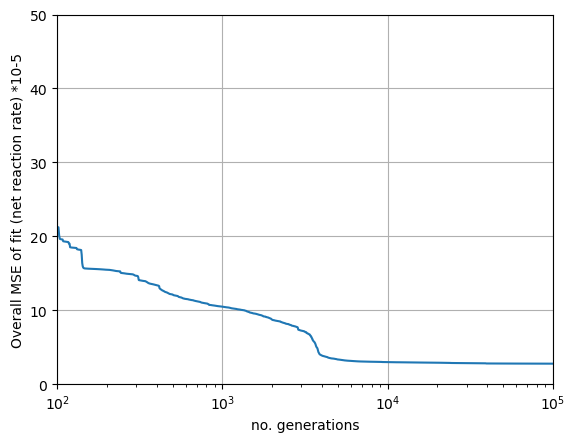

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-10.91848541817136
1.426611491542143
0.7531807878348172
-4.184057195258377
0.4818730339938115
2.599340821760469e-08
0.40196217998559985
-4.261020040931289
0.27093491664015334
4.435943109866839
3.3265381494060073
3.488634493737145
0.5538653560512821
0.02961837459742618
2.996503920966001
1.6414084053966247e-08
0.40421781919428834
-11.753228510866643
1.8527867489894185
1.5659350985412008
-11.699498923829424
1.2022517593206472
3.95628935603554
0.06844241196698331
4.166331621682976
4.924319479014103
1.5278297751951726
9.162027936606965
-1.7282598289611302
2.829884922620598
7.580559456170901
2.150884939126357
-7.961620582640157
1.2301226044462854
1.555187638956197
-1.3010299999385297


In [37]:
res.X

array([-1.09184854e+01,  1.42661149e+00,  7.53180788e-01, -4.18405720e+00,
        4.81873034e-01,  2.59934082e-08,  4.01962180e-01, -4.26102004e+00,
        2.70934917e-01,  4.43594311e+00,  3.32653815e+00,  3.48863449e+00,
        5.53865356e-01,  2.96183746e-02,  2.99650392e+00,  1.64140841e-08,
        4.04217819e-01, -1.17532285e+01,  1.85278675e+00,  1.56593510e+00,
       -1.16994989e+01,  1.20225176e+00,  3.95628936e+00,  6.84424120e-02,
        4.16633162e+00,  4.92431948e+00,  1.52782978e+00,  9.16202794e+00,
       -1.72825983e+00,  2.82988492e+00,  7.58055946e+00,  2.15088494e+00,
       -7.96162058e+00,  1.23012260e+00,  1.55518764e+00, -1.30103000e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -10.91848541817136
1.6: 1.426611491542143
0.9: 0.7531807878348172
-4.3: -4.184057195258377
0.5: 0.4818730339938115
0.003: 2.599340821760469e-08
0.4: 0.40196217998559985
-7.9: -4.261020040931289
0.7: 0.27093491664015334
7.2: 4.435943109866839
5.7: 3.3265381494060073
5.7: 3.488634493737145
0.8: 0.5538653560512821
0.03: 0.02961837459742618
3.1: 2.996503920966001
6.000000000000001e-09: 1.6414084053966247e-08
0.1: 0.40421781919428834
-12.0: -11.753228510866643
1.9: 1.8527867489894185
1.6: 1.5659350985412008
-11.6: -11.699498923829424
1.2: 1.2022517593206472
4.0: 3.95628935603554
0.01: 0.06844241196698331
4.2: 4.166331621682976
5.4: 4.924319479014103
2.2: 1.5278297751951726
11.8: 9.162027936606965
-12.0: -1.7282598289611302
3.3: 2.829884922620598
1.8: 7.580559456170901
4.2: 2.150884939126357
-4.0: -7.961620582640157
0.5: 1.2301226044462854
1.0: 1.555187638956197
coeff fit: 0.8073660385758307
r: 0.8985354965586115
